In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [3]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main_regular", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f" OMP_NUM_THREADS=2 ./main_regular {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=3)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [4]:
def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [5]:
Params={'L': 49, 'P': 0.18480288512056137, 'Inh': 0.3568274238758705, 'Trest': 0.001388460705036468, 'Trelative': 0.1037062403200316, 'C_h': 0.8657675703460452, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]

Normalizacion="zscore"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)


reales_total = Datos_reales(["Datos_reales/P3_MNE.txt","Datos_reales/Pz_MNE.txt","Datos_reales/P4_MNE.txt"],Normalizacion)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']


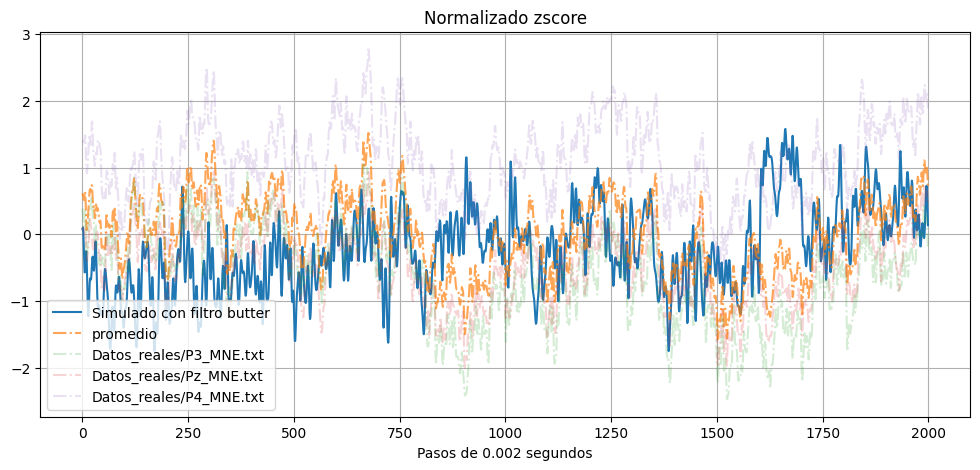

In [6]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.2)


plt.xlabel("Pasos de 0.002 segundos")
#plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


241
['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']
Delta [np.float64(-12.81079647226871), np.float64(2.47832746825149)] ---- [-14.32308775   2.88420902]
Theta [np.float64(-18.962615069593014), np.float64(1.5193222431157007)] ---- [-18.96571845   1.24854892]
Alpha [np.float64(-21.856946912684375), np.float64(1.3125319715213362)] ---- [-21.50437221   1.65501801]
Beta [np.float64(-27.230879440197736), np.float64(1.344153988424413)] ---- [-28.90417761   2.14572478]


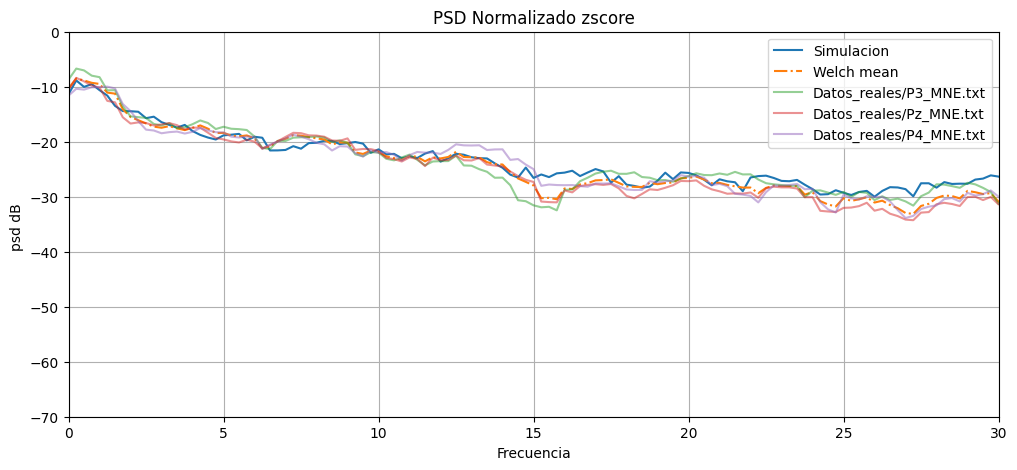

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)
print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [19]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,20)
    params[1] = trial.suggest_float('P', 0.0, 0.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L10", 
                            storage=f"sqlite:///Estudios/Regular/Chi30_{Normalizacion}_L10.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)


[I 2024-11-16 12:57:30,496] Using an existing study with name 'Chi30_zscore_L10' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:32,874] Trial 1806 finished with value: 56.896694944038714 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4875558779768396, 'Trest': 0.5546531998092352, 'Trelative': 0.7703735028123052, 'C_h': 0.9198557485220918, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:34,217] Trial 1807 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5018268312447016, 'Trest': 0.5591673819732047, 'Trelative': 0.7243453444631412, 'C_h': 0.9635523076504096, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:35,574] Trial 1808 finished with value: 118.96163836398262 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.481720149368533, 'Trest': 0.5430839644227768, 'Trelative': 0.7848662281217671, 'C_h': 0.9545929397207735, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:36,375] Trial 1809 finished with value: 54.433535699811735 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4659801542759381, 'Trest': 0.5561721335082555, 'Trelative': 0.8079703495787447, 'C_h': 0.9573634772657618, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:37,076] Trial 1810 finished with value: 55.9379100331729 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4789755666865583, 'Trest': 0.5185605258864221, 'Trelative': 0.7808420280761165, 'C_h': 0.963531625746247, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:37,774] Trial 1811 finished with value: 79.14891045713635 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4852508561291136, 'Trest': 0.5920804713074529, 'Trelative': 0.7444990901514743, 'C_h': 0.9689845561698127, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:38,544] Trial 1812 finished with value: 44.82399996875993 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49198861699647295, 'Trest': 0.5935050285571323, 'Trelative': 0.7954671881278524, 'C_h': 0.9647843825330309, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:39,334] Trial 1813 finished with value: 59.222076454651734 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4842744252093986, 'Trest': 0.5746828970799096, 'Trelative': 0.771786518676081, 'C_h': 0.9650700569053833, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:40,075] Trial 1814 finished with value: 48.44634755613285 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48875774555061774, 'Trest': 0.47086393195882115, 'Trelative': 0.8404064055970938, 'C_h': 0.9608172113538521, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:40,812] Trial 1815 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48271858274794854, 'Trest': 0.5506784503877822, 'Trelative': 0.8389066797769398, 'C_h': 0.9637170031815819, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:41,654] Trial 1816 finished with value: 43.24947991537436 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4890765779487696, 'Trest': 0.5541160718457615, 'Trelative': 0.8275961820156851, 'C_h': 0.9663289948288957, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:42,442] Trial 1817 finished with value: 118.96163836398262 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48156157538451827, 'Trest': 0.5684165417341825, 'Trelative': 0.8376332672213134, 'C_h': 0.9635808442084554, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:43,132] Trial 1818 finished with value: 46.561433794861884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48826887738630126, 'Trest': 0.5442654219733469, 'Trelative': 0.8276439578268143, 'C_h': 0.9642840020765044, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:44,002] Trial 1819 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47475864738686896, 'Trest': 0.57205871940265, 'Trelative': 0.8325427025733779, 'C_h': 0.9643505306649109, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:44,771] Trial 1820 finished with value: 56.896694944038714 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48747090329798043, 'Trest': 0.4995809397808111, 'Trelative': 0.8082141036267809, 'C_h': 0.9574984049096694, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:45,507] Trial 1821 finished with value: 92.55862176334819 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48600537780895736, 'Trest': 0.5365705634223603, 'Trelative': 0.8080929868108441, 'C_h': 0.9705280691327016, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:46,352] Trial 1822 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4911871959286882, 'Trest': 0.5411435836244648, 'Trelative': 0.7955375068621874, 'C_h': 0.9632913923782981, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:47,068] Trial 1823 finished with value: 92.55862176334819 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4860071044572662, 'Trest': 0.5180718805498957, 'Trelative': 0.8198026147601296, 'C_h': 0.9630229101567167, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:47,881] Trial 1824 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49024700748087663, 'Trest': 0.5230271139625351, 'Trelative': 0.8242691305500315, 'C_h': 0.9625496933191439, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:48,831] Trial 1825 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48372805648292966, 'Trest': 0.5561854798869866, 'Trelative': 0.6870288847437418, 'C_h': 0.9619053667749893, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:49,709] Trial 1826 finished with value: 46.561433794861884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48762524032076787, 'Trest': 0.4844682205068688, 'Trelative': 0.5972926338324958, 'C_h': 0.9646260241100351, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:50,457] Trial 1827 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4824916625641514, 'Trest': 0.512172713231322, 'Trelative': 0.6075266835797706, 'C_h': 0.9590375471754596, 'Tipo_red': 0}. Best is trial 1788 with value: 42.55646660944803.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:51,304] Trial 1828 finished with value: 40.85864193025328 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48151406985064865, 'Trest': 0.4882240850235634, 'Trelative': 0.5857130392772185, 'C_h': 0.9622127353475525, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:52,271] Trial 1829 finished with value: 46.561433794861884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48763052478982927, 'Trest': 0.4661572793377883, 'Trelative': 0.5230521688928969, 'C_h': 0.9552529053066383, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:53,290] Trial 1830 finished with value: 46.561433794861884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48810035390781525, 'Trest': 0.462859815162499, 'Trelative': 0.5610525884527053, 'C_h': 0.9627755752118583, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:54,321] Trial 1831 finished with value: 125.65381882762394 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48221989710739394, 'Trest': 0.43971866155357897, 'Trelative': 0.5490188189852566, 'C_h': 0.963263527828816, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:55,138] Trial 1832 finished with value: 44.82399996875993 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49219067121604293, 'Trest': 0.5555713438339146, 'Trelative': 0.9765242990772927, 'C_h': 0.9626605857083588, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:55,938] Trial 1833 finished with value: 559.1061246155094 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4933236671311536, 'Trest': 0.6713461821903223, 'Trelative': 1.0173525194649635, 'C_h': 0.9608296715962471, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:56,687] Trial 1834 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4916469299829317, 'Trest': 0.5752747539287004, 'Trelative': 0.6354994347249687, 'C_h': 0.9662799271675878, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:57,462] Trial 1835 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47448148307310867, 'Trest': 0.37282557344024797, 'Trelative': 0.529892986930219, 'C_h': 0.963003175947466, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:58,280] Trial 1836 finished with value: 46.60498545365324 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47576618535516996, 'Trest': 0.3249600010032619, 'Trelative': 0.4987803551341534, 'C_h': 0.9634877942923594, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:59,098] Trial 1837 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4914628050421711, 'Trest': 0.3858027896860913, 'Trelative': 0.4998980642026433, 'C_h': 0.9681730798954559, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:57:59,882] Trial 1838 finished with value: 50.742287519791034 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46715200132748735, 'Trest': 0.34925445630526786, 'Trelative': 0.44516509946930416, 'C_h': 0.9694851248322762, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:00,683] Trial 1839 finished with value: 54.374989036969616 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.468416391856242, 'Trest': 0.366902905877332, 'Trelative': 0.49433784356573385, 'C_h': 0.9703908416494, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:01,715] Trial 1840 finished with value: 54.433535699811735 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46670693289588616, 'Trest': 0.32892268792459317, 'Trelative': 0.43972524937698604, 'C_h': 0.9549617502760968, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:02,524] Trial 1841 finished with value: 54.433535699811735 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4648877728507148, 'Trest': 0.3315059599673151, 'Trelative': 0.4493617490555404, 'C_h': 0.9718521000997774, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:03,421] Trial 1842 finished with value: 42.46274530341511 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4962694537333123, 'Trest': 0.35954846822362635, 'Trelative': 0.45426727321862337, 'C_h': 0.9289820628880032, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:04,382] Trial 1843 finished with value: 65.04169536039272 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46414980292521096, 'Trest': 0.34199914361117323, 'Trelative': 0.4727618341622704, 'C_h': 0.9232174074042621, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:05,450] Trial 1844 finished with value: 62.89434385029651 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4999350939570453, 'Trest': 0.32408656812391884, 'Trelative': 0.4015269533787593, 'C_h': 0.9421538235474581, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:06,560] Trial 1845 finished with value: 65.04169536039272 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4633097736381163, 'Trest': 0.29322280502176185, 'Trelative': 0.38845492582658686, 'C_h': 0.9257091457213454, 'Tipo_red': 0}. Best is trial 1828 with value: 40.85864193025328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:07,851] Trial 1846 finished with value: 36.13332471403 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4968411348913986, 'Trest': 0.33401715418162325, 'Trelative': 0.4399956752316142, 'C_h': 0.9517317493222194, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:09,188] Trial 1847 finished with value: 51.949989078878254 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4987005045262076, 'Trest': 0.3230760626098838, 'Trelative': 0.4501606982420128, 'C_h': 0.9454574203516527, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:10,454] Trial 1848 finished with value: 88.45844598892441 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5040853385722851, 'Trest': 0.3223845278118076, 'Trelative': 0.39955017824701605, 'C_h': 0.945572196837891, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:11,541] Trial 1849 finished with value: 65.04169536039272 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46411923750402656, 'Trest': 0.32727292875194286, 'Trelative': 0.5365973942933733, 'C_h': 0.9778011895133109, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:12,560] Trial 1850 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5020679784401335, 'Trest': 0.33811990552480614, 'Trelative': 0.5403625853508867, 'C_h': 0.9729357273955208, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:13,513] Trial 1851 finished with value: 36.13332471403 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49751810998099405, 'Trest': 0.30463683992760493, 'Trelative': 0.41599931523415146, 'C_h': 0.9756622210340923, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:14,703] Trial 1852 finished with value: 42.46274530341511 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49594078774845923, 'Trest': 0.3525849633817951, 'Trelative': 0.5322571791366482, 'C_h': 0.9453518022406633, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:16,043] Trial 1853 finished with value: 62.68532197070889 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46165260487602855, 'Trest': 0.012734924295924877, 'Trelative': 0.1040837244368355, 'C_h': 0.9405506341756927, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:17,359] Trial 1854 finished with value: 205.62578657452846 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49276764686624774, 'Trest': 0.2783307312300475, 'Trelative': 0.4194023638968691, 'C_h': 0.9449475447759231, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:18,481] Trial 1855 finished with value: 51.778294286014216 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5004872291967423, 'Trest': 0.2972152075886606, 'Trelative': 0.4225232974619038, 'C_h': 0.9733090495824761, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:19,601] Trial 1856 finished with value: 240.443011086628 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4986993451850445, 'Trest': 0.27837303577278216, 'Trelative': 1.0106713787139543, 'C_h': 0.9253030784529065, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:20,639] Trial 1857 finished with value: 652.4830783032984 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5076737767241851, 'Trest': 0.332895753626067, 'Trelative': 1.0253899879279689, 'C_h': 0.9476856444365773, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:21,453] Trial 1858 finished with value: 57.39788733819746 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5029887970529866, 'Trest': 0.26626547279803814, 'Trelative': 0.4344778156938074, 'C_h': 0.9753022230029271, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:22,333] Trial 1859 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46949782161476067, 'Trest': 0.35071202961864245, 'Trelative': 0.6258363026867666, 'C_h': 0.9339879038213119, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:23,155] Trial 1860 finished with value: 2427.3417122483274 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4976004145181807, 'Trest': 0.014915582926343485, 'Trelative': 0.04946363089209721, 'C_h': 0.9486255738285184, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:24,039] Trial 1861 finished with value: 51.93431178692984 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5174274101011755, 'Trest': 0.00594739507031572, 'Trelative': 0.1676137903876343, 'C_h': 0.9740401543578099, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:24,905] Trial 1862 finished with value: 41.06770893041822 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5192899968047558, 'Trest': 0.2317147436867688, 'Trelative': 0.34029335535604044, 'C_h': 0.977304942298874, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:25,883] Trial 1863 finished with value: 118.49184850889188 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.519141333853922, 'Trest': 0.008016910630142537, 'Trelative': 0.23229757105477528, 'C_h': 0.9759234392337675, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:26,751] Trial 1864 finished with value: 81.26270656209545 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5127551962867534, 'Trest': 0.2167477532200382, 'Trelative': 0.32984898855867717, 'C_h': 0.9812666123611472, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:27,803] Trial 1865 finished with value: 73.08178498717086 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5181265453764365, 'Trest': 0.004504105426261479, 'Trelative': 0.14331380686287787, 'C_h': 0.9763672954411063, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:28,745] Trial 1866 finished with value: 205.62578657452846 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4927246849032516, 'Trest': 0.23053665942815538, 'Trelative': 0.5361906200511877, 'C_h': 0.9250340740082147, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:29,700] Trial 1867 finished with value: 198.24899469330558 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5042880785912551, 'Trest': 0.40661940190532014, 'Trelative': 1.0693629782592984, 'C_h': 0.9755273300416931, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:30,541] Trial 1868 finished with value: 75.35213817026255 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5151369215932141, 'Trest': 0.009421406209743768, 'Trelative': 0.06913683287666558, 'C_h': 0.9982014322863391, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:31,462] Trial 1869 finished with value: 72.33261177102676 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49414090974504193, 'Trest': 0.2410001310484886, 'Trelative': 0.5766965174913042, 'C_h': 0.9394769178493374, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:32,518] Trial 1870 finished with value: 89.5387550827581 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5208645363884878, 'Trest': 0.7032615300766234, 'Trelative': 1.0988233721638787, 'C_h': 0.978286400339436, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:33,477] Trial 1871 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4907721699045375, 'Trest': 0.4102931162796416, 'Trelative': 0.6466942922010219, 'C_h': 0.952543846994127, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:34,509] Trial 1872 finished with value: 205.62578657452846 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49252107110373966, 'Trest': 0.23196881897175803, 'Trelative': 0.36976280144946894, 'C_h': 0.9239932757508491, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:35,465] Trial 1873 finished with value: 51.93431178692984 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5167483586524488, 'Trest': 0.006016800232505948, 'Trelative': 0.21867891698703357, 'C_h': 0.9493737926381963, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:36,314] Trial 1874 finished with value: 101.52810467101926 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5240244467306804, 'Trest': 0.2105756783787487, 'Trelative': 0.3394224332963349, 'C_h': 0.9520229115322274, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:37,289] Trial 1875 finished with value: 67.09272663072747 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5177988663226325, 'Trest': 0.010172077025413673, 'Trelative': 0.20750142653131234, 'C_h': 0.9991402055582166, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:38,352] Trial 1876 finished with value: 44.82399996875993 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4917513500612296, 'Trest': 0.4183557952041777, 'Trelative': 0.6483139488937812, 'C_h': 0.9532773050492298, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:39,560] Trial 1877 finished with value: 126.65407640810312 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48927875221395806, 'Trest': 0.6928067534364326, 'Trelative': 1.0014807298636241, 'C_h': 0.9761592965539538, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:40,768] Trial 1878 finished with value: 61.03021303056554 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4802081366883488, 'Trest': 0.42453941342322804, 'Trelative': 0.6568727281486987, 'C_h': 0.9287626195715214, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:41,611] Trial 1879 finished with value: 72.33261177102676 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49500890192515273, 'Trest': 0.6791887578390648, 'Trelative': 0.9793955349183828, 'C_h': 0.9549910698214521, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:42,547] Trial 1880 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4749927537334491, 'Trest': 0.4277219827662226, 'Trelative': 0.6377519773050833, 'C_h': 0.9731830655013244, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:43,460] Trial 1881 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5065105496606719, 'Trest': 0.431385881114047, 'Trelative': 0.6828906746896907, 'C_h': 0.9197425634141604, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:44,447] Trial 1882 finished with value: 241.01719264611083 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45709581427395374, 'Trest': 0.748010892372313, 'Trelative': 1.1155079751173513, 'C_h': 0.9547599034763329, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:45,394] Trial 1883 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4913419587221513, 'Trest': 0.45542743027996724, 'Trelative': 0.9563658325990974, 'C_h': 0.9764473533657854, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:46,266] Trial 1884 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48988911442009453, 'Trest': 0.6947089066468641, 'Trelative': 0.9701758238773458, 'C_h': 0.9343340687020196, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:47,240] Trial 1885 finished with value: 72.55824927526827 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.457113077198363, 'Trest': 0.7152713984204357, 'Trelative': 0.9815817344098511, 'C_h': 0.9204250542803953, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:48,251] Trial 1886 finished with value: 118.96163836398262 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48183556529049626, 'Trest': 0.6533563527658479, 'Trelative': 0.9547522485725997, 'C_h': 0.9333624771670855, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:49,475] Trial 1887 finished with value: 129.3697540104113 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47767334619118074, 'Trest': 0.8463985653882176, 'Trelative': 1.2186454368325839, 'C_h': 0.9390826636886277, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:50,591] Trial 1888 finished with value: 49.96465176084445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.450763179263305, 'Trest': 0.4909087581749896, 'Trelative': 0.8909519908828902, 'C_h': 0.9530955545843662, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:51,503] Trial 1889 finished with value: 36.13332471403 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49755383073614456, 'Trest': 0.6317564689040902, 'Trelative': 0.9619261310737685, 'C_h': 0.9476144235214193, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:52,550] Trial 1890 finished with value: 237.75298091732128 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.498580919217994, 'Trest': 0.814258650223765, 'Trelative': 1.162893832322737, 'C_h': 0.9274130291935094, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:53,454] Trial 1891 finished with value: 96.6095356094618 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5226340964534547, 'Trest': 0.6553743044790468, 'Trelative': 0.9529837027282808, 'C_h': 0.9154519925055563, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:54,313] Trial 1892 finished with value: 72.33261177102676 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49391680371888724, 'Trest': 0.5399075204757263, 'Trelative': 0.9207287615099089, 'C_h': 0.9457259043015956, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:55,508] Trial 1893 finished with value: 390.500601705396 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4863781645414631, 'Trest': 0.8385665720716695, 'Trelative': 1.1705703972887436, 'C_h': 0.9547651040412813, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:56,547] Trial 1894 finished with value: 61.06235215517646 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5286507843724005, 'Trest': 0.6503620344879258, 'Trelative': 0.9598816224068139, 'C_h': 0.93677800536681, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:57,461] Trial 1895 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.507676520465539, 'Trest': 0.48090994857948266, 'Trelative': 0.6873127414092106, 'C_h': 0.9990996891198323, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:58,395] Trial 1896 finished with value: 60.19859275861924 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4733403005007408, 'Trest': 0.6708868009889989, 'Trelative': 0.9302266851875065, 'C_h': 0.9162304935245102, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:58:59,245] Trial 1897 finished with value: 205.62578657452846 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49267436216816096, 'Trest': 0.4619044597216432, 'Trelative': 0.7008796547004231, 'C_h': 0.9773561307992342, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:00,272] Trial 1898 finished with value: 100.00774195646748 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5305004009103539, 'Trest': 0.8702400017031728, 'Trelative': 1.2703706650324187, 'C_h': 0.9548052816867854, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:01,152] Trial 1899 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47034785195205875, 'Trest': 0.4621833665024313, 'Trelative': 0.6785523853082736, 'C_h': 0.9355487793709991, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:01,976] Trial 1900 finished with value: 55.17194661024568 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.509192548492947, 'Trest': 0.23027009304810336, 'Trelative': 0.5336335141837742, 'C_h': 0.9771433592167682, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:02,995] Trial 1901 finished with value: 130.9675311176535 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48896427930072395, 'Trest': 0.6483648149796137, 'Trelative': 0.9051268878020058, 'C_h': 0.9587114391996242, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:03,991] Trial 1902 finished with value: 123.09343633838283 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4531023506115697, 'Trest': 0.4352906502031074, 'Trelative': 0.6680762049248345, 'C_h': 0.9153074371962818, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:05,146] Trial 1903 finished with value: 305.64671348669367 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5074098837831988, 'Trest': 0.8611463079752852, 'Trelative': 1.093281893335624, 'C_h': 0.9991566424228304, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:06,448] Trial 1904 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4739349432771009, 'Trest': 0.23871685284020905, 'Trelative': 0.5953962129771762, 'C_h': 0.9387096943073946, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:07,255] Trial 1905 finished with value: 96.6095356094618 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5226048785264199, 'Trest': 0.6390203117169095, 'Trelative': 0.9050070961494013, 'C_h': 0.9617608115906949, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:08,256] Trial 1906 finished with value: 123.09343633838283 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4528578281778952, 'Trest': 0.4718625294033466, 'Trelative': 0.7016806124664106, 'C_h': 0.9755841066214621, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:09,203] Trial 1907 finished with value: 200.7144351523914 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4933013312002528, 'Trest': 0.8186340520835144, 'Trelative': 1.169558358220628, 'C_h': 0.950587216831166, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:10,004] Trial 1908 finished with value: 85.19034992028445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5322056507503887, 'Trest': 0.2368390604256856, 'Trelative': 0.5080677617586083, 'C_h': 0.9796123300951163, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:10,921] Trial 1909 finished with value: 55.9379100331729 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4790443642276861, 'Trest': 0.43566581123004844, 'Trelative': 0.6813349488845659, 'C_h': 0.9317820070601935, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:11,961] Trial 1910 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5019884859819418, 'Trest': 0.6458829296663496, 'Trelative': 0.9183671403555909, 'C_h': 0.9997310455497324, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:13,054] Trial 1911 finished with value: 49.43026137467649 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4519600676989932, 'Trest': 0.26300322024803685, 'Trelative': 0.5239564217259107, 'C_h': 0.9586343344602144, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:14,173] Trial 1912 finished with value: 60.19859275861924 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47254718211956204, 'Trest': 0.48510649786902066, 'Trelative': 0.7157444121461363, 'C_h': 0.9166411983827878, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:15,176] Trial 1913 finished with value: 1424.3881999059279 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5128289027181034, 'Trest': 0.6997417452650107, 'Trelative': 1.0079478729690485, 'C_h': 0.9773815680641252, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:16,057] Trial 1914 finished with value: 43.24947991537436 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4896995290562232, 'Trest': 0.18952905500795067, 'Trelative': 0.3517630195657938, 'C_h': 0.9399275971808396, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:16,967] Trial 1915 finished with value: 85.19034992028445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5318126693141976, 'Trest': 0.30164079863496496, 'Trelative': 0.550182355958823, 'C_h': 0.9341406457793078, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:17,865] Trial 1916 finished with value: 88.45844598892441 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.504626599175494, 'Trest': 0.15673758270906146, 'Trelative': 0.3382193426846961, 'C_h': 0.9395520549888949, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:18,724] Trial 1917 finished with value: 54.374989036969616 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46868112052098226, 'Trest': 0.23176683061622588, 'Trelative': 0.38174893188820497, 'C_h': 0.954836806069479, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:59:19,533] Trial 1918 finished with value: 2130.7211243156626 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48823143537795843, 'Trest': 0.0020091504317071157, 'Trelative': 0.022247795973765028, 'C_h': 0.9114591778194777, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:20,504] Trial 1919 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45368782931349827, 'Trest': 0.2149595785311064, 'Trelative': 0.41520755340045334, 'C_h': 0.9769868762173226, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:21,368] Trial 1920 finished with value: 55.4675162306512 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5132225942835359, 'Trest': 0.5902242548808192, 'Trelative': 0.8416728247576972, 'C_h': 0.943497008417013, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:22,509] Trial 1921 finished with value: 82.71678411176357 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5340510577992503, 'Trest': 0.8697335082741632, 'Trelative': 1.21868253337672, 'C_h': 0.9196170427341311, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:23,492] Trial 1922 finished with value: 46.561433794861884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48766229463657335, 'Trest': 0.4088854443534411, 'Trelative': 0.6689069969355008, 'C_h': 0.9802385104159949, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:24,436] Trial 1923 finished with value: 205.62578657452846 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49288617777599597, 'Trest': 0.6644048214083277, 'Trelative': 0.9667744715834433, 'C_h': 0.9808397743538827, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:25,320] Trial 1924 finished with value: 204.44762818905252 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5116021221179586, 'Trest': 0.47682099647636145, 'Trelative': 0.704655994623618, 'C_h': 0.978612522518231, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:26,342] Trial 1925 finished with value: 108.81804032730724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4942286779272204, 'Trest': 0.9284480556672489, 'Trelative': 1.3180006386816383, 'C_h': 0.9464161079663167, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:27,309] Trial 1926 finished with value: 49.96465176084445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4511109682879547, 'Trest': 0.46615916102585636, 'Trelative': 0.6961463017050911, 'C_h': 0.9538329828187035, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:28,138] Trial 1927 finished with value: 107.6178140270769 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5380006799126127, 'Trest': 0.2542809796913346, 'Trelative': 0.56178920249099, 'C_h': 0.9833324662906022, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:29,240] Trial 1928 finished with value: 192.68246909136352 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4739423684623121, 'Trest': 0.7967786757620952, 'Trelative': 1.1401712073172754, 'C_h': 0.9982345938370016, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:30,328] Trial 1929 finished with value: 81.54821838675353 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5222734438520035, 'Trest': 0.6411348664441173, 'Trelative': 0.9683257475284393, 'C_h': 0.9310806465352235, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:31,336] Trial 1930 finished with value: 42.46274530341511 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4962950108745611, 'Trest': 0.2093696200444211, 'Trelative': 0.36048212266876634, 'C_h': 0.9608353851493256, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:32,307] Trial 1931 finished with value: 77.06841389473159 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5106513500278009, 'Trest': 0.1473070705373149, 'Trelative': 0.3018626564748246, 'C_h': 0.9172296463199715, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:33,386] Trial 1932 finished with value: 51.949989078878254 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4991557504845894, 'Trest': 0.2072677661013793, 'Trelative': 0.3607054523469971, 'C_h': 0.9561331388571026, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:34,309] Trial 1933 finished with value: 113.07654560062421 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5449225233846646, 'Trest': 0.4174475439477072, 'Trelative': 0.6738511869132442, 'C_h': 0.9358733805228031, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:35,107] Trial 1934 finished with value: 6203.374232472721 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46601268422939385, 'Trest': 0.0026359436195066976, 'Trelative': 0.012348387069335942, 'C_h': 0.9606361873058877, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:35,923] Trial 1935 finished with value: 101.52810467101926 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5233193889331057, 'Trest': 0.6513533599237855, 'Trelative': 0.9169263226072445, 'C_h': 0.9344321177575171, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:36,833] Trial 1936 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4908872400513719, 'Trest': 0.19898194157610957, 'Trelative': 0.3593987606280463, 'C_h': 0.9997161151631695, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:37,785] Trial 1937 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5072194563122608, 'Trest': 0.19319455247708123, 'Trelative': 0.33250914776258067, 'C_h': 0.9983596800512567, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:38,682] Trial 1938 finished with value: 133.5106955747679 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45026399232639835, 'Trest': 0.20681362567429232, 'Trelative': 0.39450421223419035, 'C_h': 0.9824253427468367, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:39,569] Trial 1939 finished with value: 92.66597025092906 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4726312544824139, 'Trest': 0.0004691009361159071, 'Trelative': 0.20653605089571458, 'C_h': 0.971654273125557, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:40,488] Trial 1940 finished with value: 56.16065891299852 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5260603088361938, 'Trest': 0.22097500940111425, 'Trelative': 0.5223626795481928, 'C_h': 0.912716930317158, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:41,311] Trial 1941 finished with value: 63.735925196195154 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4934542535105985, 'Trest': 0.35603790558869686, 'Trelative': 0.6166517797328148, 'C_h': 0.9982667732651348, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:42,294] Trial 1942 finished with value: 165.46550279192192 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4720559001073919, 'Trest': 0.3928348470306685, 'Trelative': 0.6408284369059665, 'C_h': 0.942986368945184, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:43,165] Trial 1943 finished with value: 81.26270656209545 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5127203748202543, 'Trest': 0.5636793880082238, 'Trelative': 0.857232387484055, 'C_h': 0.999729891907861, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:44,124] Trial 1944 finished with value: 107.6178140270769 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5376021894741099, 'Trest': 0.19320120563629398, 'Trelative': 0.3862091714455984, 'C_h': 0.9638567379676332, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:45,091] Trial 1945 finished with value: 234.7591534518096 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49071549517409224, 'Trest': 0.8597235160146544, 'Trelative': 1.1316340767215594, 'C_h': 0.9772483554778579, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:46,049] Trial 1946 finished with value: 76.8886055965763 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4578034682405759, 'Trest': 0.6860582524308168, 'Trelative': 0.9931403236778645, 'C_h': 0.9487250398633413, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:46,922] Trial 1947 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5080348370107997, 'Trest': 0.3839559996769733, 'Trelative': 0.6685655859868229, 'C_h': 0.9143259391104069, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:47,909] Trial 1948 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4741769824912746, 'Trest': 0.19268332547666794, 'Trelative': 0.4163644867367451, 'C_h': 0.9622189446725677, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:48,820] Trial 1949 finished with value: 97.15665269115664 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4488313975827684, 'Trest': 0.5497975351750597, 'Trelative': 0.8189881633349391, 'C_h': 0.9324432000410803, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:49,774] Trial 1950 finished with value: 234.7591534518096 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48973944250083723, 'Trest': 0.9032580887728675, 'Trelative': 1.2671796864334461, 'C_h': 0.9784647268287312, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:50,706] Trial 1951 finished with value: 61.20910945000379 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.523207945271675, 'Trest': 0.02449757425148405, 'Trelative': 0.24684448610881665, 'C_h': 0.9502338755509308, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:51,663] Trial 1952 finished with value: 46.355867451725295 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5030254615821808, 'Trest': 0.40428577686573725, 'Trelative': 0.6662578810192247, 'C_h': 0.9802988208909039, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:52,517] Trial 1953 finished with value: 84.9557761956171 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5462529129317173, 'Trest': 0.2154939367346819, 'Trelative': 0.38658637514123895, 'C_h': 0.9993059726479963, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:53,426] Trial 1954 finished with value: 93.61653205212433 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5101115189714819, 'Trest': 0.3925883539915034, 'Trelative': 0.690295582641387, 'C_h': 0.9997898293141159, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:54,357] Trial 1955 finished with value: 55.37315791786953 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5340314955471809, 'Trest': 0.6356639648415642, 'Trelative': 0.8745733730044123, 'C_h': 0.9766808958609544, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:55,235] Trial 1956 finished with value: 68.63309182934384 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5036636844025411, 'Trest': 0.1841432095785318, 'Trelative': 0.3609554602628746, 'C_h': 0.9794056186824456, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:56,370] Trial 1957 finished with value: 44.40609005933765 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5251840465101472, 'Trest': 0.7919475021006277, 'Trelative': 1.1047875969998897, 'C_h': 0.9652830867825763, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:57,748] Trial 1958 finished with value: 161.63900992429794 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5419600793013127, 'Trest': 0.7944025530912997, 'Trelative': 1.0931069598934529, 'C_h': 0.9347550566981956, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:58,761] Trial 1959 finished with value: 157.95080465135862 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5457108139098936, 'Trest': 0.005433250577234455, 'Trelative': 0.3966317524826964, 'C_h': 0.9778238740462962, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:59:59,698] Trial 1960 finished with value: 1302.4961500820261 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5149220538640331, 'Trest': 0.9133320171703643, 'Trelative': 1.2819495826766694, 'C_h': 0.9547578926075119, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:00,570] Trial 1961 finished with value: 71.71229512388147 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5268991907212276, 'Trest': 0.682344431798929, 'Trelative': 0.9865408340084425, 'C_h': 0.9151116668825386, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:01,468] Trial 1962 finished with value: 41.06770893041822 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5208430374490338, 'Trest': 0.362416577038644, 'Trelative': 0.6684050414412083, 'C_h': 0.9764569845437528, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:02,205] Trial 1963 finished with value: 84.9557761956171 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5463520140408364, 'Trest': 0.32330909576658823, 'Trelative': 0.5949501661843527, 'C_h': 0.9998702935888933, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:03,254] Trial 1964 finished with value: 46.926669612732915 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5251453853708897, 'Trest': 0.33461322891431633, 'Trelative': 0.6167312143574961, 'C_h': 0.9789782881718231, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:04,254] Trial 1965 finished with value: 66.36394424569724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5299436466772645, 'Trest': 0.19249563114789742, 'Trelative': 0.4301328180015221, 'C_h': 0.9396426495368418, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:05,536] Trial 1966 finished with value: 404.05668198447444 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5103528105746217, 'Trest': 0.7049727666218135, 'Trelative': 1.0656621784209204, 'C_h': 0.982955742882533, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:06,635] Trial 1967 finished with value: 113.07654560062421 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5446969544968444, 'Trest': 0.38168937414009096, 'Trelative': 0.7441822219821566, 'C_h': 0.9567886915751664, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:00:07,603] Trial 1968 finished with value: 6790.524959360791 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.510325278045793, 'Trest': 0.016092722973232054, 'Trelative': 0.024474078164798185, 'C_h': 0.9309868314753614, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:08,402] Trial 1969 finished with value: 56.16065891299852 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5252952682356974, 'Trest': 0.5521989847905296, 'Trelative': 0.8566101085717249, 'C_h': 0.9700046289374, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:09,203] Trial 1970 finished with value: 60.860991698172306 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5514191506491776, 'Trest': 0.1951752854382881, 'Trelative': 0.40279437165435555, 'C_h': 0.9809901469629675, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:10,188] Trial 1971 finished with value: 299.6517770865445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5016487539442103, 'Trest': 0.8921383272742449, 'Trelative': 1.1712951135341756, 'C_h': 0.9451879440003321, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:11,061] Trial 1972 finished with value: 51.778294286014216 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5011623558210548, 'Trest': 0.3571694125183664, 'Trelative': 0.6285737223060416, 'C_h': 0.9175189289177803, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:11,951] Trial 1973 finished with value: 39.62718850362374 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47802156517864475, 'Trest': 0.646567916654343, 'Trelative': 0.9352454507806034, 'C_h': 0.9990297443312248, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:13,055] Trial 1974 finished with value: 194.24674294042498 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4685472899013671, 'Trest': 0.9548994134166862, 'Trelative': 1.3119021755171225, 'C_h': 0.9857677884665595, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:14,267] Trial 1975 finished with value: 194.24674294042498 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4680914648406173, 'Trest': 0.7292041480556908, 'Trelative': 1.047240853301157, 'C_h': 0.9578703775137395, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:15,274] Trial 1976 finished with value: 58.97102514714109 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4463674544444546, 'Trest': 0.6218264887117653, 'Trelative': 0.9004438913695318, 'C_h': 0.9961742647526763, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:16,440] Trial 1977 finished with value: 141.52265933118306 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4712260154160778, 'Trest': 0.7756612675410404, 'Trelative': 1.1043205707210286, 'C_h': 0.9616772704363737, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:17,497] Trial 1978 finished with value: 41.02037089581705 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48520761030908544, 'Trest': 0.0012307115799436719, 'Trelative': 0.23130229633834176, 'C_h': 0.9998632078676902, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:18,439] Trial 1979 finished with value: 39.62718850362374 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4783851553412102, 'Trest': 0.1512403962606778, 'Trelative': 0.3369553084510633, 'C_h': 0.9431406333953355, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:19,291] Trial 1980 finished with value: 73.10224603365843 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45741682984528914, 'Trest': 0.011857535442764966, 'Trelative': 0.19252060057274498, 'C_h': 0.9714465320272755, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:20,277] Trial 1981 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44480468413179586, 'Trest': 0.15393832641770427, 'Trelative': 0.2909209864424156, 'C_h': 0.9469413594178454, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:21,143] Trial 1982 finished with value: 75.52984164363075 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47734304196902416, 'Trest': 0.2138457961618827, 'Trelative': 0.5032630803308986, 'C_h': 0.9988497430394652, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:21,951] Trial 1983 finished with value: 41.06770893041822 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5216420549468171, 'Trest': 0.2016706328532672, 'Trelative': 0.3468756272988376, 'C_h': 0.9673526833933029, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:22,837] Trial 1984 finished with value: 66.43766157180102 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5267033210280914, 'Trest': 0.02982829838201801, 'Trelative': 0.23030417251991112, 'C_h': 0.9480534964898686, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:00:23,663] Trial 1985 finished with value: 2787.52339425693 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5292596514928912, 'Trest': 0.016146277992931172, 'Trelative': 0.03751683160749869, 'C_h': 0.9168025482232569, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:00:24,507] Trial 1986 finished with value: 16960.552346670713 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5505398901158455, 'Trest': 0.0073769430211205545, 'Trelative': 0.016152302313773237, 'C_h': 0.9656887604710477, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:25,555] Trial 1987 finished with value: 75.35213817026255 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5150874145530748, 'Trest': 0.2083713672538628, 'Trelative': 0.4663387704644365, 'C_h': 0.9306456272645818, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:26,470] Trial 1988 finished with value: 75.50120831091233 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5531156629462981, 'Trest': 0.32757604478724167, 'Trelative': 0.615325625348945, 'C_h': 0.953225608075592, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:27,412] Trial 1989 finished with value: 47.04279730360645 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.517654137646992, 'Trest': 0.008462504840927587, 'Trelative': 0.19203574219257646, 'C_h': 0.9815513243746664, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:28,376] Trial 1990 finished with value: 76.81560390019139 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4723338510570891, 'Trest': 0.2307427285682669, 'Trelative': 0.4719605343138854, 'C_h': 0.9381345751069953, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:29,168] Trial 1991 finished with value: 83.75233954901371 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5054578865038966, 'Trest': 0.37478660833069144, 'Trelative': 0.6941094051462391, 'C_h': 0.9616067098425217, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:30,006] Trial 1992 finished with value: 55.37315791786953 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5343237993893671, 'Trest': 0.22772714656837117, 'Trelative': 0.4448234420753593, 'C_h': 0.9136036337194231, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:30,891] Trial 1993 finished with value: 97.15665269115664 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4488331204293209, 'Trest': 0.4633887892580143, 'Trelative': 0.7671958601078704, 'C_h': 0.9668820230901499, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:31,923] Trial 1994 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4839539590825448, 'Trest': 0.19918230917594817, 'Trelative': 0.375848203569489, 'C_h': 0.9408229113846585, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:32,902] Trial 1995 finished with value: 102.21797578857048 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5121409279150113, 'Trest': 0.0041172527484256705, 'Trelative': 0.19305686265709687, 'C_h': 0.981979813851972, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:33,921] Trial 1996 finished with value: 82.98093963094011 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46430908608787663, 'Trest': 0.5087101175155123, 'Trelative': 0.7851505847268221, 'C_h': 0.9989856336690938, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:34,763] Trial 1997 finished with value: 139.34087705168864 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.533269988451956, 'Trest': 0.38133210783806193, 'Trelative': 0.6665857882131582, 'C_h': 0.9540888329115655, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:35,541] Trial 1998 finished with value: 36.13332471403 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4977735149194245, 'Trest': 0.5329410345381164, 'Trelative': 0.7880974251055695, 'C_h': 0.9998683297071359, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:36,462] Trial 1999 finished with value: 79.76609715357077 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5502976578617244, 'Trest': 0.5698983907802166, 'Trelative': 0.8529555965996021, 'C_h': 0.9812366848755186, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:37,524] Trial 2000 finished with value: 90.4741217564796 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5145690976757866, 'Trest': 0.27701613890166565, 'Trelative': 0.5492069359294822, 'C_h': 0.9836289462094987, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_5232/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:00:38,528] Trial 2001 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5011253884783096, 'Trest': 1.024202164744935, 'Trelative': 1.3715255176463987, 'C_h': 0.9997221763955099, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:39,367] Trial 2002 finished with value: 40.85864193025328 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48153347851743666, 'Trest': 0.6019215436642282, 'Trelative': 0.833245872179583, 'C_h': 0.9804645084243112, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:40,459] Trial 2003 finished with value: 192.68246909136352 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.474089718575285, 'Trest': 0.7639708768008783, 'Trelative': 1.0583095931209834, 'C_h': 0.9845897524685727, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:41,578] Trial 2004 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4536307342969531, 'Trest': 0.6125621527020921, 'Trelative': 0.8725797672404628, 'C_h': 0.9987159012817612, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:00:42,752] Trial 2005 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47281876824965396, 'Trest': 1.0201040722332437, 'Trelative': 1.299903809153268, 'C_h': 0.9725984552081346, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:43,769] Trial 2006 finished with value: 66.36394424569724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5307601065795217, 'Trest': 0.6179506143468081, 'Trelative': 0.8626671764928088, 'C_h': 0.9813778203747636, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:44,616] Trial 2007 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5060190718281217, 'Trest': 0.1762407008640682, 'Trelative': 0.35962026345438436, 'C_h': 0.9996597150648155, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:45,559] Trial 2008 finished with value: 1058.3747261165902 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4451057064354111, 'Trest': 0.8122617454025828, 'Trelative': 1.0799023458755992, 'C_h': 0.9643870960225523, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:46,377] Trial 2009 finished with value: 79.76609715357077 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5501303060106475, 'Trest': 0.5408704907598838, 'Trelative': 0.7988788599723405, 'C_h': 0.9997279044444808, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:47,310] Trial 2010 finished with value: 55.9379100331729 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4800542454480541, 'Trest': 0.19201593371436443, 'Trelative': 0.3605789177379278, 'C_h': 0.9349846143163133, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:48,376] Trial 2011 finished with value: 46.67861564220313 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5173927147274489, 'Trest': 0.5500343472835105, 'Trelative': 0.7945347499203521, 'C_h': 0.9656136735002038, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:49,626] Trial 2012 finished with value: 108.81804032730724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49421624037555106, 'Trest': 0.9148943197420241, 'Trelative': 1.237505770224053, 'C_h': 0.9511871332021317, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:50,413] Trial 2013 finished with value: 60.822533734754096 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46207502423551905, 'Trest': 0.0035117664786328273, 'Trelative': 0.152083693193461, 'C_h': 0.979171647775765, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:51,442] Trial 2014 finished with value: 46.926669612732915 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5250516186254514, 'Trest': 0.358404660038461, 'Trelative': 0.5945372981966934, 'C_h': 0.9264152453994338, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:52,350] Trial 2015 finished with value: 42.65309762344295 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49853541832305265, 'Trest': 0.7105845382445165, 'Trelative': 0.9709054607003004, 'C_h': 0.9661962282012265, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:00:53,344] Trial 2016 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.509450799399462, 'Trest': 1.0523620763925066, 'Trelative': 1.3515174982709715, 'C_h': 0.9461532486958967, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:54,134] Trial 2017 finished with value: 84.9557761956171 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5463305498803558, 'Trest': 0.3448303421217073, 'Trelative': 0.6037037839244144, 'C_h': 0.9815002436857811, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:55,137] Trial 2018 finished with value: 192.68246909136352 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47483309922170985, 'Trest': 0.8296973635642959, 'Trelative': 1.094447212116879, 'C_h': 0.9140483818369157, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:56,100] Trial 2019 finished with value: 56.16065891299852 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5252723176385475, 'Trest': 0.20126813134127497, 'Trelative': 0.34332931917643306, 'C_h': 0.9808917225496218, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:57,081] Trial 2020 finished with value: 225.80898954446278 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44328488455736886, 'Trest': 0.7257358680286837, 'Trelative': 0.9769077271068508, 'C_h': 0.9992511858343007, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:58,243] Trial 2021 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5023930965379168, 'Trest': 0.4973548600194919, 'Trelative': 0.7979518969872914, 'C_h': 0.953023045278114, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:59,216] Trial 2022 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4839687478398537, 'Trest': 0.7319926447414811, 'Trelative': 0.99090219774527, 'C_h': 0.9295320996707714, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:00:59,993] Trial 2023 finished with value: 55.37315791786953 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5341180934237587, 'Trest': 0.19571888973989643, 'Trelative': 0.3724933470771887, 'C_h': 0.9641404082231865, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:00,965] Trial 2024 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4600052480105853, 'Trest': 0.3793806964368894, 'Trelative': 0.647955694522327, 'C_h': 0.9453231827141323, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:01,775] Trial 2025 finished with value: 56.15965459968819 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4629444880956983, 'Trest': 0.18871628435513943, 'Trelative': 0.3397846422283939, 'C_h': 0.9112334217994674, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:02,619] Trial 2026 finished with value: 22396.5220416404 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46082341831063117, 'Trest': 0.015234669549563623, 'Trelative': 0.04386600891270809, 'C_h': 0.9376889189099495, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:03,470] Trial 2027 finished with value: 83.75233954901371 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5054095209355585, 'Trest': 0.3810504396995698, 'Trelative': 0.6561011183494706, 'C_h': 0.942637619724696, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:04,587] Trial 2028 finished with value: 63.350384581469925 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4383694903990504, 'Trest': 0.3553123876740877, 'Trelative': 0.5813154816226049, 'C_h': 0.9113804236463291, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:05,825] Trial 2029 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4743372722099492, 'Trest': 0.6260211966637467, 'Trelative': 0.87803630869232, 'C_h': 0.9815511856674103, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:06,744] Trial 2030 finished with value: 98.65022613995347 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5158675495448075, 'Trest': 0.19498327136334798, 'Trelative': 0.4070152740515805, 'C_h': 0.9599364522669126, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:07,769] Trial 2031 finished with value: 75.42439963103861 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.549020338894082, 'Trest': 0.9275710526465376, 'Trelative': 1.2049328010482019, 'C_h': 0.9329027498525261, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:08,652] Trial 2032 finished with value: 92.55862176334819 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48617738082051243, 'Trest': 0.393938957849942, 'Trelative': 0.6657537236882702, 'C_h': 0.9998985301500277, 'Tipo_red': 0}. Best is trial 1846 with value: 36.13332471403.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:09,575] Trial 2033 finished with value: 34.37201608226813 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4629982133443026, 'Trest': 0.01621116077070095, 'Trelative': 0.17522577716693535, 'C_h': 0.9665873587808436, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:10,514] Trial 2034 finished with value: 110.84386630163426 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4438134085400463, 'Trest': 0.03609274404773993, 'Trelative': 0.18669643418832682, 'C_h': 0.9805334096752152, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:11,409] Trial 2035 finished with value: 2928.3072412025117 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4561592733838246, 'Trest': 0.0011808072851300921, 'Trelative': 0.013752510102316484, 'C_h': 0.9430442568465328, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:12,346] Trial 2036 finished with value: 85.76488451730226 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4434926070194526, 'Trest': 0.1778092897977474, 'Trelative': 0.3556589539665398, 'C_h': 0.9676192805660283, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:13,390] Trial 2037 finished with value: 34.37201608226813 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46328461764636414, 'Trest': 0.0015238268306827507, 'Trelative': 0.17401423085023357, 'C_h': 0.9275894008971641, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:14,345] Trial 2038 finished with value: 85.67391359187835 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47641320179872704, 'Trest': 0.022462206361047808, 'Trelative': 0.18783393906293028, 'C_h': 0.910648578994406, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:15,318] Trial 2039 finished with value: 132.72794403360322 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5048141078851239, 'Trest': 0.004946571330170818, 'Trelative': 0.13511877464407948, 'C_h': 0.9261009964534368, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:16,343] Trial 2040 finished with value: 114.55287507948721 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4719930090858499, 'Trest': 0.24927949002500874, 'Trelative': 0.4871307552260271, 'C_h': 0.9992985298166098, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:17,485] Trial 2041 finished with value: 101.52810467101926 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5228256605734245, 'Trest': 0.17746662481037548, 'Trelative': 0.3079460677858668, 'C_h': 0.9794980637954543, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:18,391] Trial 2042 finished with value: 80.16177091587582 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4479287498444937, 'Trest': 0.006533007176419303, 'Trelative': 0.12340077866145177, 'C_h': 0.909491774683586, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:19,403] Trial 2043 finished with value: 68.63309182934384 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5036626140936126, 'Trest': 0.20253845745522173, 'Trelative': 0.46879452706824837, 'C_h': 0.9524471937129838, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:20,356] Trial 2044 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4803363872063534, 'Trest': 0.15840247855662806, 'Trelative': 0.39139773850011506, 'C_h': 0.9311386779489114, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:21,279] Trial 2045 finished with value: 10740.641390948631 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5313031741126946, 'Trest': 0.006960983947672361, 'Trelative': 0.020607835403329916, 'C_h': 0.9668016721705956, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:22,110] Trial 2046 finished with value: 141.54327851659613 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4662282835401343, 'Trest': 0.0006638481301639576, 'Trelative': 0.29139651803744776, 'C_h': 0.9536841382553212, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:23,018] Trial 2047 finished with value: 52.38252423508348 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43693541693631627, 'Trest': 0.30317312458363066, 'Trelative': 0.5702147793172224, 'C_h': 0.9816413027286361, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:23,946] Trial 2048 finished with value: 42.46274530341511 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49626143967745256, 'Trest': 0.3174403969288984, 'Trelative': 0.5626174734802678, 'C_h': 0.9248126391976123, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:24,841] Trial 2049 finished with value: 90.4741217564796 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5147390415914164, 'Trest': 0.20353003168131897, 'Trelative': 0.4501079626334272, 'C_h': 0.9074010879171253, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:25,613] Trial 2050 finished with value: 99.46868390509428 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5526516662960942, 'Trest': 0.2105439774217975, 'Trelative': 0.4325840983434106, 'C_h': 0.9237145681903115, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:26,670] Trial 2051 finished with value: 42.65309762344295 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4982576790834197, 'Trest': 0.3131242695848108, 'Trelative': 0.5581462409487135, 'C_h': 0.9271869057570813, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:27,543] Trial 2052 finished with value: 55.86016809458768 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5421243140218412, 'Trest': 0.19182684653511722, 'Trelative': 0.35955180730033964, 'C_h': 0.9050152319256437, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:28,508] Trial 2053 finished with value: 46.67861564220313 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5164015545331412, 'Trest': 0.1833217691727259, 'Trelative': 0.4712015525387443, 'C_h': 0.908610934585041, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:29,465] Trial 2054 finished with value: 95.87669989800723 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4987826330981121, 'Trest': 0.010369874359386182, 'Trelative': 0.1807582566032433, 'C_h': 0.9215294124885501, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:30,407] Trial 2055 finished with value: 66.36394424569724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5295629959130541, 'Trest': 0.3824982616940797, 'Trelative': 0.6299373052930946, 'C_h': 0.9311544168523302, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:31,414] Trial 2056 finished with value: 6203.374232472721 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4652593962484794, 'Trest': 0.0010345359990203973, 'Trelative': 0.012778624041839715, 'C_h': 0.9303824429952497, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:32,231] Trial 2057 finished with value: 127.01330570052954 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5581094978290705, 'Trest': 0.3311583882044013, 'Trelative': 0.5800027062306242, 'C_h': 0.9080480759187917, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:33,159] Trial 2058 finished with value: 39.62718850362374 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4779221793535264, 'Trest': 0.33826751876167427, 'Trelative': 0.5863522054835578, 'C_h': 0.9483892473378828, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:34,082] Trial 2059 finished with value: 665.7023500806355 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43970121590439637, 'Trest': 0.22410508455498734, 'Trelative': 0.4715631711760756, 'C_h': 0.9376632834907069, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:35,060] Trial 2060 finished with value: 65.04169536039272 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46381035467071313, 'Trest': 0.3414719659821043, 'Trelative': 0.593101040828685, 'C_h': 0.9219477770790573, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:36,406] Trial 2061 finished with value: 75.52984164363075 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47777470746366124, 'Trest': 0.21951998992440278, 'Trelative': 0.4246461528047918, 'C_h': 0.9434654683883095, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:37,369] Trial 2062 finished with value: 49.05489133128326 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.511482389205206, 'Trest': 0.18660997445824612, 'Trelative': 0.3268845207643562, 'C_h': 0.9441650285483604, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:01:38,121] Trial 2063 finished with value: 2980.295504524434 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4546377140741404, 'Trest': 0.0039523806497520075, 'Trelative': 0.023702454350932545, 'C_h': 0.9039973602204493, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:38,976] Trial 2064 finished with value: 39.62718850362374 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4782844720628934, 'Trest': 0.3904942272694284, 'Trelative': 0.6766034897204924, 'C_h': 0.9267130325093844, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:40,042] Trial 2065 finished with value: 104.56199399762116 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4340902437142715, 'Trest': 0.3648502468875122, 'Trelative': 0.6215497899044636, 'C_h': 0.9033286449201486, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:41,076] Trial 2066 finished with value: 61.77783390027931 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4564130033886488, 'Trest': 0.1846611819410593, 'Trelative': 0.3389298591803757, 'C_h': 0.9084427641063391, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:42,014] Trial 2067 finished with value: 39.62718850362374 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47824902540755676, 'Trest': 0.33931354022420057, 'Trelative': 0.5908507077861253, 'C_h': 0.9245275693426029, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:43,037] Trial 2068 finished with value: 60.68107220718288 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44098277953185816, 'Trest': 0.41176364989125, 'Trelative': 0.7252651860331418, 'C_h': 0.90173268776526, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:43,978] Trial 2069 finished with value: 46.60498545365324 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.475885925722307, 'Trest': 0.4451722970155203, 'Trelative': 0.7464848755835196, 'C_h': 0.9202159737261127, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:45,087] Trial 2070 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46066232932551066, 'Trest': 0.36240815605122445, 'Trelative': 0.6099187894579039, 'C_h': 0.9236047221392497, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:46,071] Trial 2071 finished with value: 39.62718850362374 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47825214145123424, 'Trest': 0.48835619406084596, 'Trelative': 0.7285460351481632, 'C_h': 0.9228536938550497, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:47,047] Trial 2072 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4443804834026415, 'Trest': 0.32771745166265204, 'Trelative': 0.5356709460391486, 'C_h': 0.901127002346142, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:47,958] Trial 2073 finished with value: 94.23434315002112 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46799791718423306, 'Trest': 0.17328583844249248, 'Trelative': 0.3014549138784094, 'C_h': 0.8989731670139843, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:48,919] Trial 2074 finished with value: 104.56199399762116 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4333675091776287, 'Trest': 0.4438048665384213, 'Trelative': 0.7553434445693079, 'C_h': 0.925273810695874, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:49,890] Trial 2075 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47004435155872015, 'Trest': 0.17274493212299039, 'Trelative': 0.3442302428271753, 'C_h': 0.9219430536606195, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:50,862] Trial 2076 finished with value: 108.23124069237932 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45823919648414735, 'Trest': 0.0024292390124092678, 'Trelative': 0.21727090388243625, 'C_h': 0.8994039735058185, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:51,800] Trial 2077 finished with value: 55.9379100331729 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47876060709143037, 'Trest': 0.498328720836046, 'Trelative': 0.7834586799106668, 'C_h': 0.9308661008081993, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:52,698] Trial 2078 finished with value: 59.54073205087009 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48399056806286306, 'Trest': 0.008129486566961719, 'Trelative': 0.18345003850260072, 'C_h': 0.9200468872004334, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:53,574] Trial 2079 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4444641032977135, 'Trest': 0.3334221535013759, 'Trelative': 0.5758872987983097, 'C_h': 0.9413261158447311, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:54,567] Trial 2080 finished with value: 57.39788733819746 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5029512053137896, 'Trest': 0.5696403356484078, 'Trelative': 0.8619943741258487, 'C_h': 0.8975385891955701, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:55,456] Trial 2081 finished with value: 60.19859275861924 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4735797443764104, 'Trest': 0.3302052155141433, 'Trelative': 0.6051404037308143, 'C_h': 0.9346447084814589, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:56,445] Trial 2082 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45467767794025704, 'Trest': 0.1715688981326253, 'Trelative': 0.3182165479437919, 'C_h': 0.9467365057463095, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:57,448] Trial 2083 finished with value: 42.46274530341511 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4966957579431931, 'Trest': 0.5068591765783756, 'Trelative': 0.7943498739338601, 'C_h': 0.9137172015195163, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:58,460] Trial 2084 finished with value: 104.56199399762116 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43280539937284757, 'Trest': 0.6918427536892632, 'Trelative': 0.9536882327216376, 'C_h': 0.901162120157676, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:01:59,335] Trial 2085 finished with value: 55.9379100331729 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47940260233504284, 'Trest': 0.5749055509503784, 'Trelative': 0.8302886774022107, 'C_h': 0.9490762082652812, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:00,226] Trial 2086 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5074286333568628, 'Trest': 0.0022896561467018158, 'Trelative': 0.1385022511152322, 'C_h': 0.9995594441613715, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:01,174] Trial 2087 finished with value: 65.04169536039272 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4630099705487352, 'Trest': 0.5089226436357859, 'Trelative': 0.7248056931540646, 'C_h': 0.9192471529510918, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:02,149] Trial 2088 finished with value: 92.55862176334819 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48607732594071434, 'Trest': 0.6489959798463605, 'Trelative': 0.9346711804278017, 'C_h': 0.979829200257331, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:02,973] Trial 2089 finished with value: 51.778294286014216 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5005310476193194, 'Trest': 0.3993552061460681, 'Trelative': 0.6154817518181972, 'C_h': 0.9512298396847281, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:04,056] Trial 2090 finished with value: 63.8325665204197 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45689028412770566, 'Trest': 0.1943854545163094, 'Trelative': 0.4385078275267741, 'C_h': 0.9996093131590645, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:05,397] Trial 2091 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48118254360497975, 'Trest': 0.469543174148986, 'Trelative': 0.7438263015599266, 'C_h': 0.9142701410327997, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:06,437] Trial 2092 finished with value: 55.4675162306512 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5133409117134969, 'Trest': 0.7301426215049522, 'Trelative': 0.9926263313674181, 'C_h': 0.9453299298860456, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:07,446] Trial 2093 finished with value: 118.19440606107884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43216159871388604, 'Trest': 0.293280520910146, 'Trelative': 0.5587165030373178, 'C_h': 0.9774939846942264, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:08,300] Trial 2094 finished with value: 63.735925196195154 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49351636801680443, 'Trest': 0.18531125401401669, 'Trelative': 0.358633740341805, 'C_h': 0.9301358380561178, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:09,218] Trial 2095 finished with value: 78.78406943844648 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47089931660688755, 'Trest': 0.5153325683904955, 'Trelative': 0.749248747636714, 'C_h': 0.9643138210873274, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:10,141] Trial 2096 finished with value: 55.4675162306512 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5136669054947749, 'Trest': 0.6797837683287945, 'Trelative': 0.9473873459862127, 'C_h': 0.9828871871913886, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:11,113] Trial 2097 finished with value: 46.514716080165314 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45343236316223934, 'Trest': 0.36460354158428987, 'Trelative': 0.6177691984871978, 'C_h': 0.949516209299844, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:12,016] Trial 2098 finished with value: 41.075435078348974 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49673344407437653, 'Trest': 0.1717982833499426, 'Trelative': 0.32411149914363135, 'C_h': 0.9020594523426182, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:13,168] Trial 2099 finished with value: 70.42571455950403 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.475298702133793, 'Trest': 0.14301917481345824, 'Trelative': 0.3613823531338428, 'C_h': 0.8906582266605791, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:14,306] Trial 2100 finished with value: 66.36394424569724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5307764647106127, 'Trest': 0.18003407052569298, 'Trelative': 0.39615257510316204, 'C_h': 0.9110122239516046, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:15,206] Trial 2101 finished with value: 162.96736620914487 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48346313949733416, 'Trest': 0.010829569351829299, 'Trelative': 0.15276355696859692, 'C_h': 0.9027674067054962, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:16,183] Trial 2102 finished with value: 99.63837771218341 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4462422186874709, 'Trest': 0.17651421674628612, 'Trelative': 0.36439141228724253, 'C_h': 0.8990318362621256, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:17,028] Trial 2103 finished with value: 88.45844598892441 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5048882990471969, 'Trest': 0.36996834494534603, 'Trelative': 0.6416423106608609, 'C_h': 0.8853323396877996, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:17,793] Trial 2104 finished with value: 6203.374232472721 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4668636094881432, 'Trest': 0.011092079118014485, 'Trelative': 0.0205772978495998, 'C_h': 0.9194171126215613, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:18,692] Trial 2105 finished with value: 56.16065891299852 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5267679590743807, 'Trest': 0.20982808412207532, 'Trelative': 0.4737084657652993, 'C_h': 0.9287803505191321, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:19,694] Trial 2106 finished with value: 72.33261177102676 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4943880414325654, 'Trest': 0.3183470135943965, 'Trelative': 0.5347033904537885, 'C_h': 0.9120030554225791, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:20,738] Trial 2107 finished with value: 118.19440606107884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4306651845305176, 'Trest': 0.4545376085924463, 'Trelative': 0.7365965763270095, 'C_h': 0.8894582054704189, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:21,750] Trial 2108 finished with value: 55.9379100331729 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4788943027925572, 'Trest': 0.17294844365876041, 'Trelative': 0.3570447894862836, 'C_h': 0.9327032240045422, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:22,983] Trial 2109 finished with value: 118.49184850889188 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5198558170144637, 'Trest': 0.003110384837645086, 'Trelative': 0.20523278139859435, 'C_h': 0.9400788077609417, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:24,112] Trial 2110 finished with value: 72.55824927526827 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4571939220980745, 'Trest': 0.3460800530038083, 'Trelative': 0.5839397700797089, 'C_h': 0.912777345862975, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:25,153] Trial 2111 finished with value: 42.620070508115965 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5010733330843145, 'Trest': 0.005884884411626101, 'Trelative': 0.12997948659576058, 'C_h': 0.9429427534727353, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:26,075] Trial 2112 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48077986376517684, 'Trest': 0.4810640513951807, 'Trelative': 0.798114185225915, 'C_h': 0.9540860016454898, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:27,008] Trial 2113 finished with value: 216.62207536972872 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5375704629840284, 'Trest': 0.0006724474792580426, 'Trelative': 0.17478770757507603, 'C_h': 0.9827026859488277, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:28,078] Trial 2114 finished with value: 49.05489133128326 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5115207903036105, 'Trest': 0.31535488841492787, 'Trelative': 0.5492645695169447, 'C_h': 0.9321244450850203, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:29,161] Trial 2115 finished with value: 52.62043347156288 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46171545824053695, 'Trest': 0.5391819657011968, 'Trelative': 0.8090877895490335, 'C_h': 0.890295338604293, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:30,313] Trial 2116 finished with value: 76.62541299808947 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4864415084871903, 'Trest': 0.1765982938959451, 'Trelative': 0.33080552436627986, 'C_h': 0.9582033397909974, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:31,471] Trial 2117 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4446133537794684, 'Trest': 0.3501534735783112, 'Trelative': 0.5757288201439823, 'C_h': 0.9208859118122007, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:32,563] Trial 2118 finished with value: 93.61653205212433 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5098599910749916, 'Trest': 0.5573897866936455, 'Trelative': 0.8638646867289563, 'C_h': 0.9791945183234896, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:33,696] Trial 2119 finished with value: 99.46868390509428 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5522454816496726, 'Trest': 0.20253080534567366, 'Trelative': 0.4994328212234109, 'C_h': 0.9035609274518622, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:34,468] Trial 2120 finished with value: 8115.604109461283 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4734975456969767, 'Trest': 0.0006687145286428109, 'Trelative': 0.02685825323870067, 'C_h': 0.9507467024554378, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:35,451] Trial 2121 finished with value: 72.33261177102676 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.494420321195154, 'Trest': 0.3856288202383404, 'Trelative': 0.6532798480039248, 'C_h': 0.9993919429050383, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:36,327] Trial 2122 finished with value: 56.16065891299852 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5267733226694913, 'Trest': 0.564616102119799, 'Trelative': 0.8309162717723348, 'C_h': 0.9290437908204794, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:37,521] Trial 2123 finished with value: 118.19440606107884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43209742898998993, 'Trest': 0.19265827074403755, 'Trelative': 0.40388811427949434, 'C_h': 0.9664493341023531, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:38,811] Trial 2124 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4589622800180741, 'Trest': 0.3239532590533061, 'Trelative': 0.5865600772602412, 'C_h': 0.9819122092414944, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:40,063] Trial 2125 finished with value: 351.1523169741682 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49789072492277175, 'Trest': 0.7274518610054497, 'Trelative': 1.0528787007173244, 'C_h': 0.9499369147386114, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:40,973] Trial 2126 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48056751814608695, 'Trest': 0.5585483956256205, 'Trelative': 0.8023061306348418, 'C_h': 0.9144566236734207, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:41,997] Trial 2127 finished with value: 79.99079776222096 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5362473038772504, 'Trest': 0.19947634218176338, 'Trelative': 0.43802607317500725, 'C_h': 0.999792214992587, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:42,930] Trial 2128 finished with value: 98.65022613995347 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5158529161209977, 'Trest': 0.42676914428244933, 'Trelative': 0.6948274666953616, 'C_h': 0.965209975743198, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:43,962] Trial 2129 finished with value: 72.33261177102676 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4949568002793304, 'Trest': 0.18527699164104308, 'Trelative': 0.369579947952459, 'C_h': 0.9380023927042359, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:45,016] Trial 2130 finished with value: 1078.0472518710562 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.461861529630879, 'Trest': 0.7588075411496307, 'Trelative': 1.075364476592961, 'C_h': 0.9476330914815888, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:45,961] Trial 2131 finished with value: 118.74135513103771 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4763994548234044, 'Trest': 0.0029014522495514616, 'Trelative': 0.17147270841303086, 'C_h': 0.888140471233249, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:46,835] Trial 2132 finished with value: 183.24232954735584 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5154752755358125, 'Trest': 0.40066250123425673, 'Trelative': 0.6722448724249573, 'C_h': 0.9742798560391843, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:47,815] Trial 2133 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4443204270802469, 'Trest': 0.5292061330938339, 'Trelative': 0.8028729036713268, 'C_h': 0.9300629753707943, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:48,692] Trial 2134 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4914320381365737, 'Trest': 0.3047097727541558, 'Trelative': 0.544775582711966, 'C_h': 0.9117347095725312, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:49,551] Trial 2135 finished with value: 108.61822738980649 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5513020169694218, 'Trest': 0.8689955625743788, 'Trelative': 1.1730966132549767, 'C_h': 0.9805656823011969, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:50,617] Trial 2136 finished with value: 96.6095356094618 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5223350713517658, 'Trest': 0.21964617482240442, 'Trelative': 0.45742392830352796, 'C_h': 0.9999629310645688, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:51,676] Trial 2137 finished with value: 60.19859275861924 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47269229164931315, 'Trest': 0.5879902651998536, 'Trelative': 0.835457212400684, 'C_h': 0.9564558646541913, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:52,615] Trial 2138 finished with value: 51.778294286014216 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5004434983473721, 'Trest': 0.355410299994394, 'Trelative': 0.5973210640480051, 'C_h': 0.9321550990965014, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:53,722] Trial 2139 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45408781484148636, 'Trest': 0.17793240924176118, 'Trelative': 0.34779205687112946, 'C_h': 0.9672593916031129, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:54,845] Trial 2140 finished with value: 227.2358126100787 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5347191819945429, 'Trest': 0.657392152298518, 'Trelative': 0.951334378393023, 'C_h': 0.9464816925637194, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:55,807] Trial 2141 finished with value: 118.19440606107884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4303538645584605, 'Trest': 0.4085440311786936, 'Trelative': 0.6690452682223238, 'C_h': 0.9024724583588046, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:56,703] Trial 2142 finished with value: 56.86226606140457 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5043417953108095, 'Trest': 0.008069417297578152, 'Trelative': 0.1526703112537214, 'C_h': 0.9818622446195393, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:57,563] Trial 2143 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48058419825158777, 'Trest': 0.5221659063824868, 'Trelative': 0.7799385074348546, 'C_h': 0.9216327694482321, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:02:58,488] Trial 2144 finished with value: 52.272203629280014 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4627567577816688, 'Trest': 0.17768464599998723, 'Trelative': 0.36395110011479415, 'C_h': 0.962302796834674, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:02:59,798] Trial 2145 finished with value: 1280.1899733413022 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5136949923161849, 'Trest': 0.8036243860673068, 'Trelative': 1.102798398036152, 'C_h': 0.9454478079559124, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:00,912] Trial 2146 finished with value: 46.561433794861884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4882108430673938, 'Trest': 0.35602214103756413, 'Trelative': 0.5977089018244308, 'C_h': 0.9825390235372782, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:01,870] Trial 2147 finished with value: 104.72944825164959 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5437894349487395, 'Trest': 0.17289447776610933, 'Trelative': 0.3921357185573209, 'C_h': 0.9227003904336458, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:02,809] Trial 2148 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4696215189010914, 'Trest': 0.6378939585986587, 'Trelative': 0.9256782305913335, 'C_h': 0.8848342148199181, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:03,804] Trial 2149 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4459062470390517, 'Trest': 0.45006056418276774, 'Trelative': 0.7140293716654781, 'C_h': 0.965464407377793, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:04,678] Trial 2150 finished with value: 14891.32848992311 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49997619199644844, 'Trest': 0.004253669546077121, 'Trelative': 0.004667821911698178, 'C_h': 0.9428413911896067, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:05,606] Trial 2151 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4830377453316114, 'Trest': 0.3553336350758144, 'Trelative': 0.6357539106620604, 'C_h': 0.9793698806392027, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:06,751] Trial 2152 finished with value: 145.6351021584654 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5274329333724097, 'Trest': 0.9343500810440407, 'Trelative': 1.212696082168418, 'C_h': 0.9048229890875167, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:07,877] Trial 2153 finished with value: 204.44762818905252 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5121716893727079, 'Trest': 0.19782908240230065, 'Trelative': 0.4410954578776583, 'C_h': 0.9569363175312305, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:09,109] Trial 2154 finished with value: 37.71627124335977 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4232752790451224, 'Trest': 0.664040011299321, 'Trelative': 0.9381165336072204, 'C_h': 0.9302257919107014, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:10,443] Trial 2155 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4350262890376202, 'Trest': 1.0680717651593017, 'Trelative': 1.37353417055424, 'C_h': 0.9014482091729017, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:11,500] Trial 2156 finished with value: 53.500353142408215 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.429950272270965, 'Trest': 0.7217046766136359, 'Trelative': 0.9998862888023329, 'C_h': 0.8843008743991697, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:12,501] Trial 2157 finished with value: 621.8924170827045 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4249254579338083, 'Trest': 0.7914679933376533, 'Trelative': 1.0828772368293045, 'C_h': 0.9197394008244405, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:13,523] Trial 2158 finished with value: 402.790284149641 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4195319724576979, 'Trest': 0.9331173755541243, 'Trelative': 1.2050538941234024, 'C_h': 0.9280848464720536, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:14,548] Trial 2159 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4450082865974716, 'Trest': 0.7185297787334614, 'Trelative': 0.9898657807300981, 'C_h': 0.89995158137442, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:15,572] Trial 2160 finished with value: 120.74187321185889 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4209175237525163, 'Trest': 0.5986965590769445, 'Trelative': 0.8618649522383612, 'C_h': 0.9319731838465541, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:16,938] Trial 2161 finished with value: 2580.8672013218193 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45492975021349513, 'Trest': 0.8913046552703277, 'Trelative': 1.1464800111858429, 'C_h': 0.9234601852171848, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:18,037] Trial 2162 finished with value: 225.80898954446278 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4432432055675703, 'Trest': 0.5869397368042854, 'Trelative': 0.8595560970110471, 'C_h': 0.9411381442334605, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:19,150] Trial 2163 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.459046907855852, 'Trest': 0.5071126510860215, 'Trelative': 0.7538890097069865, 'C_h': 0.9105541401123534, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:20,601] Trial 2164 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4674947876735453, 'Trest': 1.0250089974207037, 'Trelative': 1.3272302178217164, 'C_h': 0.8862191597488289, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:21,756] Trial 2165 finished with value: 253.57573640697132 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44826220294053953, 'Trest': 0.7252467665537441, 'Trelative': 0.9856584273713636, 'C_h': 0.944967172086055, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:22,668] Trial 2166 finished with value: 46.60498545365324 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4758308042690746, 'Trest': 0.4856878734292197, 'Trelative': 0.7174567179134927, 'C_h': 0.9090103106017118, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:23,766] Trial 2167 finished with value: 70.23540084338462 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.41873013122054636, 'Trest': 0.7808443913156294, 'Trelative': 1.0106626420359341, 'C_h': 0.9503599629051259, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:24,959] Trial 2168 finished with value: 79.14891045713635 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48545921502497197, 'Trest': 0.4567539178026277, 'Trelative': 0.7630132854559849, 'C_h': 0.9992297919845613, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:25,993] Trial 2169 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45954259779160533, 'Trest': 0.3824954961925183, 'Trelative': 0.6196005437629049, 'C_h': 0.926508942816769, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:26,972] Trial 2170 finished with value: 51.949989078878254 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4990755075893461, 'Trest': 0.5686320382479423, 'Trelative': 0.8764651627783543, 'C_h': 0.9651823535783941, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:28,032] Trial 2171 finished with value: 177.70496976046144 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4352200333438535, 'Trest': 0.885194582102567, 'Trelative': 1.1541138129203201, 'C_h': 0.9823065943488877, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:28,885] Trial 2172 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4739041898207156, 'Trest': 0.3355667475825819, 'Trelative': 0.561500036423828, 'C_h': 0.9368031903850059, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:30,013] Trial 2173 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4900877196446366, 'Trest': 0.6558980562189873, 'Trelative': 0.9079283121385335, 'C_h': 0.9569354479724311, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:31,571] Trial 2174 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4600655902946884, 'Trest': 1.0887983675676605, 'Trelative': 1.4686784170814249, 'C_h': 0.9104917068680937, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:32,725] Trial 2175 finished with value: 68.63309182934384 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5031130304470641, 'Trest': 0.30201680477220283, 'Trelative': 0.5591105794339635, 'C_h': 0.9999255527593626, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:33,917] Trial 2176 finished with value: 46.60498545365324 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4762203650046543, 'Trest': 0.5527039796330079, 'Trelative': 0.8018440765483116, 'C_h': 0.940300233956261, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:34,897] Trial 2177 finished with value: 60.68107220718288 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4423541750960094, 'Trest': 0.2876247731984868, 'Trelative': 0.5128949388038445, 'C_h': 0.8922184136883498, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:35,805] Trial 2178 finished with value: 1091.098344942093 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5183310196110386, 'Trest': 0.7909629223019425, 'Trelative': 1.0449189288164034, 'C_h': 0.9789743552237826, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:36,830] Trial 2179 finished with value: 64.45757435676329 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.42142626299365354, 'Trest': 0.44018399098489847, 'Trelative': 0.7437668598199543, 'C_h': 0.9580298152566643, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:37,715] Trial 2180 finished with value: 48.44634755613285 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4887006919346586, 'Trest': 0.23389028652066, 'Trelative': 0.44360760731942284, 'C_h': 0.9257218100022819, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:38,630] Trial 2181 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45890031688534616, 'Trest': 0.5956477781334221, 'Trelative': 0.8652969757855062, 'C_h': 0.9681897513829648, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:39,576] Trial 2182 finished with value: 51.778294286014216 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5003879858452037, 'Trest': 0.18010194581820094, 'Trelative': 0.34372585885545287, 'C_h': 0.9472471723104148, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:40,481] Trial 2183 finished with value: 66.36394424569724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5302768935885447, 'Trest': 0.4649886517986581, 'Trelative': 0.7106161016316003, 'C_h': 0.9829901764275131, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:41,466] Trial 2184 finished with value: 206.9963794561735 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4736613121959704, 'Trest': 0.7480090206234229, 'Trelative': 1.0587395618575446, 'C_h': 0.9173293235470616, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:42,385] Trial 2185 finished with value: 92.57780210346507 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5150901686355528, 'Trest': 0.18891287870686607, 'Trelative': 0.37260380771954227, 'C_h': 0.8836782057069553, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:43,345] Trial 2186 finished with value: 79.14891045713635 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.485238475611992, 'Trest': 0.36959576161722085, 'Trelative': 0.6093299540787657, 'C_h': 0.9408720212342117, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:44,255] Trial 2187 finished with value: 49.96465176084445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4516448834319746, 'Trest': 0.6545036096144463, 'Trelative': 0.8999376851455838, 'C_h': 0.968376140543955, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:45,050] Trial 2188 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5065838448595396, 'Trest': 0.34193748397786455, 'Trelative': 0.5862813892309217, 'C_h': 0.9099734220657236, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:46,083] Trial 2189 finished with value: 80.0567802419366 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4709998221965544, 'Trest': 0.9486521796111372, 'Trelative': 1.1944618946564678, 'C_h': 0.9998149837609422, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:46,936] Trial 2190 finished with value: 155.35873688923442 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5388306270017058, 'Trest': 0.0039806236717793795, 'Trelative': 0.1809759533548705, 'C_h': 0.9546208662715133, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:47,964] Trial 2191 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49004134981918296, 'Trest': 0.5448621706441525, 'Trelative': 0.7925069963653026, 'C_h': 0.9291461765402236, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:48,993] Trial 2192 finished with value: 105.63075067390263 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4271617328985603, 'Trest': 0.1847386210756606, 'Trelative': 0.365186091205711, 'C_h': 0.9806295943155672, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:49,801] Trial 2193 finished with value: 2620.6649110913245 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5216288648649698, 'Trest': 0.0033179545838858617, 'Trelative': 0.014702336484986811, 'C_h': 0.9509108577897305, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:50,852] Trial 2194 finished with value: 50.742287519791034 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4673369112740909, 'Trest': 0.4603283566319908, 'Trelative': 0.6944418369900569, 'C_h': 0.8985942833968281, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:51,744] Trial 2195 finished with value: 127.01330570052954 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5577838181444349, 'Trest': 0.7026812245457125, 'Trelative': 0.9910529875088427, 'C_h': 0.9311384212166689, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:52,764] Trial 2196 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.444415198666807, 'Trest': 0.31829695820911486, 'Trelative': 0.5490922679741879, 'C_h': 0.9815212229987825, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:03:53,968] Trial 2197 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5025905153864467, 'Trest': 1.081427687682078, 'Trelative': 1.345137695025128, 'C_h': 0.9623140879677737, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:54,983] Trial 2198 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4910152794027028, 'Trest': 0.17566482662787336, 'Trelative': 0.35153841431728794, 'C_h': 0.9402269364126515, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:55,973] Trial 2199 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4602895266624908, 'Trest': 0.5195992024132063, 'Trelative': 0.7748677809154194, 'C_h': 0.999850012052865, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:57,283] Trial 2200 finished with value: 124.6727580595818 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5327679467732734, 'Trest': 0.8607033056235269, 'Trelative': 1.1265636136142656, 'C_h': 0.9161369692390661, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:58,376] Trial 2201 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4804715567617953, 'Trest': 0.3454361341429934, 'Trelative': 0.6159519032377697, 'C_h': 0.9672545947785465, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:03:59,260] Trial 2202 finished with value: 81.26270656209545 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5128312494423798, 'Trest': 0.6188841295371196, 'Trelative': 0.8883069585400422, 'C_h': 0.9818292931962936, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:00,148] Trial 2203 finished with value: 43.75264335047025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49917338182070775, 'Trest': 0.19563462292337772, 'Trelative': 0.3939784902459054, 'C_h': 0.886021581724043, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:01,199] Trial 2204 finished with value: 60.68107220718288 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4408874712412615, 'Trest': 0.4324327272705286, 'Trelative': 0.6650455058566871, 'C_h': 0.9536407098956345, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:02,037] Trial 2205 finished with value: 87.68115445409146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4690893181794405, 'Trest': 0.18964459908158032, 'Trelative': 0.35518019103419535, 'C_h': 0.9315082491155384, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:02,877] Trial 2206 finished with value: 75.368745999903 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5562378780523755, 'Trest': 0.761650382888609, 'Trelative': 1.032086996293387, 'C_h': 0.9107169083303692, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:03,882] Trial 2207 finished with value: 98.65022613995347 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.515893626765377, 'Trest': 0.46997558091789904, 'Trelative': 0.7274855056907436, 'C_h': 0.959609719421418, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:04,902] Trial 2208 finished with value: 196.81221804552666 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49033742840778755, 'Trest': 0.004474435079859174, 'Trelative': 0.17043859193812105, 'C_h': 0.9789630679427077, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:06,114] Trial 2209 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45422278533508365, 'Trest': 0.297890680725283, 'Trelative': 0.535642310499451, 'C_h': 0.9357964505391252, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:07,197] Trial 2210 finished with value: 63.70483813064397 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47659779708334044, 'Trest': 0.6352499853334643, 'Trelative': 0.8907634696885995, 'C_h': 0.9639832635730752, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:08,179] Trial 2211 finished with value: 70.59863502771321 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5315598277285275, 'Trest': 0.32193620798405875, 'Trelative': 0.5485436395830092, 'C_h': 0.9997446579835325, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:09,249] Trial 2212 finished with value: 305.64671348669367 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.50840265585656, 'Trest': 0.8991172762345156, 'Trelative': 1.2003320014389647, 'C_h': 0.9239318469956147, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:10,216] Trial 2213 finished with value: 71.67412741181627 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4218963704190716, 'Trest': 0.17562773458827396, 'Trelative': 0.33604134072280917, 'C_h': 0.9810211435507321, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:11,079] Trial 2214 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48367161130159037, 'Trest': 0.5220268060688501, 'Trelative': 0.7791441791960114, 'C_h': 0.9463879521277304, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:11,933] Trial 2215 finished with value: 90.5297499967657 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46014556827869535, 'Trest': 0.00532685741491612, 'Trelative': 0.1743122208497574, 'C_h': 0.9020532148327606, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:12,930] Trial 2216 finished with value: 51.949989078878254 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49888508884933747, 'Trest': 0.6726577073460777, 'Trelative': 0.9217889553742402, 'C_h': 0.9514676563491903, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:13,832] Trial 2217 finished with value: 113.73023721189077 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5404272652568972, 'Trest': 0.35109765618812894, 'Trelative': 0.5478153397512132, 'C_h': 0.8824621564723838, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:15,061] Trial 2218 finished with value: 85.76488451730226 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44364324757836143, 'Trest': 0.18418249968162523, 'Trelative': 0.3486359834704821, 'C_h': 0.9244719557318323, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:16,131] Trial 2219 finished with value: 46.67861564220313 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5166650037881715, 'Trest': 0.4672232807191289, 'Trelative': 0.6998476311911807, 'C_h': 0.9676170598060924, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:17,178] Trial 2220 finished with value: 320.9133334226152 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47302593992600533, 'Trest': 0.8443822837137065, 'Trelative': 1.1162679603260928, 'C_h': 0.9823602690574598, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:18,210] Trial 2221 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49213474462851436, 'Trest': 1.0637333264304532, 'Trelative': 1.3546169252210483, 'C_h': 0.9393032269283844, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:19,150] Trial 2222 finished with value: 56.16065891299852 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5265585036083067, 'Trest': 0.3644011275449517, 'Trelative': 0.5903728293360753, 'C_h': 0.9077499819121592, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:20,107] Trial 2223 finished with value: 54.433535699811735 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4656760031604092, 'Trest': 0.6358026143408592, 'Trelative': 0.9024028090596927, 'C_h': 0.9624819455891183, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:21,002] Trial 2224 finished with value: 51.778294286014216 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5003108256186067, 'Trest': 0.21339630646899907, 'Trelative': 0.4411391292029492, 'C_h': 0.9331595143826676, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:21,919] Trial 2225 finished with value: 79.0898075998486 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43906924879497267, 'Trest': 0.0054301893998607575, 'Trelative': 0.17271933437036555, 'C_h': 0.9764918178997296, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:22,786] Trial 2226 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48094949805209813, 'Trest': 0.48300870183954636, 'Trelative': 0.7390952902206999, 'C_h': 0.9514827613514817, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:23,832] Trial 2227 finished with value: 91.80831108752434 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5568183718576527, 'Trest': 0.2105784299468926, 'Trelative': 0.4549624410426566, 'C_h': 0.9996719904385175, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:24,847] Trial 2228 finished with value: 67.09272663072747 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5177719659771409, 'Trest': 0.6598041125245475, 'Trelative': 0.9198159048809249, 'C_h': 0.9180877188368259, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:25,736] Trial 2229 finished with value: 36.13332471403 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49725085413745457, 'Trest': 0.3850264853635158, 'Trelative': 0.608339967133777, 'C_h': 0.9477619917628772, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:26,722] Trial 2230 finished with value: 61.77783390027931 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45578869206920847, 'Trest': 0.3201613333499844, 'Trelative': 0.5377607135392919, 'C_h': 0.9697102116468415, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:27,672] Trial 2231 finished with value: 76.90643343577787 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4167487356178837, 'Trest': 0.1571520998245281, 'Trelative': 0.311144476815712, 'C_h': 0.981679964690861, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:28,644] Trial 2232 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4836601722415234, 'Trest': 0.3228247041586977, 'Trelative': 0.545273147430307, 'C_h': 0.954730612211724, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:29,649] Trial 2233 finished with value: 108.80784575438327 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5401817071664144, 'Trest': 0.16667720071439923, 'Trelative': 0.3060002463703956, 'C_h': 0.9524230032266049, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:30,511] Trial 2234 finished with value: 138.21228509210587 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5134190461924686, 'Trest': 0.45960317040334253, 'Trelative': 0.7062347910087337, 'C_h': 0.967056436179116, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:31,503] Trial 2235 finished with value: 54.374989036969616 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4676992630760698, 'Trest': 0.15079366386975787, 'Trelative': 0.31178811731115946, 'C_h': 0.9832003508453352, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:32,345] Trial 2236 finished with value: 145.03163204076662 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4914647338204021, 'Trest': 0.37505069878870456, 'Trelative': 0.5741657575694188, 'C_h': 0.9483215157520518, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:33,396] Trial 2237 finished with value: 1058.3747261165902 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4449318896177839, 'Trest': 0.8044841905781865, 'Trelative': 1.0767119244896342, 'C_h': 0.9379386694945774, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:34,316] Trial 2238 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5064471541928693, 'Trest': 0.6022144249301673, 'Trelative': 0.8285024617701089, 'C_h': 0.9795655509729014, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:35,170] Trial 2239 finished with value: 55.37315791786953 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5341479734929757, 'Trest': 0.17346541569659896, 'Trelative': 0.3565080487472844, 'C_h': 0.9997164138543136, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:36,016] Trial 2240 finished with value: 81.22641876259438 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.47858233448595294, 'Trest': 0.015455400093327576, 'Trelative': 0.21833190199955815, 'C_h': 0.9656687755978943, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:37,196] Trial 2241 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4588590290875447, 'Trest': 0.37462972807074585, 'Trelative': 0.5975170606957347, 'C_h': 0.9372677267850201, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:38,420] Trial 2242 finished with value: 75.35213817026255 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5151982324988624, 'Trest': 0.5064737969204992, 'Trelative': 0.752282536754562, 'C_h': 0.9601766174080812, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:39,541] Trial 2243 finished with value: 232.17356092002268 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49473948306666027, 'Trest': 0.7230566964776874, 'Trelative': 1.0113156830254963, 'C_h': 0.9821351055676789, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:40,602] Trial 2244 finished with value: 60.19859275861924 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47343542796277355, 'Trest': 0.32101777694561806, 'Trelative': 0.558364706456173, 'C_h': 0.9515554212009472, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:41,576] Trial 2245 finished with value: 52.50670359006262 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43599244639171153, 'Trest': 0.17542115498136154, 'Trelative': 0.34344749707297917, 'C_h': 0.9359860066742989, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:42,496] Trial 2246 finished with value: 100.54339859796374 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5263085334323674, 'Trest': 0.008362840702238507, 'Trelative': 0.01835274076341975, 'C_h': 0.9838378972220534, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:43,812] Trial 2247 finished with value: 68.82911502033913 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.558364865394722, 'Trest': 0.9044732932340666, 'Trelative': 1.1636504263176835, 'C_h': 0.9681344121608227, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:44,935] Trial 2248 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48304504485904315, 'Trest': 0.5779815021610897, 'Trelative': 0.825812847944222, 'C_h': 0.9992772930160648, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:45,794] Trial 2249 finished with value: 166.4598126275769 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5025812908909575, 'Trest': 0.0004776931766106718, 'Trelative': 0.09388622985631617, 'C_h': 0.9270029795581867, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:46,812] Trial 2250 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4550662068529168, 'Trest': 0.3608525809927846, 'Trelative': 0.5956150237096851, 'C_h': 0.944980356961628, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:47,682] Trial 2251 finished with value: 70.16015707387649 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.41716239350466155, 'Trest': 0.4848086258478715, 'Trelative': 0.721482595376241, 'C_h': 0.9655736651235861, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:48,584] Trial 2252 finished with value: 50.742287519791034 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4671494429863003, 'Trest': 0.21205914990584462, 'Trelative': 0.4371887560131523, 'C_h': 0.9249652377576356, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:49,479] Trial 2253 finished with value: 46.67861564220313 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5174445822375306, 'Trest': 0.7069695015473122, 'Trelative': 0.9463270053327627, 'C_h': 0.9488207949959618, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:50,462] Trial 2254 finished with value: 205.62578657452846 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4927457215052297, 'Trest': 0.3280381757124839, 'Trelative': 0.6047163634083677, 'C_h': 0.9804339397935549, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:51,447] Trial 2255 finished with value: 141.6547500348119 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5419802222116287, 'Trest': 0.0014313253214264243, 'Trelative': 0.19181158251527775, 'C_h': 0.9649639862582446, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:04:52,634] Trial 2256 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43693497854362645, 'Trest': 1.088471489579979, 'Trelative': 1.3888189248088483, 'C_h': 0.903781042788334, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:53,726] Trial 2257 finished with value: 63.70483813064397 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4771353675186265, 'Trest': 0.5238051305977801, 'Trelative': 0.7786609101204852, 'C_h': 0.9414163272838036, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:54,629] Trial 2258 finished with value: 36.13332471403 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4975198432842046, 'Trest': 0.21050566721857164, 'Trelative': 0.48323301724252843, 'C_h': 0.9195658461682151, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:55,579] Trial 2259 finished with value: 101.52810467101926 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.523668766890186, 'Trest': 0.16331430833580413, 'Trelative': 0.33329001521701307, 'C_h': 0.9844019478382365, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:56,424] Trial 2260 finished with value: 181.22026215583062 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.45944021407243835, 'Trest': 0.22730609134669333, 'Trelative': 0.4836530457209777, 'C_h': 0.8974469143042187, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:57,349] Trial 2261 finished with value: 83.75233954901371 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.505296210233409, 'Trest': 0.4864201619149586, 'Trelative': 0.761300954419747, 'C_h': 0.9627019536976529, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:58,219] Trial 2262 finished with value: 85.46252677023689 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4788955876561059, 'Trest': 0.007616497985231452, 'Trelative': 0.1644490373115957, 'C_h': 0.9408087348483302, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:04:59,162] Trial 2263 finished with value: 119.25667104312303 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5385889080864564, 'Trest': 0.7507259652341655, 'Trelative': 1.013865443559681, 'C_h': 0.984480930341152, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:00,227] Trial 2264 finished with value: 87.43951106056811 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5081521747018429, 'Trest': 0.0009349790449770228, 'Trelative': 0.1599890398714422, 'C_h': 0.9165416505409569, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:01,198] Trial 2265 finished with value: 118.19440606107884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43125260521235653, 'Trest': 0.31827512725101936, 'Trelative': 0.5628703093625458, 'C_h': 0.9570040897170182, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:02,194] Trial 2266 finished with value: 76.8886055965763 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45729495360800265, 'Trest': 0.1863550464687481, 'Trelative': 0.3787649331424393, 'C_h': 0.9816858912070704, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:03,059] Trial 2267 finished with value: 63.30868201793415 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4872990041647503, 'Trest': 0.6118695022465671, 'Trelative': 0.8249269251755187, 'C_h': 0.9299654777369275, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:03,870] Trial 2268 finished with value: 127.01330570052954 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.558551051273526, 'Trest': 0.3731379757699714, 'Trelative': 0.6151184726028371, 'C_h': 0.9533861513350782, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:04,791] Trial 2269 finished with value: 89.5387550827581 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5202297186314042, 'Trest': 0.9051520484104177, 'Trelative': 1.188684896571393, 'C_h': 0.968108310556094, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:05,658] Trial 2270 finished with value: 60.19859275861924 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47293480284502815, 'Trest': 0.1725551808317648, 'Trelative': 0.33502732807687996, 'C_h': 0.9988125179731533, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:06,597] Trial 2271 finished with value: 88.45844598892441 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.504467655182965, 'Trest': 0.4612390277129784, 'Trelative': 0.7150820060359511, 'C_h': 0.8954087295875196, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:07,726] Trial 2272 finished with value: 96.4117967033035 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45126014201827097, 'Trest': 0.0014699530968107777, 'Trelative': 0.15291288636166606, 'C_h': 0.9248678074752796, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:08,984] Trial 2273 finished with value: 130.9675311176535 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4889850521355579, 'Trest': 0.629946876009928, 'Trelative': 0.8911480253195357, 'C_h': 0.9420757747674872, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:09,873] Trial 2274 finished with value: 66.36394424569724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5307354417246052, 'Trest': 0.3331378761357718, 'Trelative': 0.549414796610845, 'C_h': 0.9662586531767322, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:10,832] Trial 2275 finished with value: 95.94708265451878 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.474913220198665, 'Trest': 0.8066733715802983, 'Trelative': 1.0420741876771435, 'C_h': 0.9998191421717522, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:11,737] Trial 2276 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5022764609376871, 'Trest': 0.1963958945643718, 'Trelative': 0.4056654499506115, 'C_h': 0.9453665845621602, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:12,681] Trial 2277 finished with value: 49.96465176084445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.451630138891673, 'Trest': 0.48016699375435806, 'Trelative': 0.7653846072572593, 'C_h': 0.9124912420618037, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:13,628] Trial 2278 finished with value: 46.67861564220313 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5164127385961818, 'Trest': 0.17777907993491682, 'Trelative': 0.38700085302803366, 'C_h': 0.98254704406476, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:14,708] Trial 2279 finished with value: 141.70361352823582 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4289879892990779, 'Trest': 0.6273187347384558, 'Trelative': 0.8934758537517808, 'C_h': 0.9602904963493895, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:15,874] Trial 2280 finished with value: 113.07654560062421 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5450648260539255, 'Trest': 0.34015360674797057, 'Trelative': 0.5659589694208516, 'C_h': 0.9312147424595981, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:16,761] Trial 2281 finished with value: 56.896694944038714 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48735772571501546, 'Trest': 0.4910175666196992, 'Trelative': 0.7818512699981943, 'C_h': 0.8821637438949378, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:17,720] Trial 2282 finished with value: 64.0664537225686 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4707028194828629, 'Trest': 0.20257917231027237, 'Trelative': 0.43748957621773676, 'C_h': 0.9710142093654193, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:18,634] Trial 2283 finished with value: 157.9959948189619 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4937994280518079, 'Trest': 0.8176332512466893, 'Trelative': 1.0912820420179095, 'C_h': 0.9427047856378403, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:19,510] Trial 2284 finished with value: 83.51346932316905 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5273040985902158, 'Trest': 0.0005139374917414697, 'Trelative': 0.13849513592838442, 'C_h': 0.9053480410006625, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:05:20,503] Trial 2285 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46010435014921935, 'Trest': 1.0837389022672586, 'Trelative': 1.3500697762023086, 'C_h': 0.9839808639019093, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:21,397] Trial 2286 finished with value: 83.75233954901371 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5051554719052634, 'Trest': 0.36892978402473164, 'Trelative': 0.6078640795754292, 'C_h': 0.9176390475795009, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:22,383] Trial 2287 finished with value: 225.80898954446278 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44270286662935204, 'Trest': 0.616368384143977, 'Trelative': 0.8631059708031643, 'C_h': 0.9521422090587921, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:23,511] Trial 2288 finished with value: 75.9280572713635 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.41761108056520835, 'Trest': 0.3229879360778704, 'Trelative': 0.4987398694025499, 'C_h': 0.9987643599256506, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:24,856] Trial 2289 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48034422926453535, 'Trest': 0.16571273820327811, 'Trelative': 0.33354189459628075, 'C_h': 0.9614737790162824, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:25,881] Trial 2290 finished with value: 63.50640184941936 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5148264426304232, 'Trest': 0.5406573144941685, 'Trelative': 0.7812519561751602, 'C_h': 0.9315762844784519, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:26,850] Trial 2291 finished with value: 54.433535699811735 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4657623642583, 'Trest': 0.7322207172946251, 'Trelative': 0.9975997118030733, 'C_h': 0.9807253038211021, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:27,724] Trial 2292 finished with value: 108.80784575438327 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5393575522528536, 'Trest': 0.3633977425114608, 'Trelative': 0.6048646826999078, 'C_h': 0.9469244746062051, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:28,725] Trial 2293 finished with value: 57.46859867779644 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4940100556898111, 'Trest': 0.1728675531667896, 'Trelative': 0.3294607077903977, 'C_h': 0.8810839748767987, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:29,536] Trial 2294 finished with value: 91.1249254274231 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4737822529721116, 'Trest': 0.4878147379184653, 'Trelative': 0.7337067258547756, 'C_h': 0.9701869146421537, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:30,730] Trial 2295 finished with value: 1091.098344942093 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5180587073708248, 'Trest': 0.9516875682580572, 'Trelative': 1.2493512274790293, 'C_h': 0.9192523980235755, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:31,929] Trial 2296 finished with value: 46.35843209513738 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5007345433267519, 'Trest': 0.17824591642556156, 'Trelative': 0.35946240808766655, 'C_h': 0.8993682832016556, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:33,202] Trial 2297 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44432971669259463, 'Trest': 0.6684503955106381, 'Trelative': 0.923885411839333, 'C_h': 0.949335053129619, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:34,297] Trial 2298 finished with value: 75.50120831091233 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5535273411389582, 'Trest': 0.4043985963882656, 'Trelative': 0.6770490201771375, 'C_h': 0.9821387927415879, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:35,321] Trial 2299 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4902682671567274, 'Trest': 0.20523431514656734, 'Trelative': 0.4703439881449894, 'C_h': 0.936293203594974, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:36,238] Trial 2300 finished with value: 63.8325665204197 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4567881306319146, 'Trest': 0.5347981894788273, 'Trelative': 0.7876473676636022, 'C_h': 0.9658544098131149, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:05:37,009] Trial 2301 finished with value: 10740.641390948631 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5309162209555802, 'Trest': 0.0006025723409773254, 'Trelative': 0.0314517288776025, 'C_h': 0.921332393413411, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:37,927] Trial 2302 finished with value: 233.8921996975851 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.48054051670185155, 'Trest': 0.8429860931513302, 'Trelative': 1.1112256323048832, 'C_h': 0.998497226546285, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:38,767] Trial 2303 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5064257459885905, 'Trest': 0.3350393080379839, 'Trelative': 0.5599191445487615, 'C_h': 0.9541444199481879, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:39,950] Trial 2304 finished with value: 60.192805594927464 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4262560146317118, 'Trest': 0.6483162632531803, 'Trelative': 0.8774234283290459, 'C_h': 0.9007471276615262, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:41,334] Trial 2305 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4700584582283363, 'Trest': 0.1724020312517179, 'Trelative': 0.35161446349843384, 'C_h': 0.9812943347346698, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:42,544] Trial 2306 finished with value: 83.75233954901371 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.505237087045863, 'Trest': 0.3679406108653466, 'Trelative': 0.624703229498401, 'C_h': 0.9332930933600425, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:43,625] Trial 2307 finished with value: 61.06235215517646 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5270255977227426, 'Trest': 0.4649719718101427, 'Trelative': 0.7252572441388347, 'C_h': 0.9992736174818987, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:44,776] Trial 2308 finished with value: 1339.291151642596 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4464060029119634, 'Trest': 0.949257420563689, 'Trelative': 1.2224481903233066, 'C_h': 0.957609058142973, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:45,847] Trial 2309 finished with value: 58.12314648483482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4869866676047621, 'Trest': 0.1912572555877017, 'Trelative': 0.41421511542054956, 'C_h': 0.9704997504486941, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:46,740] Trial 2310 finished with value: 4213.899972949075 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46865813071703033, 'Trest': 0.007362669842348596, 'Trelative': 0.058708561265099546, 'C_h': 0.9169117058305557, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:47,716] Trial 2311 finished with value: 114.15618111120499 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5549502505311886, 'Trest': 0.5071267411111221, 'Trelative': 0.7944337068225868, 'C_h': 0.9432529467745844, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:48,669] Trial 2312 finished with value: 98.65022613995347 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5161830000556391, 'Trest': 0.6679144822529894, 'Trelative': 0.9456364157860391, 'C_h': 0.9780612580592797, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:49,623] Trial 2313 finished with value: 1974.2706940253292 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48970120244230325, 'Trest': 0.002102389444725363, 'Trelative': 0.020925983071420656, 'C_h': 0.9353998419883371, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:50,620] Trial 2314 finished with value: 341.515549810442 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.46592222621267027, 'Trest': 0.31646846327992934, 'Trelative': 0.5455223960962206, 'C_h': 0.962569618950165, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:51,614] Trial 2315 finished with value: 240.06112196225428 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4416691600357121, 'Trest': 0.7626704883690751, 'Trelative': 1.0638958335884252, 'C_h': 0.9071990173809218, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:52,615] Trial 2316 finished with value: 88.45844598892441 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5048830056158662, 'Trest': 0.31989180351732166, 'Trelative': 0.5523517427792806, 'C_h': 0.9537835535255369, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:53,404] Trial 2317 finished with value: 139.34087705168864 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.532715909449556, 'Trest': 0.5434115471062677, 'Trelative': 0.7883729986291975, 'C_h': 0.9841303857540461, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:54,328] Trial 2318 finished with value: 43.93629302276027 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4148475049570473, 'Trest': 0.1997140323706169, 'Trelative': 0.41331062183557105, 'C_h': 0.9252905522360114, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:55,340] Trial 2319 finished with value: 61.03021303056554 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4801562871619608, 'Trest': 0.4331543919163309, 'Trelative': 0.6983110524784476, 'C_h': 0.999332827761161, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:56,303] Trial 2320 finished with value: 65.63804267102375 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4561268346676128, 'Trest': 0.1761014684055436, 'Trelative': 0.35896935094376536, 'C_h': 0.8763121823337627, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:05:57,552] Trial 2321 finished with value: 325.83361884580154 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.501627489692096, 'Trest': 0.7406190857108373, 'Trelative': 1.010553340757989, 'C_h': 0.9457565338839818, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:05:58,980] Trial 2322 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5216298344265652, 'Trest': 1.0993440059770692, 'Trelative': 1.510966878451837, 'C_h': 0.9693489362468942, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:00,023] Trial 2323 finished with value: 48.44634755613285 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48839370389807324, 'Trest': 0.3439657438002669, 'Trelative': 0.556456844132732, 'C_h': 0.8986259799257791, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:00,966] Trial 2324 finished with value: 52.272203629280014 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46262297683203213, 'Trest': 0.5860301637147066, 'Trelative': 0.9049838780045583, 'C_h': 0.9297614065482154, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:01,758] Trial 2325 finished with value: 78.26981725623293 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5371351863016424, 'Trest': 0.16733883727696214, 'Trelative': 0.32032379743197603, 'C_h': 0.9675181849995409, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:06:02,570] Trial 2326 finished with value: 7984.309333310959 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4360106629403141, 'Trest': 0.006599627355916737, 'Trelative': 0.019399368681688456, 'C_h': 0.946428325974594, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:03,587] Trial 2327 finished with value: 323.0214973516753 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48306610686405066, 'Trest': 0.9021362359101021, 'Trelative': 1.1787381957689325, 'C_h': 0.9130534858138823, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:04,541] Trial 2328 finished with value: 59.95975000720599 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5089201067121346, 'Trest': 0.0006998625589638707, 'Trelative': 0.1691370593801378, 'C_h': 0.9819489650981114, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:05,530] Trial 2329 finished with value: 229.34616967303322 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.46448609836849447, 'Trest': 0.4768984702819108, 'Trelative': 0.7205538624745857, 'C_h': 0.9612052187819699, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:06,806] Trial 2330 finished with value: 127.01330570052954 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5578354825903817, 'Trest': 0.3465832688277458, 'Trelative': 0.5409923518854254, 'C_h': 0.9406567422186218, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:07,977] Trial 2331 finished with value: 42.46274530341511 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49639432879957696, 'Trest': 0.7048692988512689, 'Trelative': 0.9712503506971885, 'C_h': 0.9988905996715169, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:08,989] Trial 2332 finished with value: 46.67861564220313 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5170312210761028, 'Trest': 0.294240704370672, 'Trelative': 0.5162765328623562, 'C_h': 0.8912191530832274, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:09,950] Trial 2333 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48115254132423146, 'Trest': 0.5391568400319535, 'Trelative': 0.7844366788356285, 'C_h': 0.9226430736337595, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:10,928] Trial 2334 finished with value: 310.0607051758526 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4477681143511802, 'Trest': 0.2013942780660432, 'Trelative': 0.4095695063129667, 'C_h': 0.9678644288506016, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:11,817] Trial 2335 finished with value: 77.45278456578353 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5398919336194722, 'Trest': 0.4573008113139698, 'Trelative': 0.7087399520391646, 'C_h': 0.9514720277742806, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:12,828] Trial 2336 finished with value: 299.6517770865445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5018470845499773, 'Trest': 0.7612003340741786, 'Trelative': 1.0297763500704304, 'C_h': 0.9829454278165503, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:13,811] Trial 2337 finished with value: 92.66597025092906 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47287900946405015, 'Trest': 0.001440121020711005, 'Trelative': 0.17135925042945505, 'C_h': 0.9310981392796412, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:14,910] Trial 2338 finished with value: 157.66087822517756 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4268814656983728, 'Trest': 0.35173117818023203, 'Trelative': 0.6104162794003547, 'C_h': 0.9651282276751229, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:16,015] Trial 2339 finished with value: 63.50640184941936 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.514993337798222, 'Trest': 0.5721149939746158, 'Trelative': 0.8220761914935805, 'C_h': 0.9998873462336535, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:16,936] Trial 2340 finished with value: 147.49324774481497 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49190976922521484, 'Trest': 0.17916859586883868, 'Trelative': 0.38961013158034513, 'C_h': 0.9077303704478525, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:18,104] Trial 2341 finished with value: 160.91799464662637 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4664874057833105, 'Trest': 0.9360294540730876, 'Trelative': 1.2106048672020964, 'C_h': 0.9492487310678026, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:19,369] Trial 2342 finished with value: 53.91018944826091 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44708312888868257, 'Trest': 0.3480132441844186, 'Trelative': 0.6207298287662198, 'C_h': 0.9761785670464004, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:20,151] Trial 2343 finished with value: 67.75586727494945 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.48626445672257923, 'Trest': 0.6343443630202488, 'Trelative': 0.9099770822161137, 'C_h': 0.8816204341717999, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:21,135] Trial 2344 finished with value: 101.52810467101926 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5235321986938404, 'Trest': 0.18383824705700455, 'Trelative': 0.355879023832818, 'C_h': 0.933124060220846, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:06:22,314] Trial 2345 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5034945125197634, 'Trest': 1.117133198447544, 'Trelative': 1.3989810816246977, 'C_h': 0.9177557559495539, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:23,517] Trial 2346 finished with value: 54.195330499777874 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5614659030377127, 'Trest': 0.46727753695768026, 'Trelative': 0.739302563660591, 'C_h': 0.9538958058551925, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:24,650] Trial 2347 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45428597105218965, 'Trest': 0.1800836509516916, 'Trelative': 0.38141695967360867, 'C_h': 0.9810263049135466, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:26,053] Trial 2348 finished with value: 104.30364540752949 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47479260800852235, 'Trest': 0.8015434395532683, 'Trelative': 1.0344136002466915, 'C_h': 0.9380679598990918, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:27,193] Trial 2349 finished with value: 61.06235215517646 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5280978641568905, 'Trest': 0.3474631769376644, 'Trelative': 0.5914206612056345, 'C_h': 0.960925354016184, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:28,139] Trial 2350 finished with value: 242.4511525996033 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.41452265924673715, 'Trest': 0.5419408887749797, 'Trelative': 0.7850389876179209, 'C_h': 0.999391851204009, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:29,191] Trial 2351 finished with value: 59.23466818699449 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4931259999492572, 'Trest': 0.15361620236140416, 'Trelative': 0.319139464309945, 'C_h': 0.9017100806345392, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:30,032] Trial 2352 finished with value: 55.4675162306512 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5135319949901813, 'Trest': 0.684522436437075, 'Trelative': 0.9563553076730518, 'C_h': 0.9698727710249475, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:30,995] Trial 2353 finished with value: 98.38958295135835 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5480939784473143, 'Trest': 0.3275250597922371, 'Trelative': 0.536419723921946, 'C_h': 0.9221548882533557, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:32,144] Trial 2354 finished with value: 60.19859275861924 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4725215276359773, 'Trest': 0.46534848205950813, 'Trelative': 0.7117658097210822, 'C_h': 0.9439605446625564, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:33,227] Trial 2355 finished with value: 110.41875776052918 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4347811472413553, 'Trest': 0.0024092511645972363, 'Trelative': 0.16417560358357372, 'C_h': 0.9814608309527065, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:34,462] Trial 2356 finished with value: 200.7144351523914 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49382854897550027, 'Trest': 0.9045071840876381, 'Trelative': 1.2309596816166553, 'C_h': 0.9609502107324297, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:35,582] Trial 2357 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4544228036605897, 'Trest': 0.16298033682833, 'Trelative': 0.33651387440485203, 'C_h': 0.9394567049330113, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:36,657] Trial 2358 finished with value: 79.99079776222096 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5353895221813276, 'Trest': 0.6309172839709909, 'Trelative': 0.895989912295419, 'C_h': 0.9152293201234181, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:37,841] Trial 2359 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4841500505249832, 'Trest': 0.3389014483118123, 'Trelative': 0.5895371951126557, 'C_h': 0.9779364898934858, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:38,799] Trial 2360 finished with value: 55.17194661024568 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5094688953484294, 'Trest': 0.49181406377616466, 'Trelative': 0.7426181873540512, 'C_h': 0.9994250717893746, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:39,681] Trial 2361 finished with value: 73.10224603365843 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45759616163457645, 'Trest': 4.823714993901218e-05, 'Trelative': 0.17683602345050836, 'C_h': 0.9537928968481018, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:40,833] Trial 2362 finished with value: 39.62718850362374 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4783311104940853, 'Trest': 0.31211820373100446, 'Trelative': 0.49940878440394965, 'C_h': 0.8824330999412044, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:06:42,247] Trial 2363 finished with value: 1459.2194743385849 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45396640785947484, 'Trest': 0.7361783727328037, 'Trelative': 1.0371460983028324, 'C_h': 0.8826627302043139, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:06:43,371] Trial 2364 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.440504989873226, 'Trest': 1.127433794818634, 'Trelative': 1.4168636373967005, 'C_h': 0.8847396438130183, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:44,573] Trial 2365 finished with value: 54.433535699811735 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4658448992920872, 'Trest': 0.636311087234419, 'Trelative': 0.8865364936235242, 'C_h': 0.8914482074823517, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:45,646] Trial 2366 finished with value: 666.5856860701291 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4241987221175808, 'Trest': 0.8663266784580934, 'Trelative': 1.1398536215125152, 'C_h': 0.896441666265035, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:46,749] Trial 2367 finished with value: 63.70483813064397 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47692434709278564, 'Trest': 0.4603613463305602, 'Trelative': 0.7019591363705321, 'C_h': 0.8724112586834878, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:47,989] Trial 2368 finished with value: 96.82534848963013 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4180400842062826, 'Trest': 0.34996070632154863, 'Trelative': 0.6197608137141136, 'C_h': 0.9017104271647126, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:49,082] Trial 2369 finished with value: 73.04675042434933 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4715853036481475, 'Trest': 0.5987932118084272, 'Trelative': 0.905597396204085, 'C_h': 0.906601010101652, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:50,292] Trial 2370 finished with value: 155.8941076839251 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4425455995027417, 'Trest': 0.19542418114964885, 'Trelative': 0.4255110383463367, 'C_h': 0.8751317537584611, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:51,652] Trial 2371 finished with value: 287.1380424657541 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48224168545858415, 'Trest': 0.7802212544893323, 'Trelative': 1.0644285668289375, 'C_h': 0.9143763670042384, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:53,014] Trial 2372 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45988636320857124, 'Trest': 0.36510357633675017, 'Trelative': 0.5950846424175223, 'C_h': 0.8786540315264806, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:54,207] Trial 2373 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5018897246885148, 'Trest': 0.5211291079338379, 'Trelative': 0.7811518986207072, 'C_h': 0.8996625509494451, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:55,146] Trial 2374 finished with value: 120.26704812753252 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.48352251850586947, 'Trest': 0.2932047775730477, 'Trelative': 0.5108268059549063, 'C_h': 0.9208979157874064, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:56,342] Trial 2375 finished with value: 89.5387550827581 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5214320843323607, 'Trest': 0.9560066625839603, 'Trelative': 1.2413394794942592, 'C_h': 0.9272374136401926, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:57,622] Trial 2376 finished with value: 110.84386630163426 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4442438850938852, 'Trest': 0.17877924335208867, 'Trelative': 0.413184247126188, 'C_h': 0.9077591362493387, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:58,776] Trial 2377 finished with value: 51.778294286014216 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5006053876641823, 'Trest': 0.650557617885589, 'Trelative': 0.9032017356732186, 'C_h': 0.8770767649799471, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:59,871] Trial 2378 finished with value: 120.85283202692658 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46971073392976914, 'Trest': 0.0008505409374048312, 'Trelative': 0.17647760741843144, 'C_h': 0.9284269228235217, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:00,902] Trial 2379 finished with value: 46.67861564220313 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5164175094098403, 'Trest': 0.4779905110046574, 'Trelative': 0.7387859506044596, 'C_h': 0.9354792756261175, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:01,882] Trial 2380 finished with value: 79.14891045713635 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4857020435183973, 'Trest': 0.32221610280709395, 'Trelative': 0.5407963073285854, 'C_h': 0.8916201394073663, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:02,949] Trial 2381 finished with value: 104.56199399762116 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43398943475274226, 'Trest': 0.756813299294949, 'Trelative': 0.9941882865877218, 'C_h': 0.9187379604457964, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:04,057] Trial 2382 finished with value: 56.15965459968819 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4629500864836346, 'Trest': 0.4809954786176801, 'Trelative': 0.7590850218641229, 'C_h': 0.9423370751992638, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:05,224] Trial 2383 finished with value: 171.94438217220323 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5437043373640984, 'Trest': 0.18631563154073963, 'Trelative': 0.3880138575577893, 'C_h': 0.9056117753845871, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:06,351] Trial 2384 finished with value: 42.46274530341511 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4966061737758458, 'Trest': 0.31616988085375164, 'Trelative': 0.5428316625179551, 'C_h': 0.9306844032711966, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:07,333] Trial 2385 finished with value: 81.1583028228997 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5208320610654461, 'Trest': 0.6337529804029582, 'Trelative': 0.8846229258461429, 'C_h': 0.9478870757217075, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:08,563] Trial 2386 finished with value: 260.3950274807365 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4790946592547172, 'Trest': 0.9745732814562366, 'Trelative': 1.258867632085882, 'C_h': 0.9770567582835104, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:09,641] Trial 2387 finished with value: 103.45816210525845 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.41292435133977595, 'Trest': 0.1436320807559525, 'Trelative': 0.3024770613334826, 'C_h': 0.9167270037922579, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:10,989] Trial 2388 finished with value: 69.82231379575902 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45228058251834286, 'Trest': 0.4562457212071106, 'Trelative': 0.6863378198083268, 'C_h': 0.9826779072614579, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:12,304] Trial 2389 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.50245235188508, 'Trest': 0.31732253932452364, 'Trelative': 0.5541780108347508, 'C_h': 0.8907664317715235, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:13,454] Trial 2390 finished with value: 277.63953582308994 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4713673085102563, 'Trest': 0.7126159413011925, 'Trelative': 1.0131077964507822, 'C_h': 0.9521522511736166, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:14,715] Trial 2391 finished with value: 66.36394424569724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5305412032193368, 'Trest': 0.1444366231152691, 'Trelative': 0.34640764821424463, 'C_h': 0.9368346762155503, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:15,930] Trial 2392 finished with value: 196.81221804552666 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49015089909412396, 'Trest': 0.003605978683111764, 'Trelative': 0.17792333620122608, 'C_h': 0.9613712414390079, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:16,895] Trial 2393 finished with value: 320.11018637522164 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4393949315965091, 'Trest': 0.49799433718973896, 'Trelative': 0.7590953877237612, 'C_h': 0.9812235637373772, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:17,903] Trial 2394 finished with value: 305.64671348669367 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5071262629440894, 'Trest': 0.870841213747632, 'Trelative': 1.1393488933526394, 'C_h': 0.9223493256629951, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:18,723] Trial 2395 finished with value: 105.38308865346406 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.562005894530933, 'Trest': 0.3287745879733066, 'Trelative': 0.5858173975123017, 'C_h': 0.898425143955751, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:19,704] Trial 2396 finished with value: 52.272203629280014 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4622505963356216, 'Trest': 0.5478269673750735, 'Trelative': 0.8126034075786728, 'C_h': 0.8710086396910122, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:20,934] Trial 2397 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.480699281923021, 'Trest': 0.1787924024877981, 'Trelative': 0.3656028167415556, 'C_h': 0.9997973652220022, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:22,002] Trial 2398 finished with value: 41.06770893041822 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5194356963188154, 'Trest': 0.6645106390176334, 'Trelative': 0.9718759383832346, 'C_h': 0.9468838242471166, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:07:23,337] Trial 2399 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5587909678557317, 'Trest': 1.1293719903796289, 'Trelative': 1.5160001567386407, 'C_h': 0.9700318628481802, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:07:24,594] Trial 2400 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5467261254979067, 'Trest': 1.141050186585139, 'Trelative': 1.4204853651566762, 'C_h': 0.9621417700044964, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:25,923] Trial 2401 finished with value: 68.98568118933701 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5408107647897223, 'Trest': 0.960884514039938, 'Trelative': 1.2198641120142593, 'C_h': 0.9291926428603265, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:26,960] Trial 2402 finished with value: 126.8459588656879 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5311917164366033, 'Trest': 0.7551049312717523, 'Trelative': 1.0376265964326004, 'C_h': 0.9470166814978117, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:28,235] Trial 2403 finished with value: 100.58238571862876 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5236774899170185, 'Trest': 0.9228420282468375, 'Trelative': 1.1956088443456507, 'C_h': 0.9166989281803674, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:29,555] Trial 2404 finished with value: 62.21022831963128 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5602484334783473, 'Trest': 0.7774054818769228, 'Trelative': 1.0346862467759341, 'C_h': 0.9797012338836181, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:07:30,969] Trial 2405 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5152244987556671, 'Trest': 1.1486510079808068, 'Trelative': 1.5488503464367427, 'C_h': 0.962827582533538, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:31,895] Trial 2406 finished with value: 108.80784575438327 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5393906294737918, 'Trest': 0.701033073315329, 'Trelative': 0.9747273837342417, 'C_h': 0.9839083503074441, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:32,960] Trial 2407 finished with value: 63.50640184941936 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5149549114356445, 'Trest': 0.6173338353096651, 'Trelative': 0.8828441620180182, 'C_h': 0.9397606023278214, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:34,097] Trial 2408 finished with value: 299.6517770865445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5023648799180537, 'Trest': 0.9263698892972094, 'Trelative': 1.1994328119698534, 'C_h': 0.9080471662666544, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:35,113] Trial 2409 finished with value: 41.06770893041822 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5201725179114393, 'Trest': 0.5890453009265507, 'Trelative': 0.8393090643117554, 'C_h': 0.9528313218721104, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:07:36,410] Trial 2410 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5634828412364804, 'Trest': 1.2032212305757966, 'Trelative': 1.5151609114803493, 'C_h': 0.9820625312247632, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:37,665] Trial 2411 finished with value: 106.5874792986671 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5348815113230391, 'Trest': 0.7368535751145004, 'Trelative': 1.0073025983108974, 'C_h': 0.9647659754237399, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:38,556] Trial 2412 finished with value: 271.84810336089345 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5551361998899671, 'Trest': 0.9904811065562888, 'Trelative': 1.292404797268923, 'C_h': 0.962197822834022, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:39,683] Trial 2413 finished with value: 100.00774195646748 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5310156841851201, 'Trest': 0.8511702353843066, 'Trelative': 1.1221979694661637, 'C_h': 0.999407561344412, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:40,701] Trial 2414 finished with value: 108.80784575438327 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5396289156716865, 'Trest': 0.656179754600252, 'Trelative': 0.9224186174581469, 'C_h': 0.9826390624769828, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:07:41,759] Trial 2415 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5189752066735991, 'Trest': 1.0111340212592845, 'Trelative': 1.2978692878646754, 'C_h': 0.950663905218508, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:42,753] Trial 2416 finished with value: 92.70995110094265 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5475133164013142, 'Trest': 0.6061463328298873, 'Trelative': 0.876445470419222, 'C_h': 0.9684337025379206, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:43,721] Trial 2417 finished with value: 89.5387550827581 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5204104245229317, 'Trest': 0.8683222276016622, 'Trelative': 1.15395653508038, 'C_h': 0.9834094039109312, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:44,669] Trial 2418 finished with value: 112.03520176283749 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5654313330534702, 'Trest': 0.5525580974317822, 'Trelative': 0.806367808480481, 'C_h': 0.9448661823369483, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:45,673] Trial 2419 finished with value: 85.91699860020918 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5089290337887836, 'Trest': 0.7735872429732353, 'Trelative': 1.0566460605270467, 'C_h': 0.9552113988403788, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:46,678] Trial 2420 finished with value: 67.75586727494945 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.48531099556804225, 'Trest': 0.5061892194363632, 'Trelative': 0.7623134072940434, 'C_h': 0.9989577575845339, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:47,931] Trial 2421 finished with value: 242.4511525996033 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.41528533578617266, 'Trest': 0.4889353069280504, 'Trelative': 0.7482996742178325, 'C_h': 0.967514673692418, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:49,080] Trial 2422 finished with value: 143.1001048465339 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5212511244853498, 'Trest': 0.7904790030114727, 'Trelative': 1.0563577706736043, 'C_h': 0.9401881644637787, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:50,199] Trial 2423 finished with value: 68.63309182934384 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5031179603505999, 'Trest': 0.6293633953645359, 'Trelative': 0.9152527717450987, 'C_h': 0.999079473449644, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:51,328] Trial 2424 finished with value: 108.80784575438327 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5387268934822111, 'Trest': 0.4292257978497503, 'Trelative': 0.6781454868317371, 'C_h': 0.9672679974190116, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:52,368] Trial 2425 finished with value: 46.514716080165314 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4533306695914815, 'Trest': 0.2976585473687192, 'Trelative': 0.5595101344863305, 'C_h': 0.9366769733410093, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:07:53,438] Trial 2426 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.47676775297432245, 'Trest': 1.1179001067493086, 'Trelative': 1.376335194812512, 'C_h': 0.9808261799862288, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:54,424] Trial 2427 finished with value: 104.56199399762116 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43379098539258515, 'Trest': 0.1624908505627678, 'Trelative': 0.3605638871434417, 'C_h': 0.9522714468761823, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:55,506] Trial 2428 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5018988979610823, 'Trest': 0.5918574166004891, 'Trelative': 0.868897232903616, 'C_h': 0.922618008763347, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:56,600] Trial 2429 finished with value: 1444.868531592389 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4650322142244176, 'Trest': 0.47630740113546344, 'Trelative': 2.0500487465372643, 'C_h': 0.9614880623684608, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:57,989] Trial 2430 finished with value: 66.46298634423262 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5710224404336582, 'Trest': 0.837851032908397, 'Trelative': 1.0942914191799473, 'C_h': 0.9357950474722878, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:07:59,139] Trial 2431 finished with value: 148.86171804423935 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5194904625942991, 'Trest': 0.0031881486297106586, 'Trelative': 0.032172738509251675, 'C_h': 0.9831089198644171, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:00,108] Trial 2432 finished with value: 46.561433794861884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4882206710844104, 'Trest': 0.3282975912090855, 'Trelative': 0.5484458210591305, 'C_h': 0.9997773297202078, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:01,051] Trial 2433 finished with value: 75.8847567335148 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5444644760675984, 'Trest': 0.002062633601484065, 'Trelative': 0.06549210699995689, 'C_h': 0.9525206346730052, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:02,006] Trial 2434 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48144728889033483, 'Trest': 0.651253013675309, 'Trelative': 0.890864680013189, 'C_h': 0.9170359806005095, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:03,327] Trial 2435 finished with value: 49.96465176084445 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45154386668408886, 'Trest': 0.34146072370702163, 'Trelative': 0.5485968634037796, 'C_h': 0.968005615852105, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:04,317] Trial 2436 finished with value: 245.6491343020093 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.503982109611653, 'Trest': 0.18974418369573842, 'Trelative': 0.34668308097047607, 'C_h': 0.8964617700218078, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:05,803] Trial 2437 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5213322547321052, 'Trest': 1.0170027840832512, 'Trelative': 1.294794574144864, 'C_h': 0.9804777443669059, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:07,067] Trial 2438 finished with value: 118.19440606107884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4303222118509056, 'Trest': 0.4428691761674078, 'Trelative': 0.6917390769145043, 'C_h': 0.9366285098324445, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:08,331] Trial 2439 finished with value: 54.374989036969616 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4688703918648017, 'Trest': 0.6516643991419799, 'Trelative': 0.9936151552919193, 'C_h': 0.9587221191916724, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:09,574] Trial 2440 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4915887253040117, 'Trest': 0.18564722851891968, 'Trelative': 0.39851311939683526, 'C_h': 0.9250428475422029, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:10,794] Trial 2441 finished with value: 44.40609005933765 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5254189887646864, 'Trest': 0.8250052853071445, 'Trelative': 1.0780560679242694, 'C_h': 0.9495755925306948, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:12,065] Trial 2442 finished with value: 52.272203629280014 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4627881874466495, 'Trest': 0.434468058081212, 'Trelative': 0.6724796456535235, 'C_h': 0.9814585010412257, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:13,094] Trial 2443 finished with value: 64.2541763628821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5057007397996285, 'Trest': 0.20000775561568743, 'Trelative': 0.44003901270007295, 'C_h': 0.9995476287393849, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:13,967] Trial 2444 finished with value: 59.63896386606471 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5453995883891123, 'Trest': 0.547369646372185, 'Trelative': 0.8177093976033902, 'C_h': 0.9101081570526789, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:14,916] Trial 2445 finished with value: 41.02037089581705 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.484819482161468, 'Trest': 0.3504856041438412, 'Trelative': 0.5942709077700421, 'C_h': 0.9691617678898161, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:16,444] Trial 2446 finished with value: 272.9195531192094 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4509856628139236, 'Trest': 0.798997795784212, 'Trelative': 1.0781819329741513, 'C_h': 0.9692184742381436, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:17,845] Trial 2447 finished with value: 2084.826691650409 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.41316622982990003, 'Trest': 0.9559994068628686, 'Trelative': 1.2172556658689095, 'C_h': 0.9816949334397019, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:19,000] Trial 2448 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4741108204374989, 'Trest': 0.6314733550153397, 'Trelative': 0.9061913950868796, 'C_h': 0.9713769750145622, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:19,869] Trial 2449 finished with value: 52.38252423508348 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43710062077258116, 'Trest': 0.6605509396039766, 'Trelative': 0.91901962364778, 'C_h': 0.9694768898919235, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:20,926] Trial 2450 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45392489193682994, 'Trest': 1.1969439459386833, 'Trelative': 1.540652201162393, 'C_h': 0.9840707994125284, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:22,050] Trial 2451 finished with value: 49.942499739859784 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4813391307519278, 'Trest': 0.45385360816057563, 'Trelative': 0.7054047968081181, 'C_h': 0.9991143692088961, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:23,135] Trial 2452 finished with value: 146.38234999367498 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4685332473842472, 'Trest': 0.8047097277113027, 'Trelative': 1.0384562381556377, 'C_h': 0.9589520130519092, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:24,260] Trial 2453 finished with value: 52.50670359006262 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43452795323792626, 'Trest': 0.4531676378082572, 'Trelative': 0.6994745190557012, 'C_h': 0.9514180054756511, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:25,765] Trial 2454 finished with value: 46.31080047450025 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4903601788587198, 'Trest': 0.6134439944808843, 'Trelative': 0.8394506516676838, 'C_h': 0.9833346420613556, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:26,776] Trial 2455 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5077496067952058, 'Trest': 0.3440559961093416, 'Trelative': 0.5401449723414071, 'C_h': 0.953669715178635, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:27,939] Trial 2456 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4642800311524082, 'Trest': 1.0154047242335082, 'Trelative': 1.3040620130235803, 'C_h': 0.969814675840681, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:29,075] Trial 2457 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4833101045210904, 'Trest': 0.47706029705633723, 'Trelative': 0.7367419023887382, 'C_h': 0.9821965939206566, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:30,054] Trial 2458 finished with value: 1058.3747261165902 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44473891443154356, 'Trest': 0.8003050732500896, 'Trelative': 1.0719022081449452, 'C_h': 0.9499530675478667, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:31,049] Trial 2459 finished with value: 101.52810467101926 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5241577831790303, 'Trest': 0.3332147284128748, 'Trelative': 0.5907924043837791, 'C_h': 0.9672002498487156, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:31,878] Trial 2460 finished with value: 132.39825091567653 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4891414056237129, 'Trest': 0.6406975268726588, 'Trelative': 0.9020137630258181, 'C_h': 0.9385768578049429, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:33,114] Trial 2461 finished with value: 242.4511525996033 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.41267729775230355, 'Trest': 0.37322000441565983, 'Trelative': 0.6214733944672901, 'C_h': 0.9828078601612624, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:34,415] Trial 2462 finished with value: 54.374989036969616 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46825626911457374, 'Trest': 0.17630003575189024, 'Trelative': 0.36957582236777303, 'C_h': 0.949525547786414, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:35,724] Trial 2463 finished with value: 93.27716000896318 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5066978825404528, 'Trest': 0.5467641211590769, 'Trelative': 0.8457385754423136, 'C_h': 0.9836316533881475, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:37,080] Trial 2464 finished with value: 272.9195531192094 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45062853212739823, 'Trest': 0.7706171546909457, 'Trelative': 1.0506804637992073, 'C_h': 0.9992857153615066, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:38,182] Trial 2465 finished with value: 227.2358126100787 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5352574421161245, 'Trest': 0.3045496414741532, 'Trelative': 0.5420633266659256, 'C_h': 0.9636481327433277, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:39,225] Trial 2466 finished with value: 41.02037089581705 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48433460427129726, 'Trest': 0.48717211983767383, 'Trelative': 0.7477710781374787, 'C_h': 0.9994957696147472, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:40,128] Trial 2467 finished with value: 115.02994098882657 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.42828520198828446, 'Trest': 0.17953862688553884, 'Trelative': 0.4297375256537642, 'C_h': 0.982276021918996, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:41,155] Trial 2468 finished with value: 61.77783390027931 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4556590363624604, 'Trest': 0.3200781978551217, 'Trelative': 0.5749959569251272, 'C_h': 0.9845887748741495, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:41,993] Trial 2469 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4753939616868838, 'Trest': 0.1698716981125222, 'Trelative': 0.3399085352199858, 'C_h': 0.9869387610112021, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:43,179] Trial 2470 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44414595670786977, 'Trest': 0.4452735731571912, 'Trelative': 0.6957440798344477, 'C_h': 0.997149328614626, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:44,284] Trial 2471 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4700539116027858, 'Trest': 0.18967473335664864, 'Trelative': 0.3642382877013076, 'C_h': 0.9960703191447359, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:45,282] Trial 2472 finished with value: 107.00978001701357 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4812035371063286, 'Trest': 0.010585119015953659, 'Trelative': 0.11744553015811066, 'C_h': 0.9827447543780149, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:46,302] Trial 2473 finished with value: 4047.456623475131 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4272073715227485, 'Trest': 0.0018918853054880613, 'Trelative': 0.005169208774465972, 'C_h': 0.9724662042959105, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:47,187] Trial 2474 finished with value: 67.10138915843761 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4581014960959785, 'Trest': 0.4843324406872861, 'Trelative': 0.7063023569900446, 'C_h': 0.983353196628827, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:48,356] Trial 2475 finished with value: 79.14891045713635 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4853815465902511, 'Trest': 0.3714033533623375, 'Trelative': 0.6339274923469654, 'C_h': 0.9981159745541135, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:49,368] Trial 2476 finished with value: 52.272203629280014 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46261298916603505, 'Trest': 0.6725803141760899, 'Trelative': 0.9281460560319527, 'C_h': 0.9639444331274118, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:50,615] Trial 2477 finished with value: 233.41171531130155 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49173806603100045, 'Trest': 0.3136570771709719, 'Trelative': 1.708900700741546, 'C_h': 0.9689638325859757, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:51,834] Trial 2478 finished with value: 1280.986338777166 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43750736624148806, 'Trest': 0.925908591002835, 'Trelative': 1.1486822499338747, 'C_h': 0.9955503997576104, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:53,026] Trial 2479 finished with value: 60.19859275861924 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4737382962400674, 'Trest': 0.5180535877700956, 'Trelative': 0.7575803026802218, 'C_h': 0.9728505785399513, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:53,863] Trial 2480 finished with value: 113.16881143409135 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4972493822490283, 'Trest': 0.18762555765037256, 'Trelative': 0.3698623184997444, 'C_h': 0.9682857320560724, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:55,088] Trial 2481 finished with value: 310.0607051758526 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44774243093435445, 'Trest': 0.30660396215093877, 'Trelative': 0.547909411241626, 'C_h': 0.9959071237826059, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:56,513] Trial 2482 finished with value: 91.8710854196216 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47771756936216914, 'Trest': 0.748772997597263, 'Trelative': 1.0049100036356207, 'C_h': 0.9479153355828089, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:57,781] Trial 2483 finished with value: 51.949989078878254 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4987023801348875, 'Trest': 0.5048301551977215, 'Trelative': 0.754662529956691, 'C_h': 0.9685275547264809, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:08:58,921] Trial 2484 finished with value: 52.62043347156288 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46139317828738124, 'Trest': 0.1748645152638769, 'Trelative': 0.3792121331212697, 'C_h': 0.9980120918801185, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:00,035] Trial 2485 finished with value: 300.41719392180056 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.41888257704443743, 'Trest': 0.3610974519092886, 'Trelative': 0.5969119568490933, 'C_h': 0.9994507941555756, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:01,191] Trial 2486 finished with value: 72.33261177102676 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4953568205630431, 'Trest': 0.6433815752689942, 'Trelative': 0.8781442596384659, 'C_h': 0.9386576098221371, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:02,245] Trial 2487 finished with value: 46.60498545365324 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4757514084320358, 'Trest': 0.19323584612648081, 'Trelative': 0.43131222382165046, 'C_h': 0.9640799214015469, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:03,081] Trial 2488 finished with value: 59.13392490401637 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.45069595837855725, 'Trest': 0.0017126374896661578, 'Trelative': 0.1638211373974428, 'C_h': 0.9833134683697229, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:04,229] Trial 2489 finished with value: 68.63309182934384 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5034909091789725, 'Trest': 0.48318946592966777, 'Trelative': 0.7240752814077059, 'C_h': 0.9423545083398851, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:05,606] Trial 2490 finished with value: 212.83887015614906 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4816961678591632, 'Trest': 0.9807330314110811, 'Trelative': 1.2705659022579565, 'C_h': 0.9982321237711853, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:06,797] Trial 2491 finished with value: 358.5098736215278 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46219946403419176, 'Trest': 0.7344918743617751, 'Trelative': 1.005080292771103, 'C_h': 0.9665972212990108, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:07,903] Trial 2492 finished with value: 55.4675162306512 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5130334378078717, 'Trest': 0.33079997184849314, 'Trelative': 0.5578255437920643, 'C_h': 0.9334118252572802, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:08,962] Trial 2493 finished with value: 480.6524338568106 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.40576905477648967, 'Trest': 0.5661266681798565, 'Trelative': 0.8190784184889457, 'C_h': 0.9993324876939709, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:10,028] Trial 2494 finished with value: 130.9675311176535 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4889196073862653, 'Trest': 0.17286719585941604, 'Trelative': 0.353500380290317, 'C_h': 0.9994227770494118, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:11,122] Trial 2495 finished with value: 118.19440606107884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4318126574590858, 'Trest': 0.42394575647815547, 'Trelative': 0.6709519840212511, 'C_h': 0.9533131008752408, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:09:12,514] Trial 2496 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.508847363254945, 'Trest': 1.1707822107237127, 'Trelative': 1.4448819843724818, 'C_h': 0.9740142556261359, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:13,891] Trial 2497 finished with value: 605.3716377548218 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46304948431135834, 'Trest': 0.8459346805644965, 'Trelative': 1.1792892051029935, 'C_h': 0.9515048850983002, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:14,934] Trial 2498 finished with value: 67.75586727494945 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4863906017210918, 'Trest': 0.2860905984301579, 'Trelative': 0.4809776160819803, 'C_h': 0.9310048058287266, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:15,849] Trial 2499 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4460577333191847, 'Trest': 0.624192010954253, 'Trelative': 0.8933474524826417, 'C_h': 0.9692982252783658, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:16,924] Trial 2500 finished with value: 55.17194661024568 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5088170484259664, 'Trest': 0.14589065457695857, 'Trelative': 0.33006318302450377, 'C_h': 0.9791363804610761, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:17,897] Trial 2501 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4700388795741912, 'Trest': 0.46297415253293284, 'Trelative': 0.7049315103723724, 'C_h': 0.9474959807379596, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:18,957] Trial 2502 finished with value: 43.24947991537436 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4894677320719489, 'Trest': 0.353366616474537, 'Trelative': 0.6270560882454581, 'C_h': 0.9331702152265309, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:19,831] Trial 2503 finished with value: 2620.6649110913245 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5189737201467763, 'Trest': 0.0030180187271382497, 'Trelative': 0.025616244773052355, 'C_h': 0.9603169226913593, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:21,287] Trial 2504 finished with value: 3310.745322551966 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45315373633519235, 'Trest': 0.7974943130984978, 'Trelative': 1.0781716007042024, 'C_h': 0.9738729617228917, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:22,509] Trial 2505 finished with value: 76.81560390019139 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4721558213724774, 'Trest': 0.5052040802357896, 'Trelative': 0.7690472820901065, 'C_h': 0.9269220119155991, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:23,673] Trial 2506 finished with value: 119.93650828242075 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5030116751017342, 'Trest': 0.17611004641499403, 'Trelative': 0.3487529629596372, 'C_h': 0.9566092420138707, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:24,591] Trial 2507 finished with value: 53.07209090183684 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.425286419701351, 'Trest': 0.6510238945953417, 'Trelative': 0.9201356431590749, 'C_h': 0.9817502087538323, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:25,651] Trial 2508 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4838512310804773, 'Trest': 0.3199775635989424, 'Trelative': 0.5530328346167195, 'C_h': 0.944048726165443, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:26,587] Trial 2509 finished with value: 61.06235215517646 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5288931877216049, 'Trest': 0.17078716862000248, 'Trelative': 0.3195182777228223, 'C_h': 0.9264909217757473, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:09:27,669] Trial 2510 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4474163686700783, 'Trest': 1.0001171240129427, 'Trelative': 1.2546651410583856, 'C_h': 0.9805010797464873, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:28,825] Trial 2511 finished with value: 37.01705295929466 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4995597182576397, 'Trest': 0.5098571758960981, 'Trelative': 0.8158747600422667, 'C_h': 0.9568997907211926, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:30,034] Trial 2512 finished with value: 65.04169536039272 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46338490166824575, 'Trest': 0.3308566278490794, 'Trelative': 0.5773825261266641, 'C_h': 0.9982385329949236, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:31,090] Trial 2513 finished with value: 75.52984164363075 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4777896882923097, 'Trest': 0.010142681879604848, 'Trelative': 0.18687024675167618, 'C_h': 0.9995425071559983, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:31,793] Trial 2514 finished with value: 2025.1456185505626 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.49537420212389427, 'Trest': 0.0003998598856784774, 'Trelative': 0.020460364057403924, 'C_h': 0.9674506752066209, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:32,895] Trial 2515 finished with value: 76.50627965455686 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4386127172163669, 'Trest': 0.43170574851144644, 'Trelative': 0.6434181621565955, 'C_h': 0.9821994002332103, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:34,152] Trial 2516 finished with value: 65.04169536039272 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4636824942758358, 'Trest': 0.1846521300485903, 'Trelative': 0.44554343752309344, 'C_h': 0.962934692290717, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:35,045] Trial 2517 finished with value: 43.24947991537436 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.489414520281128, 'Trest': 0.46553326072588785, 'Trelative': 0.6982824358786296, 'C_h': 0.9804635037334348, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:36,085] Trial 2518 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47475148883834634, 'Trest': 0.30778877065171845, 'Trelative': 0.5325463759314157, 'C_h': 0.9542546640553151, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:37,078] Trial 2519 finished with value: 99.24136548021472 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4084384722022691, 'Trest': 0.004730837796956877, 'Trelative': 0.1848960528912822, 'C_h': 0.9680353469566212, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:37,978] Trial 2520 finished with value: 133.5106955747679 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4506082822632532, 'Trest': 0.5029748523052631, 'Trelative': 0.7571603707890238, 'C_h': 0.9993108322957006, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:39,083] Trial 2521 finished with value: 151.2203596302403 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.5003633592744904, 'Trest': 0.2966115502906735, 'Trelative': 0.5222853113795745, 'C_h': 0.9997850130994655, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:40,190] Trial 2522 finished with value: 75.52984164363075 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47774432359897817, 'Trest': 0.5957274463897005, 'Trelative': 0.8622731424057352, 'C_h': 0.935193322328565, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:41,310] Trial 2523 finished with value: 105.63075067390263 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4271125685418233, 'Trest': 0.31785707140761443, 'Trelative': 0.5345102622551078, 'C_h': 0.9499669037526672, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:42,428] Trial 2524 finished with value: 46.355867451725295 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5030234571822183, 'Trest': 0.2004458260527493, 'Trelative': 0.43950157935753287, 'C_h': 0.9998784841782911, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:43,277] Trial 2525 finished with value: 66.87801611777401 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4677366241189452, 'Trest': 0.0027697256391130964, 'Trelative': 0.21539828192685676, 'C_h': 0.9198697614037173, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:44,385] Trial 2526 finished with value: 253.57573640697132 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4486042901463657, 'Trest': 0.530354911675689, 'Trelative': 0.7806968453838525, 'C_h': 0.9683985400568645, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:45,526] Trial 2527 finished with value: 43.24947991537436 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48960295848942725, 'Trest': 0.7129899586847827, 'Trelative': 0.9806807610133899, 'C_h': 0.9384172382440847, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:46,804] Trial 2528 finished with value: 68.63309182934384 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.503219400808245, 'Trest': 0.20270929598572077, 'Trelative': 0.403583588127289, 'C_h': 0.97982632301167, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:48,037] Trial 2529 finished with value: 54.433535699811735 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.466523904435954, 'Trest': 0.4526255576004253, 'Trelative': 0.6925333205802551, 'C_h': 0.9584536675099206, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:49,191] Trial 2530 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48416144528713856, 'Trest': 0.17127705835980012, 'Trelative': 0.3420583042024591, 'C_h': 0.9213237419898408, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:50,094] Trial 2531 finished with value: 631.3047399545096 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5120124225636788, 'Trest': 0.8285198761917754, 'Trelative': 1.0974785544620675, 'C_h': 0.978888525699427, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:51,068] Trial 2532 finished with value: 60.68107220718288 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44198779525464316, 'Trest': 0.408391053593154, 'Trelative': 0.6549088908803209, 'C_h': 0.952951690807083, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:52,027] Trial 2533 finished with value: 67.75586727494945 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.486297426992553, 'Trest': 0.6119994411985312, 'Trelative': 0.87534469939654, 'C_h': 0.9380418449933682, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:53,055] Trial 2534 finished with value: 76.8886055965763 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4580991240202752, 'Trest': 0.3258072505806874, 'Trelative': 0.5466242335774796, 'C_h': 0.9792595606363357, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:54,063] Trial 2535 finished with value: 55.4675162306512 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5129112328843098, 'Trest': 0.16592784595959834, 'Trelative': 0.3252709387866909, 'C_h': 0.9560045139523003, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:55,195] Trial 2536 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47431451006635356, 'Trest': 0.623135499001756, 'Trelative': 0.8724875213553416, 'C_h': 0.9239319180805625, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:56,398] Trial 2537 finished with value: 81.23619448329795 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4284251966552649, 'Trest': 0.43208689843363124, 'Trelative': 0.6278837121750951, 'C_h': 0.9674225478715165, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:57,445] Trial 2538 finished with value: 145.6351021584654 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5286179911372907, 'Trest': 0.8088629997813529, 'Trelative': 1.0955146946538554, 'C_h': 0.9998343966777652, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:58,436] Trial 2539 finished with value: 91.14893277273997 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4923897428371331, 'Trest': 0.0015229137381803093, 'Trelative': 0.22179252248054943, 'C_h': 0.9469667242357471, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:09:59,378] Trial 2540 finished with value: 181.22026215583062 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4588722843813793, 'Trest': 0.3410909852182534, 'Trelative': 0.5734649832986017, 'C_h': 0.911947464167569, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:00,465] Trial 2541 finished with value: 54.772110559689146 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5025021049671279, 'Trest': 0.1739123434921681, 'Trelative': 0.35133602028754407, 'C_h': 0.9800001790699867, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:01,639] Trial 2542 finished with value: 86.3718455785424 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4703713982573393, 'Trest': 0.5540636211099116, 'Trelative': 0.8406115604942017, 'C_h': 0.9367616509711958, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:02,807] Trial 2543 finished with value: 66.378239405154 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5133976875473523, 'Trest': 0.0025609707999081355, 'Trelative': 0.1334812350886548, 'C_h': 0.9598217982722386, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:03,996] Trial 2544 finished with value: 60.68107220718288 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44187421496330326, 'Trest': 0.3057811417397597, 'Trelative': 0.5082463678027526, 'C_h': 0.9814873491051526, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:05,053] Trial 2545 finished with value: 268.45469481791633 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48807228725140206, 'Trest': 0.7718438520552205, 'Trelative': 1.0394335278887346, 'C_h': 0.9197974380610127, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:06,033] Trial 2546 finished with value: 66.36394424569724 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5307412722366861, 'Trest': 0.5309682622473657, 'Trelative': 0.7894884305625481, 'C_h': 0.9640835367453716, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:07,082] Trial 2547 finished with value: 36.13332471403 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49737543912332105, 'Trest': 0.30157110610635574, 'Trelative': 0.532812263218858, 'C_h': 0.9998001709655342, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:08,347] Trial 2548 finished with value: 246.5424405712596 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4600596906629095, 'Trest': 0.9926339957251347, 'Trelative': 1.3053975925722197, 'C_h': 0.9992179783411343, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:09,540] Trial 2549 finished with value: 39.62718850362374 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4782983634700343, 'Trest': 0.697880945182288, 'Trelative': 0.9536706559446717, 'C_h': 0.9869165605497066, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:10,759] Trial 2550 finished with value: 452.98966126136514 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.42678609681003893, 'Trest': 0.9062095607950627, 'Trelative': 1.20130536021574, 'C_h': 0.9842367448990502, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:12,293] Trial 2551 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4480688511524538, 'Trest': 1.1735650290758612, 'Trelative': 1.4835481321883872, 'C_h': 0.9773619165479567, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:13,415] Trial 2552 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.46244824734191703, 'Trest': 1.041250055882614, 'Trelative': 1.3126891803468244, 'C_h': 0.9970982213172815, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:14,422] Trial 2553 finished with value: 1058.3747261165902 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44366752598878145, 'Trest': 0.8636915404006261, 'Trelative': 1.146610441321426, 'C_h': 0.9865542691652538, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:15,635] Trial 2554 finished with value: 192.68246909136352 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4752064508485246, 'Trest': 0.7959058854515678, 'Trelative': 1.0624084758974306, 'C_h': 0.9844996047780543, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:17,180] Trial 2555 finished with value: 146.38234999367498 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46840253321698627, 'Trest': 0.6957851597881711, 'Trelative': 1.011760936392327, 'C_h': 0.9854272804422094, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:18,517] Trial 2556 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.41963964261232106, 'Trest': 1.1600279966492848, 'Trelative': 1.557464959115772, 'C_h': 0.9878824827025756, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:19,615] Trial 2557 finished with value: 118.47282218333761 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4062258091205029, 'Trest': 0.7091836288976819, 'Trelative': 0.9764949876322826, 'C_h': 0.9825517226841093, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:20,785] Trial 2558 finished with value: 1339.291151642596 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4462225255378969, 'Trest': 0.9628363840862394, 'Trelative': 1.2522711984569952, 'C_h': 0.9991082044945232, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:21,891] Trial 2559 finished with value: 55.9379100331729 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4790334331514956, 'Trest': 0.6086567915698421, 'Trelative': 0.8606201020514241, 'C_h': 0.9651739105021139, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:23,001] Trial 2560 finished with value: 1078.0472518710562 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4612494808981247, 'Trest': 0.7832861710637834, 'Trelative': 1.0496043520339442, 'C_h': 0.9989710176221546, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:24,270] Trial 2561 finished with value: 52.50670359006262 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43477889406563064, 'Trest': 0.6160854341175583, 'Trelative': 0.8880476197984328, 'C_h': 0.9621069660750852, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:25,521] Trial 2562 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.47984649218417824, 'Trest': 1.2348278884834214, 'Trelative': 1.4734259140362869, 'C_h': 0.9776156089717802, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:26,565] Trial 2563 finished with value: 61.11468973809482 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4544472889915086, 'Trest': 0.48419486720922733, 'Trelative': 0.7341016276466901, 'C_h': 0.9995814554268745, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:27,710] Trial 2564 finished with value: 240.31885421694503 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48150037166491766, 'Trest': 0.8700369144798805, 'Trelative': 1.1528564252224194, 'C_h': 0.9990494171967702, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:28,921] Trial 2565 finished with value: 43.24947991537436 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4896438416645207, 'Trest': 0.5972615330909394, 'Trelative': 0.8629275864319249, 'C_h': 0.9448237342267534, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:29,964] Trial 2566 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4590413106406122, 'Trest': 0.45622804057081123, 'Trelative': 0.7015265012831812, 'C_h': 0.959747655895216, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:31,154] Trial 2567 finished with value: 118.19440606107884 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4302141200166353, 'Trest': 0.7386911228274109, 'Trelative': 0.993848247430804, 'C_h': 0.9737503135755817, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:32,528] Trial 2568 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4714009444788098, 'Trest': 1.0300444604536296, 'Trelative': 1.3149850914416112, 'C_h': 0.9994771346706107, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:33,778] Trial 2569 finished with value: 48.44634755613285 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.48874536214386644, 'Trest': 0.4840742695239277, 'Trelative': 0.7433827362556327, 'C_h': 0.944230168353607, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:35,063] Trial 2570 finished with value: 345.21468506840137 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4453398465375922, 'Trest': 0.3547079094819564, 'Trelative': 0.5920109205238719, 'C_h': 0.9133546714841183, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:35,942] Trial 2571 finished with value: 56.66656063026363 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4878434495735442, 'Trest': 0.6438506885520106, 'Trelative': 0.9052654027823899, 'C_h': 0.9692980102544237, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:37,009] Trial 2572 finished with value: 104.50867940366527 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.40615963386032305, 'Trest': 0.8701869866360932, 'Trelative': 1.147758973980189, 'C_h': 0.9386328248206351, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:38,115] Trial 2573 finished with value: 54.374989036969616 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4687581253438993, 'Trest': 0.48219483614064856, 'Trelative': 0.7361123055222198, 'C_h': 0.9814015347431295, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:39,122] Trial 2574 finished with value: 36.13332471403 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49679421393232603, 'Trest': 0.30119383261137167, 'Trelative': 0.5179079478540919, 'C_h': 0.9557956695977844, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:40,197] Trial 2575 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4586418301785301, 'Trest': 0.6912541925415171, 'Trelative': 0.9525287705733039, 'C_h': 0.8996336696728431, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:41,156] Trial 2576 finished with value: 46.60498545365324 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47559939795114453, 'Trest': 0.5256362085160027, 'Trelative': 0.7880703038440252, 'C_h': 0.9243349553383634, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:42,439] Trial 2577 finished with value: 270.2222121300566 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4391223165607415, 'Trest': 0.9570978946676717, 'Trelative': 1.25394482662497, 'C_h': 0.912760623700789, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:43,760] Trial 2578 finished with value: 559.1061246155094 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4937902575357137, 'Trest': 0.7160243801716153, 'Trelative': 1.0018433579069805, 'C_h': 0.9332609640363049, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:44,753] Trial 2579 finished with value: 531.0984802988058 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.45748393152607486, 'Trest': 0.35729446475689164, 'Trelative': 0.5747410660271286, 'C_h': 0.8898139920139809, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:45,900] Trial 2580 finished with value: 46.60498545365324 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47559693666133085, 'Trest': 0.34223206148557783, 'Trelative': 0.5377760718436061, 'C_h': 0.9485951202062923, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:46,979] Trial 2581 finished with value: 42.46274530341511 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.49606704841965643, 'Trest': 0.6005815184062981, 'Trelative': 0.872647265579862, 'C_h': 0.9304723666755866, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:48,347] Trial 2582 finished with value: 97.70591876198253 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.44987633885482564, 'Trest': 0.22735113779478525, 'Trelative': 0.47181775170629564, 'C_h': 0.9520524858685875, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:49,470] Trial 2583 finished with value: 6540.637961929654 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4218775293728675, 'Trest': 0.8754676694329611, 'Trelative': 1.1548228329508452, 'C_h': 0.9076965327971641, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:50,732] Trial 2584 finished with value: 114.55287507948721 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.47197892782417866, 'Trest': 0.4804793299971721, 'Trelative': 0.7245862648341372, 'C_h': 0.9355614057833922, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:51,729] Trial 2585 finished with value: 72.33261177102676 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4946647815486248, 'Trest': 0.18887877147275617, 'Trelative': 0.4084641958865066, 'C_h': 0.9587144548006182, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:52,746] Trial 2586 finished with value: 63.70483813064397 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4768155673405165, 'Trest': 0.7193402265672735, 'Trelative': 0.9856857894042014, 'C_h': 0.9168250904136983, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:10:53,987] Trial 2587 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.43802641908203854, 'Trest': 1.2383718710892169, 'Trelative': 1.5286696345824966, 'C_h': 0.9552567156615419, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:55,083] Trial 2588 finished with value: 42.46274530341511 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4955736882439661, 'Trest': 0.42975282210463595, 'Trelative': 0.6767551444164235, 'C_h': 0.933432226505931, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:56,322] Trial 2589 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45949431235233285, 'Trest': 0.30110565357524655, 'Trelative': 0.5309529289945956, 'C_h': 0.8946960663071486, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:57,589] Trial 2590 finished with value: 42.65309762344295 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4982489280093787, 'Trest': 0.5514955283341862, 'Trelative': 0.8095205053552907, 'C_h': 0.9633548923975078, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:10:58,821] Trial 2591 finished with value: 71.60907925045821 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4747485451696157, 'Trest': 0.15963350263814724, 'Trelative': 0.32433777757987814, 'C_h': 0.9452276769436089, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:11:00,043] Trial 2592 finished with value: inf and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.45178701929206394, 'Trest': 1.0317235393675803, 'Trelative': 1.303771419523609, 'C_h': 0.9149241277960362, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:01,312] Trial 2593 finished with value: 72.33261177102676 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4941296973260191, 'Trest': 0.738624971421443, 'Trelative': 0.9745262736701797, 'C_h': 0.9665099471377789, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:02,536] Trial 2594 finished with value: 105.63075067390263 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.42707957325631446, 'Trest': 0.3857279161304672, 'Trelative': 0.6485763249430914, 'C_h': 0.9319453624001356, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:03,395] Trial 2595 finished with value: 71.09905564916352 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.4752759101943906, 'Trest': 0.0042107077177239716, 'Trelative': 0.17697564941599087, 'C_h': 0.9803147570041018, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:04,601] Trial 2596 finished with value: 51.778294286014216 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5010029843354957, 'Trest': 0.5664409918260804, 'Trelative': 0.8183356478616775, 'C_h': 0.9998164088624258, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:05,839] Trial 2597 finished with value: 45.96923819942383 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.46037608232106736, 'Trest': 0.3327969633433488, 'Trelative': 0.5862302307285366, 'C_h': 0.9996038952550175, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:07,077] Trial 2598 finished with value: 323.0214973516753 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4825876622192604, 'Trest': 0.8314911273236162, 'Trelative': 1.1163040166637679, 'C_h': 0.9521554302059553, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:08,156] Trial 2599 finished with value: 155.83600817908945 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4407951335766171, 'Trest': 0.16321878494260228, 'Trelative': 0.3220734583735977, 'C_h': 0.8763255737258759, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:09,093] Trial 2600 finished with value: 57.39788733819746 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5028181473287946, 'Trest': 0.5798851189560084, 'Trelative': 0.8765148155040519, 'C_h': 0.968572284379037, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:10,066] Trial 2601 finished with value: 99.24136548021472 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4100906174908403, 'Trest': 0.003021678074668299, 'Trelative': 0.16689832596459292, 'C_h': 0.9223868932348421, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:11,156] Trial 2602 finished with value: 54.433535699811735 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4657811113379684, 'Trest': 0.36351994321945647, 'Trelative': 0.7160382466383115, 'C_h': 0.9424726992782039, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:12,414] Trial 2603 finished with value: 89.48849764420474 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.4838294369151019, 'Trest': 0.687797171376648, 'Trelative': 0.9503162491983613, 'C_h': 0.8983165963236496, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:13,440] Trial 2604 finished with value: 686.2895040901524 and parameters: {'L': 19, 'P': 0.0, 'Inh': 0.44636201863500236, 'Trest': 0.17181347460824375, 'Trelative': 1.754988963978469, 'C_h': 0.9798127432416349, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:14,740] Trial 2605 finished with value: 62.89434385029651 and parameters: {'L': 20, 'P': 0.0, 'Inh': 0.5000091355879391, 'Trest': 0.5137781474956999, 'Trelative': 0.779479303672896, 'C_h': 0.9545947425795125, 'Tipo_red': 0}. Best is trial 2033 with value: 34.37201608226813.


In [20]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,30)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L20", 
                            storage=f"sqlite:///Estudios/Regular/Chi30_{Normalizacion}_L20.db", 
                            load_if_exists=True,
                            direction="minimize",
                            #pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)

[I 2024-11-16 13:11:14,829] Using an existing study with name 'Chi30_zscore_L20' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:16,820] Trial 884 finished with value: 173.68279599588706 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6355985714207661, 'Trest': 0.5236597204508371, 'Trelative': 0.6926595198042877, 'C_h': 0.9619826042899685, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:18,083] Trial 885 finished with value: 124.42100896108678 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6327430825372373, 'Trest': 0.5439951827269955, 'Trelative': 0.6938671208279557, 'C_h': 0.9622037150705878, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:19,684] Trial 886 finished with value: 103.802783108468 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.638188590864177, 'Trest': 0.5633021129093825, 'Trelative': 0.7054743158674841, 'C_h': 0.9613455449822919, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:21,243] Trial 887 finished with value: 185.8484052850375 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6303114856134012, 'Trest': 0.48088943277775087, 'Trelative': 0.743598477216753, 'C_h': 0.9584215145564645, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:22,793] Trial 888 finished with value: 189.8115574075952 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6219192865930221, 'Trest': 0.5958051719997779, 'Trelative': 0.7790940319818898, 'C_h': 0.9622143312001457, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:24,377] Trial 889 finished with value: 141.27359539275105 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6249214744966951, 'Trest': 0.5407810502385842, 'Trelative': 0.6915399745936776, 'C_h': 0.9653784006270127, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:25,892] Trial 890 finished with value: 185.8484052850375 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6305126565234589, 'Trest': 0.5481131377629737, 'Trelative': 0.7477509617435196, 'C_h': 0.9606215219184108, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:27,234] Trial 891 finished with value: 111.57023178630332 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6369131707802925, 'Trest': 0.5898208169675683, 'Trelative': 0.6806699762921358, 'C_h': 0.9630667709162117, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:28,852] Trial 892 finished with value: 146.85943882289286 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6301159275680455, 'Trest': 0.5588499946451985, 'Trelative': 0.7025853720863203, 'C_h': 0.9603988237552142, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:30,529] Trial 893 finished with value: 91.05458193060343 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6313748650827928, 'Trest': 0.5434539986576269, 'Trelative': 0.6236274906093445, 'C_h': 0.9543266634388898, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:31,956] Trial 894 finished with value: 156.5661657823309 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6346994803102644, 'Trest': 0.5753444788296629, 'Trelative': 0.6681330396240499, 'C_h': 0.9565175081341727, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:33,381] Trial 895 finished with value: 115.26340690937595 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6321872993074781, 'Trest': 0.5468901070785134, 'Trelative': 0.663656224563409, 'C_h': 0.9618929174675614, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:34,942] Trial 896 finished with value: 185.8484052850375 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6305704148547527, 'Trest': 0.5785947115814419, 'Trelative': 0.671799576194131, 'C_h': 0.9578244107144767, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:36,447] Trial 897 finished with value: 91.05458193060343 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6313160611788214, 'Trest': 0.5420855952888141, 'Trelative': 0.6615517366269887, 'C_h': 0.9594430493577148, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:38,069] Trial 898 finished with value: 156.5661657823309 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6349070431174195, 'Trest': 0.5770263066834138, 'Trelative': 0.6579770540696384, 'C_h': 0.957452959490287, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:39,769] Trial 899 finished with value: 124.92888062569021 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6335703347742989, 'Trest': 0.5422989892300941, 'Trelative': 0.6646689907579499, 'C_h': 0.9573374677776697, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:41,196] Trial 900 finished with value: 156.5661657823309 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.634688876714379, 'Trest': 0.521683677886673, 'Trelative': 0.5449324601920713, 'C_h': 0.9548256065607406, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:42,598] Trial 901 finished with value: 124.42100896108678 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6325149069147392, 'Trest': 0.5388134690383434, 'Trelative': 0.6046719206864334, 'C_h': 0.9573332340482148, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:44,278] Trial 902 finished with value: 190.4407422389696 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6334106851499682, 'Trest': 0.5131492452553155, 'Trelative': 0.5796117320097073, 'C_h': 0.9680103142175743, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:45,773] Trial 903 finished with value: 116.19420819209842 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6439479054759526, 'Trest': 0.7405700676848763, 'Trelative': 0.9718095753049779, 'C_h': 0.9575117627307249, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:47,307] Trial 904 finished with value: 265.5068975026117 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6371024628284074, 'Trest': 0.7245906750134503, 'Trelative': 0.9779267490278818, 'C_h': 0.9476108589701528, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:48,836] Trial 905 finished with value: 134.17979756741445 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6426506924198991, 'Trest': 0.4920740488622114, 'Trelative': 0.5033517737536247, 'C_h': 0.9528719072631485, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:50,383] Trial 906 finished with value: 374.7366274694867 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6441647859895374, 'Trest': 0.8178835889171062, 'Trelative': 1.0208186552119272, 'C_h': 0.921466038303773, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:51,985] Trial 907 finished with value: 205.104993125072 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6408847720745893, 'Trest': 0.45588230973958, 'Trelative': 0.46298665497825564, 'C_h': 0.9457609283475078, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:53,650] Trial 908 finished with value: 98.28753057813186 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6253126094322105, 'Trest': 0.7532424780906511, 'Trelative': 0.9616740640220038, 'C_h': 0.920089333247919, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:55,286] Trial 909 finished with value: 189.45002577023283 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6215645766348916, 'Trest': 0.767331741509182, 'Trelative': 1.0102350957198036, 'C_h': 0.9309935569843352, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:56,563] Trial 910 finished with value: 175.97074065854716 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6536602861318231, 'Trest': 0.7097170559299867, 'Trelative': 0.9062010750722661, 'C_h': 0.9137228451041627, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:58,242] Trial 911 finished with value: 118.73729235506451 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.623605688648032, 'Trest': 0.4070606708735647, 'Trelative': 0.42657418202691044, 'C_h': 0.9737150788454976, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:11:59,913] Trial 912 finished with value: 310.103322503322 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6199081029022444, 'Trest': 0.8528892678603134, 'Trelative': 1.2028710706043264, 'C_h': 0.9795625881954722, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:01,592] Trial 913 finished with value: 154.1498208144342 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6496713063263965, 'Trest': 0.3834188702926461, 'Trelative': 0.3971269615512427, 'C_h': 0.9439019129615576, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:03,000] Trial 914 finished with value: 188.03282272592762 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6584669261804541, 'Trest': 0.3525384147055699, 'Trelative': 0.3797256008079535, 'C_h': 0.9229599635075474, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:04,482] Trial 915 finished with value: 155.11355389218548 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6557228876055442, 'Trest': 0.33918761665482183, 'Trelative': 0.3893430486940858, 'C_h': 0.9731719920621469, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:05,833] Trial 916 finished with value: 124.27364744873093 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6522361702814594, 'Trest': 0.3287201911714299, 'Trelative': 0.33104247185326435, 'C_h': 0.97390330061372, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:07,531] Trial 917 finished with value: 97.02102854438301 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6164146429600369, 'Trest': 0.8037117198511594, 'Trelative': 1.0034331555668468, 'C_h': 0.9427044171691948, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:09,426] Trial 918 finished with value: 214.03001923007923 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.612820038208695, 'Trest': 0.8568272163795161, 'Trelative': 1.1277843508443266, 'C_h': 0.9766425077630047, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:10,913] Trial 919 finished with value: 279.79245357175216 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6180634513637605, 'Trest': 0.727217947131942, 'Trelative': 0.9173218913970749, 'C_h': 0.9257743352826572, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:12,672] Trial 920 finished with value: 308.5292104771385 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6665697075292656, 'Trest': 0.8944145484435793, 'Trelative': 1.2398092242540826, 'C_h': 0.9368621677180333, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:14,046] Trial 921 finished with value: 138.07139437036668 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6488973908166993, 'Trest': 0.7045176192694917, 'Trelative': 0.9237925102381799, 'C_h': 0.9756688633587792, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:15,355] Trial 922 finished with value: 165.17439079265753 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6480933744688916, 'Trest': 0.7038581516065899, 'Trelative': 0.9139822794093684, 'C_h': 0.974393741986239, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:17,048] Trial 923 finished with value: 1852.1513758248432 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6767355675452325, 'Trest': 0.9159026931184783, 'Trelative': 1.1551077426356768, 'C_h': 0.944804906134851, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:18,689] Trial 924 finished with value: 243.38434514343564 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6202382378058436, 'Trest': 0.6520398000568667, 'Trelative': 0.8707879675587199, 'C_h': 0.9213784924041263, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:20,170] Trial 925 finished with value: 264.72891395237764 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6467285747326535, 'Trest': 0.31512827580921704, 'Trelative': 0.31982723735609697, 'C_h': 0.9740448145041805, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:21,306] Trial 926 finished with value: 189.8115574075952 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.621740365856713, 'Trest': 0.4760324763814345, 'Trelative': 0.7907104307404185, 'C_h': 0.949272648212432, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:22,866] Trial 927 finished with value: 173.00728739952862 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6701144747229101, 'Trest': 0.6867481829915557, 'Trelative': 0.9409414715587026, 'C_h': 0.9999600606409829, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:24,542] Trial 928 finished with value: 557.204436423344 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6489485065577143, 'Trest': 0.9447314176135988, 'Trelative': 1.3701396718742707, 'C_h': 0.9130459307581975, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:26,149] Trial 929 finished with value: 191.01665820518178 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.608697118915289, 'Trest': 0.31164177165048257, 'Trelative': 0.5347981555726802, 'C_h': 0.958885866782282, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:27,804] Trial 930 finished with value: 190.4407422389696 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6332862686096221, 'Trest': 0.5170246370053068, 'Trelative': 0.752801590202899, 'C_h': 0.9760133446644302, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:29,268] Trial 931 finished with value: 130.96802880770917 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.671470192153677, 'Trest': 0.704986109822874, 'Trelative': 0.9866557359222803, 'C_h': 0.9390048637109034, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:30,939] Trial 932 finished with value: 559.1166375749251 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6773992997861706, 'Trest': 0.7751809359731354, 'Trelative': 1.041922865440632, 'C_h': 0.9369219332871545, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:32,707] Trial 933 finished with value: 1591.369738396525 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6616301329520343, 'Trest': 0.9510009228552505, 'Trelative': 1.2227269388857482, 'C_h': 0.9127202573376699, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:34,209] Trial 934 finished with value: 130.40610497164047 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6771982782988156, 'Trest': 0.3757758040632836, 'Trelative': 0.5627103077300748, 'C_h': 0.9350666318019374, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:35,962] Trial 935 finished with value: 145.24340818922178 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6826472240901136, 'Trest': 0.36409488280859537, 'Trelative': 2.0913211242755856, 'C_h': 0.9334627015846695, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:37,656] Trial 936 finished with value: 130.98526382650493 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6540492657162272, 'Trest': 0.7528348343402964, 'Trelative': 1.0007739827529363, 'C_h': 0.9109599251131435, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:39,201] Trial 937 finished with value: 201.6042168832373 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.675869455547883, 'Trest': 0.32056358699621756, 'Trelative': 0.4676709985956007, 'C_h': 0.9135067142466134, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:40,848] Trial 938 finished with value: 144.70605077672744 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6551644110546643, 'Trest': 0.8415327726941109, 'Trelative': 1.0843600827573303, 'C_h': 0.9338223636901141, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:12:42,668] Trial 939 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6740404354733436, 'Trest': 1.064182885687634, 'Trelative': 1.4818448436638625, 'C_h': 0.9107129033198269, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:44,146] Trial 940 finished with value: 121.45869647352974 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6003632521087241, 'Trest': 0.6715154920072341, 'Trelative': 0.8763254906728375, 'C_h': 0.9475374635277017, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:45,624] Trial 941 finished with value: 201.02120808309417 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5948149944536295, 'Trest': 0.7454052259702598, 'Trelative': 0.9814265708872478, 'C_h': 0.93196390223155, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:47,146] Trial 942 finished with value: 214.03001923007923 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6129357084113836, 'Trest': 0.9163571557883303, 'Trelative': 1.2749070886745848, 'C_h': 0.9128490323418808, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:48,674] Trial 943 finished with value: 121.45869647352974 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6001141969751741, 'Trest': 0.620912134565342, 'Trelative': 0.8523645194837383, 'C_h': 0.9427834292915428, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:50,145] Trial 944 finished with value: 170.23557023312392 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5992047432484924, 'Trest': 0.29707928321083565, 'Trelative': 0.5287633829181739, 'C_h': 0.9450963503824292, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:51,658] Trial 945 finished with value: 170.23557023312392 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5995733809292267, 'Trest': 0.6504025854107434, 'Trelative': 0.8858239437938116, 'C_h': 0.9407937053039467, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:52,992] Trial 946 finished with value: 279.79245357175216 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.618324143873712, 'Trest': 0.45603334217233416, 'Trelative': 0.7928128223646969, 'C_h': 0.9537782392756563, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:54,442] Trial 947 finished with value: 134.17979756741445 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6419693171545455, 'Trest': 0.6698715312235645, 'Trelative': 0.9471009644381929, 'C_h': 0.9266042201060273, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:12:56,277] Trial 948 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6609578119435211, 'Trest': 1.0900532919809756, 'Trelative': 1.307870352236128, 'C_h': 0.9778073169622497, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:57,711] Trial 949 finished with value: 243.38434514343564 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6203834894060526, 'Trest': 0.27158774491725873, 'Trelative': 0.28128465339815767, 'C_h': 0.9523031659917446, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:12:59,472] Trial 950 finished with value: 1045.6464050307195 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5972083970478316, 'Trest': 0.860553301426393, 'Trelative': 1.1375615096384708, 'C_h': 0.9771597581611943, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:00,695] Trial 951 finished with value: 261.58607033475295 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6829549182695731, 'Trest': 0.505666232922003, 'Trelative': 0.7741970416299512, 'C_h': 0.9131418638550584, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:02,236] Trial 952 finished with value: 156.5661657823309 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6339294580846596, 'Trest': 0.6135118720547115, 'Trelative': 0.8246843399376546, 'C_h': 0.9372697993346015, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:03,433] Trial 953 finished with value: 160.1261248673829 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6666375310504955, 'Trest': 0.3083865867449771, 'Trelative': 0.5009476666530253, 'C_h': 0.9634666928448066, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:05,287] Trial 954 finished with value: 184.55295682110784 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6105941034107681, 'Trest': 0.8119443157120374, 'Trelative': 1.0843174079103663, 'C_h': 0.9483529968127141, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:06,799] Trial 955 finished with value: 157.17589582691127 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.654646153841097, 'Trest': 0.464705633314628, 'Trelative': 0.6579858488041844, 'C_h': 0.9794438288654276, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:08,313] Trial 956 finished with value: 139.2647915257382 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6940649610208072, 'Trest': 0.6681758691807994, 'Trelative': 0.9294859881626194, 'C_h': 0.9301423977888525, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:13:10,363] Trial 957 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5910933112673981, 'Trest': 1.0460816352373377, 'Trelative': 1.4029272996935478, 'C_h': 0.9980354315827095, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:11,820] Trial 958 finished with value: 212.7046311636112 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6275589410651276, 'Trest': 0.2494824035614998, 'Trelative': 0.30933302647851657, 'C_h': 0.9132903093849056, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:13,168] Trial 959 finished with value: 116.19420819209842 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6438039134164555, 'Trest': 0.4272659422548862, 'Trelative': 0.628490107699616, 'C_h': 0.9573218790739723, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:14,710] Trial 960 finished with value: 96.8105580649972 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6143205208433041, 'Trest': 0.35780231669240586, 'Trelative': 0.5325229767518962, 'C_h': 0.9690109248386585, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:16,105] Trial 961 finished with value: 223.13113995800163 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5924593831162895, 'Trest': 0.2556674668624507, 'Trelative': 0.5120235319243693, 'C_h': 0.9733313606138935, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:17,812] Trial 962 finished with value: 141.71918369639 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6123656205094687, 'Trest': 0.43002192567207076, 'Trelative': 0.6739183188469651, 'C_h': 0.9656475328939489, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:19,047] Trial 963 finished with value: 124.42100896108678 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6324801452332481, 'Trest': 0.27591181925671593, 'Trelative': 0.5296404590613062, 'C_h': 0.9982769757168104, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:20,666] Trial 964 finished with value: 107.37250004245949 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6245385891398482, 'Trest': 0.22221977368538504, 'Trelative': 0.35069847127266096, 'C_h': 0.9991134435232004, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:22,064] Trial 965 finished with value: 141.28152275951888 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6079720265803139, 'Trest': 0.25205281497388726, 'Trelative': 0.4195531185382567, 'C_h': 0.9980693473469401, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:23,525] Trial 966 finished with value: 118.73729235506451 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6234000224735016, 'Trest': 0.19899129382170613, 'Trelative': 0.32809800863971766, 'C_h': 0.9968684690569001, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:25,169] Trial 967 finished with value: 230.49854266124098 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5816930893024418, 'Trest': 0.201694682767194, 'Trelative': 0.3033146564684862, 'C_h': 0.9809228956054838, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:26,663] Trial 968 finished with value: 270.2041973508353 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5938326208209174, 'Trest': 0.08297196730058864, 'Trelative': 0.24612571550664814, 'C_h': 0.9989289371272919, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:28,148] Trial 969 finished with value: 300.974848220501 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6163870512252714, 'Trest': 0.4411680742544836, 'Trelative': 0.7219581581354761, 'C_h': 0.9769228905486215, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:29,514] Trial 970 finished with value: 147.21935425023224 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6207971220653005, 'Trest': 0.5422741239884503, 'Trelative': 0.7780338679117617, 'C_h': 0.9771658776985286, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:31,132] Trial 971 finished with value: 198.16195214092545 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5855802993044419, 'Trest': 0.037685723349619615, 'Trelative': 0.2330336088150758, 'C_h': 0.9792872258082795, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:32,665] Trial 972 finished with value: 101.89792910845317 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6388635044165936, 'Trest': 0.4520164043516221, 'Trelative': 0.6411121938607325, 'C_h': 0.9532864810232333, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:34,073] Trial 973 finished with value: 198.35770161059975 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6435011337050841, 'Trest': 0.23966167192716126, 'Trelative': 0.4381062837069272, 'C_h': 0.9574107843024559, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:35,765] Trial 974 finished with value: 761.2467830475742 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6082208432528522, 'Trest': 0.9122189787420495, 'Trelative': 1.173179614927964, 'C_h': 0.9805746559101552, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:37,017] Trial 975 finished with value: 136.269321881196 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6454317149021946, 'Trest': 0.3898604128305037, 'Trelative': 0.6429985554286591, 'C_h': 0.962006496632714, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:38,575] Trial 976 finished with value: 164.90284422262468 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6052756645166949, 'Trest': 0.6437980440019699, 'Trelative': 0.8860839779511606, 'C_h': 0.9859231636584355, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:13:39,596] Trial 977 finished with value: 3560.103548971612 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6255804036846704, 'Trest': 0.029971359389840718, 'Trelative': 0.03680547540055845, 'C_h': 0.9557634267770684, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:41,111] Trial 978 finished with value: 154.1498208144342 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6494311460593134, 'Trest': 0.41689331735945345, 'Trelative': 0.6628847205970381, 'C_h': 0.9819075414119907, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:13:42,686] Trial 979 finished with value: 654.4017200322319 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5853691021120176, 'Trest': 0.8657988598741861, 'Trelative': 1.10583001248873, 'C_h': 0.9534528559005658, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:44,235] Trial 980 finished with value: 290.8659671930767 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6210814635921484, 'Trest': 0.002667124617922345, 'Trelative': 0.02876895724196149, 'C_h': 0.9931137637313083, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:45,719] Trial 981 finished with value: 250.53989153588762 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6441223937373302, 'Trest': 0.24976703556402313, 'Trelative': 0.46130109301480565, 'C_h': 0.9971851412661162, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:47,103] Trial 982 finished with value: 107.41145287531826 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6007252199859381, 'Trest': 0.6325208406567281, 'Trelative': 0.8557513332287202, 'C_h': 0.9686652623222829, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:13:49,268] Trial 983 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5576529440547515, 'Trest': 1.170527369255696, 'Trelative': 1.5613539325898338, 'C_h': 0.9388358442194012, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:50,866] Trial 984 finished with value: 113.58700909151621 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5866124457457841, 'Trest': 0.7315392171631463, 'Trelative': 0.973389320556342, 'C_h': 0.9730045777254017, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:13:52,839] Trial 985 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.568573565338606, 'Trest': 1.0085491036435414, 'Trelative': 1.3255112812228544, 'C_h': 0.9490747919676199, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:54,485] Trial 986 finished with value: 334.3607009167637 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5921368802564779, 'Trest': 0.774778685384923, 'Trelative': 1.0466518793682995, 'C_h': 0.9704405179125991, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:55,974] Trial 987 finished with value: 113.58700909151621 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5858387464665784, 'Trest': 0.681056640926063, 'Trelative': 0.8985194393689259, 'C_h': 0.9971340951198531, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:13:57,868] Trial 988 finished with value: 342.7527394472778 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5784219271073627, 'Trest': 0.8991767827059046, 'Trelative': 1.1890689642020653, 'C_h': 0.9998077359932263, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:13:59,876] Trial 989 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5628420443767397, 'Trest': 1.2179350053076248, 'Trelative': 1.5450376816621996, 'C_h': 0.9808958497084547, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:01,325] Trial 990 finished with value: 171.76269873218845 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.60338265261742, 'Trest': 0.711478242811107, 'Trelative': 0.958103892354593, 'C_h': 0.99777117395, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:02,782] Trial 991 finished with value: 136.513352986505 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5885221596447072, 'Trest': 0.6680319796722829, 'Trelative': 0.9141086943061852, 'C_h': 0.9675521411804262, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:14:04,877] Trial 992 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.608525088423328, 'Trest': 1.0123419077560925, 'Trelative': 1.3326926472533942, 'C_h': 0.9296488426530483, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:06,617] Trial 993 finished with value: 190.84642981850538 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5832068222472989, 'Trest': 0.7681032197104151, 'Trelative': 1.0592953646331067, 'C_h': 0.948025749673419, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:08,116] Trial 994 finished with value: 212.98021975974927 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6019803906975835, 'Trest': 0.5928628106249311, 'Trelative': 0.811214872945712, 'C_h': 0.9720032893228564, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:09,855] Trial 995 finished with value: 183.07625398535217 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5649870086795226, 'Trest': 0.9337246294363242, 'Trelative': 1.1792773156094196, 'C_h': 0.9982697720029449, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:11,144] Trial 996 finished with value: 143.04566151767176 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6113459790726494, 'Trest': 0.4302587551765966, 'Trelative': 0.7610519258265734, 'C_h': 0.9490848434108647, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:12,738] Trial 997 finished with value: 98.28753057813186 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.625320029728954, 'Trest': 0.6611449310699207, 'Trelative': 0.8946301763262741, 'C_h': 0.9746403611617289, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:14:14,794] Trial 998 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6257298690041447, 'Trest': 1.12537640914772, 'Trelative': 1.387419492321929, 'C_h': 0.9814480626563822, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:16,349] Trial 999 finished with value: 921.5256676344205 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6238198699746528, 'Trest': 0.8130527906124474, 'Trelative': 1.0836454222972236, 'C_h': 0.9703089708720535, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:17,620] Trial 1000 finished with value: 170.99326415932893 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6379849754193228, 'Trest': 0.2208480452256188, 'Trelative': 0.48730095562290987, 'C_h': 0.9798285511479119, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:18,937] Trial 1001 finished with value: 267.1489111566658 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6594591437359744, 'Trest': 0.44644790428558634, 'Trelative': 0.6818993810143055, 'C_h': 0.9637275305849909, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:20,674] Trial 1002 finished with value: 136.513352986505 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.588276110014919, 'Trest': 0.679257897777533, 'Trelative': 0.9043353670656825, 'C_h': 0.9257885894098669, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:14:22,291] Trial 1003 finished with value: 598.0978451703137 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6278775609540075, 'Trest': 0.862154393008127, 'Trelative': 1.1383697552092131, 'C_h': 0.9855067740196491, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:23,921] Trial 1004 finished with value: 170.44527354005783 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6058766438437047, 'Trest': 0.22954542698137664, 'Trelative': 0.488531451245467, 'C_h': 0.9598851765465203, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:25,207] Trial 1005 finished with value: 126.23833435774809 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6178983287061374, 'Trest': 0.42004277444849664, 'Trelative': 0.7283459958352541, 'C_h': 0.9491786239529868, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:26,777] Trial 1006 finished with value: 185.99468126489515 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6568811004578575, 'Trest': 0.6379975218383632, 'Trelative': 0.8816614580619087, 'C_h': 0.9979936025502952, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:14:28,838] Trial 1007 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5758735074437326, 'Trest': 1.2338397760070554, 'Trelative': 1.4964981697668218, 'C_h': 0.975221221990854, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:30,549] Trial 1008 finished with value: 211.72164735563362 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6405960592828516, 'Trest': 0.9472307575072391, 'Trelative': 1.221692891017752, 'C_h': 0.9333294421445234, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:32,135] Trial 1009 finished with value: 178.47797842938374 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6155161298371514, 'Trest': 0.4590812381593852, 'Trelative': 0.7172528062357209, 'C_h': 0.9569412481248383, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:33,333] Trial 1010 finished with value: 187.42472204413494 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5944334372191142, 'Trest': 0.0006334531055403048, 'Trelative': 0.07582135878198004, 'C_h': 0.9800969338365062, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:34,893] Trial 1011 finished with value: 180.19357136168816 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6654138240985045, 'Trest': 0.7493135582618583, 'Trelative': 0.9881043501009609, 'C_h': 0.9218406616403164, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:36,094] Trial 1012 finished with value: 103.802783108468 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6384192041388327, 'Trest': 0.26199074349467943, 'Trelative': 0.4342099245367369, 'C_h': 0.9978642003988605, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:37,849] Trial 1013 finished with value: 250.53989153588762 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.644056839460411, 'Trest': 0.278802524861278, 'Trelative': 0.48793778032232904, 'C_h': 0.9992822946136439, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:39,160] Trial 1014 finished with value: 201.6042168832373 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6763409766772116, 'Trest': 0.2700321417435799, 'Trelative': 0.508495761727218, 'C_h': 0.9973154326936295, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:40,703] Trial 1015 finished with value: 91.05458193060343 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6317715068565075, 'Trest': 0.2076575508768542, 'Trelative': 0.3772551151276313, 'C_h': 0.9737442941584457, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:41,867] Trial 1016 finished with value: 153.920490133017 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6589483222722932, 'Trest': 0.4550600867811218, 'Trelative': 0.711393379276976, 'C_h': 0.9674587843383737, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:43,484] Trial 1017 finished with value: 149.10944061144517 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.641389643069513, 'Trest': 0.5397055973155831, 'Trelative': 0.8043221217166358, 'C_h': 0.9641582979723781, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:45,097] Trial 1018 finished with value: 192.5749839652618 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6922302661571147, 'Trest': 0.20319396782599872, 'Trelative': 0.4013902228106932, 'C_h': 0.9791690191831146, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:14:46,646] Trial 1019 finished with value: 141.1968313267658 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6336460538254983, 'Trest': 0.002404686303973891, 'Trelative': 0.16751826150123567, 'C_h': 0.9416383479535567, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:48,160] Trial 1020 finished with value: 197.1925100057438 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6668224798222032, 'Trest': 0.3973759348452486, 'Trelative': 0.6243052700688266, 'C_h': 0.9652390496706672, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_5232/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:14:49,789] Trial 1021 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6232831649976689, 'Trest': 1.0123168983065725, 'Trelative': 1.2807520620045034, 'C_h': 0.9808421832262353, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:51,239] Trial 1022 finished with value: 154.1498208144342 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6497304072819573, 'Trest': 0.5864443988831388, 'Trelative': 0.8521103113349374, 'C_h': 0.9553293102467745, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:52,864] Trial 1023 finished with value: 152.5074786700555 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6144987316580072, 'Trest': 0.82190641519551, 'Trelative': 1.0594126277402545, 'C_h': 0.9370699113636598, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:54,343] Trial 1024 finished with value: 222.17224908641975 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6844454218925047, 'Trest': 0.4438619341977642, 'Trelative': 0.702090545129094, 'C_h': 0.9082150189551333, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:55,794] Trial 1025 finished with value: 134.17979756741445 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6418806503475234, 'Trest': 0.644949515188999, 'Trelative': 0.9068251308958944, 'C_h': 0.980048548755247, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:57,337] Trial 1026 finished with value: 143.78897592261293 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5583007463185702, 'Trest': 0.21525457536420686, 'Trelative': 0.4057928399344338, 'C_h': 0.9622558593803608, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:14:58,742] Trial 1027 finished with value: 499.2841294561051 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6583759715908252, 'Trest': 0.8425858857292828, 'Trelative': 1.0485599029184915, 'C_h': 0.9250021176947282, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:00,534] Trial 1028 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6234836075028487, 'Trest': 1.1035285744534618, 'Trelative': 1.3838903396837763, 'C_h': 0.999476446837726, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:02,119] Trial 1029 finished with value: 165.13583926250533 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6038243745236022, 'Trest': 0.3905336300337945, 'Trelative': 0.6019395594005617, 'C_h': 0.9435999197170066, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:03,591] Trial 1030 finished with value: 116.717269839529 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5860067216080069, 'Trest': 0.5736023518712734, 'Trelative': 0.786174340063007, 'C_h': 0.9998770326511843, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:05,136] Trial 1031 finished with value: 181.51335703282155 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5813578813074272, 'Trest': 0.6702411976871718, 'Trelative': 0.9375019943369824, 'C_h': 0.9987981455841144, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:06,673] Trial 1032 finished with value: 88.80850012123923 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5679595534495013, 'Trest': 0.9471234473497185, 'Trelative': 1.175044048079581, 'C_h': 0.9840731039783306, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:08,451] Trial 1033 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5564637069712428, 'Trest': 1.3075255072788723, 'Trelative': 1.6288685140495047, 'C_h': 0.9999399945850171, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:09,784] Trial 1034 finished with value: 114.74880337026491 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.564107848478529, 'Trest': 0.5939830334720717, 'Trelative': 0.8115496918410663, 'C_h': 0.9810946977424636, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:11,713] Trial 1035 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5756289675170301, 'Trest': 1.0166717495038156, 'Trelative': 1.2153894408314474, 'C_h': 0.9787505358519446, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:13,237] Trial 1036 finished with value: 145.01699025343132 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5729414114795205, 'Trest': 0.8676721982115492, 'Trelative': 1.1306992466503323, 'C_h': 0.9663467486055012, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:14,536] Trial 1037 finished with value: 122.84439259996623 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5527063249336608, 'Trest': 0.23317556217116409, 'Trelative': 0.5197673806509524, 'C_h': 0.9769435321416152, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:15,727] Trial 1038 finished with value: 205.54290542479688 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.641394282013732, 'Trest': 0.5413847163815104, 'Trelative': 0.8105706320683497, 'C_h': 0.9575491279574884, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:17,435] Trial 1039 finished with value: 219.15687227043534 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5913124740138448, 'Trest': 0.7772274917745573, 'Trelative': 1.002841962780178, 'C_h': 0.974964848998811, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:19,011] Trial 1040 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5516419236544412, 'Trest': 1.0355526413044212, 'Trelative': 1.2727848125899341, 'C_h': 0.9818456772520321, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:20,596] Trial 1041 finished with value: 231.34659062119047 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6681058666331702, 'Trest': 0.19800161902291524, 'Trelative': 0.3144882369140412, 'C_h': 0.9528880442951545, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:21,843] Trial 1042 finished with value: 167.42566997036957 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6094552087642797, 'Trest': 0.4225197091790447, 'Trelative': 0.6334183908607354, 'C_h': 0.9323838011165222, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:23,534] Trial 1043 finished with value: 179.70359527260072 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5648597875635648, 'Trest': 0.6252765373168931, 'Trelative': 0.8936728458986254, 'C_h': 0.9790796230348091, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:24,860] Trial 1044 finished with value: 233.34892767867478 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.634634293434627, 'Trest': 0.879870907191352, 'Trelative': 1.1098653605316047, 'C_h': 0.954761567111312, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:26,797] Trial 1045 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6915521295798166, 'Trest': 1.178636191534694, 'Trelative': 1.4239005539783887, 'C_h': 0.9228402906844387, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:28,287] Trial 1046 finished with value: 124.51851261600862 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6641496850692393, 'Trest': 0.579037932849081, 'Trelative': 0.8168409743570985, 'C_h': 0.9829266423579197, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:29,917] Trial 1047 finished with value: 270.2041973508353 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5932302859044418, 'Trest': 0.3400839998966653, 'Trelative': 0.5762794718428936, 'C_h': 0.9638593655405786, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:31,431] Trial 1048 finished with value: 183.737868341625 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.644551029102172, 'Trest': 0.1999497865110272, 'Trelative': 0.366754823813849, 'C_h': 0.9425756303885986, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:33,197] Trial 1049 finished with value: 825.456125908666 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6131550702990521, 'Trest': 0.7780890618341867, 'Trelative': 1.0348255103037054, 'C_h': 0.9856350400753534, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:34,324] Trial 1050 finished with value: 222.09945537877323 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6269744803299515, 'Trest': 0.45425750605086523, 'Trelative': 0.7082676253956626, 'C_h': 0.9085029669806945, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:35,691] Trial 1051 finished with value: 2762.481320124162 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5795500746160309, 'Trest': 0.0023664619622453253, 'Trelative': 0.010128845968917277, 'C_h': 0.9634310379804233, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:37,039] Trial 1052 finished with value: 117.05132303876336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6490749699064003, 'Trest': 0.6680046401883359, 'Trelative': 0.9341811274304808, 'C_h': 0.9989315597179498, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:38,778] Trial 1053 finished with value: 880.0119355064816 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6771351603036826, 'Trest': 0.9826372476378885, 'Trelative': 1.2313537624537076, 'C_h': 0.9406272552174926, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:40,318] Trial 1054 finished with value: 142.97794312797132 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.555015144141245, 'Trest': 0.39717173646395887, 'Trelative': 0.6200439677646233, 'C_h': 0.9677868746576166, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:41,769] Trial 1055 finished with value: 196.97337881132134 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6050941661257582, 'Trest': 0.6356902742831549, 'Trelative': 0.8875273046826255, 'C_h': 0.930706945473253, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:43,551] Trial 1056 finished with value: 346.8665218057723 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6290318889952276, 'Trest': 0.8222563617028807, 'Trelative': 1.0889514068121782, 'C_h': 0.9516093679282498, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:45,040] Trial 1057 finished with value: 166.80134349421655 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6572526897873807, 'Trest': 0.20210817101675327, 'Trelative': 0.39848470135518876, 'C_h': 0.9786252065709771, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:46,672] Trial 1058 finished with value: 127.8486969819715 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5912056212480229, 'Trest': 0.4719949999921731, 'Trelative': 0.7024812357966081, 'C_h': 0.9987660035126684, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:48,610] Trial 1059 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6132273458318092, 'Trest': 1.1211582390040322, 'Trelative': 1.37365122852977, 'C_h': 0.9056896208260872, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:49,669] Trial 1060 finished with value: 201.82670281093047 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.7014930755123105, 'Trest': 0.34079364976441806, 'Trelative': 0.5940056639739771, 'C_h': 0.961269176404186, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:51,008] Trial 1061 finished with value: 318.89290912648534 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.641257519649514, 'Trest': 0.0011391459556585604, 'Trelative': 0.34238853668293645, 'C_h': 0.9808194892730319, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:52,278] Trial 1062 finished with value: 184.27624677999296 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.664809744253279, 'Trest': 0.6283624535028374, 'Trelative': 0.8723961202254293, 'C_h': 0.9431505243779069, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:54,068] Trial 1063 finished with value: 510.1563811983993 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5722645920778138, 'Trest': 0.8987009446650558, 'Trelative': 1.1311370934153562, 'C_h': 0.9276431119668703, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:55,519] Trial 1064 finished with value: 196.96945960015535 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6299775373796135, 'Trest': 0.5288195577631647, 'Trelative': 0.8244292672248559, 'C_h': 0.9640484005368094, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:15:57,437] Trial 1065 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.608174927253734, 'Trest': 1.3092157866602063, 'Trelative': 1.6246669908551286, 'C_h': 0.9840994369242243, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:15:59,135] Trial 1066 finished with value: 3066.2294823554853 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6798508475217949, 'Trest': 0.770476235062353, 'Trelative': 1.0409355144863182, 'C_h': 0.9996927727575174, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:00,712] Trial 1067 finished with value: 81.74059428075503 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5469136469689024, 'Trest': 0.22527639026361324, 'Trelative': 0.4424177764648991, 'C_h': 0.9480781527762187, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:02,115] Trial 1068 finished with value: 122.84439259996623 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5526230086459845, 'Trest': 0.19189734094879296, 'Trelative': 0.39074862094902396, 'C_h': 0.9204444079436427, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:03,779] Trial 1069 finished with value: 73.23859192677548 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5414019891720061, 'Trest': 0.2249330485313318, 'Trelative': 0.5063316876985224, 'C_h': 0.9387753426833984, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:05,184] Trial 1070 finished with value: 395.7158089103551 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5443076815552653, 'Trest': 0.14266173055430403, 'Trelative': 0.25145477291766216, 'C_h': 0.9131927061078102, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:06,720] Trial 1071 finished with value: 72.4950272270987 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5421082334801092, 'Trest': 0.30120928616093157, 'Trelative': 0.49907231869492674, 'C_h': 0.9330449092549057, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:08,105] Trial 1072 finished with value: 96.45741310709242 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5439280740956659, 'Trest': 0.13814247710259853, 'Trelative': 0.3503740927179091, 'C_h': 0.9294668874123164, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:09,812] Trial 1073 finished with value: 113.91628744199595 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.539151830561898, 'Trest': 0.00403278926469669, 'Trelative': 0.16332786736637345, 'C_h': 0.9047490197450133, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:11,008] Trial 1074 finished with value: 120.7974480721435 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5880337786845433, 'Trest': 0.1785469583961174, 'Trelative': 0.2990966883169547, 'C_h': 0.890909233459144, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:12,766] Trial 1075 finished with value: 137.68568611401776 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5511106197882154, 'Trest': 0.15985153267326763, 'Trelative': 0.3642700204863495, 'C_h': 0.9015173585832055, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:14,281] Trial 1076 finished with value: 113.91628744199595 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.539249439409798, 'Trest': 0.00015788381100034776, 'Trelative': 0.12651176943863832, 'C_h': 0.9242452336905665, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:15,873] Trial 1077 finished with value: 64.47364638194581 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5281653485098081, 'Trest': 0.23566645706039635, 'Trelative': 0.5257173163151326, 'C_h': 0.9258914668965255, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:17,574] Trial 1078 finished with value: 91.19857315649382 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5291251253995976, 'Trest': 0.25423636711639197, 'Trelative': 0.5280503649379924, 'C_h': 0.9011704528035003, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:19,160] Trial 1079 finished with value: 84.08994948515337 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5376941926300107, 'Trest': 0.1978186734141255, 'Trelative': 0.47020779163325405, 'C_h': 0.8977652971668473, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:20,790] Trial 1080 finished with value: 135.14972942854928 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5272777658239592, 'Trest': 0.2248784471667284, 'Trelative': 0.4573473273287943, 'C_h': 0.8899157298433817, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:22,307] Trial 1081 finished with value: 138.76241087309705 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5176853671765979, 'Trest': 0.016317035630280086, 'Trelative': 0.1547106630860417, 'C_h': 0.9009594321338952, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:24,027] Trial 1082 finished with value: 82.49978649332564 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.525710056167346, 'Trest': 0.23003527570315663, 'Trelative': 0.4618597337241237, 'C_h': 0.8850162432670673, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:25,210] Trial 1083 finished with value: 2443.356100881321 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5319225578417288, 'Trest': 0.007179320621635149, 'Trelative': 0.09001898576311423, 'C_h': 0.9004172495872969, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:27,168] Trial 1084 finished with value: 85.3181794534839 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.4921601876255477, 'Trest': 0.14494131962597767, 'Trelative': 0.2850619666566447, 'C_h': 0.8813156411750307, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:28,697] Trial 1085 finished with value: 87.69414607120812 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.4938246367862213, 'Trest': 0.17658642554717385, 'Trelative': 0.37124637574156, 'C_h': 0.8830984213899173, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:30,278] Trial 1086 finished with value: 118.33297850002931 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.49337054708603945, 'Trest': 0.17134300178114073, 'Trelative': 0.3338641820724022, 'C_h': 0.8754734393943231, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:31,769] Trial 1087 finished with value: 91.71166688569618 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.49107792799483513, 'Trest': 0.029227780065125775, 'Trelative': 0.18534393652621123, 'C_h': 0.880135290905946, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:33,296] Trial 1088 finished with value: 83.25155872167177 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.4881951707381246, 'Trest': 0.025902386484289885, 'Trelative': 0.2256408221136577, 'C_h': 0.9030933653925525, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:34,824] Trial 1089 finished with value: 85.3181794534839 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.49204771327325725, 'Trest': 0.13949250678193123, 'Trelative': 0.2588160432745398, 'C_h': 0.8799507033659528, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:36,597] Trial 1090 finished with value: 73.66706112580583 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.48449414099868887, 'Trest': 0.18461679731878744, 'Trelative': 0.31955003995331455, 'C_h': 0.8835707505814925, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:37,851] Trial 1091 finished with value: 2677.487753137626 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.4852643505594531, 'Trest': 0.035943141257067907, 'Trelative': 0.06850826882637023, 'C_h': 0.8774715289200951, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:39,589] Trial 1092 finished with value: 96.22794844476797 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5050919860341024, 'Trest': 0.07293841684402474, 'Trelative': 0.194162819159882, 'C_h': 0.8783175338198422, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:41,146] Trial 1093 finished with value: 114.41497381404972 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.4988268136177966, 'Trest': 0.011279549761947977, 'Trelative': 0.1257863823629013, 'C_h': 0.8861451000108335, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:42,717] Trial 1094 finished with value: 77.11041192637556 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.520078316409341, 'Trest': 0.12914185684659818, 'Trelative': 0.2463812702481184, 'C_h': 0.8789213028830074, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:44,411] Trial 1095 finished with value: 68.42643356852996 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.48132389698231814, 'Trest': 0.12264305388378248, 'Trelative': 0.27979329568963196, 'C_h': 0.8747611877500606, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:46,043] Trial 1096 finished with value: 56.487965596649644 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.4853891666813351, 'Trest': 0.1399453634744211, 'Trelative': 0.2942304967301637, 'C_h': 0.8682636004864108, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:16:47,556] Trial 1097 finished with value: 6149.800358375006 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.48349854038876733, 'Trest': 0.0550076052194545, 'Trelative': 0.06008164792645304, 'C_h': 0.8749601909542268, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:48,658] Trial 1098 finished with value: 142.2698956942684 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4828088123563992, 'Trest': 0.12200667606187682, 'Trelative': 0.3728505334097439, 'C_h': 0.86329061769779, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:16:49,919] Trial 1099 finished with value: 5539.161665278598 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5027342802655727, 'Trest': 0.018148854912418994, 'Trelative': 0.02790251128786861, 'C_h': 0.8725049277198518, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:51,402] Trial 1100 finished with value: 160.06814876669398 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.4978771794775449, 'Trest': 0.007818975863918776, 'Trelative': 0.1619171122386671, 'C_h': 0.8727522066256955, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:53,212] Trial 1101 finished with value: 95.71543383592908 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5099642131079578, 'Trest': 0.18946336517840656, 'Trelative': 0.3463264982239923, 'C_h': 0.8565253039372387, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:54,754] Trial 1102 finished with value: 57.18886484435918 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.4800591343941911, 'Trest': 0.1851513836841892, 'Trelative': 0.3699341013944284, 'C_h': 0.8589343961655385, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:56,640] Trial 1103 finished with value: 272.77661274803694 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.46948215789461534, 'Trest': 0.20971549427441696, 'Trelative': 0.4210410390904715, 'C_h': 0.853360376300271, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:58,007] Trial 1104 finished with value: 87.58996075998965 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48134675418680234, 'Trest': 0.24309527280078308, 'Trelative': 0.47953210368500343, 'C_h': 0.8572174556790095, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:16:59,529] Trial 1105 finished with value: 49.125024636900946 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47895924714486227, 'Trest': 0.24237327944396375, 'Trelative': 0.4878388282544211, 'C_h': 0.8955544088479543, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:01,423] Trial 1106 finished with value: 315.33842063347123 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47062864208802263, 'Trest': 0.244588236036784, 'Trelative': 0.48980221793993317, 'C_h': 0.8525437984383311, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:02,749] Trial 1107 finished with value: 84.89461003016099 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5172555320813021, 'Trest': 0.19287705179446699, 'Trelative': 0.43401478638866897, 'C_h': 0.8877726196820125, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:04,490] Trial 1108 finished with value: 100.9012690986983 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48148382919679844, 'Trest': 0.24727566855970487, 'Trelative': 0.5280330507529507, 'C_h': 0.8862866898317926, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:05,945] Trial 1109 finished with value: 275.3589489662029 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4738135115403803, 'Trest': 0.21648287342217756, 'Trelative': 0.44451297309193616, 'C_h': 0.8664568430433667, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:07,590] Trial 1110 finished with value: 73.4981936680842 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5118830401090058, 'Trest': 0.2417847139187963, 'Trelative': 0.4795029045235439, 'C_h': 0.88684200800843, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:09,132] Trial 1111 finished with value: 77.95248952225323 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5139160808321426, 'Trest': 0.2796016926524155, 'Trelative': 0.5248346910273956, 'C_h': 0.8901797484736059, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:10,436] Trial 1112 finished with value: 2743.822138176127 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5144798980783788, 'Trest': 0.008703989490175035, 'Trelative': 0.012053550145625869, 'C_h': 0.8846142851331031, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:12,169] Trial 1113 finished with value: 89.4859362874603 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.494438953550873, 'Trest': 0.2728971456496974, 'Trelative': 0.49371630241051107, 'C_h': 0.848600615930542, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:13,666] Trial 1114 finished with value: 146.34893473147378 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4935368707229158, 'Trest': 0.00878082384737544, 'Trelative': 0.20073316544611874, 'C_h': 0.8608098645492894, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:14,892] Trial 1115 finished with value: 191.10296368994338 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5170378829233544, 'Trest': 0.004713453528022216, 'Trelative': 0.20059082752268043, 'C_h': 0.8456657416330235, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:16,466] Trial 1116 finished with value: 99.35992215748927 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4904385515178114, 'Trest': 0.3404177540662909, 'Trelative': 0.5498451480599662, 'C_h': 0.8741504864398355, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:18,161] Trial 1117 finished with value: 315.33842063347123 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4695950947897127, 'Trest': 0.24708598592996842, 'Trelative': 0.48839944692308246, 'C_h': 0.8535762925323208, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:19,763] Trial 1118 finished with value: 76.53553511203293 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5106086904037107, 'Trest': 0.23969479228838972, 'Trelative': 0.4817350660762617, 'C_h': 0.8884510788571736, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:21,032] Trial 1119 finished with value: 1504.4314858985483 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5171201713083158, 'Trest': 0.0004700999070473555, 'Trelative': 0.012401280559509398, 'C_h': 0.8928209006463256, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:22,798] Trial 1120 finished with value: 327.4340488866696 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4524334388367713, 'Trest': 0.2468205283135459, 'Trelative': 0.48278001508365953, 'C_h': 0.8847354396896546, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:24,401] Trial 1121 finished with value: 87.16705788366586 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5168957405688486, 'Trest': 0.2097568028573364, 'Trelative': 0.4123698453017785, 'C_h': 0.893791883468381, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:25,707] Trial 1122 finished with value: 127.85840411032927 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5095319626688191, 'Trest': 0.21202109409261455, 'Trelative': 0.37527979868421113, 'C_h': 0.8922623423388063, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:27,527] Trial 1123 finished with value: 103.44882541550051 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4900497555319454, 'Trest': 0.28533107036118804, 'Trelative': 0.5069762524112443, 'C_h': 0.8740343188379289, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:28,743] Trial 1124 finished with value: 114.69533934917834 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47176356563569755, 'Trest': 0.011470710064020867, 'Trelative': 0.1919419570900423, 'C_h': 0.8916002356232976, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:30,287] Trial 1125 finished with value: 95.41526475334227 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5178152371721618, 'Trest': 0.19905077279290556, 'Trelative': 0.3742197567307072, 'C_h': 0.8668141377960218, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:31,429] Trial 1126 finished with value: 131.54847270333448 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5255295635843777, 'Trest': 0.2892315057199115, 'Trelative': 0.5582243128083163, 'C_h': 0.8782332761605562, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:32,968] Trial 1127 finished with value: 153.8401510702735 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4994861705526286, 'Trest': 0.17897918934202478, 'Trelative': 0.333157005452439, 'C_h': 0.8897912905971154, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:34,151] Trial 1128 finished with value: 3887.4395332478944 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4527296507748076, 'Trest': 0.0003095158781539764, 'Trelative': 0.011986883221334677, 'C_h': 0.8303720954506264, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:35,939] Trial 1129 finished with value: 138.23648403493715 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4751305795761061, 'Trest': 0.37447968793616637, 'Trelative': 0.6034931322858885, 'C_h': 0.861660654347248, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:37,451] Trial 1130 finished with value: 77.79747470937399 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5036944632073146, 'Trest': 0.303600673740973, 'Trelative': 0.5770233013177543, 'C_h': 0.8993195571107334, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:38,931] Trial 1131 finished with value: 88.85406770940659 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5250212525282966, 'Trest': 0.33913021329948523, 'Trelative': 0.5952697119055682, 'C_h': 0.8938633540033605, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:40,523] Trial 1132 finished with value: 114.15979960970894 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5068823160107614, 'Trest': 0.31615190422086453, 'Trelative': 0.5714536098223516, 'C_h': 0.8987703812264451, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:42,030] Trial 1133 finished with value: 239.27525793790693 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5313148477084372, 'Trest': 0.16508734267998232, 'Trelative': 0.331609308721573, 'C_h': 0.8520262567721401, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:43,745] Trial 1134 finished with value: 131.22338348913064 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48538436795752365, 'Trest': 0.009246391877301682, 'Trelative': 0.22488892603048533, 'C_h': 0.8670959682724054, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:45,199] Trial 1135 finished with value: 114.15979960970894 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5080563828623524, 'Trest': 0.3464950782275258, 'Trelative': 0.5797642105922434, 'C_h': 0.9001779466470398, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:46,698] Trial 1136 finished with value: 49.125024636900946 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4788835744411594, 'Trest': 0.34618588767412517, 'Trelative': 0.5748198541242019, 'C_h': 0.8987451764871324, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:48,528] Trial 1137 finished with value: 539.9848859021173 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4592640252351641, 'Trest': 0.17044275137951495, 'Trelative': 0.3387805770232754, 'C_h': 0.9047990826225819, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:50,244] Trial 1138 finished with value: 112.08174660250545 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5240031196239135, 'Trest': 0.3751148323004524, 'Trelative': 0.6412496241756213, 'C_h': 0.8982024175161772, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:51,452] Trial 1139 finished with value: 196.89623132850366 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.502672342910537, 'Trest': 0.35643819021026324, 'Trelative': 0.606552697165681, 'C_h': 0.877090246881648, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:53,017] Trial 1140 finished with value: 269.9967113167075 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5340770373802507, 'Trest': 0.014237563077975524, 'Trelative': 0.18736007204734317, 'C_h': 0.8971221741251463, 'Tipo_red': 0}. Best is trial 567 with value: 46.778158974886665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:54,440] Trial 1141 finished with value: 41.64843917183985 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47253752322434284, 'Trest': 0.002003164785285394, 'Trelative': 0.17540730009791614, 'C_h': 0.8771443368284272, 'Tipo_red': 0}. Best is trial 1141 with value: 41.64843917183985.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:56,245] Trial 1142 finished with value: 200.35494104649533 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46660577322449065, 'Trest': 0.35355507342046677, 'Trelative': 0.5943101234101824, 'C_h': 0.8753360443574625, 'Tipo_red': 0}. Best is trial 1141 with value: 41.64843917183985.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:57,781] Trial 1143 finished with value: 63.09811179299706 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4760187953819328, 'Trest': 0.010500777653793064, 'Trelative': 0.1844972184196672, 'C_h': 0.838169358083801, 'Tipo_red': 0}. Best is trial 1141 with value: 41.64843917183985.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:17:59,371] Trial 1144 finished with value: 27.717446785703334 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44532099973307054, 'Trest': 0.1912186176118756, 'Trelative': 0.37123639463328395, 'C_h': 0.8384758827407809, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:18:00,632] Trial 1145 finished with value: 3949.9792278604755 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44727421519154775, 'Trest': 0.02269045415672627, 'Trelative': 0.1655552223336579, 'C_h': 0.8296881856752217, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:02,188] Trial 1146 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44198624204394493, 'Trest': 0.3539908264118323, 'Trelative': 0.5639166058156477, 'C_h': 0.8409897239076554, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:03,877] Trial 1147 finished with value: 30.393633465694574 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44672290831516887, 'Trest': 0.3906393710869979, 'Trelative': 0.6410791286583668, 'C_h': 0.8289893863691379, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:05,587] Trial 1148 finished with value: 30.393633465694574 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44702351939929597, 'Trest': 0.37019772927364436, 'Trelative': 0.6223233156740798, 'C_h': 0.8396268723270454, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:07,128] Trial 1149 finished with value: 28.650863520945926 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44387257746377107, 'Trest': 0.3845643997446392, 'Trelative': 0.6571539301960234, 'C_h': 0.8320815370371389, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:08,692] Trial 1150 finished with value: 125.24957178459589 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4436893908305551, 'Trest': 0.393594894777984, 'Trelative': 0.7094787387548803, 'C_h': 0.8218986824013658, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:10,252] Trial 1151 finished with value: 362.43825999333905 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4376935975755381, 'Trest': 0.41568030244509063, 'Trelative': 0.7085630889550414, 'C_h': 0.8289989596160093, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:11,878] Trial 1152 finished with value: 29.581894828834358 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4448194123994776, 'Trest': 0.38776653847986103, 'Trelative': 0.6652934401680779, 'C_h': 0.8225910750637847, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:13,412] Trial 1153 finished with value: 28.650863520945926 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.443873075495831, 'Trest': 0.407946768430432, 'Trelative': 0.6892624967825531, 'C_h': 0.8206886211418848, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:15,053] Trial 1154 finished with value: 276.8315991904778 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45325845130465997, 'Trest': 0.4430392700776469, 'Trelative': 0.7608311424704658, 'C_h': 0.8184713630170061, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:16,631] Trial 1155 finished with value: 362.43825999333905 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4384013794336294, 'Trest': 0.3918584293619767, 'Trelative': 0.6921618563138816, 'C_h': 0.8270175994751484, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:18,226] Trial 1156 finished with value: 1369.9048878122617 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42077496867260983, 'Trest': 0.40125106544290384, 'Trelative': 0.6570585783684776, 'C_h': 0.8362621835026867, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:19,719] Trial 1157 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44267023530392885, 'Trest': 0.42346372935643684, 'Trelative': 0.6813569868484899, 'C_h': 0.81945904403669, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:21,487] Trial 1158 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44157763069618305, 'Trest': 0.4147295517465487, 'Trelative': 0.7040930050680664, 'C_h': 0.8150797138941533, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:23,032] Trial 1159 finished with value: 53.12878797173986 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44020139301987393, 'Trest': 0.42564962831532893, 'Trelative': 0.7267437461354043, 'C_h': 0.8110338416798284, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:24,465] Trial 1160 finished with value: 362.43825999333905 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43898280273002754, 'Trest': 0.44455613117751624, 'Trelative': 0.7310560035651851, 'C_h': 0.8115518033037341, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:26,193] Trial 1161 finished with value: 159.23753046957117 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41393418316499697, 'Trest': 0.44376701729053947, 'Trelative': 0.7328621800087541, 'C_h': 0.8115037922064977, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:27,686] Trial 1162 finished with value: 28.650863520945926 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4443339455330473, 'Trest': 0.4502428589151491, 'Trelative': 0.7516449771714258, 'C_h': 0.8358919326317978, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:29,371] Trial 1163 finished with value: 362.43825999333905 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4367384598504273, 'Trest': 0.44985116791511, 'Trelative': 0.8279092335941846, 'C_h': 0.8153117189783566, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:30,828] Trial 1164 finished with value: 37.93149556634181 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44880235084835646, 'Trest': 0.4388968193044548, 'Trelative': 0.7239147568702178, 'C_h': 0.8350183989535784, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:32,443] Trial 1165 finished with value: 653.6189838442737 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41805273120017616, 'Trest': 0.45381505257917343, 'Trelative': 0.7621206706296727, 'C_h': 0.8245692177985444, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:33,955] Trial 1166 finished with value: 276.8315991904778 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4530693596436822, 'Trest': 0.4785445604086447, 'Trelative': 0.7647954113727781, 'C_h': 0.8329848850131788, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:35,522] Trial 1167 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44240646215320545, 'Trest': 0.4576279180377492, 'Trelative': 0.7553958520974879, 'C_h': 0.8067168417035759, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:37,042] Trial 1168 finished with value: 362.43825999333905 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4381195087200981, 'Trest': 0.47806156769531893, 'Trelative': 0.7836375082719298, 'C_h': 0.8115732415675873, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:38,681] Trial 1169 finished with value: 79.05359371946054 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4253887773339104, 'Trest': 0.46202266776566403, 'Trelative': 0.7394646941268104, 'C_h': 0.8345015176042572, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:40,212] Trial 1170 finished with value: 100.80809809961245 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45100228490293187, 'Trest': 0.4875178585731628, 'Trelative': 0.7629817440460142, 'C_h': 0.8059713313024026, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:41,820] Trial 1171 finished with value: 653.6189838442737 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4182741808557375, 'Trest': 0.4441770039625429, 'Trelative': 0.7523401179497785, 'C_h': 0.8413871667977818, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:43,544] Trial 1172 finished with value: 107.81453846232007 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4564615572658092, 'Trest': 0.3985925833520155, 'Trelative': 0.6703251154563054, 'C_h': 0.8191776257118235, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:45,010] Trial 1173 finished with value: 157.5027237508263 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43923444936017686, 'Trest': 0.4698075461295643, 'Trelative': 0.8194126883982802, 'C_h': 0.837786876037266, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:46,832] Trial 1174 finished with value: 379.83981665968486 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4606141086432159, 'Trest': 0.36705495207414207, 'Trelative': 0.6207241604752681, 'C_h': 0.8164548235934367, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:48,392] Trial 1175 finished with value: 38.03057233226226 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4089337641465999, 'Trest': 0.5536170438514783, 'Trelative': 0.8682247490946611, 'C_h': 0.8078681357026799, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:50,193] Trial 1176 finished with value: 206.914020835829 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42641178131800606, 'Trest': 0.5785390683781676, 'Trelative': 0.8631347703171781, 'C_h': 0.7936933058635985, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:51,970] Trial 1177 finished with value: 159.23753046957117 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41257517121792997, 'Trest': 0.49877567048976135, 'Trelative': 0.8709680781103823, 'C_h': 0.8085748120683941, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:53,659] Trial 1178 finished with value: 47.94736076116952 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40789690058489647, 'Trest': 0.5502710473923376, 'Trelative': 0.9204085659195124, 'C_h': 0.8426211381877026, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:55,354] Trial 1179 finished with value: 409.6873371292788 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4063224814057416, 'Trest': 0.5268979077514536, 'Trelative': 0.8101495232463478, 'C_h': 0.8365271503526139, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:57,017] Trial 1180 finished with value: 38.03057233226226 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40847542321331287, 'Trest': 0.38740162135718603, 'Trelative': 0.6554662819469557, 'C_h': 0.846235229388275, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:18:58,609] Trial 1181 finished with value: 513.6950266067076 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4044367840974063, 'Trest': 0.5984236987443879, 'Trelative': 0.94128718638096, 'C_h': 0.8437617804609722, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:00,424] Trial 1182 finished with value: 40.39169657033065 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43506778719192624, 'Trest': 0.39306513563772716, 'Trelative': 0.6708587148565981, 'C_h': 0.8052597315052061, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:02,012] Trial 1183 finished with value: 190.65337546885874 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43207877297965896, 'Trest': 0.6165545861235673, 'Trelative': 0.9817172493624353, 'C_h': 0.8023133626815907, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:03,661] Trial 1184 finished with value: 229.93088485326666 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4050415613962985, 'Trest': 0.3973053157161221, 'Trelative': 0.6612958356366114, 'C_h': 0.8220206861681768, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:05,269] Trial 1185 finished with value: 40.39169657033065 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43541932737053013, 'Trest': 0.6005495342333473, 'Trelative': 0.9222038220447444, 'C_h': 0.7968093623464398, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:06,848] Trial 1186 finished with value: 305.6690494792176 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.419220194532879, 'Trest': 0.6334213130389315, 'Trelative': 0.9892129915407082, 'C_h': 0.8028587562601317, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:08,486] Trial 1187 finished with value: 122.20191214045654 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4436913536726999, 'Trest': 0.6185355956279406, 'Trelative': 1.0028557432932919, 'C_h': 0.7846482325226845, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:10,222] Trial 1188 finished with value: 190.65337546885874 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4323952218275426, 'Trest': 0.5743318626167027, 'Trelative': 0.8642433497165319, 'C_h': 0.7952210875037294, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:11,741] Trial 1189 finished with value: 159.23753046957117 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4135199697798811, 'Trest': 0.528722669112301, 'Trelative': 0.8654909218334811, 'C_h': 0.8197535655589415, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:13,371] Trial 1190 finished with value: 46.12358452687021 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44699702368449057, 'Trest': 0.4105191400990305, 'Trelative': 0.7515697489417207, 'C_h': 0.7710439891729383, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:15,276] Trial 1191 finished with value: 2687.2939699047383 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3927260546691404, 'Trest': 0.5500622710588402, 'Trelative': 1.0756398436712604, 'C_h': 0.7725378599613573, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:16,642] Trial 1192 finished with value: 130.1386395800564 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4356876203252222, 'Trest': 0.6889453978096021, 'Trelative': 1.00146797955119, 'C_h': 0.8043567951738382, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:18,397] Trial 1193 finished with value: 150.40748462544073 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4518616917626605, 'Trest': 0.3948570326123492, 'Trelative': 0.6921211214200294, 'C_h': 0.779472133624675, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:19,959] Trial 1194 finished with value: 38.03057233226226 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40961000974353945, 'Trest': 0.41505762626996756, 'Trelative': 0.7329544551614501, 'C_h': 0.8178074313733109, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:21,694] Trial 1195 finished with value: 1796.4421904175788 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39570877618708206, 'Trest': 0.6999619110078086, 'Trelative': 1.1684269095227462, 'C_h': 0.7952474828127775, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:23,172] Trial 1196 finished with value: 102.43191406823556 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4102512449262262, 'Trest': 0.6261978586026814, 'Trelative': 1.0595412036598995, 'C_h': 0.8201620405806586, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:24,886] Trial 1197 finished with value: 191.14067881356863 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4235112826927341, 'Trest': 0.41761167090377704, 'Trelative': 0.7920918237278762, 'C_h': 0.8108066022303763, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:26,470] Trial 1198 finished with value: 86.36174609883088 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4494040036738948, 'Trest': 0.6602376574722589, 'Trelative': 1.016949154202007, 'C_h': 0.7818196558010156, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:19:28,271] Trial 1199 finished with value: 5430.3157181764245 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.38730497574461814, 'Trest': 0.4058816280324225, 'Trelative': 0.735919213084029, 'C_h': 0.8293009761289237, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:29,883] Trial 1200 finished with value: 123.96369986199632 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4318805636898262, 'Trest': 0.5553336786342039, 'Trelative': 0.8738760813510638, 'C_h': 0.7990496884921865, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:31,568] Trial 1201 finished with value: 326.8400006067465 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40769902404937497, 'Trest': 0.4048996426762447, 'Trelative': 0.6848332820914858, 'C_h': 0.7682768311795785, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:33,384] Trial 1202 finished with value: 86.36174609883088 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4498013091623112, 'Trest': 0.7599909218137373, 'Trelative': 1.1500124502680897, 'C_h': 0.8392040430145056, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:34,651] Trial 1203 finished with value: 172.39141512936203 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42000700491926113, 'Trest': 0.39186516819777395, 'Trelative': 0.6702123310936636, 'C_h': 0.8218034907484598, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:36,444] Trial 1204 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44127001184013853, 'Trest': 0.6151448841018199, 'Trelative': 0.9371650791847579, 'C_h': 0.8032810088098647, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:38,296] Trial 1205 finished with value: 223.09616799631442 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3815752762503953, 'Trest': 0.6833544082606264, 'Trelative': 1.1841294062979169, 'C_h': 0.838923458243005, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:39,983] Trial 1206 finished with value: 95.9172936115862 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46022303677859216, 'Trest': 0.8311805399361942, 'Trelative': 1.1739754997293619, 'C_h': 0.785869945498889, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:41,764] Trial 1207 finished with value: 38.03057233226226 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4083527846619961, 'Trest': 0.572914243863298, 'Trelative': 0.9196840127142346, 'C_h': 0.8419371508199986, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:43,591] Trial 1208 finished with value: 1227.8617815303023 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40376520860488, 'Trest': 0.768383751567155, 'Trelative': 1.0826232018372888, 'C_h': 0.8477656294326985, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:45,091] Trial 1209 finished with value: 653.6189838442737 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4185577117307696, 'Trest': 0.5980191402710999, 'Trelative': 0.9457083065063124, 'C_h': 0.8232092861047687, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:46,601] Trial 1210 finished with value: 40.39169657033065 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4351271041848009, 'Trest': 0.5612668089177252, 'Trelative': 0.8987374900829239, 'C_h': 0.7993861281686221, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:19:48,437] Trial 1211 finished with value: 262.6819440822509 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.38232349497828305, 'Trest': 0.8966200175078164, 'Trelative': 1.2831851953240316, 'C_h': 0.7998243741562456, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:50,321] Trial 1212 finished with value: 492.32280486805854 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4300683815119982, 'Trest': 0.7399791932554207, 'Trelative': 1.0471246055896766, 'C_h': 0.75786555401134, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:51,988] Trial 1213 finished with value: 38.03057233226226 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4082009134825601, 'Trest': 0.5927340512809023, 'Trelative': 0.9146717382260522, 'C_h': 0.7994381204849432, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:53,577] Trial 1214 finished with value: 1440.4766530490595 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40316393837623576, 'Trest': 0.9046808101705063, 'Trelative': 1.317924648475188, 'C_h': 0.7782354890639778, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:55,297] Trial 1215 finished with value: 915.9071307413996 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4059319217919039, 'Trest': 0.6700638065201858, 'Trelative': 1.0045615926858542, 'C_h': 0.798726453985794, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:19:57,051] Trial 1216 finished with value: 242.90651185288792 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.430488679161934, 'Trest': 0.900203592848283, 'Trelative': 1.2699497534196147, 'C_h': 0.8234548392745298, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:19:58,878] Trial 1217 finished with value: 1600.876667179238 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.379245226228577, 'Trest': 0.601427842397199, 'Trelative': 0.9135967684439048, 'C_h': 0.7614485491682469, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:00,474] Trial 1218 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4427428927737575, 'Trest': 0.5886403829755462, 'Trelative': 0.9130164121487302, 'C_h': 0.8064650834754314, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:02,017] Trial 1219 finished with value: 61.70458816885066 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44546378550745924, 'Trest': 0.7445606536696794, 'Trelative': 1.1108478311465506, 'C_h': 0.7928908203843397, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:03,930] Trial 1220 finished with value: 77.87916942611707 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44228484101988735, 'Trest': 0.7912223394102265, 'Trelative': 1.1369242805659168, 'C_h': 0.8089128182850993, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:05,438] Trial 1221 finished with value: 135.49709456145942 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45542223391864606, 'Trest': 0.5466019031773741, 'Trelative': 0.868397160883706, 'C_h': 0.7795825962931049, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:20:07,425] Trial 1222 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42603055133456635, 'Trest': 1.0193652529274675, 'Trelative': 1.387360702879151, 'C_h': 0.8159153022433836, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:08,956] Trial 1223 finished with value: 172.39141512936203 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41963499452884806, 'Trest': 0.5419654294070333, 'Trelative': 0.8802456581597153, 'C_h': 0.7953675227375798, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:10,506] Trial 1224 finished with value: 85.16214258176612 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45557584294053954, 'Trest': 0.8134715188896496, 'Trelative': 1.1794875025258271, 'C_h': 0.7623326276659189, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:20:12,160] Trial 1225 finished with value: 5430.3157181764245 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3877235423680197, 'Trest': 0.4137220819764946, 'Trelative': 0.831703130970612, 'C_h': 0.8251423361958853, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:13,629] Trial 1226 finished with value: 40.39169657033065 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43541717487340287, 'Trest': 0.6085383443941924, 'Trelative': 0.9487422366785057, 'C_h': 0.8061125295266632, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:15,569] Trial 1227 finished with value: 60.36562223517729 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.438184037544979, 'Trest': 0.9872476548057503, 'Trelative': 1.3204984473655799, 'C_h': 0.8031371038288809, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:17,305] Trial 1228 finished with value: 122.47112360428159 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4622532754590502, 'Trest': 0.6978684636406138, 'Trelative': 1.0248478019348075, 'C_h': 0.77900454103519, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:19,093] Trial 1229 finished with value: 68.37917341620224 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4257357866928928, 'Trest': 0.916122892723926, 'Trelative': 1.2426310596866517, 'C_h': 0.8422605201464933, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:20,576] Trial 1230 finished with value: 86.39587202224143 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4493280612743616, 'Trest': 0.6086804048135879, 'Trelative': 0.9092090260107633, 'C_h': 0.8183952170362202, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:22,483] Trial 1231 finished with value: 142.80959514681888 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.411372337630224, 'Trest': 0.7601552371633962, 'Trelative': 1.0849633782307475, 'C_h': 0.7973891097587105, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:24,013] Trial 1232 finished with value: 276.1547647652995 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43622702501474614, 'Trest': 0.5722572741527362, 'Trelative': 0.8782235644912272, 'C_h': 0.82465440359391, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:25,507] Trial 1233 finished with value: 904.1304334355543 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45859099830509736, 'Trest': 0.4023940322389452, 'Trelative': 0.7252409843199799, 'C_h': 0.844103141657209, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:27,053] Trial 1234 finished with value: 389.6037089875901 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4247226413094621, 'Trest': 0.5467364079931785, 'Trelative': 0.8558023755793569, 'C_h': 0.7795155616373062, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:28,903] Trial 1235 finished with value: 193.3245955766744 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4001103362382714, 'Trest': 0.8003452158269814, 'Trelative': 1.1758633659790805, 'C_h': 0.8119484270311924, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:20:30,751] Trial 1236 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4426046831261025, 'Trest': 1.0158521838947758, 'Trelative': 1.3534419376126885, 'C_h': 0.8313961426713773, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:32,594] Trial 1237 finished with value: 878.2852499125158 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46102848349699554, 'Trest': 0.36965876518879814, 'Trelative': 0.7096561495580934, 'C_h': 0.7941331371071019, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:34,097] Trial 1238 finished with value: 653.6189838442737 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4186275209761958, 'Trest': 0.6047676218347331, 'Trelative': 0.9449250731874008, 'C_h': 0.761829417355324, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:35,840] Trial 1239 finished with value: 362.43825999333905 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4391194298374971, 'Trest': 0.3974995464837003, 'Trelative': 0.6946344154820054, 'C_h': 0.8468263318728368, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:37,716] Trial 1240 finished with value: 1229.1429736357873 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4071266792995802, 'Trest': 0.7681130127170923, 'Trelative': 1.0993419478215003, 'C_h': 0.8095514334023705, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:39,362] Trial 1241 finished with value: 166.06552074925827 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4620242047183335, 'Trest': 0.5308212067701864, 'Trelative': 0.8359794708457733, 'C_h': 0.7851695137391249, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:40,912] Trial 1242 finished with value: 276.1547647652995 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4357140808983885, 'Trest': 0.35605426232174003, 'Trelative': 0.6508662599763628, 'C_h': 0.827090091909575, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:20:42,759] Trial 1243 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46085581090793276, 'Trest': 1.0717476597877504, 'Trelative': 1.515732002511876, 'C_h': 0.808281933397864, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:44,478] Trial 1244 finished with value: 73.0938975180448 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.421592540783353, 'Trest': 0.7172417663903741, 'Trelative': 1.0340043118900908, 'C_h': 0.8326572117355284, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:46,426] Trial 1245 finished with value: 594.837036855386 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.398919282238672, 'Trest': 0.40068136273202615, 'Trelative': 1.9570825687842857, 'C_h': 0.7702013455239796, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:48,325] Trial 1246 finished with value: 162.68353616540378 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4411728452012389, 'Trest': 0.8787704737381161, 'Trelative': 1.1973691035221397, 'C_h': 0.847583650627096, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:49,840] Trial 1247 finished with value: 79.05359371946054 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42511067720019835, 'Trest': 0.5951199313769167, 'Trelative': 0.8710914517196409, 'C_h': 0.8049215730486513, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:51,322] Trial 1248 finished with value: 438.11347390274466 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45963039082786616, 'Trest': 0.38550303015540893, 'Trelative': 0.705852281544264, 'C_h': 0.8476553715612511, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:53,151] Trial 1249 finished with value: 1619.271296418113 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3782906565648314, 'Trest': 0.5608861413192143, 'Trelative': 0.8817536591981112, 'C_h': 0.7887969317702691, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:54,817] Trial 1250 finished with value: 389.87221482824236 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4019100051767333, 'Trest': 0.35639979130435884, 'Trelative': 0.6053804018106306, 'C_h': 0.8266046004392595, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:56,526] Trial 1251 finished with value: 59.52069324935098 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4455340637331272, 'Trest': 0.8885802671812217, 'Trelative': 1.2307093596506604, 'C_h': 0.8131426210061161, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:58,240] Trial 1252 finished with value: 380.9211212003347 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4198189971249347, 'Trest': 0.7080594943923814, 'Trelative': 1.0289190493865368, 'C_h': 0.7883444524125078, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:20:59,880] Trial 1253 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44315273988007153, 'Trest': 0.32979283706699286, 'Trelative': 0.610944866420456, 'C_h': 0.8490350515208439, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:01,700] Trial 1254 finished with value: 482.8576693261096 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46539634328789364, 'Trest': 0.3229097053531918, 'Trelative': 0.6238869027777597, 'C_h': 0.8488975468325715, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:03,324] Trial 1255 finished with value: 382.5131559346218 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3975836924746122, 'Trest': 0.5550565074907935, 'Trelative': 0.9054060815993453, 'C_h': 0.8493367383508221, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:04,875] Trial 1256 finished with value: 199.06829035707105 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4269862535547842, 'Trest': 0.30561548717271503, 'Trelative': 0.5707104021065513, 'C_h': 0.8301065851864811, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:06,538] Trial 1257 finished with value: 49.77624082899304 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4640333018192382, 'Trest': 0.7019433522950412, 'Trelative': 1.0203565233228757, 'C_h': 0.8205237222575623, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:08,335] Trial 1258 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4374891483934487, 'Trest': 1.1509622713446244, 'Trelative': 1.4581142019974096, 'C_h': 0.8485145965198441, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:10,239] Trial 1259 finished with value: 159.29384471576776 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41549316425666444, 'Trest': 0.5422349534902882, 'Trelative': 0.85323352948012, 'C_h': 0.8336353072745379, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:11,793] Trial 1260 finished with value: 38.08391007284208 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4394852716957391, 'Trest': 0.3264658329316987, 'Trelative': 0.5970679800069233, 'C_h': 0.8029490484062635, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:13,643] Trial 1261 finished with value: 375.3602835908258 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.38711696066361984, 'Trest': 0.9102021028990281, 'Trelative': 1.2553356806388363, 'C_h': 0.8071886869575922, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:15,472] Trial 1262 finished with value: 102.43191406823556 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41046453161119006, 'Trest': 0.7042242546969726, 'Trelative': 1.0969422487873668, 'C_h': 0.8117797502789277, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:17,192] Trial 1263 finished with value: 40.39169657033065 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43453835838563953, 'Trest': 0.5125798299615725, 'Trelative': 0.8318123526976188, 'C_h': 0.7926307980234721, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:19,297] Trial 1264 finished with value: 769.7697770531519 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.37312282640152106, 'Trest': 0.7544875693936945, 'Trelative': 1.067760723875112, 'C_h': 0.8252120628732496, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:21,034] Trial 1265 finished with value: 193.00798238860364 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39973129602620494, 'Trest': 0.3216937621357576, 'Trelative': 0.6482265246065873, 'C_h': 0.7656062288151257, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:22,456] Trial 1266 finished with value: 29.581894828834358 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44519350531699736, 'Trest': 0.557522852319952, 'Trelative': 0.8627419561009189, 'C_h': 0.7542139639334188, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:24,323] Trial 1267 finished with value: 150.40748462544073 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45166120907879387, 'Trest': 0.3394637516368733, 'Trelative': 0.5780034173741824, 'C_h': 0.7874479499252123, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:26,092] Trial 1268 finished with value: 59.76599032852074 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4165098716983012, 'Trest': 0.5101261420690711, 'Trelative': 0.8101224727525557, 'C_h': 0.7610888166030801, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:27,882] Trial 1269 finished with value: 62.748909400300114 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44745154333175524, 'Trest': 0.9573347374778712, 'Trelative': 1.284465689829148, 'C_h': 0.8345879050471748, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:29,568] Trial 1270 finished with value: 262.10794814185977 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42596384212008387, 'Trest': 0.5318134391052151, 'Trelative': 0.8192783531581822, 'C_h': 0.7537018675293417, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:31,388] Trial 1271 finished with value: 873.9073912570852 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3929432046303597, 'Trest': 0.3098001490428267, 'Trelative': 0.651737075510287, 'C_h': 0.8510284267085715, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:33,121] Trial 1272 finished with value: 45.27006831439098 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4593986896134207, 'Trest': 0.7687015821492666, 'Trelative': 1.0740159674220089, 'C_h': 0.8001105303881201, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:34,834] Trial 1273 finished with value: 406.77557821431037 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41497005877624976, 'Trest': 0.3132246796774358, 'Trelative': 0.5964851686118691, 'C_h': 0.821729161905045, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:36,409] Trial 1274 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4418321855292584, 'Trest': 0.5051796921011027, 'Trelative': 0.802580379171848, 'C_h': 0.7817606691224301, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:38,103] Trial 1275 finished with value: 51.98583529859632 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46768139948591964, 'Trest': 0.2885604656445593, 'Trelative': 0.5589204709170079, 'C_h': 0.7770458549425754, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:39,966] Trial 1276 finished with value: 7685.641717529549 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3740812795283416, 'Trest': 0.46993786285670996, 'Trelative': 0.775485337636378, 'C_h': 0.8244427821631815, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:41,990] Trial 1277 finished with value: 299.1466078909591 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4487287643979288, 'Trest': 0.7216846160129854, 'Trelative': 1.048420741602531, 'C_h': 0.8502023141179639, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:43,610] Trial 1278 finished with value: 521.5766905806797 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4097804836174892, 'Trest': 0.24282284262541692, 'Trelative': 0.4900610993928662, 'C_h': 0.7836050157079113, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:45,428] Trial 1279 finished with value: 180.42575898152762 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46359953885550415, 'Trest': 0.9009360528906805, 'Trelative': 1.2402274283880388, 'C_h': 0.8110148662918504, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:47,138] Trial 1280 finished with value: 123.96369986199632 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4310533222680246, 'Trest': 0.512470845864695, 'Trelative': 0.8473260073153804, 'C_h': 0.8441855617847301, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:48,818] Trial 1281 finished with value: 81.5623587275893 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.446160003121883, 'Trest': 0.6656502711274808, 'Trelative': 1.0047335705508698, 'C_h': 0.751931694820854, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:50,498] Trial 1282 finished with value: 527.0766056060656 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39388782204980116, 'Trest': 0.3594504777827176, 'Trelative': 0.609776005102585, 'C_h': 0.7946574924878238, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:52,562] Trial 1283 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46664658127144, 'Trest': 1.1348217397398315, 'Trelative': 1.5570530509924498, 'C_h': 0.8287558409512059, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:54,228] Trial 1284 finished with value: 32.98193855274541 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4221830517418623, 'Trest': 0.22810141498706432, 'Trelative': 0.5330356462152332, 'C_h': 0.8118991273909574, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:55,852] Trial 1285 finished with value: 52.134353419612566 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.407463001222908, 'Trest': 0.2129222081068305, 'Trelative': 0.5222263083877898, 'C_h': 0.8541042938588385, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:57,697] Trial 1286 finished with value: 281.7058255243951 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3697990878153738, 'Trest': 0.22403479911694163, 'Trelative': 0.5115928794685294, 'C_h': 0.8197231181442978, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:21:59,361] Trial 1287 finished with value: 179.35997982480046 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4247229715995035, 'Trest': 0.19698151367229566, 'Trelative': 0.49555402943248017, 'C_h': 0.8381831826379538, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:22:01,265] Trial 1288 finished with value: 982.1484677446185 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.391635859878561, 'Trest': 0.4018420862125885, 'Trelative': 0.7082353812834956, 'C_h': 0.8109914065585772, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:02,952] Trial 1289 finished with value: 46.12358452687021 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44685707353163523, 'Trest': 0.16840646872416673, 'Trelative': 0.44734688194745703, 'C_h': 0.833504529058228, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:04,681] Trial 1290 finished with value: 406.77557821431037 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41363678065948506, 'Trest': 0.343358706605926, 'Trelative': 0.6456788880518215, 'C_h': 0.7787196166598095, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:06,255] Trial 1291 finished with value: 288.2647405600799 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46773002415858067, 'Trest': 0.4461624237686827, 'Trelative': 0.744930040503677, 'C_h': 0.850218547510043, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:07,793] Trial 1292 finished with value: 44.37830710044999 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42729056557538286, 'Trest': 0.15965536738658198, 'Trelative': 0.3712516512792555, 'C_h': 0.8061903838940161, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:09,534] Trial 1293 finished with value: 30.393633465694574 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44622825853684167, 'Trest': 0.46669170941785443, 'Trelative': 0.7735080006431445, 'C_h': 0.8251562916673147, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:11,382] Trial 1294 finished with value: 86.39587202224143 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44943983428165996, 'Trest': 0.6429753032525194, 'Trelative': 0.9943825775535067, 'C_h': 0.8520610527555638, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:12,854] Trial 1295 finished with value: 730.8290281110134 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.46431511727137686, 'Trest': 0.5021921929535338, 'Trelative': 0.8400337402757838, 'C_h': 0.8267677640157097, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:14,583] Trial 1296 finished with value: 227.16243829116712 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40482834886546937, 'Trest': 0.1975927539801222, 'Trelative': 0.46673163923117067, 'C_h': 0.8252237489536509, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:16,519] Trial 1297 finished with value: 7105.371995782725 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3831353015465753, 'Trest': 0.363240687620366, 'Trelative': 0.6499667581989182, 'C_h': 0.8409620999519243, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:18,353] Trial 1298 finished with value: 49.14363082282361 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4485732368560877, 'Trest': 0.8212954130449113, 'Trelative': 1.1622618929646313, 'C_h': 0.8567008811973331, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:20,033] Trial 1299 finished with value: 1369.9048878122617 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4207244881978994, 'Trest': 0.5704004322555017, 'Trelative': 0.9429004600323697, 'C_h': 0.78471791541392, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:21,634] Trial 1300 finished with value: 315.33842063347123 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4693619483159936, 'Trest': 0.2190687218180568, 'Trelative': 0.5530525301198661, 'C_h': 0.8184574962835129, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:23,531] Trial 1301 finished with value: 77.87916942611707 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4402850119348198, 'Trest': 0.7582657773303181, 'Trelative': 1.0708570754896427, 'C_h': 0.8573288231184745, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:25,292] Trial 1302 finished with value: 38.03057233226226 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.409444780301965, 'Trest': 0.48238996504458265, 'Trelative': 0.7735110849627765, 'C_h': 0.8342642541271571, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:27,076] Trial 1303 finished with value: 483.99780232615007 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3919798361094419, 'Trest': 0.9007631921566464, 'Trelative': 1.3644764864047598, 'C_h': 0.8403687432628074, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:28,897] Trial 1304 finished with value: 1049.5571921226424 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.36554244392057034, 'Trest': 0.6322922727628856, 'Trelative': 1.0183577437929983, 'C_h': 0.854619861083452, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:22:30,840] Trial 1305 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4101864938776515, 'Trest': 1.01138107108327, 'Trelative': 1.361757420626309, 'C_h': 0.8327756931728032, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:32,470] Trial 1306 finished with value: 62.79762366237559 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.41889642975368846, 'Trest': 0.47583105678052084, 'Trelative': 0.798897625104284, 'C_h': 0.8265737240009512, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:34,378] Trial 1307 finished with value: 852.6506884920169 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3834285449421701, 'Trest': 0.6957254065194782, 'Trelative': 1.02016334009694, 'C_h': 0.8575237043369899, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:35,939] Trial 1308 finished with value: 513.6950266067076 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4041112070358945, 'Trest': 0.4852794631531586, 'Trelative': 0.775220178151135, 'C_h': 0.8153737920084286, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:37,715] Trial 1309 finished with value: 380.9211212003347 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42011380760409084, 'Trest': 0.7888508926587527, 'Trelative': 1.150021948795355, 'C_h': 0.7763184365684078, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:39,183] Trial 1310 finished with value: 97.31175753280479 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4614241467683688, 'Trest': 0.5019484767930595, 'Trelative': 0.8218537413019531, 'C_h': 0.8282258246516391, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:40,968] Trial 1311 finished with value: 42.372869831257404 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4288950203681549, 'Trest': 0.18617109366443363, 'Trelative': 0.470955129162575, 'C_h': 0.7979162976702745, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:42,810] Trial 1312 finished with value: 1796.4421904175788 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39562090373098313, 'Trest': 0.6703070712632858, 'Trelative': 1.0075334394663167, 'C_h': 0.8389611814727932, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:44,555] Trial 1313 finished with value: 80.05767933766278 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4485081393814503, 'Trest': 0.36220680827199986, 'Trelative': 0.6602248227101425, 'C_h': 0.8128595132217374, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:22:46,458] Trial 1314 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.36986896279881215, 'Trest': 1.0043714262886172, 'Trelative': 1.329508333182148, 'C_h': 0.8555322959531733, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:47,974] Trial 1315 finished with value: 84.11267798014083 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4694125752125813, 'Trest': 0.16733288641173302, 'Trelative': 0.41038457691628893, 'C_h': 0.7541238127969905, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:49,947] Trial 1316 finished with value: 653.6189838442737 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41880179190293343, 'Trest': 0.5154708497148598, 'Trelative': 0.808606433635633, 'C_h': 0.8361524893254987, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:51,718] Trial 1317 finished with value: 81.5623587275893 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4472751202933306, 'Trest': 0.857509588375699, 'Trelative': 1.1913945680315372, 'C_h': 0.7954291504043436, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:53,233] Trial 1318 finished with value: 249.8762593689221 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40124400424360995, 'Trest': 0.3596080982487977, 'Trelative': 0.6672650281979543, 'C_h': 0.8591736936714414, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:54,877] Trial 1319 finished with value: 53.12878797173986 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4401048931871768, 'Trest': 0.6741018393502869, 'Trelative': 0.9803412491678232, 'C_h': 0.8155570004702317, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:56,688] Trial 1320 finished with value: 200.35494104649533 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4659847506697177, 'Trest': 0.48183130883977, 'Trelative': 0.7929817467019387, 'C_h': 0.7808594062614497, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:22:58,446] Trial 1321 finished with value: 132.20094488979316 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4285797691668093, 'Trest': 0.19157904268283843, 'Trelative': 0.47556444927480707, 'C_h': 0.8352364544249716, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:23:00,329] Trial 1322 finished with value: 1417.2274226636396 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.38294261093035326, 'Trest': 0.33036635334618525, 'Trelative': 0.648511442270315, 'C_h': 0.8023268355093396, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:23:01,977] Trial 1323 finished with value: 744.4413479095834 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.40818208322404237, 'Trest': 0.6913688622561407, 'Trelative': 1.0256637751865263, 'C_h': 0.8581063701953614, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:23:03,815] Trial 1324 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47041641773267007, 'Trest': 1.2564730502197523, 'Trelative': 1.6202934752885554, 'C_h': 0.8172533203792065, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:05,589] Trial 1325 finished with value: 214.67832110609217 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4291788125400753, 'Trest': 0.5332307123705766, 'Trelative': 0.8323400129859322, 'C_h': 0.8369600378588223, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:07,191] Trial 1326 finished with value: 59.61326020866472 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44821883604895485, 'Trest': 0.18746387913518298, 'Trelative': 0.454535036719234, 'C_h': 0.7616670738530146, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:09,156] Trial 1327 finished with value: 92.17161159974202 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41561798286432744, 'Trest': 0.895207498166462, 'Trelative': 1.235616298521074, 'C_h': 0.7917726604152647, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:10,846] Trial 1328 finished with value: 78.71422583323319 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.360397582445496, 'Trest': 0.009133516628286098, 'Trelative': 0.261604815169908, 'C_h': 0.8232170067849143, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:12,862] Trial 1329 finished with value: 327.4340488866696 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45254973004271526, 'Trest': 0.47642433321041944, 'Trelative': 0.8005772545397203, 'C_h': 0.8557201010225172, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:23:14,809] Trial 1330 finished with value: 982.1484677446185 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39211929803903106, 'Trest': 0.34028638962420127, 'Trelative': 0.5871835116161624, 'C_h': 0.8118041216952844, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:23:16,598] Trial 1331 finished with value: 7024.30023291432 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4297071521184375, 'Trest': 0.7256511866820143, 'Trelative': 1.054509346638305, 'C_h': 0.7778022629655439, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:18,135] Trial 1332 finished with value: 314.3758199753023 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47121538250153383, 'Trest': 0.5789078408426271, 'Trelative': 0.885928889239596, 'C_h': 0.8433760847169972, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:23:20,107] Trial 1333 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4476602773262001, 'Trest': 1.068724423325858, 'Trelative': 1.4223355021847723, 'C_h': 0.7969228584951568, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:21,857] Trial 1334 finished with value: 153.76878039705142 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4038315221132768, 'Trest': 0.17656123701614113, 'Trelative': 0.5148686744071848, 'C_h': 0.8210800126225992, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:23,574] Trial 1335 finished with value: 262.10794814185977 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42568696370779435, 'Trest': 0.345570134395601, 'Trelative': 0.7011085571161043, 'C_h': 0.8610989847850284, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:25,404] Trial 1336 finished with value: 125.66556069849707 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4663407991645882, 'Trest': 0.8646649786373157, 'Trelative': 1.1797910241934968, 'C_h': 0.8375582787903418, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:27,115] Trial 1337 finished with value: 248.2956972219196 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3826049750300041, 'Trest': 0.0033813490939560986, 'Trelative': 0.22737528548445995, 'C_h': 0.8139391266551227, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:28,791] Trial 1338 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44212105013610636, 'Trest': 0.5785149473642938, 'Trelative': 0.8758734044504367, 'C_h': 0.7885180021804327, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:30,677] Trial 1339 finished with value: 81.5623587275893 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4476224798189976, 'Trest': 0.7285997197127818, 'Trelative': 1.0498337163780505, 'C_h': 0.7521372170027929, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:23:32,735] Trial 1340 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.473643429147671, 'Trest': 1.1109399292289062, 'Trelative': 1.4337426935376345, 'C_h': 0.7732554848585814, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:34,255] Trial 1341 finished with value: 1642.6380198842432 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4356392907156162, 'Trest': 0.6331695068570566, 'Trelative': 0.9219095921254773, 'C_h': 0.7938910596208226, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:36,134] Trial 1342 finished with value: 95.9172936115862 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4600287924961481, 'Trest': 0.874128745994361, 'Trelative': 1.20638552636135, 'C_h': 0.7728480848417335, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:37,888] Trial 1343 finished with value: 233.4249692371153 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4365022308241422, 'Trest': 0.32869607421406316, 'Trelative': 0.6113428849812134, 'C_h': 0.7900227106703254, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:39,585] Trial 1344 finished with value: 62.647352498969795 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4534468644087155, 'Trest': 0.544407549863631, 'Trelative': 0.8532284097664902, 'C_h': 0.7613548053878763, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:41,089] Trial 1345 finished with value: 210.36536888938048 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47738830905841856, 'Trest': 0.18604463655130943, 'Trelative': 0.46954945456352026, 'C_h': 0.806107280364453, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:42,619] Trial 1346 finished with value: 83.86082643640246 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4226927304348545, 'Trest': 0.7708413427161305, 'Trelative': 1.0821706955783439, 'C_h': 0.786746182299572, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:44,220] Trial 1347 finished with value: 30.393633465694574 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4462335781460445, 'Trest': 0.4259956927861184, 'Trelative': 0.7152493092620155, 'C_h': 0.8122264186485076, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:45,735] Trial 1348 finished with value: 62.80390038504872 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.47144896078709286, 'Trest': 0.31635611973338035, 'Trelative': 0.6703594274122712, 'C_h': 0.8186937504879774, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:47,491] Trial 1349 finished with value: 110.21887832772407 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45564691327687035, 'Trest': 0.2072600474569519, 'Trelative': 0.43344140997320757, 'C_h': 0.8445876514523746, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:49,159] Trial 1350 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4427085722573551, 'Trest': 0.40788649289409745, 'Trelative': 0.7066506610807946, 'C_h': 0.8196287761909227, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:50,809] Trial 1351 finished with value: 100.65446562768506 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47909395185004633, 'Trest': 0.1754024519454676, 'Trelative': 0.4116953594336819, 'C_h': 0.8126460965645036, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:52,452] Trial 1352 finished with value: 66.17962064215776 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45289932434286895, 'Trest': 0.010247518325803562, 'Trelative': 0.2848015543827427, 'C_h': 0.7760417147735393, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:54,047] Trial 1353 finished with value: 233.4249692371153 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4377063317995857, 'Trest': 0.3667804319466048, 'Trelative': 0.7038012843484356, 'C_h': 0.8010753214781912, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:55,686] Trial 1354 finished with value: 54.09075995146579 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.466279126131436, 'Trest': 0.36543179259534714, 'Trelative': 0.6543928660310205, 'C_h': 0.752961900223623, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:23:57,283] Trial 1355 finished with value: 94.63052534073091 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.44505552212125676, 'Trest': 0.19228851826540005, 'Trelative': 0.4711869672253265, 'C_h': 0.8265968839168509, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:23:58,874] Trial 1356 finished with value: 43.21748332629639 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4768621657929105, 'Trest': 0.42160416902757686, 'Trelative': 0.711446983971303, 'C_h': 0.815669823861744, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:00,634] Trial 1357 finished with value: 53.878704125014465 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4396033649562539, 'Trest': 0.18413216652757147, 'Trelative': 0.39900896613336545, 'C_h': 0.7919201616756435, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:02,492] Trial 1358 finished with value: 62.647352498969795 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4551031180371785, 'Trest': 0.4432535569081011, 'Trelative': 0.7701749192557868, 'C_h': 0.8580840885905535, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:04,236] Trial 1359 finished with value: 80.38929329847356 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4743320468344672, 'Trest': 0.32782534432674837, 'Trelative': 0.5800389054831512, 'C_h': 0.7712434612837857, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:05,878] Trial 1360 finished with value: 345.82571231730617 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4277644562898191, 'Trest': 0.5206819565468452, 'Trelative': 0.8884845286154268, 'C_h': 0.8295430139565448, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:07,485] Trial 1361 finished with value: 57.23920532585037 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45484233574248545, 'Trest': 0.19016378746808538, 'Trelative': 0.4650777949587318, 'C_h': 0.803571191732685, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:09,094] Trial 1362 finished with value: 91.98449128548951 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.42683279447711947, 'Trest': 0.010978940925345182, 'Trelative': 0.38993675662617616, 'C_h': 0.8256050986764425, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:10,914] Trial 1363 finished with value: 284.328334904105 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.433196790077314, 'Trest': 0.6704821704015409, 'Trelative': 0.9836629705354435, 'C_h': 0.7859416557253329, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:12,555] Trial 1364 finished with value: 100.9012690986983 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48151055609781107, 'Trest': 0.45970676393354654, 'Trelative': 0.7535126188404829, 'C_h': 0.8619815309000974, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:14,058] Trial 1365 finished with value: 119.38776318546313 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4583454064330665, 'Trest': 0.3358156905382823, 'Trelative': 0.6050705140980409, 'C_h': 0.8396242636599097, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:15,668] Trial 1366 finished with value: 38.936971639322245 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44169693927836223, 'Trest': 0.004959726969427536, 'Trelative': 0.23440550677803618, 'C_h': 0.8056424410095289, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:17,324] Trial 1367 finished with value: 1369.9048878122617 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4207071528321689, 'Trest': 0.6810957313603307, 'Trelative': 0.9709899621895365, 'C_h': 0.8203008675288355, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:19,122] Trial 1368 finished with value: 151.48134061868336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4741109468352265, 'Trest': 0.4861193341720622, 'Trelative': 0.8006391756784398, 'C_h': 0.842980230167125, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:20,607] Trial 1369 finished with value: 74.88126387339217 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.44912078942664024, 'Trest': 0.16377103216707103, 'Trelative': 0.3728252563651128, 'C_h': 0.7464941765145845, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:22,541] Trial 1370 finished with value: 110.23212463189641 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43091272919509876, 'Trest': 0.8529642337455258, 'Trelative': 1.1772203035873203, 'C_h': 0.7804746790307874, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:24,144] Trial 1371 finished with value: 119.38776318546313 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4584147411151417, 'Trest': 0.304665918578554, 'Trelative': 0.5863518775393463, 'C_h': 0.8603259205749595, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:25,999] Trial 1372 finished with value: 59.76599032852074 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41633059716295007, 'Trest': 0.5782761247764567, 'Trelative': 0.8918900114091912, 'C_h': 0.8161777319053782, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:27,842] Trial 1373 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4422446891446046, 'Trest': 0.6848909987625313, 'Trelative': 0.9944992278364293, 'C_h': 0.7984366985496885, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:24:29,631] Trial 1374 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4817538025226188, 'Trest': 1.0470098837067585, 'Trelative': 1.373920273435146, 'C_h': 0.751420807353874, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:31,459] Trial 1375 finished with value: 45.27006831439098 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4595732539047681, 'Trest': 0.8474780705942135, 'Trelative': 1.1675259597921825, 'C_h': 0.7658829835990053, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:33,192] Trial 1376 finished with value: 77.87916942611707 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44228987614916326, 'Trest': 0.7403761908223114, 'Trelative': 1.0471138548520231, 'C_h': 0.7942310905698329, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:34,980] Trial 1377 finished with value: 89.23130222135742 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4799298903292265, 'Trest': 0.9431985168848669, 'Trelative': 1.2843368405154, 'C_h': 0.7857528904073171, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:36,548] Trial 1378 finished with value: 30.51738926512534 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.464180668368709, 'Trest': 0.6656970271641479, 'Trelative': 0.9821161622573673, 'C_h': 0.7958288136821421, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:24:38,252] Trial 1379 finished with value: inf and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4751518814160741, 'Trest': 1.1216236570871085, 'Trelative': 1.4230580828310764, 'C_h': 0.7663940741091885, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:24:39,858] Trial 1380 finished with value: 18365.75632345256 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4597281707962749, 'Trest': 0.9580554757148965, 'Trelative': 1.2335005034453073, 'C_h': 0.783449624320357, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:41,760] Trial 1381 finished with value: 125.66556069849707 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4662668627638383, 'Trest': 0.7271715578243463, 'Trelative': 1.7562164549777004, 'C_h': 0.8044318590672972, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:24:43,556] Trial 1382 finished with value: inf and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.48482250222453177, 'Trest': 1.3129308484064757, 'Trelative': 1.6187554954833856, 'C_h': 0.7580917890183284, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:24:45,005] Trial 1383 finished with value: 423.461971593736 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4444365646363774, 'Trest': 0.7135742861403078, 'Trelative': 1.0494223697111071, 'C_h': 0.7947901692792574, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:24:46,926] Trial 1384 finished with value: 3845.0751300693573 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4539533687281215, 'Trest': 0.8835009885571767, 'Trelative': 1.1734921775755804, 'C_h': 0.7736466197360402, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:48,439] Trial 1385 finished with value: 75.50433026133824 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4811168960902993, 'Trest': 0.5791448569838121, 'Trelative': 0.893905630067299, 'C_h': 0.8051604621863393, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:24:50,242] Trial 1386 finished with value: inf and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.44341402715613487, 'Trest': 1.1951043504770547, 'Trelative': 1.5179804452387706, 'C_h': 0.7878680082016537, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:51,741] Trial 1387 finished with value: 730.8290281110134 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4654144783351263, 'Trest': 0.6363021851249417, 'Trelative': 0.9648297562507138, 'C_h': 0.7424215344146335, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:53,645] Trial 1388 finished with value: 71.90255491203378 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43355508578856544, 'Trest': 0.8435570803661491, 'Trelative': 1.1346307919199372, 'C_h': 0.8245484372592143, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:55,376] Trial 1389 finished with value: 29.581894828834358 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44583214469363014, 'Trest': 0.5874907472552306, 'Trelative': 0.8772088354819487, 'C_h': 0.8052095131226011, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:24:57,306] Trial 1390 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.464497131902164, 'Trest': 1.0248617994414895, 'Trelative': 1.3290863728004734, 'C_h': 0.7720341199070199, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:24:59,021] Trial 1391 finished with value: 161.9889909825981 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.48627172788835593, 'Trest': 0.7539466851410603, 'Trelative': 1.0676642484508083, 'C_h': 0.8002603386255999, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:00,294] Trial 1392 finished with value: 177.03741006480814 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4481132186835189, 'Trest': 0.5197312099942175, 'Trelative': 0.8156209188743883, 'C_h': 0.8301128514767847, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:02,081] Trial 1393 finished with value: 200.35494104649533 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46622108570163195, 'Trest': 0.6677824629314757, 'Trelative': 0.9550218397195381, 'C_h': 0.8155027522341662, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:03,704] Trial 1394 finished with value: 84.38587499634548 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4408558865387089, 'Trest': 0.3225244294822235, 'Trelative': 0.598466066148027, 'C_h': 0.7783844457247812, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:05,554] Trial 1395 finished with value: 39.96982834816124 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48202485424407904, 'Trest': 0.5246394716481911, 'Trelative': 0.81759056890679, 'C_h': 0.8274246663723497, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:25:07,254] Trial 1396 finished with value: 1944.299773979586 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.43240479869852255, 'Trest': 0.9832886087708407, 'Trelative': 1.3018407670305556, 'C_h': 0.7982440559019206, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:08,858] Trial 1397 finished with value: 43.18229500889398 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4628567375685876, 'Trest': 0.20600705630434732, 'Trelative': 0.49980268833107006, 'C_h': 0.7457988860860134, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:10,556] Trial 1398 finished with value: 77.87916942611707 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4421308658367268, 'Trest': 0.7337811007552894, 'Trelative': 1.0785504259260623, 'C_h': 0.836577186928876, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:12,180] Trial 1399 finished with value: 99.35992215748927 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4903135742935384, 'Trest': 0.4643369825143282, 'Trelative': 0.7466075593356296, 'C_h': 0.8091781349912703, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:13,700] Trial 1400 finished with value: 267.56347379931617 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45667829099783913, 'Trest': 0.34021326826299325, 'Trelative': 0.6084909319037652, 'C_h': 0.843478775913394, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:25:15,458] Trial 1401 finished with value: 15460.03488134247 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.42762529736392607, 'Trest': 0.8497405512861544, 'Trelative': 1.1990326456540439, 'C_h': 0.7811194182342244, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:25:17,402] Trial 1402 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47239411999926134, 'Trest': 1.3242481562444477, 'Trelative': 1.6450061363980117, 'C_h': 0.8180291889224081, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:18,982] Trial 1403 finished with value: 37.93149556634181 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4489004006770626, 'Trest': 0.5872920855896794, 'Trelative': 0.8843427424187988, 'C_h': 0.7659371261929189, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:20,626] Trial 1404 finished with value: 59.642910888337596 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4277874554242563, 'Trest': 0.16305140830826104, 'Trelative': 0.3585688330670666, 'C_h': 0.8015264820935816, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:22,353] Trial 1405 finished with value: 62.647352498969795 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4546215676523557, 'Trest': 0.36303431704623934, 'Trelative': 0.6509987854245447, 'C_h': 0.8623442640671896, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:23,923] Trial 1406 finished with value: 120.71099058659466 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48808714112126605, 'Trest': 0.6249249527188068, 'Trelative': 0.9247660731457813, 'C_h': 0.8298596020253822, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:25:25,503] Trial 1407 finished with value: 2474.689775411522 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42863130823394635, 'Trest': 0.0035957008691580583, 'Trelative': 0.0051345705684859855, 'C_h': 0.7909784457165484, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:26,775] Trial 1408 finished with value: 115.39508110363822 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4705698821520279, 'Trest': 0.4624720173586603, 'Trelative': 0.7595409065800237, 'C_h': 0.8584290305912611, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:28,636] Trial 1409 finished with value: 61.70458816885066 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44498125984333026, 'Trest': 0.8310187342668025, 'Trelative': 1.1296938684822608, 'C_h': 0.841396444384454, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:30,217] Trial 1410 finished with value: 61.7798090875774 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42434413200317955, 'Trest': 0.17977553389629958, 'Trelative': 0.3883609498502456, 'C_h': 0.8124899437810795, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:25:32,121] Trial 1411 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4629977661917816, 'Trest': 1.0140407415764348, 'Trelative': 1.3359164491315185, 'C_h': 0.7896060810382316, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:33,732] Trial 1412 finished with value: 87.72432766638423 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48743148953745796, 'Trest': 0.33631302081944386, 'Trelative': 0.6169149110884178, 'C_h': 0.7642929096469984, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:35,373] Trial 1413 finished with value: 28.650863520945926 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4444410620340116, 'Trest': 0.6129379783110628, 'Trelative': 0.876183264134807, 'C_h': 0.8326273991738228, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:25:37,340] Trial 1414 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42252889929677345, 'Trest': 1.0629817731020932, 'Trelative': 1.4099522126773738, 'C_h': 0.8181674845095103, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:39,429] Trial 1415 finished with value: 83.63610828542039 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4390669986546465, 'Trest': 0.8113734733047772, 'Trelative': 1.0490284193717825, 'C_h': 0.7981768829148355, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:41,179] Trial 1416 finished with value: 102.23986654562677 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4664350456536267, 'Trest': 0.6799037374707956, 'Trelative': 1.0153922032484506, 'C_h': 0.8594565133742555, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:25:43,050] Trial 1417 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4401210947240825, 'Trest': 1.1690336281632274, 'Trelative': 1.4774326347750715, 'C_h': 0.8292192984278118, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:44,807] Trial 1418 finished with value: 47.875455253961874 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4222703586996179, 'Trest': 0.6616030919785081, 'Trelative': 0.9633526589012422, 'C_h': 0.7828742708276115, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:46,659] Trial 1419 finished with value: 57.75184361508345 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4540658263828141, 'Trest': 0.78974889298826, 'Trelative': 1.1126347978492213, 'C_h': 0.8127062592430004, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:48,169] Trial 1420 finished with value: 301.61037875475853 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4900712138416749, 'Trest': 0.5381136884198042, 'Trelative': 0.8151336980798524, 'C_h': 0.7458815860857393, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:50,041] Trial 1421 finished with value: 288.1333763628416 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4227875234092032, 'Trest': 0.9405495335254226, 'Trelative': 1.236186925806245, 'C_h': 0.8452417736155505, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:51,657] Trial 1422 finished with value: 91.6430486537122 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4692266792822242, 'Trest': 0.5642656220766623, 'Trelative': 0.84779026670021, 'C_h': 0.8031860372195602, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:53,457] Trial 1423 finished with value: 3732.075959899926 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44068755656317005, 'Trest': 0.1986069212785134, 'Trelative': 2.1091271615214655, 'C_h': 0.7705309618556345, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:55,315] Trial 1424 finished with value: 183.44576131760294 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4577587478946999, 'Trest': 0.4092094298522245, 'Trelative': 0.7071514303632118, 'C_h': 0.8293900442947848, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:56,992] Trial 1425 finished with value: 123.96546649115795 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4171979404279384, 'Trest': 0.7425579524295494, 'Trelative': 1.0372447351807579, 'C_h': 0.7925317903859788, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:25:58,364] Trial 1426 finished with value: 75.50433026133824 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.48113590861302413, 'Trest': 0.32139619118552654, 'Trelative': 0.5959917800641912, 'C_h': 0.8531095871453873, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:00,197] Trial 1427 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44136785139218726, 'Trest': 0.5547522423168796, 'Trelative': 0.8427717600098015, 'C_h': 0.8124652101034129, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:01,920] Trial 1428 finished with value: 346.398491613636 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4101232572876154, 'Trest': 0.0015507233855123204, 'Trelative': 0.1971557476497785, 'C_h': 0.8373721655493918, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:03,819] Trial 1429 finished with value: 63.77365172410139 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4560711431980812, 'Trest': 0.9116809038067624, 'Trelative': 1.2326882942844786, 'C_h': 0.7699312227870718, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:05,477] Trial 1430 finished with value: 68.32107531104074 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43439830130354107, 'Trest': 0.21347303651457228, 'Trelative': 0.5292395110891404, 'C_h': 0.865419290675, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:07,022] Trial 1431 finished with value: 426.1473518191871 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47058636681386923, 'Trest': 0.4835045266571715, 'Trelative': 0.786406929925144, 'C_h': 0.8231139031706018, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:08,400] Trial 1432 finished with value: 301.61037875475853 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4902769579610958, 'Trest': 0.679123548673445, 'Trelative': 0.9630105404094664, 'C_h': 0.7899328975271948, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:10,393] Trial 1433 finished with value: 239.92654193646152 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4185952452768879, 'Trest': 0.3365494859645601, 'Trelative': 0.5898362985059894, 'C_h': 0.8098653525433732, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:26:12,284] Trial 1434 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39950020087915417, 'Trest': 1.1980786150626943, 'Trelative': 1.4825170632953895, 'C_h': 0.8362048016106023, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:13,923] Trial 1435 finished with value: 49.125145345620616 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4461325980091173, 'Trest': 0.7729737992083109, 'Trelative': 1.0920835274069387, 'C_h': 0.8571148890296894, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:15,503] Trial 1436 finished with value: 426.1473518191871 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4696487853854208, 'Trest': 0.5161173663404837, 'Trelative': 0.8973265381626275, 'C_h': 0.7854508134385948, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:17,334] Trial 1437 finished with value: 46.92797918046255 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43145177414603675, 'Trest': 0.16144979113378066, 'Trelative': 0.370344245604146, 'C_h': 0.8146389242462184, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:19,180] Trial 1438 finished with value: 73.37525794920607 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45442974498418576, 'Trest': 0.9661580182164355, 'Trelative': 1.3125404609236604, 'C_h': 0.758587318527469, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:20,726] Trial 1439 finished with value: 39.80837562945927 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4342175721643703, 'Trest': 0.3392956521038963, 'Trelative': 0.6152224892111757, 'C_h': 0.8401905604238514, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:22,362] Trial 1440 finished with value: 181.14205671101223 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.49037984280181324, 'Trest': 0.6060776481156864, 'Trelative': 0.8714488614592081, 'C_h': 0.8017643073975563, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:24,076] Trial 1441 finished with value: 193.00798238860364 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40010822916497923, 'Trest': 0.1789428189211203, 'Trelative': 0.456090193600249, 'C_h': 0.8264150978423173, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:25,777] Trial 1442 finished with value: 327.4340488866696 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45247996622018494, 'Trest': 0.46842812772019216, 'Trelative': 0.7417815064541418, 'C_h': 0.8634059756837842, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:27,497] Trial 1443 finished with value: 18269.382439428937 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4189030658810034, 'Trest': 0.750370414682646, 'Trelative': 1.037620087886306, 'C_h': 0.7795630536716414, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:29,164] Trial 1444 finished with value: 151.29680943443446 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46419934201400537, 'Trest': 0.3389878898960595, 'Trelative': 0.6762110985664163, 'C_h': 0.8065886770294584, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:30,795] Trial 1445 finished with value: 362.43825999333905 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.438304297551252, 'Trest': 0.5899884452315945, 'Trelative': 0.8632069266413424, 'C_h': 0.8476987169828911, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:32,689] Trial 1446 finished with value: 190.59262072797543 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4769008102338313, 'Trest': 0.8807099361380795, 'Trelative': 1.2217725429594868, 'C_h': 0.8275270495848749, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:34,311] Trial 1447 finished with value: 77.628511462146 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.41812307282204897, 'Trest': 0.16869085912247284, 'Trelative': 0.38449822941174716, 'C_h': 0.7430600961948111, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:26:36,207] Trial 1448 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44699173023887584, 'Trest': 1.391433310755224, 'Trelative': 1.703116070691594, 'C_h': 0.7893252439972515, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:37,881] Trial 1449 finished with value: 38.543411929532944 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3984993958971732, 'Trest': 0.422038574442, 'Trelative': 0.7045521856461285, 'C_h': 0.8217742632322618, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:39,146] Trial 1450 finished with value: 518.1276794825952 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.471324830612108, 'Trest': 0.0046086507618730566, 'Trelative': 0.05664727420244908, 'C_h': 0.8034883163007249, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:41,012] Trial 1451 finished with value: 284.328334904105 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43290326552798775, 'Trest': 0.6555979832332193, 'Trelative': 0.9767822409132221, 'C_h': 0.8426639001136114, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:26:42,936] Trial 1452 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45490093792773734, 'Trest': 1.058935903809927, 'Trelative': 1.3549628112036873, 'C_h': 0.8651220497218743, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:44,327] Trial 1453 finished with value: 77.21282108480642 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4931889376787811, 'Trest': 0.3130634369836759, 'Trelative': 0.5487683457213917, 'C_h': 0.7778386351913382, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:46,165] Trial 1454 finished with value: 653.6189838442737 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4175790648980349, 'Trest': 0.5180685380566542, 'Trelative': 0.8048311242526164, 'C_h': 0.8109856852296761, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:26:47,751] Trial 1455 finished with value: 3404.381010971627 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4400827300638246, 'Trest': 0.7770965909100105, 'Trelative': 1.0709626978368278, 'C_h': 0.760913481194565, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:49,429] Trial 1456 finished with value: 52.70282034500501 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4767125414936695, 'Trest': 0.20933158364505286, 'Trelative': 0.6288804043988195, 'C_h': 0.8300807087845629, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:51,174] Trial 1457 finished with value: 249.8762593689221 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4011298971374141, 'Trest': 0.4474050826372126, 'Trelative': 0.7438261350496662, 'C_h': 0.8015255769508836, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:52,931] Trial 1458 finished with value: 267.56347379931617 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4569417481066942, 'Trest': 0.6579840233221166, 'Trelative': 0.9453921370562806, 'C_h': 0.8539223413801389, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:54,467] Trial 1459 finished with value: 199.06829035707105 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4271720612274426, 'Trest': 0.3397838784093328, 'Trelative': 0.6536103061526564, 'C_h': 0.8211206654956046, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:56,200] Trial 1460 finished with value: 86.36174609883088 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4498507346420785, 'Trest': 0.8218505153847289, 'Trelative': 1.129935583320898, 'C_h': 0.7902571660151375, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:58,039] Trial 1461 finished with value: 121.222755496484 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4128368730852942, 'Trest': 0.18564975955328075, 'Trelative': 0.4447250716581358, 'C_h': 0.8425697488595452, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:26:59,566] Trial 1462 finished with value: 99.35992215748927 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4907861624791176, 'Trest': 0.5310074380441343, 'Trelative': 0.8291067293529617, 'C_h': 0.7763452312758932, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:01,207] Trial 1463 finished with value: 73.9619421907617 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4681503958930403, 'Trest': 0.9126521623325291, 'Trelative': 1.2157733528305277, 'C_h': 0.8215996090237012, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:02,840] Trial 1464 finished with value: 40.39169657033065 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43506479401021925, 'Trest': 0.3500359770778359, 'Trelative': 0.6415084970374209, 'C_h': 0.8652699585679072, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:04,475] Trial 1465 finished with value: 121.03661629909749 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4533778800664942, 'Trest': 0.6712428479265262, 'Trelative': 0.9562795535920174, 'C_h': 0.7980534706657876, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:06,390] Trial 1466 finished with value: 1146.0037858808935 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39476958332417145, 'Trest': 0.5079499732750973, 'Trelative': 0.8101195687735835, 'C_h': 0.8411319249550575, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:27:08,270] Trial 1467 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4251462088800195, 'Trest': 1.101187290852883, 'Trelative': 1.419905984278337, 'C_h': 0.7646736216190353, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:09,772] Trial 1468 finished with value: 132.34703389897288 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47638557099636947, 'Trest': 0.16842050403260672, 'Trelative': 0.3749399457184814, 'C_h': 0.8146546466320777, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:11,354] Trial 1469 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4413278934670308, 'Trest': 0.660371188505124, 'Trelative': 0.9805796775314612, 'C_h': 0.7925773404750339, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:13,193] Trial 1470 finished with value: 653.6189838442737 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41763462594845013, 'Trest': 0.33098913051515266, 'Trelative': 0.6219697840088706, 'C_h': 0.8346353800748281, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:14,843] Trial 1471 finished with value: 58.11228148798017 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46068223740404046, 'Trest': 0.17765664558031657, 'Trelative': 0.39497375950335295, 'C_h': 0.7443813117034667, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:16,478] Trial 1472 finished with value: 39.80837562945927 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4344140770235842, 'Trest': 0.4693455561007019, 'Trelative': 0.7948685620143957, 'C_h': 0.8654163048493355, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:18,109] Trial 1473 finished with value: 4290.477882551767 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.39510453022177805, 'Trest': 0.8790841278992341, 'Trelative': 1.18562088810654, 'C_h': 0.8096508995006115, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:19,666] Trial 1474 finished with value: 148.95729313221213 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4912763789767569, 'Trest': 0.01597069462897982, 'Trelative': 0.1985200177443418, 'C_h': 0.8492648798692061, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:21,138] Trial 1475 finished with value: 62.647352498969795 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45504677234569163, 'Trest': 0.6513434262920097, 'Trelative': 0.9627699706316841, 'C_h': 0.8241418996185389, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:22,964] Trial 1476 finished with value: 80.38929329847356 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4739700227529377, 'Trest': 0.41448534174896495, 'Trelative': 0.8239215654759641, 'C_h': 0.7765193994592946, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:24,689] Trial 1477 finished with value: 406.77557821431037 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41316714317333875, 'Trest': 0.32202125712648483, 'Trelative': 0.5739870969154905, 'C_h': 0.8023258395408793, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:26,237] Trial 1478 finished with value: 11877.4555730964 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4343809181080135, 'Trest': 0.7319681139820012, 'Trelative': 1.0521334586851443, 'C_h': 0.8405821490859601, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:27,792] Trial 1479 finished with value: 62.647352498969795 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45377448938662074, 'Trest': 0.4991245753089556, 'Trelative': 0.8103948614183827, 'C_h': 0.819612213725476, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:29,348] Trial 1480 finished with value: 2282.805419196744 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42003919795941175, 'Trest': 0.007865994098149975, 'Trelative': 0.1746647879575171, 'C_h': 0.7878817626465587, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:31,366] Trial 1481 finished with value: 221.77843235478647 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4701494131319985, 'Trest': 0.927205289689338, 'Trelative': 1.2247732115465257, 'C_h': 0.7593272785598467, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:33,083] Trial 1482 finished with value: 233.4249692371153 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43764069627485974, 'Trest': 0.17845411344319906, 'Trelative': 0.4355159341402828, 'C_h': 0.8489619591480534, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:34,510] Trial 1483 finished with value: 67.37311756676493 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.49540586921158397, 'Trest': 0.5864848309361868, 'Trelative': 0.9023015580344289, 'C_h': 0.8085531803749589, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:27:36,553] Trial 1484 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3880329706964685, 'Trest': 1.2094400486926777, 'Trelative': 1.4962089654901671, 'C_h': 0.8644540414172148, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:38,204] Trial 1485 finished with value: 119.17235819314766 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45000534834947425, 'Trest': 0.331524997278408, 'Trelative': 0.5980676849281175, 'C_h': 0.8298368123993979, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:40,009] Trial 1486 finished with value: 102.43191406823556 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40814925025085713, 'Trest': 0.7989539626032898, 'Trelative': 1.1138494185778107, 'C_h': 0.7934455897713468, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:41,630] Trial 1487 finished with value: 34.44387072540054 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4727066251843389, 'Trest': 0.5275329722070834, 'Trelative': 0.8226707140791005, 'C_h': 0.8242030359723483, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:43,016] Trial 1488 finished with value: 112.69133751524784 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.42822878474603504, 'Trest': 0.18788012136987225, 'Trelative': 0.4378983717859963, 'C_h': 0.7784954906368907, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:27:45,070] Trial 1489 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45058550154327875, 'Trest': 1.015761156308446, 'Trelative': 1.3310495281288637, 'C_h': 0.8656982677854516, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:46,635] Trial 1490 finished with value: 195.27130242901504 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.49341264259415085, 'Trest': 0.35365967168859397, 'Trelative': 0.617729865420237, 'C_h': 0.8080681197589372, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:48,416] Trial 1491 finished with value: 60.86663160344723 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43274559412256863, 'Trest': 0.7077146417589926, 'Trelative': 1.0259478893653176, 'C_h': 0.8426398075489763, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:50,029] Trial 1492 finished with value: 166.06552074925827 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.461460957872164, 'Trest': 0.5115552156740082, 'Trelative': 0.7836328284307216, 'C_h': 0.760922694352486, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:51,609] Trial 1493 finished with value: 521.5766905806797 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.410051060947032, 'Trest': 0.2734844035722961, 'Trelative': 0.49897035367449794, 'C_h': 0.7956589429952058, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:53,374] Trial 1494 finished with value: 28.650863520945926 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44432637943364406, 'Trest': 0.6283351910336301, 'Trelative': 0.9354570298499181, 'C_h': 0.8287101897111729, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:54,908] Trial 1495 finished with value: 38.727092429736 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.483240859890979, 'Trest': 0.4284957729853434, 'Trelative': 0.700849413458157, 'C_h': 0.8641623324658688, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:56,496] Trial 1496 finished with value: 52.48959402441785 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4692781957171097, 'Trest': 0.12195525383591906, 'Trelative': 0.3376751105189336, 'C_h': 0.8408824007235475, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:58,134] Trial 1497 finished with value: 1369.9048878122617 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4206850465822284, 'Trest': 0.5346306031347773, 'Trelative': 0.8468441412985788, 'C_h': 0.8300122620732133, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:27:59,937] Trial 1498 finished with value: 1796.4421904175788 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39374737994968523, 'Trest': 0.8198917288705181, 'Trelative': 1.1257089880388338, 'C_h': 0.8668529713764911, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:01,289] Trial 1499 finished with value: 282.15137750566134 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4460788590838816, 'Trest': 0.3105351782221929, 'Trelative': 0.6283746415624295, 'C_h': 0.8462340108765206, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:03,145] Trial 1500 finished with value: 183.44576131760294 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45748435888650596, 'Trest': 0.6215268418530221, 'Trelative': 0.9234186612545587, 'C_h': 0.8221144190479992, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:04,746] Trial 1501 finished with value: 63.74418500782645 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4274280857601941, 'Trest': 0.14108217258467387, 'Trelative': 0.3556865007828779, 'C_h': 0.850703359909869, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:06,402] Trial 1502 finished with value: 210.36536888938048 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4774050262882559, 'Trest': 0.009410102146151844, 'Trelative': 0.4049241390886118, 'C_h': 0.8168509520463382, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:28:07,988] Trial 1503 finished with value: 38.03057233226226 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41056209712662056, 'Trest': 0.4612813102869173, 'Trelative': 0.7648668296487405, 'C_h': 0.8309047183018716, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:09,902] Trial 1504 finished with value: 162.68353616540378 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4408418134867736, 'Trest': 0.900330679116284, 'Trelative': 1.2216406288367891, 'C_h': 0.8633187983581114, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:11,437] Trial 1505 finished with value: 140.33957565838142 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4624460117077319, 'Trest': 0.31545160331756533, 'Trelative': 0.5474261952178501, 'C_h': 0.813816244156444, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:13,175] Trial 1506 finished with value: 7105.371995782725 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3825130714518321, 'Trest': 0.6422191022536183, 'Trelative': 0.9490729403805047, 'C_h': 0.838927811824934, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:14,428] Trial 1507 finished with value: 214.67832110609217 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42887182028987564, 'Trest': 0.39088034158817914, 'Trelative': 0.6734215787819088, 'C_h': 0.8140389970187434, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:28:16,572] Trial 1508 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44864369253173, 'Trest': 1.080667165702264, 'Trelative': 1.356838820905364, 'C_h': 0.8515683700960894, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:18,213] Trial 1509 finished with value: 72.06592473820353 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48322238442313564, 'Trest': 0.16483894330226295, 'Trelative': 0.41375007126282776, 'C_h': 0.7841702900507881, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:19,975] Trial 1510 finished with value: 1229.1429736357873 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4075531487665929, 'Trest': 0.7872425864615632, 'Trelative': 1.1131393202085804, 'C_h': 0.8268366975272394, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:21,253] Trial 1511 finished with value: 90.02594947990585 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4936804069351383, 'Trest': 0.5310425667859396, 'Trelative': 0.7955366694951543, 'C_h': 0.7984626872972246, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:22,849] Trial 1512 finished with value: 166.06552074925827 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.461354513718809, 'Trest': 0.362009713339908, 'Trelative': 0.6370694912281264, 'C_h': 0.8428411260706672, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:24,674] Trial 1513 finished with value: 47.875455253961874 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42211056916803225, 'Trest': 0.6822740503019223, 'Trelative': 0.9701318699567325, 'C_h': 0.8654478811332167, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:26,316] Trial 1514 finished with value: 40.09996558239996 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4422390121993046, 'Trest': 0.17295449446814287, 'Trelative': 0.40560832916556827, 'C_h': 0.8103024326049872, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:28:27,882] Trial 1515 finished with value: 1344.001452100742 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.39732327390382843, 'Trest': 0.532525944856163, 'Trelative': 0.8315872689409276, 'C_h': 0.8300417597286934, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:29,601] Trial 1516 finished with value: 67.51445416487586 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46725304527539824, 'Trest': 0.9010054519180684, 'Trelative': 1.1975433137297005, 'C_h': 0.7765457324681985, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:31,224] Trial 1517 finished with value: 80.72694557319763 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4355930670810199, 'Trest': 0.3426293306858484, 'Trelative': 0.592018173672223, 'C_h': 0.8027827230634195, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:32,831] Trial 1518 finished with value: 86.39587202224143 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44941155519601517, 'Trest': 0.6683451590890855, 'Trelative': 0.951124103318052, 'C_h': 0.8498136389249766, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:34,774] Trial 1519 finished with value: 106.15503496391838 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41643021815260184, 'Trest': 0.2120036480628207, 'Trelative': 0.5027581132760293, 'C_h': 0.8238409050726863, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:36,279] Trial 1520 finished with value: 136.08997737751042 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.49309518572423844, 'Trest': 0.5024712487815263, 'Trelative': 0.7953510258874592, 'C_h': 0.7911297821605593, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:37,991] Trial 1521 finished with value: 125.88190843112235 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47151197992953825, 'Trest': 0.8045796368577468, 'Trelative': 1.1108186862525982, 'C_h': 0.8655067533153512, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:39,720] Trial 1522 finished with value: 353.140028401182 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4329229311032272, 'Trest': 0.3627322330372028, 'Trelative': 0.6592963458463788, 'C_h': 0.7399286451374208, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:28:41,393] Trial 1523 finished with value: inf and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4535046124519453, 'Trest': 1.3693079601692322, 'Trelative': 1.6240444661727018, 'C_h': 0.8313616898990005, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:42,765] Trial 1524 finished with value: 59.31675007066072 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3801795743601751, 'Trest': 0.14673604523318645, 'Trelative': 0.3507570288105605, 'C_h': 0.7668923876121921, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:44,535] Trial 1525 finished with value: 1392.8775847277072 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4081804829895645, 'Trest': 0.01751280675937139, 'Trelative': 0.15650591240004352, 'C_h': 0.810440641028214, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:28:46,287] Trial 1526 finished with value: inf and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4291681466772018, 'Trest': 1.05663349802779, 'Trelative': 1.346116796344337, 'C_h': 0.8466384346341606, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:47,865] Trial 1527 finished with value: 146.0452662186312 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4738919017612655, 'Trest': 0.5791276822059063, 'Trelative': 0.8734689189344746, 'C_h': 0.7871573934950965, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:49,490] Trial 1528 finished with value: 31.134113186832728 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44977423773199254, 'Trest': 0.3163916085670092, 'Trelative': 0.5824338540690375, 'C_h': 0.8150821278852656, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:51,136] Trial 1529 finished with value: 323.7168294673017 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4631518129397186, 'Trest': 0.20871633326855843, 'Trelative': 0.4995344148686895, 'C_h': 0.8039219027416222, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:52,423] Trial 1530 finished with value: 9534.6298231457 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48570247372201436, 'Trest': 0.005782953795344881, 'Trelative': 0.18408127977735067, 'C_h': 0.7747533887571141, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:54,169] Trial 1531 finished with value: 150.40748462544073 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45183708366860864, 'Trest': 0.3002164030843104, 'Trelative': 0.5644310105571291, 'C_h': 0.83444760533685, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:55,542] Trial 1532 finished with value: 73.85619743850123 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.41940767385701616, 'Trest': 0.49702651852876345, 'Trelative': 0.7830277012403584, 'C_h': 0.7488609251187465, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:57,581] Trial 1533 finished with value: 83.63610828542039 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43829211717143074, 'Trest': 0.7383919841175411, 'Trelative': 1.0332496136951694, 'C_h': 0.8646007819776473, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:59,131] Trial 1534 finished with value: 128.44484178725497 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.498261335504688, 'Trest': 0.31731331043714656, 'Trelative': 0.609931968709839, 'C_h': 0.8009590987387046, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:00,508] Trial 1535 finished with value: 995.6798288819116 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4697951636888032, 'Trest': 0.00040018422192122927, 'Trelative': 0.025625791719100066, 'C_h': 0.8204042313650753, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:02,292] Trial 1536 finished with value: 62.51885015786728 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4073484733974776, 'Trest': 0.57888969459727, 'Trelative': 0.8580831087248124, 'C_h': 0.7842175306256592, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:03,877] Trial 1537 finished with value: 150.40748462544073 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4518401621133609, 'Trest': 0.29458794599443794, 'Trelative': 0.555995602308053, 'C_h': 0.8466449221872379, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:05,598] Trial 1538 finished with value: 45.285347475684915 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42653134255236336, 'Trest': 0.8049444112582932, 'Trelative': 1.1031995379580755, 'C_h': 0.8121338806082231, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:07,435] Trial 1539 finished with value: 1148.1725168880146 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39604481738003716, 'Trest': 0.4636239745986464, 'Trelative': 0.756976486555838, 'C_h': 0.8703112454825475, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:08,690] Trial 1540 finished with value: 96.17943159462702 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.47499617665374705, 'Trest': 0.15154035923509557, 'Trelative': 0.3835288764572147, 'C_h': 0.8346192152705134, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:10,566] Trial 1541 finished with value: 177.03741006480814 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4481322198324737, 'Trest': 0.6405146820715538, 'Trelative': 0.9422711955609876, 'C_h': 0.7918153005894759, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:29:12,367] Trial 1542 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4962317864222871, 'Trest': 1.053433887962872, 'Trelative': 1.3408070797878904, 'C_h': 0.823693474277513, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:14,160] Trial 1543 finished with value: 147.7699207070046 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4285953112887358, 'Trest': 0.4769235783606162, 'Trelative': 0.7548192787396035, 'C_h': 0.7660524572407543, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:15,958] Trial 1544 finished with value: 64.26259375283229 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46074510116997736, 'Trest': 0.8892480946667092, 'Trelative': 1.1865605700203452, 'C_h': 0.8436627817888832, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:17,721] Trial 1545 finished with value: 406.77557821431037 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4148357568610563, 'Trest': 0.3255500646199925, 'Trelative': 0.6225907745643999, 'C_h': 0.7994728363219564, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:19,235] Trial 1546 finished with value: 341.1352274063475 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.44221053195282106, 'Trest': 0.6384653977627003, 'Trelative': 0.9358694611507947, 'C_h': 0.8702419602160288, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:20,862] Trial 1547 finished with value: 123.45279405381578 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.478264462911684, 'Trest': 0.18561950273053934, 'Trelative': 0.3850302434844861, 'C_h': 0.81287118196438, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:22,661] Trial 1548 finished with value: 123.43975385580072 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3965652586244517, 'Trest': 0.44441358269083564, 'Trelative': 0.724517806739267, 'C_h': 0.8310240711520135, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:24,545] Trial 1549 finished with value: 344.1176017605043 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46089861345316296, 'Trest': 0.7188083998910451, 'Trelative': 1.0779266319421024, 'C_h': 0.7805488456973101, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:26,248] Trial 1550 finished with value: 254.47253075855764 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43078066557637507, 'Trest': 0.1745008700903557, 'Trelative': 0.37058242874776437, 'C_h': 0.8521495352281677, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:27,840] Trial 1551 finished with value: 56.708042303716574 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4978988512207333, 'Trest': 0.4671248695684775, 'Trelative': 0.7594949807591017, 'C_h': 0.7538036925280952, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:29:29,559] Trial 1552 finished with value: 8577.167993154473 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.44687767952084295, 'Trest': 0.9177107681616963, 'Trelative': 1.2200592862786181, 'C_h': 0.8114187650734612, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:31,495] Trial 1553 finished with value: 2118.0836683448874 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3806366851563668, 'Trest': 0.30342195783637715, 'Trelative': 0.5744174585050215, 'C_h': 0.7910074693444706, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:33,173] Trial 1554 finished with value: 119.70283599031193 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42829104590421285, 'Trest': 0.6619995132465946, 'Trelative': 0.9522485663169185, 'C_h': 0.8292373690409327, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:34,672] Trial 1555 finished with value: 482.8576693261096 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46474901220931536, 'Trest': 0.5132331485231083, 'Trelative': 0.8211382765549766, 'C_h': 0.8414285769874223, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:29:36,551] Trial 1556 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40492341385852704, 'Trest': 1.2286459635154743, 'Trelative': 1.5152135804000357, 'C_h': 0.7723236667657247, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:38,115] Trial 1557 finished with value: 113.21515220279096 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48248792544689423, 'Trest': 0.18815326991103892, 'Trelative': 0.49019313361008554, 'C_h': 0.8080275981514397, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:40,022] Trial 1558 finished with value: 81.5623587275893 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4475378871424124, 'Trest': 0.8219547470606287, 'Trelative': 1.1280235936252918, 'C_h': 0.8691551423252544, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:41,518] Trial 1559 finished with value: 92.17161159974202 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4167983549991629, 'Trest': 0.3915112636858315, 'Trelative': 1.849577563945274, 'C_h': 0.8506872915012744, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:43,217] Trial 1560 finished with value: 166.06552074925827 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4616018407116085, 'Trest': 0.6352611953446056, 'Trelative': 0.9559397545394127, 'C_h': 0.8221461854076465, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:44,694] Trial 1561 finished with value: 47.61280556363021 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.43912444233137354, 'Trest': 0.0029009465738414897, 'Trelative': 0.22325245590044424, 'C_h': 0.7945628193753574, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:46,474] Trial 1562 finished with value: 218.97936283561302 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4796667271221722, 'Trest': 0.2725151846476906, 'Trelative': 0.5943885210213942, 'C_h': 0.8294450018286351, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:48,448] Trial 1563 finished with value: 9531.631590321504 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41855858353555175, 'Trest': 0.9669030073743153, 'Trelative': 1.2606006410527462, 'C_h': 0.8088567247937938, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:49,962] Trial 1564 finished with value: 29.581894828834358 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44576155700364645, 'Trest': 0.5146745557136401, 'Trelative': 0.7741630068526129, 'C_h': 0.7791892900244914, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:29:51,643] Trial 1565 finished with value: 2789.3261133296937 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4600289210251811, 'Trest': 0.29977376835569247, 'Trelative': 2.2293198192304273, 'C_h': 0.7747573344815866, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:53,276] Trial 1566 finished with value: 1137.2198289051614 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4926421783710514, 'Trest': 0.011922799604871026, 'Trelative': 0.18795636962820794, 'C_h': 0.7514356749555922, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:54,871] Trial 1567 finished with value: 123.96369986199632 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4313529492335406, 'Trest': 0.4391729232664113, 'Trelative': 0.7493111561267389, 'C_h': 0.8529291122571886, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:56,729] Trial 1568 finished with value: 873.7137063873844 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.393508286520647, 'Trest': 0.2149426319574873, 'Trelative': 0.47286920970979046, 'C_h': 0.8347037367957202, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:58,383] Trial 1569 finished with value: 33.95460796852601 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46897017410798103, 'Trest': 0.7337861171887889, 'Trelative': 1.0455621255586174, 'C_h': 0.7402550820301896, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:29:59,956] Trial 1570 finished with value: 594.1847368142112 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4518488586834219, 'Trest': 0.45926108157006224, 'Trelative': 0.7395487423218066, 'C_h': 0.8667714702867545, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:01,640] Trial 1571 finished with value: 106.15503496391838 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4160921178552021, 'Trest': 0.34591766598110335, 'Trelative': 0.5979065201828926, 'C_h': 0.7658701775191024, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:03,206] Trial 1572 finished with value: 59.7910687922552 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4992161379749221, 'Trest': 0.6104255693465, 'Trelative': 0.9506747838655578, 'C_h': 0.8037322634762288, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:04,751] Trial 1573 finished with value: 80.72694557319763 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43625390239452116, 'Trest': 0.22018454318214242, 'Trelative': 0.5247308008460563, 'C_h': 0.8149246119835822, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:06,437] Trial 1574 finished with value: 2737.095243217318 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.476149801970708, 'Trest': 0.7963061631045016, 'Trelative': 1.083912389602953, 'C_h': 0.8459012396767244, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:07,977] Trial 1575 finished with value: 197.17978822937286 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.45387242986243886, 'Trest': 0.4841127381218362, 'Trelative': 0.7657873203357752, 'C_h': 0.7830826897951887, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:09,788] Trial 1576 finished with value: 454.1036288406916 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40548979732397095, 'Trest': 0.22059802481290064, 'Trelative': 0.4917562930640115, 'C_h': 0.8216911632812713, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:11,410] Trial 1577 finished with value: 40.39169657033065 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4354089961578145, 'Trest': 0.6237283904606485, 'Trelative': 0.9238103167891042, 'C_h': 0.7982638257551886, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:13,174] Trial 1578 finished with value: 321.7289302591386 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3753728931371655, 'Trest': 0.012726463530825238, 'Trelative': 0.2360091177957635, 'C_h': 0.8484778409817998, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:14,837] Trial 1579 finished with value: 539.9848859021173 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4592998951329612, 'Trest': 0.45132078452816343, 'Trelative': 0.7651183227564924, 'C_h': 0.730626011554331, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:16,651] Trial 1580 finished with value: 286.1754576027044 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4232494598165237, 'Trest': 0.9753028559152035, 'Trelative': 1.252829460551796, 'C_h': 0.869929826065884, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:18,262] Trial 1581 finished with value: 401.77729962963207 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48417711922011464, 'Trest': 0.7058552337527808, 'Trelative': 1.0048008795793986, 'C_h': 0.8307416632802415, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:19,923] Trial 1582 finished with value: 109.68054744315182 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.44254657900361005, 'Trest': 0.3210297569789435, 'Trelative': 0.5979285562403789, 'C_h': 0.7669188243371448, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:21,095] Trial 1583 finished with value: 36.97862165440741 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.3990257081140093, 'Trest': 0.18631196514283507, 'Trelative': 0.5346523529700032, 'C_h': 0.797321809475043, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:22,807] Trial 1584 finished with value: 200.35494104649533 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46699240452236523, 'Trest': 0.46652323225015374, 'Trelative': 0.7404545554793134, 'C_h': 0.8161342052455393, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:24,677] Trial 1585 finished with value: 83.86082643640246 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42275291788149544, 'Trest': 0.8015044803921589, 'Trelative': 1.1517253814048456, 'C_h': 0.8323930942996055, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:26,314] Trial 1586 finished with value: 1030.1587354180722 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4515261259898014, 'Trest': 0.6056029422756292, 'Trelative': 0.8918158709859816, 'C_h': 0.8533834972641992, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:27,825] Trial 1587 finished with value: 183.18922226933623 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47536476571181896, 'Trest': 0.007123345111958113, 'Trelative': 0.23634127422979512, 'C_h': 0.7843755408890366, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:30:29,819] Trial 1588 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43534231450175964, 'Trest': 1.1069474465881857, 'Trelative': 1.4288436488734502, 'C_h': 0.8089172977367722, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:31,346] Trial 1589 finished with value: 162.08055866269666 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.49762995539474036, 'Trest': 0.3524794617374647, 'Trelative': 0.6697152063009559, 'C_h': 0.8682973400071136, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:33,217] Trial 1590 finished with value: 1030.1587354180722 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4517703706886844, 'Trest': 0.5465219955399367, 'Trelative': 0.8301661475516144, 'C_h': 0.7575177669566127, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:34,903] Trial 1591 finished with value: 69.15514711514594 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4113298234390205, 'Trest': 0.1648486800352437, 'Trelative': 0.3673508229248554, 'C_h': 0.8301551418450271, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:36,636] Trial 1592 finished with value: 1499.8777393739053 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3871145450760906, 'Trest': 0.7289183243591617, 'Trelative': 1.0046086950453452, 'C_h': 0.7873737962003898, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:38,299] Trial 1593 finished with value: 80.72694557319763 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4356761513278134, 'Trest': 0.37005803214608707, 'Trelative': 0.6758383411525601, 'C_h': 0.8142689440267484, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:39,987] Trial 1594 finished with value: 55.397774580657476 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46234354419065643, 'Trest': 0.9166255005237217, 'Trelative': 1.210170034566612, 'C_h': 0.8427608309694631, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:41,857] Trial 1595 finished with value: 59.76599032852074 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4166339853811757, 'Trest': 0.5033898213022918, 'Trelative': 0.776211095626433, 'C_h': 0.7995780773444894, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:43,598] Trial 1596 finished with value: 315.33842063347123 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4706086838067912, 'Trest': 0.16802201257461893, 'Trelative': 0.42305941007985737, 'C_h': 0.8730754368373754, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:45,124] Trial 1597 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4409551666279162, 'Trest': 0.6294451269722338, 'Trelative': 0.9698003767697756, 'C_h': 0.7711221491051591, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:46,640] Trial 1598 finished with value: 152.54449494197343 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4234107911015995, 'Trest': 0.3540533550519943, 'Trelative': 0.6197087722300121, 'C_h': 0.8280525324097158, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:48,431] Trial 1599 finished with value: 70.87115810101982 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4977284095797163, 'Trest': 0.8430580354268915, 'Trelative': 1.1569861058289725, 'C_h': 0.8463830499400583, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:50,172] Trial 1600 finished with value: 50.71406605861931 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3980213914073884, 'Trest': 0.17264547812805137, 'Trelative': 0.33120139278485144, 'C_h': 0.8111582144896201, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:51,899] Trial 1601 finished with value: 37.93149556634181 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44894201864719846, 'Trest': 0.48335938090523767, 'Trelative': 0.8148010165539756, 'C_h': 0.790494380908526, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:53,469] Trial 1602 finished with value: 30.517940752432366 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4773630491351233, 'Trest': 0.329176166148478, 'Trelative': 0.5753080842776257, 'C_h': 0.8233820281438106, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:54,680] Trial 1603 finished with value: 93.1711190082224 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.49006636582393304, 'Trest': 0.16030972577022767, 'Trelative': 0.4387867517904866, 'C_h': 0.8521348408730605, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:56,318] Trial 1604 finished with value: 202.15157704112443 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.502563144395937, 'Trest': 0.313448236731362, 'Trelative': 0.5525971103519108, 'C_h': 0.8678184582779198, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:58,105] Trial 1605 finished with value: 186.07787699481185 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4792771638813299, 'Trest': 0.02136823885830169, 'Trelative': 0.18744035894443262, 'C_h': 0.8352681271246565, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:30:59,795] Trial 1606 finished with value: 147.85558450050306 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5006269075726798, 'Trest': 0.332942551688148, 'Trelative': 0.5997813784542405, 'C_h': 0.8220585160723136, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:01,286] Trial 1607 finished with value: 2392.528212886439 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.47282442124529467, 'Trest': 0.0033841686735396337, 'Trelative': 0.11965409687500528, 'C_h': 0.8512176344590081, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:02,815] Trial 1608 finished with value: 72.81156029720032 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4784854810315703, 'Trest': 0.18822118874104696, 'Trelative': 0.4333157940965152, 'C_h': 0.8308947224696625, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:04,751] Trial 1609 finished with value: 62.613538298690884 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4570667199872084, 'Trest': 0.4522662028620247, 'Trelative': 0.7264495556622068, 'C_h': 0.8716051236548715, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:06,254] Trial 1610 finished with value: 62.220615383104324 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4994205365403943, 'Trest': 0.30966832817263334, 'Trelative': 0.5701717343593659, 'C_h': 0.8446219723728715, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:07,913] Trial 1611 finished with value: 59.23064325193234 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.475284021028143, 'Trest': 0.651239040492463, 'Trelative': 0.9313270760122914, 'C_h': 0.814293237441792, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:09,602] Trial 1612 finished with value: 379.83981665968486 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46069119782518, 'Trest': 0.17479709011962327, 'Trelative': 0.43127373499388416, 'C_h': 0.825478999573041, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:11,308] Trial 1613 finished with value: 37.156586844743124 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43015621261738246, 'Trest': 0.6003278366463992, 'Trelative': 0.8940199832686901, 'C_h': 0.8505228271019966, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:12,838] Trial 1614 finished with value: 277.1180173467138 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.45695665372457483, 'Trest': 0.35459315832963517, 'Trelative': 0.6141263469008567, 'C_h': 0.8057961467021489, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:14,585] Trial 1615 finished with value: 2737.095243217318 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4758323504606418, 'Trest': 0.7234689626985212, 'Trelative': 1.0345306855145768, 'C_h': 0.8703870163356024, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:16,296] Trial 1616 finished with value: 33.664210210984336 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4433622256601106, 'Trest': 0.4684423033672744, 'Trelative': 0.74697025414847, 'C_h': 0.8256757274028281, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:17,937] Trial 1617 finished with value: 406.77557821431037 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41455491333445155, 'Trest': 0.18884594303600702, 'Trelative': 0.39582947579759103, 'C_h': 0.8442118967912006, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:19,773] Trial 1618 finished with value: 159.21101266565492 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5057000236470174, 'Trest': 0.8852096812920829, 'Trelative': 1.1861267545691971, 'C_h': 0.809852136972873, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:21,348] Trial 1619 finished with value: 72.06592473820353 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4830827288976941, 'Trest': 0.0010084544021967123, 'Trelative': 0.17856685353420804, 'C_h': 0.8290645426547338, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:31:23,113] Trial 1620 finished with value: inf and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4267867638203928, 'Trest': 1.2320592615779455, 'Trelative': 1.5454988558573144, 'C_h': 0.8536783519505322, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:24,899] Trial 1621 finished with value: 464.64562044743576 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.36636660173552194, 'Trest': 0.38239155648463163, 'Trelative': 0.6423481679269917, 'C_h': 0.7986205311649461, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:26,557] Trial 1622 finished with value: 519.1743200114671 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45812196988131926, 'Trest': 0.5899726269618096, 'Trelative': 0.9080674193327576, 'C_h': 0.8211604624396642, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:28,172] Trial 1623 finished with value: 36.00547888631852 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44360429435557, 'Trest': 0.31401015684764505, 'Trelative': 0.5896364781930492, 'C_h': 0.8373958776224459, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:30,146] Trial 1624 finished with value: 102.43191406823556 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4096153191581962, 'Trest': 0.7353147039075041, 'Trelative': 1.0360523821911969, 'C_h': 0.8721191859721242, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:31,779] Trial 1625 finished with value: 97.31175753280479 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4619403109019513, 'Trest': 0.5036203610785602, 'Trelative': 0.7710192982772718, 'C_h': 0.8030746542242398, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:33,588] Trial 1626 finished with value: 1785.3972226663425 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4813089728446892, 'Trest': 0.9912889996032684, 'Trelative': 1.289421000647166, 'C_h': 0.853307364246468, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:34,986] Trial 1627 finished with value: 119.7973855470387 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4338111557088019, 'Trest': 0.17990801933626316, 'Trelative': 0.43919032566921473, 'C_h': 0.812085897605644, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:37,041] Trial 1628 finished with value: 952.9491884576686 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3903166749029921, 'Trest': 0.3567208275526735, 'Trelative': 0.6089918986713752, 'C_h': 0.837411665987309, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:38,922] Trial 1629 finished with value: 57.75184361508345 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4551442129986429, 'Trest': 0.7628901008583651, 'Trelative': 1.1048539325606583, 'C_h': 0.7945021274312113, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:40,531] Trial 1630 finished with value: 1494.7666247345664 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4221931229879744, 'Trest': 0.0003202880800218244, 'Trelative': 0.029802830475790243, 'C_h': 0.8193150240144387, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:42,372] Trial 1631 finished with value: 28.650863520945926 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4442529003816998, 'Trest': 0.4920336574286298, 'Trelative': 0.7732996740100427, 'C_h': 0.8731543148694523, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:44,308] Trial 1632 finished with value: 96.24356601856957 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4889875616071132, 'Trest': 0.9478751969489224, 'Trelative': 1.269273898001141, 'C_h': 0.7824117759520112, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:46,001] Trial 1633 finished with value: 482.8576693261096 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46545152114772614, 'Trest': 0.6897436620070475, 'Trelative': 0.9881309560296263, 'C_h': 0.874138771989843, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:47,806] Trial 1634 finished with value: 108.46632436551114 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41224930470686183, 'Trest': 0.6326919454658337, 'Trelative': 0.908228443505205, 'C_h': 0.8754160767902003, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:49,115] Trial 1635 finished with value: 264.9996211905429 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5026421956336447, 'Trest': 0.8271485586461568, 'Trelative': 1.120706674179004, 'C_h': 0.8568639102276785, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:31:51,106] Trial 1636 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.44079634114351857, 'Trest': 1.1865413463336583, 'Trelative': 1.4962952626177546, 'C_h': 0.8024324081612615, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:52,841] Trial 1637 finished with value: 56.22196594794182 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4676397499502173, 'Trest': 0.6006448500763492, 'Trelative': 0.8815047517847151, 'C_h': 0.8296458549868838, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:54,651] Trial 1638 finished with value: 179.72279569676368 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42757729697394065, 'Trest': 0.512901816160062, 'Trelative': 0.7243545700752112, 'C_h': 0.8759310452551592, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:31:56,567] Trial 1639 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4007915427251563, 'Trest': 1.0437487154391867, 'Trelative': 1.341811644641169, 'C_h': 0.7769197500604776, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:58,278] Trial 1640 finished with value: 78.5201326350507 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45029328510014366, 'Trest': 0.7973431557292419, 'Trelative': 1.105013828842128, 'C_h': 0.8093553511641146, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:31:59,927] Trial 1641 finished with value: 40.15591379409996 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.47835075851080966, 'Trest': 0.4744876025332755, 'Trelative': 0.7561439692244475, 'C_h': 0.8562658230059269, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:01,772] Trial 1642 finished with value: 214.67832110609217 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4289371502597148, 'Trest': 0.5153761705948607, 'Trelative': 0.8040928886051861, 'C_h': 0.8360667046258667, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:03,470] Trial 1643 finished with value: 150.40748462544073 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4515561965719783, 'Trest': 0.283516157889654, 'Trelative': 0.532544012430086, 'C_h': 0.7915907826335257, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:05,290] Trial 1644 finished with value: 852.6506884920169 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3837496692915043, 'Trest': 0.8033096704184582, 'Trelative': 1.0990723356905954, 'C_h': 0.8188269087809689, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:06,964] Trial 1645 finished with value: 108.46632436551114 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.41250439082467527, 'Trest': 0.5883565010608549, 'Trelative': 0.9334971943208897, 'C_h': 0.8785404360721266, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:08,637] Trial 1646 finished with value: 482.8576693261096 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4651536621285238, 'Trest': 0.3590874723145265, 'Trelative': 0.623001890587623, 'C_h': 0.837321733891564, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:10,321] Trial 1647 finished with value: 90.16906194265306 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4387417242479086, 'Trest': 0.19798359333539595, 'Trelative': 0.40833990610274506, 'C_h': 0.7681660687237514, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:32:12,270] Trial 1648 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.48793019149179084, 'Trest': 1.0142705862547108, 'Trelative': 1.3306584464445808, 'C_h': 0.7978394803351974, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:13,928] Trial 1649 finished with value: 594.1847368142112 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.45148754848860395, 'Trest': 0.642449570150026, 'Trelative': 0.9536859019789226, 'C_h': 0.8137296823562442, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:15,683] Trial 1650 finished with value: 67.38752289069964 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42123781366782814, 'Trest': 0.42567845054085457, 'Trelative': 0.7150187128389418, 'C_h': 0.8541601858356254, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:32:17,560] Trial 1651 finished with value: inf and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5064464613836844, 'Trest': 1.4094285163547997, 'Trelative': 1.6473811563868845, 'C_h': 0.8269772919019628, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:19,297] Trial 1652 finished with value: 354.65385245201094 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40029505275120314, 'Trest': 0.16171690427133115, 'Trelative': 0.3595947709229529, 'C_h': 0.7873734465088049, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:21,140] Trial 1653 finished with value: 97.97530231398036 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.46453289858710073, 'Trest': 0.8224195661246168, 'Trelative': 1.1173356154473315, 'C_h': 0.8400294536415256, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:22,681] Trial 1654 finished with value: 32.04874390267557 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43526757635589436, 'Trest': 0.4841795517709563, 'Trelative': 0.8005402841807713, 'C_h': 0.7568857411979367, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:24,418] Trial 1655 finished with value: 141.67493974001354 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.37882420768015046, 'Trest': 0.00042343076122941525, 'Trelative': 0.18703728517219287, 'C_h': 0.7315718098243464, 'Tipo_red': 0}. Best is trial 1144 with value: 27.717446785703334.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:26,241] Trial 1656 finished with value: 26.22889995579274 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4263728793268062, 'Trest': 0.3629134540340193, 'Trelative': 0.6141917084425002, 'C_h': 0.7634484908383635, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:27,912] Trial 1657 finished with value: 245.77293184996265 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.3587823594820539, 'Trest': 0.15674312149966116, 'Trelative': 0.3378203170856605, 'C_h': 0.7319591987017733, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:29,606] Trial 1658 finished with value: 256.8172882606703 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.403184991857577, 'Trest': 0.31197963706527204, 'Trelative': 0.5783592771775549, 'C_h': 0.7821833071101766, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:31,279] Trial 1659 finished with value: 378.97378804178646 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4197350546104899, 'Trest': 0.2787161464435473, 'Trelative': 0.5552732332958187, 'C_h': 0.754166176851042, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:33,209] Trial 1660 finished with value: 76.05409075423296 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3867001712185764, 'Trest': 0.17084757357016542, 'Trelative': 0.368557034876924, 'C_h': 0.7383306354066074, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:35,113] Trial 1661 finished with value: 472.1430884676439 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.40618722472930086, 'Trest': 0.3605705707353798, 'Trelative': 0.6327674945346589, 'C_h': 0.7474087332122145, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:36,774] Trial 1662 finished with value: 53.65746191913911 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42537807139192896, 'Trest': 0.16472659372245235, 'Trelative': 0.4735675572685687, 'C_h': 0.7177904237888552, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:32:38,246] Trial 1663 finished with value: 113.01931791006145 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.43390570199078315, 'Trest': 0.4273973168681431, 'Trelative': 0.704696016195433, 'C_h': 0.7432599847551791, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:40,148] Trial 1664 finished with value: 65.17006238573057 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4016379283361169, 'Trest': 0.18505520647937818, 'Trelative': 0.3498704052808087, 'C_h': 0.7616785395175447, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:41,731] Trial 1665 finished with value: 74.90984543619436 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.43230174442109165, 'Trest': 0.44176259202649765, 'Trelative': 0.793973571151668, 'C_h': 0.7151617041833166, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:32:43,234] Trial 1666 finished with value: 1685.7583585180487 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4760637180772309, 'Trest': 0.009927596078133982, 'Trelative': 0.07734737099260858, 'C_h': 0.7183211590720795, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:44,905] Trial 1667 finished with value: 110.21887832772407 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.45623007685745565, 'Trest': 0.3246475050561315, 'Trelative': 0.5787433230170407, 'C_h': 0.7541422943725213, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:46,557] Trial 1668 finished with value: 32.98193855274541 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42262128671068944, 'Trest': 0.4716330904743128, 'Trelative': 0.7208957865887878, 'C_h': 0.730266935395981, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:48,641] Trial 1669 finished with value: 1247.4944009985365 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.38513567120533515, 'Trest': 0.4827776318584689, 'Trelative': 0.7610982667656015, 'C_h': 0.7416553990897324, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:50,679] Trial 1670 finished with value: 364.06113449026134 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3692475565102308, 'Trest': 0.16427390605935582, 'Trelative': 0.3178986184842592, 'C_h': 0.7429438367205594, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:51,950] Trial 1671 finished with value: 4909.127978019259 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.4074267526499602, 'Trest': 0.004499581611144943, 'Trelative': 0.18138805582931555, 'C_h': 0.7391362955773645, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:53,810] Trial 1672 finished with value: 283.7815637517889 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4170826871261338, 'Trest': 0.29859523674751154, 'Trelative': 0.5397917954288213, 'C_h': 0.7519559500376757, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:55,670] Trial 1673 finished with value: 952.9491884576686 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.38982022938433514, 'Trest': 0.5892484101924572, 'Trelative': 0.8882310396030199, 'C_h': 0.7549648610661837, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:57,610] Trial 1674 finished with value: 406.77557821431037 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4144933858513934, 'Trest': 0.39982879970181195, 'Trelative': 0.6480266919024706, 'C_h': 0.7295907941759291, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:32:59,226] Trial 1675 finished with value: 135.7577843873252 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.43280328997062534, 'Trest': 0.6587763655669856, 'Trelative': 0.9404951487501516, 'C_h': 0.7113326886117772, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:01,134] Trial 1676 finished with value: 354.65385245201094 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.39991319033867295, 'Trest': 0.27482554550204497, 'Trelative': 0.5486880521089738, 'C_h': 0.7185120561412507, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:02,908] Trial 1677 finished with value: 64.93735065859092 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.3675776554103923, 'Trest': 0.4597089366811458, 'Trelative': 0.7445304597262241, 'C_h': 0.7289883706734088, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:04,474] Trial 1678 finished with value: 147.7699207070046 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.42846178279160463, 'Trest': 0.6874804395965423, 'Trelative': 0.9925200035089962, 'C_h': 0.7557519618130246, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:06,364] Trial 1679 finished with value: 71.21151131925184 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4511658257125713, 'Trest': 0.20512584124694241, 'Trelative': 0.4475487589336495, 'C_h': 0.7200296442467636, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:08,052] Trial 1680 finished with value: 1369.9048878122617 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4201211675823014, 'Trest': 0.5158728469327601, 'Trelative': 0.7960979658832879, 'C_h': 0.7606815436028513, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:33:09,554] Trial 1681 finished with value: 3088.1595414096255 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.46284635587299255, 'Trest': 0.0008844823615509201, 'Trelative': 0.18613165730120174, 'C_h': 0.7678012373836207, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:11,187] Trial 1682 finished with value: 75.79893592360484 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4870298472531416, 'Trest': 0.33310396220712457, 'Trelative': 0.6221167520702882, 'C_h': 0.7367542847139434, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:13,061] Trial 1683 finished with value: 61.70458816885066 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.4447090881284361, 'Trest': 0.7979482908413082, 'Trelative': 1.0382528899359702, 'C_h': 0.7684371320638714, 'Tipo_red': 0}. Best is trial 1656 with value: 26.22889995579274.


In [21]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',30,40)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L30", 
                            storage=f"sqlite:///Estudios/Regular/Chi30_{Normalizacion}_L30.db", 
                            load_if_exists=True,
                            direction="minimize",
                            #pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)

[I 2024-11-16 13:33:13,112] Using an existing study with name 'Chi30_zscore_L30' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:17,865] Trial 800 finished with value: 74.422061919299 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6318786017940606, 'Trest': 0.5980373024315055, 'Trelative': 1.890347436579301, 'C_h': 0.9580679490073135, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:21,888] Trial 801 finished with value: 83.56204674567611 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.621465955339606, 'Trest': 0.5180393156616898, 'Trelative': 2.1019586531694308, 'C_h': 0.9517230156574332, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:25,161] Trial 802 finished with value: 55.29066508656 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6328243520422613, 'Trest': 0.5763236369916628, 'Trelative': 0.6166867391179883, 'C_h': 0.9552916612091401, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:29,064] Trial 803 finished with value: 71.84705083059 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6374463943831623, 'Trest': 0.61127521528557, 'Trelative': 1.8936917224889755, 'C_h': 0.962490392479273, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:33,074] Trial 804 finished with value: 68.17799866339587 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6428365449495693, 'Trest': 0.5783223090948728, 'Trelative': 2.2149178064964237, 'C_h': 0.9584690712183703, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:37,117] Trial 805 finished with value: 91.51493407595375 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6356213884608858, 'Trest': 0.6094735628458783, 'Trelative': 1.974462981241152, 'C_h': 0.9528732266012928, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:41,432] Trial 806 finished with value: 116.52911533954038 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6290363844993324, 'Trest': 0.6418491885997536, 'Trelative': 2.2469030854579186, 'C_h': 0.9537576671989781, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:45,415] Trial 807 finished with value: 97.27423786182348 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6244845440294492, 'Trest': 0.6202996985700884, 'Trelative': 2.075723820709748, 'C_h': 0.9536408114875261, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:48,785] Trial 808 finished with value: 79.90631562303638 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6316407881937856, 'Trest': 0.6719474529219229, 'Trelative': 2.100233953724766, 'C_h': 0.9524750542087259, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:52,806] Trial 809 finished with value: 179.59231305416685 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6295968387222529, 'Trest': 0.6196166647869578, 'Trelative': 2.0414449599302684, 'C_h': 0.9573166878076934, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:33:57,014] Trial 810 finished with value: 82.6661324302747 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6429947406973598, 'Trest': 0.6740566983072163, 'Trelative': 2.0516756548973785, 'C_h': 0.956473158995355, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:01,048] Trial 811 finished with value: 79.90631562303638 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6316800467594058, 'Trest': 0.7129180041300233, 'Trelative': 2.059438000585092, 'C_h': 0.9587609304724944, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:04,760] Trial 812 finished with value: 116.52911533954038 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6291853487916629, 'Trest': 0.6596177128610498, 'Trelative': 2.092843303959031, 'C_h': 0.9546922542874109, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:08,657] Trial 813 finished with value: 130.4464485145231 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6329523333926657, 'Trest': 0.6294986276815818, 'Trelative': 2.0679848282344437, 'C_h': 0.956211759994277, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:11,925] Trial 814 finished with value: 112.3390056229578 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.63072779999769, 'Trest': 0.5529182470977037, 'Trelative': 2.029255031915798, 'C_h': 0.9571289796427903, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:15,624] Trial 815 finished with value: 78.37238366579167 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6322719353522779, 'Trest': 0.6406737707772782, 'Trelative': 2.148972936628453, 'C_h': 0.9539063949151529, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:19,500] Trial 816 finished with value: 79.90631562303638 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.631441499409623, 'Trest': 0.6502226214915956, 'Trelative': 2.141734102293038, 'C_h': 0.9561028988454019, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:23,029] Trial 817 finished with value: 132.3679812680442 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6308596349214737, 'Trest': 0.6210765535779622, 'Trelative': 2.1276854612328227, 'C_h': 0.9579103410742662, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:26,855] Trial 818 finished with value: 82.6661324302747 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6430356757310038, 'Trest': 0.6240002276267445, 'Trelative': 2.121013457449733, 'C_h': 0.9583977951703413, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:30,551] Trial 819 finished with value: 138.87544721635834 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6363755378511313, 'Trest': 0.7581003030461273, 'Trelative': 2.230928871951148, 'C_h': 0.9604120129841026, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:34,511] Trial 820 finished with value: 108.50043294237669 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6315661065962129, 'Trest': 0.5410983692232219, 'Trelative': 2.035295070756725, 'C_h': 0.9552190563390506, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:38,327] Trial 821 finished with value: 104.85528500018364 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6266979726470323, 'Trest': 0.49653448490818886, 'Trelative': 2.3443732426446, 'C_h': 0.9208802999069039, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:42,332] Trial 822 finished with value: 104.85528500018364 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6266003360072488, 'Trest': 0.8228725494875955, 'Trelative': 2.3117668699184586, 'C_h': 0.9288944132035227, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:45,882] Trial 823 finished with value: 95.25371160528728 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6449897868780725, 'Trest': 0.4880792263799487, 'Trelative': 1.898770340067336, 'C_h': 0.9165150587716431, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:49,445] Trial 824 finished with value: 155.4401189265637 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6457296837461319, 'Trest': 0.8980767194824676, 'Trelative': 1.7809745514198547, 'C_h': 0.9241362189040906, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:53,040] Trial 825 finished with value: 90.91052403719233 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6434640028760749, 'Trest': 0.45421116167945974, 'Trelative': 2.291132096247443, 'C_h': 0.9246288657464765, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:56,775] Trial 826 finished with value: 121.4172149121363 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6481567635985283, 'Trest': 0.8210071209456455, 'Trelative': 2.3402181866206053, 'C_h': 0.9229509681481415, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:00,573] Trial 827 finished with value: 85.11447152486492 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6169937572700971, 'Trest': 0.46418423023869315, 'Trelative': 1.8860870647108585, 'C_h': 0.9202970821103696, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:04,355] Trial 828 finished with value: 64.09566381010208 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.611695162410593, 'Trest': 0.4499466396574154, 'Trelative': 1.5344307782351079, 'C_h': 0.9120979206581787, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:08,287] Trial 829 finished with value: 127.03319407373984 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6094011050228895, 'Trest': 0.4260341630730856, 'Trelative': 1.566958400005527, 'C_h': 0.9743494040818008, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:12,031] Trial 830 finished with value: 96.14109505070785 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6160471898129775, 'Trest': 0.4568351309429282, 'Trelative': 1.873273986088482, 'C_h': 0.9194885947554975, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:15,938] Trial 831 finished with value: 107.01109484072038 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.61345021457741, 'Trest': 0.3369580425740415, 'Trelative': 1.8695852142376845, 'C_h': 0.9117397754758063, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:19,457] Trial 832 finished with value: 296.07987975286346 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6481776500599631, 'Trest': 0.4546866903183708, 'Trelative': 1.5993295846953033, 'C_h': 0.9363511182984579, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:23,215] Trial 833 finished with value: 69.70711320986742 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6094225380617316, 'Trest': 0.9126452942443244, 'Trelative': 2.0096423285687792, 'C_h': 0.9705898268734469, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:27,242] Trial 834 finished with value: 69.16058757187189 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6144026842501495, 'Trest': 0.9417111159833671, 'Trelative': 1.9153856493272492, 'C_h': 0.9759017151548469, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:31,160] Trial 835 finished with value: 119.27889986712532 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5940665792254048, 'Trest': 0.9646217914797751, 'Trelative': 1.827037637241843, 'C_h': 0.9703925721096259, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:34,558] Trial 836 finished with value: 54.85778864771764 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6135283183644241, 'Trest': 0.3433221378358559, 'Trelative': 0.47886235493346946, 'C_h': 0.9749731801910501, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:38,077] Trial 837 finished with value: 119.54543768023257 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6475949390430575, 'Trest': 0.9101626470382462, 'Trelative': 1.374513838694595, 'C_h': 0.9790103327086511, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:41,323] Trial 838 finished with value: 136.60043324346438 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.591194566078875, 'Trest': 0.3119999544937966, 'Trelative': 0.5067857663038697, 'C_h': 0.9726842225345396, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:45,193] Trial 839 finished with value: 107.01109484072038 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6134581667991971, 'Trest': 0.7588978877167355, 'Trelative': 1.7300654695078197, 'C_h': 0.9420992043934711, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:48,937] Trial 840 finished with value: 108.86959120754105 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6479411837528205, 'Trest': 0.4753339156195972, 'Trelative': 1.949884360962326, 'C_h': 0.9723696209305863, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:52,272] Trial 841 finished with value: 64.33670247800548 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5978764227064124, 'Trest': 0.31532913909978877, 'Trelative': 0.3692087635108078, 'C_h': 0.9471488886285362, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:35:56,063] Trial 842 finished with value: 48.18153083165754 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5906286286260222, 'Trest': 0.8405006782239965, 'Trelative': 1.1559297517779898, 'C_h': 0.9427568885002823, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:00,108] Trial 843 finished with value: 128.6547720036076 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5943112337655989, 'Trest': 0.9232902199302597, 'Trelative': 1.0730794778478885, 'C_h': 0.9353867476926936, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:03,195] Trial 844 finished with value: 143.32247288044425 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6113364313059192, 'Trest': 0.28873626974029964, 'Trelative': 0.3772706550145416, 'C_h': 0.9782698140156963, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:07,265] Trial 845 finished with value: 113.38182796193112 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5915466075582113, 'Trest': 0.8033945905046345, 'Trelative': 1.0073258485518881, 'C_h': 0.9417652716675315, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:11,887] Trial 846 finished with value: 36904.15116359988 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.6137355019100955, 'Trest': 1.0696846660359398, 'Trelative': 1.2803775834871007, 'C_h': 0.9697073332064473, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:15,360] Trial 847 finished with value: 79.68176678797269 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5953039801517804, 'Trest': 0.2902045868506019, 'Trelative': 0.5812675054739053, 'C_h': 0.9415528429328995, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:18,577] Trial 848 finished with value: 60.98972562311549 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5886005369890487, 'Trest': 0.3070370833989565, 'Trelative': 0.563157134657172, 'C_h': 0.947671957149803, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:21,617] Trial 849 finished with value: 73.9664887937528 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5832767729644869, 'Trest': 0.2592889698696588, 'Trelative': 0.5035618340950355, 'C_h': 0.9744838013931767, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:24,926] Trial 850 finished with value: 127.31939752107664 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5863666305688647, 'Trest': 0.3134120871928616, 'Trelative': 0.8583278695712986, 'C_h': 0.9712149258538585, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:28,309] Trial 851 finished with value: 34.220679105271785 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5594335453565098, 'Trest': 0.2610824204803595, 'Trelative': 0.5451710684528763, 'C_h': 0.9957064294231308, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:32,013] Trial 852 finished with value: 55.7496571914586 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5670115363110634, 'Trest': 0.24874253020293582, 'Trelative': 0.5128843994992615, 'C_h': 0.999339335838596, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:35,922] Trial 853 finished with value: 132.5249452852857 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5557779646808407, 'Trest': 0.9139380802180554, 'Trelative': 1.105988024519448, 'C_h': 0.9870822582809172, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:39,521] Trial 854 finished with value: 40.715017204961086 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5586851517776072, 'Trest': 0.25849755281719855, 'Trelative': 0.3691648279799694, 'C_h': 0.9986815123854053, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:43,170] Trial 855 finished with value: 47.90010143404677 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.558843559626968, 'Trest': 0.2500674178680695, 'Trelative': 0.4796994799861226, 'C_h': 0.9965092299785187, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:46,851] Trial 856 finished with value: 60.02656079022562 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5572077511174139, 'Trest': 0.23725670741566413, 'Trelative': 0.34746460937912593, 'C_h': 0.9973274602531499, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:50,214] Trial 857 finished with value: 44.776267117557715 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5561916702851954, 'Trest': 0.23664076805199796, 'Trelative': 0.4784190624636749, 'C_h': 0.9990529614830606, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:53,529] Trial 858 finished with value: 48.901500420359305 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5598489821728099, 'Trest': 0.0005909600890138256, 'Trelative': 0.06140770662839107, 'C_h': 0.9937415675615017, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:36:57,007] Trial 859 finished with value: 41.23044722528365 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.559897701466801, 'Trest': 0.22363679800619596, 'Trelative': 0.2341222578872118, 'C_h': 0.9981343601832322, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:00,177] Trial 860 finished with value: 81.5504078203373 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.552985771848773, 'Trest': 0.21316783916758125, 'Trelative': 0.3369575654940631, 'C_h': 0.9951858154909481, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:03,805] Trial 861 finished with value: 82.48270210289499 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.553410086337139, 'Trest': 0.22773111017973627, 'Trelative': 0.44214463033826545, 'C_h': 0.9972763153968445, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:07,075] Trial 862 finished with value: 122.71534400547405 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5668404478766239, 'Trest': 0.07982207830568047, 'Trelative': 0.6430027219804658, 'C_h': 0.9993938101038872, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:10,524] Trial 863 finished with value: 119.79436551429265 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5577835669176402, 'Trest': 0.0021427678924181848, 'Trelative': 0.2323261692900328, 'C_h': 0.9968442060909002, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:13,808] Trial 864 finished with value: 66.20109659033494 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5715274316237107, 'Trest': 0.2948873827932824, 'Trelative': 0.5688868532274378, 'C_h': 0.9990042833626919, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:17,386] Trial 865 finished with value: 55.7496571914586 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5668816248672595, 'Trest': 0.2571181176330112, 'Trelative': 0.5159097425396066, 'C_h': 0.9989122235783243, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:20,925] Trial 866 finished with value: 59.31270493024606 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5643226606903032, 'Trest': 0.2174480071579341, 'Trelative': 0.7810157753049494, 'C_h': 0.9977103825765046, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:24,359] Trial 867 finished with value: 47.90010143404677 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5589256368107648, 'Trest': 0.013165442771849722, 'Trelative': 0.0483346400493153, 'C_h': 0.9996648390767794, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:28,008] Trial 868 finished with value: 77.50094449177608 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5540986007573685, 'Trest': 0.22441488958290098, 'Trelative': 0.7826268155338996, 'C_h': 0.9989639295164754, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:31,157] Trial 869 finished with value: 54.345431577197296 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5678138296065294, 'Trest': 0.006802294079426674, 'Trelative': 0.15256071106136376, 'C_h': 0.9988818153643026, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:34,900] Trial 870 finished with value: 50.7834263846771 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5493150622668772, 'Trest': 0.025845788860939134, 'Trelative': 0.2133337730148362, 'C_h': 0.9987558810251347, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:38,027] Trial 871 finished with value: 62.21225608252399 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5484595527077105, 'Trest': 0.0013043845050809133, 'Trelative': 0.006050951116275682, 'C_h': 0.9969118939817632, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:41,572] Trial 872 finished with value: 85.28298012343834 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5640127578995915, 'Trest': 0.034389983165737326, 'Trelative': 0.05121526361904927, 'C_h': 0.9971096868396935, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:45,028] Trial 873 finished with value: 47.49592615674962 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5469846214770002, 'Trest': 0.060929225053368063, 'Trelative': 0.10105712639069887, 'C_h': 0.9977896227834583, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:48,575] Trial 874 finished with value: 50.7834263846771 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5494109498555525, 'Trest': 0.027840587660572538, 'Trelative': 0.04000616484551866, 'C_h': 0.9982266765626059, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:51,824] Trial 875 finished with value: 54.38530743159662 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5435346905625353, 'Trest': 0.008906720570539872, 'Trelative': 0.0786617214238724, 'C_h': 0.9983998347273246, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:55,477] Trial 876 finished with value: 79.13929977615774 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5436896610632348, 'Trest': 0.004205746808042974, 'Trelative': 0.027250511413917405, 'C_h': 0.9982615495053606, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:37:58,774] Trial 877 finished with value: 97.56186274474342 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5479835703389025, 'Trest': 0.0005257290645813706, 'Trelative': 0.1499151462435564, 'C_h': 0.9827610883079541, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:02,290] Trial 878 finished with value: 96.31998425032862 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5409900906757767, 'Trest': 0.015619891458870548, 'Trelative': 0.1975740123321119, 'C_h': 0.98150107665439, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:05,894] Trial 879 finished with value: 85.28298012343834 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5638983579905746, 'Trest': 0.15546781239739035, 'Trelative': 0.3184766031311287, 'C_h': 0.9999023543886066, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:09,518] Trial 880 finished with value: 88.0919942569763 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5483000621766208, 'Trest': 0.20046027445138898, 'Trelative': 0.44092494369005486, 'C_h': 0.9820864722886712, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:12,975] Trial 881 finished with value: 43.39515631017272 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5697720135382973, 'Trest': 0.2061113288000869, 'Trelative': 0.6302445757439888, 'C_h': 0.9987524048450258, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:16,480] Trial 882 finished with value: 66.20109659033494 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5720080026836365, 'Trest': 0.2334213996896111, 'Trelative': 0.6315261637511396, 'C_h': 0.9806546248111547, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:20,115] Trial 883 finished with value: 52.11016973732665 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.536064063603989, 'Trest': 0.21344732685028267, 'Trelative': 0.510834292686451, 'C_h': 0.9814266022859708, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:23,567] Trial 884 finished with value: 51.44956344991488 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5305464466521304, 'Trest': 0.008309977304309553, 'Trelative': 0.23298793379691463, 'C_h': 0.9995522690049723, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:27,130] Trial 885 finished with value: 123.58495706417673 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5264346980610759, 'Trest': 0.009045007642138003, 'Trelative': 0.19011025573276852, 'C_h': 0.9783676324905266, 'Tipo_red': 0}. Best is trial 191 with value: 27.275524665557786.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:30,567] Trial 886 finished with value: 27.008750286346775 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5332214335166724, 'Trest': 0.169491144426888, 'Trelative': 0.40611438412003864, 'C_h': 0.9799386552879523, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:34,377] Trial 887 finished with value: 53.50096947830275 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5343952347182988, 'Trest': 0.2077576128582382, 'Trelative': 0.43090597373112527, 'C_h': 0.9995844381660984, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:37,941] Trial 888 finished with value: 100.50065847623767 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5313179006890979, 'Trest': 0.03408739612716298, 'Trelative': 0.2311065807610179, 'C_h': 0.999989094070028, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:41,640] Trial 889 finished with value: 53.35306822138935 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5344274389370598, 'Trest': 0.20273476450766592, 'Trelative': 0.4396427214201417, 'C_h': 0.982833950314555, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:44,523] Trial 890 finished with value: 2928.0739833522903 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5319069310118806, 'Trest': 0.0050306039903891715, 'Trelative': 0.011073219623773917, 'C_h': 0.9778702185289648, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:47,856] Trial 891 finished with value: 32.4206853309178 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5400308353289102, 'Trest': 0.2475662616012109, 'Trelative': 0.44333049431411464, 'C_h': 0.9788740740319266, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:51,765] Trial 892 finished with value: 58.615450529081286 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5335563045272992, 'Trest': 0.00719333162305966, 'Trelative': 0.20443655836225522, 'C_h': 0.9776406285331859, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:55,207] Trial 893 finished with value: 48.675710435863586 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5419923603894583, 'Trest': 0.2001123039472184, 'Trelative': 0.4156275040101252, 'C_h': 0.98209315206474, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:38:59,254] Trial 894 finished with value: 83.59569971117737 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5415793753879052, 'Trest': 0.2426079806767128, 'Trelative': 0.4825526017685283, 'C_h': 0.9801903107710278, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:02,682] Trial 895 finished with value: 62.09605389586396 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.521393597590812, 'Trest': 0.19859906385150103, 'Trelative': 0.3906673109233573, 'C_h': 0.9797395352466071, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:06,149] Trial 896 finished with value: 62.53858654690838 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5415155873744258, 'Trest': 0.0020050443160309905, 'Trelative': 0.16095598218612234, 'C_h': 0.9782068295301475, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:10,191] Trial 897 finished with value: 138.28719347038702 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5189883752076362, 'Trest': 0.2058677416189846, 'Trelative': 0.7495995989261854, 'C_h': 0.9788501930305027, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:13,849] Trial 898 finished with value: 51.298675220370235 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5498179842628377, 'Trest': 0.3411351662215314, 'Trelative': 0.6650370141318311, 'C_h': 0.979239449096112, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:17,548] Trial 899 finished with value: 50.7834263846771 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5494124795161547, 'Trest': 0.18957222536876486, 'Trelative': 0.4167413822835469, 'C_h': 0.9783516631731118, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:21,759] Trial 900 finished with value: 40.878982147745404 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5202543297379795, 'Trest': 0.3584452215962314, 'Trelative': 0.7875694123457206, 'C_h': 0.9759765866147069, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:25,412] Trial 901 finished with value: 87.47607595106874 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5265528510354779, 'Trest': 0.33794694416479776, 'Trelative': 0.721401056457454, 'C_h': 0.9757947603355269, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:29,805] Trial 902 finished with value: 40.337399536876006 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5073632927509976, 'Trest': 0.349431730695826, 'Trelative': 0.8435942870102398, 'C_h': 0.9773173245526632, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:33,833] Trial 903 finished with value: 39.720244396316104 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5045779785823653, 'Trest': 0.3904514102970627, 'Trelative': 0.9172062698333698, 'C_h': 0.9744497228446737, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:38,123] Trial 904 finished with value: 143.18156575816167 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5057228240026229, 'Trest': 0.3727665581112344, 'Trelative': 0.9335345989074385, 'C_h': 0.9775817565422533, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:41,939] Trial 905 finished with value: 56.61143920848825 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4911275224193357, 'Trest': 0.3964813346970465, 'Trelative': 0.7287475100517802, 'C_h': 0.9736207632155743, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:45,955] Trial 906 finished with value: 55.05526953549829 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5097993735907533, 'Trest': 0.375468288410104, 'Trelative': 0.9294107824502665, 'C_h': 0.974494148730776, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:49,574] Trial 907 finished with value: 64.60129395066288 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5486474841112874, 'Trest': 0.16912635474955212, 'Trelative': 0.38165752877191933, 'C_h': 0.9716851084757, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:53,932] Trial 908 finished with value: 48.752904352446954 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5169517591156761, 'Trest': 0.20688065393250327, 'Trelative': 0.6567486541705118, 'C_h': 0.979432805209494, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:39:58,116] Trial 909 finished with value: 35.43606766436229 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4952380139969105, 'Trest': 0.40685541966703104, 'Trelative': 0.6887853466802357, 'C_h': 0.9689968785194278, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:02,247] Trial 910 finished with value: 84.17840291570724 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4931086019582982, 'Trest': 0.37987963414826287, 'Trelative': 0.6805018384086362, 'C_h': 0.9999917844181296, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:06,322] Trial 911 finished with value: 55.05526953549829 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5093005612771975, 'Trest': 0.4105610586816729, 'Trelative': 0.9173729666457066, 'C_h': 0.9702532454218378, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:10,355] Trial 912 finished with value: 43.13523144438987 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48783311297443827, 'Trest': 0.36619619296168227, 'Trelative': 0.6985031713756733, 'C_h': 0.971417383565785, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:14,702] Trial 913 finished with value: 36.55970554626103 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48190776035106114, 'Trest': 0.34976892018962, 'Trelative': 0.7819605485417189, 'C_h': 0.962963193942679, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:19,358] Trial 914 finished with value: 127.6250800114845 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48215692962454393, 'Trest': 0.4218915847602945, 'Trelative': 0.7198934543200722, 'C_h': 0.959877676565007, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:24,092] Trial 915 finished with value: 226.84758470343382 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49026249570035796, 'Trest': 0.18937715292117024, 'Trelative': 1.1156582032749636, 'C_h': 0.9687549215948328, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:28,233] Trial 916 finished with value: 54.13428848729755 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5113728956001463, 'Trest': 0.4067892977131573, 'Trelative': 0.8945458468403533, 'C_h': 0.9646045639608997, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:32,342] Trial 917 finished with value: 38.79022143854867 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5054531528572269, 'Trest': 0.21357551222423085, 'Trelative': 0.612949311311997, 'C_h': 0.9402848720274174, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:36,610] Trial 918 finished with value: 39.58021170090445 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49954892140139134, 'Trest': 0.38942781447801944, 'Trelative': 0.694298397251983, 'C_h': 0.9444292871484746, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:40,433] Trial 919 finished with value: 54.191072352698356 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4875326895071161, 'Trest': 0.47583032490948285, 'Trelative': 0.8489221630731625, 'C_h': 0.9414024915656015, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:44,653] Trial 920 finished with value: 40.337399536876006 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5075056038562303, 'Trest': 0.3913891700734645, 'Trelative': 0.6680423531197341, 'C_h': 0.9401747433446517, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:48,678] Trial 921 finished with value: 100.69430948502834 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4831151101213772, 'Trest': 0.4106155660311164, 'Trelative': 0.6753250067434009, 'C_h': 0.9302975948958586, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:52,640] Trial 922 finished with value: 73.34580942152667 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5102326679561827, 'Trest': 0.458492566956521, 'Trelative': 0.9357176604037861, 'C_h': 0.932801802752288, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:40:56,588] Trial 923 finished with value: 61.33870805746552 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4973096900857019, 'Trest': 0.3194444114542624, 'Trelative': 1.1388578768004385, 'C_h': 0.9464855600992063, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:00,700] Trial 924 finished with value: 127.6250800114845 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48220664070680874, 'Trest': 0.2221705019756876, 'Trelative': 0.678201093559446, 'C_h': 0.9388561710475523, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:04,391] Trial 925 finished with value: 54.13428848729755 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5106515627268479, 'Trest': 0.4651818719245259, 'Trelative': 0.8077992704434951, 'C_h': 0.9597792739611688, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:08,989] Trial 926 finished with value: 54.14493324309489 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.46823315899468, 'Trest': 0.26726063699988184, 'Trelative': 0.5986943990298113, 'C_h': 0.9380442493373082, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:13,139] Trial 927 finished with value: 48.3718506007095 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5156887927461345, 'Trest': 0.464393630712156, 'Trelative': 0.9167826880320411, 'C_h': 0.9640960141138354, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:16,788] Trial 928 finished with value: 29.741940763802024 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5175543923984394, 'Trest': 0.4993695450236708, 'Trelative': 0.9400334341188203, 'C_h': 0.9635646000446609, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:20,993] Trial 929 finished with value: 60.43812867775947 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49790701137132864, 'Trest': 0.5142160231817943, 'Trelative': 1.006707140194933, 'C_h': 0.9630600240536691, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:25,298] Trial 930 finished with value: 68.34054257481709 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5178423106141368, 'Trest': 0.5029024525012274, 'Trelative': 1.200767362845157, 'C_h': 0.9351913103054745, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:29,141] Trial 931 finished with value: 31.06028216564766 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.47569559224197155, 'Trest': 0.45405844434169396, 'Trelative': 0.8936410392190375, 'C_h': 0.9624419949054577, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:32,917] Trial 932 finished with value: 150.64709588108732 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48043696280161036, 'Trest': 0.522267466980802, 'Trelative': 0.9401692477289887, 'C_h': 0.943923077894995, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:36,914] Trial 933 finished with value: 29.405757800203244 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4712471332349409, 'Trest': 0.4165897622327457, 'Trelative': 0.8077635104747799, 'C_h': 0.9608635546078731, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:41,160] Trial 934 finished with value: 54.14493324309489 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4680879907465392, 'Trest': 0.5339215900613046, 'Trelative': 0.8518455761353737, 'C_h': 0.9161865356426189, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:45,734] Trial 935 finished with value: 68.03604119794318 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4948012710238189, 'Trest': 0.6854893591920423, 'Trelative': 1.0578560048484293, 'C_h': 0.9578582828039622, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:49,321] Trial 936 finished with value: 192.90766481506552 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.47580152375115337, 'Trest': 0.4392884881035348, 'Trelative': 1.219982381388237, 'C_h': 0.9400727001731743, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:53,008] Trial 937 finished with value: 50.718249666573236 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4981822720298419, 'Trest': 0.3779079156732257, 'Trelative': 0.775048722801545, 'C_h': 0.9662179168728614, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:56,758] Trial 938 finished with value: 51.66743506104307 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4768264611916261, 'Trest': 0.7288984579329713, 'Trelative': 0.9790785543668932, 'C_h': 0.96291381310995, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:00,718] Trial 939 finished with value: 59.61985345768187 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5001152477707321, 'Trest': 0.38469058976521575, 'Trelative': 0.6631905462827994, 'C_h': 0.9122873200925641, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:04,327] Trial 940 finished with value: 35.67423171846815 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.462660420739578, 'Trest': 0.5413256772503483, 'Trelative': 0.817731912567634, 'C_h': 0.942404437818396, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:09,149] Trial 941 finished with value: 242.68751589342446 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4694098214874603, 'Trest': 0.7020452999938502, 'Trelative': 1.021699014025288, 'C_h': 0.9436462227250639, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:13,066] Trial 942 finished with value: 56.491211081836695 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.44600691301433815, 'Trest': 0.2826991361590644, 'Trelative': 0.6114198529873152, 'C_h': 0.9284574225291771, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:16,911] Trial 943 finished with value: 45.51389393801911 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4570556254126336, 'Trest': 0.5601441895137101, 'Trelative': 0.8297543102194114, 'C_h': 0.9382781803238545, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:20,977] Trial 944 finished with value: 62.42163031075019 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4518393567500751, 'Trest': 0.5849249403584709, 'Trelative': 0.8375881533269769, 'C_h': 0.9078832875166399, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:24,956] Trial 945 finished with value: 53.34638102303622 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.45265478421455185, 'Trest': 0.3411704393616722, 'Trelative': 0.6079135797338973, 'C_h': 0.9640810547548452, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:28,971] Trial 946 finished with value: 45.9364640595616 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.47481793691054164, 'Trest': 0.4775329974266509, 'Trelative': 0.776147874670533, 'C_h': 0.932382191419731, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:32,545] Trial 947 finished with value: 54.14493324309489 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4682544888443572, 'Trest': 0.5961459668824841, 'Trelative': 0.9004249187897242, 'C_h': 0.9082938109870726, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:37,389] Trial 948 finished with value: 72.7199248597526 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4784988586815984, 'Trest': 0.7361128296872493, 'Trelative': 1.2862072429572033, 'C_h': 0.9340726120999439, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:41,239] Trial 949 finished with value: 42.6247245948784 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4963314979762739, 'Trest': 0.4891390950133626, 'Trelative': 0.7468221859017324, 'C_h': 0.9338113410405205, 'Tipo_red': 0}. Best is trial 886 with value: 27.008750286346775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:44,972] Trial 950 finished with value: 23.961126728443805 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48691209898165483, 'Trest': 0.5836215435224864, 'Trelative': 0.8477054577537974, 'C_h': 0.9245635605692262, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:49,062] Trial 951 finished with value: 85.7444658875081 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.460161943089088, 'Trest': 0.7514874966095646, 'Trelative': 1.0552160187766837, 'C_h': 0.924087307164075, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:52,901] Trial 952 finished with value: 43.13523144438987 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4880594621856401, 'Trest': 0.5482201247462781, 'Trelative': 0.8240053627802002, 'C_h': 0.9101982583618126, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:42:56,831] Trial 953 finished with value: 100.69430948502834 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4829204121129303, 'Trest': 0.5636714071385344, 'Trelative': 0.9113479066609795, 'C_h': 0.9037925501152396, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:01,377] Trial 954 finished with value: 67.5119293375963 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4913183663687807, 'Trest': 0.674344959688334, 'Trelative': 1.1434892318183505, 'C_h': 0.9084890818080095, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:05,552] Trial 955 finished with value: 68.03604119794318 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49473313319881335, 'Trest': 0.7513255742957784, 'Trelative': 1.3125036766114728, 'C_h': 0.9231478898469099, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:09,544] Trial 956 finished with value: 39.38202990518446 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.44673652013545256, 'Trest': 0.5073964873760334, 'Trelative': 0.7843319971611498, 'C_h': 0.9415592429339039, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:13,279] Trial 957 finished with value: 56.799195166635386 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4437136710043689, 'Trest': 0.4306541792060177, 'Trelative': 0.7146114730664538, 'C_h': 0.9136429404679522, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:17,225] Trial 958 finished with value: 58.26010093218727 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5038305060190321, 'Trest': 0.3909345412755994, 'Trelative': 0.6694799389074587, 'C_h': 0.9455524083978725, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:21,653] Trial 959 finished with value: 87.65593784750355 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4885988694639367, 'Trest': 0.8162022699097855, 'Trelative': 1.1168017959166585, 'C_h': 0.9479666022632227, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:25,532] Trial 960 finished with value: 102.95338122626463 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5149164608430069, 'Trest': 0.5468503469794384, 'Trelative': 0.8190488056695321, 'C_h': 0.9299168627243568, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:29,577] Trial 961 finished with value: 25.213528488404805 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.46036356182555366, 'Trest': 0.3543932008706871, 'Trelative': 0.6062991027037555, 'C_h': 0.9527190538366502, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:33,371] Trial 962 finished with value: 178.96882988859983 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4562023813276629, 'Trest': 0.7699050672995094, 'Trelative': 1.073933637814894, 'C_h': 0.9095887950134772, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:37,256] Trial 963 finished with value: 36.660112536591306 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4638806432430155, 'Trest': 0.5256834502348282, 'Trelative': 0.8461277817576464, 'C_h': 0.9487530870997098, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:41,367] Trial 964 finished with value: 48.90388182217962 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.43814112115488674, 'Trest': 0.5516679860088793, 'Trelative': 0.9361010354204361, 'C_h': 0.9273480891484414, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:45,571] Trial 965 finished with value: 72.89697055569529 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.46536779787505655, 'Trest': 0.8839251880571022, 'Trelative': 1.3261759206598762, 'C_h': 0.9029953511390186, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:51,552] Trial 966 finished with value: 119.17220636920017 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.47799422388585516, 'Trest': 0.6648423209203564, 'Trelative': 1.0246083784053164, 'C_h': 0.9392575907871236, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:55,397] Trial 967 finished with value: 56.491211081836695 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4456159003585824, 'Trest': 0.4033771917110771, 'Trelative': 0.7061131244932668, 'C_h': 0.9501778037603837, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:43:59,237] Trial 968 finished with value: 83.64932713017838 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4664414167921863, 'Trest': 0.5517682999361417, 'Trelative': 0.8830648628884895, 'C_h': 0.9226390615227706, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:03,953] Trial 969 finished with value: 36902.13080047453 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49284024559093215, 'Trest': 1.1022681913408652, 'Trelative': 1.363240937804785, 'C_h': 0.950600537487628, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:07,321] Trial 970 finished with value: 53.85587100110096 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4951645841872735, 'Trest': 0.431618405600414, 'Trelative': 0.6964667414561208, 'C_h': 0.9566483074905299, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:11,624] Trial 971 finished with value: 42.975978171040126 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48054591017566606, 'Trest': 0.7715443588017421, 'Trelative': 1.0794647092211622, 'C_h': 0.9212461525848425, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:16,291] Trial 972 finished with value: 66.43273421894202 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.44556159170074006, 'Trest': 0.8068201493592811, 'Trelative': 1.1644544643149608, 'C_h': 0.930186470320318, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:20,151] Trial 973 finished with value: 142.6170310999401 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4692111018437888, 'Trest': 0.31757243290057197, 'Trelative': 0.5388158632564681, 'C_h': 0.9593098570201197, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:24,507] Trial 974 finished with value: 144.42091527734863 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5114191528573653, 'Trest': 0.7724786242097148, 'Trelative': 1.0770164268145634, 'C_h': 0.9398502962839108, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:28,569] Trial 975 finished with value: 60.02056130545491 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.470388888380261, 'Trest': 0.3601255200119777, 'Trelative': 0.6348539689332382, 'C_h': 0.9648707432870999, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:33,195] Trial 976 finished with value: 115.95753409674698 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5051812927832726, 'Trest': 0.9533123355436294, 'Trelative': 1.2476536873206177, 'C_h': 0.9024689749798906, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:37,239] Trial 977 finished with value: 57.18493531958679 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4505736526633515, 'Trest': 0.6603153524640148, 'Trelative': 0.94451375523521, 'C_h': 0.9423466629542546, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:41,099] Trial 978 finished with value: 29.369894848410386 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.519325889054743, 'Trest': 0.3360322166259373, 'Trelative': 0.5850878540445577, 'C_h': 0.9621898660398244, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:45,135] Trial 979 finished with value: 138.28719347038702 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5190319258506428, 'Trest': 0.5890947474836365, 'Trelative': 0.8838383323354913, 'C_h': 0.9222908594257464, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:48,748] Trial 980 finished with value: 64.07933297116837 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5180653782609813, 'Trest': 0.3053300382236219, 'Trelative': 0.5583306036661204, 'C_h': 0.951233160998607, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:52,301] Trial 981 finished with value: 36.071457521084945 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5031893024699398, 'Trest': 0.49858439859619885, 'Trelative': 0.8101037788348469, 'C_h': 0.9352170891987908, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:44:56,503] Trial 982 finished with value: 62.09605389586396 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5212679050979934, 'Trest': 0.48612651602812057, 'Trelative': 0.7643514142345178, 'C_h': 0.9634476675143074, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:00,908] Trial 983 finished with value: 34.497708348060314 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.507488418777238, 'Trest': 0.21574198962102656, 'Trelative': 0.43406959382225546, 'C_h': 0.9412685175843558, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:04,999] Trial 984 finished with value: 230.19755043040809 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5246025606385225, 'Trest': 0.206866755230107, 'Trelative': 0.41208329993189313, 'C_h': 0.9600014478958052, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:09,328] Trial 985 finished with value: 42.705432445008455 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5004842392494134, 'Trest': 0.2175245210283724, 'Trelative': 0.4350785196931318, 'C_h': 0.9440584390149321, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:13,333] Trial 986 finished with value: 76.35751028046766 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5221023986701637, 'Trest': 0.2250550342424076, 'Trelative': 0.45037550832489925, 'C_h': 0.9646135248242207, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:17,852] Trial 987 finished with value: 61.526419798739695 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.46699575181292774, 'Trest': 0.38940183228992614, 'Trelative': 0.60249506822072, 'C_h': 0.9457638419318738, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:21,251] Trial 988 finished with value: 57.01900126678897 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5081939134912539, 'Trest': 0.2057304859526169, 'Trelative': 0.40456219708066415, 'C_h': 0.9689936015247046, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:25,192] Trial 989 finished with value: 67.17128996199975 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.48128882349186164, 'Trest': 0.6065873157314052, 'Trelative': 0.9040466565494333, 'C_h': 0.9295381518737419, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:28,822] Trial 990 finished with value: 113.60497508125054 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4391859956913831, 'Trest': 0.3852160148911271, 'Trelative': 0.6146610919512849, 'C_h': 0.9577820091570882, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:32,596] Trial 991 finished with value: 61.790795729779745 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5235535287579243, 'Trest': 0.25812962384475235, 'Trelative': 0.5283307592699025, 'C_h': 0.9101137986039418, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:36,472] Trial 992 finished with value: 59.61985345768187 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5002199359691112, 'Trest': 0.5235627765442445, 'Trelative': 0.8292997463675078, 'C_h': 0.9734825600848808, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:39,717] Trial 993 finished with value: 25.699040803960848 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.47663359294065916, 'Trest': 0.20402768566729124, 'Trelative': 0.40923860615125, 'C_h': 0.9431567988103967, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:43,367] Trial 994 finished with value: 83.92374621134641 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4611653261829637, 'Trest': 0.6730583608327957, 'Trelative': 0.9884440593672598, 'C_h': 0.8951134871553768, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:47,763] Trial 995 finished with value: 101.47430421926495 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4766329235865126, 'Trest': 0.9426171092450764, 'Trelative': 1.2484076913572495, 'C_h': 0.9252328642277607, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:45:53,364] Trial 996 finished with value: 40.18268837270504 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.42902546195460134, 'Trest': 0.428336207066428, 'Trelative': 0.7422659276784904, 'C_h': 0.9463592803279226, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:00,720] Trial 997 finished with value: 100.19521552351296 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.42519652532157576, 'Trest': 0.5567793556695724, 'Trelative': 0.8574100748240947, 'C_h': 0.899476085350388, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:04,865] Trial 998 finished with value: 56.491211081836695 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4461341649812496, 'Trest': 0.19010362847425, 'Trelative': 0.40734165292205027, 'C_h': 0.941713857859841, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:09,745] Trial 999 finished with value: 167.35726903131814 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.43427490897605925, 'Trest': 0.7629906579191911, 'Trelative': 1.0784178471447312, 'C_h': 0.9243413961178563, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:19,195] Trial 1000 finished with value: 47.489371711062226 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.45799990429130594, 'Trest': 0.4263912472207658, 'Trelative': 0.6886290277832257, 'C_h': 0.9420396220903785, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:23,698] Trial 1001 finished with value: 79.59598226446033 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4643475328807076, 'Trest': 0.1749153701531994, 'Trelative': 0.32900813069538365, 'C_h': 0.9463115184605412, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:28,227] Trial 1002 finished with value: 46.63611107352856 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48996330009282335, 'Trest': 0.3977848012679269, 'Trelative': 0.6326700792864123, 'C_h': 0.9120532974554242, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:32,879] Trial 1003 finished with value: 65.60594489144258 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.43174442572440386, 'Trest': 0.6677525878629171, 'Trelative': 0.9904817830589054, 'C_h': 0.9319562329961986, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:38,461] Trial 1004 finished with value: 30217.49549223083 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4126277802391407, 'Trest': 1.0355912148439652, 'Trelative': 1.3765917405377104, 'C_h': 0.9546487823656943, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:47,297] Trial 1005 finished with value: 40.823639918930624 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.47842343162920775, 'Trest': 0.524016878209769, 'Trelative': 0.7987526779805, 'C_h': 0.899425140410905, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:46:52,369] Trial 1006 finished with value: 72.98270800108486 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4480749869114089, 'Trest': 0.17414273204890185, 'Trelative': 0.39808017424249864, 'C_h': 0.9314611371855381, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:01,594] Trial 1007 finished with value: 115.8666719648176 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49851074995029954, 'Trest': 0.8544460907975833, 'Trelative': 1.1420195099150963, 'C_h': 0.9575986818079804, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:06,129] Trial 1008 finished with value: 59.094546166663804 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.46278826332224443, 'Trest': 0.3708762789147628, 'Trelative': 0.6368907160571384, 'C_h': 0.9233314577938069, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:10,445] Trial 1009 finished with value: 29.399081840230135 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5005957781538913, 'Trest': 0.6507485447619857, 'Trelative': 0.9611013352067153, 'C_h': 0.9512951460857576, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:15,830] Trial 1010 finished with value: 36902.13080047453 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4809729871424078, 'Trest': 1.1736276416645277, 'Trelative': 1.4601836436952698, 'C_h': 0.8896909499416855, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:24,755] Trial 1011 finished with value: 55.774506172296476 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5018993466497054, 'Trest': 0.6757140156699641, 'Trelative': 0.9753453731419877, 'C_h': 0.9106599951095425, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:30,548] Trial 1012 finished with value: 1577.1057037686483 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4881631596755163, 'Trest': 0.8349336817214073, 'Trelative': 1.1884712314513857, 'C_h': 0.9405332593760796, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:38,956] Trial 1013 finished with value: 83.64932713017838 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.46609126599549955, 'Trest': 0.5601510182099454, 'Trelative': 0.8750718502121188, 'C_h': 0.953325606163555, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:43,747] Trial 1014 finished with value: 131.42349081780827 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.506395754673389, 'Trest': 0.9552572815514522, 'Trelative': 1.2500196344120749, 'C_h': 0.918477688511359, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:47:52,668] Trial 1015 finished with value: 1128.3088875063963 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.44745740664814976, 'Trest': 0.7025811251500853, 'Trelative': 1.0383450812044874, 'C_h': 0.9392271745734905, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:47:56,962] Trial 1016 finished with value: 202.9501940243033 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.42140138025253115, 'Trest': 0.43441580535710944, 'Trelative': 0.7310914551642229, 'C_h': 0.959525172467264, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:01,048] Trial 1017 finished with value: 45.55001928432833 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4841467429111977, 'Trest': 0.5529256784848049, 'Trelative': 0.8501799441657242, 'C_h': 0.9210587616953638, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:05,122] Trial 1018 finished with value: 53.053840401986314 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5217523381843828, 'Trest': 0.17975870364673185, 'Trelative': 0.5021489942935573, 'C_h': 0.9641806344525994, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:09,260] Trial 1019 finished with value: 50.718249666573236 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4984313016855987, 'Trest': 0.4310454356598129, 'Trelative': 0.648049782262374, 'C_h': 0.9461948422430002, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:18,176] Trial 1020 finished with value: 74.20224938560882 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.47309458699640394, 'Trest': 0.7631407875930416, 'Trelative': 1.0700910565019983, 'C_h': 0.899666500044647, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:21,919] Trial 1021 finished with value: 85.00737274510556 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.45339396426236483, 'Trest': 0.3900015270660534, 'Trelative': 0.7195657530307729, 'C_h': 0.9343597535486425, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:26,028] Trial 1022 finished with value: 36.89523287817088 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.502775336820681, 'Trest': 0.18954403092491826, 'Trelative': 0.5034851311363436, 'C_h': 0.9684857592218843, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:31,088] Trial 1023 finished with value: 24.64680957824162 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.43215312714900744, 'Trest': 0.10430822671372647, 'Trelative': 0.28663368774246933, 'C_h': 0.9749701835835545, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:40,837] Trial 1024 finished with value: 71.19819476547265 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4169510238515118, 'Trest': 0.011937551096374621, 'Trelative': 0.28085925121902633, 'C_h': 0.97185593056537, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:48:50,306] Trial 1025 finished with value: 101.08482081799984 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4385831812306425, 'Trest': 0.17395068095952837, 'Trelative': 0.3941342564259796, 'C_h': 0.9594066645173948, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:00,446] Trial 1026 finished with value: 68.80076443441821 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.43829367399246255, 'Trest': 0.15600526915913965, 'Trelative': 0.344887087860714, 'C_h': 0.9671274772017419, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:09,083] Trial 1027 finished with value: 234.1507240675681 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.42280750142457557, 'Trest': 0.15209049308342912, 'Trelative': 0.34822550471789776, 'C_h': 0.9513421491397294, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:14,502] Trial 1028 finished with value: 54.2429168618474 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.461782325363108, 'Trest': 0.13971505651005178, 'Trelative': 0.5033812193117844, 'C_h': 0.9726299725381169, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:19,555] Trial 1029 finished with value: 47.67868720985239 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.474985306238821, 'Trest': 0.6129145233822677, 'Trelative': 0.925542208543085, 'C_h': 0.9251138455666771, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:24,102] Trial 1030 finished with value: 37.516091326268736 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4495636378686063, 'Trest': 0.009937474235474753, 'Trelative': 0.17273067619892546, 'C_h': 0.8836828625492694, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:28,723] Trial 1031 finished with value: 62.368357712229276 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.45146113814968825, 'Trest': 0.03298990814269759, 'Trelative': 0.184403318839036, 'C_h': 0.8807365138857431, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:33,366] Trial 1032 finished with value: 107.14180715820265 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4842388860080991, 'Trest': 0.01031763940077357, 'Trelative': 0.2628901582737737, 'C_h': 0.9052272286800929, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:42,522] Trial 1033 finished with value: 50.671773680827634 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4624420880297786, 'Trest': 0.2366527550734414, 'Trelative': 0.5188528634700864, 'C_h': 0.8835578634556498, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:47,039] Trial 1034 finished with value: 96.40569571157391 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5243818733580101, 'Trest': 0.19171037828310122, 'Trelative': 0.48691855316032046, 'C_h': 0.9173534060615963, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:51,673] Trial 1035 finished with value: 59.90599143631988 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4845474482878337, 'Trest': 0.3031112575146168, 'Trelative': 0.5583508689832597, 'C_h': 0.9734250636101585, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:49:56,057] Trial 1036 finished with value: 56.14464156882468 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.499787036360377, 'Trest': 0.18797056945453883, 'Trelative': 0.40387638100321266, 'C_h': 0.9556825779280325, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:00,810] Trial 1037 finished with value: 34.60062951619085 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4462622314872122, 'Trest': 0.5390637697460808, 'Trelative': 0.7980190740233116, 'C_h': 0.9383856359343452, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_5232/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:50:06,535] Trial 1038 finished with value: inf and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4086461261115827, 'Trest': 1.0199015952673252, 'Trelative': 1.3113341613977187, 'C_h': 0.9067272119898754, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:15,677] Trial 1039 finished with value: 57.60184253609976 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.44138487037466584, 'Trest': 0.6089190385284955, 'Trelative': 0.8899806379433293, 'C_h': 0.928529246153033, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:20,246] Trial 1040 finished with value: 41.42632610170464 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.45758298001898834, 'Trest': 0.01853250409461349, 'Trelative': 0.33395350776213883, 'C_h': 0.924947210870183, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:29,402] Trial 1041 finished with value: 68.80076443441821 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4382957042283934, 'Trest': 0.535108744454986, 'Trelative': 0.8036276538529683, 'C_h': 0.9395010403686387, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:35,372] Trial 1042 finished with value: 76.62397378202571 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4702808777832157, 'Trest': 0.8116197055928085, 'Trelative': 1.0977043061831067, 'C_h': 0.879160384759087, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:39,567] Trial 1043 finished with value: 233.7817203489051 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4143795183611072, 'Trest': 0.3034774909500664, 'Trelative': 0.5737146702322172, 'C_h': 0.9062632452672605, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:43,946] Trial 1044 finished with value: 60.820515612047494 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.45353953337226083, 'Trest': 0.020699110354277517, 'Trelative': 0.2416821577176671, 'C_h': 0.942171653597709, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:48,350] Trial 1045 finished with value: 51.0444451992088 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.48108927462379114, 'Trest': 0.32393915370216303, 'Trelative': 0.5811408136579348, 'C_h': 0.9548711456383461, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:53,403] Trial 1046 finished with value: 45.52923126805869 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4354681368077889, 'Trest': 0.5902757108616664, 'Trelative': 0.8649511882691812, 'C_h': 0.9245996195345371, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:50:57,694] Trial 1047 finished with value: 62.28595701541754 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4686200468918682, 'Trest': 0.19544503783504114, 'Trelative': 0.4885546026970514, 'C_h': 0.9602151727722705, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:01,577] Trial 1048 finished with value: 93.56985041324451 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5273752602069449, 'Trest': 0.005138978270554123, 'Trelative': 0.20437837912458884, 'C_h': 0.9397448802446772, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:07,089] Trial 1049 finished with value: 380.52567099878394 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4893553944987632, 'Trest': 0.8468670053971229, 'Trelative': 1.1191738624712662, 'C_h': 0.8969779338257687, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:11,808] Trial 1050 finished with value: 55.29826099322138 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4561030195268881, 'Trest': 0.39368076830652365, 'Trelative': 0.6191881552899929, 'C_h': 0.9757249317309171, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:20,733] Trial 1051 finished with value: 72.99476406257158 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.526016137776734, 'Trest': 0.6876654946152494, 'Trelative': 0.9757873973362219, 'C_h': 0.9533268831272904, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:25,231] Trial 1052 finished with value: 69.86984756574543 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4927128332064224, 'Trest': 0.5171216163517449, 'Trelative': 0.7663852944577485, 'C_h': 0.9190258328449853, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:34,332] Trial 1053 finished with value: 39.97054348333406 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4292512572550231, 'Trest': 0.33448709257126036, 'Trelative': 0.593623716650847, 'C_h': 0.9378540305319615, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:38,579] Trial 1054 finished with value: 135.68356494304473 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.47213177571635434, 'Trest': 0.16802770389196084, 'Trelative': 0.36477428135728696, 'C_h': 0.9761701660518718, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:42,852] Trial 1055 finished with value: 60.29716414854493 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5098948602098322, 'Trest': 0.003193257288781809, 'Trelative': 0.21151422540332088, 'C_h': 0.959245738442648, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:47,657] Trial 1056 finished with value: 36902.13080047453 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4419315785828422, 'Trest': 1.1343263558778152, 'Trelative': 1.3955721757422523, 'C_h': 0.9299462429249319, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:51,480] Trial 1057 finished with value: 41.544121851137845 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.47135613715607033, 'Trest': 0.5123416491179713, 'Trelative': 0.7753966148274414, 'C_h': 0.9055210235460784, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:51:56,331] Trial 1058 finished with value: 646.4131186862069 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.41440381832716006, 'Trest': 0.7131466497376034, 'Trelative': 1.018923261656317, 'C_h': 0.9701058855308548, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:00,087] Trial 1059 finished with value: 51.44956344991488 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.529916633297603, 'Trest': 0.3322871374164965, 'Trelative': 0.5958506790007765, 'C_h': 0.9474757151393322, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:08,948] Trial 1060 finished with value: 63.81675049459837 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49600671799763585, 'Trest': 0.9269918267540129, 'Trelative': 1.2406243634915946, 'C_h': 0.9764803085385134, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:12,955] Trial 1061 finished with value: 55.29826099322138 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.456046918108036, 'Trest': 0.22555990148708305, 'Trelative': 0.44165371117201285, 'C_h': 0.9336816255316304, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:21,619] Trial 1062 finished with value: 85.34640617850019 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5141660453867758, 'Trest': 0.5137121318069127, 'Trelative': 0.767831999102407, 'C_h': 0.8869086299072331, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:26,669] Trial 1063 finished with value: 68.67327774205852 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4949422348462638, 'Trest': 0.738652659682792, 'Trelative': 1.0152342728381065, 'C_h': 0.9156978132559621, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:35,705] Trial 1064 finished with value: 67.70505902056672 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4778042115604577, 'Trest': 0.18477111183751332, 'Trelative': 0.42868817813005866, 'C_h': 0.9491219235171366, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:40,288] Trial 1065 finished with value: 39.38202990518446 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4466438439283709, 'Trest': 0.4813094826833469, 'Trelative': 0.7176505408440614, 'C_h': 0.9759932210429213, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:49,349] Trial 1066 finished with value: 61.39257633839668 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.41700946419697055, 'Trest': 0.6086497127539655, 'Trelative': 0.8871455169417033, 'C_h': 0.9769399588135919, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:52:54,856] Trial 1067 finished with value: 83.44652736546303 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.43946742985995685, 'Trest': 0.8051532015642637, 'Trelative': 1.0959607376836065, 'C_h': 0.9797144848915142, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:00,711] Trial 1068 finished with value: 53.34638102303622 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4530426517423835, 'Trest': 0.49472704156747943, 'Trelative': 0.7585926457804093, 'C_h': 0.9658863304477932, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:07,915] Trial 1069 finished with value: 140.03678699248564 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.42088064256686997, 'Trest': 0.31510882197290613, 'Trelative': 0.5476193080257521, 'C_h': 0.9783854424021223, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:12,386] Trial 1070 finished with value: 56.491211081836695 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.44578467058597643, 'Trest': 0.17489568069081485, 'Trelative': 0.35864934601921367, 'C_h': 0.9614390215693298, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:53:18,844] Trial 1071 finished with value: inf and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.46585282399915257, 'Trest': 1.004415804801846, 'Trelative': 1.2772139536276939, 'C_h': 0.9585058249390309, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:23,439] Trial 1072 finished with value: 54.22963988279094 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.43287126158031897, 'Trest': 0.5957306160047467, 'Trelative': 0.9185597082845002, 'C_h': 0.9314507910162101, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:27,919] Trial 1073 finished with value: 25.699040803960848 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.47661716578663416, 'Trest': 0.3671072507999037, 'Trelative': 0.6275626996545183, 'C_h': 0.9802272527026701, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:32,090] Trial 1074 finished with value: 36.55970554626103 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.482031795399317, 'Trest': 0.19594723677906484, 'Trelative': 0.4868783155572185, 'C_h': 0.9770466053769423, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:36,224] Trial 1075 finished with value: 58.26719447720907 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.48172130561539667, 'Trest': 0.15121753268715915, 'Trelative': 0.3269185324465639, 'C_h': 0.9816166529308524, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:40,268] Trial 1076 finished with value: 80.49754991645011 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5248784838125556, 'Trest': 0.15164515951917307, 'Trelative': 0.3301807755976514, 'C_h': 0.9832473359010762, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:43,987] Trial 1077 finished with value: 51.23786429912607 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.508124390007173, 'Trest': 0.01603499051796231, 'Trelative': 0.15243541314533976, 'C_h': 0.9817604074094634, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:47,653] Trial 1078 finished with value: 139.43166995886182 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4742797301554747, 'Trest': 0.3280055620082552, 'Trelative': 0.5763311690890407, 'C_h': 0.9603546929909376, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:51,199] Trial 1079 finished with value: 46.63611107352856 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4900303756735246, 'Trest': 0.3017840738747915, 'Trelative': 0.5878612561232749, 'C_h': 0.962365903228726, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:55,360] Trial 1080 finished with value: 72.67577687813228 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5311837363917356, 'Trest': 0.008313869976188992, 'Trelative': 0.17110580402900066, 'C_h': 0.9601003470165208, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:53:59,451] Trial 1081 finished with value: 28.533636963345188 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5105459719092428, 'Trest': 0.19477485429813757, 'Trelative': 0.4748489882485639, 'C_h': 0.9821712772728656, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:04,073] Trial 1082 finished with value: 79.61257153195828 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4815357043547764, 'Trest': 0.013204042340889538, 'Trelative': 0.21553950534083494, 'C_h': 0.9853669356496854, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:08,549] Trial 1083 finished with value: 76.35751028046766 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5217951812119278, 'Trest': 0.35679372405056364, 'Trelative': 0.6249443395012113, 'C_h': 0.9841288322290679, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:12,682] Trial 1084 finished with value: 49.65270062901943 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.49446077572373526, 'Trest': 0.33193687396601596, 'Trelative': 0.5902312061778059, 'C_h': 0.9853167371951188, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:17,377] Trial 1085 finished with value: 63.721021383938755 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4696332661038959, 'Trest': 0.16392404090571885, 'Trelative': 0.379733743085242, 'C_h': 0.9780869660609979, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:21,724] Trial 1086 finished with value: 141.60928784134998 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5137827000084401, 'Trest': 0.7201937094617701, 'Trelative': 0.9635700251432275, 'C_h': 0.96251589057576, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:25,670] Trial 1087 finished with value: 51.61919213626733 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5339372264042195, 'Trest': 0.5035000900060169, 'Trelative': 0.7625008373625961, 'C_h': 0.9824672428063987, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:30,069] Trial 1088 finished with value: 81.56502336255451 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.48855481188506356, 'Trest': 0.19852433936143699, 'Trelative': 0.4412088068824126, 'C_h': 0.9583566871346547, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:33,682] Trial 1089 finished with value: 5069.106206579441 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4733030830231308, 'Trest': 0.001027376353561352, 'Trelative': 0.017100941733288855, 'C_h': 0.9774873185648472, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:37,705] Trial 1090 finished with value: 128.23548901827502 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5066778582846965, 'Trest': 0.3901612108707717, 'Trelative': 0.6694616002271943, 'C_h': 0.9513065412046103, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:42,128] Trial 1091 finished with value: 69.55795528605601 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4633291728756623, 'Trest': 0.6611804832308464, 'Trelative': 0.9717082846619296, 'C_h': 0.9795244858879076, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:46,317] Trial 1092 finished with value: 106.3315583172408 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5292967768559488, 'Trest': 0.3576113948828671, 'Trelative': 0.5837859611317011, 'C_h': 0.960178209962244, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:51,020] Trial 1093 finished with value: 69.86984756574543 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4928839121326166, 'Trest': 0.5360601111500414, 'Trelative': 0.8013625489168846, 'C_h': 0.9829755967903838, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:54:55,181] Trial 1094 finished with value: 47.059222774905706 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.4620321822777879, 'Trest': 0.20160265836785451, 'Trelative': 0.4160255163287908, 'C_h': 0.9450846049258601, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:00,007] Trial 1095 finished with value: 316.48314273643075 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5096249540408502, 'Trest': 0.8378519664721197, 'Trelative': 1.1547556483670978, 'C_h': 0.9644437026056074, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:03,615] Trial 1096 finished with value: 44.5888909919003 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5361109134569346, 'Trest': 0.005318936469489042, 'Trelative': 0.25998881880153096, 'C_h': 0.9249976739690267, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:07,637] Trial 1097 finished with value: 36.25433210253421 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48596245385929154, 'Trest': 0.3660065378350224, 'Trelative': 0.6169999435856814, 'C_h': 0.9488348750428668, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:11,358] Trial 1098 finished with value: 57.213282771704996 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4892732123978313, 'Trest': 0.6215411536823514, 'Trelative': 0.9150418786542689, 'C_h': 0.9798351102291691, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:15,921] Trial 1099 finished with value: 584.1428381746151 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.514802526625036, 'Trest': 0.8740204022560362, 'Trelative': 1.1809035485487487, 'C_h': 0.9521348021315198, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:20,096] Trial 1100 finished with value: 36902.13080047453 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4847197221331735, 'Trest': 1.158313447414038, 'Trelative': 1.421025507683153, 'C_h': 0.9828969349878794, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:23,819] Trial 1101 finished with value: 42.80286051247595 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5312490128949208, 'Trest': 0.45310582216625206, 'Trelative': 0.7363735239313673, 'C_h': 0.9638261189697882, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:27,797] Trial 1102 finished with value: 78.7218088934155 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5061063490972001, 'Trest': 0.6258889204535858, 'Trelative': 0.9052623212366571, 'C_h': 0.9418550241162432, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:31,947] Trial 1103 finished with value: 100.69430948502834 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4833756129526476, 'Trest': 0.3697388703357143, 'Trelative': 0.6429917312623162, 'C_h': 0.9653245378059719, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:36,709] Trial 1104 finished with value: 154.7055532800869 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5113086193260085, 'Trest': 0.7295329474842652, 'Trelative': 1.0641737242303266, 'C_h': 0.933802691884312, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:40,555] Trial 1105 finished with value: 26.251089505030468 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4666862437010099, 'Trest': 0.48764299524287297, 'Trelative': 0.8066073668495622, 'C_h': 0.9479308309467679, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:45,031] Trial 1106 finished with value: 671.2140075853831 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46059518102900454, 'Trest': 0.9269854059484599, 'Trelative': 1.2363067254094466, 'C_h': 0.9150642453688838, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:49,098] Trial 1107 finished with value: 84.56944628624788 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.467221974110148, 'Trest': 0.6946430260860752, 'Trelative': 1.0342527878906693, 'C_h': 0.9432328673866982, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:52,561] Trial 1108 finished with value: 67.1411503521622 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.47611617723292377, 'Trest': 0.5207124756256125, 'Trelative': 0.8072967072495969, 'C_h': 0.9255066769678998, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:55:57,492] Trial 1109 finished with value: 77.29105224284658 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4559967652322584, 'Trest': 0.9584465971836136, 'Trelative': 1.2557129560274614, 'C_h': 0.9441890412402903, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:01,415] Trial 1110 finished with value: 75.10360139779563 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4843841235871414, 'Trest': 0.693325435734963, 'Trelative': 0.9768144494474618, 'C_h': 0.9849924758529908, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:04,947] Trial 1111 finished with value: 107.7433992166988 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4302540278502255, 'Trest': 0.4929206214488615, 'Trelative': 0.7788864461355065, 'C_h': 0.9550967602754956, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:08,599] Trial 1112 finished with value: 52.51751642044739 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5371292131186979, 'Trest': 0.38779031404320163, 'Trelative': 0.6366858903299976, 'C_h': 0.91825194272381, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:13,498] Trial 1113 finished with value: 36902.13080047453 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4679338421225106, 'Trest': 1.2530803470638565, 'Trelative': 1.5416155814109547, 'C_h': 0.9837506425440533, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:17,408] Trial 1114 finished with value: 59.52466431376875 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49437659993486455, 'Trest': 0.6717005968335604, 'Trelative': 0.9668425658145576, 'C_h': 0.9522185705771915, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:21,821] Trial 1115 finished with value: 106.77624875871406 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4437602031159933, 'Trest': 0.8315989695468625, 'Trelative': 1.166843380191808, 'C_h': 0.9325230520797603, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:25,494] Trial 1116 finished with value: 29.369894848410386 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5196685641864355, 'Trest': 0.4954356118686252, 'Trelative': 0.7879921453675942, 'C_h': 0.9649981005284719, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:29,087] Trial 1117 finished with value: 58.11796985672295 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5379993783807991, 'Trest': 0.34001938709549556, 'Trelative': 0.5944309506942673, 'C_h': 0.9988291362827819, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:32,856] Trial 1118 finished with value: 50.46369043516485 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5192734307758476, 'Trest': 0.33150553134465405, 'Trelative': 0.5774312794358392, 'C_h': 0.964385141550128, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:36,584] Trial 1119 finished with value: 30.24220511562572 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5320386080971986, 'Trest': 0.5286711857359967, 'Trelative': 0.7972330076180538, 'C_h': 0.9805334363425103, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:41,110] Trial 1120 finished with value: 36902.13080047453 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5384797059095617, 'Trest': 1.0963847995547482, 'Trelative': 1.4055483558389823, 'C_h': 0.9848424521202636, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:45,114] Trial 1121 finished with value: 71.94376655537506 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5308891565685374, 'Trest': 0.8531272053547693, 'Trelative': 1.1073551061256601, 'C_h': 0.9999243823612577, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:48,484] Trial 1122 finished with value: 49.807226133383246 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5426031051617843, 'Trest': 0.6663484642544724, 'Trelative': 0.9711619849296671, 'C_h': 0.967645815591458, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:51,934] Trial 1123 finished with value: 26.675267141326383 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5237809838944832, 'Trest': 0.5787694260744922, 'Trelative': 0.8516694297596734, 'C_h': 0.9637368308843902, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:56:55,950] Trial 1124 finished with value: 70.88582995161454 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5436942341223014, 'Trest': 0.9872946618240791, 'Trelative': 1.2754464539779728, 'C_h': 0.9369790300405731, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:01,351] Trial 1125 finished with value: 57.71790253341665 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5169953061533887, 'Trest': 0.829135413515566, 'Trelative': 1.0962560705422049, 'C_h': 0.9079133899927304, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:05,039] Trial 1126 finished with value: 61.334388269367246 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5216643256816863, 'Trest': 0.6759851616292212, 'Trelative': 0.9395230987485134, 'C_h': 0.9779185266224837, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:08,466] Trial 1127 finished with value: 54.375130989207975 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5413815798723337, 'Trest': 0.49858310896460417, 'Trelative': 0.7678525079099912, 'C_h': 0.9540836668571362, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:57:12,664] Trial 1128 finished with value: 2786.4416536832714 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5174942766429387, 'Trest': 0.9384041925064595, 'Trelative': 1.1989145174260472, 'C_h': 0.9997539470747002, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:16,097] Trial 1129 finished with value: 39.62697743699028 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5332368048265623, 'Trest': 0.5532618523993651, 'Trelative': 0.8279139263504743, 'C_h': 0.927775893114988, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:20,523] Trial 1130 finished with value: 273.56164061005575 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5080345760863757, 'Trest': 0.7513937148165606, 'Trelative': 1.0494880642804074, 'C_h': 0.9662725613428346, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:24,092] Trial 1131 finished with value: 77.17398506251968 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5448012946266014, 'Trest': 0.5484043039826484, 'Trelative': 0.8436838028188494, 'C_h': 0.9821841223736401, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:57:28,558] Trial 1132 finished with value: 29236.483093618 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5070732812234544, 'Trest': 1.1278505944349861, 'Trelative': 1.4443509800115402, 'C_h': 0.943864581972178, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:32,249] Trial 1133 finished with value: 75.3490763158836 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.523439006700255, 'Trest': 0.5254977196628295, 'Trelative': 0.7682731901664339, 'C_h': 0.9592281418538512, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:36,191] Trial 1134 finished with value: 168.30684679940998 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5052110820872786, 'Trest': 0.7311642966619695, 'Trelative': 1.0208008671766162, 'C_h': 0.90842699409072, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:39,963] Trial 1135 finished with value: 58.938142543160545 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5422998357033718, 'Trest': 0.4228038995785419, 'Trelative': 0.6794512402532497, 'C_h': 0.9828412220620699, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:43,839] Trial 1136 finished with value: 259.35715787258965 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5227459699278416, 'Trest': 0.79622785851421, 'Trelative': 1.093549325530805, 'C_h': 0.9322839730694051, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:47,732] Trial 1137 finished with value: 62.07268001483472 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5078479472925075, 'Trest': 0.3414593093655377, 'Trelative': 0.571541565273691, 'C_h': 0.9514808010754814, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:51,015] Trial 1138 finished with value: 31.5108646786953 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4936906419879479, 'Trest': 0.5853927127428613, 'Trelative': 0.8594589922059604, 'C_h': 0.9666271333923812, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:57:55,962] Trial 1139 finished with value: 36902.13080047453 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5464756063976897, 'Trest': 1.2520440266761832, 'Trelative': 1.5069535830202758, 'C_h': 0.9859939063923012, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:00,068] Trial 1140 finished with value: 87.37172430487136 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4986238526849685, 'Trest': 0.9191366806120054, 'Trelative': 1.2228162680476884, 'C_h': 0.9666164900452735, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:04,021] Trial 1141 finished with value: 56.69170902467407 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5268388121480686, 'Trest': 0.6686061130180618, 'Trelative': 0.9767220872648174, 'C_h': 0.9799851614062495, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:08,353] Trial 1142 finished with value: 463.6406591651007 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4988189261314039, 'Trest': 0.9578177466717368, 'Trelative': 1.2686798743228793, 'C_h': 0.9680112236950766, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:12,429] Trial 1143 finished with value: 35.25814646731857 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5246461139188406, 'Trest': 0.6058722389279276, 'Trelative': 0.8997336196292361, 'C_h': 0.998354890992651, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:17,380] Trial 1144 finished with value: 36902.13080047453 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5478091771634641, 'Trest': 1.0255023415641829, 'Trelative': 1.3411685951157029, 'C_h': 0.9915691327288304, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:20,922] Trial 1145 finished with value: 77.6671237576953 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5525577084177101, 'Trest': 0.6733514557811717, 'Trelative': 0.943045334280727, 'C_h': 0.9955122295420726, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:24,505] Trial 1146 finished with value: 324.2677957804091 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5683425292634514, 'Trest': 0.8286958429880549, 'Trelative': 1.1145593035528945, 'C_h': 0.9835576606748749, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:28,246] Trial 1147 finished with value: 36.62171056704278 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5287977266752049, 'Trest': 0.6261485050069964, 'Trelative': 0.9474483103364666, 'C_h': 0.9996175186079105, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:31,615] Trial 1148 finished with value: 46.36775604830318 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5267428489983105, 'Trest': 0.5070077184636171, 'Trelative': 0.801508271064178, 'C_h': 0.9993710257606243, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:58:36,302] Trial 1149 finished with value: 29236.483093618 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5175697163285065, 'Trest': 1.08875415644179, 'Trelative': 1.3724133674243042, 'C_h': 0.9701326425083857, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:39,856] Trial 1150 finished with value: 91.71089489004731 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5607458360828397, 'Trest': 0.25728819806865055, 'Trelative': 0.5353611369454515, 'C_h': 0.9819178903766895, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:44,008] Trial 1151 finished with value: 463.6406591651007 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49889897241469333, 'Trest': 0.7774847449447776, 'Trelative': 1.0667027862280323, 'C_h': 0.9626829104341555, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:47,455] Trial 1152 finished with value: 63.90118396465713 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5399049431085241, 'Trest': 0.5330513274792219, 'Trelative': 0.8267104168632331, 'C_h': 0.9804268511422596, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:51,364] Trial 1153 finished with value: 53.45554114071835 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5200311151734618, 'Trest': 0.2761718150502216, 'Trelative': 0.5415062241381852, 'C_h': 0.9991627559575487, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:55,113] Trial 1154 finished with value: 49.709331542125646 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4941326357970169, 'Trest': 0.635877278422262, 'Trelative': 0.9063264593484943, 'C_h': 0.9679084532364606, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:58:58,606] Trial 1155 finished with value: 42.600798535300356 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5480242518049293, 'Trest': 0.3813927810657223, 'Trelative': 0.6557054453636679, 'C_h': 0.963416098617131, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:02,208] Trial 1156 finished with value: 74.13373600623659 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4776762830746826, 'Trest': 0.4952137034817483, 'Trelative': 0.7746068120315224, 'C_h': 0.9817190064865394, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:06,553] Trial 1157 finished with value: 714.4649967029562 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5158489218905467, 'Trest': 0.8275077303881316, 'Trelative': 1.1284911268286921, 'C_h': 0.9511279895911812, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:10,074] Trial 1158 finished with value: 69.20564676465399 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49902406288791507, 'Trest': 0.26590089195057665, 'Trelative': 0.4532567211887967, 'C_h': 0.9995166294255435, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:13,479] Trial 1159 finished with value: 107.93962736660457 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5679199983407817, 'Trest': 0.6607619595556398, 'Trelative': 0.9289958489918115, 'C_h': 0.9664784725519058, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:17,765] Trial 1160 finished with value: 171.78716590368708 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4055023363171227, 'Trest': 0.25965248439088906, 'Trelative': 0.4628064694933638, 'C_h': 0.9456268400146391, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:59:22,594] Trial 1161 finished with value: 29236.483093618 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.531346223625646, 'Trest': 1.0093813657713917, 'Trelative': 1.3016859516830326, 'C_h': 0.9809970681606971, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:25,967] Trial 1162 finished with value: 320.4808532771925 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.469106412776607, 'Trest': 0.47153267818036226, 'Trelative': 0.7004057159134375, 'C_h': 0.9514959840167221, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:29,670] Trial 1163 finished with value: 89.83858957817631 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4959721031803782, 'Trest': 0.19375933888001215, 'Trelative': 0.40962980357880574, 'C_h': 0.98231744989032, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:33,995] Trial 1164 finished with value: 36.61841754802874 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.5347185568988448, 'Trest': 0.7147376748974663, 'Trelative': 0.9822616848704527, 'C_h': 0.9675757932454804, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:59:38,877] Trial 1165 finished with value: 29236.483093618 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5137210865401769, 'Trest': 1.3181648684992513, 'Trelative': 1.584882492574517, 'C_h': 0.9298263074877358, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:42,982] Trial 1166 finished with value: 46.814509055782324 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45555697977438686, 'Trest': 0.45875159519588704, 'Trelative': 0.7347303496146513, 'C_h': 0.9552306045016886, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:46,663] Trial 1167 finished with value: 27.960786428604454 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48770894240132584, 'Trest': 0.22557164524620027, 'Trelative': 0.45472948498718607, 'C_h': 0.9811622634217944, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:50,194] Trial 1168 finished with value: 61.29012995946126 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5166807391386297, 'Trest': 0.2098807718058965, 'Trelative': 0.40958704360031783, 'C_h': 0.9860187851761072, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:53,616] Trial 1169 finished with value: 102.15852633669243 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5532558111107752, 'Trest': 0.1541023346941519, 'Trelative': 0.3361074723414143, 'C_h': 0.9818907774260233, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:57,182] Trial 1170 finished with value: 112.27242206209928 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48883657341794245, 'Trest': 0.15338785598297627, 'Trelative': 0.3742942030619779, 'C_h': 0.9840820740001447, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:00,496] Trial 1171 finished with value: 39.24038019251726 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5351618085033368, 'Trest': 0.33679580920912144, 'Trelative': 0.5848089224937852, 'C_h': 0.9676090582458634, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:04,286] Trial 1172 finished with value: 27.18050702222397 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4901310710366352, 'Trest': 0.3948479909317021, 'Trelative': 0.6451767834293964, 'C_h': 0.9973748176808206, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:07,407] Trial 1173 finished with value: 72.09639000530821 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.577113577338586, 'Trest': 0.18619913855378645, 'Trelative': 0.4148325074290978, 'C_h': 0.9953260055284684, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:11,080] Trial 1174 finished with value: 43.40313893173272 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4802707790878285, 'Trest': 0.010033435984202754, 'Trelative': 0.06351172710718822, 'C_h': 0.9863646807481505, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:14,384] Trial 1175 finished with value: 52.866508860607745 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5115867910878943, 'Trest': 0.3558044010926794, 'Trelative': 0.5998747868685966, 'C_h': 0.9988152707509474, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:18,250] Trial 1176 finished with value: 82.7035214112327 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48669952098870944, 'Trest': 0.17471228210530476, 'Trelative': 0.4303439589511259, 'C_h': 0.999733398910053, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:21,493] Trial 1177 finished with value: 73.6367988069227 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5514094247161473, 'Trest': 0.5538698699585711, 'Trelative': 0.8099112858032088, 'C_h': 0.969042570791781, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:24,939] Trial 1178 finished with value: 64.64102094767232 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5176515041249924, 'Trest': 0.0026459374133331326, 'Trelative': 0.20702009323137838, 'C_h': 0.9978796499878654, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:28,896] Trial 1179 finished with value: 71.12221636662203 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5301341548472996, 'Trest': 0.38080017183984277, 'Trelative': 0.6012994534327238, 'C_h': 0.9789767394559155, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:32,255] Trial 1180 finished with value: 463.6406591651007 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4988144073677503, 'Trest': 0.8188535002641791, 'Trelative': 1.0910228319206965, 'C_h': 0.9633697499416689, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:35,929] Trial 1181 finished with value: 104.57514433558123 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4778484009660163, 'Trest': 0.5481250893439943, 'Trelative': 0.8409371087564967, 'C_h': 0.9816496548671647, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:39,160] Trial 1182 finished with value: 67.85208922158675 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5137859902455258, 'Trest': 0.3298580499643447, 'Trelative': 0.583776677845766, 'C_h': 0.9989541171863491, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:43,198] Trial 1183 finished with value: 354.67822242899587 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4329397647080167, 'Trest': 0.1721557923380433, 'Trelative': 0.3783358597586123, 'C_h': 0.9534058643429499, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:46,732] Trial 1184 finished with value: 34.0184562637354 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.468138295894007, 'Trest': 0.6611564757497427, 'Trelative': 0.9528559087227767, 'C_h': 0.9671348049844637, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:51,195] Trial 1185 finished with value: 1182.931862368648 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45368698773753435, 'Trest': 0.7356188569489783, 'Trelative': 1.0118696360174817, 'C_h': 0.9471079737416338, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:55,080] Trial 1186 finished with value: 640.4687623222496 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4466990875317846, 'Trest': 0.9132439269413164, 'Trelative': 1.214966210147235, 'C_h': 0.9333386350096842, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:59,021] Trial 1187 finished with value: 143.48154849883048 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47060686715313094, 'Trest': 0.4009990119847272, 'Trelative': 0.6760002074206675, 'C_h': 0.9628967274421245, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:02,675] Trial 1188 finished with value: 52.26713622802162 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.41880810043296063, 'Trest': 0.0002789673908094592, 'Trelative': 0.09769617957529098, 'C_h': 0.941949697658591, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:06,445] Trial 1189 finished with value: 55.64239229835922 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47101665287515565, 'Trest': 0.2354427476268693, 'Trelative': 0.48642571497524795, 'C_h': 0.9206953537198849, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:10,250] Trial 1190 finished with value: 71.20070997188854 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4312359055823347, 'Trest': 0.546138265116739, 'Trelative': 0.7934994037828129, 'C_h': 0.9598714931015506, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:01:14,691] Trial 1191 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45540078928752054, 'Trest': 1.128773953580719, 'Trelative': 1.4117772348816278, 'C_h': 0.9678609378868416, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:18,138] Trial 1192 finished with value: 43.32846445590646 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48705081299754294, 'Trest': 0.3724497585555724, 'Trelative': 0.6020752675875716, 'C_h': 0.9480755728987206, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:22,418] Trial 1193 finished with value: 119.99017196521578 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47120384083550504, 'Trest': 0.7225102365838146, 'Trelative': 1.0102588123247158, 'C_h': 0.9255750533626386, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:26,172] Trial 1194 finished with value: 37.363551450696065 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4495221543669869, 'Trest': 0.21991015468331873, 'Trelative': 0.44099991326520716, 'C_h': 0.9734736042027646, 'Tipo_red': 0}. Best is trial 950 with value: 23.961126728443805.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:29,955] Trial 1195 finished with value: 23.921978241899332 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5002771265900777, 'Trest': 0.5006438614047851, 'Trelative': 0.7931295683812689, 'C_h': 0.9496308894303731, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:33,679] Trial 1196 finished with value: 52.25533042520006 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4986106717883375, 'Trest': 0.19215410784423415, 'Trelative': 0.4404829193488087, 'C_h': 0.9653350711640443, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:37,431] Trial 1197 finished with value: 77.39306631183413 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4996368431016146, 'Trest': 0.4143627079859586, 'Trelative': 0.6719455180676993, 'C_h': 0.9818721828950842, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:41,576] Trial 1198 finished with value: 267.6170881399419 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4886891019276025, 'Trest': 0.8271106789832379, 'Trelative': 1.132158353769526, 'C_h': 0.9514014308232225, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:45,162] Trial 1199 finished with value: 32.276103643462946 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5109076795123595, 'Trest': 0.6318249487872774, 'Trelative': 0.9164201328349135, 'C_h': 0.9999256960869081, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:49,968] Trial 1200 finished with value: 36902.13080047453 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.538853939650207, 'Trest': 1.0411485033705714, 'Trelative': 1.2991502597735545, 'C_h': 0.997873040563615, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:54,122] Trial 1201 finished with value: 765.8098339340708 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5097982819807668, 'Trest': 0.9325555985470024, 'Trelative': 1.2391745266489795, 'C_h': 0.9813393407277152, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:01:58,475] Trial 1202 finished with value: 270.65437385492726 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48243901188226046, 'Trest': 0.6858237407418557, 'Trelative': 1.0349291728864383, 'C_h': 0.9792526496935646, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:02,544] Trial 1203 finished with value: 205.89680383108316 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5265096166194883, 'Trest': 0.8287434654151291, 'Trelative': 1.1463563532229983, 'C_h': 0.9983432848693089, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:05,598] Trial 1204 finished with value: 107.93962736660457 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.568122267846725, 'Trest': 0.6324324959859348, 'Trelative': 0.9234883411193655, 'C_h': 0.980050107126288, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:09,360] Trial 1205 finished with value: 49.709331542125646 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49479848506960544, 'Trest': 0.534720607199919, 'Trelative': 0.8220027573556615, 'C_h': 0.9999727307291858, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:14,082] Trial 1206 finished with value: 36902.13080047453 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5499065649591985, 'Trest': 1.0746179568284164, 'Trelative': 1.382221588624122, 'C_h': 0.9658781541943283, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:18,356] Trial 1207 finished with value: 85.38300340987915 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.474818114710221, 'Trest': 0.7869330821621063, 'Trelative': 1.0642970331436241, 'C_h': 0.9746807736296013, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:02:22,956] Trial 1208 finished with value: 29236.483093618 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5157302634076351, 'Trest': 1.2388518406036506, 'Trelative': 1.5400061564081935, 'C_h': 0.9992591178598303, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:26,253] Trial 1209 finished with value: 53.15512804453383 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.498644067150348, 'Trest': 0.46673155832711816, 'Trelative': 0.7504689502553217, 'C_h': 0.9644546499726843, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:29,911] Trial 1210 finished with value: 34.36405981897236 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5379180358746056, 'Trest': 0.6658731016815205, 'Trelative': 0.9356277470361987, 'C_h': 0.9810012818684968, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:33,525] Trial 1211 finished with value: 40.023372905411776 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4726200042862893, 'Trest': 0.38755884143810626, 'Trelative': 0.6564179289702, 'C_h': 0.9994585757460758, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:37,297] Trial 1212 finished with value: 29.79450368942308 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5082612980172383, 'Trest': 0.6283845104387644, 'Trelative': 0.9112852439823078, 'C_h': 0.9629610780444227, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:41,418] Trial 1213 finished with value: 340.7707426674807 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49097816747270695, 'Trest': 0.9961931273224371, 'Trelative': 1.2478744027311375, 'C_h': 0.952373700542046, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:02:45,781] Trial 1214 finished with value: 29236.483093618 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5104674791012045, 'Trest': 1.346861082708323, 'Trelative': 1.6171883267370404, 'C_h': 0.9562929094063172, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:50,082] Trial 1215 finished with value: 255.44140518482476 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4782900388454198, 'Trest': 0.9438399746231421, 'Trelative': 1.2219863438502065, 'C_h': 0.9487553278655096, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:54,169] Trial 1216 finished with value: 221.97318970307157 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5072210514438711, 'Trest': 0.7973539424567959, 'Trelative': 1.0754991203534898, 'C_h': 0.9670413656075993, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:02:57,877] Trial 1217 finished with value: 29.277220740361738 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46105889580892095, 'Trest': 0.6734228299230881, 'Trelative': 0.9492473984763337, 'C_h': 0.9313213672515999, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:02,245] Trial 1218 finished with value: 398.1446510994686 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4915908488179234, 'Trest': 0.8783833225167785, 'Trelative': 1.1267212939705364, 'C_h': 0.9122344399933399, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:05,697] Trial 1219 finished with value: 75.3490763158836 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.523365213812222, 'Trest': 0.6168199189031983, 'Trelative': 0.9168615550473629, 'C_h': 0.9192160679033817, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:03:10,315] Trial 1220 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4583803749501365, 'Trest': 1.1780205472725438, 'Trelative': 1.4797429263585036, 'C_h': 0.8969543466099166, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:13,870] Trial 1221 finished with value: 55.150259803561504 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5021123160762332, 'Trest': 0.5781812335020701, 'Trelative': 0.8430514667635061, 'C_h': 0.9254179988477755, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:18,220] Trial 1222 finished with value: 210.0792427335347 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4835518262123346, 'Trest': 0.8391336815485901, 'Trelative': 1.1359056942915133, 'C_h': 0.9395734901573551, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:21,762] Trial 1223 finished with value: 53.44356527782362 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5125872801420367, 'Trest': 0.48906633092569335, 'Trelative': 0.760442250289749, 'C_h': 0.9280483768310042, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:25,564] Trial 1224 finished with value: 113.25700339093383 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46453955711067274, 'Trest': 0.6963278471235991, 'Trelative': 0.9462969699203072, 'C_h': 0.9448095584192304, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:29,029] Trial 1225 finished with value: 36.62171056704278 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5286703960118139, 'Trest': 0.4132287069111425, 'Trelative': 0.6839750152742201, 'C_h': 0.9132863334133928, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:03:34,027] Trial 1226 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48960955793516187, 'Trest': 1.004999325361591, 'Trelative': 1.3398466971687735, 'C_h': 0.9496882403090977, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:37,683] Trial 1227 finished with value: 28.52161913027571 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4637944590439187, 'Trest': 0.641269441972895, 'Trelative': 0.9155308334267942, 'C_h': 0.9285394922405339, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:41,953] Trial 1228 finished with value: 3858.9679674250997 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4310229241159578, 'Trest': 0.8728984558293786, 'Trelative': 1.1876289040393333, 'C_h': 0.8816994890307661, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:03:46,621] Trial 1229 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4500059123923014, 'Trest': 1.1243575284317555, 'Trelative': 1.4257650298200217, 'C_h': 0.8995209263588517, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:50,620] Trial 1230 finished with value: 177.33691493493478 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4611375444929167, 'Trest': 0.7373519608425434, 'Trelative': 1.0156825867111068, 'C_h': 0.9171170603453741, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:54,903] Trial 1231 finished with value: 3180.7996327649835 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43399839776598587, 'Trest': 0.9228190586353572, 'Trelative': 1.2223509243226276, 'C_h': 0.8965507430791191, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:03:58,060] Trial 1232 finished with value: 123.88899715263287 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40896449975653076, 'Trest': 0.6813140558053089, 'Trelative': 0.9611989799245872, 'C_h': 0.927438681406443, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:02,149] Trial 1233 finished with value: 53.38990239203024 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4666926953271122, 'Trest': 0.5376218689153817, 'Trelative': 0.8197078030641978, 'C_h': 0.9072073852865385, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:06,381] Trial 1234 finished with value: 344.13703705914656 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4790089789884923, 'Trest': 0.7672327674743329, 'Trelative': 1.0510761622922602, 'C_h': 0.9327286030481091, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:04:10,915] Trial 1235 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44611875946082097, 'Trest': 1.3173204073413767, 'Trelative': 1.5624047597356583, 'C_h': 0.9316345779962159, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:14,446] Trial 1236 finished with value: 50.93981125075399 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47602429096443233, 'Trest': 0.6409350580149165, 'Trelative': 0.9294803184128104, 'C_h': 0.9454410444702633, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:04:18,915] Trial 1237 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45963567495035745, 'Trest': 1.0577526212963646, 'Trelative': 1.3493793920419597, 'C_h': 0.911002962855493, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:22,191] Trial 1238 finished with value: 52.25533042520006 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49861015658594443, 'Trest': 0.5018465739832114, 'Trelative': 0.7682468621760816, 'C_h': 0.8787683550042849, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:26,323] Trial 1239 finished with value: 1121.2459465460595 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43700952074808785, 'Trest': 0.8831888925068931, 'Trelative': 1.186607547520129, 'C_h': 0.9523642402837122, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:29,820] Trial 1240 finished with value: 47.360399161278934 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48580550593368854, 'Trest': 0.4307270937368649, 'Trelative': 0.7214653627693457, 'C_h': 0.9398562077628889, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:33,688] Trial 1241 finished with value: 45.31047811330359 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46073577735048266, 'Trest': 0.651576351423549, 'Trelative': 0.9214984462857821, 'C_h': 0.963584008228727, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:37,259] Trial 1242 finished with value: 77.39306631183413 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4992122500577453, 'Trest': 0.412061228325868, 'Trelative': 0.7224293392758963, 'C_h': 0.9222702391956275, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:41,387] Trial 1243 finished with value: 255.44140518482476 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4781582286510902, 'Trest': 0.7653416720983011, 'Trelative': 1.065936466399953, 'C_h': 0.9489802736382876, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:45,240] Trial 1244 finished with value: 40.40054795868187 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4152026187145177, 'Trest': 0.5307319303925127, 'Trelative': 0.7621838090924846, 'C_h': 0.8975163422273746, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:49,036] Trial 1245 finished with value: 55.69090173728544 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5093678049071593, 'Trest': 0.4532688541446901, 'Trelative': 0.7060029791762367, 'C_h': 0.959300875315929, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:53,107] Trial 1246 finished with value: 248.07579343858754 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.459302170938389, 'Trest': 0.9336394430757229, 'Trelative': 1.2198863572560699, 'C_h': 0.9262430841834298, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:04:56,746] Trial 1247 finished with value: 199.7082700326549 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4801999137637337, 'Trest': 0.3341963495957269, 'Trelative': 0.5773142445539431, 'C_h': 0.9695962619972217, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:00,394] Trial 1248 finished with value: 67.85208922158675 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5137062149901559, 'Trest': 0.6569499473576311, 'Trelative': 0.9388902307676746, 'C_h': 0.9361051616246235, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:03,929] Trial 1249 finished with value: 52.13234291256215 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48742755962539064, 'Trest': 0.3338336036988838, 'Trelative': 0.5913924466593848, 'C_h': 0.9746156849468375, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:08,181] Trial 1250 finished with value: 89.26072992670811 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44548336253402915, 'Trest': 0.6192875234116753, 'Trelative': 0.9157171829256748, 'C_h': 0.9537184456367606, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:05:12,763] Trial 1251 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5018956192133172, 'Trest': 1.114824443779881, 'Trelative': 1.4036185569092434, 'C_h': 0.9139092328761055, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:16,326] Trial 1252 finished with value: 40.91774868580502 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5220003236286049, 'Trest': 0.1715520432332316, 'Trelative': 0.33376063047162774, 'C_h': 0.9669635880658435, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:20,149] Trial 1253 finished with value: 2579.327748827596 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4289264305749497, 'Trest': 0.825978823542083, 'Trelative': 1.1165193848457502, 'C_h': 0.9395429242296769, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:24,007] Trial 1254 finished with value: 128.7169828434182 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4668821024492672, 'Trest': 0.4955188878524258, 'Trelative': 0.7690630805169059, 'C_h': 0.983007453836919, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:27,497] Trial 1255 finished with value: 33.00989711754731 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49167464350540113, 'Trest': 0.3184668757633133, 'Trelative': 0.5753790517019843, 'C_h': 0.9541672935721053, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:31,663] Trial 1256 finished with value: 640.4687623222496 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4449887485197118, 'Trest': 0.7277368014298548, 'Trelative': 1.0813940393630357, 'C_h': 0.9776051107151813, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:35,489] Trial 1257 finished with value: 40.023372905411776 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4729535286524337, 'Trest': 0.15847134995270584, 'Trelative': 0.33543383575688906, 'C_h': 0.9340311325417318, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:39,269] Trial 1258 finished with value: 49.98451720544024 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5214019060453732, 'Trest': 0.5234258038715012, 'Trelative': 0.838668941286267, 'C_h': 0.9626724658403545, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:42,664] Trial 1259 finished with value: 49.612132624028504 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5033029946607157, 'Trest': 0.3829563762094993, 'Trelative': 0.6457458973707815, 'C_h': 0.8957869701073097, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:46,749] Trial 1260 finished with value: 193.02367200476678 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48930859009025496, 'Trest': 0.9594467791393768, 'Trelative': 1.302547439007819, 'C_h': 0.980480283156142, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:50,482] Trial 1261 finished with value: 95.0192093002819 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45452603221696686, 'Trest': 0.6113673155450067, 'Trelative': 0.8660986158365285, 'C_h': 0.9166303169483292, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:53,807] Trial 1262 finished with value: 63.96589846923344 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5292754333027831, 'Trest': 0.15891320765499456, 'Trelative': 0.45795738795724916, 'C_h': 0.9436731469858761, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:05:57,377] Trial 1263 finished with value: 146.6075590361069 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47375585486312805, 'Trest': 0.35945157671936795, 'Trelative': 0.644572862013599, 'C_h': 0.9614102909334078, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:01,280] Trial 1264 finished with value: 805.1606321335223 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.50911903527823, 'Trest': 0.7965804720993888, 'Trelative': 1.0575453890628832, 'C_h': 0.9809630314942572, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:04,568] Trial 1265 finished with value: 56.724876691614 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49212322369234757, 'Trest': 0.5622061989754958, 'Trelative': 0.8307378935187805, 'C_h': 0.9356749401912879, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:08,246] Trial 1266 finished with value: 73.14791473935104 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4275866480706978, 'Trest': 0.003919646766615881, 'Trelative': 0.13518159212330982, 'C_h': 0.9627960221729731, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:12,304] Trial 1267 finished with value: 56.65553660204882 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40471702306153046, 'Trest': 0.3653730213076502, 'Trelative': 0.6219867214471201, 'C_h': 0.9158463721173844, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:16,208] Trial 1268 finished with value: 66.7619381040366 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45935103703100433, 'Trest': 0.19066141377466364, 'Trelative': 0.361624231814014, 'C_h': 0.9810718190336101, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:06:20,531] Trial 1269 finished with value: 30813.90582914724 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5318300902236293, 'Trest': 1.257668261543813, 'Trelative': 1.5635560262777566, 'C_h': 0.9488585432683263, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:24,019] Trial 1270 finished with value: 74.4098389511238 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.5079985502193698, 'Trest': 0.7362228795974055, 'Trelative': 1.05942146919895, 'C_h': 0.9829765694642664, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:27,295] Trial 1271 finished with value: 46.01286381923401 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47917342125381673, 'Trest': 0.5478870830209979, 'Trelative': 0.8080387800333808, 'C_h': 0.9568300563955556, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:06:31,501] Trial 1272 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43968655500142495, 'Trest': 1.0219748599602174, 'Trelative': 1.2898395682563986, 'C_h': 0.9999973819264659, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:35,187] Trial 1273 finished with value: 66.83221830949716 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5179869580043508, 'Trest': 0.32225234151421167, 'Trelative': 0.5673702477555866, 'C_h': 0.9314707271278577, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:39,120] Trial 1274 finished with value: 102.21260889920336 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4893651435083783, 'Trest': 0.7805499836112278, 'Trelative': 1.0596014941874796, 'C_h': 0.8760463082488361, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:42,610] Trial 1275 finished with value: 55.68986607315135 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5408923427566548, 'Trest': 0.5162197190946876, 'Trelative': 0.7592490793036853, 'C_h': 0.9668513438789244, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:46,032] Trial 1276 finished with value: 113.25700339093383 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46487132846269646, 'Trest': 0.19651558185542317, 'Trelative': 0.4200301145542865, 'C_h': 0.9026758864173146, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:49,062] Trial 1277 finished with value: 3244.807660411581 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5064629727036918, 'Trest': 0.006256081296629842, 'Trelative': 0.029364819021836852, 'C_h': 0.9437021160440912, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:52,843] Trial 1278 finished with value: 77.48837984687222 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47968501052621765, 'Trest': 0.37753761004790864, 'Trelative': 0.641722336319606, 'C_h': 0.9817999927044553, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:56,149] Trial 1279 finished with value: 105.54880368945446 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4490735324176757, 'Trest': 0.6394720443790434, 'Trelative': 0.9153506426010151, 'C_h': 0.9260168006524375, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:06:59,515] Trial 1280 finished with value: 268.55111803474523 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.524717855440633, 'Trest': 0.9120266128142013, 'Trelative': 1.2136199182395495, 'C_h': 0.9993090752284658, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:02,978] Trial 1281 finished with value: 142.09206493981665 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4976008176614175, 'Trest': 0.32445514550688986, 'Trelative': 0.581332259445298, 'C_h': 0.9638234170276405, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:06,364] Trial 1282 finished with value: 90.98583837602429 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.46696082505969194, 'Trest': 0.5717231271552322, 'Trelative': 0.8669562110853042, 'C_h': 0.947628472479572, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:10,162] Trial 1283 finished with value: 70.24647677413797 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.546195005601974, 'Trest': 0.1465733914712077, 'Trelative': 0.3301974208200704, 'C_h': 0.9803572119506665, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:14,707] Trial 1284 finished with value: 223.6478870065808 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5162179931381654, 'Trest': 0.7632156747352243, 'Trelative': 1.0526193800770383, 'C_h': 0.9179110181116091, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:18,124] Trial 1285 finished with value: 27.18050702222397 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49017058977215866, 'Trest': 0.45263667484303866, 'Trelative': 0.7309639872072177, 'C_h': 0.9651459241613959, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:22,288] Trial 1286 finished with value: 46.61374169946654 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4293654932902985, 'Trest': 0.31595795721276965, 'Trelative': 0.5530536863657154, 'C_h': 0.9300705482650352, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:26,210] Trial 1287 finished with value: 45.64714636504907 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.44630286341224734, 'Trest': 0.22993114252816907, 'Trelative': 0.4493314066601133, 'C_h': 0.9049689430144955, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:29,715] Trial 1288 finished with value: 61.709510222351156 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4763299523761699, 'Trest': 0.0037654448674365737, 'Trelative': 0.14255817270137594, 'C_h': 0.9447525223290005, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:33,591] Trial 1289 finished with value: 31.831409723162192 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4587384305256603, 'Trest': 0.44194261957803477, 'Trelative': 0.7113270423764738, 'C_h': 0.951211476800062, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:37,348] Trial 1290 finished with value: 56.61143920848825 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49153153528074056, 'Trest': 0.4399433293064211, 'Trelative': 0.7013318480523749, 'C_h': 0.9269333422120035, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:41,604] Trial 1291 finished with value: 171.78716590368708 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4050367241567347, 'Trest': 0.18515471442484044, 'Trelative': 0.3700428042971474, 'C_h': 0.9583039383594669, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:45,687] Trial 1292 finished with value: 93.82915522347052 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.48225289717909364, 'Trest': 0.48564383818843987, 'Trelative': 0.7675834030678863, 'C_h': 0.9486564025458856, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:49,582] Trial 1293 finished with value: 113.25700339093383 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4647794843528808, 'Trest': 0.2918164096537267, 'Trelative': 0.5297306615202176, 'C_h': 0.8993915346746659, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:53,486] Trial 1294 finished with value: 596.5366444668653 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.42290518541949296, 'Trest': 0.1815254493753387, 'Trelative': 0.37806975542765464, 'C_h': 0.9342557801908787, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:07:57,583] Trial 1295 finished with value: 48.64777392268149 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49333171792284297, 'Trest': 0.6135092806671243, 'Trelative': 0.9377812298559647, 'C_h': 0.9584664562680947, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:01,387] Trial 1296 finished with value: 41.13992782890368 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4474764675943026, 'Trest': 0.4237564568419399, 'Trelative': 0.6770915362152592, 'C_h': 0.9239128616217612, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:05,971] Trial 1297 finished with value: 292.88859486426173 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.46992105047450766, 'Trest': 0.8535975119394918, 'Trelative': 1.1092286285876178, 'C_h': 0.9679518500192099, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:09,841] Trial 1298 finished with value: 33.96953459148114 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.49284852804664414, 'Trest': 0.17013203782968106, 'Trelative': 0.3414157149065453, 'C_h': 0.8853676076105487, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:13,175] Trial 1299 finished with value: 63.25403222390911 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5264734450833789, 'Trest': 0.6299682884101936, 'Trelative': 0.9552343723554428, 'C_h': 0.9418785980482388, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:17,004] Trial 1300 finished with value: 81.70895165086932 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.505660294414719, 'Trest': 0.46718130089221094, 'Trelative': 0.6840834930365276, 'C_h': 0.9706619898102358, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:21,190] Trial 1301 finished with value: 50.01740685536538 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4402663901558686, 'Trest': 0.32608923666926665, 'Trelative': 0.5845065745646608, 'C_h': 0.9112613203659662, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:26,484] Trial 1302 finished with value: 36902.13080047453 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4790488283158581, 'Trest': 1.1093191854020996, 'Trelative': 1.3983450188189732, 'C_h': 0.9671117316339778, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:30,749] Trial 1303 finished with value: 516.0764723115755 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5339670405383122, 'Trest': 0.7819749816324867, 'Trelative': 1.113540510754111, 'C_h': 0.9382794805606623, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:34,549] Trial 1304 finished with value: 78.7218088934155 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5065320389468745, 'Trest': 0.19156035840092714, 'Trelative': 0.42714938116731854, 'C_h': 0.9556690957907484, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:38,104] Trial 1305 finished with value: 89.87935121326856 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46902823819916045, 'Trest': 0.009232158094734155, 'Trelative': 0.2423267526748731, 'C_h': 0.9781374156367189, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:42,157] Trial 1306 finished with value: 69.9090488767184 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.45384721393734584, 'Trest': 0.5027732871538283, 'Trelative': 0.7765281337861741, 'C_h': 0.9174929993852712, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:46,070] Trial 1307 finished with value: 45.714066189470785 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.490327988996926, 'Trest': 0.7074990448519036, 'Trelative': 0.9463573999583506, 'C_h': 0.9411153258435305, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:49,440] Trial 1308 finished with value: 44.66001820957849 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5499721517308656, 'Trest': 0.3443921211557033, 'Trelative': 0.5751696190548351, 'C_h': 0.9662649722700596, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:53,919] Trial 1309 finished with value: 68.31606137022514 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.5158419340722719, 'Trest': 0.9260671914684417, 'Trelative': 1.225581377681452, 'C_h': 0.9821911612169703, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:08:57,717] Trial 1310 finished with value: 30.632338612862405 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4771841628397744, 'Trest': 0.5353329397751824, 'Trelative': 0.8002119662258055, 'C_h': 0.950004088375948, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:02,175] Trial 1311 finished with value: 75.95500930878804 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4242870895357529, 'Trest': 0.1874895592309373, 'Trelative': 0.44692957119305743, 'C_h': 0.8692120448324218, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:06,289] Trial 1312 finished with value: 93.14582809832784 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.45249048142304593, 'Trest': 0.34513795019197535, 'Trelative': 0.6169245942194665, 'C_h': 0.9009622583819593, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:09,889] Trial 1313 finished with value: 320.4808532771925 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46903197344701925, 'Trest': 0.4952106773741949, 'Trelative': 0.7764478717351405, 'C_h': 0.920309642644602, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:13,466] Trial 1314 finished with value: 171.19254892894105 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.42956004214435783, 'Trest': 0.00072013318417119, 'Trelative': 0.24064216522782877, 'C_h': 0.9317115709173649, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:17,328] Trial 1315 finished with value: 39.38202990518446 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4467165449038317, 'Trest': 0.716933223103394, 'Trelative': 0.9948941552306674, 'C_h': 0.9482949424499515, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:21,637] Trial 1316 finished with value: 38.79474848870222 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.46992373292263934, 'Trest': 0.3313435168663077, 'Trelative': 0.5330703997823008, 'C_h': 0.8864518466511291, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:25,603] Trial 1317 finished with value: 65.74092122956102 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4078746387255447, 'Trest': 0.5624102853816391, 'Trelative': 0.8602098298797545, 'C_h': 0.9283456607755027, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:29,792] Trial 1318 finished with value: 100.69430948502834 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4836192211880134, 'Trest': 0.33554890070240273, 'Trelative': 0.5866441248400286, 'C_h': 0.9514146436761889, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:33,362] Trial 1319 finished with value: 82.5654440622381 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5289100524101059, 'Trest': 0.00130451035996626, 'Trelative': 0.21155243915238015, 'C_h': 0.9111180373423123, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:38,147] Trial 1320 finished with value: 115.8666719648176 and parameters: {'L': 34, 'P': 0.0, 'Inh': 0.4983759146252292, 'Trest': 0.9416596742386802, 'Trelative': 1.252376209467871, 'C_h': 0.945692046032143, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:42,158] Trial 1321 finished with value: 217.01917435014377 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45924390974053664, 'Trest': 0.1639780266121818, 'Trelative': 0.3805543747577478, 'C_h': 0.9659091762079872, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:46,031] Trial 1322 finished with value: 30.8202258870997 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4741410392100766, 'Trest': 0.5183905222221219, 'Trelative': 0.7973424231372758, 'C_h': 0.9805484847513175, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:50,032] Trial 1323 finished with value: 108.39831712629423 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.43019707861723777, 'Trest': 0.7272044350821869, 'Trelative': 1.0217871057063292, 'C_h': 0.9848311576480252, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:09:54,372] Trial 1324 finished with value: 29236.483093618 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5135274037899153, 'Trest': 1.1393910881540252, 'Trelative': 1.4998873643096973, 'C_h': 0.9831631849881096, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:58,096] Trial 1325 finished with value: 33.00989711754731 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4913738775158311, 'Trest': 0.5832957995381649, 'Trelative': 0.8507766796646723, 'C_h': 0.982495919267492, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:01,766] Trial 1326 finished with value: 86.92673008648737 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5430093873414147, 'Trest': 0.7898698979792305, 'Trelative': 1.1865025696679161, 'C_h': 0.9997405702964116, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:05,522] Trial 1327 finished with value: 62.66793431962577 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.443630609311073, 'Trest': 0.4477984875903924, 'Trelative': 0.7231832981495911, 'C_h': 0.9635896812721606, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:09,477] Trial 1328 finished with value: 28.52161913027571 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46355086908455145, 'Trest': 0.18505054532215054, 'Trelative': 0.5130761788011617, 'C_h': 0.9379045895343245, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:12,576] Trial 1329 finished with value: 1932.7730466982314 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4547266991870294, 'Trest': 0.0006802700435454279, 'Trelative': 0.024839188623467123, 'C_h': 0.8961887307958277, 'Tipo_red': 0}. Best is trial 1195 with value: 23.921978241899332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:16,350] Trial 1330 finished with value: 17.88105646034255 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4195764245464131, 'Trest': 0.1752565664342692, 'Trelative': 0.3455898288526041, 'C_h': 0.9156068469884433, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:19,935] Trial 1331 finished with value: 81.49975685346917 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.38122711236734097, 'Trest': 0.1879409643795793, 'Trelative': 0.3639719988674049, 'C_h': 0.8852922942147659, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:23,635] Trial 1332 finished with value: 69.04968040180148 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4202356001928613, 'Trest': 0.11479006974341371, 'Trelative': 0.36754839824272934, 'C_h': 0.9070647624564327, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:27,304] Trial 1333 finished with value: 69.04968040180148 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4202318292810391, 'Trest': 0.14648511257389984, 'Trelative': 0.32512913567279067, 'C_h': 0.8661888893173157, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:31,484] Trial 1334 finished with value: 89.90486946485194 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4198475831291724, 'Trest': 0.007015530177361173, 'Trelative': 0.2853409870280268, 'C_h': 0.9101818501296389, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:35,288] Trial 1335 finished with value: 59.090985042533056 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4327865293769154, 'Trest': 0.1470812865255185, 'Trelative': 0.30568193533724625, 'C_h': 0.9216491456298697, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:39,196] Trial 1336 finished with value: 45.33803898002967 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3918711788306445, 'Trest': 0.22226081622510882, 'Trelative': 0.531329722649129, 'C_h': 0.892166341857462, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:42,996] Trial 1337 finished with value: 25.417793425793317 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4422009131855818, 'Trest': 0.2671496835288747, 'Trelative': 0.5387166532277163, 'C_h': 0.9238031206934995, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:46,779] Trial 1338 finished with value: 61.29033623758046 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.40166500702208074, 'Trest': 0.14351235963628045, 'Trelative': 0.301133217226342, 'C_h': 0.8880621188668992, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:50,497] Trial 1339 finished with value: 54.14474440109276 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4104022847583812, 'Trest': 0.011605651386243532, 'Trelative': 0.1584781085494127, 'C_h': 0.9016419225949206, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:54,696] Trial 1340 finished with value: 136.93489409588156 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40892707590332933, 'Trest': 0.2537607218680204, 'Trelative': 0.553968341026841, 'C_h': 0.869769665152522, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:10:58,212] Trial 1341 finished with value: 71.20323610896055 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4334477426777209, 'Trest': 0.006020783456691825, 'Trelative': 0.15620340772115948, 'C_h': 0.9145378186059538, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:02,490] Trial 1342 finished with value: 38.503638334803476 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4376426073654764, 'Trest': 0.2892018870316826, 'Trelative': 0.5459618434790581, 'C_h': 0.9220555553576463, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:06,205] Trial 1343 finished with value: 64.78554883137254 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.38871782644650804, 'Trest': 0.2855944511419203, 'Trelative': 0.5262757599355982, 'C_h': 0.8764316759890919, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:10,089] Trial 1344 finished with value: 44.691057020290025 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.39536524028710784, 'Trest': 0.281556023992937, 'Trelative': 0.5109208617096092, 'C_h': 0.9122527985593054, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:13,801] Trial 1345 finished with value: 109.62221480700457 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4071559474092407, 'Trest': 0.17202104249604674, 'Trelative': 0.3883024397089671, 'C_h': 0.8950550852660838, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:17,711] Trial 1346 finished with value: 25.417793425793317 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44257253028182497, 'Trest': 0.28534603582286694, 'Trelative': 0.4973848715360523, 'C_h': 0.9292915830592987, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:21,576] Trial 1347 finished with value: 557.9159752245172 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4308389797708552, 'Trest': 0.004344713875511497, 'Trelative': 0.1519758073746857, 'C_h': 0.862200699444299, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:25,481] Trial 1348 finished with value: 79.78615720356395 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.41353762204360067, 'Trest': 0.1851126277716384, 'Trelative': 0.408788740350183, 'C_h': 0.8916628909135271, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:29,767] Trial 1349 finished with value: 35.594742860148365 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.38996949344860254, 'Trest': 0.3266208626794462, 'Trelative': 0.5642609216288252, 'C_h': 0.9101746064931794, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:33,485] Trial 1350 finished with value: 271.9612017686601 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.42532749844776646, 'Trest': 0.16019765048621765, 'Trelative': 0.3479849864385246, 'C_h': 0.9242594771159007, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:37,277] Trial 1351 finished with value: 72.91136271790539 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44111936326034884, 'Trest': 0.30957736682692083, 'Trelative': 0.5880800738239407, 'C_h': 0.8977997034791247, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:41,398] Trial 1352 finished with value: 123.88899715263287 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40918096096400614, 'Trest': 0.16670264082389402, 'Trelative': 0.3662552214683602, 'C_h': 0.9282894469788123, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:45,170] Trial 1353 finished with value: 25.417793425793317 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44207964047024706, 'Trest': 0.3167638967829079, 'Trelative': 0.5679557634812873, 'C_h': 0.9293195882611859, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:49,099] Trial 1354 finished with value: 39.39656938838123 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.41868107771491464, 'Trest': 0.17455824001923345, 'Trelative': 0.3750029192611802, 'C_h': 0.8914351061927803, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:52,973] Trial 1355 finished with value: 63.927312063020466 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3971613027827654, 'Trest': 0.3441345271416072, 'Trelative': 0.5502048869610741, 'C_h': 0.8800773113041659, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:57,268] Trial 1356 finished with value: 49.93333116804438 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44484250293902067, 'Trest': 0.1711658319150835, 'Trelative': 0.35489035891672865, 'C_h': 0.908468769724764, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:00,652] Trial 1357 finished with value: 1733.001653246719 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4372505288959452, 'Trest': 0.007722185242822671, 'Trelative': 0.03544999572211205, 'C_h': 0.9253062087710852, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:04,311] Trial 1358 finished with value: 636.4343251901423 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4215144657688218, 'Trest': 0.34878230977576763, 'Trelative': 0.6413244612823921, 'C_h': 0.9059990620497294, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:07,946] Trial 1359 finished with value: 68.24434272696638 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4406640965215207, 'Trest': 0.018026427223998415, 'Trelative': 0.09367693643906294, 'C_h': 0.9271355735121709, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:11,737] Trial 1360 finished with value: 75.47825701721989 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.37771251641725395, 'Trest': 0.33351441778037594, 'Trelative': 0.6036793942422212, 'C_h': 0.8791849716562284, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:16,063] Trial 1361 finished with value: 25.417793425793317 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4427873224387122, 'Trest': 0.3424372788952287, 'Trelative': 0.5687775387642098, 'C_h': 0.9292068109321585, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:19,191] Trial 1362 finished with value: 3947.8175693750886 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3960444543925056, 'Trest': 0.004027205068351969, 'Trelative': 0.01730090209914481, 'C_h': 0.8615900539975084, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:23,304] Trial 1363 finished with value: 52.51747383562584 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4114367897800963, 'Trest': 0.30395643878004364, 'Trelative': 0.569484674620745, 'C_h': 0.8997555858707147, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:26,966] Trial 1364 finished with value: 38.02334901050744 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4210901435200402, 'Trest': 0.1979984649041193, 'Trelative': 0.43366709886881727, 'C_h': 0.9150050308611165, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:30,499] Trial 1365 finished with value: 97.20137507671689 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4446472257324697, 'Trest': 0.33092267231976535, 'Trelative': 0.5820627971866399, 'C_h': 0.881597823834362, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:34,118] Trial 1366 finished with value: 59.090985042533056 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4326436486715434, 'Trest': 0.15786384082955018, 'Trelative': 0.36038260970340863, 'C_h': 0.9065366536437426, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:38,138] Trial 1367 finished with value: 39.143463412638766 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44787251823479735, 'Trest': 0.38356395311700797, 'Trelative': 0.6786038295224441, 'C_h': 0.9291926278234645, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:41,969] Trial 1368 finished with value: 42.93829932068899 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.39679766786773285, 'Trest': 0.1673346750231951, 'Trelative': 0.3248964281355573, 'C_h': 0.926854447638311, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:46,284] Trial 1369 finished with value: 41.13992782890368 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4473455218124266, 'Trest': 0.4246300312217461, 'Trelative': 0.6782641114474409, 'C_h': 0.8971853153457453, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:50,121] Trial 1370 finished with value: 46.814509055782324 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4556244844993148, 'Trest': 0.16902519235474245, 'Trelative': 0.3553816060879408, 'C_h': 0.9175151228958296, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:53,213] Trial 1371 finished with value: 5577.331155730182 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4318937416586666, 'Trest': 0.00533660234713032, 'Trelative': 0.087575172999514, 'C_h': 0.8580781276847907, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:12:57,001] Trial 1372 finished with value: 79.00051630539096 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.428214758818147, 'Trest': 0.38617155782394896, 'Trelative': 0.648253998185111, 'C_h': 0.9319247990608441, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:00,786] Trial 1373 finished with value: 145.7601944700559 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.40850298459460954, 'Trest': 0.3510004763268136, 'Trelative': 0.6815889161968909, 'C_h': 0.9315020284012363, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:04,666] Trial 1374 finished with value: 95.0192093002819 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4543088752086736, 'Trest': 0.4058222318039926, 'Trelative': 0.6982866818737057, 'C_h': 0.9059492307283717, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:08,367] Trial 1375 finished with value: 101.40819374293338 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45705162534946653, 'Trest': 0.179044346108299, 'Trelative': 0.40472674192905433, 'C_h': 0.9367146779822466, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:12,033] Trial 1376 finished with value: 35.83324705623516 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4188247627945605, 'Trest': 0.45139536451284246, 'Trelative': 0.743013084619278, 'C_h': 0.8831059410192837, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:13:15,153] Trial 1377 finished with value: 2346.620798371873 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44238168960755286, 'Trest': 0.014509462546116014, 'Trelative': 0.07627634808956901, 'C_h': 0.9146815605535167, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:18,792] Trial 1378 finished with value: 30.91019755712217 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4533792028364128, 'Trest': 0.29130600172141774, 'Trelative': 0.51506700975321, 'C_h': 0.9141696404427575, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:22,571] Trial 1379 finished with value: 63.35047975084979 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.38040877813634, 'Trest': 0.5196199505188575, 'Trelative': 0.7881795392328776, 'C_h': 0.940661279861461, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:26,329] Trial 1380 finished with value: 586.4808004626341 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.41732992154150944, 'Trest': 0.17518565970975142, 'Trelative': 0.38466941446689806, 'C_h': 0.9371159129692858, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:29,929] Trial 1381 finished with value: 48.357071396254575 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4350033234901594, 'Trest': 0.0018203351950787094, 'Trelative': 0.19344332633188988, 'C_h': 0.895335908261046, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:33,834] Trial 1382 finished with value: 33.408328461605294 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3997719196428271, 'Trest': 0.4647478540822391, 'Trelative': 0.7299125554730403, 'C_h': 0.9332634253811272, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:37,125] Trial 1383 finished with value: 55.652114440011914 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44987646891376115, 'Trest': 0.31188682732092965, 'Trelative': 0.5596514131725624, 'C_h': 0.8730378671987523, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:39,801] Trial 1384 finished with value: 45.31047811330359 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4602551202754986, 'Trest': 0.5202973860783219, 'Trelative': 0.7838712139717241, 'C_h': 0.9367573982403367, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:42,282] Trial 1385 finished with value: 42.38382028164796 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4309649497616316, 'Trest': 0.16075635527503684, 'Trelative': 0.3152880724255672, 'C_h': 0.9171548205684069, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:44,788] Trial 1386 finished with value: 29.277220740361738 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46125393714162594, 'Trest': 0.3991798495972094, 'Trelative': 0.6476796053235209, 'C_h': 0.9389604263209467, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:47,428] Trial 1387 finished with value: 35.151186200621574 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.41642170828675906, 'Trest': 0.29474529690190576, 'Trelative': 0.5413239848812065, 'C_h': 0.8945275479143673, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:49,941] Trial 1388 finished with value: 46.8770752773934 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45642021157607254, 'Trest': 0.21900320444786936, 'Trelative': 0.46961284065254855, 'C_h': 0.9195853792472154, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:52,424] Trial 1389 finished with value: 60.82263323920684 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4336139121773237, 'Trest': 0.0024676216755352143, 'Trelative': 0.18075799760406508, 'C_h': 0.90369999052749, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:55,069] Trial 1390 finished with value: 70.11379192708205 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4026536119513427, 'Trest': 0.39170859921517387, 'Trelative': 0.6289127629763576, 'C_h': 0.9328094914246743, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:13:57,664] Trial 1391 finished with value: 46.8770752773934 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45655034912078823, 'Trest': 0.181578555529532, 'Trelative': 0.4115768403507458, 'C_h': 0.9412470299492088, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:00,208] Trial 1392 finished with value: 28.52161913027571 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46374908572522244, 'Trest': 0.42421897122248053, 'Trelative': 0.6807315987361607, 'C_h': 0.9179318710245744, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:02,704] Trial 1393 finished with value: 31.42065296934527 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4411911258615457, 'Trest': 0.30505316927486914, 'Trelative': 0.5526046748940469, 'C_h': 0.8734206617702801, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:05,159] Trial 1394 finished with value: 69.30421884180835 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46131049381549016, 'Trest': 0.14467278651341625, 'Trelative': 0.31330816785937676, 'C_h': 0.852024888507068, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:07,592] Trial 1395 finished with value: 73.10189181962332 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42046027711017697, 'Trest': 0.3970792016146629, 'Trelative': 0.6314691474533813, 'C_h': 0.8876880533659306, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:09,970] Trial 1396 finished with value: 60.82263323920684 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43399327957112827, 'Trest': 0.007457665177785178, 'Trelative': 0.18767839151469065, 'C_h': 0.8956807557705952, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:12,530] Trial 1397 finished with value: 45.31047811330359 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4604703988652323, 'Trest': 0.31859492467674533, 'Trelative': 0.5833336865249354, 'C_h': 0.9086058225290362, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:14,785] Trial 1398 finished with value: 38.730294485256564 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.438722965179044, 'Trest': 0.5535388924370366, 'Trelative': 0.8662090233154787, 'C_h': 0.9119772030582092, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:17,407] Trial 1399 finished with value: 63.35047975084979 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.38050712933087233, 'Trest': 0.20683209351468848, 'Trelative': 0.45436790629129564, 'C_h': 0.924073772040482, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:19,548] Trial 1400 finished with value: 2117.784746294607 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4595790458358812, 'Trest': 0.010950864228352453, 'Trelative': 0.01639199909913769, 'C_h': 0.9104480800092596, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:22,003] Trial 1401 finished with value: 32.98360156537715 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.41672393947189523, 'Trest': 0.4703267935472212, 'Trelative': 0.7340887749893746, 'C_h': 0.8732662633133353, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:24,406] Trial 1402 finished with value: 71.1633808154056 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4624407811305715, 'Trest': 0.3170627266424122, 'Trelative': 0.5341290075834315, 'C_h': 0.92346664205868, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:27,083] Trial 1403 finished with value: 89.26072992670811 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4451839184388925, 'Trest': 0.5795732185924469, 'Trelative': 0.8416005694803277, 'C_h': 0.9039990944785855, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:29,510] Trial 1404 finished with value: 42.080763212054045 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4039750473667715, 'Trest': 0.17977699606405337, 'Trelative': 0.4090534570958033, 'C_h': 0.8944953016754086, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:32,062] Trial 1405 finished with value: 143.48154849883048 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.470554820004979, 'Trest': 0.466704966606421, 'Trelative': 0.7291441063874129, 'C_h': 0.9343694884749186, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:34,549] Trial 1406 finished with value: 47.17714418501243 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4386662679943057, 'Trest': 0.003867827857226891, 'Trelative': 0.22123066627196847, 'C_h': 0.9354313338926393, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:37,056] Trial 1407 finished with value: 145.37427120707258 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4240687184874532, 'Trest': 0.6340553814774099, 'Trelative': 0.9080185026241081, 'C_h': 0.8824955029716881, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:39,519] Trial 1408 finished with value: 74.19049584798083 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.466026778073229, 'Trest': 0.3202954844927283, 'Trelative': 0.5640484653548442, 'C_h': 0.9177534843284458, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:42,148] Trial 1409 finished with value: 44.20202748528889 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44972473853453154, 'Trest': 0.21303037625392743, 'Trelative': 0.4447619107942386, 'C_h': 0.9420975264877598, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:44,575] Trial 1410 finished with value: 61.859595235661445 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4724000331066414, 'Trest': 0.4688859364877897, 'Trelative': 0.7346485349224348, 'C_h': 0.8961410935167727, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:47,099] Trial 1411 finished with value: 65.05896936460859 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4368679861810081, 'Trest': 0.21159453076778498, 'Trelative': 0.4388397244411826, 'C_h': 0.9376729290575981, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:49,514] Trial 1412 finished with value: 165.3503115413996 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.3954735366860775, 'Trest': 0.002632040559673754, 'Trelative': 0.1482718021068522, 'C_h': 0.8668254748477034, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:52,073] Trial 1413 finished with value: 143.48154849883048 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47019742438582934, 'Trest': 0.6570907994193647, 'Trelative': 0.9295721460243114, 'C_h': 0.9170840048201429, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:54,529] Trial 1414 finished with value: 182.23842052603405 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4512848551858962, 'Trest': 0.3668914019544558, 'Trelative': 0.6502161335985421, 'C_h': 0.9432621895451334, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:57,167] Trial 1415 finished with value: 36.09961919042364 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42091020383944044, 'Trest': 0.5954118803878743, 'Trelative': 0.8650420914196193, 'C_h': 0.9239231983538715, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:14:59,829] Trial 1416 finished with value: 240.0207709994876 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.459479242703309, 'Trest': 0.3287435020672626, 'Trelative': 0.5766486313255366, 'C_h': 0.9456019142669144, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:02,292] Trial 1417 finished with value: 63.893361690320425 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43813432987011436, 'Trest': 0.1756916952195166, 'Trelative': 0.40778545137615685, 'C_h': 0.893515856714889, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:04,448] Trial 1418 finished with value: 91.92621710364647 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4793593725291275, 'Trest': 0.47432742548398144, 'Trelative': 0.7380506594598567, 'C_h': 0.9162710251444827, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:07,100] Trial 1419 finished with value: 93.782705496456 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46873733756897235, 'Trest': 0.17823176653917833, 'Trelative': 0.33713303348909, 'C_h': 0.9448678130739953, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:09,576] Trial 1420 finished with value: 123.88899715263287 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4100405278772265, 'Trest': 0.6578812628509492, 'Trelative': 0.9439525049673054, 'C_h': 0.849797882593982, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:12,087] Trial 1421 finished with value: 55.652114440011914 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4499156427417602, 'Trest': 0.42216036126508716, 'Trelative': 0.6580955026500527, 'C_h': 0.945623414037358, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:14,649] Trial 1422 finished with value: 309.05684718685467 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4762173544413724, 'Trest': 0.6728444558165669, 'Trelative': 0.9490315500126211, 'C_h': 0.9237897838852241, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:17,264] Trial 1423 finished with value: 26.248096070746314 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4238053770495921, 'Trest': 0.18451363553289038, 'Trelative': 0.4071378231555184, 'C_h': 0.9017598641955558, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:19,726] Trial 1424 finished with value: 96.97462856956699 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40182826020564666, 'Trest': 0.11165355383900523, 'Trelative': 0.28069299339786485, 'C_h': 0.8758543203815832, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:22,371] Trial 1425 finished with value: 33.706759649748165 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40196473821867273, 'Trest': 0.14624765204003132, 'Trelative': 0.36216209332115895, 'C_h': 0.887665912954986, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:25,102] Trial 1426 finished with value: 67.46016270722913 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.36698903416380335, 'Trest': 0.3294934462988285, 'Trelative': 0.5441377637026289, 'C_h': 0.9015853737339681, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:27,662] Trial 1427 finished with value: 26.248096070746314 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4235221971105437, 'Trest': 0.17157016134976574, 'Trelative': 0.380740056079896, 'C_h': 0.8675344392711724, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:30,308] Trial 1428 finished with value: 121.61381578634908 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3832794404380862, 'Trest': 0.18972304602607132, 'Trelative': 0.404549850436325, 'C_h': 0.8592310400050525, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:32,916] Trial 1429 finished with value: 77.65464674490454 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.37592424980225503, 'Trest': 0.026318962234121834, 'Trelative': 0.28813993313977665, 'C_h': 0.8735464887922765, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:35,425] Trial 1430 finished with value: 70.29544418092546 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3914253450562307, 'Trest': 0.1664567742694873, 'Trelative': 0.454141967046142, 'C_h': 0.8444745126959201, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:37,981] Trial 1431 finished with value: 71.31344592156343 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.41191237530933145, 'Trest': 0.013094377351732883, 'Trelative': 0.13582520549541688, 'C_h': 0.8658371874835982, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:40,629] Trial 1432 finished with value: 173.9546959297444 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.42456664432469116, 'Trest': 0.17550161443845358, 'Trelative': 0.350438629828116, 'C_h': 0.8902948884276325, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:15:42,702] Trial 1433 finished with value: 2424.367646748536 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.39093874698726955, 'Trest': 0.004153771988270216, 'Trelative': 0.11520271583349706, 'C_h': 0.8839092419475432, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:45,371] Trial 1434 finished with value: 36.09961919042364 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42092532010836986, 'Trest': 0.31085101575410556, 'Trelative': 0.5342731217657659, 'C_h': 0.8990661601106601, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:47,866] Trial 1435 finished with value: 87.12139662052748 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4191322558602739, 'Trest': 0.0012652540249866728, 'Trelative': 0.1676294482308628, 'C_h': 0.8843613569506488, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:50,325] Trial 1436 finished with value: 71.20070997188854 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4319008157307406, 'Trest': 0.44881844941981364, 'Trelative': 0.7521079468165636, 'C_h': 0.9042552873757795, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:52,866] Trial 1437 finished with value: 64.61825047812302 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42155221936814946, 'Trest': 0.2587469332567984, 'Trelative': 0.5199795857161118, 'C_h': 0.8500249025725068, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:55,542] Trial 1438 finished with value: 45.33803898002967 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3916314356221913, 'Trest': 0.45658836512529405, 'Trelative': 0.722723531820896, 'C_h': 0.9081154529153931, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:15:58,130] Trial 1439 finished with value: 56.65553660204882 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4034211060338836, 'Trest': 0.24462189776858323, 'Trelative': 0.4857836789172248, 'C_h': 0.8839328615077304, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:00,430] Trial 1440 finished with value: 59.79598544278002 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43822344167465466, 'Trest': 0.0017946830854070894, 'Trelative': 0.15277099915202197, 'C_h': 0.9134873755801948, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:02,981] Trial 1441 finished with value: 108.41523940709638 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4326555468174639, 'Trest': 0.5510672572989026, 'Trelative': 0.788641412519705, 'C_h': 0.8669335450146516, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:05,576] Trial 1442 finished with value: 69.23315522828877 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.36565238616895085, 'Trest': 0.3233588069219808, 'Trelative': 0.5743092750239349, 'C_h': 0.9084987845212776, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:08,068] Trial 1443 finished with value: 74.74167962282797 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4076683385066481, 'Trest': 0.18363479167361932, 'Trelative': 0.37327810608888995, 'C_h': 0.9157838062521081, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:10,704] Trial 1444 finished with value: 58.623075508233626 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.438936213907037, 'Trest': 0.6827780090364939, 'Trelative': 0.9193468807019305, 'C_h': 0.8952172328697443, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:13,119] Trial 1445 finished with value: 39.54400838836772 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4445521006957364, 'Trest': 0.46905457639762277, 'Trelative': 0.7277747003452271, 'C_h': 0.9227328699045345, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:15,585] Trial 1446 finished with value: 91.04120102225963 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3797772159540171, 'Trest': 0.20342771217805053, 'Trelative': 0.4300692271651402, 'C_h': 0.9245881635894337, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:17,760] Trial 1447 finished with value: 651.0287466234624 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4201088527514044, 'Trest': 0.0008599797992097646, 'Trelative': 0.0502604783239321, 'C_h': 0.895761251136126, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:20,056] Trial 1448 finished with value: 117.38238503534801 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4518230786023059, 'Trest': 0.34597727257760447, 'Trelative': 0.6090550028115207, 'C_h': 0.8788303901702742, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:22,470] Trial 1449 finished with value: 79.00051630539096 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42831847839763426, 'Trest': 0.5953795407933529, 'Trelative': 0.8502632274114796, 'C_h': 0.9263592410521239, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:25,379] Trial 1450 finished with value: 99.33700442548604 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.408191975760815, 'Trest': 0.7774848287990104, 'Trelative': 1.0152570127298324, 'C_h': 0.8338383124552182, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:28,034] Trial 1451 finished with value: 36.55353097519139 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43573293722616835, 'Trest': 0.4497478098517241, 'Trelative': 0.6993660428059776, 'C_h': 0.9095325594601598, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:30,494] Trial 1452 finished with value: 217.4759304087357 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4598081833266198, 'Trest': 0.20474936213505646, 'Trelative': 0.4369612735837289, 'C_h': 0.9243960425985746, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:32,953] Trial 1453 finished with value: 58.044283103584426 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4487883428731119, 'Trest': 0.3692607520289528, 'Trelative': 0.6164102364190206, 'C_h': 0.9383897714696492, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:35,635] Trial 1454 finished with value: 65.74092122956102 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4078562707151082, 'Trest': 0.6285825212669677, 'Trelative': 0.8404670371088705, 'C_h': 0.8613400659554228, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:38,088] Trial 1455 finished with value: 54.27942605374079 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4566432747388396, 'Trest': 0.15208344160631293, 'Trelative': 0.29880853433187654, 'C_h': 0.8895727785834191, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:40,518] Trial 1456 finished with value: 24.40894355227981 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4263386252386728, 'Trest': 0.45436715970048436, 'Trelative': 0.712056632392522, 'C_h': 0.9032696265039046, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:42,973] Trial 1457 finished with value: 56.011557964773 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.39162806637578, 'Trest': 0.27866374409385114, 'Trelative': 0.5364216486264956, 'C_h': 0.8552173625362491, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:45,471] Trial 1458 finished with value: 43.281063136344706 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3787303485835989, 'Trest': 0.15770925474371764, 'Trelative': 0.31967646443938663, 'C_h': 0.8808389824699873, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:47,573] Trial 1459 finished with value: 1208.178771273145 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.41367719188777413, 'Trest': 0.011813611307275068, 'Trelative': 0.04081939839614934, 'C_h': 0.8707265893023322, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:50,108] Trial 1460 finished with value: 78.7416846060184 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4152852607161973, 'Trest': 0.001987019297938153, 'Trelative': 0.1875638485417932, 'C_h': 0.8239385051987688, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:52,659] Trial 1461 finished with value: 64.47007417064818 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3938332719049913, 'Trest': 0.4476501647372263, 'Trelative': 0.7074635582857285, 'C_h': 0.9005202633896422, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:55,104] Trial 1462 finished with value: 38.503638334803476 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43774932012972656, 'Trest': 0.35098064995395295, 'Trelative': 0.6039306017267152, 'C_h': 0.9029594050146728, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:16:57,717] Trial 1463 finished with value: 46.61374169946654 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4290863709842457, 'Trest': 0.3397704532880534, 'Trelative': 0.5749012024215137, 'C_h': 0.8782018988747993, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:00,144] Trial 1464 finished with value: 63.15505679231047 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4007490496350386, 'Trest': 0.4920984163381624, 'Trelative': 0.7484133511106428, 'C_h': 0.9032441766379192, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:02,574] Trial 1465 finished with value: 64.9842640153451 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3755135078279049, 'Trest': 0.20436432594528345, 'Trelative': 0.4472108632556705, 'C_h': 0.9167216779953998, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:17:04,790] Trial 1466 finished with value: 2050.215123625917 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42124506786265964, 'Trest': 0.0010842655067192508, 'Trelative': 0.01365322086275994, 'C_h': 0.9376566577019475, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:07,475] Trial 1467 finished with value: 38.45921628050635 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4400324144864968, 'Trest': 0.5538892418453836, 'Trelative': 0.8325882679175268, 'C_h': 0.846146262770872, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:09,884] Trial 1468 finished with value: 30.2612927180626 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4257330649000868, 'Trest': 0.3144862857063606, 'Trelative': 0.5706149871730105, 'C_h': 0.8968825319943909, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:12,435] Trial 1469 finished with value: 89.26072992670811 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4461378940795106, 'Trest': 0.4907586687635167, 'Trelative': 0.7474495655095825, 'C_h': 0.9475978546130757, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:15,028] Trial 1470 finished with value: 146.6075590361069 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47378417381520743, 'Trest': 0.18904504747700762, 'Trelative': 0.4221991572831074, 'C_h': 0.9155667172586112, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:17,657] Trial 1471 finished with value: 246.8328888152022 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40357787569110837, 'Trest': 0.7856372448938451, 'Trelative': 1.0677419500096044, 'C_h': 0.8765587004217155, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:19,949] Trial 1472 finished with value: 58.102824090624175 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4506784375186782, 'Trest': 0.2888099403410354, 'Trelative': 0.5236532099137917, 'C_h': 0.9471969016817076, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:22,459] Trial 1473 finished with value: 78.3100423452291 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4679542351523471, 'Trest': 0.5813254779490853, 'Trelative': 0.7987726592588551, 'C_h': 0.9253735845904874, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:25,070] Trial 1474 finished with value: 35.83324705623516 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4186529387828778, 'Trest': 0.2085153098002817, 'Trelative': 0.481540665497261, 'C_h': 0.9492423392614799, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:27,350] Trial 1475 finished with value: 146.6075590361069 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4733566814366771, 'Trest': 0.4493561418372648, 'Trelative': 0.7203699921869224, 'C_h': 0.892027847237201, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:17:30,361] Trial 1476 finished with value: 1355.453296180198 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44094596388175383, 'Trest': 0.7054381018344196, 'Trelative': 1.0075548696513736, 'C_h': 0.915629522596067, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:32,773] Trial 1477 finished with value: 195.68966318706882 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.42767828546766595, 'Trest': 0.33802061320569643, 'Trelative': 0.6522386194048686, 'C_h': 0.9344846383878891, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:35,304] Trial 1478 finished with value: 179.23324136162407 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3863709958196072, 'Trest': 0.19801914762485917, 'Trelative': 0.4034382096263743, 'C_h': 0.9481217587320414, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:37,928] Trial 1479 finished with value: 46.01286381923401 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47928488761932736, 'Trest': 0.4966803563251036, 'Trelative': 0.7900236371408486, 'C_h': 0.9102708601390155, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:40,324] Trial 1480 finished with value: 58.044283103584426 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44883860549791643, 'Trest': 0.17766853956227557, 'Trelative': 0.41066297929082085, 'C_h': 0.9528914343719078, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:42,895] Trial 1481 finished with value: 394.4699520309767 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4592940889452689, 'Trest': 0.7619623606779884, 'Trelative': 1.0394126680846036, 'C_h': 0.8881471565801242, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:45,413] Trial 1482 finished with value: 38.41489787673273 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.48247150684668083, 'Trest': 0.46702274912117653, 'Trelative': 0.7527860625856777, 'C_h': 0.924028672472532, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:47,539] Trial 1483 finished with value: 1301.4605370804068 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4063488979055021, 'Trest': 0.005533613300134965, 'Trelative': 0.016430143002290176, 'C_h': 0.8623625348581825, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:49,965] Trial 1484 finished with value: 79.00051630539096 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4280604887122582, 'Trest': 0.3610622373121418, 'Trelative': 0.60966574228815, 'C_h': 0.9328873967663043, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:52,556] Trial 1485 finished with value: 240.0207709994876 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4595819124178723, 'Trest': 0.5963180459891031, 'Trelative': 0.8733875073979278, 'C_h': 0.9520741913282669, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:55,064] Trial 1486 finished with value: 45.486636044448474 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4393012658564323, 'Trest': 0.17646607004496123, 'Trelative': 0.35159027888448274, 'C_h': 0.9117171610816569, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:57,418] Trial 1487 finished with value: 193.92704372061172 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47758165632664695, 'Trest': 0.347504305168869, 'Trelative': 0.5844824333210069, 'C_h': 0.9522868001047702, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:59,788] Trial 1488 finished with value: 58.1772975695821 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3996962647096714, 'Trest': 0.0033576375423606253, 'Trelative': 0.1989364903918025, 'C_h': 0.9298840810001417, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:02,251] Trial 1489 finished with value: 126.73649227447883 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4805051309021362, 'Trest': 0.6863271148106647, 'Trelative': 0.9765288513966455, 'C_h': 0.8901425036466929, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:04,789] Trial 1490 finished with value: 317.04677759599326 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45902169401887744, 'Trest': 0.5023153615475372, 'Trelative': 0.7586410279374801, 'C_h': 0.9054728267080654, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:07,054] Trial 1491 finished with value: 79.46893943692866 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43737055099867606, 'Trest': 0.003583094105827911, 'Trelative': 0.19720923771833998, 'C_h': 0.9522453608703108, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:09,727] Trial 1492 finished with value: 66.70295541187456 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.36128423328971326, 'Trest': 0.2620876138840983, 'Trelative': 0.4966627123542444, 'C_h': 0.9326118293604028, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:12,365] Trial 1493 finished with value: 253.62130891294686 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4151101653134416, 'Trest': 0.8047124906253551, 'Trelative': 1.0983769175502074, 'C_h': 0.9608661353627846, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:14,775] Trial 1494 finished with value: 123.23719419438262 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4841411683447341, 'Trest': 0.380881656832963, 'Trelative': 0.6682320603466813, 'C_h': 0.9145627363106645, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:17,004] Trial 1495 finished with value: 86.97566973415455 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.45736467264500047, 'Trest': 0.5699647053102934, 'Trelative': 0.8649880618786576, 'C_h': 0.8720490064195178, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:19,505] Trial 1496 finished with value: 36.09961919042364 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42093799304696244, 'Trest': 0.18067330187111327, 'Trelative': 0.41953998175475915, 'C_h': 0.9329086049486026, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:21,986] Trial 1497 finished with value: 61.71579469892836 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4441505164808037, 'Trest': 0.3553106106966187, 'Trelative': 0.589646359530906, 'C_h': 0.9572637893215515, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:24,549] Trial 1498 finished with value: 123.23719419438262 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.483435544717318, 'Trest': 0.6170524123027687, 'Trelative': 0.8929456806306431, 'C_h': 0.9062317080929609, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:18:27,196] Trial 1499 finished with value: 3100.90479656562 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.3821279787838838, 'Trest': 0.8720840990103884, 'Trelative': 1.1378668860392724, 'C_h': 0.9388236388831803, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:29,570] Trial 1500 finished with value: 64.72910923005323 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.467545491025764, 'Trest': 0.15360705645287998, 'Trelative': 0.32127315544104196, 'C_h': 0.9557400972033566, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:32,007] Trial 1501 finished with value: 44.63214225186199 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.434548243374307, 'Trest': 0.45884065837394894, 'Trelative': 0.716100048490895, 'C_h': 0.9257286099803604, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:34,557] Trial 1502 finished with value: 131.08210533137677 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46615924252852464, 'Trest': 0.20416346151690273, 'Trelative': 0.3951980460110383, 'C_h': 0.8924405994069724, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:37,109] Trial 1503 finished with value: 38.55615510658453 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.484610508015347, 'Trest': 0.6734289627868748, 'Trelative': 0.9543916274074059, 'C_h': 0.9537333992980469, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:39,761] Trial 1504 finished with value: 171.78716590368708 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40501376091580354, 'Trest': 0.35482419471318016, 'Trelative': 0.6033679561193905, 'C_h': 0.8598262042433457, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:42,248] Trial 1505 finished with value: 39.143463412638766 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.44770564897350174, 'Trest': 0.49281778946970256, 'Trelative': 0.769515754779298, 'C_h': 0.9185828822641778, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:44,733] Trial 1506 finished with value: 51.51206705378301 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4216893762789756, 'Trest': 0.16746559352547347, 'Trelative': 0.36029237123298397, 'C_h': 0.9688653168472912, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:47,586] Trial 1507 finished with value: 83.92488391058532 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.462569945141221, 'Trest': 0.7824999051482667, 'Trelative': 1.0728410338359309, 'C_h': 0.9368965680343244, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:49,769] Trial 1508 finished with value: 97.20137507671689 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4450238387703688, 'Trest': 0.3660090853989892, 'Trelative': 0.6149055341823018, 'C_h': 0.8927550149092807, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:52,217] Trial 1509 finished with value: 82.7035214112327 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4865411802872043, 'Trest': 0.17619416749002603, 'Trelative': 0.4055203081649097, 'C_h': 0.9624666146850921, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:54,766] Trial 1510 finished with value: 38.61144996232396 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42495919879883076, 'Trest': 0.5810582970282229, 'Trelative': 0.8431977267494579, 'C_h': 0.909565769851136, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:57,086] Trial 1511 finished with value: 71.00622355355624 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.39301190635602556, 'Trest': 0.004986809334334652, 'Trelative': 0.13218890460540844, 'C_h': 0.9421561219401026, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:18:59,381] Trial 1512 finished with value: 33.6072607692929 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4883283228745361, 'Trest': 0.3164377074380664, 'Trelative': 0.5624369037732192, 'C_h': 0.8740840060365018, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:02,318] Trial 1513 finished with value: 114.24160103916091 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4684299177760774, 'Trest': 0.8989498438779213, 'Trelative': 1.1938727734554035, 'C_h': 0.9768493251849023, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:04,877] Trial 1514 finished with value: 89.26072992670811 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4452653808176884, 'Trest': 0.641085365896022, 'Trelative': 0.9388960389579355, 'C_h': 0.9249936833941339, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:07,256] Trial 1515 finished with value: 113.25700339093383 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4647573493290965, 'Trest': 0.47684645159554445, 'Trelative': 0.6942720098277939, 'C_h': 0.966989997018357, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:09,852] Trial 1516 finished with value: 159.98023041346863 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4258778622228071, 'Trest': 0.1980300624110393, 'Trelative': 0.4081143404171863, 'C_h': 0.9472076325782375, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:12,102] Trial 1517 finished with value: 56.46790304214108 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49035725493955784, 'Trest': 0.0027628193762321285, 'Trelative': 0.15057991742501797, 'C_h': 0.9089469589014308, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:14,588] Trial 1518 finished with value: 63.296304823603855 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4534766227819516, 'Trest': 0.3510557245441188, 'Trelative': 0.6474156224651333, 'C_h': 0.9342137888338139, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:17,135] Trial 1519 finished with value: 123.88899715263287 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.410585205409121, 'Trest': 0.5550267771080072, 'Trelative': 0.8338430259919014, 'C_h': 0.9720471059581433, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:19,591] Trial 1520 finished with value: 140.19236995683977 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4753044015495, 'Trest': 0.18990917783938954, 'Trelative': 0.38356649547096133, 'C_h': 0.8460057583420667, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:21,856] Trial 1521 finished with value: 49.930406743266964 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4396569766828724, 'Trest': 0.00019139788689442883, 'Trelative': 0.1445689492654632, 'C_h': 0.9518400511369062, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:24,212] Trial 1522 finished with value: 90.56501106242688 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4853986297290516, 'Trest': 0.7652967388191814, 'Trelative': 1.0582499836111128, 'C_h': 0.8982782466027381, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:26,837] Trial 1523 finished with value: 80.45850276308165 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3943421451042908, 'Trest': 0.4296514299644741, 'Trelative': 0.7157344959695715, 'C_h': 0.8237659422276755, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:29,253] Trial 1524 finished with value: 101.40819374293338 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4570964295840729, 'Trest': 0.26785997001567285, 'Trelative': 0.608147082113295, 'C_h': 0.9231283794791546, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:31,908] Trial 1525 finished with value: 65.10698991554612 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3728319687871655, 'Trest': 0.6045311869642531, 'Trelative': 0.8638117341504578, 'C_h': 0.9785536132000855, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:19:34,719] Trial 1526 finished with value: 5356.52884270335 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4307319583718212, 'Trest': 0.8667032530039157, 'Trelative': 1.1621233927704349, 'C_h': 0.9552610969436156, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:37,035] Trial 1527 finished with value: 61.18515258228481 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49181013559288594, 'Trest': 0.3628539857493655, 'Trelative': 0.5815100990237879, 'C_h': 0.8843276465819679, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:39,527] Trial 1528 finished with value: 64.72910923005323 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46758109423289734, 'Trest': 0.1662013549730299, 'Trelative': 0.3442994797867941, 'C_h': 0.9367877648403914, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:42,120] Trial 1529 finished with value: 54.28143279397589 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4127695188771716, 'Trest': 0.5076926118371283, 'Trelative': 0.7713824964879135, 'C_h': 0.9801356858810482, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:44,388] Trial 1530 finished with value: 85.45833031607754 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4398802385641931, 'Trest': 0.7062637834246087, 'Trelative': 0.9847631954002081, 'C_h': 0.9163074530394432, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:46,649] Trial 1531 finished with value: 33.00989711754731 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.491342175565493, 'Trest': 0.3320382278727253, 'Trelative': 0.5723960424153836, 'C_h': 0.968216704457807, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:49,117] Trial 1532 finished with value: 146.6075590361069 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4738029066286195, 'Trest': 0.20941426842655622, 'Trelative': 0.470095192832253, 'C_h': 0.945690368470715, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:51,541] Trial 1533 finished with value: 79.71318132971028 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4505917501079792, 'Trest': 0.002302482862614641, 'Trelative': 0.21784078348233604, 'C_h': 0.8999168756057375, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:54,053] Trial 1534 finished with value: 38.14511696342213 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42545058284314885, 'Trest': 0.5220385346370507, 'Trelative': 0.7876506664145652, 'C_h': 0.9330464808971176, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:56,422] Trial 1535 finished with value: 45.54088454846345 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4981034894631717, 'Trest': 0.4100147465055745, 'Trelative': 0.7206740040059539, 'C_h': 0.9606088810291978, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:19:59,274] Trial 1536 finished with value: 743.0930817787546 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45722597936894543, 'Trest': 0.9691650330181759, 'Trelative': 1.267814253736849, 'C_h': 0.8703028938466951, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:20:01,984] Trial 1537 finished with value: 3730.5851863182306 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4053549947124152, 'Trest': 0.7651806049550895, 'Trelative': 1.0550979185297407, 'C_h': 0.981097511311778, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:04,399] Trial 1538 finished with value: 87.38987304150412 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.46974049537613793, 'Trest': 0.21117330518807126, 'Trelative': 0.430752323217313, 'C_h': 0.9998138641307323, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:06,799] Trial 1539 finished with value: 31.42065296934527 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4416665111584841, 'Trest': 0.5804555228916055, 'Trelative': 0.8629379010919006, 'C_h': 0.9216035886118054, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:09,198] Trial 1540 finished with value: 54.78233667503033 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.49707955128008197, 'Trest': 0.36232559301060685, 'Trelative': 0.6201404718974592, 'C_h': 0.9470674802683166, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:11,459] Trial 1541 finished with value: 38.32548560464898 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47663617329299607, 'Trest': 0.15917276710441972, 'Trelative': 0.3522000964229929, 'C_h': 0.8973488631190238, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:14,233] Trial 1542 finished with value: 251.8257738412385 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4240800380079886, 'Trest': 0.47391429686245734, 'Trelative': 0.7319548251689392, 'C_h': 0.9618827740945141, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:16,671] Trial 1543 finished with value: 42.682475683640995 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45297081799915584, 'Trest': 0.6569754405864545, 'Trelative': 0.9369029627143549, 'C_h': 0.9244988820054805, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:19,451] Trial 1544 finished with value: 75.09232326061168 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3618508791022589, 'Trest': 0.17337212699209276, 'Trelative': 3.1443413514039764, 'C_h': 0.9445462792294785, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:21,663] Trial 1545 finished with value: 126.1990581285609 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4964905430990513, 'Trest': 0.35151939781713304, 'Trelative': 0.5910517103323224, 'C_h': 0.9806618683050878, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:20:24,391] Trial 1546 finished with value: 1139.0473966756167 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.38718269138059436, 'Trest': 0.824667130147322, 'Trelative': 1.099340730678199, 'C_h': 0.9096799868129697, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:26,831] Trial 1547 finished with value: 161.34217267257355 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.47294616902093034, 'Trest': 0.16098010896426784, 'Trelative': 0.32835083871021986, 'C_h': 0.8810872310615234, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:29,446] Trial 1548 finished with value: 42.6870593648035 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4334087923754282, 'Trest': 0.5061053212970059, 'Trelative': 0.769880549557815, 'C_h': 0.9627611403179758, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:31,995] Trial 1549 finished with value: 65.74092122956102 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40796963411216625, 'Trest': 0.34214341696592665, 'Trelative': 0.5823396367412518, 'C_h': 0.9346114168517832, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:34,413] Trial 1550 finished with value: 40.67245762224178 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4541035700903688, 'Trest': 0.6553321112471577, 'Trelative': 0.936163472311303, 'C_h': 0.9791518506364604, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:36,592] Trial 1551 finished with value: 61.916263349396644 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.48846060962110815, 'Trest': 0.33403912966091714, 'Trelative': 0.5331198871719195, 'C_h': 0.9987846578253436, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:39,030] Trial 1552 finished with value: 36.24800177125895 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4659284299589947, 'Trest': 0.0074694047524820895, 'Trelative': 0.1556222268164962, 'C_h': 0.9108060727512596, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:42,409] Trial 1553 finished with value: 116.98783528744312 and parameters: {'L': 35, 'P': 0.0, 'Inh': 0.43345063721054816, 'Trest': 0.9759091823147745, 'Trelative': 1.2547304447116507, 'C_h': 0.9529082446028975, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:44,975] Trial 1554 finished with value: 23.921978241899332 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.5002875436082449, 'Trest': 0.527153329143828, 'Trelative': 0.7770336482232305, 'C_h': 0.9284747220106779, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:47,976] Trial 1555 finished with value: 169.7000926530587 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4770461904485813, 'Trest': 0.9710422453860266, 'Trelative': 1.2051184229541485, 'C_h': 0.8879919285294933, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:50,749] Trial 1556 finished with value: 1742.2059845554043 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.45331561948365223, 'Trest': 0.7807294642374778, 'Trelative': 1.048518548221665, 'C_h': 0.9044734926502347, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:53,714] Trial 1557 finished with value: 1700.2131411871496 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.495635861717521, 'Trest': 0.7421201052315711, 'Trelative': 1.0237085601657054, 'C_h': 0.854510314710039, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:56,226] Trial 1558 finished with value: 28.400513172386578 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4143239705193624, 'Trest': 0.6245785534744703, 'Trelative': 0.9783794864566442, 'C_h': 0.917987273639668, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:20:58,818] Trial 1559 finished with value: 330.51924413845563 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4069585277776477, 'Trest': 0.8533104255954723, 'Trelative': 1.1495697007346417, 'C_h': 0.8809394847388803, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:21:01,883] Trial 1560 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.36496552859105047, 'Trest': 1.3376906275267462, 'Trelative': 1.619602370262056, 'C_h': 0.9209266975177302, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:21:04,949] Trial 1561 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.39704704947398944, 'Trest': 1.1420521668263053, 'Trelative': 1.4144880313681563, 'C_h': 0.8964484122296953, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:21:07,552] Trial 1562 finished with value: 2074.804632621548 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.38990309582257415, 'Trest': 0.9118624011640231, 'Trelative': 1.2507391553627025, 'C_h': 0.9246248916225911, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:21:10,398] Trial 1563 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.38553240287079515, 'Trest': 1.0738206955646872, 'Trelative': 1.3688639265709486, 'C_h': 0.9038045187212194, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:12,916] Trial 1564 finished with value: 72.5147855685411 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.37610688090687033, 'Trest': 0.6464065870081618, 'Trelative': 0.9324712146853602, 'C_h': 0.9291014618152768, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:15,566] Trial 1565 finished with value: 1690.4121802922386 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42496501342810344, 'Trest': 0.771927912941809, 'Trelative': 1.0030499756511482, 'C_h': 0.8870389834400519, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:18,286] Trial 1566 finished with value: 56.65553660204882 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4038842061423652, 'Trest': 0.6499723954021998, 'Trelative': 0.910873881119783, 'C_h': 0.9339060428847239, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:20,994] Trial 1567 finished with value: 6138.116116329469 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.41332386703126506, 'Trest': 0.9769479648119467, 'Trelative': 1.261041019402623, 'C_h': 0.9111126022440111, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:23,406] Trial 1568 finished with value: 33.87396766016612 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40755743561752844, 'Trest': 0.5819340320265615, 'Trelative': 0.8465725354976573, 'C_h': 0.859777785233918, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:26,103] Trial 1569 finished with value: 2266.179391945003 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4212536809121358, 'Trest': 0.7976858130612261, 'Trelative': 1.054388701284544, 'C_h': 0.9366180824592517, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:28,551] Trial 1570 finished with value: 24.46491080333354 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4259712039381289, 'Trest': 0.5145683426702347, 'Trelative': 0.7318453850016549, 'C_h': 0.9202458710857627, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:21:31,425] Trial 1571 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.34125589645412435, 'Trest': 1.0848510771334516, 'Trelative': 1.3801539007036991, 'C_h': 0.8922696319443374, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:34,431] Trial 1572 finished with value: 133.91321652901934 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3767444572863031, 'Trest': 0.7876054404117212, 'Trelative': 1.04456269006864, 'C_h': 0.8621759949218852, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:37,163] Trial 1573 finished with value: 1331.69393041879 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.37470674716566293, 'Trest': 0.9605927834051158, 'Trelative': 1.2394850833055144, 'C_h': 0.8797188762134905, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:39,800] Trial 1574 finished with value: 62.728393253616865 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.35215036849479026, 'Trest': 0.6554107233005242, 'Trelative': 0.9255662111903804, 'C_h': 0.9054393006151038, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:42,622] Trial 1575 finished with value: 293.6078699746864 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.40063548082897643, 'Trest': 0.8873815688528995, 'Trelative': 1.1267108288808034, 'C_h': 0.9063722858668994, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:45,159] Trial 1576 finished with value: 29.235745890892883 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3920828469880425, 'Trest': 0.5994381813257204, 'Trelative': 0.8775180326778108, 'C_h': 0.8704656769113979, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:21:48,222] Trial 1577 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42159564693270735, 'Trest': 1.2184931152860612, 'Trelative': 1.499522297732224, 'C_h': 0.9177303821567594, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:50,752] Trial 1578 finished with value: 28.400513172386578 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.414838313592038, 'Trest': 0.6097094851094118, 'Trelative': 0.8707538788867664, 'C_h': 0.8945321546769192, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:53,114] Trial 1579 finished with value: 42.68150505731981 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.3500289010628676, 'Trest': 0.5304601424317259, 'Trelative': 0.7908833391571513, 'C_h': 0.8644673485037282, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:55,815] Trial 1580 finished with value: 702.6414116518682 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4078518814742277, 'Trest': 0.8196972608695721, 'Trelative': 1.0879177401540108, 'C_h': 0.8787940199413979, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:21:58,516] Trial 1581 finished with value: 108.94780726865459 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.38158505797242775, 'Trest': 0.5348000221622684, 'Trelative': 0.8087670406501177, 'C_h': 0.8798102514767668, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:01,153] Trial 1582 finished with value: 1829.8383990562222 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.39606030063526354, 'Trest': 0.7176135191116395, 'Trelative': 1.0027348029368939, 'C_h': 0.8635000422745311, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:03,581] Trial 1583 finished with value: 60.83631496944833 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4056650970184378, 'Trest': 0.5228984534347365, 'Trelative': 0.7794496200476955, 'C_h': 0.8897131847596688, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:06,358] Trial 1584 finished with value: 64.47007417064818 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.39368226885342106, 'Trest': 0.47686849826185107, 'Trelative': 0.7272847848099012, 'C_h': 0.8977569030532759, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:08,828] Trial 1585 finished with value: 195.54956053732366 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.3749859508721569, 'Trest': 0.9918329763074236, 'Trelative': 1.2670186564473198, 'C_h': 0.8471294521850115, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:11,411] Trial 1586 finished with value: 116.73242528490657 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.36455311794348716, 'Trest': 0.6777038660333765, 'Trelative': 0.9159681512531039, 'C_h': 0.8364790371702507, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:14,096] Trial 1587 finished with value: 42.468694109640744 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42357410103486276, 'Trest': 0.4544848585886287, 'Trelative': 0.7269358953075253, 'C_h': 0.8921428203919775, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:16,878] Trial 1588 finished with value: 1016.6738470273009 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4126008465288489, 'Trest': 0.8453788833413748, 'Trelative': 1.1054659468051808, 'C_h': 0.850057598763087, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:19,414] Trial 1589 finished with value: 35.151186200621574 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.41641432733324724, 'Trest': 0.4505201083389883, 'Trelative': 0.7156361653135038, 'C_h': 0.899375904248491, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:22,121] Trial 1590 finished with value: 37.31764539847343 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.38965162423299815, 'Trest': 0.566074393668574, 'Trelative': 0.8343766591060081, 'C_h': 0.8160681334755305, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:22:25,191] Trial 1591 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42441112351982757, 'Trest': 1.4264705947595524, 'Trelative': 1.6483635863803663, 'C_h': 0.913051693943358, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:27,760] Trial 1592 finished with value: 108.41523940709638 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.4326948499987156, 'Trest': 0.733621189578292, 'Trelative': 0.9964038203883425, 'C_h': 0.8337414927544958, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:30,493] Trial 1593 finished with value: 149.87420750640473 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.38676422390448656, 'Trest': 0.3672138024650272, 'Trelative': 0.6263628300708269, 'C_h': 0.8764376388468432, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:33,087] Trial 1594 finished with value: 123.88899715263287 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4096871112733982, 'Trest': 0.41966279819780367, 'Trelative': 0.6763452441799949, 'C_h': 0.9155467680295937, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:35,536] Trial 1595 finished with value: 51.77186333971186 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.4330476740751441, 'Trest': 0.6190561765045574, 'Trelative': 0.8819239648584425, 'C_h': 0.8949484232435396, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:22:38,688] Trial 1596 finished with value: inf and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.3984254080432703, 'Trest': 1.0154173199284027, 'Trelative': 1.2607206528609405, 'C_h': 0.9310943958835689, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:41,364] Trial 1597 finished with value: 71.20070997188854 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.43100809986188937, 'Trest': 0.3501769144513253, 'Trelative': 0.5729094495503047, 'C_h': 0.9458471374580711, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:22:44,362] Trial 1598 finished with value: 2444.137520774968 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.36890361530263904, 'Trest': 0.7623567588607091, 'Trelative': 1.0550701093372739, 'C_h': 0.8750983729699208, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:22:47,137] Trial 1599 finished with value: 36.09961919042364 and parameters: {'L': 33, 'P': 0.0, 'Inh': 0.42076683100457324, 'Trest': 0.5114110545841051, 'Trelative': 0.761210693036474, 'C_h': 0.9184020261954106, 'Tipo_red': 0}. Best is trial 1330 with value: 17.88105646034255.


In [15]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',40,50)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L40", 
                            storage=f"sqlite:///Estudios/Regular/Chi30_{Normalizacion}_L40.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)


[I 2024-11-15 00:16:04,477] A new study created in RDB with name: Chi30_zscore_L40


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_5232/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:16:18,151] Trial 0 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.9507143064099162, 'Trest': 7.319939418114051, 'Trelative': 13.306524260084416, 'C_h': 0.15601864044243652, 'Tipo_red': 0}. Best is trial 0 with value: inf.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:16:28,446] Trial 1 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.05808361216819946, 'Trest': 8.661761457749352, 'Trelative': 14.672911575181438, 'C_h': 0.7080725777960455, 'Tipo_red': 0}. Best is trial 1 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:16:37,814] Trial 2 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.9699098521619943, 'Trest': 8.324426408004218, 'Trelative': 10.44781751478698, 'C_h': 0.18182496720710062, 'Tipo_red': 0}. Best is trial 1 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:16:48,575] Trial 3 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 0}. Best is trial 1 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:17:03,011] Trial 4 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.13949386065204183, 'Trest': 2.9214464853521815, 'Trelative': 6.585064918289099, 'C_h': 0.45606998421703593, 'Tipo_red': 0}. Best is trial 1 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:17:21,792] Trial 5 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.19967378215835974, 'Trest': 5.142344384136116, 'Trelative': 11.06649007275654, 'C_h': 0.046450412719997725, 'Tipo_red': 0}. Best is trial 1 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:17:36,847] Trial 6 finished with value: 22243.64317299476 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.17052412368729153, 'Trest': 0.6505159298527952, 'Trelative': 10.139371302386127, 'C_h': 0.9656320330745594, 'Tipo_red': 0}. Best is trial 6 with value: 22243.64317299476.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:17:53,697] Trial 7 finished with value: 1005.5917335639725 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.3046137691733707, 'Trest': 0.9767211400638387, 'Trelative': 7.819051405185407, 'C_h': 0.4401524937396013, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:18:01,665] Trial 8 finished with value: 2178.4686776464127 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.4951769101112702, 'Trest': 0.34388521115218396, 'Trelative': 9.437089231940005, 'C_h': 0.2587799816000169, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:18:18,394] Trial 9 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.31171107608941095, 'Trest': 5.200680211778108, 'Trelative': 10.667783005210904, 'C_h': 0.18485445552552704, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:18:35,434] Trial 10 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:18:56,045] Trial 11 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.0884925020519195, 'Trest': 1.959828624191452, 'Trelative': 2.4121015132968324, 'C_h': 0.32533033076326434, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:19:09,341] Trial 12 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.2713490317738959, 'Trest': 8.287375091519294, 'Trelative': 11.854908358455187, 'C_h': 0.28093450968738076, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:19:24,568] Trial 13 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.14092422497476265, 'Trest': 8.021969807540398, 'Trelative': 8.767476244338106, 'C_h': 0.9868869366005173, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:19:41,867] Trial 14 finished with value: 25544.735200139683 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.1987156815341724, 'Trest': 0.05522117123602399, 'Trelative': 8.209835455784365, 'C_h': 0.7068573438476171, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:19:53,958] Trial 15 finished with value: 24642.1638337641 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.7712703466859457, 'Trest': 0.7404465173409036, 'Trelative': 4.32510380278363, 'C_h': 0.11586905952512971, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:20:11,686] Trial 16 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.6232981268275579, 'Trest': 3.308980248526492, 'Trelative': 3.9445637513867284, 'C_h': 0.3109823217156622, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:20:24,043] Trial 17 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:20:34,662] Trial 18 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.713244787222995, 'Trest': 7.607850486168974, 'Trelative': 13.220622461863936, 'C_h': 0.770967179954561, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:20:48,364] Trial 19 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5227328293819941, 'Trest': 4.275410183585496, 'Trelative': 4.529601451026448, 'C_h': 0.10789142699330445, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:20:57,863] Trial 20 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6364104112637804, 'Trest': 3.143559810763267, 'Trelative': 8.229266722410294, 'C_h': 0.907566473926093, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:21:08,995] Trial 21 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.41038292303562973, 'Trest': 7.555511385430487, 'Trelative': 9.843493040346711, 'C_h': 0.07697990982879299, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:21:21,000] Trial 22 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.16122128725400442, 'Trest': 9.29697652342573, 'Trelative': 17.378180319069898, 'C_h': 0.6334037565104235, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:21:39,717] Trial 23 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.8036720768991145, 'Trest': 1.8657005888603584, 'Trelative': 10.791290573760136, 'C_h': 0.5393422419156507, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:21:57,860] Trial 24 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:22:11,001] Trial 25 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.8180147659224931, 'Trest': 8.607305832563434, 'Trelative': 8.67682713787534, 'C_h': 0.5107473025775657, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:22:23,055] Trial 26 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.22210781047073025, 'Trest': 1.198653673336828, 'Trelative': 4.574805387373107, 'C_h': 0.9429097039125192, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:22:35,474] Trial 27 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.5187906217433661, 'Trest': 7.030189588951778, 'Trelative': 10.666485612744719, 'C_h': 0.9717820827209607, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:22:57,222] Trial 28 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.25178229582536416, 'Trest': 4.972485058923855, 'Trelative': 7.981268157091551, 'C_h': 0.2848404943774676, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:23:06,615] Trial 29 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6095643339798968, 'Trest': 5.026790232288615, 'Trelative': 5.541577744788508, 'C_h': 0.27864646423661144, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:23:27,157] Trial 30 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.23956189066697242, 'Trest': 1.448948720912231, 'Trelative': 6.343476323687861, 'C_h': 0.9856504541106007, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:23:38,720] Trial 31 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:23:51,488] Trial 32 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.6323058305935795, 'Trest': 6.335297107608947, 'Trelative': 11.693043948356532, 'C_h': 0.0902897700544083, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:24:09,444] Trial 33 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.32078006497173583, 'Trest': 1.8651851039985423, 'Trelative': 2.2729365195461817, 'C_h': 0.5908929431882418, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:24:24,673] Trial 34 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.016587828927856152, 'Trest': 5.12093058299281, 'Trelative': 7.38588833497219, 'C_h': 0.6451727904094499, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:24:35,249] Trial 35 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.690937738102466, 'Trest': 3.867353463005374, 'Trelative': 13.234653350372719, 'C_h': 0.13752094414599325, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:24:47,762] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.11347352124058907, 'Trest': 9.246936182785628, 'Trelative': 18.020329716595437, 'C_h': 0.2579416277151556, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:04,411] Trial 37 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8172222002012158, 'Trest': 5.5520081159946235, 'Trelative': 10.848513899554689, 'C_h': 0.24185229090045168, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:14,622] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:26,944] Trial 39 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7259556788702394, 'Trest': 8.971102599525771, 'Trelative': 17.841966842176944, 'C_h': 0.7798755458576239, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:44,063] Trial 40 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.08413996499504883, 'Trest': 1.6162871409461377, 'Trelative': 10.601829026216931, 'C_h': 0.6064290596595899, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:53,416] Trial 41 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.1014715428660321, 'Trest': 6.635017691080558, 'Trelative': 6.685633529542744, 'C_h': 0.16080805141749865, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:26:07,613] Trial 42 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6918951976926933, 'Trest': 6.519612595026006, 'Trelative': 8.762305689631603, 'C_h': 0.7121792213475359, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:26:19,010] Trial 43 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.3253996981592677, 'Trest': 7.464914051180242, 'Trelative': 13.961243041652388, 'C_h': 0.8492234104941779, 'Tipo_red': 0}. Best is trial 7 with value: 1005.5917335639725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:26:32,246] Trial 44 finished with value: 55.99506498130965 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5683086033354716, 'Trest': 0.9367476782809248, 'Trelative': 4.61390570887526, 'C_h': 0.26520236768172545, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:26:43,288] Trial 45 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:27:02,727] Trial 46 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5026370931051921, 'Trest': 5.769038846263591, 'Trelative': 10.69421578445223, 'C_h': 0.1952429877980445, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:27:19,487] Trial 47 finished with value: 3550.8760302542223 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.2807723624408558, 'Trest': 0.2431596643145384, 'Trelative': 6.697882623386217, 'C_h': 0.17711067940704894, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:27:40,161] Trial 48 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.9539285770025874, 'Trest': 9.148643902204485, 'Trelative': 12.850230904758929, 'C_h': 0.015456616528867428, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:01,225] Trial 49 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.42818414831731433, 'Trest': 9.666548190436696, 'Trelative': 19.302747961329224, 'C_h': 0.8530094554673601, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:13,052] Trial 50 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.38509772860192526, 'Trest': 8.511366715168569, 'Trelative': 11.680586766731345, 'C_h': 0.1694927466860925, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:28,102] Trial 51 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.936154774160781, 'Trest': 6.96029796674973, 'Trelative': 12.660909667643377, 'C_h': 0.09717649377076854, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:43,403] Trial 52 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:29:00,937] Trial 53 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.697015740995268, 'Trest': 7.024840839871093, 'Trelative': 10.619752352068645, 'C_h': 0.29359184426449336, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:29:19,219] Trial 54 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8101133946791808, 'Trest': 8.670723185801037, 'Trelative': 17.80312871136575, 'C_h': 0.5113423988609378, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:29:33,410] Trial 55 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7982951789667752, 'Trest': 6.4996393077776515, 'Trelative': 13.519308080354685, 'C_h': 0.795792669436101, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:29:52,472] Trial 56 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.3379951568515358, 'Trest': 3.75582952639944, 'Trelative': 4.69564892480813, 'C_h': 0.578280140996174, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:30:01,390] Trial 57 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.46559801813246016, 'Trest': 5.426446347075766, 'Trelative': 8.29185886835861, 'C_h': 0.5908332605690108, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:30:10,358] Trial 58 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.03734818874921442, 'Trest': 8.226005606596583, 'Trelative': 11.827912020709213, 'C_h': 0.12706051265188478, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:30:21,131] Trial 59 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:30:29,990] Trial 60 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.531354631568148, 'Trest': 5.406351216101065, 'Trelative': 11.780650231083131, 'C_h': 0.7260913337226615, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:30:51,313] Trial 61 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5163003483011953, 'Trest': 3.2295647294124596, 'Trelative': 11.181426677099497, 'C_h': 0.2708322512620742, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:31:04,724] Trial 62 finished with value: 13769.927458125221 and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.07845638134226596, 'Trest': 0.2535074341545751, 'Trelative': 9.879991580933826, 'C_h': 0.8359801205122058, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:31:22,414] Trial 63 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.4089529444142699, 'Trest': 1.7329432007084578, 'Trelative': 3.297313627419318, 'C_h': 0.25024289816459533, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:31:38,320] Trial 64 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7145959227000623, 'Trest': 6.601973767177313, 'Trelative': 9.401312736636742, 'C_h': 0.9548652806631941, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:31:56,555] Trial 65 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5543540525114007, 'Trest': 6.117207462343522, 'Trelative': 10.313208086621422, 'C_h': 0.24773098950115746, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:32:04,498] Trial 66 finished with value: 6082.203729373894 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:32:13,740] Trial 67 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.8554605840110072, 'Trest': 7.036578593800237, 'Trelative': 11.77831688467349, 'C_h': 0.09783416065100148, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:32:27,404] Trial 68 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.4734717707805657, 'Trest': 1.7320186991001518, 'Trelative': 6.070535191479882, 'C_h': 0.39850473439737344, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:32:38,518] Trial 69 finished with value: 82.04593539753441 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6350936508676438, 'Trest': 0.4530400977204452, 'Trelative': 4.199166243985157, 'C_h': 0.6258599157142364, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:32:52,151] Trial 70 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.8564898411883223, 'Trest': 6.58693631618945, 'Trelative': 8.216280587003748, 'C_h': 0.07056874740042984, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:33:09,598] Trial 71 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.026511310541621813, 'Trest': 5.8577558127346325, 'Trelative': 15.260058226984208, 'C_h': 0.575474177875879, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:33:21,557] Trial 72 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.6432882184423532, 'Trest': 4.582528904915167, 'Trelative': 10.038696798074517, 'C_h': 0.9414648087765252, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:33:34,761] Trial 73 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:33:44,817] Trial 74 finished with value: 45557.525050554505 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.018221825651549728, 'Trest': 0.944429607559284, 'Trelative': 7.774497341722853, 'C_h': 0.07118864846022899, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:33:52,419] Trial 75 finished with value: 23379.945426113405 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8448753109694546, 'Trest': 0.23271935735825866, 'Trelative': 8.377404183247616, 'C_h': 0.28185477477339993, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:34:03,114] Trial 76 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.6967371653641506, 'Trest': 6.28942846779884, 'Trelative': 15.06414860306937, 'C_h': 0.7350710438038858, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:34:22,323] Trial 77 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.2820345725713065, 'Trest': 1.7743954377972282, 'Trelative': 9.280542954205812, 'C_h': 0.806834739267264, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:34:42,876] Trial 78 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.4126176769114265, 'Trest': 3.720180857927832, 'Trelative': 11.4843104653478, 'C_h': 0.34080354025301784, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:35:03,580] Trial 79 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.8584127518430118, 'Trest': 4.289940273750183, 'Trelative': 11.798650951665156, 'C_h': 0.7545428740846823, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:35:12,963] Trial 80 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:35:30,363] Trial 81 finished with value: 19334.871109264284 and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.3892016787341631, 'Trest': 0.1083765148029836, 'Trelative': 9.162196278995621, 'C_h': 0.09128667678613356, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:35:42,606] Trial 82 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.9500619670508049, 'Trest': 9.506071469375561, 'Trelative': 15.240450350608423, 'C_h': 0.6318372121697993, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:35:55,730] Trial 83 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.29321077169806453, 'Trest': 3.2866454536991596, 'Trelative': 10.011830014469544, 'C_h': 0.75237452943768, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:36:06,987] Trial 84 finished with value: 25558.461762459538 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.7896181427945539, 'Trest': 0.9120610304869037, 'Trelative': 5.8562640775127175, 'C_h': 0.057558760016644284, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:36:22,494] Trial 85 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.441530501373377, 'Trest': 8.877041827582998, 'Trelative': 12.386191953103786, 'C_h': 0.11706701642760586, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:36:33,446] Trial 86 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.7615106317174722, 'Trest': 6.182180633162611, 'Trelative': 7.193407394390514, 'C_h': 0.08410680611499743, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:36:49,860] Trial 87 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:36:58,939] Trial 88 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.9866395785011755, 'Trest': 3.742707957561203, 'Trelative': 7.449129428230112, 'C_h': 0.8127995672575026, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:37:21,268] Trial 89 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.9860010638228709, 'Trest': 7.533781852589416, 'Trelative': 11.296377707898575, 'C_h': 0.08350071669866876, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:37:35,954] Trial 90 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.558404249735805, 'Trest': 4.242220092469763, 'Trelative': 13.305763943417123, 'C_h': 0.11119748230615134, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:37:50,195] Trial 91 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.011353644767419069, 'Trest': 4.6866064199412625, 'Trelative': 5.249639176759636, 'C_h': 0.11881791626807192, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:38:01,039] Trial 92 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.6492103021160636, 'Trest': 7.460448792654233, 'Trelative': 13.29413644362583, 'C_h': 0.9621725484745419, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:38:14,360] Trial 93 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.28571208628186073, 'Trest': 8.685991281894603, 'Trelative': 10.92194966708913, 'C_h': 0.9632225394406113, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:38:19,759] Trial 94 finished with value: 23525.92499464151 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:38:42,654] Trial 95 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.07379656473539886, 'Trest': 5.538542844013207, 'Trelative': 15.231568200204197, 'C_h': 0.5230978441701488, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:38:57,658] Trial 96 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6957486889846172, 'Trest': 4.545410647677732, 'Trelative': 10.820991448518367, 'C_h': 0.5843143119231002, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:39:16,854] Trial 97 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.04544638034145787, 'Trest': 2.809631895922303, 'Trelative': 12.313746736687891, 'C_h': 0.8902637838909163, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:39:31,392] Trial 98 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6201325978015367, 'Trest': 2.7738118298113266, 'Trelative': 4.65502342704894, 'C_h': 0.46369840493998216, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:39:40,909] Trial 99 finished with value: 85.27525212872114 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.5836561118508721, 'Trest': 0.7773463696498484, 'Trelative': 10.521294446311513, 'C_h': 0.9862107444796029, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:39:56,587] Trial 100 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5360963663441204, 'Trest': 3.0952761628632777, 'Trelative': 11.233226359932765, 'C_h': 0.6847311725538793, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:40:07,629] Trial 101 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:40:23,286] Trial 102 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.4182430362906189, 'Trest': 9.327284833540133, 'Trelative': 17.987923728544217, 'C_h': 0.04521867010618941, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:40:30,249] Trial 103 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.3764633668780496, 'Trest': 8.105533307818328, 'Trelative': 17.97829460096777, 'C_h': 0.15041689110352818, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:40:45,123] Trial 104 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.3808908566310215, 'Trest': 9.699143978146033, 'Trelative': 18.12033320950312, 'C_h': 0.8383287047111379, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:40:57,422] Trial 105 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.4148195023376652, 'Trest': 2.7340707193070624, 'Trelative': 3.2978256858163335, 'C_h': 0.8647223762550532, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:41:13,612] Trial 106 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.9997176732861306, 'Trest': 9.966368370739055, 'Trelative': 15.52068542676533, 'C_h': 0.7689874151805105, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:41:34,850] Trial 107 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.8496473906774115, 'Trest': 2.4734810174319763, 'Trelative': 6.978922370532912, 'C_h': 0.12915941515149498, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:41:56,060] Trial 108 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:42:09,107] Trial 109 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.11355759219962902, 'Trest': 6.715731955927996, 'Trelative': 11.91880896496593, 'C_h': 0.7723183917356393, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:42:22,765] Trial 110 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.8521815003185401, 'Trest': 5.519068387744856, 'Trelative': 11.12844810309872, 'C_h': 0.876653602658345, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:42:35,532] Trial 111 finished with value: 7351.361777029163 and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.13401522845064073, 'Trest': 0.28782676313338973, 'Trelative': 7.83919931986958, 'C_h': 0.6203095513534647, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:42:52,570] Trial 112 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.21296416150891073, 'Trest': 1.3637147558676976, 'Trelative': 1.509161412546517, 'C_h': 0.350587558806597, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:43:07,985] Trial 113 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.3922440450997323, 'Trest': 4.374749220237291, 'Trelative': 13.416336165174775, 'C_h': 0.34825546702330035, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:43:21,802] Trial 114 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7836530127411431, 'Trest': 3.9654278232127016, 'Trelative': 10.186294825491437, 'C_h': 0.8623637087467452, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:43:42,357] Trial 115 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:43:55,883] Trial 116 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.980032575285477, 'Trest': 4.926180939928696, 'Trelative': 8.213697042803778, 'C_h': 0.6334008543167258, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:06,576] Trial 117 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.07586332810866392, 'Trest': 1.2887972191064923, 'Trelative': 2.569255608684217, 'C_h': 0.15190269351229435, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:16,555] Trial 118 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.6408747448032146, 'Trest': 1.8188008439914483, 'Trelative': 5.27547367723008, 'C_h': 0.8967884099060118, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:30,575] Trial 119 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6675577385210272, 'Trest': 1.7231987120162984, 'Trelative': 3.646088900103006, 'C_h': 0.04086861626647886, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:41,467] Trial 120 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.2785903390319586, 'Trest': 1.7701048427674682, 'Trelative': 2.657130180338024, 'C_h': 0.12063587110060081, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:55,940] Trial 121 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.2063337184057925, 'Trest': 3.6426986104807546, 'Trelative': 8.676871319029324, 'C_h': 0.6903948286293653, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:45:05,874] Trial 122 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:45:25,842] Trial 123 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.06107795985486375, 'Trest': 2.7687764814720373, 'Trelative': 10.830789279402651, 'C_h': 0.7482596903836584, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:45:37,308] Trial 124 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.2093493233367103, 'Trest': 3.70472102791382, 'Trelative': 8.549950879824033, 'C_h': 0.618254771530296, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:45:50,279] Trial 125 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.4625347161331479, 'Trest': 7.474709381337565, 'Trelative': 7.8415414102435435, 'C_h': 0.25243694434402075, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:46:08,198] Trial 126 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8952068376871993, 'Trest': 5.116774421156661, 'Trelative': 10.437909273809819, 'C_h': 0.10717201133977605, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:46:20,977] Trial 127 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.5326172664550232, 'Trest': 2.4247050363472966, 'Trelative': 5.1171373458411065, 'C_h': 0.37728416310462265, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:46:30,054] Trial 128 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.3220791655831783, 'Trest': 2.1144800699654462, 'Trelative': 5.3894535917445925, 'C_h': 0.11976213181925122, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:46:50,039] Trial 129 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:46:59,113] Trial 130 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.5371065418185478, 'Trest': 5.868411180208791, 'Trelative': 13.32280592205209, 'C_h': 0.4316595462296794, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:47:09,914] Trial 131 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.28377590579872447, 'Trest': 3.630822963986351, 'Trelative': 10.089995377302364, 'C_h': 0.5707783046689119, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:47:22,520] Trial 132 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.9865152487929797, 'Trest': 6.057748193568871, 'Trelative': 8.430016110928815, 'C_h': 0.10178247262040374, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:47:33,141] Trial 133 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.24595772838450813, 'Trest': 1.6068137325955567, 'Trelative': 3.4724839731086146, 'C_h': 0.2850951686938471, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:47:39,457] Trial 134 finished with value: 22486.465206845867 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.8967654246264252, 'Trest': 0.8023374566164221, 'Trelative': 6.047451352318969, 'C_h': 0.4103968269896615, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:48:00,600] Trial 135 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.11203890216805235, 'Trest': 3.9785559904574166, 'Trelative': 13.673260323211107, 'C_h': 0.8655071258939803, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:48:18,660] Trial 136 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:48:32,323] Trial 137 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5716126894698998, 'Trest': 2.7997909366028417, 'Trelative': 10.49472026852221, 'C_h': 0.18704374855752337, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:48:44,313] Trial 138 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.4254364386164168, 'Trest': 5.07610378684455, 'Trelative': 7.500201110995352, 'C_h': 0.11483682473920354, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:48:59,512] Trial 139 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.28863055324025577, 'Trest': 5.812382214226123, 'Trelative': 7.356009366968146, 'C_h': 0.4811401018548175, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:49:13,457] Trial 140 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.05182353682242691, 'Trest': 3.366042781939206, 'Trelative': 4.7101895513289485, 'C_h': 0.06337497047276774, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:49:35,455] Trial 141 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.32235384497472297, 'Trest': 8.09874445854635, 'Trelative': 10.645151006183987, 'C_h': 0.6815027222239293, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:49:53,786] Trial 142 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5956387406078443, 'Trest': 4.715761885501584, 'Trelative': 8.83417102697427, 'C_h': 0.3488682665429953, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:50:14,567] Trial 143 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:50:35,455] Trial 144 finished with value: 15925.813638935702 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.18123306616566015, 'Trest': 0.664962673667775, 'Trelative': 8.076169166568366, 'C_h': 0.5744731131799119, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:50:56,181] Trial 145 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.1397723766262895, 'Trest': 7.952673118598902, 'Trelative': 9.968946319076348, 'C_h': 0.1636559428657045, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:51:06,942] Trial 146 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.8145747202313821, 'Trest': 6.651972206962001, 'Trelative': 11.882626454653195, 'C_h': 0.3588304841235025, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:51:25,933] Trial 147 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.3924451074226354, 'Trest': 8.16599439471577, 'Trelative': 12.557343480417956, 'C_h': 0.3769444294249076, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:51:41,376] Trial 148 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.3013778741641421, 'Trest': 7.476093801762511, 'Trelative': 12.503297702687302, 'C_h': 0.2322126951468173, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:52:01,378] Trial 149 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.3838912213732114, 'Trest': 5.435528611139886, 'Trelative': 14.500249720785355, 'C_h': 0.6242379959139921, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:52:12,041] Trial 150 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:52:31,391] Trial 151 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.6200727559285135, 'Trest': 5.334610919763215, 'Trelative': 14.273536750272793, 'C_h': 0.7885972112245307, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:52:41,819] Trial 152 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.31172206779554823, 'Trest': 2.4848913981446574, 'Trelative': 9.924354323871427, 'C_h': 0.03353243473577938, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:52:56,936] Trial 153 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7624586857406905, 'Trest': 8.767656367617494, 'Trelative': 12.188473854776568, 'C_h': 0.8212573046720129, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:53:07,292] Trial 154 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.8464522917345182, 'Trest': 1.2748866233198242, 'Trelative': 5.247759528923497, 'C_h': 0.7972953657795536, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:53:16,995] Trial 155 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.22925139523264149, 'Trest': 7.222525683930662, 'Trelative': 14.422891049391406, 'C_h': 0.6411476328852973, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:53:34,083] Trial 156 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5427244433475962, 'Trest': 2.5179905890695276, 'Trelative': 5.974950524108722, 'C_h': 0.18159771680142567, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:53:53,502] Trial 157 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:54:03,757] Trial 158 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.5862298320167972, 'Trest': 5.05888678884466, 'Trelative': 11.17342914319114, 'C_h': 0.01811018382084051, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:54:18,679] Trial 159 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9321182824836124, 'Trest': 5.65133183589209, 'Trelative': 12.61784007466101, 'C_h': 0.9224993811772957, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:54:34,274] Trial 160 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.15253904291426135, 'Trest': 5.762883601668132, 'Trelative': 11.83003406549669, 'C_h': 0.424130671302386, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:54:52,623] Trial 161 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.9343670147690148, 'Trest': 9.255685129067764, 'Trelative': 13.764078843109086, 'C_h': 0.11323804584075525, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:55:13,239] Trial 162 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.8388980864459341, 'Trest': 1.2466268120326685, 'Trelative': 10.455045638206391, 'C_h': 0.8698963620621283, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:55:26,846] Trial 163 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5912754357449292, 'Trest': 3.9900270387013026, 'Trelative': 4.5376434269216155, 'C_h': 0.3351972416459009, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:55:42,076] Trial 164 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:56:00,901] Trial 165 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.34634599436596125, 'Trest': 3.469532018962277, 'Trelative': 10.844544500059762, 'C_h': 0.45221794088980716, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:56:11,504] Trial 166 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.4524395161326934, 'Trest': 1.4085702037979986, 'Trelative': 3.1724400688602317, 'C_h': 0.49836777273947974, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:56:24,260] Trial 167 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.9148459010681, 'Trest': 3.623938991166331, 'Trelative': 9.429822493946766, 'C_h': 0.6322642879195304, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:56:33,961] Trial 168 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6635373720167106, 'Trest': 1.7803596686975143, 'Trelative': 11.391062843392065, 'C_h': 0.14866272775311296, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:56:46,925] Trial 169 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.08534966807864386, 'Trest': 9.968742518459473, 'Trelative': 14.990692621771899, 'C_h': 0.5953850173200438, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:56:57,326] Trial 170 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.7499604703991778, 'Trest': 2.0990559309558576, 'Trelative': 11.079598825362995, 'C_h': 0.20513964048200717, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:57:08,820] Trial 171 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:57:25,703] Trial 172 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.4532888347480276, 'Trest': 5.243902693275801, 'Trelative': 9.651530162658082, 'C_h': 0.400763060875326, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:57:40,152] Trial 173 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.1552402459307125, 'Trest': 1.8192813049527112, 'Trelative': 10.437137515087883, 'C_h': 0.9461154621336327, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:57:51,417] Trial 174 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.27074467314355377, 'Trest': 6.439995432390157, 'Trelative': 10.52733714337112, 'C_h': 0.02538635566034486, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:58:01,576] Trial 175 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.7159722288473975, 'Trest': 6.589239419101514, 'Trelative': 6.8601993441363485, 'C_h': 0.22197216193294944, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:58:09,061] Trial 176 finished with value: 6266.441119136144 and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.6718927435987284, 'Trest': 0.19710537754364155, 'Trelative': 1.23819119738938, 'C_h': 0.7999160853731894, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:58:19,476] Trial 177 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.6527461078518747, 'Trest': 2.381827810467265, 'Trelative': 3.376241738060717, 'C_h': 0.24317219099945409, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:58:37,002] Trial 178 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:58:48,296] Trial 179 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.29314773026101326, 'Trest': 8.963358185211197, 'Trelative': 9.093377420318557, 'C_h': 0.08550853085446808, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:58:59,301] Trial 180 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.026532203873819715, 'Trest': 1.8143543508979731, 'Trelative': 7.644769960594894, 'C_h': 0.42142455059249795, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:59:19,088] Trial 181 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.8174435617384409, 'Trest': 3.4181735169787597, 'Trelative': 6.012407851291685, 'C_h': 0.3796924081672669, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:59:32,296] Trial 182 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.26806364082287626, 'Trest': 6.24148907849134, 'Trelative': 10.335605600403746, 'C_h': 0.5520471808519802, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:59:44,754] Trial 183 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.29446575954191767, 'Trest': 9.484533069621566, 'Trelative': 17.120591011219176, 'C_h': 0.14011317576645255, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:00,928] Trial 184 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.48743119824951364, 'Trest': 8.945522268940914, 'Trelative': 16.944074828414067, 'C_h': 0.42521350446923345, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:08,415] Trial 185 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:19,134] Trial 186 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.8349302367992991, 'Trest': 9.84402180703552, 'Trelative': 15.100923630062379, 'C_h': 0.1716792858483035, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:31,164] Trial 187 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.018390676547466733, 'Trest': 9.14298806560499, 'Trelative': 10.320498894506402, 'C_h': 0.5765164755142536, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:43,352] Trial 188 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.5541780025157934, 'Trest': 6.514203883518642, 'Trelative': 14.81162192059066, 'C_h': 0.2064212717606032, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:52,198] Trial 189 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.13688563006880727, 'Trest': 9.00018641848105, 'Trelative': 17.739087194106204, 'C_h': 0.5974131021703083, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:01:08,156] Trial 190 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6650366745462555, 'Trest': 1.753712786234496, 'Trelative': 10.897832245484095, 'C_h': 0.4187705248920731, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:01:19,022] Trial 191 finished with value: 160.68755042059 and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.5189177052828375, 'Trest': 0.46965966775055046, 'Trelative': 2.1324933553113445, 'C_h': 0.7380336164263704, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:01:27,995] Trial 192 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:01:39,594] Trial 193 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7190459051842455, 'Trest': 2.9712171562317504, 'Trelative': 8.635263559200723, 'C_h': 0.47605040219909966, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:01:55,346] Trial 194 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.936829739324758, 'Trest': 7.325720972102503, 'Trelative': 9.475124758010072, 'C_h': 0.031183135061284672, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:02:03,879] Trial 195 finished with value: 163.70905299157292 and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.5950779307002548, 'Trest': 0.5142581348425035, 'Trelative': 5.477920606854867, 'C_h': 0.5968428489168892, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:02:16,004] Trial 196 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7709122037458219, 'Trest': 1.065982531337718, 'Trelative': 1.8173603486958056, 'C_h': 0.7281887562036033, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:02:29,515] Trial 197 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.688402396427736, 'Trest': 4.348273386037462, 'Trelative': 6.81229371842853, 'C_h': 0.8191023176741997, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:02:48,758] Trial 198 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.6946964708544268, 'Trest': 2.7214513722996267, 'Trelative': 8.623758040990499, 'C_h': 0.3609738969400268, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:02:59,585] Trial 199 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:03:10,524] Trial 200 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.5419009473783581, 'Trest': 8.729458358764083, 'Trelative': 16.051707222859697, 'C_h': 0.8065611478614497, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:03:27,022] Trial 201 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6922765645178525, 'Trest': 8.491956515653193, 'Trelative': 10.988636604245052, 'C_h': 0.4894249636431405, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:03:38,111] Trial 202 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.987668007996647, 'Trest': 9.440593396866133, 'Trelative': 9.834861510551193, 'C_h': 0.7055751725156885, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:03:58,300] Trial 203 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.18057534512733353, 'Trest': 5.679452305526294, 'Trelative': 14.834335281406712, 'C_h': 0.03394597858579884, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:04:15,799] Trial 204 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.29734900737255077, 'Trest': 9.243961953765304, 'Trelative': 18.954544405418982, 'C_h': 0.9442664891134339, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:04:29,461] Trial 205 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.8620426509893134, 'Trest': 8.445493985350703, 'Trelative': 11.636498717783258, 'C_h': 0.8289154741506773, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:04:38,969] Trial 206 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:04:55,077] Trial 207 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.33987496376806614, 'Trest': 7.247667715287615, 'Trelative': 7.9012311232770385, 'C_h': 0.31529033783061033, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:05:07,887] Trial 208 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7907231648389635, 'Trest': 3.187525029320699, 'Trelative': 9.44643879369079, 'C_h': 0.8859777482361871, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:05:19,025] Trial 209 finished with value: 28547.82955098402 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.23295947475363377, 'Trest': 0.2440078155653802, 'Trelative': 8.94499655457468, 'C_h': 0.021269410850387138, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:05:39,351] Trial 210 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.528937134027212, 'Trest': 9.390676985128962, 'Trelative': 17.378509342865616, 'C_h': 0.9979341105333375, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:05:51,393] Trial 211 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7671882889311269, 'Trest': 4.019309136092422, 'Trelative': 8.818065339131511, 'C_h': 0.6275054632183701, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:06:10,562] Trial 212 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9840834691992951, 'Trest': 7.682734138645182, 'Trelative': 11.86040196031852, 'C_h': 0.4213570022770702, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:06:26,446] Trial 213 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:06:37,412] Trial 214 finished with value: 800.263797039492 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.23360775104990994, 'Trest': 0.42093189636361883, 'Trelative': 0.5996712436977569, 'C_h': 0.9877223897360315, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:06:48,295] Trial 215 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.3843266471596817, 'Trest': 6.796472826930699, 'Trelative': 8.97901170558134, 'C_h': 0.9499611839502253, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:07:06,413] Trial 216 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.08941100231225951, 'Trest': 4.175807757849284, 'Trelative': 12.96699083347093, 'C_h': 0.9447320222914103, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:07:20,751] Trial 217 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6134113892107077, 'Trest': 1.6703394609207523, 'Trelative': 11.582025722290519, 'C_h': 0.2316717013834434, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:07:42,233] Trial 218 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6496466489923685, 'Trest': 6.077367948788591, 'Trelative': 11.204253058953677, 'C_h': 0.2306698117177587, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:07:53,022] Trial 219 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.22048620907017535, 'Trest': 1.8643826214425452, 'Trelative': 9.660227357110077, 'C_h': 0.3501252591667301, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:08:02,410] Trial 220 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:08:12,606] Trial 221 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.39624201890265875, 'Trest': 7.582384757040913, 'Trelative': 14.542590937578835, 'C_h': 0.15389590633985506, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:08:30,151] Trial 222 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.22444057183666066, 'Trest': 2.2381761482262306, 'Trelative': 7.607920377160366, 'C_h': 0.5929399348417032, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:08:45,110] Trial 223 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.09148683739775487, 'Trest': 8.774608626303804, 'Trelative': 11.430609052190864, 'C_h': 0.12951492128280417, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:09:05,406] Trial 224 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9556514982297534, 'Trest': 8.621276172654506, 'Trelative': 16.716436919903288, 'C_h': 0.6552419806390217, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:09:20,056] Trial 225 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.08698675991141014, 'Trest': 4.084532130706987, 'Trelative': 7.811417300830127, 'C_h': 0.2597537837603262, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:09:34,848] Trial 226 finished with value: 137.88618854063452 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.4958757350787708, 'Trest': 0.8104621590764793, 'Trelative': 3.0122941785745927, 'C_h': 0.6832587636595959, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:09:43,826] Trial 227 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:10:04,881] Trial 228 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.34780920790219305, 'Trest': 6.780161525590636, 'Trelative': 12.437481165548547, 'C_h': 0.2670282701694213, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:10:22,780] Trial 229 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7974260216069281, 'Trest': 6.584518346584255, 'Trelative': 15.090335637526675, 'C_h': 0.8672942009598024, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:10:38,214] Trial 230 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.837013328363672, 'Trest': 6.974714616692836, 'Trelative': 13.77612233429584, 'C_h': 0.6186113782151843, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:10:55,214] Trial 231 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.1586051052930737, 'Trest': 8.808707591989284, 'Trelative': 17.527142869441604, 'C_h': 0.029247283034559146, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:11:14,450] Trial 232 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.1288698674734452, 'Trest': 3.351188542591419, 'Trelative': 10.786271105507497, 'C_h': 0.1607598960483082, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:11:33,217] Trial 233 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8321341779577419, 'Trest': 5.074677337608362, 'Trelative': 5.138536054776698, 'C_h': 0.2870381331749128, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:11:47,389] Trial 234 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:11:59,978] Trial 235 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7798453951511436, 'Trest': 1.069806388269584, 'Trelative': 8.680085413289865, 'C_h': 0.5412665786761103, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:12:22,003] Trial 236 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.3418721660386861, 'Trest': 6.326218931339481, 'Trelative': 15.646499986439657, 'C_h': 0.10250972799067926, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:12:36,847] Trial 237 finished with value: 75.279082416202 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6878857223008134, 'Trest': 0.678370591051719, 'Trelative': 3.688006260519882, 'C_h': 0.7081720886452816, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:12:46,221] Trial 238 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.5821704601762733, 'Trest': 3.4588305695295674, 'Trelative': 9.667985747204337, 'C_h': 0.04574203381251285, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:13:06,632] Trial 239 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9734889691773969, 'Trest': 9.688778552856915, 'Trelative': 17.185296870286162, 'C_h': 0.13008624013063197, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:13:23,528] Trial 240 finished with value: 8730.64948121211 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.02458691645880151, 'Trest': 0.22123551528997254, 'Trelative': 3.4573377067853848, 'C_h': 0.48864319040466575, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:13:42,943] Trial 241 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:13:56,308] Trial 242 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.4513870243296755, 'Trest': 1.6362382119166918, 'Trelative': 9.584333699415986, 'C_h': 0.6936822257814886, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:14:07,965] Trial 243 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.0823810456158427, 'Trest': 6.804993020747131, 'Trelative': 13.350105163558483, 'C_h': 0.2732595269982093, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:14:28,720] Trial 244 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.15105789178090023, 'Trest': 4.323348010426019, 'Trelative': 13.759507212102008, 'C_h': 0.4197273169261223, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:14:46,601] Trial 245 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.3975943979627943, 'Trest': 2.7421520234867005, 'Trelative': 12.581928503084981, 'C_h': 0.409334006315043, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:15:05,818] Trial 246 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.22995460589108618, 'Trest': 2.131047040250833, 'Trelative': 2.4423878690959464, 'C_h': 0.651666825375885, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:15:17,901] Trial 247 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.864358249839637, 'Trest': 4.732099066915572, 'Trelative': 14.414033346062789, 'C_h': 0.18552551570312115, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:15:37,708] Trial 248 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:15:52,601] Trial 249 finished with value: 10217.169302225935 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.13124487768238757, 'Trest': 0.32526179491251916, 'Trelative': 9.533740273069387, 'C_h': 0.616650314520738, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:16:09,520] Trial 250 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.4815223515125501, 'Trest': 1.1730818896239448, 'Trelative': 2.424939811649449, 'C_h': 0.6855652872289714, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:16:22,840] Trial 251 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.20052472670033672, 'Trest': 4.915945467414369, 'Trelative': 5.55803483816571, 'C_h': 0.5819714019143988, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:16:34,302] Trial 252 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.7975591006371882, 'Trest': 3.1036195892357377, 'Trelative': 7.65582108005375, 'C_h': 0.011620539908100636, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:16:43,350] Trial 253 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.3924935564066848, 'Trest': 4.799388347171235, 'Trelative': 10.799593828364273, 'C_h': 0.29166257870930323, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:17:01,035] Trial 254 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8601223971892046, 'Trest': 7.7985098889334985, 'Trelative': 8.19469814241707, 'C_h': 0.48050694725782894, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:17:10,661] Trial 255 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:17:26,965] Trial 256 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.702464970544104, 'Trest': 5.5964868348691414, 'Trelative': 5.694195309060978, 'C_h': 0.3264613082439919, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:17:41,434] Trial 257 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.08786649914483335, 'Trest': 3.5062693120918076, 'Trelative': 3.8383004000054735, 'C_h': 0.07857849715502074, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:17:55,673] Trial 258 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.13271575404306035, 'Trest': 5.675408482615581, 'Trelative': 12.570058173988238, 'C_h': 0.8005866991090829, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:18:07,628] Trial 259 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.16748258225906976, 'Trest': 1.0456784033440025, 'Trelative': 7.409980898780369, 'C_h': 0.7064757264869012, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:18:12,910] Trial 260 finished with value: 24908.725718424874 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.9362122462436898, 'Trest': 0.5197128365147241, 'Trelative': 5.932676189525429, 'C_h': 0.7090605194509164, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:18:33,086] Trial 261 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7140869321324278, 'Trest': 8.017280830697919, 'Trelative': 11.41178275612598, 'C_h': 0.8148251137465122, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:18:42,283] Trial 262 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:18:59,140] Trial 263 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5264026609361132, 'Trest': 7.315895217553319, 'Trelative': 8.132195037859214, 'C_h': 0.0603520839905638, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:09,754] Trial 264 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.15954468011318834, 'Trest': 8.717835665922017, 'Trelative': 10.90997553950246, 'C_h': 0.9758652558191313, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:22,031] Trial 265 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.18211791568869928, 'Trest': 7.896985071424791, 'Trelative': 14.484062826433552, 'C_h': 0.498195716453139, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:36,380] Trial 266 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7192017782722638, 'Trest': 2.2845474133129873, 'Trelative': 12.247886573880406, 'C_h': 0.9747931621467831, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:54,100] Trial 267 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.19954245092914513, 'Trest': 6.802282424312914, 'Trelative': 7.5242665141046725, 'C_h': 0.030652502205806065, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:20:06,393] Trial 268 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.4626229567393163, 'Trest': 8.682725054083805, 'Trelative': 15.954415751746884, 'C_h': 0.742706521199981, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:20:19,618] Trial 269 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:20:37,306] Trial 270 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.5786754085723934, 'Trest': 4.386154191895905, 'Trelative': 11.63873079604727, 'C_h': 0.48666894142470285, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:20:56,805] Trial 271 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9007018640112585, 'Trest': 4.217209268734554, 'Trelative': 6.98548724108507, 'C_h': 0.5923503285933622, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:21:18,916] Trial 272 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.21066218900566658, 'Trest': 6.229665835634828, 'Trelative': 12.545268036560032, 'C_h': 0.733113022415281, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:21:29,264] Trial 273 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.7158249646820886, 'Trest': 9.09032520665641, 'Trelative': 10.887156295358828, 'C_h': 0.23754332492387764, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:21:51,428] Trial 274 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.18097695270948977, 'Trest': 8.543850933695792, 'Trelative': 13.46662949817614, 'C_h': 0.24723107440317704, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:22:11,513] Trial 275 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.4453052550026655, 'Trest': 5.148173539296902, 'Trelative': 8.740507233294558, 'C_h': 0.5929508514349274, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:22:22,041] Trial 276 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:22:34,998] Trial 277 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7734731256866006, 'Trest': 1.3087366071834983, 'Trelative': 11.006947057968945, 'C_h': 0.45378954138363925, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:22:46,382] Trial 278 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.07349674733001266, 'Trest': 1.6975790508754074, 'Trelative': 6.895318536435584, 'C_h': 0.3370031764312863, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:23:06,968] Trial 279 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.43088752366180594, 'Trest': 2.487142725876299, 'Trelative': 8.6585925919166, 'C_h': 0.7067772168854458, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:23:17,024] Trial 280 finished with value: 11149.725989704524 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.16761921628831766, 'Trest': 0.3667142693354297, 'Trelative': 7.730734419991834, 'C_h': 0.6638045276218051, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:23:30,554] Trial 281 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.8441704489691971, 'Trest': 8.056701529500533, 'Trelative': 13.910245173468054, 'C_h': 0.8682712805132586, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:23:42,170] Trial 282 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.11191961939772788, 'Trest': 2.697496115169896, 'Trelative': 3.2683646760630447, 'C_h': 0.531169528001032, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:24:04,789] Trial 283 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:24:15,651] Trial 284 finished with value: 492.05535240545044 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.5072348086883924, 'Trest': 0.41572859050392097, 'Trelative': 1.8991606001248096, 'C_h': 0.9866301229588469, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:24:37,272] Trial 285 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.004939980934409616, 'Trest': 9.51811785423239, 'Trelative': 15.909317232387394, 'C_h': 0.8679182945200221, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:24:51,090] Trial 286 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5155960285792502, 'Trest': 4.888465802569202, 'Trelative': 11.557108378030247, 'C_h': 0.1396512547563129, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:25:00,794] Trial 287 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.3079299415911909, 'Trest': 7.0468076273664675, 'Trelative': 9.065342148595951, 'C_h': 0.6734324333249173, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:25:23,377] Trial 288 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.09390071578941839, 'Trest': 6.726021182251262, 'Trelative': 11.163523375296974, 'C_h': 0.8681422543775054, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:25:31,361] Trial 289 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.6926259522261645, 'Trest': 8.381152896481103, 'Trelative': 17.827295091221337, 'C_h': 0.6832480282896458, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:25:44,887] Trial 290 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:26:06,939] Trial 291 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6895267510315611, 'Trest': 6.765133857772465, 'Trelative': 8.921885381749636, 'C_h': 0.6588854702326572, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:26:19,337] Trial 292 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.6512329770414921, 'Trest': 1.0659303030799072, 'Trelative': 7.644383349110267, 'C_h': 0.9994137257706666, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:26:28,531] Trial 293 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.9771741842213173, 'Trest': 4.069079607228706, 'Trelative': 12.776614110601297, 'C_h': 0.7823854840582735, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:26:43,524] Trial 294 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7384492092513265, 'Trest': 8.78515561301348, 'Trelative': 12.826558829523808, 'C_h': 0.3270331615632387, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:27:01,632] Trial 295 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8078459419412586, 'Trest': 7.622851347766158, 'Trelative': 15.600987836352502, 'C_h': 0.435583314812933, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:27:18,099] Trial 296 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.12020905537060844, 'Trest': 5.444890979608496, 'Trelative': 5.502477584589712, 'C_h': 0.3245858299002703, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:27:31,223] Trial 297 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:27:42,302] Trial 298 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.3732517916293401, 'Trest': 2.2726962726315145, 'Trelative': 3.004655510315951, 'C_h': 0.6034485933813779, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:27:58,974] Trial 299 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6194903460096145, 'Trest': 4.6349404380057235, 'Trelative': 8.432798239798021, 'C_h': 0.8633336495718252, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:28:10,712] Trial 300 finished with value: 671.9738139793328 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.47918187762973097, 'Trest': 0.2564206580643569, 'Trelative': 3.66889893432592, 'C_h': 0.38019561878585706, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:28:22,988] Trial 301 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.5801723692273323, 'Trest': 5.336025467268785, 'Trelative': 11.415076395203231, 'C_h': 0.7648832615421283, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:28:41,592] Trial 302 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.7181230762264944, 'Trest': 9.555236959549347, 'Trelative': 9.737562786312964, 'C_h': 0.1957779856835461, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:28:51,223] Trial 303 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.647474714154603, 'Trest': 8.98030548949987, 'Trelative': 11.415128455262863, 'C_h': 0.9270345447963066, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:29:00,540] Trial 304 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:29:12,035] Trial 305 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.28487290196192283, 'Trest': 3.0728996492628657, 'Trelative': 11.1031586275895, 'C_h': 0.5391612766752545, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:29:23,967] Trial 306 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.6103337833109184, 'Trest': 7.161506742231936, 'Trelative': 9.887746749567274, 'C_h': 0.4135491015253515, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:29:34,262] Trial 307 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.18114934953468032, 'Trest': 6.811178539649828, 'Trelative': 8.625562016606096, 'C_h': 0.5251633836670602, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:29:50,551] Trial 308 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.10687692309474384, 'Trest': 5.673122196289036, 'Trelative': 8.238750033302674, 'C_h': 0.9629268752375798, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:30:05,841] Trial 309 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.8059925497751581, 'Trest': 5.502265421562617, 'Trelative': 5.936390750110808, 'C_h': 0.6331513755940223, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:30:27,832] Trial 310 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6016118201463312, 'Trest': 8.191888594267901, 'Trelative': 17.03395322775198, 'C_h': 0.22807977194893247, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:30:39,053] Trial 311 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:30:50,978] Trial 312 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.23687055897448206, 'Trest': 7.805255152438618, 'Trelative': 10.55331550791998, 'C_h': 0.8226143185136784, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:31:00,695] Trial 313 finished with value: 180.62429569967438 and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.6675498992914705, 'Trest': 0.9553531383466818, 'Trelative': 7.193946385112412, 'C_h': 0.4517676787372291, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:31:16,718] Trial 314 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.16801420774486342, 'Trest': 7.368737449441821, 'Trelative': 15.996708224874105, 'C_h': 0.21673980009077565, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:31:27,107] Trial 315 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.023638586046336396, 'Trest': 6.4197150044326605, 'Trelative': 12.490655365320467, 'C_h': 0.54669741271407, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:31:37,528] Trial 316 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.39090599590551467, 'Trest': 5.944763351861731, 'Trelative': 10.912431940453425, 'C_h': 0.9877855202148873, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:31:47,832] Trial 317 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.6951445540475938, 'Trest': 4.043187681042921, 'Trelative': 8.325183830299068, 'C_h': 0.7175977656581762, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:32:04,485] Trial 318 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:32:19,431] Trial 319 finished with value: 551.1300061297623 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.27416066655980587, 'Trest': 0.794193689889866, 'Trelative': 1.6507761858541714, 'C_h': 0.8941908746641183, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:32:30,938] Trial 320 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.32337156211552076, 'Trest': 2.26656402226988, 'Trelative': 5.816527080589253, 'C_h': 0.06942384274609337, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:32:44,495] Trial 321 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.0676125635922149, 'Trest': 8.003565078223616, 'Trelative': 10.340685897327946, 'C_h': 0.5400119146045106, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:33:02,546] Trial 322 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.6508773690471942, 'Trest': 5.329577865513353, 'Trelative': 8.57291539666711, 'C_h': 0.33300191305819793, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:33:20,420] Trial 323 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.9941393612211675, 'Trest': 6.618391898493786, 'Trelative': 12.196226072194035, 'C_h': 0.7306505102392461, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:33:34,153] Trial 324 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.060142342600785215, 'Trest': 5.6229681587790985, 'Trelative': 15.1992210038329, 'C_h': 0.17530294235765964, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:33:51,718] Trial 325 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:34:09,427] Trial 326 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.3475715242389821, 'Trest': 6.64911724487218, 'Trelative': 14.603616852769472, 'C_h': 0.9271778194794527, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:34:20,798] Trial 327 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.39931591580930814, 'Trest': 1.5241601333041743, 'Trelative': 11.448995154887927, 'C_h': 0.9270009679242953, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:34:34,033] Trial 328 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.8420332943764213, 'Trest': 5.209579772720422, 'Trelative': 11.445436652748018, 'C_h': 0.08912443211601662, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:34:52,216] Trial 329 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.12771348363523483, 'Trest': 8.260676302525283, 'Trelative': 16.08095717922914, 'C_h': 0.7087446977429764, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:35:01,978] Trial 330 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.3031283559453286, 'Trest': 2.631125699108429, 'Trelative': 6.23248977382362, 'C_h': 0.08764274676383854, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:35:23,769] Trial 331 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5538022407123763, 'Trest': 3.0552431065802352, 'Trelative': 7.025058277323069, 'C_h': 0.44720254050483565, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:35:38,544] Trial 332 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:35:56,638] Trial 333 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.2085105143573358, 'Trest': 9.305952146439163, 'Trelative': 10.469616125293923, 'C_h': 0.8174497084911916, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:36:09,638] Trial 334 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.8779743204450695, 'Trest': 8.680566901074503, 'Trelative': 16.739820902250713, 'C_h': 0.7900304363070614, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:36:22,413] Trial 335 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.08091928305125218, 'Trest': 4.029801787651614, 'Trelative': 5.765046937516701, 'C_h': 0.6949510889024617, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:36:34,747] Trial 336 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.9756102008599149, 'Trest': 6.40972077345332, 'Trelative': 14.63452640979693, 'C_h': 0.13252467274184843, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:36:54,152] Trial 337 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9227571905133943, 'Trest': 4.870619188189359, 'Trelative': 10.933148565699133, 'C_h': 0.7648098009029954, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:37:01,889] Trial 338 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.5025660764634424, 'Trest': 3.986630277723131, 'Trelative': 5.450370199345622, 'C_h': 0.36753442229153144, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:37:11,229] Trial 339 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:37:31,281] Trial 340 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.432497878330132, 'Trest': 3.1181613308525957, 'Trelative': 8.179579959255037, 'C_h': 0.4395116886329101, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:37:41,764] Trial 341 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.6408263146902062, 'Trest': 2.160381825095996, 'Trelative': 8.356261374074291, 'C_h': 0.6502010923981534, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:37:52,176] Trial 342 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.06134962711066816, 'Trest': 7.807615860684399, 'Trelative': 12.4056200983776, 'C_h': 0.05816379550547579, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:38:12,613] Trial 343 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.05778056099636664, 'Trest': 6.950352288585532, 'Trelative': 16.78714154121967, 'C_h': 0.23918010421592562, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:38:23,020] Trial 344 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.1213849394224289, 'Trest': 3.0327514756759557, 'Trelative': 4.043209585782423, 'C_h': 0.6921613416941319, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:38:32,160] Trial 345 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.5094221281497897, 'Trest': 9.966968538529768, 'Trelative': 18.106671233589957, 'C_h': 0.6152194382310109, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:38:41,940] Trial 346 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:39:01,667] Trial 347 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.4497846488213225, 'Trest': 1.9462251182076507, 'Trelative': 5.623818626980547, 'C_h': 0.41412975252892703, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:39:20,950] Trial 348 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.733614380561402, 'Trest': 7.693048936413398, 'Trelative': 7.803361580699869, 'C_h': 0.4161539981797615, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:39:35,094] Trial 349 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.019192276823056686, 'Trest': 2.598132087450342, 'Trelative': 10.201030318671693, 'C_h': 0.13710970572899905, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:39:48,769] Trial 350 finished with value: 47390.73134593602 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.2152018720172375, 'Trest': 0.12120774643893273, 'Trelative': 2.533222322434348, 'C_h': 0.9758737549100538, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:40:06,438] Trial 351 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.9595766443210334, 'Trest': 4.878540439263625, 'Trelative': 5.97590242603866, 'C_h': 0.547959488973693, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:40:14,042] Trial 352 finished with value: 4228.541802309 and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.844357082739616, 'Trest': 0.9808258078424459, 'Trelative': 5.863237178060228, 'C_h': 0.15004866469398426, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:40:23,693] Trial 353 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:40:35,816] Trial 354 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7850165438370569, 'Trest': 8.920846889402345, 'Trelative': 18.47419375444163, 'C_h': 0.7869033862552951, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:40:48,818] Trial 355 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.6881347060865421, 'Trest': 4.376031240553919, 'Trelative': 6.922737461014431, 'C_h': 0.8408715794259226, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:40:58,195] Trial 356 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.9017619921354235, 'Trest': 4.614774646247342, 'Trelative': 10.986789414330147, 'C_h': 0.6593539222057827, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:41:17,431] Trial 357 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.6366696821672073, 'Trest': 6.139335847600618, 'Trelative': 6.8058562532075175, 'C_h': 0.5184080219452041, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:41:27,901] Trial 358 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.7374337687214856, 'Trest': 5.122219208126745, 'Trelative': 11.924497000210277, 'C_h': 0.041672900602384266, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:41:33,837] Trial 359 finished with value: 7861.616160842025 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.7163233880626823, 'Trest': 0.7208433599867337, 'Trelative': 1.4334106376393196, 'C_h': 0.01210847523488745, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:41:54,348] Trial 360 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:42:12,217] Trial 361 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.6613706110704144, 'Trest': 1.8519556786746794, 'Trelative': 3.593049032015523, 'C_h': 0.09839564971339732, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:42:28,139] Trial 362 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7643726622217359, 'Trest': 2.6504642832500402, 'Trelative': 2.8599138935591686, 'C_h': 0.08217166747642735, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:42:48,933] Trial 363 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.29544477747742026, 'Trest': 7.692231478381336, 'Trelative': 13.938867166923973, 'C_h': 0.3819396396528959, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:43:00,354] Trial 364 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.12138641815940643, 'Trest': 6.150129680388666, 'Trelative': 13.896467486766547, 'C_h': 0.6439042535411307, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:43:13,988] Trial 365 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.041951223431636264, 'Trest': 9.684887775943839, 'Trelative': 17.672029692489584, 'C_h': 0.29282203670096474, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:43:34,921] Trial 366 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6018815896363221, 'Trest': 5.824226582072464, 'Trelative': 13.304958376367786, 'C_h': 0.8117697880901376, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:43:51,947] Trial 367 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:44:05,568] Trial 368 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.432076882944196, 'Trest': 4.394049896944522, 'Trelative': 10.523445721889777, 'C_h': 0.9430758377447076, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:44:16,252] Trial 369 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.12150137630091806, 'Trest': 1.9747048985993731, 'Trelative': 10.84395390069207, 'C_h': 0.645810812655206, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:44:28,117] Trial 370 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8159469389686173, 'Trest': 8.61369996363436, 'Trelative': 17.07884335053714, 'C_h': 0.9189265336395545, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:44:39,625] Trial 371 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.7550419287462783, 'Trest': 4.6053949727414, 'Trelative': 13.025380501642015, 'C_h': 0.7284906771616132, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:44:57,249] Trial 372 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.6561618376810715, 'Trest': 1.7742876946970687, 'Trelative': 7.224556883666452, 'C_h': 0.9846697395245082, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:45:18,765] Trial 373 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.04317373579701167, 'Trest': 1.6481481572943713, 'Trelative': 2.9654358918399906, 'C_h': 0.7259799099852955, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:45:37,607] Trial 374 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:45:51,827] Trial 375 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5903476904587729, 'Trest': 5.0836054691628, 'Trelative': 8.059089982351004, 'C_h': 0.5650219928590161, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:46:08,914] Trial 376 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8733229158608077, 'Trest': 6.362913539792481, 'Trelative': 13.97412891022406, 'C_h': 0.160071634954573, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:46:22,938] Trial 377 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.009331619827093296, 'Trest': 2.46678864521623, 'Trelative': 9.731405796346278, 'C_h': 0.9918099513493635, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:46:32,893] Trial 378 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.40149431586128825, 'Trest': 8.000709686991595, 'Trelative': 10.041066033280583, 'C_h': 0.5550849493022862, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:46:50,020] Trial 379 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.615985450260179, 'Trest': 1.8802473461541613, 'Trelative': 5.434093033011555, 'C_h': 0.7837917844853972, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:47:06,565] Trial 380 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.005229613542912737, 'Trest': 7.6099076002809385, 'Trelative': 7.963021149683329, 'C_h': 0.7457337827312321, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:47:18,370] Trial 381 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:47:30,000] Trial 382 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8766507618282006, 'Trest': 9.963343376272473, 'Trelative': 13.646438681340957, 'C_h': 0.44861063095454257, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:47:43,605] Trial 383 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8861957804650745, 'Trest': 5.930443341867841, 'Trelative': 9.845700323646135, 'C_h': 0.41262184084862374, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:48:00,016] Trial 384 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.0032182636042786816, 'Trest': 6.195893374598407, 'Trelative': 9.75082347901198, 'C_h': 0.7941973312770843, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:48:08,831] Trial 385 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.5882022669483905, 'Trest': 4.809728898861238, 'Trelative': 11.232984157913512, 'C_h': 0.06485359448296835, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:48:23,937] Trial 386 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5614845879595237, 'Trest': 5.606600944161709, 'Trelative': 11.641477610126257, 'C_h': 0.6764679372263622, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:48:42,131] Trial 387 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.26982072012821434, 'Trest': 8.250494101800621, 'Trelative': 13.233050924435156, 'C_h': 0.07705827913433116, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:48:51,600] Trial 388 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:49:05,413] Trial 389 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.44019899795549056, 'Trest': 1.4745252670628395, 'Trelative': 4.7564528031559545, 'C_h': 0.43401936617387527, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:49:15,097] Trial 390 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.22061195271121126, 'Trest': 5.982252940637388, 'Trelative': 13.338884083029287, 'C_h': 0.9983475113929496, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:49:36,144] Trial 391 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6425651995351915, 'Trest': 4.21248053294072, 'Trelative': 10.574254180023047, 'C_h': 0.785651618080232, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:49:46,058] Trial 392 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.40990488969628824, 'Trest': 8.398022856356173, 'Trelative': 12.236352375686613, 'C_h': 0.5718722712271865, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:50:02,398] Trial 393 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.18447625313363936, 'Trest': 3.622354416522884, 'Trelative': 6.967467303942206, 'C_h': 0.026196708532064794, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:50:11,401] Trial 394 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.8316970436757735, 'Trest': 2.7307080997281243, 'Trelative': 7.911495762116279, 'C_h': 0.29872557358877305, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:50:32,846] Trial 395 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:50:44,694] Trial 396 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.8026433097957104, 'Trest': 4.581868867378926, 'Trelative': 9.411557588232478, 'C_h': 0.13347997241594378, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:50:54,375] Trial 397 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.7279393069737652, 'Trest': 4.964611523552998, 'Trelative': 9.333118549704793, 'C_h': 0.7295082286523967, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:51:13,467] Trial 398 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.15890816766935356, 'Trest': 6.102251494776413, 'Trelative': 7.455792317553268, 'C_h': 0.7513750860290457, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:51:23,548] Trial 399 finished with value: 5545.675775305225 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.956614621083458, 'Trest': 0.6895801635642118, 'Trelative': 1.260127375076755, 'C_h': 0.28218707469320015, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:51:34,859] Trial 400 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.24697879907199982, 'Trest': 9.062545805210366, 'Trelative': 11.558007803705427, 'C_h': 0.271949726128631, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:51:52,705] Trial 401 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.44973984245054, 'Trest': 7.767105569551812, 'Trelative': 8.420767145195665, 'C_h': 0.4875711936733843, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:52:01,628] Trial 402 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:52:15,163] Trial 403 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.3473433262588427, 'Trest': 8.998333456872725, 'Trelative': 9.21656742462762, 'C_h': 0.6637896861755891, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:52:37,178] Trial 404 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5601681834618419, 'Trest': 9.368224620330919, 'Trelative': 9.890803413191156, 'C_h': 0.4187933190741614, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:52:48,758] Trial 405 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.7308209649807298, 'Trest': 9.812970904972467, 'Trelative': 12.378271529414945, 'C_h': 0.6541746014740745, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:53:00,023] Trial 406 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.5653302545716099, 'Trest': 4.639324866883362, 'Trelative': 14.359378163198732, 'C_h': 0.6085272726964666, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:53:12,649] Trial 407 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.11409578488793337, 'Trest': 1.5124682873493456, 'Trelative': 3.765637586861696, 'C_h': 0.250966661340298, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:53:28,419] Trial 408 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.5612227882825249, 'Trest': 5.233909113743664, 'Trelative': 6.381597832435839, 'C_h': 0.860139693349435, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:53:45,677] Trial 409 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:54:00,393] Trial 410 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.484696287130047, 'Trest': 1.6577454016327575, 'Trelative': 11.11472687163558, 'C_h': 0.8499753714806619, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:54:18,033] Trial 411 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.4622955610006072, 'Trest': 4.1176554158450855, 'Trelative': 10.627390087354627, 'C_h': 0.5454318694069055, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:54:27,560] Trial 412 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.5125026487703317, 'Trest': 8.064036172328395, 'Trelative': 12.656434948297974, 'C_h': 0.05195657755426841, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:54:46,621] Trial 413 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.2013637821359744, 'Trest': 2.5862083488803878, 'Trelative': 4.233271883203347, 'C_h': 0.33021506487149754, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:04,217] Trial 414 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5193858595039373, 'Trest': 2.048812741507126, 'Trelative': 10.827113523027535, 'C_h': 0.8795818549515292, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:23,965] Trial 415 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.23879621138153928, 'Trest': 4.512393441809881, 'Trelative': 14.362290003218632, 'C_h': 0.7720124763099904, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:33,460] Trial 416 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:48,078] Trial 417 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.10547369995663058, 'Trest': 6.5678010472429404, 'Trelative': 14.788832653245194, 'C_h': 0.38042000750756233, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:56:06,820] Trial 418 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.9644766539008116, 'Trest': 2.037664591276891, 'Trelative': 7.270960903224304, 'C_h': 0.28713795808457554, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:56:26,047] Trial 419 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5775933658811575, 'Trest': 6.345824175503037, 'Trelative': 14.32496577166198, 'C_h': 0.3959704726624549, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:56:48,424] Trial 420 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.53302886724614, 'Trest': 1.57954822835348, 'Trelative': 8.538539410041505, 'C_h': 0.7932613504382544, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:57:00,869] Trial 421 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.857179256998753, 'Trest': 9.061432547657663, 'Trelative': 11.830477421435752, 'C_h': 0.9835214727152221, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:57:11,292] Trial 422 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.20201566840248997, 'Trest': 1.8422483923802613, 'Trelative': 10.782145492458966, 'C_h': 0.6542925523249619, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:57:21,431] Trial 423 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:57:38,539] Trial 424 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5052067735766382, 'Trest': 9.671266152591704, 'Trelative': 13.848875945342701, 'C_h': 0.9841103190364978, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:57:52,734] Trial 425 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6346712732539415, 'Trest': 1.65954895295785, 'Trelative': 10.47882653600429, 'C_h': 0.42748968792061515, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:58:02,954] Trial 426 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.01260751997575904, 'Trest': 5.597556836383825, 'Trelative': 10.871553057610589, 'C_h': 0.7193536223691586, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:58:22,493] Trial 427 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.07940658464302952, 'Trest': 7.314964903403624, 'Trelative': 9.189084344379445, 'C_h': 0.858177053157164, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:58:41,277] Trial 428 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.5407937549855444, 'Trest': 7.102427986233115, 'Trelative': 10.245929118070599, 'C_h': 0.47116789893281463, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:59:01,207] Trial 429 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.4592651971732139, 'Trest': 3.577982653254418, 'Trelative': 8.520107125757416, 'C_h': 0.8282492524372184, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:59:13,192] Trial 430 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:59:24,312] Trial 431 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.1419719897609939, 'Trest': 3.4794141158216663, 'Trelative': 7.9829239048757925, 'C_h': 0.7488263369633065, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:59:41,666] Trial 432 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6209285674784312, 'Trest': 3.523749466096544, 'Trelative': 11.938224996944143, 'C_h': 0.47128716739816456, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:00:02,108] Trial 433 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6341421382957368, 'Trest': 1.2626474156450274, 'Trelative': 8.024423036399368, 'C_h': 0.325104015431699, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:00:19,234] Trial 434 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.06964114816240574, 'Trest': 1.7488143717595939, 'Trelative': 10.306186960817456, 'C_h': 0.2271795570235149, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:00:39,513] Trial 435 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.27927608845441043, 'Trest': 6.428819100587076, 'Trelative': 13.370324835685388, 'C_h': 0.5126547531450529, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:00:50,814] Trial 436 finished with value: 2299.7316098563897 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.21264437637109612, 'Trest': 0.3318935456242622, 'Trelative': 3.3713575580315003, 'C_h': 0.653162790531283, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:01:11,608] Trial 437 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:01:21,003] Trial 438 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.9071950307058299, 'Trest': 6.707323119058341, 'Trelative': 12.31172942886274, 'C_h': 0.11098946921348107, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:01:33,906] Trial 439 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.4603582712019263, 'Trest': 8.645636095226699, 'Trelative': 14.112118297104583, 'C_h': 0.38040054897040965, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:01:52,406] Trial 440 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.11072059332631567, 'Trest': 4.225484283119446, 'Trelative': 4.645731034833499, 'C_h': 0.7399041207669304, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:02:10,043] Trial 441 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.28003732955048943, 'Trest': 8.583416767991208, 'Trelative': 11.505599072610186, 'C_h': 0.9107701616439152, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:02:21,240] Trial 442 finished with value: 23881.20510093533 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8049067768414386, 'Trest': 0.180065556004545, 'Trelative': 9.808169126744804, 'C_h': 0.7266709920703233, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:02:31,997] Trial 443 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8293946648588469, 'Trest': 2.8152119841492995, 'Trelative': 11.542750379810577, 'C_h': 0.11258039041193701, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:02:44,860] Trial 444 finished with value: 19605.73367685407 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:02:58,424] Trial 445 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.3012652607600004, 'Trest': 5.983574842977588, 'Trelative': 8.95595292006376, 'C_h': 0.2999191115069847, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:03:18,904] Trial 446 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.04814283597835345, 'Trest': 9.028949951919872, 'Trelative': 17.551588695831683, 'C_h': 0.6678046832264065, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:03:35,407] Trial 447 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.8923024981396522, 'Trest': 1.8533017952871444, 'Trelative': 2.642993417195431, 'C_h': 0.2395101699095381, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:03:53,021] Trial 448 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.03467026672648332, 'Trest': 5.828068350834896, 'Trelative': 15.782443512747996, 'C_h': 0.8556960938375394, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:04:06,843] Trial 449 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.06364090928664234, 'Trest': 8.313735143857098, 'Trelative': 14.303520225629203, 'C_h': 0.11493299705956683, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:04:16,973] Trial 450 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.9096268194365924, 'Trest': 6.692002629380784, 'Trelative': 14.984870622548339, 'C_h': 0.8789789002822673, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:04:32,564] Trial 451 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:04:51,446] Trial 452 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.6019234310151316, 'Trest': 8.925232899548462, 'Trelative': 13.35903304334034, 'C_h': 0.607089578718754, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:05:03,165] Trial 453 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5916971623063255, 'Trest': 7.026337730855163, 'Trelative': 9.400672414603225, 'C_h': 0.5123637775457907, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:05:12,671] Trial 454 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.38451132764481255, 'Trest': 4.876670686212644, 'Trelative': 11.398913281667369, 'C_h': 0.9505310525862035, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:05:27,438] Trial 455 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7435939161765598, 'Trest': 5.062660594952027, 'Trelative': 11.40370090871534, 'C_h': 0.07093221613377343, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:05:38,526] Trial 456 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.3618530932051387, 'Trest': 4.724933550065136, 'Trelative': 5.181421005088973, 'C_h': 0.14002409755331768, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:05:49,609] Trial 457 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.9715326909010507, 'Trest': 3.3134700710305074, 'Trelative': 8.133880652151333, 'C_h': 0.19609771273839294, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:06:05,547] Trial 458 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:06:14,453] Trial 459 finished with value: 18242.915257012508 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.21906880910185778, 'Trest': 0.3672136250082114, 'Trelative': 1.4474711663151252, 'C_h': 0.3388606493387516, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:06:32,742] Trial 460 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5720486433693008, 'Trest': 5.126677259564164, 'Trelative': 8.06156549164538, 'C_h': 0.9317537194328164, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:06:45,906] Trial 461 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.08709276679577149, 'Trest': 6.170665161178013, 'Trelative': 7.309049095944027, 'C_h': 0.3452231428016921, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:07:00,600] Trial 462 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.8742225246851758, 'Trest': 4.935465803401186, 'Trelative': 11.958053463717828, 'C_h': 0.9928168389990704, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:07:11,193] Trial 463 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.2747315255195195, 'Trest': 3.945760755976464, 'Trelative': 8.164042541364777, 'C_h': 0.41102107526554577, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:07:30,681] Trial 464 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7140326444668564, 'Trest': 6.079052140907038, 'Trelative': 9.17277931953486, 'C_h': 0.8237903842212947, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:07:44,048] Trial 465 finished with value: 23350.851621514976 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:07:55,761] Trial 466 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.059524700347771686, 'Trest': 6.037954529493877, 'Trelative': 12.903853664419945, 'C_h': 0.11448763806590512, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:08:07,686] Trial 467 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.456236508955542, 'Trest': 3.690530217609166, 'Trelative': 4.900780222461097, 'C_h': 0.4189477901874754, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:08:25,868] Trial 468 finished with value: 5317.500955235248 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.07100766453325547, 'Trest': 0.8018001408190345, 'Trelative': 4.349513059178877, 'C_h': 0.941725711618925, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:08:42,843] Trial 469 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6786699566725648, 'Trest': 3.6191999083786497, 'Trelative': 9.555807820464034, 'C_h': 0.010131184027743378, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:08:57,318] Trial 470 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.9132869475762367, 'Trest': 6.125734683448192, 'Trelative': 14.862720618111643, 'C_h': 0.7239730554660938, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:09:03,147] Trial 471 finished with value: 23365.326523078584 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.9024533072858417, 'Trest': 0.6644384435577488, 'Trelative': 6.004113169035387, 'C_h': 0.14213712379345766, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:09:12,297] Trial 472 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:09:20,064] Trial 473 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.12300329512374564, 'Trest': 5.586423964504253, 'Trelative': 9.018097496230835, 'C_h': 0.729173487549448, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:09:33,347] Trial 474 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8456043629899068, 'Trest': 6.924928266692253, 'Trelative': 11.224239040593734, 'C_h': 0.6729666223944324, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:09:45,966] Trial 475 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.3063134987782127, 'Trest': 7.889851599207933, 'Trelative': 12.354046763223755, 'C_h': 0.7983803405183525, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:10:06,149] Trial 476 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.8575623376612838, 'Trest': 9.166352358412073, 'Trelative': 13.476204563545036, 'C_h': 0.31886681832113883, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:10:21,569] Trial 477 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.3711724234376276, 'Trest': 6.010741668002329, 'Trelative': 13.066600294440576, 'C_h': 0.6884050184921369, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:10:35,389] Trial 478 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.16686020169875282, 'Trest': 4.305293384622075, 'Trelative': 5.731234825441163, 'C_h': 0.8900970351838083, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:10:47,437] Trial 479 finished with value: 17391.076380355444 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:11:00,243] Trial 480 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.071711888847651, 'Trest': 4.096288948952321, 'Trelative': 7.208463899586256, 'C_h': 0.6771206397350094, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:11:16,263] Trial 481 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.36459372819754, 'Trest': 2.178925542549901, 'Trelative': 12.05928520410582, 'C_h': 0.45400162119611487, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:11:33,727] Trial 482 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.14055296757836078, 'Trest': 4.855896996593978, 'Trelative': 5.131264195288633, 'C_h': 0.50545511791045, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:11:52,751] Trial 483 finished with value: 263.2322732091708 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.3842067129858002, 'Trest': 0.38996012574911587, 'Trelative': 0.6995180349425512, 'C_h': 0.3879867599468695, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:12:03,621] Trial 484 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.023352096328185912, 'Trest': 7.562136139501768, 'Trelative': 12.147366228320674, 'C_h': 0.2892447719726545, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:12:24,229] Trial 485 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.11613896020052561, 'Trest': 9.559188289553193, 'Trelative': 12.698855463326721, 'C_h': 0.8884036723086812, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:12:39,081] Trial 486 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:12:52,064] Trial 487 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.3855119047369223, 'Trest': 3.403871042545057, 'Trelative': 8.817947116020909, 'C_h': 0.1541450431784871, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:13:08,298] Trial 488 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.541704812410004, 'Trest': 7.6190181260487, 'Trelative': 15.955517745424554, 'C_h': 0.44044135031242404, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:13:21,246] Trial 489 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.25933489731709447, 'Trest': 1.9462383670487193, 'Trelative': 2.522714189038968, 'C_h': 0.34244797883471334, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:13:32,387] Trial 490 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.9664173858664074, 'Trest': 5.577088262500439, 'Trelative': 9.049858652805515, 'C_h': 0.580467600993696, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:13:42,586] Trial 491 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.4440437492022029, 'Trest': 6.262343214210638, 'Trelative': 11.151321532135153, 'C_h': 0.40177880065432425, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:14:03,936] Trial 492 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.880314762148927, 'Trest': 6.234059581594401, 'Trelative': 11.927833193417229, 'C_h': 0.620660479824584, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:14:13,281] Trial 493 finished with value: 3517.029955790075 and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:14:23,567] Trial 494 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.9640288471655137, 'Trest': 9.09454610937242, 'Trelative': 16.31597846393148, 'C_h': 0.5333866287653626, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:14:41,582] Trial 495 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.1306523438234629, 'Trest': 7.90509794274885, 'Trelative': 9.153306082417334, 'C_h': 0.7942106625494054, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:14:52,419] Trial 496 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8770905810181889, 'Trest': 9.440420938253979, 'Trelative': 10.928380632305135, 'C_h': 0.4626756050653935, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:15:15,742] Trial 497 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.4834074359731466, 'Trest': 8.635475225145452, 'Trelative': 14.52279044645865, 'C_h': 0.37532990791960186, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:15:27,765] Trial 498 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.20322309108608727, 'Trest': 7.617981913776973, 'Trelative': 11.483386982007252, 'C_h': 0.5112754622007512, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:15:42,026] Trial 499 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5772790292331312, 'Trest': 8.655771456245523, 'Trelative': 18.463164892079817, 'C_h': 0.40758420857381694, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:16:02,335] Trial 500 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:16:13,030] Trial 501 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.8539619669554221, 'Trest': 4.391498166337483, 'Trelative': 12.861186708408088, 'C_h': 0.8930902051954149, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:16:21,929] Trial 502 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.8834647629860607, 'Trest': 4.483190553694222, 'Trelative': 9.587515443736544, 'C_h': 0.6265925110932102, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:16:43,479] Trial 503 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.01911609442976403, 'Trest': 4.768434683178171, 'Trelative': 11.645655107483778, 'C_h': 0.7227069576982285, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:17:01,859] Trial 504 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.13443512940812186, 'Trest': 2.9939558837168123, 'Trelative': 6.581111137886947, 'C_h': 0.804437207679505, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:17:13,843] Trial 505 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.21070496386720317, 'Trest': 9.574480190380962, 'Trelative': 9.66311304151565, 'C_h': 0.9978208556819782, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:17:29,277] Trial 506 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8284692994491171, 'Trest': 2.9461939634619316, 'Trelative': 3.089346740132531, 'C_h': 0.73786951856153, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:17:50,383] Trial 507 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:04,586] Trial 508 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7661159327955862, 'Trest': 8.459214396777321, 'Trelative': 14.595255539151903, 'C_h': 0.08860471396967906, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:19,313] Trial 509 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.07764933467160506, 'Trest': 4.075430310324308, 'Trelative': 8.146495201580585, 'C_h': 0.06600984414024158, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:31,298] Trial 510 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.11099809879131484, 'Trest': 8.082352100092221, 'Trelative': 17.55923235973693, 'C_h': 0.0723164752579386, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:52,581] Trial 511 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5225765993367452, 'Trest': 2.9956567795387388, 'Trelative': 3.764277532300374, 'C_h': 0.5006242680704178, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:19:04,606] Trial 512 finished with value: 6813.987594584058 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.7070864772666982, 'Trest': 0.5022601146397376, 'Trelative': 1.2312784683187727, 'C_h': 0.4028732826326371, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:19:17,269] Trial 513 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.23238432305604784, 'Trest': 2.810044989087136, 'Trelative': 10.844872422055982, 'C_h': 0.9292280536318539, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:19:30,413] Trial 514 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:19:46,960] Trial 515 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.9789811151748089, 'Trest': 6.034930960433787, 'Trelative': 9.613071801569276, 'C_h': 0.6478174459905284, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:19:56,781] Trial 516 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.8886590802653986, 'Trest': 5.030839507798364, 'Trelative': 9.524336928194785, 'C_h': 0.5858647884535192, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:20:11,893] Trial 517 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.07177580622651303, 'Trest': 6.826172212234024, 'Trelative': 9.24548901538932, 'C_h': 0.7139526325065898, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:20:26,872] Trial 518 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.8039585075525203, 'Trest': 5.525009674078891, 'Trelative': 10.726708597186402, 'C_h': 0.14287596133941172, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:20:45,792] Trial 519 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.27140938044671437, 'Trest': 4.966954228179466, 'Trelative': 7.809695157454633, 'C_h': 0.13382836299969314, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:21:01,726] Trial 520 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.05433203482290383, 'Trest': 7.486452341262, 'Trelative': 10.662320293873167, 'C_h': 0.00013469300448532007, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:21:12,975] Trial 521 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:21:33,989] Trial 522 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.003819922658583108, 'Trest': 2.4682386920190225, 'Trelative': 9.877279253539736, 'C_h': 0.3162701497293068, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:21:43,160] Trial 523 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.3602339188004279, 'Trest': 2.7039328638452553, 'Trelative': 11.131051885450804, 'C_h': 0.31334791758514313, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:21:59,191] Trial 524 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8918721448107347, 'Trest': 4.338174195765295, 'Trelative': 13.437605634309215, 'C_h': 0.37731805396319285, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:22:20,521] Trial 525 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.08928952452557293, 'Trest': 6.870192665032428, 'Trelative': 11.808333069601716, 'C_h': 0.38764880545564706, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:22:31,053] Trial 526 finished with value: 3005.671440615708 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7038570916343312, 'Trest': 0.04363269650309087, 'Trelative': 1.713163583975078, 'C_h': 0.7130460506343187, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:22:47,029] Trial 527 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.9660475051286772, 'Trest': 7.61037790250783, 'Trelative': 17.118104979821208, 'C_h': 0.702540501534807, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:22:58,867] Trial 528 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:23:10,566] Trial 529 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.9567998154842862, 'Trest': 5.0040114571020125, 'Trelative': 9.331302817299058, 'C_h': 0.457699605159294, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:23:21,511] Trial 530 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.3687071708647952, 'Trest': 3.698132559871766, 'Trelative': 4.22168276174649, 'C_h': 0.7675676285179183, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:23:34,170] Trial 531 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.8221798868164233, 'Trest': 8.503480011198954, 'Trelative': 10.623420558185535, 'C_h': 0.6573534821701286, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:23:47,999] Trial 532 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.8801567379214851, 'Trest': 2.157406791764541, 'Trelative': 8.935538794864982, 'C_h': 0.6077521222527226, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:24:00,545] Trial 533 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.1366009036511726, 'Trest': 6.516397604772766, 'Trelative': 13.902372186096073, 'C_h': 0.31562734376335, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:24:16,800] Trial 534 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.39513090761150327, 'Trest': 7.132068832826177, 'Trelative': 9.124221581766708, 'C_h': 0.8902150026361744, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:24:27,733] Trial 535 finished with value: 3642.0229251671917 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:24:33,937] Trial 536 finished with value: 23488.451407519475 and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.8354802257421944, 'Trest': 0.14693388654953843, 'Trelative': 3.9378743732689, 'C_h': 0.3373455467690927, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:24:43,028] Trial 537 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.12436839900051022, 'Trest': 4.136426749186352, 'Trelative': 9.065072593660819, 'C_h': 0.4042897472548691, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:24:54,268] Trial 538 finished with value: 141.0356001247143 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5951316749056815, 'Trest': 0.0992382112783563, 'Trelative': 4.7401898058133956, 'C_h': 0.9634992408875883, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:25:08,866] Trial 539 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6775422674589532, 'Trest': 3.118638579168832, 'Trelative': 10.858552360696457, 'C_h': 0.7729214818761151, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:25:23,072] Trial 540 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.9760138232792136, 'Trest': 1.2555021476265338, 'Trelative': 1.4249787965223437, 'C_h': 0.770158211757096, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:25:40,523] Trial 541 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.12020722912057624, 'Trest': 2.6558283295860607, 'Trelative': 2.8313519632523496, 'C_h': 0.2933086107805647, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:25:58,424] Trial 542 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:26:08,153] Trial 543 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.6464587416379305, 'Trest': 9.741944438163571, 'Trelative': 18.212552708002566, 'C_h': 0.023594964645529126, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:26:27,643] Trial 544 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7831984132986259, 'Trest': 7.803761235709804, 'Trelative': 12.383718825745518, 'C_h': 0.3980052929545028, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:26:39,745] Trial 545 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.06569485895436578, 'Trest': 2.282353634936991, 'Trelative': 4.748389984717237, 'C_h': 0.4840770697102016, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:26:55,344] Trial 546 finished with value: 421.63889005184654 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.4738098283979466, 'Trest': 0.5784444944716061, 'Trelative': 10.156342504353645, 'C_h': 0.9427243190941123, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:27:14,822] Trial 547 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.9913279015642206, 'Trest': 5.444823328002629, 'Trelative': 15.07250683053469, 'C_h': 0.07560504061675077, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:27:26,000] Trial 548 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.22538126800676583, 'Trest': 1.9583308413427003, 'Trelative': 3.366360330269461, 'C_h': 0.6224136415659967, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:27:43,454] Trial 549 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:27:56,148] Trial 550 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.674130295536063, 'Trest': 2.5990497924283282, 'Trelative': 6.050971877370433, 'C_h': 0.9174858431319902, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:28:08,378] Trial 551 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.4699882681579366, 'Trest': 8.901411373960146, 'Trelative': 15.978624876635418, 'C_h': 0.06220322616470275, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:28:19,144] Trial 552 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.007841590771916818, 'Trest': 6.309217902291634, 'Trelative': 10.785952156395819, 'C_h': 0.13427485090227553, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:28:40,358] Trial 553 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5296597239456199, 'Trest': 2.418932941128892, 'Trelative': 7.424968652675967, 'C_h': 0.6796203327351078, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:28:49,615] Trial 554 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.274703815047892, 'Trest': 8.069654908839937, 'Trelative': 12.66630361286655, 'C_h': 0.5465771420322949, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:29:02,584] Trial 555 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.04389994264300512, 'Trest': 1.6574977982015593, 'Trelative': 6.112914185620468, 'C_h': 0.20918546540792782, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:29:12,026] Trial 556 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:29:23,936] Trial 557 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.9606269755131998, 'Trest': 1.9692570445342839, 'Trelative': 11.483555148152607, 'C_h': 0.994819293965951, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:29:40,874] Trial 558 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.9811437317918219, 'Trest': 5.695397795671036, 'Trelative': 8.29081562743194, 'C_h': 0.43699588566562086, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:29:53,789] Trial 559 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.07308156202701499, 'Trest': 6.223432646172461, 'Trelative': 16.035211013795408, 'C_h': 0.19010764978372763, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:30:11,938] Trial 560 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.9078987937796194, 'Trest': 9.437015928202207, 'Trelative': 19.03837197225668, 'C_h': 0.5214596387214719, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:30:34,068] Trial 561 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.7573102071344389, 'Trest': 1.616714362369619, 'Trelative': 6.385715427049319, 'C_h': 0.718331175372004, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:30:44,764] Trial 562 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.6406151835488874, 'Trest': 6.666004790466192, 'Trelative': 8.29300222855185, 'C_h': 0.5650853124527563, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:30:54,735] Trial 563 finished with value: 6994.962444836614 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:31:15,254] Trial 564 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.22867677960360877, 'Trest': 6.343636888716872, 'Trelative': 8.564395595650078, 'C_h': 0.3216699896595486, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:31:27,948] Trial 565 finished with value: 23786.634630599252 and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7288614422699469, 'Trest': 0.9539927731321063, 'Trelative': 5.241012982996442, 'C_h': 0.029169763645264468, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:31:42,684] Trial 566 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6624340117010681, 'Trest': 1.1850262359815156, 'Trelative': 4.073875625073172, 'C_h': 0.3978366255021569, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:31:55,920] Trial 567 finished with value: 23433.096809229504 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.993255015422964, 'Trest': 0.44911298995615856, 'Trelative': 8.05919222491008, 'C_h': 0.37172406640234323, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:32:10,034] Trial 568 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.7542649733470227, 'Trest': 9.184264321454087, 'Trelative': 18.69355026647957, 'C_h': 0.5771225860383208, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:32:22,063] Trial 569 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7875490858587793, 'Trest': 2.5100138326230024, 'Trelative': 8.15075412095818, 'C_h': 0.35857846152487316, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:32:37,726] Trial 570 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:32:49,712] Trial 571 finished with value: 2509.8208571953696 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.22085278296300892, 'Trest': 0.3892996332566745, 'Trelative': 0.7494878161709384, 'C_h': 0.17522177210582734, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:33:09,296] Trial 572 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.28247874397702666, 'Trest': 9.504591705752958, 'Trelative': 15.320814635644894, 'C_h': 0.4366141897687661, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:33:25,462] Trial 573 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5166983852262678, 'Trest': 7.587762537573251, 'Trelative': 10.412723197301773, 'C_h': 0.3530503916003024, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:33:44,637] Trial 574 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9464565131504055, 'Trest': 8.925582274864745, 'Trelative': 13.12006221443788, 'C_h': 0.7803655030068817, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:33:58,489] Trial 575 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.4975398521461022, 'Trest': 2.0468010905728393, 'Trelative': 7.958104123158004, 'C_h': 0.18613589775334793, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:34:10,727] Trial 576 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8550302016199351, 'Trest': 2.0707580921085524, 'Trelative': 2.7823409438428808, 'C_h': 0.0690075926128163, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:34:32,414] Trial 577 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:34:44,422] Trial 578 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.6936180574737952, 'Trest': 7.711228158518866, 'Trelative': 14.25773502717841, 'C_h': 0.15159507480009937, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:35:01,213] Trial 579 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.5390945527360087, 'Trest': 2.8247242637000367, 'Trelative': 7.077006118076976, 'C_h': 0.03757109039890738, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:35:06,668] Trial 580 finished with value: 23925.209314900025 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.7655467505158609, 'Trest': 0.00011634755366141114, 'Trelative': 4.165774632376583, 'C_h': 0.5225101810855884, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:35:16,561] Trial 581 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.9730781629723328, 'Trest': 2.261253312496719, 'Trelative': 5.303240508859528, 'C_h': 0.30394251225502733, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:35:28,104] Trial 582 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.001473822086311416, 'Trest': 7.293447940879964, 'Trelative': 16.961902938872818, 'C_h': 0.22429348328504506, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:35:46,041] Trial 583 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7418963269587151, 'Trest': 8.484253790905248, 'Trelative': 12.71054576104134, 'C_h': 0.30293090564042924, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:35:58,932] Trial 584 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:36:17,926] Trial 585 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.8066935196947392, 'Trest': 9.848584027624758, 'Trelative': 17.391066624445568, 'C_h': 0.39319520102792227, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:36:29,515] Trial 586 finished with value: 63.16184102049706 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6610142542473203, 'Trest': 0.7845581631712395, 'Trelative': 6.229527754209891, 'C_h': 0.7093208284726096, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:36:40,309] Trial 587 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.7806317174255571, 'Trest': 5.8377278051411166, 'Trelative': 15.359945662117063, 'C_h': 0.042422298206891695, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:36:51,750] Trial 588 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.6015538792998241, 'Trest': 2.9655991220593068, 'Trelative': 10.109840762771729, 'C_h': 0.759005282521931, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:37:01,907] Trial 589 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.5138544642067677, 'Trest': 5.088905555910559, 'Trelative': 8.78171325806597, 'C_h': 0.9329248625696721, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:37:20,773] Trial 590 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.6972093819096368, 'Trest': 7.143266357349976, 'Trelative': 11.760427795481167, 'C_h': 0.9209945210965759, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:37:37,747] Trial 591 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:37:49,266] Trial 592 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.34534195224488784, 'Trest': 3.356104542698427, 'Trelative': 13.141359226589833, 'C_h': 0.8565372237479268, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:38:05,901] Trial 593 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7270567616153901, 'Trest': 5.6207279440257105, 'Trelative': 15.091634615110902, 'C_h': 0.49625875288236154, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:38:19,122] Trial 594 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.163035336931591, 'Trest': 7.86205652261058, 'Trelative': 15.206495843366493, 'C_h': 0.3843550385241349, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:38:24,877] Trial 595 finished with value: 5213.696327330286 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.8389973277180107, 'Trest': 0.11417983454073632, 'Trelative': 7.151177630831246, 'C_h': 0.970257109726057, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:38:38,121] Trial 596 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.23497340499595276, 'Trest': 7.0487101004338175, 'Trelative': 15.219991520589668, 'C_h': 0.5464303160778473, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:39:00,121] Trial 597 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.0516687216579611, 'Trest': 5.047955983045282, 'Trelative': 12.232495456270783, 'C_h': 0.862640471149179, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:39:10,707] Trial 598 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:39:30,611] Trial 599 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.15727320817971535, 'Trest': 3.0978785920909924, 'Trelative': 5.998333911715362, 'C_h': 0.8714140341908543, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:39:48,399] Trial 600 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7966813971913723, 'Trest': 2.50467898792499, 'Trelative': 8.753419983994979, 'C_h': 0.5717459831437487, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:39:59,991] Trial 601 finished with value: 23406.36813108904 and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9060870604812605, 'Trest': 0.12156771477386807, 'Trelative': 6.861766905361795, 'C_h': 0.05183579911972902, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:40:11,618] Trial 602 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.2876327290436782, 'Trest': 3.067765995221412, 'Trelative': 6.597351029744978, 'C_h': 0.6212924490496101, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:40:23,789] Trial 603 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7326990505902804, 'Trest': 4.045273855738697, 'Trelative': 4.728805858838283, 'C_h': 0.7837598424841072, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:40:36,718] Trial 604 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.43276687959926263, 'Trest': 6.8544388322190155, 'Trelative': 10.179000403706137, 'C_h': 0.056585656146715624, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:40:50,221] Trial 605 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.9444485826943034, 'Trest': 6.417343972985582, 'Trelative': 13.13213545965765, 'C_h': 0.6322821536376398, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:41:01,379] Trial 606 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.41833386410228013, 'Trest': 7.509397983633183, 'Trelative': 8.523126959164774, 'C_h': 0.27785277608971226, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:41:13,805] Trial 607 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.432018927594506, 'Trest': 9.803687409421851, 'Trelative': 10.47871287626007, 'C_h': 0.518700994380595, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:41:23,802] Trial 608 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.9706765454097441, 'Trest': 1.133035047274642, 'Trelative': 5.169045070890554, 'C_h': 0.7378849848346062, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:41:40,732] Trial 609 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.42272863689393225, 'Trest': 3.4652416795271823, 'Trelative': 7.441365465055888, 'C_h': 0.2642762631586393, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:41:51,862] Trial 610 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.48303969755889, 'Trest': 2.685337560676073, 'Trelative': 5.559954209648574, 'C_h': 0.6567560634745571, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:42:08,723] Trial 611 finished with value: 113.69450734873858 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6036372005593751, 'Trest': 0.7697946706496628, 'Trelative': 1.5256308091903326, 'C_h': 0.951423220845566, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:42:20,813] Trial 612 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.09206698608247543, 'Trest': 5.990445871503816, 'Trelative': 12.226933654406476, 'C_h': 0.6485048201186882, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:42:31,228] Trial 613 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.015110684214475034, 'Trest': 9.650153694544718, 'Trelative': 12.159084151455744, 'C_h': 0.6760262880525475, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:42:47,454] Trial 614 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6100074170794857, 'Trest': 3.129073942136482, 'Trelative': 5.84003647977714, 'C_h': 0.5976682827027031, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:43:06,645] Trial 615 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9467337289233956, 'Trest': 1.0590580440375763, 'Trelative': 2.607344170014775, 'C_h': 0.9447362587830797, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:43:25,648] Trial 616 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8829938248297731, 'Trest': 2.026326341353432, 'Trelative': 7.90218505244745, 'C_h': 0.7011395944174736, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:43:40,043] Trial 617 finished with value: 9286.216561402785 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.4081516908666981, 'Trest': 0.15394891691308477, 'Trelative': 5.983209484955716, 'C_h': 0.25310153917960876, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:43:53,175] Trial 618 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.9575810150838173, 'Trest': 3.990353176424347, 'Trelative': 12.388369243068613, 'C_h': 0.18854060574925113, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:44:09,111] Trial 619 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.9770069544389435, 'Trest': 1.018931008729368, 'Trelative': 1.102130431001288, 'C_h': 0.43358279263261434, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:44:19,406] Trial 620 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.7483843496762314, 'Trest': 9.14548663848559, 'Trelative': 13.485696365573178, 'C_h': 0.25871164215544096, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:44:28,666] Trial 621 finished with value: 24607.524681950497 and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.723447817850001, 'Trest': 0.09054161580370979, 'Trelative': 5.985081510650682, 'C_h': 0.6132916848873791, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:44:46,161] Trial 622 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.2420220799808772, 'Trest': 7.140527233781268, 'Trelative': 8.054442097099031, 'C_h': 0.1992703364668008, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:44:59,283] Trial 623 finished with value: 25538.0750573802 and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7387231507265664, 'Trest': 0.1374555401134525, 'Trelative': 2.621218143811455, 'C_h': 0.21440648299316456, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:45:09,968] Trial 624 finished with value: 28153.629110927097 and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.2475597702798864, 'Trest': 0.6252629574284574, 'Trelative': 5.214668123396661, 'C_h': 0.7327334747861651, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:45:18,821] Trial 625 finished with value: 120.7125225273029 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6728716685980798, 'Trest': 0.8114917853623915, 'Trelative': 10.326398887130264, 'C_h': 0.8384918338430248, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:45:36,825] Trial 626 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8229838050417675, 'Trest': 9.327105081327613, 'Trelative': 14.769644742464589, 'C_h': 0.2002820178676259, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:45:52,777] Trial 627 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.742881493667939, 'Trest': 7.379173933540254, 'Trelative': 12.593664175209055, 'C_h': 0.06845871933357806, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:46:06,397] Trial 628 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.9207666084633573, 'Trest': 5.84448909757426, 'Trelative': 11.227808530131394, 'C_h': 0.2688535143821935, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:46:19,006] Trial 629 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.8953460891531693, 'Trest': 6.664630475268357, 'Trelative': 14.538500742791685, 'C_h': 0.45434542306765513, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:46:35,114] Trial 630 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.24838360874320753, 'Trest': 7.054608302834863, 'Trelative': 11.330621639868237, 'C_h': 0.4425455148147456, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:46:45,752] Trial 631 finished with value: 23761.98564073588 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.9362806214689267, 'Trest': 0.6400634660862092, 'Trelative': 8.887495839556285, 'C_h': 0.2923831104121931, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:46:58,821] Trial 632 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.021913328775008956, 'Trest': 3.0104607783431305, 'Trelative': 8.036773204644435, 'C_h': 0.05617607734743901, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:47:12,646] Trial 633 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.9271106288584273, 'Trest': 1.0539321810780522, 'Trelative': 8.698339461833095, 'C_h': 0.40967105337599263, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:47:29,324] Trial 634 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.26023659798522936, 'Trest': 1.5949226254135829, 'Trelative': 3.1995487681258474, 'C_h': 0.07049194564314465, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:47:41,412] Trial 635 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.6642193849889683, 'Trest': 8.81690611843508, 'Trelative': 16.9581629743467, 'C_h': 0.6851343098744841, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:47:51,357] Trial 636 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.28918744629594983, 'Trest': 3.0980687532246898, 'Trelative': 5.5976382172009025, 'C_h': 0.5150056597097231, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:48:06,518] Trial 637 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.3568859751711102, 'Trest': 3.53789158736436, 'Trelative': 11.823447566425173, 'C_h': 0.7892928483196856, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:48:18,411] Trial 638 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.9137884438732593, 'Trest': 9.52815017002506, 'Trelative': 12.79557559032547, 'C_h': 0.35442494879305486, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:48:33,043] Trial 639 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.9411208125336735, 'Trest': 8.763194331423115, 'Trelative': 9.788873957259014, 'C_h': 0.3927307432714162, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:48:48,851] Trial 640 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.50313247255154, 'Trest': 1.9386306793689267, 'Trelative': 10.526798391050473, 'C_h': 0.6769407829968374, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:49:05,120] Trial 641 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.8587642793494722, 'Trest': 7.483558536657398, 'Trelative': 11.875664549154571, 'C_h': 0.6105467550154245, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:49:15,406] Trial 642 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.6736454174749077, 'Trest': 1.7925325573928075, 'Trelative': 8.732028462494375, 'C_h': 0.22959816075396866, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:49:25,522] Trial 643 finished with value: 12617.335121636812 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.16528449014295743, 'Trest': 0.01992135219070268, 'Trelative': 7.207317530726005, 'C_h': 0.7324010490583791, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:49:39,279] Trial 644 finished with value: 1338.3765612758148 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.1613628010553837, 'Trest': 0.8355433751068975, 'Trelative': 1.0268330394797676, 'C_h': 0.1657481769652207, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:49:58,747] Trial 645 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.24153684170168177, 'Trest': 3.542713272172157, 'Trelative': 4.596168116985488, 'C_h': 0.22236130474817029, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:12,407] Trial 646 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6077526830956526, 'Trest': 2.4535231416621106, 'Trelative': 3.0308447339132827, 'C_h': 0.39103286912739865, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:23,549] Trial 647 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.21955392322980194, 'Trest': 9.598628027134552, 'Trelative': 15.761632886391792, 'C_h': 0.5568784431720959, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:34,414] Trial 648 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.42894433343014426, 'Trest': 5.4090500383808084, 'Trelative': 12.373348108741881, 'C_h': 0.7021460961818294, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:45,376] Trial 649 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.500112752076627, 'Trest': 4.119580950341019, 'Trelative': 12.824850613034862, 'C_h': 0.6314189212183764, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:59,323] Trial 650 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.11539464217891737, 'Trest': 6.056378893234115, 'Trelative': 7.228417950036449, 'C_h': 0.33720657556575206, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:51:08,149] Trial 651 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.6920736470243689, 'Trest': 2.062521138361526, 'Trelative': 5.981114870241786, 'C_h': 0.8956747776187787, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:51:19,428] Trial 652 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.5078050639587791, 'Trest': 4.19271661166022, 'Trelative': 4.3739570221175175, 'C_h': 0.7927581135728128, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:51:28,034] Trial 653 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.4742550209769536, 'Trest': 5.606782949389499, 'Trelative': 11.89104751553537, 'C_h': 0.6886316293078756, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:51:38,929] Trial 654 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.009978776658449373, 'Trest': 7.2344366235491195, 'Trelative': 12.591002617024905, 'C_h': 0.8361177032072488, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:51:55,551] Trial 655 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.8433261677878832, 'Trest': 4.850946599795401, 'Trelative': 8.187230558164057, 'C_h': 0.79155820259137, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:52:08,624] Trial 656 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.1834421964034345, 'Trest': 8.549740195614744, 'Trelative': 17.375338963338216, 'C_h': 0.4663097561401701, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:52:18,320] Trial 657 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.38782608991693124, 'Trest': 8.035376594626033, 'Trelative': 17.053116880088318, 'C_h': 0.20347274249759584, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:52:27,636] Trial 658 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.8773504531328387, 'Trest': 3.894049389788753, 'Trelative': 9.311659032464386, 'C_h': 0.9680658120507589, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:52:34,307] Trial 659 finished with value: 81.28055146159096 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6483180074520956, 'Trest': 0.7410542257486707, 'Trelative': 4.495743510413674, 'C_h': 0.8038145451934468, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:52:46,414] Trial 660 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.9971823539029504, 'Trest': 5.590592849466022, 'Trelative': 8.802214375825557, 'C_h': 0.22011132590475313, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:52:57,655] Trial 661 finished with value: 1598.2946093027683 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.3725332737595508, 'Trest': 0.6871367772396098, 'Trelative': 4.382878771507341, 'C_h': 0.4642385197392249, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:53:15,410] Trial 662 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.656729484721608, 'Trest': 7.087656552291542, 'Trelative': 7.171293371060113, 'C_h': 0.21766739958053605, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:53:28,740] Trial 663 finished with value: 1675.1193736918524 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.48398936817974714, 'Trest': 0.05313475668345946, 'Trelative': 8.098081181001682, 'C_h': 0.7728095732903374, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:53:45,268] Trial 664 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.06646332577627212, 'Trest': 7.665150495325847, 'Trelative': 13.502286372639485, 'C_h': 0.7819599771579592, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:54:04,050] Trial 665 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8030020719578371, 'Trest': 5.1800806640462485, 'Trelative': 6.583325845981398, 'C_h': 0.6711574733796887, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:54:18,803] Trial 666 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7422531871990872, 'Trest': 1.698810060507353, 'Trelative': 3.6485620595102453, 'C_h': 0.8904095172193285, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:54:36,087] Trial 667 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.9082284887003229, 'Trest': 7.587153211639207, 'Trelative': 13.558706271542226, 'C_h': 0.6541327370278737, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:54:55,946] Trial 668 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.5788067545119405, 'Trest': 6.323913243283874, 'Trelative': 7.88868040331988, 'C_h': 0.4739212201161027, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:55:12,354] Trial 669 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.2709426983163654, 'Trest': 2.022541805245349, 'Trelative': 5.1608098874895045, 'C_h': 0.24150062799283345, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:55:23,863] Trial 670 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.42485084286808694, 'Trest': 9.07838513883534, 'Trelative': 14.148981606222524, 'C_h': 0.18792038081532303, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:55:33,171] Trial 671 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6961561451379252, 'Trest': 3.827987644363878, 'Trelative': 12.046297110217472, 'C_h': 0.6595107686407702, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:55:51,516] Trial 672 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.27194603941844875, 'Trest': 6.9235892246105815, 'Trelative': 9.564209071547769, 'C_h': 0.9390684794502916, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:56:08,724] Trial 673 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.3245118001753421, 'Trest': 2.6951186229227266, 'Trelative': 4.604384473639161, 'C_h': 0.6946409588937278, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:56:20,035] Trial 674 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.5953032659274891, 'Trest': 2.646350269253573, 'Trelative': 9.26603971719226, 'C_h': 0.8149397285405392, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:56:38,122] Trial 675 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.7608513309307817, 'Trest': 1.8772240569225207, 'Trelative': 2.761073526767708, 'C_h': 0.6989488284873856, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:56:48,433] Trial 676 finished with value: 9626.822346384863 and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.4323462264033473, 'Trest': 0.31149092793391064, 'Trelative': 2.9072554206844026, 'C_h': 0.03367640387446402, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:57:05,913] Trial 677 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.24339668321853047, 'Trest': 5.5733716957300805, 'Trelative': 5.963164902341385, 'C_h': 0.6668473913056581, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:57:17,914] Trial 678 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8979191869576658, 'Trest': 8.881181889340358, 'Trelative': 12.134088072957836, 'C_h': 0.9009608956904679, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:57:36,838] Trial 679 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.8254156641239481, 'Trest': 8.448713477552289, 'Trelative': 10.93880083864319, 'C_h': 0.5767023988577563, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:57:46,488] Trial 680 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.09491793682166971, 'Trest': 9.988926120332906, 'Trelative': 13.255318614592015, 'C_h': 0.7481839120488464, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:58:06,051] Trial 681 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8580232710072292, 'Trest': 9.976282974021565, 'Trelative': 12.391247826590243, 'C_h': 0.04035082685969971, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:58:19,898] Trial 682 finished with value: 17524.937421547373 and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.13008066982894695, 'Trest': 0.22425889162055124, 'Trelative': 3.828527163035412, 'C_h': 0.7837382510752364, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:58:36,134] Trial 683 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.31277798921035405, 'Trest': 6.543420054927197, 'Trelative': 8.863601858015304, 'C_h': 0.014381446072085025, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:58:55,291] Trial 684 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.6237430848640091, 'Trest': 7.6230262450096, 'Trelative': 8.012406411886255, 'C_h': 0.8371196278306522, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:59:11,260] Trial 685 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5633953507126401, 'Trest': 6.246140481145316, 'Trelative': 14.890472949828958, 'C_h': 0.5869365065589071, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:59:25,742] Trial 686 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.9906791570657658, 'Trest': 7.56730167068568, 'Trelative': 11.990239725197032, 'C_h': 0.7073970000329277, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:59:39,005] Trial 687 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.228875462483499, 'Trest': 5.968518768877594, 'Trelative': 15.250339750017108, 'C_h': 0.9291395200154627, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:59:50,708] Trial 688 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.527677466221695, 'Trest': 2.116358985698612, 'Trelative': 12.072670080687447, 'C_h': 0.9811179078679357, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:00:07,758] Trial 689 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.8044140596774734, 'Trest': 7.151001612837, 'Trelative': 13.082583803231682, 'C_h': 0.053347996988897695, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:00:22,769] Trial 690 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6747863021674105, 'Trest': 6.775316138836846, 'Trelative': 10.506542323060682, 'C_h': 0.9416919866580306, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:00:33,153] Trial 691 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.5003594462155606, 'Trest': 6.908839765508228, 'Trelative': 13.880197824426318, 'C_h': 0.6486389567688156, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:00:44,175] Trial 692 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.15620656868662197, 'Trest': 6.3594032682671084, 'Trelative': 12.352424429661486, 'C_h': 0.17935601028924097, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:01:00,959] Trial 693 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.4551719917336564, 'Trest': 6.6776059160315295, 'Trelative': 15.051276713733039, 'C_h': 0.16972842857692316, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:01:10,195] Trial 694 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.7791025863957868, 'Trest': 6.096974251526159, 'Trelative': 13.093369947747377, 'C_h': 0.8381549749886426, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:01:27,373] Trial 695 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.9609201469288247, 'Trest': 5.359350788521182, 'Trelative': 10.244307115120236, 'C_h': 0.4018871998907301, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:01:37,643] Trial 696 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.5726072328820224, 'Trest': 2.7701252432597876, 'Trelative': 11.983200365389543, 'C_h': 0.5831908042770976, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:01:51,500] Trial 697 finished with value: 130.15668184999063 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.35492466087701, 'Trest': 0.5198935197770749, 'Trelative': 0.8373311735069611, 'C_h': 0.4233351441531975, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:01:59,474] Trial 698 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6068469555401391, 'Trest': 8.809730056396575, 'Trelative': 17.638878221583795, 'C_h': 0.6590454101322324, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:02:10,927] Trial 699 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.8629968313588721, 'Trest': 8.860934353132082, 'Trelative': 10.827470202661669, 'C_h': 0.7374260857706773, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:02:23,592] Trial 700 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8026403123529297, 'Trest': 9.972378999036026, 'Trelative': 10.272639052329954, 'C_h': 0.8973658657909319, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:02:38,592] Trial 701 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.9733826191648212, 'Trest': 4.650095175264276, 'Trelative': 13.123974480978013, 'C_h': 0.06239406859827723, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:02:50,787] Trial 702 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.06701653775120997, 'Trest': 9.753431334790704, 'Trelative': 17.923170407509073, 'C_h': 0.8525474212459705, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:11,685] Trial 703 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.08510348611978535, 'Trest': 3.8559759251333334, 'Trelative': 4.5663248155733545, 'C_h': 0.21079310155002862, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:22,565] Trial 704 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.4691072110475787, 'Trest': 2.685621674536426, 'Trelative': 3.695402742714037, 'C_h': 0.1674910890941077, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:32,563] Trial 705 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.9730767979122983, 'Trest': 7.592925069184736, 'Trelative': 17.270539721880358, 'C_h': 0.43974048650790853, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:44,082] Trial 706 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.7982931972091867, 'Trest': 3.262539180411468, 'Trelative': 6.256372917464951, 'C_h': 0.2325059922078312, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:54,219] Trial 707 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.25646306101676597, 'Trest': 3.553197484738877, 'Trelative': 10.293139566196182, 'C_h': 0.06256484221945158, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:04:05,839] Trial 708 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.8090236402916764, 'Trest': 1.4692192358377076, 'Trelative': 4.895670701062923, 'C_h': 0.8646589218581401, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:04:16,359] Trial 709 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.0827368356181899, 'Trest': 4.845379950800108, 'Trelative': 7.869575063585472, 'C_h': 0.5634083644838541, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:04:34,860] Trial 710 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.13714848815274316, 'Trest': 5.80699084554285, 'Trelative': 10.862078449441489, 'C_h': 0.14407878601319957, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:04:51,317] Trial 711 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.27364041786077165, 'Trest': 4.878343185440125, 'Trelative': 5.701066428210743, 'C_h': 0.45958405721362305, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:04:58,818] Trial 712 finished with value: 5384.3032068937855 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8223812111853543, 'Trest': 0.5697872699736828, 'Trelative': 4.755860019156982, 'C_h': 0.458431424131438, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:05:16,139] Trial 713 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.574287575090211, 'Trest': 6.672123371941811, 'Trelative': 14.442616228459372, 'C_h': 0.8622029736581888, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:05:28,506] Trial 714 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.538022705363903, 'Trest': 8.401080784391999, 'Trelative': 18.295592094042565, 'C_h': 0.8895193110437631, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:05:41,644] Trial 715 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.19516651721865041, 'Trest': 4.893925374065887, 'Trelative': 12.31033989242631, 'C_h': 0.4925690707532976, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:05:55,998] Trial 716 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.8382304210818006, 'Trest': 3.6140377906718637, 'Trelative': 12.21198453878832, 'C_h': 0.40680480095172356, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:06:07,813] Trial 717 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.453989911199699, 'Trest': 7.624469586748685, 'Trelative': 8.884489865388627, 'C_h': 0.19641921587201738, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:06:28,414] Trial 718 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.17549162738135737, 'Trest': 5.6772731793105455, 'Trelative': 11.470417845929923, 'C_h': 0.4896244620502448, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:06:46,093] Trial 719 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.22982672579761843, 'Trest': 5.526622677767482, 'Trelative': 9.248355230236452, 'C_h': 0.661667259629189, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:06:56,384] Trial 720 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.5708774168394762, 'Trest': 1.852703553833237, 'Trelative': 4.639134184983601, 'C_h': 0.21870980032358323, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:07:07,068] Trial 721 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.825710951560667, 'Trest': 2.857075676608903, 'Trelative': 12.128313495253398, 'C_h': 0.9699265253451909, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:07:23,456] Trial 722 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.1430011226657264, 'Trest': 3.7454824337958126, 'Trelative': 11.722805067277953, 'C_h': 0.36739072869707046, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:07:33,135] Trial 723 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.5567849109281879, 'Trest': 8.451208514960348, 'Trelative': 16.410472386395373, 'C_h': 0.17512314013035324, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:07:51,134] Trial 724 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.2205042634356471, 'Trest': 2.1820753455217226, 'Trelative': 10.922793078573575, 'C_h': 0.24966895274023015, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:08:02,467] Trial 725 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.0006533907612995549, 'Trest': 8.706690341255177, 'Trelative': 16.632638473346525, 'C_h': 0.627328935090678, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:08:16,376] Trial 726 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.1520485674244918, 'Trest': 4.583235945875755, 'Trelative': 8.095429819363563, 'C_h': 0.09377652625701649, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:08:25,296] Trial 727 finished with value: 23917.037950315724 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.9207396503426354, 'Trest': 0.4005911905069448, 'Trelative': 3.3152003254448834, 'C_h': 0.20754093620570346, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:08:36,205] Trial 728 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.9084345518793753, 'Trest': 4.6806905423429015, 'Trelative': 9.343684671741089, 'C_h': 0.7605756424552823, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:08:46,082] Trial 729 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.4872653541000508, 'Trest': 4.2998521412105974, 'Trelative': 10.268959046677159, 'C_h': 0.9995577032504386, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:09:03,798] Trial 730 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.3978657030174272, 'Trest': 8.27553052274047, 'Trelative': 9.98261415586527, 'C_h': 0.030463686308960125, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:09:15,097] Trial 731 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.34041155611425966, 'Trest': 5.105807574595599, 'Trelative': 11.257098980007598, 'C_h': 0.9106057172144217, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:09:27,095] Trial 732 finished with value: 105.70257738721948 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5012756446257294, 'Trest': 0.5024300982298213, 'Trelative': 0.8515456247920594, 'C_h': 0.5511599619163721, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:09:40,758] Trial 733 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.8391803949802986, 'Trest': 1.6067958471184518, 'Trelative': 1.8565124682889478, 'C_h': 0.44903876793012587, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:09:52,167] Trial 734 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.04961437333883745, 'Trest': 7.24598286847629, 'Trelative': 8.361912868048764, 'C_h': 0.6083195000077717, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:10:04,221] Trial 735 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.17349605035502202, 'Trest': 3.7975152291931744, 'Trelative': 11.81197299142271, 'C_h': 0.3920935769045727, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:10:22,674] Trial 736 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.1254862967991507, 'Trest': 7.727714196650791, 'Trelative': 10.097047445717278, 'C_h': 0.6773931298888728, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:10:38,304] Trial 737 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.9291447172116873, 'Trest': 3.87322517975314, 'Trelative': 4.534877068097544, 'C_h': 0.019155485551252904, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:10:57,133] Trial 738 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.5247356376614322, 'Trest': 7.752440518349493, 'Trelative': 10.09669651846464, 'C_h': 0.34508374551323373, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:11:06,076] Trial 739 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.9614923245741122, 'Trest': 6.678679067008134, 'Trelative': 16.010729944601195, 'C_h': 0.2654964074290723, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:11:21,231] Trial 740 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6784999682926378, 'Trest': 3.1754970025758844, 'Trelative': 11.656589352732185, 'C_h': 0.9471614629002478, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:11:40,991] Trial 741 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.7390669759393725, 'Trest': 2.7746467972495403, 'Trelative': 5.590807218305858, 'C_h': 0.9633603204460379, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:11:50,357] Trial 742 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.7160499732421445, 'Trest': 7.062461625552622, 'Trelative': 13.289357035050596, 'C_h': 0.9901088460868658, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:12:02,041] Trial 743 finished with value: 392.2074839672297 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.3399718637932482, 'Trest': 0.7893940294655555, 'Trelative': 5.2173753949029305, 'C_h': 0.2610485262348481, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:12:13,511] Trial 744 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.8345717902556277, 'Trest': 9.354845135274957, 'Trelative': 11.212175855326812, 'C_h': 0.37250893155346587, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:12:36,210] Trial 745 finished with value: 16753.713161584223 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.06180846068922263, 'Trest': 0.9236052811137851, 'Trelative': 2.551515173176079, 'C_h': 0.5952128341268748, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:12:46,464] Trial 746 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.9680763814507335, 'Trest': 4.467145272585204, 'Trelative': 9.482324876086867, 'C_h': 0.2466586158054065, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:13:00,939] Trial 747 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6619136326370115, 'Trest': 7.511771369540428, 'Trelative': 15.050452196639558, 'C_h': 0.5778911126940883, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:13:20,577] Trial 748 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.8174078473061094, 'Trest': 7.570481146986254, 'Trelative': 8.12653636379086, 'C_h': 0.006877962219649314, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:13:30,298] Trial 749 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.6635235939134523, 'Trest': 4.111974888825458, 'Trelative': 8.136037481818576, 'C_h': 0.8845868882296137, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:13:49,964] Trial 750 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9091752640535857, 'Trest': 3.138780765150273, 'Trelative': 10.04933889254289, 'C_h': 0.27163318127436964, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:14:01,722] Trial 751 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.18463245734736922, 'Trest': 3.4210762086359403, 'Trelative': 7.720652406434157, 'C_h': 0.8309491710550684, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:14:11,835] Trial 752 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.7349258473948942, 'Trest': 5.314549141893053, 'Trelative': 8.194002568652978, 'C_h': 0.4928195845328246, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:14:24,479] Trial 753 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.596081955238306, 'Trest': 4.338439228552442, 'Trelative': 5.9824945193412296, 'C_h': 0.11658307455569672, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:14:41,041] Trial 754 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.9024130332861034, 'Trest': 3.4395768655768553, 'Trelative': 10.769577937803088, 'C_h': 0.658661354939767, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:15:02,927] Trial 755 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.8209810172991409, 'Trest': 5.66605258905463, 'Trelative': 12.236357571395702, 'C_h': 0.8983864665840349, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:15:16,307] Trial 756 finished with value: 22807.943138901897 and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.32679470585777737, 'Trest': 0.10811083635196339, 'Trelative': 8.373621578266606, 'C_h': 0.8009807004033649, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:15:27,447] Trial 757 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.0, 'Inh': 0.5768573811327002, 'Trest': 4.639816981668874, 'Trelative': 5.826907936759989, 'C_h': 0.9805682270607236, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:15:38,826] Trial 758 finished with value: inf and parameters: {'L': 42, 'P': 0.0, 'Inh': 0.06723418009056115, 'Trest': 5.948473795019096, 'Trelative': 13.337140566349422, 'C_h': 0.03244344604718696, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:15:53,220] Trial 759 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5322918759514544, 'Trest': 1.0326500887504841, 'Trelative': 2.7578888582141046, 'C_h': 0.5679742973160805, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:16:05,060] Trial 760 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.9383157286513161, 'Trest': 8.187402294840508, 'Trelative': 18.02307435997714, 'C_h': 0.259670838950414, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:16:26,240] Trial 761 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.43123386979155787, 'Trest': 3.4751879531375462, 'Trelative': 3.9786832228310787, 'C_h': 0.05276525785960262, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:16:45,250] Trial 762 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.4579289944340279, 'Trest': 2.265216260361057, 'Trelative': 8.404919323613385, 'C_h': 0.2528581182501112, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:17:00,519] Trial 763 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.35920874698269034, 'Trest': 8.23552226611819, 'Trelative': 16.44248387378598, 'C_h': 0.4773503981224013, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:17:13,055] Trial 764 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.36255979655909454, 'Trest': 8.05714525668218, 'Trelative': 11.3389400846583, 'C_h': 0.20905937370684602, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:17:22,511] Trial 765 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.4666931208844084, 'Trest': 4.821320989198419, 'Trelative': 13.23040809322749, 'C_h': 0.22123869644606398, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:17:36,576] Trial 766 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.8084057388936909, 'Trest': 8.236236107489734, 'Trelative': 12.082346867277415, 'C_h': 0.4591240232866809, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:17:48,726] Trial 767 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.9325548784193121, 'Trest': 1.186437657415803, 'Trelative': 10.523931887430503, 'C_h': 0.6838664518353432, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:18:03,551] Trial 768 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.032659060784495875, 'Trest': 4.755961918220083, 'Trelative': 8.833442968247407, 'C_h': 0.16121881197512256, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:18:20,363] Trial 769 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.9711509073682858, 'Trest': 5.621888110645251, 'Trelative': 12.769420875084709, 'C_h': 0.06845045256601678, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:18:33,456] Trial 770 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.11635848516449587, 'Trest': 6.127958355365104, 'Trelative': 15.512779937506648, 'C_h': 0.6617777324716385, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:18:41,833] Trial 771 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.35466620498508283, 'Trest': 5.506633794408515, 'Trelative': 9.538711355741036, 'C_h': 0.8336440104751723, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:18:59,991] Trial 772 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.6118310201032214, 'Trest': 3.7345794513270523, 'Trelative': 6.287943188959494, 'C_h': 0.10587431821312931, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:19:12,007] Trial 773 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0, 'Inh': 0.4131725172077195, 'Trest': 6.758229251040736, 'Trelative': 13.339827494016472, 'C_h': 0.07010813964125695, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:19:23,951] Trial 774 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.18177886721736192, 'Trest': 1.568127053168057, 'Trelative': 9.841148550540517, 'C_h': 0.04191521671625753, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:19:37,059] Trial 775 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.1682036557665182, 'Trest': 8.79330215678474, 'Trelative': 14.363707289535093, 'C_h': 0.23138063637684803, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:19:50,740] Trial 776 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7314863597031158, 'Trest': 9.581180089194337, 'Trelative': 11.785640131648528, 'C_h': 0.8861817721293451, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:20:11,544] Trial 777 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.9164205445320662, 'Trest': 6.354143568619098, 'Trelative': 12.652350112966175, 'C_h': 0.4032106331838228, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:20:29,904] Trial 778 finished with value: inf and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.5312940183509319, 'Trest': 6.7743807122829445, 'Trelative': 11.0589597507709, 'C_h': 0.7314964640431391, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:20:51,021] Trial 779 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.14643625660281612, 'Trest': 8.32929715574228, 'Trelative': 13.732262473645353, 'C_h': 0.8446659090902243, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:21:03,762] Trial 780 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.37904048538303503, 'Trest': 9.150607325172224, 'Trelative': 11.662300000656238, 'C_h': 0.8442123252861431, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:21:19,101] Trial 781 finished with value: inf and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5140954425512597, 'Trest': 3.0846828148948404, 'Trelative': 8.815104821084997, 'C_h': 0.3252111962762113, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:21:28,033] Trial 782 finished with value: 12771.536372826613 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.27199860534435605, 'Trest': 0.06379043406590679, 'Trelative': 9.847338304634473, 'C_h': 0.9657472098197475, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:21:40,889] Trial 783 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.728370854339646, 'Trest': 3.45806098410425, 'Trelative': 10.16899255496401, 'C_h': 0.8054300430459791, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:22:02,258] Trial 784 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.400212275849672, 'Trest': 7.832979829560477, 'Trelative': 10.492264335881666, 'C_h': 0.9903323037936483, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:22:12,160] Trial 785 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.603528806501121, 'Trest': 6.595059816513271, 'Trelative': 13.47551538725456, 'C_h': 0.12038757878908901, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:22:32,560] Trial 786 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.1811832790500828, 'Trest': 6.2275340323984105, 'Trelative': 8.45429482362926, 'C_h': 0.3072164170212709, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:22:47,456] Trial 787 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.4171934185645765, 'Trest': 1.6022560097650629, 'Trelative': 3.3116200339735458, 'C_h': 0.41814478816279965, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:22:58,104] Trial 788 finished with value: 23409.705295944088 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.8979646468477885, 'Trest': 0.8412766225938284, 'Trelative': 4.772315698187839, 'C_h': 0.10024556372287663, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:23:07,537] Trial 789 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6617186826439566, 'Trest': 6.024494419665878, 'Trelative': 7.65468555781474, 'C_h': 0.2338128330930641, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:23:16,870] Trial 790 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.8349472056944037, 'Trest': 9.746905960485515, 'Trelative': 11.101501328432423, 'C_h': 0.23147521376529812, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:23:35,648] Trial 791 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.9264637979561848, 'Trest': 4.196273828068104, 'Trelative': 4.702498550758845, 'C_h': 0.0393918336928194, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:23:49,077] Trial 792 finished with value: 3836.7852837318273 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.392895108893179, 'Trest': 0.28652427577654516, 'Trelative': 6.119048198902112, 'C_h': 0.011302536589022472, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:24:06,557] Trial 793 finished with value: 11109.257003651874 and parameters: {'L': 48, 'P': 0.0, 'Inh': 0.3064328227033716, 'Trest': 0.402580030092321, 'Trelative': 6.286102239923854, 'C_h': 0.3976844144330547, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:24:27,538] Trial 794 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5441986625037022, 'Trest': 2.752391810370083, 'Trelative': 9.84678045670983, 'C_h': 0.27149200254271133, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:24:47,011] Trial 795 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.37472197050737643, 'Trest': 5.498685627762052, 'Trelative': 6.0044166660043405, 'C_h': 0.4261212379522308, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:25:06,934] Trial 796 finished with value: inf and parameters: {'L': 49, 'P': 0.0, 'Inh': 0.8056488053633419, 'Trest': 2.2431855885352627, 'Trelative': 4.5039762986408896, 'C_h': 0.8173053122132368, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:25:29,333] Trial 797 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.09536092127300355, 'Trest': 4.500586394262252, 'Trelative': 7.8751291839045425, 'C_h': 0.8706884554574393, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:25:39,102] Trial 798 finished with value: inf and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.2111259425580374, 'Trest': 7.524683375864943, 'Trelative': 8.0376218656771, 'C_h': 0.49253538071428926, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:25:52,351] Trial 799 finished with value: inf and parameters: {'L': 44, 'P': 0.0, 'Inh': 0.33440117898874866, 'Trest': 3.945723153189238, 'Trelative': 9.245129022491568, 'C_h': 0.16136735838838312, 'Tipo_red': 0}. Best is trial 44 with value: 55.99506498130965.


In [16]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',50,60)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L50", 
                            storage=f"sqlite:///Estudios/Regular/Chi30_{Normalizacion}_L50.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)


[I 2024-11-15 03:25:52,995] A new study created in RDB with name: Chi30_zscore_L50


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:26:29,373] Trial 0 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.3646732611063024, 'Trest': 1.6757054625974244, 'Trelative': 1.9055509660273773, 'C_h': 0.5479168346663306, 'Tipo_red': 0}. Best is trial 0 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:27:13,550] Trial 1 finished with value: 9315.622896612927 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.1806157389096148, 'Trest': 0.2285457025873472, 'Trelative': 3.0927144947052465, 'C_h': 0.6763292912871143, 'Tipo_red': 0}. Best is trial 1 with value: 9315.622896612927.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:27:48,922] Trial 2 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.962418695238004, 'Trest': 8.800979101791716, 'Trelative': 15.37516198308129, 'C_h': 0.3033548380092743, 'Tipo_red': 0}. Best is trial 1 with value: 9315.622896612927.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:28:13,775] Trial 3 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.15074411127031784, 'Trest': 7.48127476260896, 'Trelative': 16.47270122662067, 'C_h': 0.1455040761623293, 'Tipo_red': 0}. Best is trial 1 with value: 9315.622896612927.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_5232/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:28:36,240] Trial 4 finished with value: inf and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.15644794340416857, 'Trest': 8.558673208210072, 'Trelative': 13.802530759091404, 'C_h': 0.5080360669634091, 'Tipo_red': 0}. Best is trial 1 with value: 9315.622896612927.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:29:21,154] Trial 5 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.3307243011180734, 'Trest': 5.174715264540206, 'Trelative': 6.351780479622174, 'C_h': 0.6845795468448774, 'Tipo_red': 0}. Best is trial 1 with value: 9315.622896612927.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:29:43,158] Trial 6 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.1776451731714619, 'Trest': 2.03463872048929, 'Trelative': 4.084227941760808, 'C_h': 0.26521631426901715, 'Tipo_red': 0}. Best is trial 1 with value: 9315.622896612927.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:30:17,081] Trial 7 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.8526924524758439, 'Trest': 7.768988559243576, 'Trelative': 15.549094559329575, 'C_h': 0.7266598192384673, 'Tipo_red': 0}. Best is trial 1 with value: 9315.622896612927.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:30:45,010] Trial 8 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4832640100988915, 'Trest': 9.980332307429103, 'Trelative': 15.275714719306276, 'C_h': 0.14332460735086894, 'Tipo_red': 0}. Best is trial 1 with value: 9315.622896612927.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:31:24,735] Trial 9 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.15998260417997523, 'Trest': 5.104978283909007, 'Trelative': 6.819441225065947, 'C_h': 0.764979937477712, 'Tipo_red': 0}. Best is trial 1 with value: 9315.622896612927.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:31:47,248] Trial 10 finished with value: 216.76235531705052 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6943170817466774, 'Trest': 0.06673349414828955, 'Trelative': 0.22707452791534433, 'C_h': 0.9316782217601918, 'Tipo_red': 0}. Best is trial 10 with value: 216.76235531705052.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:32:10,333] Trial 11 finished with value: 195.91630777854348 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.7059171570549204, 'Trest': 0.22718049008320923, 'Trelative': 0.2677763945942603, 'C_h': 0.9522427553149555, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:32:39,822] Trial 12 finished with value: 537.518159878381 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.7181200454115761, 'Trest': 0.3413792888007163, 'Trelative': 1.962082394971568, 'C_h': 0.9188025891572441, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:33:07,917] Trial 13 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6708833655656313, 'Trest': 2.9234845660197193, 'Trelative': 10.034825031386966, 'C_h': 0.9927839393056868, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:33:47,921] Trial 14 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.6384903387106279, 'Trest': 3.5416587352638222, 'Trelative': 4.796313394281758, 'C_h': 0.871386310122328, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:34:34,115] Trial 15 finished with value: 27525.36866541904 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.7969515768432622, 'Trest': 1.276594107448112, 'Trelative': 1.4700098856814952, 'C_h': 0.8404651177067748, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:35:11,227] Trial 16 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5506742782270821, 'Trest': 3.696344179219586, 'Trelative': 9.605142851362865, 'C_h': 0.9843364130022011, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:35:17,822] Trial 17 finished with value: 5922.778961104181 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.96353339793211, 'Trest': 0.1572836755116741, 'Trelative': 0.16647165484804516, 'C_h': 0.6017256115831932, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:35:55,950] Trial 18 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5265712382716643, 'Trest': 6.009044584831162, 'Trelative': 12.163411653649343, 'C_h': 0.39087226695245636, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:36:19,668] Trial 19 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.8020878147040007, 'Trest': 2.496366540375319, 'Trelative': 5.233467866211342, 'C_h': 0.8206527343116892, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:36:50,144] Trial 20 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.4003452464528233, 'Trest': 1.1876104784629988, 'Trelative': 3.580175817108308, 'C_h': 0.9393584557584486, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:37:11,490] Trial 21 finished with value: 198.27777831298246 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.697388888377412, 'Trest': 0.09761437745583285, 'Trelative': 0.6124683978598604, 'C_h': 0.8935134922794358, 'Tipo_red': 0}. Best is trial 11 with value: 195.91630777854348.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:37:36,075] Trial 22 finished with value: 72.58974873133708 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.6486413519112866, 'Trest': 0.8940861672158167, 'Trelative': 0.9187856163146179, 'C_h': 0.7940181388042982, 'Tipo_red': 0}. Best is trial 22 with value: 72.58974873133708.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:38:16,912] Trial 23 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5989071969092041, 'Trest': 1.2616420966181483, 'Trelative': 2.556995484750281, 'C_h': 0.7953741503143971, 'Tipo_red': 0}. Best is trial 22 with value: 72.58974873133708.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:38:39,295] Trial 24 finished with value: 3061.0128136686226 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7630373039477604, 'Trest': 0.9869807406141289, 'Trelative': 1.6239057075502417, 'C_h': 0.623591601394361, 'Tipo_red': 0}. Best is trial 22 with value: 72.58974873133708.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:39:21,345] Trial 25 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.8745104661910306, 'Trest': 4.049183878842362, 'Trelative': 5.670231132457797, 'C_h': 0.8528793552787183, 'Tipo_red': 0}. Best is trial 22 with value: 72.58974873133708.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:39:59,085] Trial 26 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.47997428629997974, 'Trest': 2.2177246613605206, 'Trelative': 8.306898433803964, 'C_h': 0.7581649649056869, 'Tipo_red': 0}. Best is trial 22 with value: 72.58974873133708.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:40:27,301] Trial 27 finished with value: 57.746825004279906 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.613978835971262, 'Trest': 0.7660209661394959, 'Trelative': 1.2775908767768822, 'C_h': 0.3998551552130873, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:41:10,457] Trial 28 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5876279217940313, 'Trest': 2.9652662695260616, 'Trelative': 4.461213763938448, 'C_h': 0.4173521375324254, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:41:45,696] Trial 29 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.39326199912839993, 'Trest': 1.8888094735489538, 'Trelative': 2.9430372076433806, 'C_h': 0.43668629915033375, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:42:23,294] Trial 30 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.3278899825045948, 'Trest': 1.1378347571541494, 'Trelative': 2.3055647169821842, 'C_h': 0.5587601859133128, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:42:48,673] Trial 31 finished with value: 6581.535191289868 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.7237896181708305, 'Trest': 0.578837658297576, 'Trelative': 1.0981359253844158, 'C_h': 0.3336891181491151, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:43:16,491] Trial 32 finished with value: 2507.161819540256 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.6134005603016836, 'Trest': 0.7601293763667997, 'Trelative': 1.3728125460413145, 'C_h': 0.02148425315846547, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:43:58,170] Trial 33 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8855673835968668, 'Trest': 1.7559818230639688, 'Trelative': 3.139306871317056, 'C_h': 0.8948620077835054, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:44:21,401] Trial 34 finished with value: 135.92033011882918 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.4493914342139242, 'Trest': 0.13399507704876895, 'Trelative': 0.7580411620310561, 'C_h': 0.70045205992214, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:44:51,012] Trial 35 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.0072348681979939045, 'Trest': 1.5743305920386157, 'Trelative': 2.3230839563663572, 'C_h': 0.6766920261240301, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:45:28,258] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5484051942282535, 'Trest': 6.473810527100645, 'Trelative': 7.012971258991428, 'C_h': 0.47505460330830285, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:45:59,624] Trial 37 finished with value: 442.0779169529546 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4393442346215934, 'Trest': 0.6279164703829665, 'Trelative': 1.0251045745379952, 'C_h': 0.5386755211516326, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:46:37,607] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.6438513153204668, 'Trest': 2.8825658773529126, 'Trelative': 3.810047090600713, 'C_h': 0.7316218976678631, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:47:07,357] Trial 39 finished with value: 22771.929397117237 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.22734779854315956, 'Trest': 0.7211362663279312, 'Trelative': 1.866626514815219, 'C_h': 0.2426996116902416, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:47:39,461] Trial 40 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.3024975342687754, 'Trest': 4.631480182341072, 'Trelative': 5.248403963887968, 'C_h': 0.6309450823455742, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:48:00,690] Trial 41 finished with value: 310.62214487832955 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.7234878993825296, 'Trest': 0.19723261397127784, 'Trelative': 0.868599508723783, 'C_h': 0.8148761330444035, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:48:42,884] Trial 42 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5756220279197988, 'Trest': 1.5615593374606385, 'Trelative': 2.7019734829656175, 'C_h': 0.9671865027476402, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:49:17,352] Trial 43 finished with value: 101.59729281373583 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5049483581736446, 'Trest': 0.10322039914719731, 'Trelative': 0.6159059477008945, 'C_h': 0.7024383729313903, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:49:44,148] Trial 44 finished with value: 3136.8003623894924 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4539384342182751, 'Trest': 0.009908125287454439, 'Trelative': 0.05606079305265882, 'C_h': 0.6970058971690704, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:50:27,980] Trial 45 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5097539267171486, 'Trest': 2.2414728874923235, 'Trelative': 3.2859970643683534, 'C_h': 0.7698486566526508, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:50:59,423] Trial 46 finished with value: 195.46710391597028 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6529829361044927, 'Trest': 0.6467370610590029, 'Trelative': 1.866157063883786, 'C_h': 0.35365317362626775, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:51:33,159] Trial 47 finished with value: 655.1154704278932 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.43971237579534994, 'Trest': 0.7861549959533531, 'Trelative': 2.0703782171948557, 'C_h': 0.35001565164559756, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:51:58,963] Trial 48 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.6496879510985526, 'Trest': 1.5125298101469427, 'Trelative': 2.1237974253462646, 'C_h': 0.22936427668649687, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:52:21,312] Trial 49 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.4906207016142099, 'Trest': 9.20229512377853, 'Trelative': 9.492264435253322, 'C_h': 0.2856161546744932, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:52:53,056] Trial 50 finished with value: 3347.2085692929386 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.2471815332006656, 'Trest': 0.43654824279338056, 'Trelative': 1.4537366834184282, 'C_h': 0.483892798498967, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:53:12,577] Trial 51 finished with value: 261.2811739559724 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.7663543075005462, 'Trest': 0.5187921730587699, 'Trelative': 0.8242735110049454, 'C_h': 0.18730077635502052, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:53:55,012] Trial 52 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5532644374067767, 'Trest': 1.040566140942054, 'Trelative': 1.7160053539510365, 'C_h': 0.5619229762430049, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:54:16,768] Trial 53 finished with value: 176.05416155146474 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.6216025874853881, 'Trest': 0.36382314071541405, 'Trelative': 0.6907293340024672, 'C_h': 0.37024078133267485, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:54:35,675] Trial 54 finished with value: 2031.8421820245449 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.6170640332097264, 'Trest': 0.014565237805448161, 'Trelative': 0.4757535020043504, 'C_h': 0.35165769717409895, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:55:03,382] Trial 55 finished with value: 140.47751407690984 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.6581875340468887, 'Trest': 0.9303713685632697, 'Trelative': 1.2757019705693007, 'C_h': 0.38168073073277076, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:55:42,555] Trial 56 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.528617288505014, 'Trest': 2.5345147957860164, 'Trelative': 2.8935090910098142, 'C_h': 0.4502290612263645, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:56:19,803] Trial 57 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.6744365889248813, 'Trest': 1.4642158084999772, 'Trelative': 2.3592188222107557, 'C_h': 0.3904529937713902, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:56:56,821] Trial 58 finished with value: 4159.828418460396 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.3732259612082618, 'Trest': 0.9833024744283245, 'Trelative': 1.3031616516820186, 'C_h': 0.5163882676475469, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:57:35,319] Trial 59 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.7590430975385707, 'Trest': 7.532881036585822, 'Trelative': 7.884305874935864, 'C_h': 0.30807493883642734, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:58:15,393] Trial 60 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5756935325730378, 'Trest': 2.1400773728578493, 'Trelative': 2.601560516683689, 'C_h': 0.6424142489076405, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:58:43,940] Trial 61 finished with value: 3662.6819685321543 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6793341579399811, 'Trest': 0.4698279699554341, 'Trelative': 1.1315276178815505, 'C_h': 0.3881916935146093, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:59:24,666] Trial 62 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.6299131408418138, 'Trest': 1.0012541754813977, 'Trelative': 1.6753223789005491, 'C_h': 0.4100167079871251, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:59:41,856] Trial 63 finished with value: 2446.18825822976 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.6573845997640219, 'Trest': 0.31935026664926763, 'Trelative': 0.6304079816404687, 'C_h': 0.36108520868354077, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:00:25,338] Trial 64 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8119564622686664, 'Trest': 1.252702741078718, 'Trelative': 1.8621568872853138, 'C_h': 0.3151606004343372, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:00:55,396] Trial 65 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5955643528470654, 'Trest': 1.7779726451665079, 'Trelative': 2.1898150359275075, 'C_h': 0.4655185837567159, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:01:27,757] Trial 66 finished with value: 238.47969880301397 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.45548042445887266, 'Trest': 0.8576657873746325, 'Trelative': 1.3593474269194168, 'C_h': 0.5914715816514436, 'Tipo_red': 0}. Best is trial 27 with value: 57.746825004279906.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:01:55,160] Trial 67 finished with value: 48.332318874938636 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5261476725589387, 'Trest': 0.3744417016411788, 'Trelative': 0.6806294792853045, 'C_h': 0.7077743711904887, 'Tipo_red': 0}. Best is trial 67 with value: 48.332318874938636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:02:31,114] Trial 68 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.40654754003145765, 'Trest': 5.704919027271016, 'Trelative': 6.015567058121608, 'C_h': 0.7470106562917972, 'Tipo_red': 0}. Best is trial 67 with value: 48.332318874938636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:02:56,384] Trial 69 finished with value: 64.70481084428364 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5210511985965326, 'Trest': 0.45015914730195034, 'Trelative': 0.7661275376727454, 'C_h': 0.7855248580268592, 'Tipo_red': 0}. Best is trial 67 with value: 48.332318874938636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:03:33,459] Trial 70 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5118650228515761, 'Trest': 1.412329719584127, 'Trelative': 1.6871555217890988, 'C_h': 0.7064517962330992, 'Tipo_red': 0}. Best is trial 67 with value: 48.332318874938636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:03:58,670] Trial 71 finished with value: 41.85557626098105 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5660569010524039, 'Trest': 0.3960722924367422, 'Trelative': 0.6949830460179083, 'C_h': 0.774901397664964, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:04:29,571] Trial 72 finished with value: 330.35763458020017 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.47239599769656015, 'Trest': 0.2782424397376796, 'Trelative': 0.49643831681467854, 'C_h': 0.8024716224058464, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:04:51,100] Trial 73 finished with value: 57.87049719029055 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5584945232097892, 'Trest': 0.028833536318722375, 'Trelative': 0.34326531615767886, 'C_h': 0.8363915900146484, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:05:15,113] Trial 74 finished with value: 88.4439741293005 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5417762657689175, 'Trest': 0.011052578398940749, 'Trelative': 0.3320159518439921, 'C_h': 0.8459267485643223, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:05:44,918] Trial 75 finished with value: 82.2715845119993 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.547712962505601, 'Trest': 0.6285333127235835, 'Trelative': 1.0479946538343554, 'C_h': 0.8730467220162695, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:06:20,224] Trial 76 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5505092593894353, 'Trest': 6.908797082795099, 'Trelative': 7.177769710556162, 'C_h': 0.8574933688111338, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:06:44,297] Trial 77 finished with value: 52.15200891779523 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5701406029724975, 'Trest': 0.6449126222333565, 'Trelative': 1.0635049370375471, 'C_h': 0.8897217232517586, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:07:08,522] Trial 78 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5679113392224127, 'Trest': 1.2297971028759187, 'Trelative': 1.5594440850867977, 'C_h': 0.9132932269904508, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:07:36,419] Trial 79 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5917485222146575, 'Trest': 1.9379796962721907, 'Trelative': 2.4719349029840854, 'C_h': 0.8909554853531306, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:07:58,772] Trial 80 finished with value: 57.74556911549217 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5283374917749701, 'Trest': 0.6564954348221038, 'Trelative': 0.9736361868083137, 'C_h': 0.77812453771331, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:08:25,122] Trial 81 finished with value: 97.54031512038715 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5262361334828013, 'Trest': 0.6473721536980842, 'Trelative': 1.0743063200592924, 'C_h': 0.7904901069585057, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:08:50,275] Trial 82 finished with value: 173.0215256077743 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.41973819466322376, 'Trest': 0.5027862107191796, 'Trelative': 0.9378486514903955, 'C_h': 0.7758682541102551, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:09:22,429] Trial 83 finished with value: 140.10958202835403 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.4872728184965624, 'Trest': 0.7419404355378398, 'Trelative': 1.1230449799050193, 'C_h': 0.8301586317808913, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:09:57,203] Trial 84 finished with value: 36910.5395484121 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6143618020428806, 'Trest': 1.1559781222796575, 'Trelative': 1.5016016651024184, 'C_h': 0.8711147265638521, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:10:14,729] Trial 85 finished with value: 55.711761295699816 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.562111811916341, 'Trest': 0.35085710505099416, 'Trelative': 0.7720477529190992, 'C_h': 0.7321993408472047, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:10:30,063] Trial 86 finished with value: 128.81708373940407 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5725644558729157, 'Trest': 0.33669947400235756, 'Trelative': 0.8224029032386062, 'C_h': 0.6515905704799229, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:10:58,649] Trial 87 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6973104553688332, 'Trest': 1.6675771967503619, 'Trelative': 2.0165258029679416, 'C_h': 0.7351111265541366, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:11:20,555] Trial 88 finished with value: 43.739975759735806 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5120634804696919, 'Trest': 0.9214201102581834, 'Trelative': 1.273990462117299, 'C_h': 0.8193391543755768, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:11:39,164] Trial 89 finished with value: 47.65357099300364 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.47716277988268396, 'Trest': 0.23203390318183492, 'Trelative': 0.40537497303532205, 'C_h': 0.9576514393901453, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:12:00,137] Trial 90 finished with value: 114.44431644202966 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4667658194658393, 'Trest': 0.21821695722261542, 'Trelative': 0.4645752457600754, 'C_h': 0.933089461160181, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:12:17,945] Trial 91 finished with value: 99.9640591351948 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5210297001472233, 'Trest': 0.4708598903504058, 'Trelative': 0.8381756452040293, 'C_h': 0.9578127629313612, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:12:44,832] Trial 92 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.99429154137037, 'Trest': 1.3123932051119815, 'Trelative': 1.6145702578926788, 'C_h': 0.8184722084894852, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:13:02,220] Trial 93 finished with value: 175.6743135461808 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4937693086506689, 'Trest': 0.8205831325877838, 'Trelative': 1.2291794304100683, 'C_h': 0.9932427855836885, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:13:24,244] Trial 94 finished with value: 305.1013658994826 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.4230660797166981, 'Trest': 0.23180385631082803, 'Trelative': 0.360841631543265, 'C_h': 0.7623989884304598, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:13:35,691] Trial 95 finished with value: 3493.9113806668565 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.6055717566741282, 'Trest': 0.000637180626710504, 'Trelative': 0.09301632542382998, 'C_h': 0.9051420140359895, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:14:03,709] Trial 96 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.569177518077595, 'Trest': 1.0410037639198815, 'Trelative': 1.355811136849756, 'C_h': 0.7190776922656474, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:14:33,431] Trial 97 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5370498178304517, 'Trest': 4.425875743287253, 'Trelative': 4.664449180848589, 'C_h': 0.7867355247773432, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:14:55,153] Trial 98 finished with value: 203.49786121576403 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5104610174146397, 'Trest': 0.767775289702628, 'Trelative': 1.1141515567726272, 'C_h': 0.8173251177937372, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:15:14,642] Trial 99 finished with value: 274.582993340105 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4810892159191751, 'Trest': 0.4570408233593746, 'Trelative': 0.7039315020191229, 'C_h': 0.7473457991878905, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:15:45,713] Trial 100 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5959876151907724, 'Trest': 8.197172545805937, 'Trelative': 8.331511229414986, 'C_h': 0.6681810082133874, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:16:03,619] Trial 101 finished with value: 68.69996740961064 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.631045379748413, 'Trest': 0.9265033401807788, 'Trelative': 1.2549249062254566, 'C_h': 0.8498195788498212, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:16:18,176] Trial 102 finished with value: 86.33535036515296 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.6292624911275215, 'Trest': 0.6363919701368874, 'Trelative': 0.9400899205635682, 'C_h': 0.8402284252953068, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:16:37,915] Trial 103 finished with value: 98.76332108989148 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5684835545374223, 'Trest': 0.9420496241813512, 'Trelative': 1.2831446496894596, 'C_h': 0.874068795888632, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:17:02,740] Trial 104 finished with value: 4736.935675543135 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.0287924390683445, 'Trest': 0.27333845747812685, 'Trelative': 0.5327301340146686, 'C_h': 0.890675560479841, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:17:26,976] Trial 105 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.49648813958799365, 'Trest': 1.1174124236023777, 'Trelative': 1.8362277725961906, 'C_h': 0.9711021072648964, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:17:57,219] Trial 106 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5590503142853938, 'Trest': 1.4175402917318698, 'Trelative': 1.723956700912804, 'C_h': 0.9340228673909226, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:18:11,341] Trial 107 finished with value: 61.104299566743606 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5308299151860985, 'Trest': 0.45861802890847936, 'Trelative': 0.6664023219612148, 'C_h': 0.7999557284737168, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:18:32,586] Trial 108 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.36415601405615194, 'Trest': 3.4286721128094135, 'Trelative': 3.6372465823869264, 'C_h': 0.805795325223211, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:18:52,822] Trial 109 finished with value: 57.405548565862134 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5257312803041595, 'Trest': 0.4119818110514055, 'Trelative': 0.6483970182314605, 'C_h': 0.764580839848794, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:19:10,357] Trial 110 finished with value: 77.1968533241019 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4630718121432436, 'Trest': 0.29072775296519654, 'Trelative': 0.5682594509423954, 'C_h': 0.6864602059008336, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:19:27,180] Trial 111 finished with value: 102.68875251655027 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5247880811949234, 'Trest': 0.615102773633204, 'Trelative': 0.8942420489457508, 'C_h': 0.7685648555521245, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:19:41,030] Trial 112 finished with value: 103.46124586892913 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5402550469200265, 'Trest': 0.16773802234679142, 'Trelative': 0.4299138934847553, 'C_h': 0.72239230166021, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:19:56,030] Trial 113 finished with value: 61.62530898690043 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5891060365696422, 'Trest': 0.45889919421352116, 'Trelative': 0.7184307892715603, 'C_h': 0.7883110656934159, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:20:12,869] Trial 114 finished with value: 69.65901835896074 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.6017159154998857, 'Trest': 0.7625192707788764, 'Trelative': 1.040659860638409, 'C_h': 0.745281382083771, 'Tipo_red': 0}. Best is trial 71 with value: 41.85557626098105.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:20:27,601] Trial 115 finished with value: 29.618668837755713 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5833032109163406, 'Trest': 0.43890708300436676, 'Trelative': 0.6888509260729043, 'C_h': 0.8130183184961818, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:20:45,429] Trial 116 finished with value: 136.09957419417213 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.49605332090552, 'Trest': 0.1715996248671811, 'Trelative': 0.3126301855071899, 'C_h': 0.8230814958024869, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:21:02,218] Trial 117 finished with value: 47.65049727196942 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.4357414175236697, 'Trest': 0.034621616169395776, 'Trelative': 0.20331627452804835, 'C_h': 0.8627690720965187, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:21:16,142] Trial 118 finished with value: 3094.015796194557 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.4299250716966041, 'Trest': 0.040957795149016984, 'Trelative': 0.05451066987511621, 'C_h': 0.8613349992902135, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:21:38,031] Trial 119 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.385360481245982, 'Trest': 1.1683433744703509, 'Trelative': 1.4744719011550553, 'C_h': 0.8840390015150406, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:21:57,262] Trial 120 finished with value: 228.71859046573994 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5803420859746056, 'Trest': 0.004052773995174577, 'Trelative': 0.2364623902130099, 'C_h': 0.9236271553164629, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:22:09,604] Trial 121 finished with value: 4843.969853997034 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.47573196442223653, 'Trest': 0.40833385443916986, 'Trelative': 0.7084138352095825, 'C_h': 0.0025752335852874397, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:22:28,422] Trial 122 finished with value: 235.9277168534262 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.44688847292172695, 'Trest': 0.575381527696523, 'Trelative': 0.9412035553193611, 'C_h': 0.8347740605895413, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:22:49,494] Trial 123 finished with value: 61.129063998880106 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5530441100844483, 'Trest': 0.7840368466268702, 'Trelative': 1.1650574230741737, 'C_h': 0.8041007076412277, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:23:10,875] Trial 124 finished with value: 71.99383592974355 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5112733263905693, 'Trest': 0.22966281568404473, 'Trelative': 0.539961316131579, 'C_h': 0.7606727446169588, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:23:25,272] Trial 125 finished with value: 32.52994614720565 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5311038761400763, 'Trest': 0.39259418648071875, 'Trelative': 0.5868128433955037, 'C_h': 0.9510076625128101, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:23:45,708] Trial 126 finished with value: 1709.5969859014108 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.3449571636788819, 'Trest': 0.9495572507953551, 'Trelative': 1.368269289902866, 'C_h': 0.9085763828106403, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:24:01,589] Trial 127 finished with value: 69.92419124621038 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5614748569545286, 'Trest': 0.6974172999094443, 'Trelative': 0.9438888508984331, 'C_h': 0.9388596359534471, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:24:18,611] Trial 128 finished with value: 80.86649250144228 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.6118687573427705, 'Trest': 0.3233699155679065, 'Trelative': 0.5090122415161249, 'C_h': 0.9723289809403477, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:24:49,306] Trial 129 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5068057096002869, 'Trest': 1.3361661737599975, 'Trelative': 1.507057424027939, 'C_h': 0.9528814576659733, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:25:08,577] Trial 130 finished with value: 82.77759379767093 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.4034706063855812, 'Trest': 0.5923950963746574, 'Trelative': 0.8701719003342503, 'C_h': 0.7171434826791488, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:25:24,726] Trial 131 finished with value: 67.61771439487752 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.532576297167875, 'Trest': 0.44361370891152996, 'Trelative': 0.6948450708940144, 'C_h': 0.8531113369388299, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:25:40,436] Trial 132 finished with value: 72.16373371932437 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5444481087934817, 'Trest': 0.18559633073999127, 'Trelative': 0.35321634559323356, 'C_h': 0.8315773084063471, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:26:10,262] Trial 133 finished with value: 186.8937474153237 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.47778855523534813, 'Trest': 0.8274900677273307, 'Trelative': 1.1172071660541678, 'C_h': 0.7690658546740533, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:26:26,355] Trial 134 finished with value: 85.38501447918506 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5836490695147922, 'Trest': 0.41334722922367806, 'Trelative': 0.6764598895838857, 'C_h': 0.9972377317688255, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:26:49,073] Trial 135 finished with value: inf and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5357027759099158, 'Trest': 1.0976584547163617, 'Trelative': 1.361516819083909, 'C_h': 0.8107094446681966, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:27:02,027] Trial 136 finished with value: 1425.1794817643347 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4524470560227833, 'Trest': 0.015578585521168142, 'Trelative': 0.042823390595212896, 'C_h': 0.7352550048775874, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:27:24,499] Trial 137 finished with value: 46.269632188535724 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.505002125790098, 'Trest': 0.6032445431205202, 'Trelative': 0.8754294988856327, 'C_h': 0.904673369897155, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:27:45,884] Trial 138 finished with value: 48.743923635035294 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5025704271960225, 'Trest': 0.6274753582148522, 'Trelative': 0.9731928115933162, 'C_h': 0.9118112721436905, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:28:15,190] Trial 139 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4930588768078997, 'Trest': 1.6193151117044016, 'Trelative': 1.9328097144067793, 'C_h': 0.9134879327287596, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:28:40,852] Trial 140 finished with value: 204.53677426404096 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.435146459210321, 'Trest': 0.8542289422635765, 'Trelative': 1.1956699645078193, 'C_h': 0.9471733734455922, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:29:02,242] Trial 141 finished with value: 43.000651749598234 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5124108239165841, 'Trest': 0.2513673525670863, 'Trelative': 0.4994246570914524, 'C_h': 0.8930530259083759, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:29:24,294] Trial 142 finished with value: 40.093864563102954 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.514196321023173, 'Trest': 0.6393632211813883, 'Trelative': 0.9638373750438973, 'C_h': 0.8913852787315052, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:29:45,484] Trial 143 finished with value: 143.13724267547641 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4678994987743457, 'Trest': 0.6029670016695865, 'Trelative': 0.9424628444765184, 'C_h': 0.8859943990174058, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:30:06,737] Trial 144 finished with value: 90.4886152931242 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5125291426552764, 'Trest': 0.2818084321797585, 'Trelative': 0.5244678837281184, 'C_h': 0.9207974749504527, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:30:30,565] Trial 145 finished with value: 128.62032634172584 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4938918963253579, 'Trest': 0.6240091173239106, 'Trelative': 0.8949547259741358, 'C_h': 0.9005306013240406, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:30:59,664] Trial 146 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5126036963285122, 'Trest': 1.0001794691852364, 'Trelative': 1.2503212973720077, 'C_h': 0.8670731060628719, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:31:28,684] Trial 147 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5572903770456327, 'Trest': 9.697372268578587, 'Trelative': 9.744993923860271, 'C_h': 0.9750780766690615, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:31:53,512] Trial 148 finished with value: 106.8839634884172 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.47441716381593796, 'Trest': 0.28826541453714793, 'Trelative': 0.5854415115300324, 'C_h': 0.9578461756960821, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:32:10,153] Trial 149 finished with value: 24735.894681847178 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5271700143147973, 'Trest': 0.5619465074356857, 'Trelative': 0.8129033635435011, 'C_h': 0.0818238446221955, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:32:36,294] Trial 150 finished with value: 126.42482436667359 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.45667810839987694, 'Trest': 0.8635790586047265, 'Trelative': 1.1013448004682909, 'C_h': 0.8952224516117814, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:33:00,610] Trial 151 finished with value: 88.71892192139656 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5744892397401358, 'Trest': 0.7492525806019656, 'Trelative': 1.0465514806559735, 'C_h': 0.9367636686115645, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:33:19,602] Trial 152 finished with value: 68.8004925402857 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5461289213603593, 'Trest': 0.33695972673902214, 'Trelative': 0.745058500353358, 'C_h': 0.8608977106407965, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:33:49,982] Trial 153 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.49824611571687505, 'Trest': 1.2110687494118544, 'Trelative': 1.528544504055244, 'C_h': 0.9140690302287413, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:34:10,653] Trial 154 finished with value: 95.25162749723223 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5899632840160632, 'Trest': 0.16336820106624877, 'Trelative': 0.3883108363106097, 'C_h': 0.8750735711329083, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:34:28,198] Trial 155 finished with value: 70.3500214114241 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5187335750095524, 'Trest': 0.5059656775265414, 'Trelative': 0.8369192528596786, 'C_h': 0.845635545703203, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:34:48,138] Trial 156 finished with value: 277.63507131727516 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6439879846021753, 'Trest': 0.6874419602076026, 'Trelative': 1.0141779570942693, 'C_h': 0.7790843714266377, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:35:11,967] Trial 157 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.41818093079348273, 'Trest': 1.0342498672847984, 'Trelative': 1.3321390255977095, 'C_h': 0.8923634493025918, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:35:29,194] Trial 158 finished with value: 77.00322416544992 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6146336825195131, 'Trest': 0.17756375307346198, 'Trelative': 0.33190958562985573, 'C_h': 0.923697979234301, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:35:48,653] Trial 159 finished with value: 67.3566902399485 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5677992952290138, 'Trest': 0.4257122798237286, 'Trelative': 0.6911369717200894, 'C_h': 0.8188904980478404, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:36:15,812] Trial 160 finished with value: 497.5368374912557 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4758742393482873, 'Trest': 0.8799862753410505, 'Trelative': 1.198025280724237, 'C_h': 0.5194843587907104, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:36:37,675] Trial 161 finished with value: 81.38459402577124 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5465371969014736, 'Trest': 0.09447613005204389, 'Trelative': 0.2559486335500937, 'C_h': 0.8368709928553894, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:37:02,292] Trial 162 finished with value: 80.36083194111826 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5585563952027645, 'Trest': 0.3716648633029196, 'Trelative': 0.6568339888011435, 'C_h': 0.7499076905718812, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:37:14,400] Trial 163 finished with value: 1605.3696096552012 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5322337048664494, 'Trest': 0.021006888027943482, 'Trelative': 0.20239751374876302, 'C_h': 0.41318483428276775, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:37:36,992] Trial 164 finished with value: 113.64425635896413 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5887382217625711, 'Trest': 0.5999738160018956, 'Trelative': 0.8878224280760775, 'C_h': 0.8766357376227314, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:38:04,230] Trial 165 finished with value: 116.79819970956592 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5083553188373269, 'Trest': 0.30013079421224764, 'Trelative': 0.4818114568749994, 'C_h': 0.7994496632772499, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:38:29,299] Trial 166 finished with value: 74.13205735881803 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.48842756277990057, 'Trest': 0.736320344441768, 'Trelative': 1.0392976715528106, 'C_h': 0.8540293759945495, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:38:46,639] Trial 167 finished with value: 61.623534835181836 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.572656746184237, 'Trest': 0.4908455244250043, 'Trelative': 0.7769967787559975, 'C_h': 0.9571306402659756, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:39:09,102] Trial 168 finished with value: 60.661088470211766 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5259641642454831, 'Trest': 0.14913940310124182, 'Trelative': 0.4021222942053895, 'C_h': 0.8269266137081479, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:39:25,078] Trial 169 finished with value: 107.79867147912601 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5545843500722747, 'Trest': 0.428705187532216, 'Trelative': 0.6903507894967509, 'C_h': 0.7882846408862302, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:39:46,415] Trial 170 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6034656935313764, 'Trest': 5.7440086387317475, 'Trelative': 5.823113579394634, 'C_h': 0.8967938999295956, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:40:03,326] Trial 171 finished with value: 3143.6588400695487 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5296072701903138, 'Trest': 0.026821978721773165, 'Trelative': 0.16957705668493872, 'C_h': 0.8261839934240315, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:40:27,693] Trial 172 finished with value: 105.37833681278335 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5120096818696827, 'Trest': 0.2446439695170169, 'Trelative': 0.46242917689134494, 'C_h': 0.8377407667776468, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:40:50,904] Trial 173 finished with value: 62.35618036287275 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.44253095587279717, 'Trest': 0.6649258574277483, 'Trelative': 0.9547965399901295, 'C_h': 0.6032999306460382, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:41:09,899] Trial 174 finished with value: 86.76914931041881 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5371099157078417, 'Trest': 0.20026202375079027, 'Trelative': 0.41464860851512975, 'C_h': 0.7696586992394437, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:41:32,954] Trial 175 finished with value: 90.3971145206722 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4947086200233925, 'Trest': 0.0013678553072884458, 'Trelative': 0.21744550903653426, 'C_h': 0.8646482410458911, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:42:04,347] Trial 176 finished with value: 130.34144513165216 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.4647696489525627, 'Trest': 0.5508527544390859, 'Trelative': 0.7713309839068756, 'C_h': 0.9246856694580802, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:42:32,937] Trial 177 finished with value: 99.97284650462542 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5225129344048396, 'Trest': 0.950429903200952, 'Trelative': 1.2726181330664583, 'C_h': 0.810169572568093, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:42:57,530] Trial 178 finished with value: 80.83685364993207 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5757000167732866, 'Trest': 0.30971950223590683, 'Trelative': 0.5907509502249633, 'C_h': 0.979308677240078, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:43:18,817] Trial 179 finished with value: 100.31434707285342 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.627347310105387, 'Trest': 0.7474767526526878, 'Trelative': 1.0394732888230345, 'C_h': 0.8805992654458922, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:43:39,624] Trial 180 finished with value: 42.101809709625094 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5524499746889, 'Trest': 0.43498028973575326, 'Trelative': 0.7051466184895859, 'C_h': 0.7317260122255238, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:43:59,703] Trial 181 finished with value: 55.99658668248942 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.550820691967561, 'Trest': 0.3927249133224, 'Trelative': 0.5771529440063157, 'C_h': 0.7052721669225401, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:44:20,116] Trial 182 finished with value: 89.49866128402968 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5623621301766375, 'Trest': 0.44236508582782835, 'Trelative': 0.6905935967522595, 'C_h': 0.6780222590726037, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:44:45,237] Trial 183 finished with value: 185.51589442454392 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5463669669458547, 'Trest': 0.5290315815561288, 'Trelative': 4.062125232001117, 'C_h': 0.7379347305790633, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:45:12,322] Trial 184 finished with value: 64.00892197787732 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5953596103437522, 'Trest': 0.7423792306256036, 'Trelative': 1.0372120538444236, 'C_h': 0.7070105599796623, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:45:41,455] Trial 185 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5037259667975394, 'Trest': 1.1162206681441915, 'Trelative': 1.4344196933738298, 'C_h': 0.6916064874545658, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:46:02,694] Trial 186 finished with value: 61.10951512407355 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5511057137251862, 'Trest': 0.32260944910439704, 'Trelative': 0.5953680703278954, 'C_h': 0.7205586156576083, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:46:21,829] Trial 187 finished with value: 91.76188401398475 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5788426615329476, 'Trest': 0.9018381117696013, 'Trelative': 1.2060064354875721, 'C_h': 0.7440254274380338, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:46:38,557] Trial 188 finished with value: 51.52221838617602 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4842286250438408, 'Trest': 0.5982426453388516, 'Trelative': 0.8488509904112684, 'C_h': 0.6593687745144019, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:47:05,883] Trial 189 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4827341804832805, 'Trest': 1.375271739786549, 'Trelative': 1.6061450948895546, 'C_h': 0.7013309961860538, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:47:31,797] Trial 190 finished with value: 181.81574718495455 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4566861316071204, 'Trest': 0.6058904011264903, 'Trelative': 0.892826058114492, 'C_h': 0.7550729592110415, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:47:54,460] Trial 191 finished with value: 36.68180487791706 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5009782556013683, 'Trest': 0.37894288633468143, 'Trelative': 0.6027214565741931, 'C_h': 0.6514005164194081, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:48:13,178] Trial 192 finished with value: 63.52238489999106 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.49015908433223115, 'Trest': 0.3942599790737298, 'Trelative': 0.8105145040866493, 'C_h': 0.6266145646886263, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:48:37,386] Trial 193 finished with value: 69.54094268363986 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5166015035879534, 'Trest': 0.7348604462961805, 'Trelative': 1.0304319691214558, 'C_h': 0.7260707837239777, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:48:54,640] Trial 194 finished with value: 105.12705341746971 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.4988156363233537, 'Trest': 0.484252903191987, 'Trelative': 0.7849183720906154, 'C_h': 0.6690603130117905, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:49:16,219] Trial 195 finished with value: 177.3275384036598 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5344675180456341, 'Trest': 0.25076261644779635, 'Trelative': 0.5036994045965468, 'C_h': 0.6536738040607483, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:49:38,273] Trial 196 finished with value: 92.58790067640025 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.48110098886318964, 'Trest': 0.8849813641959012, 'Trelative': 1.198579364528998, 'C_h': 0.6502982830655718, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:50:04,990] Trial 197 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5140756623250144, 'Trest': 5.256924172735134, 'Trelative': 5.3151084171131835, 'C_h': 0.6938029599881309, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:50:25,151] Trial 198 finished with value: 43.16353908318808 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.46409799835028764, 'Trest': 0.6274903799401962, 'Trelative': 0.9085694586299929, 'C_h': 0.5997142391135508, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:50:43,294] Trial 199 finished with value: 73.98365100717994 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.45615761868471355, 'Trest': 0.4798537731406307, 'Trelative': 0.8011296593854985, 'C_h': 0.5778266884248339, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:50:59,757] Trial 200 finished with value: 52.48885719075804 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4277966914911208, 'Trest': 0.6215233606421952, 'Trelative': 0.8948056451458309, 'C_h': 0.6058688544282715, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:51:19,403] Trial 201 finished with value: 94.46790783562611 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4165818977023621, 'Trest': 0.6432267806202432, 'Trelative': 0.9345733038468649, 'C_h': 0.6209078613593941, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:51:38,394] Trial 202 finished with value: 71.98856107607945 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4245126734088457, 'Trest': 0.23051421498011973, 'Trelative': 0.5046677403955624, 'C_h': 0.6118902987752981, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:51:59,311] Trial 203 finished with value: 210.63594083838169 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.390047612291618, 'Trest': 0.613324691014556, 'Trelative': 0.9004169800279388, 'C_h': 0.5456224374609495, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:52:22,620] Trial 204 finished with value: inf and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4364761615619006, 'Trest': 1.0761644249928954, 'Trelative': 1.3401156398930745, 'C_h': 0.5829420398048136, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:52:42,350] Trial 205 finished with value: 179.15657395182632 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.47175313953089953, 'Trest': 0.3567382757297358, 'Trelative': 0.6129797880514143, 'C_h': 0.6514612964931169, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:53:02,277] Trial 206 finished with value: 958.7488739482776 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.4454940023784716, 'Trest': 0.8336000026469551, 'Trelative': 1.068773776787991, 'C_h': 0.6703163118925494, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:53:19,457] Trial 207 finished with value: 82.65951929307867 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5030222785345627, 'Trest': 0.2027615266089801, 'Trelative': 0.4264165643778267, 'C_h': 0.6309264419716748, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:53:35,957] Trial 208 finished with value: 78.03159584485749 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5389721491484448, 'Trest': 0.4842534626907885, 'Trelative': 0.7405617492461629, 'C_h': 0.7120125579045137, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:53:55,824] Trial 209 finished with value: 368.48200610977415 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4721874141693634, 'Trest': 0.6907837718166314, 'Trelative': 0.993520304690563, 'C_h': 0.9412286482127179, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:54:10,084] Trial 210 finished with value: 74.76970197573067 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5161703442411878, 'Trest': 0.36618912594334974, 'Trelative': 0.6868523733287729, 'C_h': 0.6805946924586636, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:54:32,420] Trial 211 finished with value: 75.30162920165574 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5589995732941413, 'Trest': 0.8116604625240704, 'Trelative': 1.1268444169332104, 'C_h': 0.5701769929292378, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:54:51,253] Trial 212 finished with value: 125.94843059487464 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4890432660733757, 'Trest': 0.5762147306845089, 'Trelative': 0.8405470528627985, 'C_h': 0.7777389075425035, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:55:21,859] Trial 213 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5371491621283468, 'Trest': 6.861119591058432, 'Trelative': 6.895277251381961, 'C_h': 0.9045072905776078, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:55:45,736] Trial 214 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5234008693460239, 'Trest': 3.9460923064492825, 'Trelative': 3.9973327014301043, 'C_h': 0.7581007276422318, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:56:16,734] Trial 215 finished with value: 149.1936922725402 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5680409621959236, 'Trest': 0.9732251033369256, 'Trelative': 1.2557655861053532, 'C_h': 0.4343324174303808, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:56:41,224] Trial 216 finished with value: 51.688294909708816 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.49582783168497907, 'Trest': 0.19340164968719378, 'Trelative': 0.3520682775358113, 'C_h': 0.736574306472787, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:57:01,569] Trial 217 finished with value: 2904.0310721938413 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4593630616898543, 'Trest': 0.013446136806444575, 'Trelative': 0.10569763490478734, 'C_h': 0.7322915222818023, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:57:25,510] Trial 218 finished with value: 74.78013740731983 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5015757435435436, 'Trest': 0.18946362593407187, 'Trelative': 0.399340884241293, 'C_h': 0.7101295956969502, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:57:48,708] Trial 219 finished with value: 40.52880925770925 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4811423143146377, 'Trest': 0.3769592897794632, 'Trelative': 0.6113182977270342, 'C_h': 0.6000236559118426, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:58:11,229] Trial 220 finished with value: 64.92566697764201 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4752416217464549, 'Trest': 0.3595157412077678, 'Trelative': 0.5882142541754817, 'C_h': 0.6629919356792728, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:58:34,187] Trial 221 finished with value: 56.87256517886639 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.49112878130546667, 'Trest': 0.5311289375700596, 'Trelative': 0.7968414664545618, 'C_h': 0.5957604509596328, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:58:59,779] Trial 222 finished with value: 223.7623207974229 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.44037051153112783, 'Trest': 0.1809284070209325, 'Trelative': 0.45435719861979895, 'C_h': 0.589949940979914, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:59:26,680] Trial 223 finished with value: 111.56417527642508 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4866456693919479, 'Trest': 0.47921219656488034, 'Trelative': 0.722513947427502, 'C_h': 0.6052261157796948, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:59:50,385] Trial 224 finished with value: 81.11196199634863 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4979786775220268, 'Trest': 0.3563353651999783, 'Trelative': 0.630762956407919, 'C_h': 0.553450873717727, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:00:22,640] Trial 225 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4524626107958799, 'Trest': 3.088011069451602, 'Trelative': 3.158209564062368, 'C_h': 0.6179282641662662, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:00:47,092] Trial 226 finished with value: 49.2975827631076 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4668218269595879, 'Trest': 0.5606178610181209, 'Trelative': 0.8549400622824843, 'C_h': 0.6366087366884396, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:01:15,378] Trial 227 finished with value: 322.8489349747102 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.40452160634777473, 'Trest': 0.6060271282364976, 'Trelative': 0.869728262712974, 'C_h': 0.5955299859804833, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:01:40,948] Trial 228 finished with value: 44.96101818330036 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.46617209977410706, 'Trest': 0.1593603338698768, 'Trelative': 0.32802455994350865, 'C_h': 0.68971226582827, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:02:05,358] Trial 229 finished with value: 60.45159775081646 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4602044324350677, 'Trest': 0.1823526382935683, 'Trelative': 0.35656842398221167, 'C_h': 0.6478512379390002, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:02:25,938] Trial 230 finished with value: 2913.05366399364 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4336248153785259, 'Trest': 0.14024882393886423, 'Trelative': 0.2713118364027717, 'C_h': 0.6890251176188497, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:02:51,260] Trial 231 finished with value: 139.2484442869847 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4780090287868506, 'Trest': 0.3882160403835942, 'Trelative': 0.6051266631689246, 'C_h': 0.6214617256999244, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:03:14,987] Trial 232 finished with value: 47.61113186906383 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4667538457903465, 'Trest': 0.5704655844625668, 'Trelative': 0.8390171519455905, 'C_h': 0.6445027466393847, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:03:32,578] Trial 233 finished with value: 2062.529170192346 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4681261736220804, 'Trest': 0.009412307904141881, 'Trelative': 0.13505138366581704, 'C_h': 0.6337086667477133, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:03:59,376] Trial 234 finished with value: 217.9946197268827 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4362156002507953, 'Trest': 0.7552565936579644, 'Trelative': 1.0045141822124755, 'C_h': 0.6396569423592781, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:04:21,532] Trial 235 finished with value: 64.93503419759637 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5011803906262304, 'Trest': 0.2909863543206436, 'Trelative': 0.4682726905573287, 'C_h': 0.6791485708515239, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:04:44,018] Trial 236 finished with value: 43.08486111259779 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.459316731457925, 'Trest': 0.5674491016917922, 'Trelative': 0.8663256867848569, 'C_h': 0.6606136126317983, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:05:08,240] Trial 237 finished with value: 36.50191426690211 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4103823687530622, 'Trest': 0.6153037227470195, 'Trelative': 0.9045251457775335, 'C_h': 0.6673836185689116, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:05:32,762] Trial 238 finished with value: 93.75488698626971 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4100656060311946, 'Trest': 0.6850560517132067, 'Trelative': 0.9154841897354711, 'C_h': 0.6567339586414418, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:05:58,759] Trial 239 finished with value: 179.6733206816476 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4260379032926827, 'Trest': 0.8477582443933536, 'Trelative': 1.1243666006083723, 'C_h': 0.6368169542499733, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:06:24,216] Trial 240 finished with value: 79.40047931506258 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.3872644461547979, 'Trest': 0.5869905387851094, 'Trelative': 0.826974878869277, 'C_h': 0.6644941218708695, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:06:47,582] Trial 241 finished with value: 70.42499263770371 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.45421428178986845, 'Trest': 0.5520721129763478, 'Trelative': 0.8122528894036374, 'C_h': 0.6868638717265081, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:07:13,503] Trial 242 finished with value: 3341.238140797905 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.11264593543839418, 'Trest': 0.34593885698861876, 'Trelative': 0.5910381070715612, 'C_h': 0.6672617478165139, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:07:35,034] Trial 243 finished with value: 2352.6601377052157 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.37292307562936783, 'Trest': 0.14800567996691674, 'Trelative': 0.33752348431420887, 'C_h': 0.6410080201365904, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:07:55,858] Trial 244 finished with value: 81.36742226702835 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.44556643359462567, 'Trest': 0.5256245519811762, 'Trelative': 0.7869290086372434, 'C_h': 0.9148815052675667, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:08:16,190] Trial 245 finished with value: 99.36229733208147 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.47625837437588237, 'Trest': 0.6922614908542277, 'Trelative': 0.9933618194450166, 'C_h': 0.6962668081274089, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:08:52,790] Trial 246 finished with value: 617.8857056960292 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.41244429995129844, 'Trest': 0.957520174868173, 'Trelative': 1.1756591782194175, 'C_h': 0.6160181798549106, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:09:13,599] Trial 247 finished with value: 133.7227082248282 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.46547083928062516, 'Trest': 0.341948304186135, 'Trelative': 0.64652099699625, 'C_h': 0.9380805969010987, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:09:30,618] Trial 248 finished with value: 2911.367485053901 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5078299350843841, 'Trest': 0.006391395060380334, 'Trelative': 0.22686879341635324, 'C_h': 0.7217776747039032, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:09:55,539] Trial 249 finished with value: 77.45817053546911 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4904742400918397, 'Trest': 0.7914547017431801, 'Trelative': 1.041748380699531, 'C_h': 0.8899986788442701, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:10:11,603] Trial 250 finished with value: 143.80722467217655 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4431919644360184, 'Trest': 0.49362509199117544, 'Trelative': 0.7371973061874003, 'C_h': 0.654171749416456, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:10:29,627] Trial 251 finished with value: 70.08036505388235 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.4701984065610967, 'Trest': 0.22854425408622728, 'Trelative': 0.47594023773417915, 'C_h': 0.9154025823524391, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:10:52,737] Trial 252 finished with value: 83.56117309747285 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5189756236511139, 'Trest': 0.6387435798081733, 'Trelative': 0.9325000079598871, 'C_h': 0.6769881959814574, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:11:16,015] Trial 253 finished with value: 89.30870781298688 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.48458702994001845, 'Trest': 0.31776673661656046, 'Trelative': 0.5982298313451779, 'C_h': 0.6303306377503312, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:11:42,213] Trial 254 finished with value: 319.98378386611927 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.42083890835035054, 'Trest': 0.5030843312256198, 'Trelative': 0.7452107975054308, 'C_h': 0.7377100717558039, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:12:17,965] Trial 255 finished with value: 287.47207731317843 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.4598452617008153, 'Trest': 0.8674917832334221, 'Trelative': 1.130161963875725, 'C_h': 0.9565290146561358, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:12:40,020] Trial 256 finished with value: 44.30161002711691 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5081207249193773, 'Trest': 0.19455827010436916, 'Trelative': 0.39059453242362435, 'C_h': 0.8657948681287958, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:13:02,493] Trial 257 finished with value: 39.98837935967865 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5168280251792733, 'Trest': 0.19573974592733098, 'Trelative': 0.3493650903195535, 'C_h': 0.865413726681683, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:13:18,409] Trial 258 finished with value: 2375.5844765379456 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5104879084362035, 'Trest': 0.00621023100699547, 'Trelative': 0.031724072397687486, 'C_h': 0.8664149376152664, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:13:40,711] Trial 259 finished with value: 54.98625084457978 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5237757133159355, 'Trest': 0.1537575933045197, 'Trelative': 0.33791242940346317, 'C_h': 0.8900677722463072, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:14:04,228] Trial 260 finished with value: 41.01301812722385 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.49822212055043275, 'Trest': 0.23168659207021183, 'Trelative': 0.46018914304270886, 'C_h': 0.8559377412393813, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:14:28,509] Trial 261 finished with value: 120.83464535572787 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4945330514620178, 'Trest': 0.23717962414730534, 'Trelative': 0.4944701967222183, 'C_h': 0.8585770306772419, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:14:50,486] Trial 262 finished with value: 63.00001772887721 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.506109692085218, 'Trest': 0.1975259765731513, 'Trelative': 0.3977018269060848, 'C_h': 0.8459087168483874, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:15:15,036] Trial 263 finished with value: 97.74286204386021 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.480121915048206, 'Trest': 0.37324038296846185, 'Trelative': 0.6435264771861224, 'C_h': 0.8696505782217221, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:15:37,228] Trial 264 finished with value: 79.98654494236723 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5331361898361342, 'Trest': 0.20695895214085794, 'Trelative': 0.4076448996824592, 'C_h': 0.8474120149989202, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:15:57,004] Trial 265 finished with value: 2444.377075230646 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.50546985085662, 'Trest': 0.01338447738204708, 'Trelative': 0.05605388699186531, 'C_h': 0.9072294238390729, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:16:20,579] Trial 266 finished with value: 81.54035594426013 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.482756062972007, 'Trest': 0.42078718001361065, 'Trelative': 0.6568112083085997, 'C_h': 0.8845142224433818, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:16:43,139] Trial 267 finished with value: 82.9862759301486 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.45416512428279876, 'Trest': 0.4448805170167097, 'Trelative': 0.7067699042749684, 'C_h': 0.8219344987285097, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:16:59,696] Trial 268 finished with value: 63.064418093734254 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5227004420454477, 'Trest': 0.1951066001464053, 'Trelative': 0.41436929198274297, 'C_h': 0.8593600166195555, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:17:25,048] Trial 269 finished with value: 65.21947885478428 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.48571214662839446, 'Trest': 0.38568481467568744, 'Trelative': 0.585811469765051, 'C_h': 0.6600117667422385, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:17:51,750] Trial 270 finished with value: 87.09888102316667 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5055771514986657, 'Trest': 0.7114496144986282, 'Trelative': 0.956814013551849, 'C_h': 0.9280211787170634, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:18:10,202] Trial 271 finished with value: 102.30503439632766 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4659616241529317, 'Trest': 0.18977442766090669, 'Trelative': 0.3263052059246357, 'C_h': 0.8790093896879095, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:18:30,027] Trial 272 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5427953883345383, 'Trest': 8.381259069556446, 'Trelative': 8.407315068267089, 'C_h': 0.6994786601720677, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:18:48,103] Trial 273 finished with value: 65.04499317674008 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.49462748535619677, 'Trest': 0.5226680887428317, 'Trelative': 0.8036886603606577, 'C_h': 0.7935308140791435, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:19:04,876] Trial 274 finished with value: 3756.943543901663 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5259458792916653, 'Trest': 0.007021412770741475, 'Trelative': 0.18607526345402028, 'C_h': 0.674791831472418, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:19:35,289] Trial 275 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4724936250680812, 'Trest': 1.002731018544139, 'Trelative': 1.3027100821570732, 'C_h': 0.9876995020663727, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:20:11,915] Trial 276 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.44479467419579166, 'Trest': 4.7216954555747765, 'Trelative': 4.763480644999788, 'C_h': 0.8325836240366359, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:20:30,686] Trial 277 finished with value: 61.32879759062409 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5126194069853175, 'Trest': 0.3231178749691671, 'Trelative': 0.5753421138871089, 'C_h': 0.634277111531619, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:20:51,241] Trial 278 finished with value: 85.34275034137336 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.48892580039929157, 'Trest': 0.5950283235800311, 'Trelative': 0.8729075586782532, 'C_h': 0.9023841984673816, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:21:15,432] Trial 279 finished with value: 66.38634216021934 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5400871678572936, 'Trest': 0.8152033340023385, 'Trelative': 1.0986539810183793, 'C_h': 0.8109591586276713, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:21:42,286] Trial 280 finished with value: 203.6995549878898 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.4647521213932393, 'Trest': 0.46396465311639923, 'Trelative': 0.8038999153290443, 'C_h': 0.868357701467998, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:22:00,380] Trial 281 finished with value: 66.48087131573895 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5101462405068684, 'Trest': 0.1861601814699842, 'Trelative': 0.49529372884753464, 'C_h': 0.9414182041816126, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:22:30,130] Trial 282 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.8969473612029432, 'Trest': 1.140231689274111, 'Trelative': 1.3925162455005102, 'C_h': 0.9632471343407011, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:22:47,199] Trial 283 finished with value: 237.02839878876202 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.48564966897128425, 'Trest': 0.6731696151682597, 'Trelative': 0.9187875486702978, 'C_h': 0.6921016607576137, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:23:12,045] Trial 284 finished with value: 71.2143201252829 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4428207110975927, 'Trest': 0.33081532525747653, 'Trelative': 0.5748903755064808, 'C_h': 0.65086879067384, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:23:28,868] Trial 285 finished with value: 3712.248135022512 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5417161082222886, 'Trest': 0.010476811772978045, 'Trelative': 0.20088170312069742, 'C_h': 0.7178776830833393, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:23:56,549] Trial 286 finished with value: 1093.8557828568185 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5178637071284217, 'Trest': 0.5668037539177636, 'Trelative': 6.524461835879247, 'C_h': 0.9026024446842194, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:24:18,550] Trial 287 finished with value: 91.15678208728914 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.46905686877463026, 'Trest': 0.31606650175505074, 'Trelative': 0.5409140435885984, 'C_h': 0.6703515763502721, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:24:49,073] Trial 288 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5032318442476404, 'Trest': 9.064801467168891, 'Trelative': 9.089871915496932, 'C_h': 0.8474866917138248, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:25:12,386] Trial 289 finished with value: 897.7459780197444 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4548916141848392, 'Trest': 0.7310224356673762, 'Trelative': 1.0018788378764525, 'C_h': 0.8763269785495332, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:25:41,953] Trial 290 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5283741584731442, 'Trest': 2.5904854256652197, 'Trelative': 2.6863047973232614, 'C_h': 0.9291589173129635, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:26:01,637] Trial 291 finished with value: 700.0865732655375 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.355327392662094, 'Trest': 0.4680706638603275, 'Trelative': 0.7294305410347749, 'C_h': 0.6452000623190053, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:26:20,159] Trial 292 finished with value: 85.00481554748603 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.49091142852762304, 'Trest': 0.1716139663222835, 'Trelative': 0.41251375722359285, 'C_h': 0.6915078642198492, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:26:55,845] Trial 293 finished with value: 228.85350769305248 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.4290932271341027, 'Trest': 0.9321706325557615, 'Trelative': 1.1983059705933432, 'C_h': 0.6145419569413165, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:27:18,616] Trial 294 finished with value: 74.55464109889978 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.543636070034211, 'Trest': 0.48244496320104036, 'Trelative': 0.7377378221422956, 'C_h': 0.8398145149743399, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:27:41,277] Trial 295 finished with value: 71.914671032401 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4756083530846539, 'Trest': 0.26580044020711485, 'Trelative': 0.5522699168982264, 'C_h': 0.7442758332428115, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:28:00,860] Trial 296 finished with value: 258.1193900025654 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.505616215052376, 'Trest': 0.76379285729716, 'Trelative': 1.0310824276733002, 'C_h': 0.8942751417746303, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:28:22,250] Trial 297 finished with value: 2760.7261319023405 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.40693309572575465, 'Trest': 0.013252118952408187, 'Trelative': 0.03997364508734047, 'C_h': 0.8044180471294242, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:28:42,178] Trial 298 finished with value: 70.6852659183831 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5579836348840749, 'Trest': 0.5493535448956405, 'Trelative': 0.8211543021180946, 'C_h': 0.669025427225841, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:29:05,892] Trial 299 finished with value: 41.993810792449324 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4557824587866001, 'Trest': 0.3056334839825343, 'Trelative': 0.5333618560916824, 'C_h': 0.576047240579432, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:29:29,145] Trial 300 finished with value: 85.04715685166467 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4467571952041522, 'Trest': 0.3775038861606684, 'Trelative': 0.6519763953998237, 'C_h': 0.5709468809601405, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:29:50,027] Trial 301 finished with value: 67.21806925963418 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4625149501348058, 'Trest': 0.8162329142523724, 'Trelative': 1.1089402259514531, 'C_h': 0.6408599132167921, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:30:16,273] Trial 302 finished with value: 876.6252879130273 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.2744496386759506, 'Trest': 0.6520506793887387, 'Trelative': 0.9262942412784516, 'C_h': 0.588154747593485, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:30:45,846] Trial 303 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.3901122195564797, 'Trest': 1.1268153468379705, 'Trelative': 1.4051014650432394, 'C_h': 0.6137149154627642, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:31:03,832] Trial 304 finished with value: 3839.728720338342 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.42946330082467127, 'Trest': 0.3736930629794197, 'Trelative': 4.4852109980606745, 'C_h': 0.5796464247979123, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:31:25,273] Trial 305 finished with value: 42.697534907522325 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.47824954900093486, 'Trest': 0.5911387055322825, 'Trelative': 0.8562335466180919, 'C_h': 0.8585632601326378, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:31:39,680] Trial 306 finished with value: 1632.6886530211448 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.453398455746966, 'Trest': 0.18614953794690106, 'Trelative': 0.3624887597178604, 'C_h': 0.4998894758416603, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:32:04,039] Trial 307 finished with value: 61.52453318429605 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.519541611151151, 'Trest': 0.9391720842901882, 'Trelative': 1.1997738300089744, 'C_h': 0.8497372286688529, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:32:26,183] Trial 308 finished with value: 61.639264539066815 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.473606268879164, 'Trest': 0.48061633003705373, 'Trelative': 0.7519448544408361, 'C_h': 0.8254281319848706, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:32:47,920] Trial 309 finished with value: 77.58909307590511 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5800451165305309, 'Trest': 0.28243671810988996, 'Trelative': 0.5440801753517416, 'C_h': 0.8756001109059335, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:33:07,078] Trial 310 finished with value: 909.9846835827774 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.42789523417842407, 'Trest': 0.0005767163504791506, 'Trelative': 0.19852999820320294, 'C_h': 0.5528447989323824, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:33:23,531] Trial 311 finished with value: 74.29286584309308 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5527787911218259, 'Trest': 0.6949390579287825, 'Trelative': 0.9493928071817461, 'C_h': 0.9016931737042349, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:33:49,878] Trial 312 finished with value: 40.880544514258744 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.49488524361634495, 'Trest': 0.45710453110191035, 'Trelative': 0.7516505269606331, 'C_h': 0.8769814890001757, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:34:25,436] Trial 313 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5248160942542911, 'Trest': 7.760815153312123, 'Trelative': 7.7955710207959195, 'C_h': 0.8614627788526065, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:34:43,796] Trial 314 finished with value: 66.48114488697938 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.49563153158744505, 'Trest': 0.3294097893038598, 'Trelative': 0.5777073884650027, 'C_h': 0.8814217210105141, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:35:03,953] Trial 315 finished with value: 70.771738171531 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5336642351381641, 'Trest': 0.19295808901625702, 'Trelative': 0.39480662062383065, 'C_h': 0.9179790283882054, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:35:28,979] Trial 316 finished with value: 108.9570016600531 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5025197688184099, 'Trest': 0.47349922394349664, 'Trelative': 0.746993024277241, 'C_h': 0.8546811681548971, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:35:57,955] Trial 317 finished with value: 88.19920621099355 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5158904745566604, 'Trest': 0.8224830053639476, 'Trelative': 1.0850583898069346, 'C_h': 0.8872507390158557, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:36:28,851] Trial 318 finished with value: 130.46739761642223 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.4819683683608111, 'Trest': 0.17977562635918265, 'Trelative': 0.3820749924052463, 'C_h': 0.9469896043924066, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:36:44,458] Trial 319 finished with value: 55.14491016186285 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5505013989260533, 'Trest': 0.602239774468737, 'Trelative': 0.8858586050026298, 'C_h': 0.827534320357695, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:37:12,960] Trial 320 finished with value: 161.50678418433344 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.453730096590826, 'Trest': 0.38998197590296724, 'Trelative': 0.6137742245527331, 'C_h': 0.8649020573170342, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:37:40,473] Trial 321 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4027429741845148, 'Trest': 1.0265554039324887, 'Trelative': 1.2908074313132794, 'C_h': 0.9096815496321566, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:38:05,561] Trial 322 finished with value: 72.1173113130009 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4854943201361318, 'Trest': 0.7193096518788696, 'Trelative': 1.0046832945460458, 'C_h': 0.5320833861653935, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:38:42,403] Trial 323 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5093239812286474, 'Trest': 6.297960854418694, 'Trelative': 6.340280287871174, 'C_h': 0.8405489323269681, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:38:59,700] Trial 324 finished with value: 77.35344517611921 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5827717924021245, 'Trest': 0.16079992868768428, 'Trelative': 0.3047275345048659, 'C_h': 0.8755034654433631, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:39:17,166] Trial 325 finished with value: 3374.637829717177 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5309531614074424, 'Trest': 9.752719369621188e-05, 'Trelative': 0.011867064321336662, 'C_h': 0.9229492629833937, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:39:38,673] Trial 326 finished with value: 71.0075236715268 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.44054366660809874, 'Trest': 0.46570217668270475, 'Trelative': 0.7063800521068315, 'C_h': 0.9817785565189266, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:39:59,440] Trial 327 finished with value: 50.890876149260926 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4732434642322648, 'Trest': 0.3638402849730109, 'Trelative': 0.5997084011327614, 'C_h': 0.8048088705447959, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:40:14,286] Trial 328 finished with value: 54.129477686948086 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5633944009610445, 'Trest': 0.6177575249123024, 'Trelative': 0.8720768269211507, 'C_h': 0.8512676804427178, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:40:37,376] Trial 329 finished with value: 39.098399366861166 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4976451833508278, 'Trest': 0.29726248756028484, 'Trelative': 0.5174080090453722, 'C_h': 0.7808837969001109, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:40:59,358] Trial 330 finished with value: 90.03639215977398 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4899480156673298, 'Trest': 0.2014524678157011, 'Trelative': 0.40853529276144174, 'C_h': 0.8096594491197935, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:41:24,242] Trial 331 finished with value: 517.1372895669169 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.46091000400076776, 'Trest': 0.32095622491394, 'Trelative': 5.02325145105222, 'C_h': 0.7566450970084426, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:41:46,420] Trial 332 finished with value: 51.6416714640733 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5169935999095528, 'Trest': 0.15892751603246352, 'Trelative': 0.33097472359947566, 'C_h': 0.7845280841163692, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:42:08,250] Trial 333 finished with value: 59.34028326288448 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5421970523298463, 'Trest': 0.44081631849473335, 'Trelative': 0.68626003548214, 'C_h': 0.8239126703252261, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:42:32,887] Trial 334 finished with value: 107.30492272907172 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.41916414881577707, 'Trest': 0.008044949599821133, 'Trelative': 0.22985293195254577, 'C_h': 0.7828308354278959, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:42:57,268] Trial 335 finished with value: 249.89092534702894 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5004799862463739, 'Trest': 0.8093764294940162, 'Trelative': 1.0966714523471182, 'C_h': 0.8347397645540485, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:43:24,927] Trial 336 finished with value: 111.33205021348822 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.476764287064546, 'Trest': 0.3357153793357068, 'Trelative': 0.5556633347517592, 'C_h': 0.7790710095773704, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:43:51,143] Trial 337 finished with value: 233.91172135318322 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.43910564522159684, 'Trest': 0.5293890118051586, 'Trelative': 0.7607427176037014, 'C_h': 0.8601036874554533, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:44:04,818] Trial 338 finished with value: 25772.807588174426 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5993102181258102, 'Trest': 0.20424808717195408, 'Trelative': 0.39441534042027265, 'C_h': 0.06012502562846622, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:44:27,915] Trial 339 finished with value: 63.57157806365212 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.521386193177029, 'Trest': 0.5629534612509599, 'Trelative': 0.8161756006625105, 'C_h': 0.7139474870418991, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:44:49,074] Trial 340 finished with value: inf and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4543571600930521, 'Trest': 3.5765675541259823, 'Trelative': 3.6424918703997573, 'C_h': 0.8006088915038708, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:45:19,542] Trial 341 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4944436844204906, 'Trest': 1.317275819770447, 'Trelative': 1.554033203782593, 'C_h': 0.893792558353601, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:45:36,717] Trial 342 finished with value: 263.3913202362675 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5316716217894835, 'Trest': 0.8211769544255038, 'Trelative': 1.0933032355995445, 'C_h': 0.1977254401507399, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:46:00,026] Trial 343 finished with value: 87.11583491137436 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5569022855971602, 'Trest': 0.3193502046488602, 'Trelative': 0.5974249211084213, 'C_h': 0.7653693287113041, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:46:19,144] Trial 344 finished with value: 42.26564954149865 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.47754639541320343, 'Trest': 0.4501184590192013, 'Trelative': 0.7032226655865874, 'C_h': 0.8772040043492617, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:46:43,342] Trial 345 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.46442621156466907, 'Trest': 1.0167759125587323, 'Trelative': 1.2891961056506878, 'C_h': 0.8836665211882769, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:47:02,922] Trial 346 finished with value: 75.52142631594486 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.4795538519196219, 'Trest': 0.7088059437338741, 'Trelative': 0.9787697121742229, 'C_h': 0.844846366383959, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:47:22,891] Trial 347 finished with value: 87.10601122164789 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.44181387652813714, 'Trest': 0.5006022448147942, 'Trelative': 0.7589566752802508, 'C_h': 0.8809898076678548, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:47:45,003] Trial 348 finished with value: inf and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.3258193446242312, 'Trest': 4.279663393550919, 'Trelative': 4.327761935732199, 'C_h': 0.8636187610252077, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:48:06,564] Trial 349 finished with value: 211.17958527037163 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.41565453728122354, 'Trest': 0.1423103494795988, 'Trelative': 0.3495701516038413, 'C_h': 0.9654529250101177, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:48:27,655] Trial 350 finished with value: 56.23653919833251 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.46864165396643864, 'Trest': 0.3114469456330355, 'Trelative': 0.5380257689059309, 'C_h': 0.8135333098839846, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:48:45,453] Trial 351 finished with value: 106.6372308272819 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.49781901116473587, 'Trest': 0.6298608526476857, 'Trelative': 0.8774263694849542, 'C_h': 0.8371398456510797, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:49:11,407] Trial 352 finished with value: 153.89993475714388 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4799978044227889, 'Trest': 0.44626885886816514, 'Trelative': 0.6859738997626041, 'C_h': 0.8988229739844076, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:49:32,659] Trial 353 finished with value: 118.41042135080271 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.44613484877573983, 'Trest': 0.9087206611871352, 'Trelative': 1.238654642093949, 'C_h': 0.6044116958889195, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:49:59,164] Trial 354 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5062701597244698, 'Trest': 9.906445643933436, 'Trelative': 9.930299933706474, 'C_h': 0.8655195631549347, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:50:19,807] Trial 355 finished with value: 1111.7248687642748 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.3943827851549167, 'Trest': 0.0020972613351511182, 'Trelative': 0.028832062495917965, 'C_h': 0.9352325780680154, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:50:38,264] Trial 356 finished with value: 57.32771673559343 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.4937892026280829, 'Trest': 0.1799744462152525, 'Trelative': 0.4936242005164621, 'C_h': 0.8512272634233392, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:50:59,893] Trial 357 finished with value: 73.01559618080393 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.46140819156557583, 'Trest': 0.44135354432504953, 'Trelative': 0.7779309456619452, 'C_h': 0.9089738613746963, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:51:25,014] Trial 358 finished with value: 333.8678098887837 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4275336183044208, 'Trest': 0.6597487937723459, 'Trelative': 0.9283941330316028, 'C_h': 0.8276751868166988, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:51:40,997] Trial 359 finished with value: 64.14449081459627 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.513707431234859, 'Trest': 0.30254963785377686, 'Trelative': 0.5371418155537073, 'C_h': 0.9970436475527961, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:52:06,424] Trial 360 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4759065200171665, 'Trest': 1.1974601551864261, 'Trelative': 1.4346443524543417, 'C_h': 0.876872273958987, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:52:28,290] Trial 361 finished with value: 179.561146212935 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5392414435697253, 'Trest': 0.8053910180328735, 'Trelative': 10.481750567615283, 'C_h': 0.5657421149886374, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:52:56,398] Trial 362 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.48824519424344615, 'Trest': 5.457546173649758, 'Trelative': 5.493329009438632, 'C_h': 0.535129246655147, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:53:14,861] Trial 363 finished with value: 38.48170658690992 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.44666646897867934, 'Trest': 0.5260861166789719, 'Trelative': 0.770042980466477, 'C_h': 0.6257940448965933, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:53:33,987] Trial 364 finished with value: 67.02601980031622 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4391159895831964, 'Trest': 0.6278893789876723, 'Trelative': 0.9187049942928656, 'C_h': 0.6018222454525635, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:53:55,234] Trial 365 finished with value: 226.69537675166077 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4108948372730602, 'Trest': 0.9085711605433371, 'Trelative': 1.1901210938426867, 'C_h': 0.6327734687844444, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:54:09,698] Trial 366 finished with value: 63.97948445598969 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5813688597009096, 'Trest': 0.4877215700350179, 'Trelative': 0.7349661633030082, 'C_h': 0.6264835046581192, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:54:31,302] Trial 367 finished with value: 490.8500194131938 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4424619470330917, 'Trest': 0.7165592663584373, 'Trelative': 1.010030511753119, 'C_h': 0.590292240880317, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:55:03,506] Trial 368 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.45772445996219413, 'Trest': 2.332318499277881, 'Trelative': 2.444972677956668, 'C_h': 0.6547604887639523, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:55:19,945] Trial 369 finished with value: 339.4286340709188 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.13339433064868322, 'Trest': 0.36189549899688256, 'Trelative': 0.5956318491021797, 'C_h': 0.6061486569428277, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:55:42,477] Trial 370 finished with value: 99.13428059509847 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5146951380171151, 'Trest': 0.532661706632394, 'Trelative': 0.7907854843558079, 'C_h': 0.8216651147721012, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:56:01,070] Trial 371 finished with value: 4533.523641786273 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5656805687207747, 'Trest': 0.16256194512059322, 'Trelative': 0.35200636909581806, 'C_h': 0.6209392889177907, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:56:34,095] Trial 372 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5369645622676051, 'Trest': 1.0103499938271792, 'Trelative': 1.2606234351884584, 'C_h': 0.790162654530237, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:56:52,323] Trial 373 finished with value: 229.25095716353687 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4604137776209128, 'Trest': 0.3361241063252438, 'Trelative': 0.5731118924033562, 'C_h': 0.8561519727727478, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:57:21,665] Trial 374 finished with value: 260.81290917711505 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.42712198385036193, 'Trest': 0.7446871316501492, 'Trelative': 1.0221630161908086, 'C_h': 0.8866888925404929, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:57:41,571] Trial 375 finished with value: 3044.162718232847 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.3745794832868547, 'Trest': 0.0036405003946113346, 'Trelative': 0.1827570120068689, 'C_h': 0.6709222900688528, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:58:06,019] Trial 376 finished with value: 62.82524960166054 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4976311057590376, 'Trest': 0.49385742244288633, 'Trelative': 0.7592282183805606, 'C_h': 0.840885104288351, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:58:31,077] Trial 377 finished with value: 61.78478639415384 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.475750289262479, 'Trest': 0.19005915890877673, 'Trelative': 0.4003753815116404, 'C_h': 0.6489207112531825, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:58:54,011] Trial 378 finished with value: 92.84952749324617 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5175944327642603, 'Trest': 0.6098596055897266, 'Trelative': 0.8960324811875287, 'C_h': 0.5841246288941863, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:59:13,196] Trial 379 finished with value: 96.92355789548098 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5542786036241424, 'Trest': 0.8581523740541548, 'Trelative': 1.1241955302928301, 'C_h': 0.8724027954523522, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:59:39,212] Trial 380 finished with value: 328.6752948814066 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.3988821317717141, 'Trest': 0.33698302387130386, 'Trelative': 0.6080349789616831, 'C_h': 0.7960316360576513, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:59:56,613] Trial 381 finished with value: 75.80825421296356 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4923726974915883, 'Trest': 0.5224848533970557, 'Trelative': 0.7681869220665785, 'C_h': 0.4689559663262396, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:00:26,839] Trial 382 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.45490903450875814, 'Trest': 1.1312852844848094, 'Trelative': 1.4438227663549164, 'C_h': 0.6239898064723411, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:00:55,774] Trial 383 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5277778988839613, 'Trest': 7.059785135767963, 'Trelative': 7.089747755730752, 'C_h': 0.6812804133625553, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:01:14,507] Trial 384 finished with value: 121.0277924443893 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6119295517000446, 'Trest': 0.0015229853628928036, 'Trelative': 0.13638490354593158, 'C_h': 0.8978365232316665, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:01:32,529] Trial 385 finished with value: 48.515309394715636 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5066266630763576, 'Trest': 0.2469075412425607, 'Trelative': 0.45921994939272637, 'C_h': 0.8194638267057872, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:01:59,667] Trial 386 finished with value: 100.61697470785329 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4713768567481124, 'Trest': 0.7251167288997007, 'Trelative': 1.0253769402408832, 'C_h': 0.7681429912104899, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:02:25,483] Trial 387 finished with value: 179.446385683839 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.43232837766046817, 'Trest': 0.41058038076093684, 'Trelative': 0.6391828270204053, 'C_h': 0.5634772954020929, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:02:46,381] Trial 388 finished with value: 7390.369499838886 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.06690942093244456, 'Trest': 0.23574507245901263, 'Trelative': 0.4607691259311483, 'C_h': 0.8612158687638373, 'Tipo_red': 0}. Best is trial 115 with value: 29.618668837755713.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:03:08,353] Trial 389 finished with value: 24.621389737929253 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5066235837023371, 'Trest': 0.6214460657881358, 'Trelative': 0.9377716713574664, 'C_h': 0.6442973742108128, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:03:34,728] Trial 390 finished with value: 81.76344318208454 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5232225352462659, 'Trest': 0.9706319764977445, 'Trelative': 1.2331686894325178, 'C_h': 0.6510299646120549, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:03:57,630] Trial 391 finished with value: 78.78482974768025 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.544158585625423, 'Trest': 0.6825089005149267, 'Trelative': 0.9518122205293117, 'C_h': 0.6295539189462168, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:04:23,836] Trial 392 finished with value: 224.70552079484182 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.49996672887484916, 'Trest': 0.7976219751082523, 'Trelative': 1.102207044012152, 'C_h': 0.6078970890051067, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:04:47,834] Trial 393 finished with value: 112.83786316695041 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4892600432023331, 'Trest': 0.5352475225471939, 'Trelative': 0.8128987791226999, 'C_h': 0.6692280107851011, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:05:18,886] Trial 394 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5135863496397487, 'Trest': 1.248801595143104, 'Trelative': 1.6260259717509034, 'C_h': 0.6428183146613093, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:05:39,509] Trial 395 finished with value: 62.887080903960296 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5665543568673225, 'Trest': 0.9175700948869361, 'Trelative': 1.2032298524671972, 'C_h': 0.6575134693772168, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:05:57,214] Trial 396 finished with value: 70.2882196889402 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5467195615135356, 'Trest': 0.6033088302633512, 'Trelative': 0.8986382774104074, 'C_h': 0.6967143676806784, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:06:21,018] Trial 397 finished with value: 99.51736584808846 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.48322941094802885, 'Trest': 0.4503871364772276, 'Trelative': 0.697912381909811, 'C_h': 0.5008907877124242, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:06:49,803] Trial 398 finished with value: 91.54212856421604 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5319691220878877, 'Trest': 0.7449010590854296, 'Trelative': 1.0655877898168309, 'C_h': 0.5764016534303985, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:07:06,554] Trial 399 finished with value: 77.63429645990611 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5904030095214614, 'Trest': 0.4081071184927344, 'Trelative': 0.6584115022070941, 'C_h': 0.6198169633994967, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:07:29,651] Trial 400 finished with value: 36.00291717954272 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.511272722425741, 'Trest': 0.5896258924359217, 'Trelative': 0.8712429030392582, 'C_h': 0.6836841837739241, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:07:58,438] Trial 401 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5136923074147964, 'Trest': 1.0451354613115487, 'Trelative': 1.3608718063081011, 'C_h': 0.2771161851917123, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:08:20,677] Trial 402 finished with value: 50.40844692334439 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5305996762494809, 'Trest': 0.3418016236254385, 'Trelative': 0.5850159281216553, 'C_h': 0.707825496776944, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:08:48,659] Trial 403 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5043329441201329, 'Trest': 1.8688070947508721, 'Trelative': 2.0206226769655276, 'C_h': 0.6890591073115135, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:09:08,177] Trial 404 finished with value: 52.17438581418243 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5635144448307485, 'Trest': 0.640322296125582, 'Trelative': 0.9195178912551984, 'C_h': 0.7274117379587023, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:09:47,399] Trial 405 finished with value: 128.66082303527617 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5422060615050183, 'Trest': 0.8326403494784504, 'Trelative': 1.0977469418966428, 'C_h': 0.682554399852445, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:10:08,744] Trial 406 finished with value: 83.30679862980665 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.49940096206704765, 'Trest': 0.17549184739229756, 'Trelative': 0.3906176916253214, 'C_h': 0.7533035351087445, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:10:28,936] Trial 407 finished with value: 122.89398464625076 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5218015495514766, 'Trest': 0.5325254612732705, 'Trelative': 0.8516239410153597, 'C_h': 0.9221416419891276, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:10:51,477] Trial 408 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.4823590741297014, 'Trest': 1.457162824679202, 'Trelative': 1.7238534930252882, 'C_h': 0.8090472485093392, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:11:16,778] Trial 409 finished with value: 4865.674233276904 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.1829448583133212, 'Trest': 0.365214573345626, 'Trelative': 0.6347510108189163, 'C_h': 0.6682870893485863, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:11:36,240] Trial 410 finished with value: 63.38989691447224 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5758291458981117, 'Trest': 0.7273539565406115, 'Trelative': 0.9926106102186731, 'C_h': 0.8907565269047324, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:11:58,296] Trial 411 finished with value: 94.77691665370276 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5095565853678714, 'Trest': 0.19172382616360995, 'Trelative': 0.45100586560704115, 'C_h': 0.8404315321142826, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:12:17,621] Trial 412 finished with value: 60.727816158940236 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.48243251205529686, 'Trest': 0.4969265667672009, 'Trelative': 0.7759226649057038, 'C_h': 0.7143784504449633, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:12:42,471] Trial 413 finished with value: 152.00978865789043 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5289591540921766, 'Trest': 0.908201798550749, 'Trelative': 1.173483375327928, 'C_h': 0.7892571038410462, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:13:05,454] Trial 414 finished with value: 84.01116429545863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.45931648341773756, 'Trest': 0.29940689079035077, 'Trelative': 0.5460385375589649, 'C_h': 0.9062071824728235, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:13:29,176] Trial 415 finished with value: 1227.507863184961 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5554328325701015, 'Trest': 0.6975812469691676, 'Trelative': 1.0023070500609197, 'C_h': 0.12754352426397375, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:13:52,916] Trial 416 finished with value: 32.54167294107438 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4959280014236911, 'Trest': 0.4629734388827255, 'Trelative': 0.726738947538427, 'C_h': 0.8733637250579033, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:14:11,883] Trial 417 finished with value: 75.15392138323944 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4919890535795887, 'Trest': 0.1428251663852355, 'Trelative': 0.4449381697455418, 'C_h': 0.8467134180644085, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:14:43,966] Trial 418 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4686823463862366, 'Trest': 3.0357626921243903, 'Trelative': 3.1138162373372715, 'C_h': 0.8673797025974976, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:15:05,241] Trial 419 finished with value: 48.371661189794075 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5126955955719892, 'Trest': 0.3750852184315724, 'Trelative': 0.6677142966051595, 'C_h': 0.8257112305867452, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:15:27,925] Trial 420 finished with value: 89.91057880377733 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5404175515601305, 'Trest': 0.5065270704964533, 'Trelative': 0.7946678522513075, 'C_h': 0.5970439591830475, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:15:46,038] Trial 421 finished with value: 75.42386794495935 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.48325553685846845, 'Trest': 0.14463400152907563, 'Trelative': 0.3234308310921798, 'C_h': 0.6946524263914283, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:16:13,500] Trial 422 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4504944572310541, 'Trest': 3.3504714237179476, 'Trelative': 3.424062144451951, 'C_h': 0.8113931590265285, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:16:40,870] Trial 423 finished with value: 149.26381770076125 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.4984406567187098, 'Trest': 0.3491735959952526, 'Trelative': 0.6537628181153806, 'C_h': 0.878479797281885, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:16:53,540] Trial 424 finished with value: 927.2662971044527 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.9261765520719234, 'Trest': 0.6120939819362221, 'Trelative': 0.9196461458013556, 'C_h': 0.772289562691537, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:17:24,516] Trial 425 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4678633723015711, 'Trest': 1.1370682559684369, 'Trelative': 1.4358473319459, 'C_h': 0.6378822529645752, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:17:41,181] Trial 426 finished with value: 7103.650455845741 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5217628587780857, 'Trest': 0.01534983195497397, 'Trelative': 0.1658142411699049, 'C_h': 0.7516068919175422, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:18:08,539] Trial 427 finished with value: 158.5667858785404 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5503195840043882, 'Trest': 0.851227338808813, 'Trelative': 1.1356962794183945, 'C_h': 0.8503346440720249, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:18:32,363] Trial 428 finished with value: 68.88001986029369 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4966382493102102, 'Trest': 0.30565146401343196, 'Trelative': 0.5540827261787937, 'C_h': 0.6663939415471342, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:18:54,250] Trial 429 finished with value: 40.04523567884951 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.48004751847808064, 'Trest': 0.5425008906776623, 'Trelative': 0.8058330850871034, 'C_h': 0.7342662826001303, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:19:16,994] Trial 430 finished with value: 72.32572710445572 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5833445244648117, 'Trest': 0.7435915002330687, 'Trelative': 1.0453113079220415, 'C_h': 0.7877926816852339, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:19:37,991] Trial 431 finished with value: 38.88226986714807 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5150436149399983, 'Trest': 0.5609677767197094, 'Trelative': 0.8305672536397941, 'C_h': 0.7456635785751042, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:20:06,503] Trial 432 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6009803858809876, 'Trest': 2.758983750887308, 'Trelative': 2.866057367606497, 'C_h': 0.7647841012538514, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:20:32,639] Trial 433 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5291183377373735, 'Trest': 1.0508426697652091, 'Trelative': 1.3492143630825757, 'C_h': 0.739959880915545, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:20:57,639] Trial 434 finished with value: 137.96458171142507 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4781490164388728, 'Trest': 0.8484441740157387, 'Trelative': 1.150721031228967, 'C_h': 0.7734972271060152, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:21:17,311] Trial 435 finished with value: 66.76331595720053 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5618679561647483, 'Trest': 0.6303219752152369, 'Trelative': 0.8758770884620806, 'C_h': 0.7370803059307256, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:21:39,967] Trial 436 finished with value: 69.50025527753907 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5120088211217458, 'Trest': 0.5439045769821443, 'Trelative': 0.8181206033832202, 'C_h': 0.7661265085012344, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:22:03,625] Trial 437 finished with value: 59.27139160958148 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.532830492960513, 'Trest': 0.9665213150941926, 'Trelative': 1.260104277332593, 'C_h': 0.7400867749054975, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:22:26,855] Trial 438 finished with value: 280.78626500203586 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4928450122230135, 'Trest': 0.7058113164417199, 'Trelative': 1.001002146435866, 'C_h': 0.7995022055833134, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:22:43,222] Trial 439 finished with value: 186.3802725425078 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6324762572158823, 'Trest': 0.49051277314155706, 'Trelative': 0.7422803896868477, 'C_h': 0.731724094374875, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:23:05,785] Trial 440 finished with value: 81.13569076780634 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4393956262797425, 'Trest': 0.4448927294432417, 'Trelative': 0.7263528707083553, 'C_h': 0.75720985213958, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:23:31,305] Trial 441 finished with value: 69.37523115586839 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4801255844525772, 'Trest': 0.8641984510161625, 'Trelative': 1.1435660931169243, 'C_h': 0.7245086397794818, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:23:52,144] Trial 442 finished with value: 121.64943357876362 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.45289739331749507, 'Trest': 0.6336493159637683, 'Trelative': 0.9344471721304326, 'C_h': 0.6234069141920978, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:24:19,993] Trial 443 finished with value: 28985.40651592033 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.8269878203325659, 'Trest': 1.1770778036108644, 'Trelative': 1.4642946757659634, 'C_h': 0.5880175551439593, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:24:36,307] Trial 444 finished with value: 51.91179365458645 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5132174891379908, 'Trest': 0.4816818287247573, 'Trelative': 0.7472496002835529, 'C_h': 0.7031086495717087, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:24:55,975] Trial 445 finished with value: 130.78796645509632 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5433194786550594, 'Trest': 0.7938756253948585, 'Trelative': 1.0810044550264393, 'C_h': 0.6129376871115886, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:25:16,435] Trial 446 finished with value: 225.1738264231469 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.41929164021037824, 'Trest': 0.36983633294641466, 'Trelative': 0.6314189222460255, 'C_h': 0.7844306656933397, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:25:36,471] Trial 447 finished with value: 42.752670698813965 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5018670538355975, 'Trest': 0.6462633481626734, 'Trelative': 0.9306991468310148, 'C_h': 0.8249060179985379, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:25:57,167] Trial 448 finished with value: 98.89776227825803 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.46679365687090224, 'Trest': 0.6264569523501324, 'Trelative': 0.9422889155001006, 'C_h': 0.7158261206520147, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:26:25,775] Trial 449 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4931191901667974, 'Trest': 4.962144779195373, 'Trelative': 5.00418225797493, 'C_h': 0.8080296171816764, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:26:47,403] Trial 450 finished with value: 59.76262075670139 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5029961486229104, 'Trest': 0.2929774986411545, 'Trelative': 0.5411593418798928, 'C_h': 0.5656954157307433, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:27:07,572] Trial 451 finished with value: 71.55612477772989 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5299750759480969, 'Trest': 0.507113878226901, 'Trelative': 0.8017226660866348, 'C_h': 0.7494853699428958, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:27:34,578] Trial 452 finished with value: 62.275808212986426 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.45007304053249264, 'Trest': 0.9048931882723488, 'Trelative': 1.1919905899086558, 'C_h': 0.830876393286169, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:27:50,892] Trial 453 finished with value: 42.12293271546278 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.47922892380308524, 'Trest': 0.6712659890125259, 'Trelative': 0.9278604857081629, 'C_h': 0.644327601820077, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:28:16,630] Trial 454 finished with value: 81.36439068353589 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.48228348647307473, 'Trest': 0.724786848602583, 'Trelative': 1.0098082107919109, 'C_h': 0.6511436310085313, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:28:45,998] Trial 455 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.7702946992300364, 'Trest': 3.976039712905786, 'Trelative': 4.036944296870607, 'C_h': 0.668528199747906, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:29:08,186] Trial 456 finished with value: 93.5234603391649 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5183709855293651, 'Trest': 0.4439135973965358, 'Trelative': 0.7118068343610049, 'C_h': 0.6387765948679842, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:29:24,588] Trial 457 finished with value: 122.80908165673212 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5753420977952838, 'Trest': 0.30316278035064365, 'Trelative': 0.5445747666108746, 'C_h': 0.6820257514631883, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:29:49,696] Trial 458 finished with value: 66.73747602199502 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5011034010386859, 'Trest': 0.9847681334612713, 'Trelative': 1.2932762376168112, 'C_h': 0.8876560257250852, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:30:15,618] Trial 459 finished with value: 105.1255621529703 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5403429599882255, 'Trest': 0.5826335280332784, 'Trelative': 0.8696369865360659, 'C_h': 0.642887079890597, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:30:36,347] Trial 460 finished with value: 49.37502699032367 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.47795506691021283, 'Trest': 0.20861652033216058, 'Trelative': 0.3952085776753899, 'C_h': 0.7092261666157854, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:30:56,038] Trial 461 finished with value: 133.73240533432102 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5208410751302796, 'Trest': 0.7026682443697289, 'Trelative': 0.9528618772895097, 'C_h': 0.84469412991971, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:31:13,880] Trial 462 finished with value: 93.2248331821871 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5616928989094667, 'Trest': 0.36499320395870904, 'Trelative': 0.564213768025935, 'C_h': 0.7936620719850076, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:31:42,369] Trial 463 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4897304412863156, 'Trest': 1.3274049253099367, 'Trelative': 1.6160983010816659, 'C_h': 0.6615383573071354, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:32:05,478] Trial 464 finished with value: 66.94344260427536 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.462839043388893, 'Trest': 0.46079921617734154, 'Trelative': 0.800314796930394, 'C_h': 0.8731781432088046, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:32:39,240] Trial 465 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5041088645868465, 'Trest': 8.696861075481689, 'Trelative': 8.730946882297363, 'C_h': 0.7485963476684167, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:33:07,070] Trial 466 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5284994523156362, 'Trest': 1.0458126384216746, 'Trelative': 1.3407277444630772, 'C_h': 0.8298440625254675, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:33:34,140] Trial 467 finished with value: 116.4145242918264 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.4393993259224449, 'Trest': 0.1627596499135185, 'Trelative': 0.34909087123567645, 'C_h': 0.6881068912830212, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:33:59,622] Trial 468 finished with value: 80.36980742072728 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5494387815650142, 'Trest': 0.7447326210467129, 'Trelative': 1.0309976691572047, 'C_h': 0.76679478946302, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:34:20,156] Trial 469 finished with value: 62.504100994582885 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.47588075471633146, 'Trest': 0.5415165679800054, 'Trelative': 0.8166586538504934, 'C_h': 0.6267707549080911, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:34:36,383] Trial 470 finished with value: 2721.7587270262356 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5057016201530431, 'Trest': 0.005140027721841078, 'Trelative': 0.00969031304834056, 'C_h': 0.915014883154426, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:34:53,622] Trial 471 finished with value: 97.91422950756977 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6047238911293421, 'Trest': 0.3509986818085076, 'Trelative': 0.6246949527048994, 'C_h': 0.727070868956798, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:35:21,205] Trial 472 finished with value: 1171.1626760238173 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4835033868587397, 'Trest': 0.8318109042114581, 'Trelative': 1.1392201279038243, 'C_h': 0.6553075770963706, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:35:42,412] Trial 473 finished with value: 130.16400305357737 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.412955999579728, 'Trest': 0.2138141362767117, 'Trelative': 0.4692261093908509, 'C_h': 0.8573340069650505, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:36:12,595] Trial 474 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.3772372365203026, 'Trest': 2.1110490510029845, 'Trelative': 2.255917290323913, 'C_h': 0.8900632918576645, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:36:40,244] Trial 475 finished with value: 159.44500647887708 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.45544362992557574, 'Trest': 0.6051959045535055, 'Trelative': 0.8794298326369462, 'C_h': 0.7845193765048382, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:37:12,753] Trial 476 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5084957556387637, 'Trest': 6.028575536660478, 'Trelative': 6.060041565610658, 'C_h': 0.814054067197408, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:37:26,856] Trial 477 finished with value: 105.41413230232207 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5504719943612216, 'Trest': 0.31837228007794155, 'Trelative': 0.6293756466414415, 'C_h': 0.6804229907998323, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:37:51,823] Trial 478 finished with value: 56.41030343544822 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5264296562952084, 'Trest': 0.4572578294426184, 'Trelative': 0.7081126592686839, 'C_h': 0.8538757489168821, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:38:10,506] Trial 479 finished with value: 57.90951669493643 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5830633894050574, 'Trest': 0.7766187926333764, 'Trelative': 1.0726053777448377, 'C_h': 0.875831799197676, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:38:44,091] Trial 480 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.48899006053224975, 'Trest': 1.089544260034322, 'Trelative': 1.3520172312352488, 'C_h': 0.9355358087011514, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:39:08,903] Trial 481 finished with value: 57.80020850002434 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4665365021074377, 'Trest': 0.5896413693215901, 'Trelative': 0.8558396232226915, 'C_h': 0.6193046122064882, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:39:32,940] Trial 482 finished with value: 129.42146684212523 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.43059151045657695, 'Trest': 0.26066362362599704, 'Trelative': 0.5141353288164361, 'C_h': 0.70504523743159, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:39:51,953] Trial 483 finished with value: 7103.650455845741 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5218702761322818, 'Trest': 0.1355422191686631, 'Trelative': 0.2990655845824297, 'C_h': 0.6380281209839982, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:40:19,651] Trial 484 finished with value: 89.77518546897221 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4992448026565644, 'Trest': 0.8813287049350149, 'Trelative': 1.1506205090839545, 'C_h': 0.825493999955714, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:40:40,655] Trial 485 finished with value: 98.62370617077796 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5687535149935588, 'Trest': 0.47124533667415885, 'Trelative': 0.7434109444998995, 'C_h': 0.905116237911184, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:41:07,549] Trial 486 finished with value: 157.41194991577987 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.45034697502970705, 'Trest': 0.6960878907272217, 'Trelative': 0.9645338322887078, 'C_h': 0.757178741677015, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:41:30,781] Trial 487 finished with value: 83.75894865509758 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5405779846418863, 'Trest': 0.403953679685848, 'Trelative': 0.6489046242686068, 'C_h': 0.7995984109267895, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:41:55,549] Trial 488 finished with value: 54.032561854250616 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.48066589904571877, 'Trest': 0.6158964644892531, 'Trelative': 0.914209019549578, 'C_h': 0.7268296183259436, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:42:10,901] Trial 489 finished with value: 1886.701710488601 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5132989806664078, 'Trest': 0.1522589324209204, 'Trelative': 0.32492786695066644, 'C_h': 0.6569901504535666, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:42:29,001] Trial 490 finished with value: 2550.330715107566 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4971473320633663, 'Trest': 0.004616215058047712, 'Trelative': 0.08840255192817437, 'C_h': 0.851871817569646, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:43:01,251] Trial 491 finished with value: 199.89200681729884 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.4691834805866235, 'Trest': 0.9269528569670762, 'Trelative': 1.2281006103622363, 'C_h': 0.7785287174769943, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:43:30,245] Trial 492 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5385112545136211, 'Trest': 1.5468387903046767, 'Trelative': 1.7420910679445383, 'C_h': 0.8728212491606079, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:43:59,005] Trial 493 finished with value: 60.80988166649998 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.44560993459302356, 'Trest': 0.3788663113848093, 'Trelative': 0.6598067140557421, 'C_h': 0.6014318598380679, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:44:23,685] Trial 494 finished with value: 103.60023711503172 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4848619618808762, 'Trest': 0.6077329487469296, 'Trelative': 0.8749599813066591, 'C_h': 0.6758299002930469, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:44:49,091] Trial 495 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5177897431385007, 'Trest': 9.416572660688821, 'Trelative': 9.442536044657228, 'C_h': 0.83584436023867, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:45:31,260] Trial 496 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5535894062306144, 'Trest': 1.224785747107829, 'Trelative': 1.5230753568224518, 'C_h': 0.8912141868248535, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:45:50,757] Trial 497 finished with value: 74.30550322236435 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.4616825613441038, 'Trest': 0.3361054614609971, 'Trelative': 0.5689258617217604, 'C_h': 0.5160329894040363, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:46:18,008] Trial 498 finished with value: 1055.9282034523605 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.40596378519207965, 'Trest': 0.7762075808755974, 'Trelative': 1.0599903123121261, 'C_h': 0.6270398512123018, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:46:37,272] Trial 499 finished with value: 74.8986077913036 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.4995627755212838, 'Trest': 0.4675328674535375, 'Trelative': 0.7321147757387937, 'C_h': 0.6978889209460211, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:47:00,310] Trial 500 finished with value: 54.672420812430595 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4293405558897022, 'Trest': 0.27821937206184655, 'Trelative': 0.49514608392414683, 'C_h': 0.9164699254906249, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:47:23,768] Trial 501 finished with value: 48.21344396539364 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5252622468546775, 'Trest': 0.5908296631947021, 'Trelative': 0.8942023337020657, 'C_h': 0.6493824809121879, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:47:52,707] Trial 502 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4745690175951808, 'Trest': 1.005598372349092, 'Trelative': 1.3022650332057017, 'C_h': 0.8097278566561419, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:48:15,658] Trial 503 finished with value: 80.95643689507003 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5676329768371559, 'Trest': 0.1786061613852286, 'Trelative': 0.3907742222749227, 'C_h': 0.9472437728588059, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:48:46,099] Trial 504 finished with value: 119.36167817013994 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5915316669307201, 'Trest': 0.7755909347547677, 'Trelative': 1.0671288372691894, 'C_h': 0.8696186504871466, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:49:15,422] Trial 505 finished with value: 223.49474553749187 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4976979590058494, 'Trest': 0.4544010664285494, 'Trelative': 7.619248321783066, 'C_h': 0.736926695537048, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:49:37,714] Trial 506 finished with value: 67.43557841762595 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.512037233451603, 'Trest': 0.20143581570436953, 'Trelative': 0.45073853590142426, 'C_h': 0.7740267641141114, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:49:58,053] Trial 507 finished with value: 42.492639834357185 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5338970148327815, 'Trest': 0.6355355583831701, 'Trelative': 0.8949870703153923, 'C_h': 0.8401169416611075, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:50:16,500] Trial 508 finished with value: 58.323212711845656 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5445685001947733, 'Trest': 0.7635217727221922, 'Trelative': 1.0583646330931162, 'C_h': 0.8512942067827224, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:50:37,345] Trial 509 finished with value: 128.45527013187868 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6243139293219807, 'Trest': 0.9867525960699861, 'Trelative': 1.2717003045178912, 'C_h': 0.831478403884075, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:50:53,934] Trial 510 finished with value: 133.50634089036416 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6755200593973991, 'Trest': 0.5124150324666962, 'Trelative': 0.7560977086434767, 'C_h': 0.3302643148463449, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:51:12,303] Trial 511 finished with value: 114.08564351205933 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5578482433149923, 'Trest': 0.002170594500564005, 'Trelative': 0.19947748422586628, 'C_h': 0.8115214046389398, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:51:30,108] Trial 512 finished with value: 61.25532331368309 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5293769528065517, 'Trest': 0.35088899062257667, 'Trelative': 0.6145638374101475, 'C_h': 0.860380762485583, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:51:49,792] Trial 513 finished with value: 83.38393193028777 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5705932307763758, 'Trest': 0.6998496837661687, 'Trelative': 0.9809072803842076, 'C_h': 0.8391686549298156, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:52:08,117] Trial 514 finished with value: 92.90821894221845 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5387390483498725, 'Trest': 0.49468390037982957, 'Trelative': 0.7265901766359044, 'C_h': 0.44810552419797667, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:52:31,135] Trial 515 finished with value: 65.8819139354294 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5178155282756546, 'Trest': 0.21887015598306336, 'Trelative': 0.4595475643082241, 'C_h': 0.8980737132381071, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:53:00,000] Trial 516 finished with value: 883.6179564872265 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.34329923686342917, 'Trest': 0.8756580129583278, 'Trelative': 1.1695788688882511, 'C_h': 0.8771629386829738, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:53:21,923] Trial 517 finished with value: 52.651149948347125 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5364465508803737, 'Trest': 0.6266345924694279, 'Trelative': 0.8981414914144032, 'C_h': 0.7954864624390464, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:53:49,293] Trial 518 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.9847464771990879, 'Trest': 1.1889062546720917, 'Trelative': 1.5052401679152103, 'C_h': 0.8256216344137214, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:54:12,663] Trial 519 finished with value: 74.67792659351241 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.513164321392682, 'Trest': 0.33849196871026976, 'Trelative': 0.5881988733970702, 'C_h': 0.8472703995429245, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:54:38,767] Trial 520 finished with value: 44.83857390329697 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.49771514722367605, 'Trest': 0.18698415420610132, 'Trelative': 0.49408941487861696, 'C_h': 0.547993133901397, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:54:56,207] Trial 521 finished with value: 69.77809264354377 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.582483987887598, 'Trest': 0.6014782878912661, 'Trelative': 0.8579462516617602, 'C_h': 0.7606793562039489, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:55:13,786] Trial 522 finished with value: 71.36306500435745 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.550458032303347, 'Trest': 0.4343525007649275, 'Trelative': 0.7215751352056369, 'C_h': 0.8696493892421898, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:55:40,965] Trial 523 finished with value: 524.1616567100117 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4893650823233818, 'Trest': 0.8322240111998926, 'Trelative': 1.1237985417747445, 'C_h': 0.8158410279417467, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:55:58,732] Trial 524 finished with value: 79.8132386285902 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5239870694748042, 'Trest': 0.1690056849328847, 'Trelative': 0.33498596951352616, 'C_h': 0.893337293739577, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:56:22,664] Trial 525 finished with value: 466.41402232047653 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.0028039275269032826, 'Trest': 0.676745160328295, 'Trelative': 0.9561132495079507, 'C_h': 0.8401066797210895, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:56:43,453] Trial 526 finished with value: 55.330952405005974 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4803824921969291, 'Trest': 0.3810072088874794, 'Trelative': 0.6555567996888692, 'C_h': 0.9262556803611844, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:57:14,442] Trial 527 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5013742273561533, 'Trest': 1.0447495891550942, 'Trelative': 1.3218734348478036, 'C_h': 0.6042075596452412, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:57:34,423] Trial 528 finished with value: 87.22388782892017 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5985204062407896, 'Trest': 0.5357905448077321, 'Trelative': 0.8077168730507339, 'C_h': 0.7906380119017589, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:57:57,535] Trial 529 finished with value: 64.19454931355033 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5335680752826248, 'Trest': 0.02987693432181393, 'Trelative': 0.2613476811170804, 'C_h': 0.7489296020551051, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:58:16,600] Trial 530 finished with value: 80.7300317551861 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5559456323543902, 'Trest': 0.32602923113090515, 'Trelative': 0.5971953448398332, 'C_h': 0.8245848461269553, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:58:42,918] Trial 531 finished with value: 9702.038685882999 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.21067737515857132, 'Trest': 0.79549522370717, 'Trelative': 1.1019505510956278, 'C_h': 0.8580750124572998, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:59:08,890] Trial 532 finished with value: 100.9865976552533 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5083192003163005, 'Trest': 0.5140011031138361, 'Trelative': 0.7712031978639602, 'C_h': 0.8826450208541349, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:59:29,114] Trial 533 finished with value: 90.14985927497465 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4730878294011037, 'Trest': 0.30041770950571406, 'Trelative': 0.5564534450253789, 'C_h': 0.9687735402250857, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:59:54,009] Trial 534 finished with value: 215.18088100477638 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4902496368940727, 'Trest': 0.6731530902406346, 'Trelative': 0.946703247035113, 'C_h': 0.7188799487830884, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:00:14,762] Trial 535 finished with value: 64.41583235840844 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5209359867968191, 'Trest': 0.16710326578846588, 'Trelative': 0.4234155248328415, 'C_h': 0.5860220605813997, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:00:41,903] Trial 536 finished with value: 589.1851903368146 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4527592158806275, 'Trest': 0.8925964504402883, 'Trelative': 1.1848039291822396, 'C_h': 0.9103017040282513, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:00:59,186] Trial 537 finished with value: 75.86808401213685 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5442097506108261, 'Trest': 0.4588933039089811, 'Trelative': 0.7308858936862023, 'C_h': 0.8606014514688891, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:01:13,571] Trial 538 finished with value: 90.41685474243253 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5671963253963875, 'Trest': 0.666690153385812, 'Trelative': 0.9434620891059555, 'C_h': 0.4833643119338903, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:01:37,233] Trial 539 finished with value: 43.67254426184928 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5093960890061274, 'Trest': 0.30693227742595847, 'Trelative': 0.5739482858902091, 'C_h': 0.7710788852032461, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:02:07,264] Trial 540 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.47011203550985986, 'Trest': 1.27337389652349, 'Trelative': 1.5151402173773212, 'C_h': 0.8019557263196765, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:02:33,249] Trial 541 finished with value: 153.13834593039562 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.39128357369808214, 'Trest': 0.5096270626012623, 'Trelative': 0.7781158889610351, 'C_h': 0.8416226240434203, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:02:52,709] Trial 542 finished with value: 67.81455856970463 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.48483666238267226, 'Trest': 0.011612153842696038, 'Trelative': 0.2512471446707993, 'C_h': 0.8861790654166767, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:03:26,029] Trial 543 finished with value: 34923.19247575029 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5312026349758208, 'Trest': 1.0365229760512809, 'Trelative': 1.3609194284765942, 'C_h': 0.6161679591618481, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:03:50,471] Trial 544 finished with value: 81.11249803453185 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4412039425193282, 'Trest': 0.6625926406946149, 'Trelative': 0.9384972245891516, 'C_h': 0.7458629334281481, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:04:12,046] Trial 545 finished with value: 55.9508195158801 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4978466107896738, 'Trest': 0.3437549591797445, 'Trelative': 0.6349635412823682, 'C_h': 0.8233487627952939, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:04:41,302] Trial 546 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5172776884687764, 'Trest': 7.526444786987025, 'Trelative': 7.557789516503437, 'C_h': 0.9030589733473304, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:05:04,980] Trial 547 finished with value: 67.01986457443488 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6117960849519746, 'Trest': 0.8010320251335841, 'Trelative': 1.0543879206399351, 'C_h': 0.7817020079350201, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:05:27,302] Trial 548 finished with value: 57.80020850002434 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.46617876545856185, 'Trest': 0.16150211754878308, 'Trelative': 0.33257725611026634, 'C_h': 0.8696083929476841, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:05:38,016] Trial 549 finished with value: 2060.045627848499 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5575685296546224, 'Trest': 0.4664438791381149, 'Trelative': 0.7479536854438478, 'C_h': 0.2278109178053207, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:06:07,217] Trial 550 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.7268320427890373, 'Trest': 7.090018376678474, 'Trelative': 7.120198916909129, 'C_h': 0.9265540964469474, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:06:34,300] Trial 551 finished with value: 524.1616567100117 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4895054032169766, 'Trest': 0.9011377235191795, 'Trelative': 1.1797672674504345, 'C_h': 0.7117160924901914, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:06:58,361] Trial 552 finished with value: 159.2120902936918 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5796730908201346, 'Trest': 0.3025167667467571, 'Trelative': 0.561555776411722, 'C_h': 0.6399614953314481, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:07:14,366] Trial 553 finished with value: 134.09657380396976 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5391032688615203, 'Trest': 0.5911165178475065, 'Trelative': 0.8845137375807174, 'C_h': 0.6886614940340684, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:07:33,378] Trial 554 finished with value: 74.26175487864259 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5140864419260543, 'Trest': 0.18399039469778156, 'Trelative': 0.42121259286957174, 'C_h': 0.8042810315315725, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:08:01,560] Trial 555 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.45308210613217437, 'Trest': 4.210611248771325, 'Trelative': 4.273329612575711, 'C_h': 0.8533006515179283, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:08:26,004] Trial 556 finished with value: 168.49545133814243 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4173580453119036, 'Trest': 0.4758591731504422, 'Trelative': 0.7462338515179124, 'C_h': 0.9492733448942177, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:08:53,468] Trial 557 finished with value: 1320.303547845841 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.479710801996325, 'Trest': 0.7205624083624382, 'Trelative': 1.0027905861744182, 'C_h': 0.6670485801192276, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:09:25,821] Trial 558 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5021141349528048, 'Trest': 1.0398368654037544, 'Trelative': 1.318396527447367, 'C_h': 0.8815152171279695, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:09:40,986] Trial 559 finished with value: 4386.137048148131 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5280021204086858, 'Trest': 0.008128022028872917, 'Trelative': 0.06658336342547833, 'C_h': 0.8395168528119937, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:10:10,973] Trial 560 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.46290909883053677, 'Trest': 3.7213823826251318, 'Trelative': 3.7844193990394737, 'C_h': 0.7571405033692512, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:10:35,538] Trial 561 finished with value: 108.91070364661776 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4904347569330047, 'Trest': 0.38007634108489774, 'Trelative': 0.6665403097472694, 'C_h': 0.6288349205890773, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:10:56,647] Trial 562 finished with value: 53.78599070188093 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.508563946770503, 'Trest': 0.6202708408718458, 'Trelative': 0.8996067341880065, 'C_h': 0.7375620089725724, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:11:19,597] Trial 563 finished with value: 75.25920049512274 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5493737012685633, 'Trest': 0.8641712596613624, 'Trelative': 1.203293856724787, 'C_h': 0.8152445535317604, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:11:39,079] Trial 564 finished with value: 59.07082540892532 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4317343335293209, 'Trest': 0.22928354257066882, 'Trelative': 0.5661557688920608, 'C_h': 0.8983283005510102, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:11:57,047] Trial 565 finished with value: 47.348276556813595 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5241930046171757, 'Trest': 0.45388581099436126, 'Trelative': 0.7670873599251934, 'C_h': 0.5964769496802598, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:12:19,498] Trial 566 finished with value: 67.15731309684881 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.47497599243713506, 'Trest': 0.6957993683657496, 'Trelative': 0.970875556125006, 'C_h': 0.8629621312763589, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:12:38,349] Trial 567 finished with value: 100.9407330524049 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5750378884141747, 'Trest': 0.3172515929376567, 'Trelative': 0.5324365529752597, 'C_h': 0.7714031295838293, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:13:00,400] Trial 568 finished with value: 61.417116368086866 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.49739778807963553, 'Trest': 0.5549302577337593, 'Trelative': 0.8423445615762211, 'C_h': 0.5712235380541969, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:13:23,869] Trial 569 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5400400558208756, 'Trest': 6.562744643967393, 'Trelative': 6.59981437187519, 'C_h': 0.8354084249876276, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:13:40,189] Trial 570 finished with value: 1269.8875479004034 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4491762177272706, 'Trest': 0.0016124844206272804, 'Trelative': 0.13424861578501368, 'C_h': 0.791472026391116, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:14:07,075] Trial 571 finished with value: 50.18390367285166 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.47830182641374286, 'Trest': 0.884929299487385, 'Trelative': 1.1605267321702883, 'C_h': 0.7248608891707984, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:14:31,009] Trial 572 finished with value: 66.26714891865981 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5226796626270785, 'Trest': 0.18294836922435068, 'Trelative': 0.39802442193249643, 'C_h': 0.6526218230850901, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:14:53,771] Trial 573 finished with value: inf and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5548266889420774, 'Trest': 3.2350005789449368, 'Trelative': 3.304252040518477, 'C_h': 0.9993266265522308, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:15:20,969] Trial 574 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5027778196231081, 'Trest': 1.4237170650297322, 'Trelative': 1.640674719354219, 'C_h': 0.6809396802893251, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:15:46,599] Trial 575 finished with value: 95.0858897048474 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.46440866651597895, 'Trest': 0.5177777939201812, 'Trelative': 0.7938176554216538, 'C_h': 0.8760950373953507, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:16:09,740] Trial 576 finished with value: 65.24764824347905 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.48739441021292695, 'Trest': 0.3624560937124035, 'Trelative': 0.6277660217332659, 'C_h': 0.919081854634703, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:16:32,966] Trial 577 finished with value: 96.61277573930036 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5949341354328149, 'Trest': 0.7422417962622426, 'Trelative': 1.0321045945107095, 'C_h': 0.6148115861323621, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:17:07,884] Trial 578 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5146474275695564, 'Trest': 1.1745519600081744, 'Trelative': 1.3951079200831435, 'C_h': 0.8572931337159511, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:17:30,708] Trial 579 finished with value: 75.8253025428734 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.43240900024437035, 'Trest': 0.18776243347356347, 'Trelative': 0.4185103021839826, 'C_h': 0.6984074143539466, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:17:47,114] Trial 580 finished with value: 52.54759836984742 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5365627099098588, 'Trest': 0.4852251750799427, 'Trelative': 0.7417679909764754, 'C_h': 0.8873751884322654, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:18:07,483] Trial 581 finished with value: 43.55163860367543 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5021720396049605, 'Trest': 0.6946464548017468, 'Trelative': 0.9968046623769942, 'C_h': 0.8262505746509349, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:18:34,988] Trial 582 finished with value: 84.63844248920235 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4555847647231107, 'Trest': 0.3558342662806929, 'Trelative': 0.5729392284448543, 'C_h': 0.6392471874379937, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:19:02,057] Trial 583 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5574951618245231, 'Trest': 4.597054098323962, 'Trelative': 4.651950266283798, 'C_h': 0.6657240817356102, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:19:30,135] Trial 584 finished with value: 135.3949382165263 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4794187852649403, 'Trest': 0.9464525672559466, 'Trelative': 1.240449567819544, 'C_h': 0.8025140278033482, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:19:56,475] Trial 585 finished with value: 43.920601122136176 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4068319778534113, 'Trest': 0.16346551653521765, 'Trelative': 0.3505035681568408, 'C_h': 0.8445003413021974, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:20:16,832] Trial 586 finished with value: 121.77353571463273 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.530782186078929, 'Trest': 0.6108457514834446, 'Trelative': 0.9009002324492504, 'C_h': 0.904968186871627, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:20:44,204] Trial 587 finished with value: 32.840034009240576 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5169352563680223, 'Trest': 0.40544493231411277, 'Trelative': 0.6995354775979257, 'C_h': 0.7522708667444309, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:21:15,636] Trial 588 finished with value: 41.726542907374885 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5739807765283941, 'Trest': 0.7891376300574537, 'Trelative': 1.0838394408010763, 'C_h': 0.7357550568563176, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:21:56,897] Trial 589 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6110045610429335, 'Trest': 7.866254741596447, 'Trelative': 7.891754279320241, 'C_h': 0.7325791858669942, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:22:38,750] Trial 590 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5932989166252239, 'Trest': 1.0815932035154547, 'Trelative': 1.3802491248822017, 'C_h': 0.723568210551994, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:23:10,365] Trial 591 finished with value: 55.4477045588037 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5751226238251099, 'Trest': 0.9139574908843758, 'Trelative': 1.1898679427362395, 'C_h': 0.7471463535519798, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:23:39,998] Trial 592 finished with value: 60.71146636105932 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5785415522988097, 'Trest': 0.7563519961270704, 'Trelative': 1.0292202110043631, 'C_h': 0.7572845794538882, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:24:05,430] Trial 593 finished with value: 65.78562931823016 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.631422802550125, 'Trest': 0.464689102956402, 'Trelative': 0.7340155947187391, 'C_h': 0.7117286521661768, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:24:34,988] Trial 594 finished with value: 56.7765317163338 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5639250404146152, 'Trest': 0.39729588060291776, 'Trelative': 0.769579009542217, 'C_h': 0.7531955687141655, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:25:07,193] Trial 595 finished with value: 76.14389106139365 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.6085395736581476, 'Trest': 0.7914314332345336, 'Trelative': 1.090885157824712, 'C_h': 0.7050344435612648, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:25:21,858] Trial 596 finished with value: 65.14299822418057 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.5485929958532673, 'Trest': 0.5666678965427738, 'Trelative': 0.8938854587492255, 'C_h': 0.7691942520189895, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:25:45,951] Trial 597 finished with value: 60.181119302165655 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5811606608467605, 'Trest': 0.2706092681828308, 'Trelative': 0.4893071246898123, 'C_h': 0.7364993959808267, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:26:13,200] Trial 598 finished with value: 64.82808303546372 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5561591079075469, 'Trest': 0.5362228284105265, 'Trelative': 0.7804324901253582, 'C_h': 0.7548774457609271, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:26:47,894] Trial 599 finished with value: 107.41841861384604 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5314649339681833, 'Trest': 0.7726789420724479, 'Trelative': 1.0671206671092006, 'C_h': 0.7298139303848716, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:27:03,006] Trial 600 finished with value: 6313.409532535004 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.567783877165982, 'Trest': 0.003220254751768181, 'Trelative': 0.1897925826061051, 'C_h': 0.6930714638726073, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:27:41,147] Trial 601 finished with value: 329.23581273401675 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.42735850150185856, 'Trest': 0.36317226657757457, 'Trelative': 0.6475248262323338, 'C_h': 0.7751854650433093, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:28:12,438] Trial 602 finished with value: 74.86350287797549 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5223846328794283, 'Trest': 0.6021085849670473, 'Trelative': 0.8654458943755723, 'C_h': 0.723704107268131, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:28:41,172] Trial 603 finished with value: 103.55644339040313 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5885156477145624, 'Trest': 0.9725036628408589, 'Trelative': 1.2515336543937545, 'C_h': 0.7441094696981215, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:29:14,373] Trial 604 finished with value: 132.55948430153836 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.44890451233696593, 'Trest': 0.24883841810006713, 'Trelative': 0.4775958077429612, 'C_h': 0.7770563502311999, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:29:39,932] Trial 605 finished with value: 69.9143236224561 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5441457832876583, 'Trest': 0.427672458997382, 'Trelative': 0.693611833363962, 'C_h': 0.708994277484467, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:30:09,000] Trial 606 finished with value: 82.32757953604143 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.4737273066027357, 'Trest': 0.7639770660925974, 'Trelative': 1.052025294272272, 'C_h': 0.6685691570483604, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:30:34,910] Trial 607 finished with value: 131.492945917244 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5134938715565031, 'Trest': 0.2088320924790339, 'Trelative': 0.45029614352666625, 'C_h': 0.7873698761810624, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:31:18,840] Trial 608 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.38753182924917984, 'Trest': 1.10512352206398, 'Trelative': 1.440944250108089, 'C_h': 0.7384426840020699, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:31:28,680] Trial 609 finished with value: 114.26243121889607 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.6547261541970159, 'Trest': 0.5541709769710509, 'Trelative': 0.8355670478146215, 'C_h': 0.5257613143438815, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:31:56,195] Trial 610 finished with value: 154.64859720626345 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.48993992952601106, 'Trest': 0.36064059737554877, 'Trelative': 0.5999939848966298, 'C_h': 0.7655595785175343, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:32:19,158] Trial 611 finished with value: inf and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4616467240915427, 'Trest': 1.2891324909682373, 'Trelative': 1.5974353293302515, 'C_h': 0.6314226709588247, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:32:47,520] Trial 612 finished with value: 70.55382162650795 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5392653752342508, 'Trest': 0.6258988055204726, 'Trelative': 0.9267786235421844, 'C_h': 0.6848497716453356, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:33:06,226] Trial 613 finished with value: 4827.607755835131 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4935248526651649, 'Trest': 0.16152805937369974, 'Trelative': 0.35675748086667414, 'C_h': 0.607270620234197, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:33:28,437] Trial 614 finished with value: 94.56658942385135 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5145987538443361, 'Trest': 0.45526449184141693, 'Trelative': 0.7194181184969607, 'C_h': 0.7156399756659976, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:33:58,486] Trial 615 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.568980621170912, 'Trest': 2.325059272325142, 'Trelative': 2.4332200609336674, 'C_h': 0.5782305315208192, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:34:27,194] Trial 616 finished with value: 650.5561558198892 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.47646164020586446, 'Trest': 0.7449601789079134, 'Trelative': 1.0734220924148032, 'C_h': 0.7544646595419084, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:34:48,241] Trial 617 finished with value: 226.53050003435172 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.44082602241017743, 'Trest': 0.8697268571261592, 'Trelative': 1.1839833270339843, 'C_h': 0.6411303812409804, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:35:25,397] Trial 618 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.527862197379521, 'Trest': 1.6432838981308615, 'Trelative': 1.8540205498471969, 'C_h': 0.5548343684156039, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:35:48,466] Trial 619 finished with value: 125.83151051929708 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.30722984171758816, 'Trest': 0.3405122178946922, 'Trelative': 0.6231714003873856, 'C_h': 0.7798804334440658, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:36:15,589] Trial 620 finished with value: 337.82397154214755 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.3589340375940888, 'Trest': 0.6031810994445913, 'Trelative': 0.8845196313019927, 'C_h': 0.677670612980726, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:36:45,911] Trial 621 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5031988877317433, 'Trest': 5.401981709778293, 'Trelative': 5.45349732520421, 'C_h': 0.6972546795149294, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:37:08,048] Trial 622 finished with value: 3125.979328889938 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5573969419598588, 'Trest': 0.02313480039763094, 'Trelative': 0.15211027998327753, 'C_h': 0.6630723196883758, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:37:45,804] Trial 623 finished with value: 244.6596850925957 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.46411834522769674, 'Trest': 0.9531363260707817, 'Trelative': 1.2557150807784785, 'C_h': 0.7197982777997415, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:37:59,719] Trial 624 finished with value: 73.92497350643308 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.595406046432409, 'Trest': 0.4747694927197634, 'Trelative': 0.7455582513195198, 'C_h': 0.6129768049178194, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:38:28,802] Trial 625 finished with value: 147.9535311823881 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4171481943682853, 'Trest': 0.20281412911305619, 'Trelative': 0.3933620710957885, 'C_h': 0.7511071543959261, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:38:53,850] Trial 626 finished with value: 112.83786316695041 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4892738200587177, 'Trest': 0.687744278714998, 'Trelative': 0.9804267060073766, 'C_h': 0.6517238916505442, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:39:09,678] Trial 627 finished with value: 90.66651720128749 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.51856088510751, 'Trest': 0.3485909758585201, 'Trelative': 0.6423881317085708, 'C_h': 0.7971998785103787, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:39:33,876] Trial 628 finished with value: 52.08032845033153 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5430724689680849, 'Trest': 0.14669277187854324, 'Trelative': 0.3766112850495291, 'C_h': 0.7347796889078265, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:39:56,867] Trial 629 finished with value: 57.216741571287265 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5061688703226432, 'Trest': 0.5306332710646888, 'Trelative': 0.8343499856328275, 'C_h': 0.5929903970400462, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:40:16,037] Trial 630 finished with value: 71.84174607300486 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.6222292358021023, 'Trest': 0.8744762284263234, 'Trelative': 1.1576179509969386, 'C_h': 0.7702387696492999, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:40:36,484] Trial 631 finished with value: 56.0587757994216 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.44090147350751263, 'Trest': 0.37456995898682843, 'Trelative': 0.6182619466374224, 'C_h': 0.6232236166410097, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:41:01,909] Trial 632 finished with value: inf and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.476319557080508, 'Trest': 1.130971021482886, 'Trelative': 1.4146028868278897, 'C_h': 0.043943106144981536, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:41:30,630] Trial 633 finished with value: 76.1332654290841 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.5375123544507725, 'Trest': 0.6864566895221572, 'Trelative': 0.9811747831084101, 'C_h': 0.7081922238712012, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:41:55,597] Trial 634 finished with value: 56.6318039958131 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4617279039961322, 'Trest': 0.16032327703983545, 'Trelative': 0.41655452723448905, 'C_h': 0.6833146003531613, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:42:13,505] Trial 635 finished with value: 47.296296372266966 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.49228247229276917, 'Trest': 0.5330839387388409, 'Trelative': 0.809342634426871, 'C_h': 0.8016756832171298, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:42:33,841] Trial 636 finished with value: 2596.4581864458846 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5605251876856524, 'Trest': 0.3395014843244332, 'Trelative': 10.301818553758997, 'C_h': 0.6454974200730895, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:43:02,817] Trial 637 finished with value: 138.72313150072705 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5228391169013076, 'Trest': 0.8126322620472852, 'Trelative': 1.0610876200597743, 'C_h': 0.8679749025575841, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:43:28,061] Trial 638 finished with value: 104.00901786747072 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.49820456938097774, 'Trest': 0.553307347542489, 'Trelative': 0.8313072165385824, 'C_h': 0.7395862018318962, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:43:51,431] Trial 639 finished with value: 75.31813000663395 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4476760639022696, 'Trest': 0.017555631309066233, 'Trelative': 0.2612876375195717, 'C_h': 0.9690080037386545, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:44:10,751] Trial 640 finished with value: 48.05109461716742 and parameters: {'L': 52, 'P': 0.0, 'Inh': 0.47276165788028157, 'Trest': 0.3165994990141751, 'Trelative': 0.5209143084516362, 'C_h': 0.7625252424726292, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:44:29,124] Trial 641 finished with value: 130.71234034688288 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5148367147886743, 'Trest': 0.9525513276732559, 'Trelative': 1.235244478395618, 'C_h': 0.8405529602954624, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:44:51,817] Trial 642 finished with value: 180.71957961614063 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5428006830768255, 'Trest': 0.7553737614956177, 'Trelative': 1.0451671688783533, 'C_h': 0.6641754962993887, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:45:13,658] Trial 643 finished with value: 48.50910102568672 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5685971101871095, 'Trest': 0.4191633064343507, 'Trelative': 0.6781616522603802, 'C_h': 0.7824937751715076, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:45:36,928] Trial 644 finished with value: 37.05246914285804 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4835356658167133, 'Trest': 0.6300908966956275, 'Trelative': 0.8982221912869697, 'C_h': 0.6284003602493203, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:45:57,229] Trial 645 finished with value: 59.87691600594035 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5091996681047178, 'Trest': 0.19125023573406702, 'Trelative': 0.39782728225462904, 'C_h': 0.6162106679226304, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:46:19,646] Trial 646 finished with value: 40.18980122256871 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4856519117401618, 'Trest': 0.6676571480469409, 'Trelative': 0.9563671833119025, 'C_h': 0.5925904114963324, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:46:50,112] Trial 647 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4529596776832996, 'Trest': 5.041018552115262, 'Trelative': 5.088540978097363, 'C_h': 0.5913416231334425, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:47:18,665] Trial 648 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.48474562940371124, 'Trest': 1.0651493634663902, 'Trelative': 1.356032391955142, 'C_h': 0.5543829860784458, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:47:45,887] Trial 649 finished with value: 433.153860908884 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.42513636083615725, 'Trest': 0.7877917851272352, 'Trelative': 1.0986881416129108, 'C_h': 0.5832913228042581, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:48:20,707] Trial 650 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.46750635156616116, 'Trest': 1.3510512069372163, 'Trelative': 1.6354151547671543, 'C_h': 0.5697969159462885, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:48:42,987] Trial 651 finished with value: 48.26551472555441 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.49216937307713676, 'Trest': 0.5431921437366979, 'Trelative': 0.8190391859229079, 'C_h': 0.6008564519179572, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:48:59,332] Trial 652 finished with value: 73.6324173730083 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.48033253530941045, 'Trest': 0.31069085838568666, 'Trelative': 0.6474638656039361, 'C_h': 0.6183769888781606, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:49:27,931] Trial 653 finished with value: 149.93950916611257 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.4548570062036982, 'Trest': 0.46982254339448737, 'Trelative': 0.717567602603617, 'C_h': 0.5985313605547202, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:49:53,593] Trial 654 finished with value: 84.4520395623403 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.41166100553901697, 'Trest': 0.15176962694607343, 'Trelative': 0.4136283522990086, 'C_h': 0.6341869519119441, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:50:12,885] Trial 655 finished with value: 351.0074704828305 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5038869242440731, 'Trest': 0.7563102111646587, 'Trelative': 1.0608918470220605, 'C_h': 0.6260147791343453, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:50:40,633] Trial 656 finished with value: 82.17403876281388 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.46765771001705203, 'Trest': 0.940743892073765, 'Trelative': 1.2397688021442885, 'C_h': 0.5759274117007254, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:51:04,037] Trial 657 finished with value: 70.01848478655066 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.43220334626550494, 'Trest': 0.44211965509416934, 'Trelative': 0.6967508809500305, 'C_h': 0.5468053593078145, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:51:33,427] Trial 658 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4968815874547543, 'Trest': 5.861218180609022, 'Trelative': 5.903284033691396, 'C_h': 0.6438764618244566, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:51:54,490] Trial 659 finished with value: 72.15686016665585 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5171585924888615, 'Trest': 0.6780286654144665, 'Trelative': 0.9631002201906345, 'C_h': 0.6014802606705965, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:52:32,973] Trial 660 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4838129961659996, 'Trest': 2.8520132874757467, 'Trelative': 2.94117837364337, 'C_h': 0.6548667988423369, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:52:52,922] Trial 661 finished with value: 1096.0924692660851 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4498932799677714, 'Trest': 0.01260682532900681, 'Trelative': 0.2383329326522471, 'C_h': 0.6199266905361012, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:53:17,621] Trial 662 finished with value: 125.22373631114397 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.39641210506526914, 'Trest': 0.2908390956587988, 'Trelative': 0.5893855050073447, 'C_h': 0.6350161555629191, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:53:26,537] Trial 663 finished with value: 170.99390245623826 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.864658744697215, 'Trest': 0.5687746430539462, 'Trelative': 0.8713211038407976, 'C_h': 0.6842101077246041, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:54:04,857] Trial 664 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.493424590462701, 'Trest': 1.109966231516139, 'Trelative': 1.4377060298486275, 'C_h': 0.5927856060473158, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:54:29,582] Trial 665 finished with value: 49.335443675277446 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5230337320488085, 'Trest': 0.27183428148071886, 'Trelative': 0.5023144304236348, 'C_h': 0.6586475255121108, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:54:59,178] Trial 666 finished with value: 770.6536322000168 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.47107293484739954, 'Trest': 0.8369976692002394, 'Trelative': 1.1506743024745845, 'C_h': 0.6138690376598634, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:55:21,881] Trial 667 finished with value: 118.7021171919486 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5076235524881157, 'Trest': 0.45889161454134475, 'Trelative': 0.6978143226776311, 'C_h': 0.5702871115430813, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:55:45,063] Trial 668 finished with value: 80.33963937980599 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.60075281677526, 'Trest': 0.6718688769592946, 'Trelative': 0.9653552825703229, 'C_h': 0.702948799237327, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:56:07,205] Trial 669 finished with value: 52.80356204386154 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4392811923667925, 'Trest': 0.18312181157823382, 'Trelative': 0.42856013761462075, 'C_h': 0.6358003108445135, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:56:25,671] Trial 670 finished with value: 38.042984368598376 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4832175236531552, 'Trest': 0.4411242941932098, 'Trelative': 0.7229475448400683, 'C_h': 0.7268476200381475, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:56:49,717] Trial 671 finished with value: 163.67246480304343 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5252919400575602, 'Trest': 0.6156619764941549, 'Trelative': 0.9141542033026486, 'C_h': 0.12757344114471647, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:57:08,002] Trial 672 finished with value: 58.79218595863583 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4909305662120312, 'Trest': 0.33901458369596416, 'Trelative': 0.6043872390501601, 'C_h': 0.7175363636597206, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:57:27,435] Trial 673 finished with value: 140.69524931010275 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5364823919725731, 'Trest': 0.8964244623151276, 'Trelative': 1.1794948754762484, 'C_h': 0.700033448829509, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:57:49,616] Trial 674 finished with value: 5229.024725130616 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.06738633149137618, 'Trest': 0.02007986061994016, 'Trelative': 0.37200476890187084, 'C_h': 0.721739646264713, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:58:05,903] Trial 675 finished with value: 56.55077488691156 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5515241600621817, 'Trest': 0.4812651304743227, 'Trelative': 0.7692532599230332, 'C_h': 0.7377343336841695, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:58:25,272] Trial 676 finished with value: 53.09226191432848 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5094695320459861, 'Trest': 0.18774836089364555, 'Trelative': 0.4796919777677142, 'C_h': 0.736096046057865, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:58:40,671] Trial 677 finished with value: 82.16803317704667 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5879445963184499, 'Trest': 0.7048998636365016, 'Trelative': 0.9474519128374773, 'C_h': 0.6775160263942033, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:59:15,149] Trial 678 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.466245062502191, 'Trest': 1.2344054931569333, 'Trelative': 1.469908890523389, 'C_h': 0.7502485938646603, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:59:40,285] Trial 679 finished with value: 73.37677427607927 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.483525036587105, 'Trest': 0.3371821112623661, 'Trelative': 0.6194939908823732, 'C_h': 0.7230012401993092, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:00:10,533] Trial 680 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.500576828609036, 'Trest': 1.008735693850758, 'Trelative': 1.2971819801334976, 'C_h': 0.693216832219693, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:00:26,636] Trial 681 finished with value: 77.45151341756494 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5271345047258816, 'Trest': 0.5520395328931115, 'Trelative': 0.8289650233756356, 'C_h': 0.7652398135147892, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:00:54,858] Trial 682 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4584157863575968, 'Trest': 9.027334816201797, 'Trelative': 9.056715974024101, 'C_h': 0.669118737389299, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:01:21,216] Trial 683 finished with value: 49.37294539139611 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5590869364804615, 'Trest': 0.7492631563045131, 'Trelative': 1.0381913964427643, 'C_h': 0.7490027149949602, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:01:45,489] Trial 684 finished with value: 176.24467878664026 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4824858099122937, 'Trest': 0.38164077328615514, 'Trelative': 0.6066984711519383, 'C_h': 0.7057123088656653, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:02:03,912] Trial 685 finished with value: 118.14994304498236 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.6473705319239531, 'Trest': 0.21835722698256707, 'Trelative': 0.5312939883170649, 'C_h': 0.532372960209689, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:02:24,080] Trial 686 finished with value: 30.79440659105309 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5092985961230392, 'Trest': 0.5710699403498999, 'Trelative': 0.842501421303526, 'C_h': 0.6481323416798149, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:02:50,155] Trial 687 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5422188828931672, 'Trest': 8.288578638527577, 'Trelative': 8.320043465754912, 'C_h': 0.6558108476517549, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:03:18,636] Trial 688 finished with value: 76.21425879291276 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5226825086913299, 'Trest': 0.46444873292539834, 'Trelative': 0.7475221469561524, 'C_h': 0.7298283768396447, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:03:35,596] Trial 689 finished with value: 4814.363396996941 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5789275544277195, 'Trest': 0.15255678726905691, 'Trelative': 0.2669017943329109, 'C_h': 0.6872816547157089, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:04:09,837] Trial 690 finished with value: 184.2061289628699 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.37509966430146613, 'Trest': 0.5591943436039651, 'Trelative': 0.858585627333981, 'C_h': 0.6034964127765556, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:04:29,089] Trial 691 finished with value: 204.94950185177635 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5166191027233975, 'Trest': 0.3509831974314815, 'Trelative': 0.6090888273441537, 'C_h': 0.7223481931350929, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:04:46,134] Trial 692 finished with value: 4128.075927553881 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5435774655109343, 'Trest': 0.009845779627851409, 'Trelative': 0.0761346995866693, 'C_h': 0.7635734732986776, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:05:11,934] Trial 693 finished with value: 65.00453712465168 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5073299217775601, 'Trest': 0.7589386195605388, 'Trelative': 1.066934826864403, 'C_h': 0.6605865437613964, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:05:36,862] Trial 694 finished with value: 144.30604968765888 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5589773113847473, 'Trest': 0.9012887294550193, 'Trelative': 1.2261083574199192, 'C_h': 0.626232399781506, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:05:58,413] Trial 695 finished with value: 113.74917519340666 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5058604894005063, 'Trest': 0.2817701160594434, 'Trelative': 0.4779584010065962, 'C_h': 0.7053257274235136, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:06:21,494] Trial 696 finished with value: 70.12927827527295 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5405054311261099, 'Trest': 0.519913987733817, 'Trelative': 0.8200606046645407, 'C_h': 0.5829582561675772, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:06:32,839] Trial 697 finished with value: 727.3563223658282 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.9273006090559787, 'Trest': 0.1988089935220106, 'Trelative': 0.5099991916867999, 'C_h': 0.7440892971549887, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:06:49,766] Trial 698 finished with value: 95.84212055456943 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6139874780286563, 'Trest': 0.6075764822816023, 'Trelative': 0.9219951696672836, 'C_h': 0.42967382160272044, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:07:17,921] Trial 699 finished with value: 54.29540903239248 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5756791615392995, 'Trest': 0.39501905190708525, 'Trelative': 0.6746743119575527, 'C_h': 0.6777991047587032, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:07:37,016] Trial 700 finished with value: 495.676626370452 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5247673093730079, 'Trest': 0.8257731193634321, 'Trelative': 1.0889176393998392, 'C_h': 0.7833235883522502, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:08:08,297] Trial 701 finished with value: 47.30225964229861 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.49542872877230676, 'Trest': 0.46065728029680847, 'Trelative': 0.7403477420986676, 'C_h': 0.641247880351533, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:08:38,393] Trial 702 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.508531254374596, 'Trest': 1.9732862299426175, 'Trelative': 2.1539802206287937, 'C_h': 0.6147275177187626, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:08:56,974] Trial 703 finished with value: 66.1943227530639 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.530685847391572, 'Trest': 0.0056863858081254715, 'Trelative': 0.2569657174372244, 'C_h': 0.7604284012084989, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:09:18,875] Trial 704 finished with value: 4711.398382134399 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.25282274062778226, 'Trest': 0.6850394599962015, 'Trelative': 0.9788041897783979, 'C_h': 0.730438672275824, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:09:50,590] Trial 705 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.48700658516906514, 'Trest': 1.0275013586674069, 'Trelative': 1.3237912549103448, 'C_h': 0.5571386472046158, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:10:10,913] Trial 706 finished with value: 232.54407268746525 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5542076779438418, 'Trest': 0.24325938999599137, 'Trelative': 0.447267042909241, 'C_h': 0.6920181514778324, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:10:37,418] Trial 707 finished with value: 76.32094175495548 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.46207338447392976, 'Trest': 0.5722954903689816, 'Trelative': 0.834147868907079, 'C_h': 0.9440495514729061, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:11:01,531] Trial 708 finished with value: 119.17201610940742 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.42925645874883495, 'Trest': 0.38749097409379407, 'Trelative': 0.6197609651488583, 'C_h': 0.6456020109355126, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:11:25,605] Trial 709 finished with value: 73.12729172574416 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5057224243466678, 'Trest': 0.20605470801908649, 'Trelative': 0.41974837383780794, 'C_h': 0.7129981186602239, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:11:54,989] Trial 710 finished with value: 152.00978865789043 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5290628490121356, 'Trest': 0.9055744236227858, 'Trelative': 1.1824430571344229, 'C_h': 0.6734173202492617, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:12:16,947] Trial 711 finished with value: 46.052673805739296 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4841964221976994, 'Trest': 0.694452137237962, 'Trelative': 0.9500163210438026, 'C_h': 0.747916123701203, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:12:38,893] Trial 712 finished with value: 47.696734846679426 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.44765863926630756, 'Trest': 0.35248846120007027, 'Trelative': 0.6157004979901408, 'C_h': 0.5905043965243361, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:12:54,182] Trial 713 finished with value: 50.41080958360507 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5865465214699054, 'Trest': 0.548270139187335, 'Trelative': 0.8222997631289168, 'C_h': 0.6276909767601314, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:13:18,952] Trial 714 finished with value: 57.08041218068842 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.47249767782334656, 'Trest': 0.14022740765647268, 'Trelative': 0.2899577558894594, 'C_h': 0.7891638738921084, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:13:50,426] Trial 715 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4988259636432651, 'Trest': 1.1707503566530322, 'Trelative': 1.4648409075280595, 'C_h': 0.7724508549190949, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:14:18,147] Trial 716 finished with value: 67.55534600781075 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5472178485644383, 'Trest': 0.779848129639002, 'Trelative': 1.0925906606938998, 'C_h': 0.6567101509982013, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:14:43,112] Trial 717 finished with value: 50.951475136744044 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4048519280046042, 'Trest': 0.4589605311534886, 'Trelative': 0.7242004981512589, 'C_h': 0.7358230642669634, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:15:04,436] Trial 718 finished with value: 84.3605922637962 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5192043212558136, 'Trest': 0.616901695874752, 'Trelative': 0.9028244796280969, 'C_h': 0.6073714986916734, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:15:22,311] Trial 719 finished with value: 71.30902429604912 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5708366960803494, 'Trest': 0.2913880940601579, 'Trelative': 0.5535445035268373, 'C_h': 0.7049311487831176, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:15:50,609] Trial 720 finished with value: 939.9510823083743 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.465913986755094, 'Trest': 0.9045985628280868, 'Trelative': 1.2044805866858488, 'C_h': 0.7603589483338722, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:16:14,472] Trial 721 finished with value: 52.81290948708223 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4909118261199337, 'Trest': 0.4473044865361504, 'Trelative': 0.7215464541095582, 'C_h': 0.6303887398631084, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:16:33,379] Trial 722 finished with value: 3224.2956741278967 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5190250708788559, 'Trest': 0.009710215792869958, 'Trelative': 0.02217639369977098, 'C_h': 0.6686225301947751, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:17:03,024] Trial 723 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4481700673877965, 'Trest': 2.624629616351138, 'Trelative': 2.7443081523131143, 'C_h': 0.6880407901061134, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:17:18,273] Trial 724 finished with value: 66.67330622181474 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5407757065633013, 'Trest': 0.688042312086516, 'Trelative': 0.9915564689953025, 'C_h': 0.7204282954678924, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:17:35,407] Trial 725 finished with value: 67.3246934888069 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5044084908517324, 'Trest': 0.19466665083686807, 'Trelative': 0.43211752418512195, 'C_h': 0.5738334955523011, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:18:06,825] Trial 726 finished with value: 184.74495122782022 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.42329318665038357, 'Trest': 0.4069478284809887, 'Trelative': 0.6755003898768479, 'C_h': 0.6086656510986505, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:18:39,082] Trial 727 finished with value: 131.65975093086462 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.47868797496666127, 'Trest': 0.8115430438198449, 'Trelative': 1.0858713798296917, 'C_h': 0.647779526503762, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:18:58,364] Trial 728 finished with value: 55.89858195488817 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5987016934536905, 'Trest': 0.5400468146959647, 'Trelative': 0.8139175698958335, 'C_h': 0.7789146572995909, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:19:27,383] Trial 729 finished with value: 36891.83475873821 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5635644455076063, 'Trest': 1.006468248551214, 'Trelative': 1.3141605150697362, 'C_h': 0.16732848503810516, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:19:49,938] Trial 730 finished with value: 56.12252773401782 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5240274324177029, 'Trest': 0.2829862070711996, 'Trelative': 0.5518659908780281, 'C_h': 0.7301542653449842, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:20:10,783] Trial 731 finished with value: 60.98210387573989 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4961594292223541, 'Trest': 0.6203805027525273, 'Trelative': 0.891185736954806, 'C_h': 0.4990525005561065, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:20:44,318] Trial 732 finished with value: 137.2034791399784 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.4637748366246671, 'Trest': 0.13853962846304213, 'Trelative': 0.2676906027733925, 'C_h': 0.7639254720050546, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:21:09,272] Trial 733 finished with value: 61.11836484250067 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5098782135569, 'Trest': 0.4076323078358942, 'Trelative': 0.6771418361868534, 'C_h': 0.7469374868397898, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:21:28,704] Trial 734 finished with value: 60.49205790594077 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5424233700370438, 'Trest': 0.7051342875539253, 'Trelative': 0.9994659236366373, 'C_h': 0.5859150200311863, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:21:58,731] Trial 735 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.43814157594174225, 'Trest': 4.7909690468197415, 'Trelative': 4.84081613051702, 'C_h': 0.9863777240059329, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:22:32,541] Trial 736 finished with value: 207.6997477259156 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.48665986422979846, 'Trest': 0.30010080774516545, 'Trelative': 0.5475478386256816, 'C_h': 0.6309619110116513, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:23:02,052] Trial 737 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.528508882376371, 'Trest': 1.3541053402819718, 'Trelative': 1.614346013620812, 'C_h': 0.6714983326282531, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:23:26,502] Trial 738 finished with value: 217.27834859539462 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.47209151922581466, 'Trest': 0.5402549884466181, 'Trelative': 0.7968658099625368, 'C_h': 0.797650208941225, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:23:43,939] Trial 739 finished with value: 414.9367567292509 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5580587643554753, 'Trest': 0.8460811545435638, 'Trelative': 1.1360542882962674, 'C_h': 0.699736765023135, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:23:55,139] Trial 740 finished with value: 2333.7868007685242 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.6210065585341596, 'Trest': 0.15023493783775382, 'Trelative': 0.31296345464947584, 'C_h': 0.5427398896773893, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:24:15,633] Trial 741 finished with value: 2750.7491783990176 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5054314788986852, 'Trest': 0.011029664270498785, 'Trelative': 0.17418265901041013, 'C_h': 0.6082689588938628, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:24:41,951] Trial 742 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4505533788418445, 'Trest': 1.0303514409513945, 'Trelative': 1.3247452912378055, 'C_h': 0.6490744270278697, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:25:05,822] Trial 743 finished with value: 102.45187780555244 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.48959596196207794, 'Trest': 0.48292957922248125, 'Trelative': 0.7512733495006209, 'C_h': 0.9598474566430483, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:25:26,880] Trial 744 finished with value: 65.72175202961967 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5327942284765004, 'Trest': 0.34563860005648744, 'Trelative': 0.5923640681269342, 'C_h': 0.7148638463639726, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:25:52,905] Trial 745 finished with value: 229.80571009606348 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.47100131892126107, 'Trest': 0.6603867415047763, 'Trelative': 0.943446540548511, 'C_h': 0.934487716075018, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:26:14,914] Trial 746 finished with value: 47.13617493056086 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5796491459820948, 'Trest': 0.7909170885968442, 'Trelative': 1.0867759835748823, 'C_h': 0.7468097147936036, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:26:36,660] Trial 747 finished with value: 57.16293598666508 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5141443276151985, 'Trest': 0.311358278934183, 'Trelative': 0.5511219766368153, 'C_h': 0.6769467906174286, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:26:57,071] Trial 748 finished with value: 60.069761796887754 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5563367425118363, 'Trest': 0.5576103222626275, 'Trelative': 0.814845832795198, 'C_h': 0.7864088876433022, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:27:11,838] Trial 749 finished with value: 15271.420804998404 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4938641731135661, 'Trest': 0.0006642342748042207, 'Trelative': 0.13243067644859338, 'C_h': 0.6241367637834067, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:27:38,949] Trial 750 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.41892362547302914, 'Trest': 8.03645739724712, 'Trelative': 8.069861224314682, 'C_h': 0.655759500918093, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:28:10,471] Trial 751 finished with value: inf and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5196440085790672, 'Trest': 1.1201304461098287, 'Trelative': 1.3907705654590354, 'C_h': 0.7610283273730538, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:28:51,336] Trial 752 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.45542216540428504, 'Trest': 3.666163513201068, 'Trelative': 3.7299912834791527, 'C_h': 0.7255717062319601, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:29:17,102] Trial 753 finished with value: 52.887325899899444 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5437020333206422, 'Trest': 0.4571694923518763, 'Trelative': 0.7051891736653371, 'C_h': 0.688657418997534, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:29:40,460] Trial 754 finished with value: 372.39792614342576 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.38631050839019476, 'Trest': 0.8408892925841747, 'Trelative': 1.0900693167880193, 'C_h': 0.5938520589052644, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:30:05,782] Trial 755 finished with value: 130.24290052310215 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4846475219207432, 'Trest': 0.2361299110020782, 'Trelative': 0.4378838373533896, 'C_h': 0.7801674933332146, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:30:29,201] Trial 756 finished with value: 95.20024476640255 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5087230732859249, 'Trest': 0.6740501646299553, 'Trelative': 0.9434466073583668, 'C_h': 0.806520409504556, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:31:09,043] Trial 757 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5298355039859016, 'Trest': 6.405409540586269, 'Trelative': 6.448777960534454, 'C_h': 0.6313039748567395, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:31:29,540] Trial 758 finished with value: 51.93792725499479 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5993997019428556, 'Trest': 0.3809251140283331, 'Trelative': 0.6491477192868013, 'C_h': 0.7056241555160191, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:31:51,954] Trial 759 finished with value: 44.11853879578194 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.46849475958712505, 'Trest': 0.5945196835529359, 'Trelative': 0.8714068647652027, 'C_h': 0.7391332620355667, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:32:17,728] Trial 760 finished with value: 39.02292340040505 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5019030880143892, 'Trest': 0.1788645433692636, 'Trelative': 0.4808036928932823, 'C_h': 0.5635005557913916, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:32:45,143] Trial 761 finished with value: 3619.2177002565295 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.48978878753985255, 'Trest': 0.15019787609842203, 'Trelative': 0.32387098461845815, 'C_h': 0.5512311413606534, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:33:02,790] Trial 762 finished with value: 51.830763309388125 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4464423229232847, 'Trest': 0.17950596739872773, 'Trelative': 0.44848459904661087, 'C_h': 0.5706163602498048, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:33:27,329] Trial 763 finished with value: 2304.669244610842 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.49868040761269766, 'Trest': 4.185779377885446e-05, 'Trelative': 0.13513820048220637, 'C_h': 0.5681280424433446, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:34:01,402] Trial 764 finished with value: 81.19951810973495 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4783997765494068, 'Trest': 0.22433961252345738, 'Trelative': 0.5590907168131125, 'C_h': 0.5722618277531039, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:34:37,102] Trial 765 finished with value: 88.38344700156236 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4645139545512629, 'Trest': 0.3826036268758718, 'Trelative': 0.6375682247252099, 'C_h': 0.5364824547087028, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:35:01,781] Trial 766 finished with value: 2776.0690223008255 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5093727239300839, 'Trest': 0.1823075239552287, 'Trelative': 0.3678940392847029, 'C_h': 0.5744179783408027, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:35:38,060] Trial 767 finished with value: 115.34210327077027 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4386114412260552, 'Trest': 0.48368156769850834, 'Trelative': 0.7592218025645439, 'C_h': 0.5302744092670294, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:36:09,336] Trial 768 finished with value: 54.15340227165022 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4952129090821965, 'Trest': 0.3248014957829788, 'Trelative': 0.5617471598087734, 'C_h': 0.5952926309795001, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:36:50,932] Trial 769 finished with value: 145.28007537310086 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4790064841880547, 'Trest': 0.8868110109519283, 'Trelative': 1.2113848174342596, 'C_h': 0.5178050315862515, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:37:25,703] Trial 770 finished with value: 78.85830893927606 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5146379022120626, 'Trest': 0.6843991149597264, 'Trelative': 0.9808852291039254, 'C_h': 0.5572150477688533, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:37:43,452] Trial 771 finished with value: 113.59007369906152 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.45442038935687545, 'Trest': 0.48121943578621423, 'Trelative': 0.7210709684320608, 'C_h': 0.6028954036629449, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:38:28,054] Trial 772 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4099286411576557, 'Trest': 7.214684165381276, 'Trelative': 7.2503291966569625, 'C_h': 0.5854387324594365, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:38:44,279] Trial 773 finished with value: 1616.9616426763669 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.49801993184452636, 'Trest': 0.15074478696396232, 'Trelative': 0.35033857873349755, 'C_h': 0.6170171507853717, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:39:13,352] Trial 774 finished with value: 205.60282961575672 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.47717547841369196, 'Trest': 0.6240365729833148, 'Trelative': 0.948945754964755, 'C_h': 0.30461012632911194, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:39:32,691] Trial 775 finished with value: 55.05373834059708 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5223291394380756, 'Trest': 0.34767700824959963, 'Trelative': 0.6292379748564285, 'C_h': 0.6054147002386885, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:40:11,766] Trial 776 finished with value: 140.224652857783 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.505983718454433, 'Trest': 0.9504077565962737, 'Trelative': 1.244927414157884, 'C_h': 0.6410489873240205, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:40:31,322] Trial 777 finished with value: 243.77416655890144 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.8276279655461775, 'Trest': 0.18491756997526285, 'Trelative': 0.417172448711027, 'C_h': 0.923261091977693, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:41:10,137] Trial 778 finished with value: 238.41997458348192 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.43416599884326135, 'Trest': 0.5168111874213805, 'Trelative': 0.7627061727498068, 'C_h': 0.6180679583839974, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:41:40,508] Trial 779 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4614231468559887, 'Trest': 1.2133546239543942, 'Trelative': 1.485846577387199, 'C_h': 0.5455138464922311, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:42:12,630] Trial 780 finished with value: 97.09263412121098 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5311007145142208, 'Trest': 0.7566004013333522, 'Trelative': 1.0300575921617097, 'C_h': 0.656235567310009, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:42:34,125] Trial 781 finished with value: 61.339018543250916 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4812765653832762, 'Trest': 0.34647028038333083, 'Trelative': 0.5870146838071387, 'C_h': 0.5928104852674442, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:43:00,380] Trial 782 finished with value: 2972.7244246305554 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.49730183208935075, 'Trest': 0.013436323930426264, 'Trelative': 0.021158233402652604, 'C_h': 0.5559134820111703, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:43:31,715] Trial 783 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5204329863255232, 'Trest': 6.134109204410905, 'Trelative': 6.178784917831561, 'C_h': 0.4588311539906917, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:44:01,186] Trial 784 finished with value: 118.60894715628017 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.47073798091404195, 'Trest': 0.5749320241081018, 'Trelative': 0.8607653927309332, 'C_h': 0.3686492335013004, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:44:21,653] Trial 785 finished with value: 64.61406676479001 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5420007739384632, 'Trest': 0.8129038136774684, 'Trelative': 1.105938883531128, 'C_h': 0.6391102836701037, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:44:37,849] Trial 786 finished with value: 49.04076009331247 and parameters: {'L': 50, 'P': 0.0, 'Inh': 0.5061784734186523, 'Trest': 0.2864579451232904, 'Trelative': 0.5138395817270182, 'C_h': 0.4892928043636755, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:44:56,376] Trial 787 finished with value: 137.0513216765439 and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.4912394993191256, 'Trest': 0.0008560915194458785, 'Trelative': 0.19842564917605654, 'C_h': 0.8119573139084721, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:45:19,785] Trial 788 finished with value: 69.13724332857494 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4507521172217328, 'Trest': 0.5133560199201194, 'Trelative': 0.8185727224830127, 'C_h': 0.612838590761649, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:45:47,830] Trial 789 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5300172960153935, 'Trest': 1.0501346305342953, 'Trelative': 1.3133723426984405, 'C_h': 0.8936953762793118, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:46:09,170] Trial 790 finished with value: 73.21435343663376 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4830438426463176, 'Trest': 0.6487383121896544, 'Trelative': 0.9221473775858116, 'C_h': 0.5834822309442307, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:46:34,262] Trial 791 finished with value: 122.93829446208221 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5119863452847417, 'Trest': 0.3357032157967716, 'Trelative': 0.5584644504319584, 'C_h': 0.6666152913439184, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:47:02,526] Trial 792 finished with value: 184.12415350203688 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.4272095838277408, 'Trest': 0.1742662580566899, 'Trelative': 0.42296706550039426, 'C_h': 0.6172930201638861, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:47:25,569] Trial 793 finished with value: inf and parameters: {'L': 51, 'P': 0.0, 'Inh': 0.5437783137844302, 'Trest': 6.744134310542475, 'Trelative': 6.791969265372262, 'C_h': 0.6352117633708514, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:48:01,282] Trial 794 finished with value: 235.98135531154978 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4640029827486448, 'Trest': 0.44639541523903864, 'Trelative': 0.7474015725426207, 'C_h': 0.9747319907540419, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:48:25,692] Trial 795 finished with value: 258.2226989157805 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.49435202222212693, 'Trest': 0.8136650964994461, 'Trelative': 1.120451688527738, 'C_h': 0.906745149291501, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:48:46,807] Trial 796 finished with value: 47.996522331535836 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5128102688000177, 'Trest': 0.6336237644822434, 'Trelative': 0.9268592932469311, 'C_h': 0.5106334503648708, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:49:14,935] Trial 797 finished with value: 99.65109988537276 and parameters: {'L': 59, 'P': 0.0, 'Inh': 0.5639735738202332, 'Trest': 0.37909996577983607, 'Trelative': 0.6523526239930313, 'C_h': 0.8197420531224442, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:49:41,089] Trial 798 finished with value: 243.36061068225794 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.3681935048073524, 'Trest': 0.9645866621522046, 'Trelative': 1.266743456885779, 'C_h': 0.5846432799035162, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:50:03,007] Trial 799 finished with value: 49.0580899817904 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.47144984151009894, 'Trest': 0.1645602131404456, 'Trelative': 0.3477736196411451, 'C_h': 0.7945133855129486, 'Tipo_red': 0}. Best is trial 389 with value: 24.621389737929253.


In [17]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',60,70)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L60", 
                            storage=f"sqlite:///Estudios/Regular/Chi30_{Normalizacion}_L60.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=700)


[I 2024-11-15 08:50:03,516] A new study created in RDB with name: Chi30_zscore_L60


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:50:59,642] Trial 0 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.9507143064099162, 'Trest': 7.319939418114051, 'Trelative': 13.306524260084416, 'C_h': 0.15601864044243652, 'Tipo_red': 0}. Best is trial 0 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:51:45,754] Trial 1 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.05808361216819946, 'Trest': 8.661761457749352, 'Trelative': 14.672911575181438, 'C_h': 0.7080725777960455, 'Tipo_red': 0}. Best is trial 0 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_5232/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:52:28,249] Trial 2 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.9699098521619943, 'Trest': 8.324426408004218, 'Trelative': 10.44781751478698, 'C_h': 0.18182496720710062, 'Tipo_red': 0}. Best is trial 0 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:53:19,009] Trial 3 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 0}. Best is trial 0 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:54:18,964] Trial 4 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.13949386065204183, 'Trest': 2.9214464853521815, 'Trelative': 6.585064918289099, 'C_h': 0.45606998421703593, 'Tipo_red': 0}. Best is trial 0 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:55:34,673] Trial 5 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.19967378215835974, 'Trest': 5.142344384136116, 'Trelative': 11.06649007275654, 'C_h': 0.046450412719997725, 'Tipo_red': 0}. Best is trial 0 with value: 87798.23872951863.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:56:32,353] Trial 6 finished with value: 8642.231318652643 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.17052412368729153, 'Trest': 0.6505159298527952, 'Trelative': 10.139371302386127, 'C_h': 0.9656320330745594, 'Tipo_red': 0}. Best is trial 6 with value: 8642.231318652643.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:57:40,087] Trial 7 finished with value: 7744.639445333774 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.3046137691733707, 'Trest': 0.9767211400638387, 'Trelative': 7.819051405185407, 'C_h': 0.4401524937396013, 'Tipo_red': 0}. Best is trial 7 with value: 7744.639445333774.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:58:18,422] Trial 8 finished with value: 7366.740622582754 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.4951769101112702, 'Trest': 0.34388521115218396, 'Trelative': 9.437089231940005, 'C_h': 0.2587799816000169, 'Tipo_red': 0}. Best is trial 8 with value: 7366.740622582754.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:59:27,356] Trial 9 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.31171107608941095, 'Trest': 5.200680211778108, 'Trelative': 10.667783005210904, 'C_h': 0.18485445552552704, 'Tipo_red': 0}. Best is trial 8 with value: 7366.740622582754.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:00:47,884] Trial 10 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 0}. Best is trial 8 with value: 7366.740622582754.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:02:07,844] Trial 11 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.0884925020519195, 'Trest': 1.959828624191452, 'Trelative': 2.4121015132968324, 'C_h': 0.32533033076326434, 'Tipo_red': 0}. Best is trial 8 with value: 7366.740622582754.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:02:58,641] Trial 12 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.2713490317738959, 'Trest': 8.287375091519294, 'Trelative': 11.854908358455187, 'C_h': 0.28093450968738076, 'Tipo_red': 0}. Best is trial 8 with value: 7366.740622582754.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:04:01,392] Trial 13 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.14092422497476265, 'Trest': 8.021969807540398, 'Trelative': 8.767476244338106, 'C_h': 0.9868869366005173, 'Tipo_red': 0}. Best is trial 8 with value: 7366.740622582754.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:05:11,085] Trial 14 finished with value: 4111.874898894616 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.1987156815341724, 'Trest': 0.05522117123602399, 'Trelative': 8.209835455784365, 'C_h': 0.7068573438476171, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:05:52,802] Trial 15 finished with value: 25834.938756120566 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.7712703466859457, 'Trest': 0.7404465173409036, 'Trelative': 4.32510380278363, 'C_h': 0.11586905952512971, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:07:10,076] Trial 16 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.6232981268275579, 'Trest': 3.308980248526492, 'Trelative': 3.9445637513867284, 'C_h': 0.3109823217156622, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:08:04,201] Trial 17 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:08:50,857] Trial 18 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.713244787222995, 'Trest': 7.607850486168974, 'Trelative': 13.220622461863936, 'C_h': 0.770967179954561, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:09:49,042] Trial 19 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5227328293819941, 'Trest': 4.275410183585496, 'Trelative': 4.529601451026448, 'C_h': 0.10789142699330445, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:10:32,459] Trial 20 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6364104112637804, 'Trest': 3.143559810763267, 'Trelative': 8.229266722410294, 'C_h': 0.907566473926093, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:11:24,864] Trial 21 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.41038292303562973, 'Trest': 7.555511385430487, 'Trelative': 9.843493040346711, 'C_h': 0.07697990982879299, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:12:15,934] Trial 22 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.16122128725400442, 'Trest': 9.29697652342573, 'Trelative': 17.378180319069898, 'C_h': 0.6334037565104235, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:13:31,245] Trial 23 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.8036720768991145, 'Trest': 1.8657005888603584, 'Trelative': 10.791290573760136, 'C_h': 0.5393422419156507, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:14:44,316] Trial 24 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:15:39,197] Trial 25 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.8180147659224931, 'Trest': 8.607305832563434, 'Trelative': 8.67682713787534, 'C_h': 0.5107473025775657, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:16:31,735] Trial 26 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.22210781047073025, 'Trest': 1.198653673336828, 'Trelative': 4.574805387373107, 'C_h': 0.9429097039125192, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:17:24,309] Trial 27 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5187906217433661, 'Trest': 7.030189588951778, 'Trelative': 10.666485612744719, 'C_h': 0.9717820827209607, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:18:40,213] Trial 28 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.25178229582536416, 'Trest': 4.972485058923855, 'Trelative': 7.981268157091551, 'C_h': 0.2848404943774676, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:19:23,718] Trial 29 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6095643339798968, 'Trest': 5.026790232288615, 'Trelative': 5.541577744788508, 'C_h': 0.27864646423661144, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:20:42,525] Trial 30 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.23956189066697242, 'Trest': 1.448948720912231, 'Trelative': 6.343476323687861, 'C_h': 0.9856504541106007, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:21:32,203] Trial 31 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:22:28,100] Trial 32 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6323058305935795, 'Trest': 6.335297107608947, 'Trelative': 11.693043948356532, 'C_h': 0.0902897700544083, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:23:45,609] Trial 33 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.32078006497173583, 'Trest': 1.8651851039985423, 'Trelative': 2.2729365195461817, 'C_h': 0.5908929431882418, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:24:49,659] Trial 34 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.016587828927856152, 'Trest': 5.12093058299281, 'Trelative': 7.38588833497219, 'C_h': 0.6451727904094499, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:25:36,711] Trial 35 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.690937738102466, 'Trest': 3.867353463005374, 'Trelative': 13.234653350372719, 'C_h': 0.13752094414599325, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:26:32,923] Trial 36 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.11347352124058907, 'Trest': 9.246936182785628, 'Trelative': 18.020329716595437, 'C_h': 0.2579416277151556, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:27:41,287] Trial 37 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8172222002012158, 'Trest': 5.5520081159946235, 'Trelative': 10.848513899554689, 'C_h': 0.24185229090045168, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:28:26,843] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:29:20,829] Trial 39 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7259556788702394, 'Trest': 8.971102599525771, 'Trelative': 17.841966842176944, 'C_h': 0.7798755458576239, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:30:29,653] Trial 40 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.08413996499504883, 'Trest': 1.6162871409461377, 'Trelative': 10.601829026216931, 'C_h': 0.6064290596595899, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:31:06,878] Trial 41 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.1014715428660321, 'Trest': 6.635017691080558, 'Trelative': 6.685633529542744, 'C_h': 0.16080805141749865, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:32:11,386] Trial 42 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.6918951976926933, 'Trest': 6.519612595026006, 'Trelative': 8.762305689631603, 'C_h': 0.7121792213475359, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:33:00,006] Trial 43 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.3253996981592677, 'Trest': 7.464914051180242, 'Trelative': 13.961243041652388, 'C_h': 0.8492234104941779, 'Tipo_red': 0}. Best is trial 14 with value: 4111.874898894616.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:33:51,886] Trial 44 finished with value: 114.29292854906328 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.5683086033354716, 'Trest': 0.9367476782809248, 'Trelative': 4.61390570887526, 'C_h': 0.26520236768172545, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:34:43,969] Trial 45 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:35:54,508] Trial 46 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.5026370931051921, 'Trest': 5.769038846263591, 'Trelative': 10.69421578445223, 'C_h': 0.1952429877980445, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:37:01,785] Trial 47 finished with value: 2085.3105476338205 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.2807723624408558, 'Trest': 0.2431596643145384, 'Trelative': 6.697882623386217, 'C_h': 0.17711067940704894, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:38:21,634] Trial 48 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9539285770025874, 'Trest': 9.148643902204485, 'Trelative': 12.850230904758929, 'C_h': 0.015456616528867428, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:39:42,738] Trial 49 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.42818414831731433, 'Trest': 9.666548190436696, 'Trelative': 19.302747961329224, 'C_h': 0.8530094554673601, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:40:35,796] Trial 50 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.38509772860192526, 'Trest': 8.511366715168569, 'Trelative': 11.680586766731345, 'C_h': 0.1694927466860925, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:41:45,339] Trial 51 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.936154774160781, 'Trest': 6.96029796674973, 'Trelative': 12.660909667643377, 'C_h': 0.09717649377076854, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:42:46,436] Trial 52 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:43:57,316] Trial 53 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.697015740995268, 'Trest': 7.024840839871093, 'Trelative': 10.619752352068645, 'C_h': 0.29359184426449336, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:45:09,262] Trial 54 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.8101133946791808, 'Trest': 8.670723185801037, 'Trelative': 17.80312871136575, 'C_h': 0.5113423988609378, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:46:07,503] Trial 55 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7982951789667752, 'Trest': 6.4996393077776515, 'Trelative': 13.519308080354685, 'C_h': 0.795792669436101, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:47:20,554] Trial 56 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.3379951568515358, 'Trest': 3.75582952639944, 'Trelative': 4.69564892480813, 'C_h': 0.578280140996174, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:48:06,977] Trial 57 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.46559801813246016, 'Trest': 5.426446347075766, 'Trelative': 8.29185886835861, 'C_h': 0.5908332605690108, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:48:50,427] Trial 58 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.03734818874921442, 'Trest': 8.226005606596583, 'Trelative': 11.827912020709213, 'C_h': 0.12706051265188478, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:49:50,337] Trial 59 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:50:33,946] Trial 60 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.531354631568148, 'Trest': 5.406351216101065, 'Trelative': 11.780650231083131, 'C_h': 0.7260913337226615, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:51:56,680] Trial 61 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5163003483011953, 'Trest': 3.2295647294124596, 'Trelative': 11.181426677099497, 'C_h': 0.2708322512620742, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:52:51,906] Trial 62 finished with value: 1160.7658462433214 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.07845638134226596, 'Trest': 0.2535074341545751, 'Trelative': 9.879991580933826, 'C_h': 0.8359801205122058, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:53:56,865] Trial 63 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.4089529444142699, 'Trest': 1.7329432007084578, 'Trelative': 3.297313627419318, 'C_h': 0.25024289816459533, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:55:01,351] Trial 64 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7145959227000623, 'Trest': 6.601973767177313, 'Trelative': 9.401312736636742, 'C_h': 0.9548652806631941, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:56:16,321] Trial 65 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.5543540525114007, 'Trest': 6.117207462343522, 'Trelative': 10.313208086621422, 'C_h': 0.24773098950115746, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:56:47,948] Trial 66 finished with value: 29674.579970944564 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:57:31,068] Trial 67 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8554605840110072, 'Trest': 7.036578593800237, 'Trelative': 11.77831688467349, 'C_h': 0.09783416065100148, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:58:24,870] Trial 68 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.4734717707805657, 'Trest': 1.7320186991001518, 'Trelative': 6.070535191479882, 'C_h': 0.39850473439737344, 'Tipo_red': 0}. Best is trial 44 with value: 114.29292854906328.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:59:09,144] Trial 69 finished with value: 69.78704642684593 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.6350936508676438, 'Trest': 0.4530400977204452, 'Trelative': 4.199166243985157, 'C_h': 0.6258599157142364, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:00:02,713] Trial 70 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8564898411883223, 'Trest': 6.58693631618945, 'Trelative': 8.216280587003748, 'C_h': 0.07056874740042984, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:01:10,059] Trial 71 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.026511310541621813, 'Trest': 5.8577558127346325, 'Trelative': 15.260058226984208, 'C_h': 0.575474177875879, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:02:02,277] Trial 72 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6432882184423532, 'Trest': 4.582528904915167, 'Trelative': 10.038696798074517, 'C_h': 0.9414648087765252, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:02:56,531] Trial 73 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:03:41,392] Trial 74 finished with value: 7669.396763114831 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.018221825651549728, 'Trest': 0.944429607559284, 'Trelative': 7.774497341722853, 'C_h': 0.07118864846022899, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:04:08,813] Trial 75 finished with value: 23786.852465394728 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.8448753109694546, 'Trest': 0.23271935735825866, 'Trelative': 8.377404183247616, 'C_h': 0.28185477477339993, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:04:55,662] Trial 76 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.6967371653641506, 'Trest': 6.28942846779884, 'Trelative': 15.06414860306937, 'C_h': 0.7350710438038858, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:06:05,756] Trial 77 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.2820345725713065, 'Trest': 1.7743954377972282, 'Trelative': 9.280542954205812, 'C_h': 0.806834739267264, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:07:27,971] Trial 78 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.4126176769114265, 'Trest': 3.720180857927832, 'Trelative': 11.4843104653478, 'C_h': 0.34080354025301784, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:08:48,090] Trial 79 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8584127518430118, 'Trest': 4.289940273750183, 'Trelative': 11.798650951665156, 'C_h': 0.7545428740846823, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:09:35,623] Trial 80 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:10:36,454] Trial 81 finished with value: 12287.06722986413 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.3892016787341631, 'Trest': 0.1083765148029836, 'Trelative': 9.162196278995621, 'C_h': 0.09128667678613356, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:11:29,688] Trial 82 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.9500619670508049, 'Trest': 9.506071469375561, 'Trelative': 15.240450350608423, 'C_h': 0.6318372121697993, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:12:26,882] Trial 83 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.29321077169806453, 'Trest': 3.2866454536991596, 'Trelative': 10.011830014469544, 'C_h': 0.75237452943768, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:13:13,455] Trial 84 finished with value: 23683.67973984923 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.7896181427945539, 'Trest': 0.9120610304869037, 'Trelative': 5.8562640775127175, 'C_h': 0.057558760016644284, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:14:18,037] Trial 85 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.441530501373377, 'Trest': 8.877041827582998, 'Trelative': 12.386191953103786, 'C_h': 0.11706701642760586, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:15:03,745] Trial 86 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.7615106317174722, 'Trest': 6.182180633162611, 'Trelative': 7.193407394390514, 'C_h': 0.08410680611499743, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:16:13,901] Trial 87 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:16:56,781] Trial 88 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.9866395785011755, 'Trest': 3.742707957561203, 'Trelative': 7.449129428230112, 'C_h': 0.8127995672575026, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:18:10,182] Trial 89 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9860010638228709, 'Trest': 7.533781852589416, 'Trelative': 11.296377707898575, 'C_h': 0.08350071669866876, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:19:23,953] Trial 90 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.558404249735805, 'Trest': 4.242220092469763, 'Trelative': 13.305763943417123, 'C_h': 0.11119748230615134, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:20:22,036] Trial 91 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.011353644767419069, 'Trest': 4.6866064199412625, 'Trelative': 5.249639176759636, 'C_h': 0.11881791626807192, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:21:03,066] Trial 92 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.6492103021160636, 'Trest': 7.460448792654233, 'Trelative': 13.29413644362583, 'C_h': 0.9621725484745419, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:21:58,645] Trial 93 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.28571208628186073, 'Trest': 8.685991281894603, 'Trelative': 10.92194966708913, 'C_h': 0.9632225394406113, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:22:23,630] Trial 94 finished with value: 23193.668381071995 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:23:41,037] Trial 95 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.07379656473539886, 'Trest': 5.538542844013207, 'Trelative': 15.231568200204197, 'C_h': 0.5230978441701488, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:24:42,571] Trial 96 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.6957486889846172, 'Trest': 4.545410647677732, 'Trelative': 10.820991448518367, 'C_h': 0.5843143119231002, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:26:02,298] Trial 97 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.04544638034145787, 'Trest': 2.809631895922303, 'Trelative': 12.313746736687891, 'C_h': 0.8902637838909163, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:27:01,093] Trial 98 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6201325978015367, 'Trest': 2.7738118298113266, 'Trelative': 4.65502342704894, 'C_h': 0.46369840493998216, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:27:44,914] Trial 99 finished with value: 131.62924021803713 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5836561118508721, 'Trest': 0.7773463696498484, 'Trelative': 10.521294446311513, 'C_h': 0.9862107444796029, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:28:40,318] Trial 100 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.5360963663441204, 'Trest': 3.0952761628632777, 'Trelative': 11.233226359932765, 'C_h': 0.6847311725538793, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:29:26,755] Trial 101 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:30:23,927] Trial 102 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.4182430362906189, 'Trest': 9.327284833540133, 'Trelative': 17.987923728544217, 'C_h': 0.04521867010618941, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:31:07,244] Trial 103 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.3764633668780496, 'Trest': 8.105533307818328, 'Trelative': 17.97829460096777, 'C_h': 0.15041689110352818, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:32:06,253] Trial 104 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.3808908566310215, 'Trest': 9.699143978146033, 'Trelative': 18.12033320950312, 'C_h': 0.8383287047111379, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:33:07,737] Trial 105 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.4148195023376652, 'Trest': 2.7340707193070624, 'Trelative': 3.2978256858163335, 'C_h': 0.8647223762550532, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:34:14,178] Trial 106 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.9997176732861306, 'Trest': 9.966368370739055, 'Trelative': 15.52068542676533, 'C_h': 0.7689874151805105, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:35:37,117] Trial 107 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8496473906774115, 'Trest': 2.4734810174319763, 'Trelative': 6.978922370532912, 'C_h': 0.12915941515149498, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:36:57,200] Trial 108 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:37:53,090] Trial 109 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.11355759219962902, 'Trest': 6.715731955927996, 'Trelative': 11.91880896496593, 'C_h': 0.7723183917356393, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:38:52,372] Trial 110 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8521815003185401, 'Trest': 5.519068387744856, 'Trelative': 11.12844810309872, 'C_h': 0.876653602658345, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:39:43,128] Trial 111 finished with value: 6548.936798674257 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.13401522845064073, 'Trest': 0.28782676313338973, 'Trelative': 7.83919931986958, 'C_h': 0.6203095513534647, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:40:50,017] Trial 112 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.21296416150891073, 'Trest': 1.3637147558676976, 'Trelative': 1.509161412546517, 'C_h': 0.350587558806597, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:41:55,029] Trial 113 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.3922440450997323, 'Trest': 4.374749220237291, 'Trelative': 13.416336165174775, 'C_h': 0.34825546702330035, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:42:57,255] Trial 114 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7836530127411431, 'Trest': 3.9654278232127016, 'Trelative': 10.186294825491437, 'C_h': 0.8623637087467452, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:44:19,797] Trial 115 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:45:19,015] Trial 116 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.980032575285477, 'Trest': 4.926180939928696, 'Trelative': 8.213697042803778, 'C_h': 0.6334008543167258, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:46:12,997] Trial 117 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.07586332810866392, 'Trest': 1.2887972191064923, 'Trelative': 2.569255608684217, 'C_h': 0.15190269351229435, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:47:02,124] Trial 118 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.6408747448032146, 'Trest': 1.8188008439914483, 'Trelative': 5.27547367723008, 'C_h': 0.8967884099060118, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:48:06,632] Trial 119 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6675577385210272, 'Trest': 1.7231987120162984, 'Trelative': 3.646088900103006, 'C_h': 0.04086861626647886, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:48:53,509] Trial 120 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.2785903390319586, 'Trest': 1.7701048427674682, 'Trelative': 2.657130180338024, 'C_h': 0.12063587110060081, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:49:49,571] Trial 121 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.2063337184057925, 'Trest': 3.6426986104807546, 'Trelative': 8.676871319029324, 'C_h': 0.6903948286293653, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:50:27,474] Trial 122 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:51:38,753] Trial 123 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.06107795985486375, 'Trest': 2.7687764814720373, 'Trelative': 10.830789279402651, 'C_h': 0.7482596903836584, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:52:27,134] Trial 124 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.2093493233367103, 'Trest': 3.70472102791382, 'Trelative': 8.549950879824033, 'C_h': 0.618254771530296, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:53:23,773] Trial 125 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.4625347161331479, 'Trest': 7.474709381337565, 'Trelative': 7.8415414102435435, 'C_h': 0.25243694434402075, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:54:30,970] Trial 126 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8952068376871993, 'Trest': 5.116774421156661, 'Trelative': 10.437909273809819, 'C_h': 0.10717201133977605, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:55:28,713] Trial 127 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5326172664550232, 'Trest': 2.4247050363472966, 'Trelative': 5.1171373458411065, 'C_h': 0.37728416310462265, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:56:12,744] Trial 128 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.3220791655831783, 'Trest': 2.1144800699654462, 'Trelative': 5.3894535917445925, 'C_h': 0.11976213181925122, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:57:29,789] Trial 129 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:58:13,697] Trial 130 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5371065418185478, 'Trest': 5.868411180208791, 'Trelative': 13.32280592205209, 'C_h': 0.4316595462296794, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:59:00,336] Trial 131 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.28377590579872447, 'Trest': 3.630822963986351, 'Trelative': 10.089995377302364, 'C_h': 0.5707783046689119, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:59:46,993] Trial 132 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.9865152487929797, 'Trest': 6.057748193568871, 'Trelative': 8.430016110928815, 'C_h': 0.10178247262040374, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:00:33,904] Trial 133 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.24595772838450813, 'Trest': 1.6068137325955567, 'Trelative': 3.4724839731086146, 'C_h': 0.2850951686938471, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:01:01,487] Trial 134 finished with value: 26061.23525982445 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.8967654246264252, 'Trest': 0.8023374566164221, 'Trelative': 6.047451352318969, 'C_h': 0.4103968269896615, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:02:23,077] Trial 135 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.11203890216805235, 'Trest': 3.9785559904574166, 'Trelative': 13.673260323211107, 'C_h': 0.8655071258939803, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:03:36,876] Trial 136 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:04:34,145] Trial 137 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5716126894698998, 'Trest': 2.7997909366028417, 'Trelative': 10.49472026852221, 'C_h': 0.18704374855752337, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:05:25,582] Trial 138 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.4254364386164168, 'Trest': 5.07610378684455, 'Trelative': 7.500201110995352, 'C_h': 0.11483682473920354, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:06:30,342] Trial 139 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.28863055324025577, 'Trest': 5.812382214226123, 'Trelative': 7.356009366968146, 'C_h': 0.4811401018548175, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:07:28,928] Trial 140 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.05182353682242691, 'Trest': 3.366042781939206, 'Trelative': 4.7101895513289485, 'C_h': 0.06337497047276774, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:08:48,935] Trial 141 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.32235384497472297, 'Trest': 8.09874445854635, 'Trelative': 10.645151006183987, 'C_h': 0.6815027222239293, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:09:53,886] Trial 142 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.5956387406078443, 'Trest': 4.715761885501584, 'Trelative': 8.83417102697427, 'C_h': 0.3488682665429953, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:11:03,587] Trial 143 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:12:24,728] Trial 144 finished with value: 5868.370975526055 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.18123306616566015, 'Trest': 0.664962673667775, 'Trelative': 8.076169166568366, 'C_h': 0.5744731131799119, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:13:38,579] Trial 145 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.1397723766262895, 'Trest': 7.952673118598902, 'Trelative': 9.968946319076348, 'C_h': 0.1636559428657045, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:14:17,636] Trial 146 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.8145747202313821, 'Trest': 6.651972206962001, 'Trelative': 11.882626454653195, 'C_h': 0.3588304841235025, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:15:39,587] Trial 147 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.3924451074226354, 'Trest': 8.16599439471577, 'Trelative': 12.557343480417956, 'C_h': 0.3769444294249076, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:16:38,775] Trial 148 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.3013778741641421, 'Trest': 7.476093801762511, 'Trelative': 12.503297702687302, 'C_h': 0.2322126951468173, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:17:55,404] Trial 149 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.3838912213732114, 'Trest': 5.435528611139886, 'Trelative': 14.500249720785355, 'C_h': 0.6242379959139921, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:18:45,153] Trial 150 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:19:51,747] Trial 151 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.6200727559285135, 'Trest': 5.334610919763215, 'Trelative': 14.273536750272793, 'C_h': 0.7885972112245307, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:20:38,632] Trial 152 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.31172206779554823, 'Trest': 2.4848913981446574, 'Trelative': 9.924354323871427, 'C_h': 0.03353243473577938, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:21:45,974] Trial 153 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7624586857406905, 'Trest': 8.767656367617494, 'Trelative': 12.188473854776568, 'C_h': 0.8212573046720129, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:22:34,121] Trial 154 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.8464522917345182, 'Trest': 1.2748866233198242, 'Trelative': 5.247759528923497, 'C_h': 0.7972953657795536, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:23:19,836] Trial 155 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.22925139523264149, 'Trest': 7.222525683930662, 'Trelative': 14.422891049391406, 'C_h': 0.6411476328852973, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:24:28,881] Trial 156 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.5427244433475962, 'Trest': 2.5179905890695276, 'Trelative': 5.974950524108722, 'C_h': 0.18159771680142567, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:25:41,843] Trial 157 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:26:23,996] Trial 158 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.5862298320167972, 'Trest': 5.05888678884466, 'Trelative': 11.17342914319114, 'C_h': 0.01811018382084051, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:27:37,290] Trial 159 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.9321182824836124, 'Trest': 5.65133183589209, 'Trelative': 12.61784007466101, 'C_h': 0.9224993811772957, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:28:37,042] Trial 160 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.15253904291426135, 'Trest': 5.762883601668132, 'Trelative': 11.83003406549669, 'C_h': 0.424130671302386, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:29:50,456] Trial 161 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.9343670147690148, 'Trest': 9.255685129067764, 'Trelative': 13.764078843109086, 'C_h': 0.11323804584075525, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:31:14,968] Trial 162 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8388980864459341, 'Trest': 1.2466268120326685, 'Trelative': 10.455045638206391, 'C_h': 0.8698963620621283, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:32:14,351] Trial 163 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5912754357449292, 'Trest': 3.9900270387013026, 'Trelative': 4.5376434269216155, 'C_h': 0.3351972416459009, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:33:21,458] Trial 164 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:34:38,537] Trial 165 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.34634599436596125, 'Trest': 3.469532018962277, 'Trelative': 10.844544500059762, 'C_h': 0.45221794088980716, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:35:27,685] Trial 166 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.4524395161326934, 'Trest': 1.4085702037979986, 'Trelative': 3.1724400688602317, 'C_h': 0.49836777273947974, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:36:22,009] Trial 167 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.9148459010681, 'Trest': 3.623938991166331, 'Trelative': 9.429822493946766, 'C_h': 0.6322642879195304, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:37:06,195] Trial 168 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6635373720167106, 'Trest': 1.7803596686975143, 'Trelative': 11.391062843392065, 'C_h': 0.14866272775311296, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:38:01,289] Trial 169 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.08534966807864386, 'Trest': 9.968742518459473, 'Trelative': 14.990692621771899, 'C_h': 0.5953850173200438, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:38:47,346] Trial 170 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.7499604703991778, 'Trest': 2.0990559309558576, 'Trelative': 11.079598825362995, 'C_h': 0.20513964048200717, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:39:29,331] Trial 171 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:40:29,023] Trial 172 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.4532888347480276, 'Trest': 5.243902693275801, 'Trelative': 9.651530162658082, 'C_h': 0.400763060875326, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:41:31,901] Trial 173 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.1552402459307125, 'Trest': 1.8192813049527112, 'Trelative': 10.437137515087883, 'C_h': 0.9461154621336327, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:42:28,552] Trial 174 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.27074467314355377, 'Trest': 6.439995432390157, 'Trelative': 10.52733714337112, 'C_h': 0.02538635566034486, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:43:17,522] Trial 175 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.7159722288473975, 'Trest': 6.589239419101514, 'Trelative': 6.8601993441363485, 'C_h': 0.22197216193294944, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:43:52,743] Trial 176 finished with value: 4322.771280053835 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.6718927435987284, 'Trest': 0.19710537754364155, 'Trelative': 1.23819119738938, 'C_h': 0.7999160853731894, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:44:39,725] Trial 177 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.6527461078518747, 'Trest': 2.381827810467265, 'Trelative': 3.376241738060717, 'C_h': 0.24317219099945409, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:45:50,215] Trial 178 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:46:40,725] Trial 179 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.29314773026101326, 'Trest': 8.963358185211197, 'Trelative': 9.093377420318557, 'C_h': 0.08550853085446808, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:47:32,784] Trial 180 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.026532203873819715, 'Trest': 1.8143543508979731, 'Trelative': 7.644769960594894, 'C_h': 0.42142455059249795, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:48:45,789] Trial 181 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.8174435617384409, 'Trest': 3.4181735169787597, 'Trelative': 6.012407851291685, 'C_h': 0.3796924081672669, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:49:52,516] Trial 182 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.26806364082287626, 'Trest': 6.24148907849134, 'Trelative': 10.335605600403746, 'C_h': 0.5520471808519802, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:50:48,037] Trial 183 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.29446575954191767, 'Trest': 9.484533069621566, 'Trelative': 17.120591011219176, 'C_h': 0.14011317576645255, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:52:01,755] Trial 184 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.48743119824951364, 'Trest': 8.945522268940914, 'Trelative': 16.944074828414067, 'C_h': 0.42521350446923345, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:52:44,794] Trial 185 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:53:32,492] Trial 186 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.8349302367992991, 'Trest': 9.84402180703552, 'Trelative': 15.100923630062379, 'C_h': 0.1716792858483035, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:54:17,921] Trial 187 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.018390676547466733, 'Trest': 9.14298806560499, 'Trelative': 10.320498894506402, 'C_h': 0.5765164755142536, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:55:12,229] Trial 188 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5541780025157934, 'Trest': 6.514203883518642, 'Trelative': 14.81162192059066, 'C_h': 0.2064212717606032, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:55:54,984] Trial 189 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.13688563006880727, 'Trest': 9.00018641848105, 'Trelative': 17.739087194106204, 'C_h': 0.5974131021703083, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:56:56,150] Trial 190 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.6650366745462555, 'Trest': 1.753712786234496, 'Trelative': 10.897832245484095, 'C_h': 0.4187705248920731, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:57:42,124] Trial 191 finished with value: 327.944940151763 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5189177052828375, 'Trest': 0.46965966775055046, 'Trelative': 2.1324933553113445, 'C_h': 0.7380336164263704, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:58:27,587] Trial 192 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:59:21,267] Trial 193 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7190459051842455, 'Trest': 2.9712171562317504, 'Trelative': 8.635263559200723, 'C_h': 0.47605040219909966, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:00:23,610] Trial 194 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.936829739324758, 'Trest': 7.325720972102503, 'Trelative': 9.475124758010072, 'C_h': 0.031183135061284672, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:01:02,161] Trial 195 finished with value: 175.33698021645367 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.5950779307002548, 'Trest': 0.5142581348425035, 'Trelative': 5.477920606854867, 'C_h': 0.5968428489168892, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:01:53,069] Trial 196 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7709122037458219, 'Trest': 1.065982531337718, 'Trelative': 1.8173603486958056, 'C_h': 0.7281887562036033, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:02:54,981] Trial 197 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.688402396427736, 'Trest': 4.348273386037462, 'Trelative': 6.81229371842853, 'C_h': 0.8191023176741997, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:04:09,352] Trial 198 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.6946964708544268, 'Trest': 2.7214513722996267, 'Trelative': 8.623758040990499, 'C_h': 0.3609738969400268, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:04:53,797] Trial 199 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:05:42,440] Trial 200 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.5419009473783581, 'Trest': 8.729458358764083, 'Trelative': 16.051707222859697, 'C_h': 0.8065611478614497, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:06:34,824] Trial 201 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.6922765645178525, 'Trest': 8.491956515653193, 'Trelative': 10.988636604245052, 'C_h': 0.4894249636431405, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:07:20,001] Trial 202 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.987668007996647, 'Trest': 9.440593396866133, 'Trelative': 9.834861510551193, 'C_h': 0.7055751725156885, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:08:35,791] Trial 203 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.18057534512733353, 'Trest': 5.679452305526294, 'Trelative': 14.834335281406712, 'C_h': 0.03394597858579884, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:09:42,778] Trial 204 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.29734900737255077, 'Trest': 9.243961953765304, 'Trelative': 18.954544405418982, 'C_h': 0.9442664891134339, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:10:45,990] Trial 205 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8620426509893134, 'Trest': 8.445493985350703, 'Trelative': 11.636498717783258, 'C_h': 0.8289154741506773, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:11:29,762] Trial 206 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:12:35,391] Trial 207 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.33987496376806614, 'Trest': 7.247667715287615, 'Trelative': 7.9012311232770385, 'C_h': 0.31529033783061033, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:13:33,426] Trial 208 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7907231648389635, 'Trest': 3.187525029320699, 'Trelative': 9.44643879369079, 'C_h': 0.8859777482361871, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:14:38,033] Trial 209 finished with value: 13100.705176230327 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.23295947475363377, 'Trest': 0.2440078155653802, 'Trelative': 8.94499655457468, 'C_h': 0.021269410850387138, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:15:51,576] Trial 210 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.528937134027212, 'Trest': 9.390676985128962, 'Trelative': 17.378509342865616, 'C_h': 0.9979341105333375, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:16:44,639] Trial 211 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7671882889311269, 'Trest': 4.019309136092422, 'Trelative': 8.818065339131511, 'C_h': 0.6275054632183701, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:18:02,797] Trial 212 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.9840834691992951, 'Trest': 7.682734138645182, 'Trelative': 11.86040196031852, 'C_h': 0.4213570022770702, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:19:14,958] Trial 213 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:20:03,381] Trial 214 finished with value: 3125.189497840139 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.23360775104990994, 'Trest': 0.42093189636361883, 'Trelative': 0.5996712436977569, 'C_h': 0.9877223897360315, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:20:58,642] Trial 215 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.3843266471596817, 'Trest': 6.796472826930699, 'Trelative': 8.97901170558134, 'C_h': 0.9499611839502253, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:22:12,543] Trial 216 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.08941100231225951, 'Trest': 4.175807757849284, 'Trelative': 12.96699083347093, 'C_h': 0.9447320222914103, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:22:58,095] Trial 217 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6134113892107077, 'Trest': 1.6703394609207523, 'Trelative': 11.582025722290519, 'C_h': 0.2316717013834434, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:24:16,489] Trial 218 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6496466489923685, 'Trest': 6.077367948788591, 'Trelative': 11.204253058953677, 'C_h': 0.2306698117177587, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:25:03,772] Trial 219 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.22048620907017535, 'Trest': 1.8643826214425452, 'Trelative': 9.660227357110077, 'C_h': 0.3501252591667301, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:25:50,399] Trial 220 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:26:38,581] Trial 221 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.39624201890265875, 'Trest': 7.582384757040913, 'Trelative': 14.542590937578835, 'C_h': 0.15389590633985506, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:27:49,309] Trial 222 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.22444057183666066, 'Trest': 2.2381761482262306, 'Trelative': 7.607920377160366, 'C_h': 0.5929399348417032, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:28:51,205] Trial 223 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.09148683739775487, 'Trest': 8.774608626303804, 'Trelative': 11.430609052190864, 'C_h': 0.12951492128280417, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:30:02,100] Trial 224 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.9556514982297534, 'Trest': 8.621276172654506, 'Trelative': 16.716436919903288, 'C_h': 0.6552419806390217, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:31:03,607] Trial 225 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.08698675991141014, 'Trest': 4.084532130706987, 'Trelative': 7.811417300830127, 'C_h': 0.2597537837603262, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:32:00,023] Trial 226 finished with value: 268.3313200260387 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.4958757350787708, 'Trest': 0.8104621590764793, 'Trelative': 3.0122941785745927, 'C_h': 0.6832587636595959, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:32:46,208] Trial 227 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:34:08,565] Trial 228 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.34780920790219305, 'Trest': 6.780161525590636, 'Trelative': 12.437481165548547, 'C_h': 0.2670282701694213, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:35:25,640] Trial 229 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.7974260216069281, 'Trest': 6.584518346584255, 'Trelative': 15.090335637526675, 'C_h': 0.8672942009598024, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:36:34,063] Trial 230 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.837013328363672, 'Trest': 6.974714616692836, 'Trelative': 13.77612233429584, 'C_h': 0.6186113782151843, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:37:43,117] Trial 231 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.1586051052930737, 'Trest': 8.808707591989284, 'Trelative': 17.527142869441604, 'C_h': 0.029247283034559146, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:38:57,957] Trial 232 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.1288698674734452, 'Trest': 3.351188542591419, 'Trelative': 10.786271105507497, 'C_h': 0.1607598960483082, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:40:10,173] Trial 233 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.8321341779577419, 'Trest': 5.074677337608362, 'Trelative': 5.138536054776698, 'C_h': 0.2870381331749128, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:41:13,350] Trial 234 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:42:12,292] Trial 235 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7798453951511436, 'Trest': 1.069806388269584, 'Trelative': 8.680085413289865, 'C_h': 0.5412665786761103, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:43:33,854] Trial 236 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3418721660386861, 'Trest': 6.326218931339481, 'Trelative': 15.646499986439657, 'C_h': 0.10250972799067926, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:44:32,123] Trial 237 finished with value: 87.23235099786054 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6878857223008134, 'Trest': 0.678370591051719, 'Trelative': 3.688006260519882, 'C_h': 0.7081720886452816, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:45:18,947] Trial 238 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5821704601762733, 'Trest': 3.4588305695295674, 'Trelative': 9.667985747204337, 'C_h': 0.04574203381251285, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:46:32,241] Trial 239 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.9734889691773969, 'Trest': 9.688778552856915, 'Trelative': 17.185296870286162, 'C_h': 0.13008624013063197, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:47:44,118] Trial 240 finished with value: 3748.511190031147 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.02458691645880151, 'Trest': 0.22123551528997254, 'Trelative': 3.4573377067853848, 'C_h': 0.48864319040466575, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:48:59,544] Trial 241 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:49:53,909] Trial 242 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.4513870243296755, 'Trest': 1.6362382119166918, 'Trelative': 9.584333699415986, 'C_h': 0.6936822257814886, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:50:45,100] Trial 243 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.0823810456158427, 'Trest': 6.804993020747131, 'Trelative': 13.350105163558483, 'C_h': 0.2732595269982093, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:52:07,074] Trial 244 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.15105789178090023, 'Trest': 4.323348010426019, 'Trelative': 13.759507212102008, 'C_h': 0.4197273169261223, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:53:15,515] Trial 245 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.3975943979627943, 'Trest': 2.7421520234867005, 'Trelative': 12.581928503084981, 'C_h': 0.409334006315043, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:54:32,347] Trial 246 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.22995460589108618, 'Trest': 2.131047040250833, 'Trelative': 2.4423878690959464, 'C_h': 0.651666825375885, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:55:32,415] Trial 247 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.864358249839637, 'Trest': 4.732099066915572, 'Trelative': 14.414033346062789, 'C_h': 0.18552551570312115, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:56:48,431] Trial 248 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:57:53,951] Trial 249 finished with value: 26189.943128258983 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.13124487768238757, 'Trest': 0.32526179491251916, 'Trelative': 9.533740273069387, 'C_h': 0.616650314520738, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:59:04,889] Trial 250 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.4815223515125501, 'Trest': 1.1730818896239448, 'Trelative': 2.424939811649449, 'C_h': 0.6855652872289714, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:59:59,359] Trial 251 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.20052472670033672, 'Trest': 4.915945467414369, 'Trelative': 5.55803483816571, 'C_h': 0.5819714019143988, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:00:48,964] Trial 252 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.7975591006371882, 'Trest': 3.1036195892357377, 'Trelative': 7.65582108005375, 'C_h': 0.011620539908100636, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:01:29,964] Trial 253 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.3924935564066848, 'Trest': 4.799388347171235, 'Trelative': 10.799593828364273, 'C_h': 0.29166257870930323, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:02:40,305] Trial 254 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8601223971892046, 'Trest': 7.7985098889334985, 'Trelative': 8.19469814241707, 'C_h': 0.48050694725782894, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:03:25,002] Trial 255 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:04:30,915] Trial 256 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.702464970544104, 'Trest': 5.5964868348691414, 'Trelative': 5.694195309060978, 'C_h': 0.3264613082439919, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:05:27,097] Trial 257 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.08786649914483335, 'Trest': 3.5062693120918076, 'Trelative': 3.8383004000054735, 'C_h': 0.07857849715502074, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:06:19,302] Trial 258 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.13271575404306035, 'Trest': 5.675408482615581, 'Trelative': 12.570058173988238, 'C_h': 0.8005866991090829, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:07:07,105] Trial 259 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.16748258225906976, 'Trest': 1.0456784033440025, 'Trelative': 7.409980898780369, 'C_h': 0.7064757264869012, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:07:32,404] Trial 260 finished with value: 25228.82560450272 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.9362122462436898, 'Trest': 0.5197128365147241, 'Trelative': 5.932676189525429, 'C_h': 0.7090605194509164, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:08:48,274] Trial 261 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.7140869321324278, 'Trest': 8.017280830697919, 'Trelative': 11.41178275612598, 'C_h': 0.8148251137465122, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:09:32,721] Trial 262 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:10:35,763] Trial 263 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.5264026609361132, 'Trest': 7.315895217553319, 'Trelative': 8.132195037859214, 'C_h': 0.0603520839905638, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:11:26,119] Trial 264 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.15954468011318834, 'Trest': 8.717835665922017, 'Trelative': 10.90997553950246, 'C_h': 0.9758652558191313, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:12:22,223] Trial 265 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.18211791568869928, 'Trest': 7.896985071424791, 'Trelative': 14.484062826433552, 'C_h': 0.498195716453139, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:13:26,782] Trial 266 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7192017782722638, 'Trest': 2.2845474133129873, 'Trelative': 12.247886573880406, 'C_h': 0.9747931621467831, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:14:34,382] Trial 267 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.19954245092914513, 'Trest': 6.802282424312914, 'Trelative': 7.5242665141046725, 'C_h': 0.030652502205806065, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:15:23,936] Trial 268 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.4626229567393163, 'Trest': 8.682725054083805, 'Trelative': 15.954415751746884, 'C_h': 0.742706521199981, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:16:19,504] Trial 269 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:17:31,680] Trial 270 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.5786754085723934, 'Trest': 4.386154191895905, 'Trelative': 11.63873079604727, 'C_h': 0.48666894142470285, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:18:46,627] Trial 271 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.9007018640112585, 'Trest': 4.217209268734554, 'Trelative': 6.98548724108507, 'C_h': 0.5923503285933622, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:20:04,092] Trial 272 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.21066218900566658, 'Trest': 6.229665835634828, 'Trelative': 12.545268036560032, 'C_h': 0.733113022415281, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:20:51,086] Trial 273 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.7158249646820886, 'Trest': 9.09032520665641, 'Trelative': 10.887156295358828, 'C_h': 0.23754332492387764, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:22:11,886] Trial 274 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.18097695270948977, 'Trest': 8.543850933695792, 'Trelative': 13.46662949817614, 'C_h': 0.24723107440317704, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:23:26,668] Trial 275 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.4453052550026655, 'Trest': 5.148173539296902, 'Trelative': 8.740507233294558, 'C_h': 0.5929508514349274, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:24:15,289] Trial 276 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:25:10,081] Trial 277 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7734731256866006, 'Trest': 1.3087366071834983, 'Trelative': 11.006947057968945, 'C_h': 0.45378954138363925, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:26:00,396] Trial 278 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.07349674733001266, 'Trest': 1.6975790508754074, 'Trelative': 6.895318536435584, 'C_h': 0.3370031764312863, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:27:19,083] Trial 279 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.43088752366180594, 'Trest': 2.487142725876299, 'Trelative': 8.6585925919166, 'C_h': 0.7067772168854458, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:28:08,352] Trial 280 finished with value: 16004.151504794778 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.16761921628831766, 'Trest': 0.3667142693354297, 'Trelative': 7.730734419991834, 'C_h': 0.6638045276218051, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:28:58,951] Trial 281 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8441704489691971, 'Trest': 8.056701529500533, 'Trelative': 13.910245173468054, 'C_h': 0.8682712805132586, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:29:46,689] Trial 282 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.11191961939772788, 'Trest': 2.697496115169896, 'Trelative': 3.2683646760630447, 'C_h': 0.531169528001032, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:31:08,114] Trial 283 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:31:59,836] Trial 284 finished with value: 72.23742896460621 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5072348086883924, 'Trest': 0.41572859050392097, 'Trelative': 1.8991606001248096, 'C_h': 0.9866301229588469, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:33:16,915] Trial 285 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.004939980934409616, 'Trest': 9.51811785423239, 'Trelative': 15.909317232387394, 'C_h': 0.8679182945200221, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:34:17,659] Trial 286 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5155960285792502, 'Trest': 4.888465802569202, 'Trelative': 11.557108378030247, 'C_h': 0.1396512547563129, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:35:02,996] Trial 287 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.3079299415911909, 'Trest': 7.0468076273664675, 'Trelative': 9.065342148595951, 'C_h': 0.6734324333249173, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:36:21,367] Trial 288 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.09390071578941839, 'Trest': 6.726021182251262, 'Trelative': 11.163523375296974, 'C_h': 0.8681422543775054, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:37:07,095] Trial 289 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.6926259522261645, 'Trest': 8.381152896481103, 'Trelative': 17.827295091221337, 'C_h': 0.6832480282896458, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:38:04,854] Trial 290 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:39:09,522] Trial 291 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6895267510315611, 'Trest': 6.765133857772465, 'Trelative': 8.921885381749636, 'C_h': 0.6588854702326572, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:40:03,176] Trial 292 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6512329770414921, 'Trest': 1.0659303030799072, 'Trelative': 7.644383349110267, 'C_h': 0.9994137257706666, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:40:45,355] Trial 293 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.9771741842213173, 'Trest': 4.069079607228706, 'Trelative': 12.776614110601297, 'C_h': 0.7823854840582735, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:41:47,024] Trial 294 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7384492092513265, 'Trest': 8.78515561301348, 'Trelative': 12.826558829523808, 'C_h': 0.3270331615632387, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:42:47,254] Trial 295 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8078459419412586, 'Trest': 7.622851347766158, 'Trelative': 15.600987836352502, 'C_h': 0.435583314812933, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:43:45,633] Trial 296 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.12020905537060844, 'Trest': 5.444890979608496, 'Trelative': 5.502477584589712, 'C_h': 0.3245858299002703, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:44:43,786] Trial 297 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:45:33,011] Trial 298 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.3732517916293401, 'Trest': 2.2726962726315145, 'Trelative': 3.004655510315951, 'C_h': 0.6034485933813779, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:46:40,085] Trial 299 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.6194903460096145, 'Trest': 4.6349404380057235, 'Trelative': 8.432798239798021, 'C_h': 0.8633336495718252, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:47:26,926] Trial 300 finished with value: 7850.394445513433 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.47918187762973097, 'Trest': 0.2564206580643569, 'Trelative': 3.66889893432592, 'C_h': 0.38019561878585706, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:48:20,606] Trial 301 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5801723692273323, 'Trest': 5.336025467268785, 'Trelative': 11.415076395203231, 'C_h': 0.7648832615421283, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:49:30,184] Trial 302 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.7181230762264944, 'Trest': 9.555236959549347, 'Trelative': 9.737562786312964, 'C_h': 0.1957779856835461, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:50:11,357] Trial 303 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.647474714154603, 'Trest': 8.98030548949987, 'Trelative': 11.415128455262863, 'C_h': 0.9270345447963066, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:50:54,498] Trial 304 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:51:41,350] Trial 305 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.28487290196192283, 'Trest': 3.0728996492628657, 'Trelative': 11.1031586275895, 'C_h': 0.5391612766752545, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:52:30,461] Trial 306 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6103337833109184, 'Trest': 7.161506742231936, 'Trelative': 9.887746749567274, 'C_h': 0.4135491015253515, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:53:14,339] Trial 307 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.18114934953468032, 'Trest': 6.811178539649828, 'Trelative': 8.625562016606096, 'C_h': 0.5251633836670602, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:54:20,008] Trial 308 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.10687692309474384, 'Trest': 5.673122196289036, 'Trelative': 8.238750033302674, 'C_h': 0.9629268752375798, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:55:13,347] Trial 309 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8059925497751581, 'Trest': 5.502265421562617, 'Trelative': 5.936390750110808, 'C_h': 0.6331513755940223, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:56:27,639] Trial 310 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6016118201463312, 'Trest': 8.191888594267901, 'Trelative': 17.03395322775198, 'C_h': 0.22807977194893247, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:57:18,893] Trial 311 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:58:12,363] Trial 312 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.23687055897448206, 'Trest': 7.805255152438618, 'Trelative': 10.55331550791998, 'C_h': 0.8226143185136784, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:58:49,822] Trial 313 finished with value: 102.56024668188091 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6675498992914705, 'Trest': 0.9553531383466818, 'Trelative': 7.193946385112412, 'C_h': 0.4517676787372291, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:59:53,717] Trial 314 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.16801420774486342, 'Trest': 7.368737449441821, 'Trelative': 15.996708224874105, 'C_h': 0.21673980009077565, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:00:39,880] Trial 315 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.023638586046336396, 'Trest': 6.4197150044326605, 'Trelative': 12.490655365320467, 'C_h': 0.54669741271407, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:01:33,486] Trial 316 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.39090599590551467, 'Trest': 5.944763351861731, 'Trelative': 10.912431940453425, 'C_h': 0.9877855202148873, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:02:19,920] Trial 317 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.6951445540475938, 'Trest': 4.043187681042921, 'Trelative': 8.325183830299068, 'C_h': 0.7175977656581762, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:03:28,185] Trial 318 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:04:26,767] Trial 319 finished with value: 10643.813923165104 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.27416066655980587, 'Trest': 0.794193689889866, 'Trelative': 1.6507761858541714, 'C_h': 0.8941908746641183, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:05:15,664] Trial 320 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.32337156211552076, 'Trest': 2.26656402226988, 'Trelative': 5.816527080589253, 'C_h': 0.06942384274609337, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:06:15,439] Trial 321 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.0676125635922149, 'Trest': 8.003565078223616, 'Trelative': 10.340685897327946, 'C_h': 0.5400119146045106, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:07:30,286] Trial 322 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.6508773690471942, 'Trest': 5.329577865513353, 'Trelative': 8.57291539666711, 'C_h': 0.33300191305819793, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:08:34,859] Trial 323 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.9941393612211675, 'Trest': 6.618391898493786, 'Trelative': 12.196226072194035, 'C_h': 0.7306505102392461, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:09:36,224] Trial 324 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.060142342600785215, 'Trest': 5.6229681587790985, 'Trelative': 15.1992210038329, 'C_h': 0.17530294235765964, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:10:44,721] Trial 325 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:11:56,232] Trial 326 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.3475715242389821, 'Trest': 6.64911724487218, 'Trelative': 14.603616852769472, 'C_h': 0.9271778194794527, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:12:46,734] Trial 327 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.39931591580930814, 'Trest': 1.5241601333041743, 'Trelative': 11.448995154887927, 'C_h': 0.9270009679242953, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:13:47,701] Trial 328 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8420332943764213, 'Trest': 5.209579772720422, 'Trelative': 11.445436652748018, 'C_h': 0.08912443211601662, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:15:00,398] Trial 329 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.12771348363523483, 'Trest': 8.260676302525283, 'Trelative': 16.08095717922914, 'C_h': 0.7087446977429764, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:15:44,567] Trial 330 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.3031283559453286, 'Trest': 2.631125699108429, 'Trelative': 6.23248977382362, 'C_h': 0.08764274676383854, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:17:02,962] Trial 331 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5538022407123763, 'Trest': 3.0552431065802352, 'Trelative': 7.025058277323069, 'C_h': 0.44720254050483565, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:18:09,176] Trial 332 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:19:27,476] Trial 333 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.2085105143573358, 'Trest': 9.305952146439163, 'Trelative': 10.469616125293923, 'C_h': 0.8174497084911916, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:20:23,850] Trial 334 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.8779743204450695, 'Trest': 8.680566901074503, 'Trelative': 16.739820902250713, 'C_h': 0.7900304363070614, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:21:16,560] Trial 335 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.08091928305125218, 'Trest': 4.029801787651614, 'Trelative': 5.765046937516701, 'C_h': 0.6949510889024617, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:22:09,833] Trial 336 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.9756102008599149, 'Trest': 6.40972077345332, 'Trelative': 14.63452640979693, 'C_h': 0.13252467274184843, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:23:25,266] Trial 337 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.9227571905133943, 'Trest': 4.870619188189359, 'Trelative': 10.933148565699133, 'C_h': 0.7648098009029954, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:24:15,015] Trial 338 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.5025660764634424, 'Trest': 3.986630277723131, 'Trelative': 5.450370199345622, 'C_h': 0.36753442229153144, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:24:57,200] Trial 339 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:25:56,191] Trial 340 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.432497878330132, 'Trest': 3.1181613308525957, 'Trelative': 8.179579959255037, 'C_h': 0.4395116886329101, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:26:42,675] Trial 341 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.6408263146902062, 'Trest': 2.160381825095996, 'Trelative': 8.356261374074291, 'C_h': 0.6502010923981534, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:27:29,059] Trial 342 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.06134962711066816, 'Trest': 7.807615860684399, 'Trelative': 12.4056200983776, 'C_h': 0.05816379550547579, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:28:47,952] Trial 343 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.05778056099636664, 'Trest': 6.950352288585532, 'Trelative': 16.78714154121967, 'C_h': 0.23918010421592562, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:29:38,538] Trial 344 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.1213849394224289, 'Trest': 3.0327514756759557, 'Trelative': 4.043209585782423, 'C_h': 0.6921613416941319, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:30:21,777] Trial 345 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5094221281497897, 'Trest': 9.966968538529768, 'Trelative': 18.106671233589957, 'C_h': 0.6152194382310109, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:31:18,066] Trial 346 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:32:36,187] Trial 347 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.4497846488213225, 'Trest': 1.9462251182076507, 'Trelative': 5.623818626980547, 'C_h': 0.41412975252892703, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:33:55,947] Trial 348 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.733614380561402, 'Trest': 7.693048936413398, 'Trelative': 7.803361580699869, 'C_h': 0.4161539981797615, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:34:54,945] Trial 349 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.019192276823056686, 'Trest': 2.598132087450342, 'Trelative': 10.201030318671693, 'C_h': 0.13710970572899905, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:35:55,245] Trial 350 finished with value: 11575.251532890661 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.2152018720172375, 'Trest': 0.12120774643893273, 'Trelative': 2.533222322434348, 'C_h': 0.9758737549100538, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:37:05,703] Trial 351 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.9595766443210334, 'Trest': 4.878540439263625, 'Trelative': 5.97590242603866, 'C_h': 0.547959488973693, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:37:39,615] Trial 352 finished with value: 7488.145175482049 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.844357082739616, 'Trest': 0.9808258078424459, 'Trelative': 5.863237178060228, 'C_h': 0.15004866469398426, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:38:34,101] Trial 353 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:39:31,610] Trial 354 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7850165438370569, 'Trest': 8.920846889402345, 'Trelative': 18.47419375444163, 'C_h': 0.7869033862552951, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:40:14,537] Trial 355 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6881347060865421, 'Trest': 4.376031240553919, 'Trelative': 6.922737461014431, 'C_h': 0.8408715794259226, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:41:00,542] Trial 356 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.9017619921354235, 'Trest': 4.614774646247342, 'Trelative': 10.986789414330147, 'C_h': 0.6593539222057827, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:42:19,273] Trial 357 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.6366696821672073, 'Trest': 6.139335847600618, 'Trelative': 6.8058562532075175, 'C_h': 0.5184080219452041, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:43:04,066] Trial 358 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.7374337687214856, 'Trest': 5.122219208126745, 'Trelative': 11.924497000210277, 'C_h': 0.041672900602384266, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:43:32,879] Trial 359 finished with value: 8017.431648318202 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.7163233880626823, 'Trest': 0.7208433599867337, 'Trelative': 1.4334106376393196, 'C_h': 0.01210847523488745, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:44:53,070] Trial 360 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:46:01,598] Trial 361 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.6613706110704144, 'Trest': 1.8519556786746794, 'Trelative': 3.593049032015523, 'C_h': 0.09839564971339732, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:47:08,198] Trial 362 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.7643726622217359, 'Trest': 2.6504642832500402, 'Trelative': 2.8599138935591686, 'C_h': 0.08217166747642735, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:48:18,448] Trial 363 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.29544477747742026, 'Trest': 7.692231478381336, 'Trelative': 13.938867166923973, 'C_h': 0.3819396396528959, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:49:07,032] Trial 364 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.12138641815940643, 'Trest': 6.150129680388666, 'Trelative': 13.896467486766547, 'C_h': 0.6439042535411307, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:50:04,485] Trial 365 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.041951223431636264, 'Trest': 9.684887775943839, 'Trelative': 17.672029692489584, 'C_h': 0.29282203670096474, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:51:22,592] Trial 366 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6018815896363221, 'Trest': 5.824226582072464, 'Trelative': 13.304958376367786, 'C_h': 0.8117697880901376, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:52:29,031] Trial 367 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:53:23,951] Trial 368 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.432076882944196, 'Trest': 4.394049896944522, 'Trelative': 10.523445721889777, 'C_h': 0.9430758377447076, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:54:13,845] Trial 369 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.12150137630091806, 'Trest': 1.9747048985993731, 'Trelative': 10.84395390069207, 'C_h': 0.645810812655206, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:55:01,672] Trial 370 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.8159469389686173, 'Trest': 8.61369996363436, 'Trelative': 17.07884335053714, 'C_h': 0.9189265336395545, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:55:42,507] Trial 371 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.7550419287462783, 'Trest': 4.6053949727414, 'Trelative': 13.025380501642015, 'C_h': 0.7284906771616132, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:56:55,284] Trial 372 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.6561618376810715, 'Trest': 1.7742876946970687, 'Trelative': 7.224556883666452, 'C_h': 0.9846697395245082, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:58:18,317] Trial 373 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.04317373579701167, 'Trest': 1.6481481572943713, 'Trelative': 2.9654358918399906, 'C_h': 0.7259799099852955, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:59:18,798] Trial 374 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:00:16,809] Trial 375 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5903476904587729, 'Trest': 5.0836054691628, 'Trelative': 8.059089982351004, 'C_h': 0.5650219928590161, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:01:28,966] Trial 376 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8733229158608077, 'Trest': 6.362913539792481, 'Trelative': 13.97412891022406, 'C_h': 0.160071634954573, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:02:29,604] Trial 377 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.009331619827093296, 'Trest': 2.46678864521623, 'Trelative': 9.731405796346278, 'C_h': 0.9918099513493635, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:03:13,356] Trial 378 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.40149431586128825, 'Trest': 8.000709686991595, 'Trelative': 10.041066033280583, 'C_h': 0.5550849493022862, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:04:23,800] Trial 379 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.615985450260179, 'Trest': 1.8802473461541613, 'Trelative': 5.434093033011555, 'C_h': 0.7837917844853972, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:05:25,702] Trial 380 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.005229613542912737, 'Trest': 7.6099076002809385, 'Trelative': 7.963021149683329, 'C_h': 0.7457337827312321, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:06:15,776] Trial 381 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:07:08,411] Trial 382 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.8766507618282006, 'Trest': 9.963343376272473, 'Trelative': 13.646438681340957, 'C_h': 0.44861063095454257, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:08:12,740] Trial 383 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8861957804650745, 'Trest': 5.930443341867841, 'Trelative': 9.845700323646135, 'C_h': 0.41262184084862374, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:09:21,882] Trial 384 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.0032182636042786816, 'Trest': 6.195893374598407, 'Trelative': 9.75082347901198, 'C_h': 0.7941973312770843, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:10:07,859] Trial 385 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.5882022669483905, 'Trest': 4.809728898861238, 'Trelative': 11.232984157913512, 'C_h': 0.06485359448296835, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:11:14,950] Trial 386 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5614845879595237, 'Trest': 5.606600944161709, 'Trelative': 11.641477610126257, 'C_h': 0.6764679372263622, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:12:27,388] Trial 387 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.26982072012821434, 'Trest': 8.250494101800621, 'Trelative': 13.233050924435156, 'C_h': 0.07705827913433116, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:13:11,725] Trial 388 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:14:15,189] Trial 389 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.44019899795549056, 'Trest': 1.4745252670628395, 'Trelative': 4.7564528031559545, 'C_h': 0.43401936617387527, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:15:00,559] Trial 390 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.22061195271121126, 'Trest': 5.982252940637388, 'Trelative': 13.338884083029287, 'C_h': 0.9983475113929496, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:16:14,964] Trial 391 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6425651995351915, 'Trest': 4.21248053294072, 'Trelative': 10.574254180023047, 'C_h': 0.785651618080232, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:17:02,522] Trial 392 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.40990488969628824, 'Trest': 8.398022856356173, 'Trelative': 12.236352375686613, 'C_h': 0.5718722712271865, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:18:08,570] Trial 393 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.18447625313363936, 'Trest': 3.622354416522884, 'Trelative': 6.967467303942206, 'C_h': 0.026196708532064794, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:18:41,634] Trial 394 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8316970436757735, 'Trest': 2.7307080997281243, 'Trelative': 7.911495762116279, 'C_h': 0.29872557358877305, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:20:03,833] Trial 395 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:20:51,338] Trial 396 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.8026433097957104, 'Trest': 4.581868867378926, 'Trelative': 9.411557588232478, 'C_h': 0.13347997241594378, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:21:33,970] Trial 397 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.7279393069737652, 'Trest': 4.964611523552998, 'Trelative': 9.333118549704793, 'C_h': 0.7295082286523967, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:22:46,799] Trial 398 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.15890816766935356, 'Trest': 6.102251494776413, 'Trelative': 7.455792317553268, 'C_h': 0.7513750860290457, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:23:18,602] Trial 399 finished with value: 26819.289228781785 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.956614621083458, 'Trest': 0.6895801635642118, 'Trelative': 1.260127375076755, 'C_h': 0.28218707469320015, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:24:07,178] Trial 400 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.24697879907199982, 'Trest': 9.062545805210366, 'Trelative': 11.558007803705427, 'C_h': 0.271949726128631, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:25:18,221] Trial 401 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.44973984245054, 'Trest': 7.767105569551812, 'Trelative': 8.420767145195665, 'C_h': 0.4875711936733843, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:26:00,597] Trial 402 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:26:55,538] Trial 403 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.3473433262588427, 'Trest': 8.998333456872725, 'Trelative': 9.21656742462762, 'C_h': 0.6637896861755891, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:28:13,968] Trial 404 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5601681834618419, 'Trest': 9.368224620330919, 'Trelative': 9.890803413191156, 'C_h': 0.4187933190741614, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:28:55,692] Trial 405 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.7308209649807298, 'Trest': 9.812970904972467, 'Trelative': 12.378271529414945, 'C_h': 0.6541746014740745, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:29:46,301] Trial 406 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.5653302545716099, 'Trest': 4.639324866883362, 'Trelative': 14.359378163198732, 'C_h': 0.6085272726964666, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:30:44,358] Trial 407 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.11409578488793337, 'Trest': 1.5124682873493456, 'Trelative': 3.765637586861696, 'C_h': 0.250966661340298, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:32:01,211] Trial 408 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.5612227882825249, 'Trest': 5.233909113743664, 'Trelative': 6.381597832435839, 'C_h': 0.860139693349435, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:33:05,759] Trial 409 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:34:07,273] Trial 410 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.484696287130047, 'Trest': 1.6577454016327575, 'Trelative': 11.11472687163558, 'C_h': 0.8499753714806619, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:35:16,574] Trial 411 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.4622955610006072, 'Trest': 4.1176554158450855, 'Trelative': 10.627390087354627, 'C_h': 0.5454318694069055, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:36:00,982] Trial 412 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.5125026487703317, 'Trest': 8.064036172328395, 'Trelative': 12.656434948297974, 'C_h': 0.05195657755426841, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:37:08,753] Trial 413 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.2013637821359744, 'Trest': 2.5862083488803878, 'Trelative': 4.233271883203347, 'C_h': 0.33021506487149754, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:38:16,529] Trial 414 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.5193858595039373, 'Trest': 2.048812741507126, 'Trelative': 10.827113523027535, 'C_h': 0.8795818549515292, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:39:30,162] Trial 415 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.23879621138153928, 'Trest': 4.512393441809881, 'Trelative': 14.362290003218632, 'C_h': 0.7720124763099904, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:40:12,535] Trial 416 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:41:10,456] Trial 417 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.10547369995663058, 'Trest': 6.5678010472429404, 'Trelative': 14.788832653245194, 'C_h': 0.38042000750756233, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:42:23,667] Trial 418 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.9644766539008116, 'Trest': 2.037664591276891, 'Trelative': 7.270960903224304, 'C_h': 0.28713795808457554, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:43:28,319] Trial 419 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.5775933658811575, 'Trest': 6.345824175503037, 'Trelative': 14.32496577166198, 'C_h': 0.3959704726624549, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:44:53,086] Trial 420 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.53302886724614, 'Trest': 1.57954822835348, 'Trelative': 8.538539410041505, 'C_h': 0.7932613504382544, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:45:48,858] Trial 421 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.857179256998753, 'Trest': 9.061432547657663, 'Trelative': 11.830477421435752, 'C_h': 0.9835214727152221, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:46:35,736] Trial 422 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.20201566840248997, 'Trest': 1.8422483923802613, 'Trelative': 10.782145492458966, 'C_h': 0.6542925523249619, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:47:17,073] Trial 423 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:48:25,817] Trial 424 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.5052067735766382, 'Trest': 9.671266152591704, 'Trelative': 13.848875945342701, 'C_h': 0.9841103190364978, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:49:31,855] Trial 425 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.6346712732539415, 'Trest': 1.65954895295785, 'Trelative': 10.47882653600429, 'C_h': 0.42748968792061515, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:50:09,811] Trial 426 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.01260751997575904, 'Trest': 5.597556836383825, 'Trelative': 10.871553057610589, 'C_h': 0.7193536223691586, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:51:24,291] Trial 427 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.07940658464302952, 'Trest': 7.314964903403624, 'Trelative': 9.189084344379445, 'C_h': 0.858177053157164, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:52:41,642] Trial 428 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.5407937549855444, 'Trest': 7.102427986233115, 'Trelative': 10.245929118070599, 'C_h': 0.47116789893281463, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:53:56,659] Trial 429 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.4592651971732139, 'Trest': 3.577982653254418, 'Trelative': 8.520107125757416, 'C_h': 0.8282492524372184, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:54:51,283] Trial 430 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:55:40,138] Trial 431 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.1419719897609939, 'Trest': 3.4794141158216663, 'Trelative': 7.9829239048757925, 'C_h': 0.7488263369633065, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:56:44,860] Trial 432 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.6209285674784312, 'Trest': 3.523749466096544, 'Trelative': 11.938224996944143, 'C_h': 0.47128716739816456, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:57:59,114] Trial 433 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6341421382957368, 'Trest': 1.2626474156450274, 'Trelative': 8.024423036399368, 'C_h': 0.325104015431699, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:59:08,396] Trial 434 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.06964114816240574, 'Trest': 1.7488143717595939, 'Trelative': 10.306186960817456, 'C_h': 0.2271795570235149, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:00:18,364] Trial 435 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.27927608845441043, 'Trest': 6.428819100587076, 'Trelative': 13.370324835685388, 'C_h': 0.5126547531450529, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:01:08,129] Trial 436 finished with value: 24224.322181063882 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.21264437637109612, 'Trest': 0.3318935456242622, 'Trelative': 3.3713575580315003, 'C_h': 0.653162790531283, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:02:29,640] Trial 437 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:03:20,544] Trial 438 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.9071950307058299, 'Trest': 6.707323119058341, 'Trelative': 12.31172942886274, 'C_h': 0.11098946921348107, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:04:18,077] Trial 439 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.4603582712019263, 'Trest': 8.645636095226699, 'Trelative': 14.112118297104583, 'C_h': 0.38040054897040965, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:05:37,768] Trial 440 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.11072059332631567, 'Trest': 4.225484283119446, 'Trelative': 4.645731034833499, 'C_h': 0.7399041207669304, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:06:57,883] Trial 441 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.28003732955048943, 'Trest': 8.583416767991208, 'Trelative': 11.505599072610186, 'C_h': 0.9107701616439152, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:07:30,946] Trial 442 finished with value: 23511.11273378984 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.8049067768414386, 'Trest': 0.180065556004545, 'Trelative': 9.808169126744804, 'C_h': 0.7266709920703233, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:08:23,099] Trial 443 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.8293946648588469, 'Trest': 2.8152119841492995, 'Trelative': 11.542750379810577, 'C_h': 0.11258039041193701, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:09:14,754] Trial 444 finished with value: 18023.628610490996 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:10:17,469] Trial 445 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.3012652607600004, 'Trest': 5.983574842977588, 'Trelative': 8.95595292006376, 'C_h': 0.2999191115069847, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:11:30,463] Trial 446 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.04814283597835345, 'Trest': 9.028949951919872, 'Trelative': 17.551588695831683, 'C_h': 0.6678046832264065, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:12:32,462] Trial 447 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.8923024981396522, 'Trest': 1.8533017952871444, 'Trelative': 2.642993417195431, 'C_h': 0.2395101699095381, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:13:40,261] Trial 448 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.03467026672648332, 'Trest': 5.828068350834896, 'Trelative': 15.782443512747996, 'C_h': 0.8556960938375394, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:14:41,682] Trial 449 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.06364090928664234, 'Trest': 8.313735143857098, 'Trelative': 14.303520225629203, 'C_h': 0.11493299705956683, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:15:30,324] Trial 450 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.9096268194365924, 'Trest': 6.692002629380784, 'Trelative': 14.984870622548339, 'C_h': 0.8789789002822673, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:16:27,255] Trial 451 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:17:39,064] Trial 452 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.6019234310151316, 'Trest': 8.925232899548462, 'Trelative': 13.35903304334034, 'C_h': 0.607089578718754, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:18:42,923] Trial 453 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5916971623063255, 'Trest': 7.026337730855163, 'Trelative': 9.400672414603225, 'C_h': 0.5123637775457907, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:19:28,953] Trial 454 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.38451132764481255, 'Trest': 4.876670686212644, 'Trelative': 11.398913281667369, 'C_h': 0.9505310525862035, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:20:29,793] Trial 455 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7435939161765598, 'Trest': 5.062660594952027, 'Trelative': 11.40370090871534, 'C_h': 0.07093221613377343, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:21:17,018] Trial 456 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.3618530932051387, 'Trest': 4.724933550065136, 'Trelative': 5.181421005088973, 'C_h': 0.14002409755331768, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:22:08,264] Trial 457 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.9715326909010507, 'Trest': 3.3134700710305074, 'Trelative': 8.133880652151333, 'C_h': 0.19609771273839294, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:23:10,527] Trial 458 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:23:50,161] Trial 459 finished with value: 10468.577121731778 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.21906880910185778, 'Trest': 0.3672136250082114, 'Trelative': 1.4474711663151252, 'C_h': 0.3388606493387516, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:24:59,050] Trial 460 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.5720486433693008, 'Trest': 5.126677259564164, 'Trelative': 8.06156549164538, 'C_h': 0.9317537194328164, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:25:59,882] Trial 461 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.08709276679577149, 'Trest': 6.170665161178013, 'Trelative': 7.309049095944027, 'C_h': 0.3452231428016921, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:26:58,079] Trial 462 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8742225246851758, 'Trest': 4.935465803401186, 'Trelative': 11.958053463717828, 'C_h': 0.9928168389990704, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:27:40,659] Trial 463 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.2747315255195195, 'Trest': 3.945760755976464, 'Trelative': 8.164042541364777, 'C_h': 0.41102107526554577, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:28:56,557] Trial 464 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.7140326444668564, 'Trest': 6.079052140907038, 'Trelative': 9.17277931953486, 'C_h': 0.8237903842212947, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:29:43,232] Trial 465 finished with value: 24368.61647271241 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:30:32,174] Trial 466 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.059524700347771686, 'Trest': 6.037954529493877, 'Trelative': 12.903853664419945, 'C_h': 0.11448763806590512, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:31:29,858] Trial 467 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.456236508955542, 'Trest': 3.690530217609166, 'Trelative': 4.900780222461097, 'C_h': 0.4189477901874754, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:32:44,090] Trial 468 finished with value: 4992.185474302719 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.07100766453325547, 'Trest': 0.8018001408190345, 'Trelative': 4.349513059178877, 'C_h': 0.941725711618925, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:33:51,800] Trial 469 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.6786699566725648, 'Trest': 3.6191999083786497, 'Trelative': 9.555807820464034, 'C_h': 0.010131184027743378, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:34:53,060] Trial 470 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.9132869475762367, 'Trest': 6.125734683448192, 'Trelative': 14.862720618111643, 'C_h': 0.7239730554660938, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:35:21,261] Trial 471 finished with value: 23536.159506610005 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.9024533072858417, 'Trest': 0.6644384435577488, 'Trelative': 6.004113169035387, 'C_h': 0.14213712379345766, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:36:04,980] Trial 472 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:36:48,702] Trial 473 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.12300329512374564, 'Trest': 5.586423964504253, 'Trelative': 9.018097496230835, 'C_h': 0.729173487549448, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:37:56,375] Trial 474 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8456043629899068, 'Trest': 6.924928266692253, 'Trelative': 11.224239040593734, 'C_h': 0.6729666223944324, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:38:48,594] Trial 475 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.3063134987782127, 'Trest': 7.889851599207933, 'Trelative': 12.354046763223755, 'C_h': 0.7983803405183525, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:40:00,078] Trial 476 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.8575623376612838, 'Trest': 9.166352358412073, 'Trelative': 13.476204563545036, 'C_h': 0.31886681832113883, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:41:06,400] Trial 477 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.3711724234376276, 'Trest': 6.010741668002329, 'Trelative': 13.066600294440576, 'C_h': 0.6884050184921369, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:42:00,470] Trial 478 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.16686020169875282, 'Trest': 4.305293384622075, 'Trelative': 5.731234825441163, 'C_h': 0.8900970351838083, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:42:53,176] Trial 479 finished with value: 2902.8386133625836 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:43:49,249] Trial 480 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.071711888847651, 'Trest': 4.096288948952321, 'Trelative': 7.208463899586256, 'C_h': 0.6771206397350094, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:44:50,026] Trial 481 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.36459372819754, 'Trest': 2.178925542549901, 'Trelative': 12.05928520410582, 'C_h': 0.45400162119611487, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:45:54,930] Trial 482 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.14055296757836078, 'Trest': 4.855896996593978, 'Trelative': 5.131264195288633, 'C_h': 0.50545511791045, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:47:01,376] Trial 483 finished with value: 117.09022069739613 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3842067129858002, 'Trest': 0.38996012574911587, 'Trelative': 0.6995180349425512, 'C_h': 0.3879867599468695, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:47:45,846] Trial 484 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.023352096328185912, 'Trest': 7.562136139501768, 'Trelative': 12.147366228320674, 'C_h': 0.2892447719726545, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:48:59,750] Trial 485 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.11613896020052561, 'Trest': 9.559188289553193, 'Trelative': 12.698855463326721, 'C_h': 0.8884036723086812, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:50:03,376] Trial 486 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:51:01,766] Trial 487 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.3855119047369223, 'Trest': 3.403871042545057, 'Trelative': 8.817947116020909, 'C_h': 0.1541450431784871, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:52:06,324] Trial 488 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.541704812410004, 'Trest': 7.6190181260487, 'Trelative': 15.955517745424554, 'C_h': 0.44044135031242404, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:52:58,914] Trial 489 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.25933489731709447, 'Trest': 1.9462383670487193, 'Trelative': 2.522714189038968, 'C_h': 0.34244797883471334, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:53:47,935] Trial 490 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.9664173858664074, 'Trest': 5.577088262500439, 'Trelative': 9.049858652805515, 'C_h': 0.580467600993696, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:54:36,379] Trial 491 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.4440437492022029, 'Trest': 6.262343214210638, 'Trelative': 11.151321532135153, 'C_h': 0.40177880065432425, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:55:58,995] Trial 492 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.880314762148927, 'Trest': 6.234059581594401, 'Trelative': 11.927833193417229, 'C_h': 0.620660479824584, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:56:42,896] Trial 493 finished with value: 26537.05274204743 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:57:33,893] Trial 494 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.9640288471655137, 'Trest': 9.09454610937242, 'Trelative': 16.31597846393148, 'C_h': 0.5333866287653626, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:58:47,978] Trial 495 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.1306523438234629, 'Trest': 7.90509794274885, 'Trelative': 9.153306082417334, 'C_h': 0.7942106625494054, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:59:41,461] Trial 496 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.8770905810181889, 'Trest': 9.440420938253979, 'Trelative': 10.928380632305135, 'C_h': 0.4626756050653935, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:00:57,968] Trial 497 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.4834074359731466, 'Trest': 8.635475225145452, 'Trelative': 14.52279044645865, 'C_h': 0.37532990791960186, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:01:51,656] Trial 498 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.20322309108608727, 'Trest': 7.617981913776973, 'Trelative': 11.483386982007252, 'C_h': 0.5112754622007512, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:02:50,549] Trial 499 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5772790292331312, 'Trest': 8.655771456245523, 'Trelative': 18.463164892079817, 'C_h': 0.40758420857381694, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:03:58,129] Trial 500 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:04:42,591] Trial 501 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.8539619669554221, 'Trest': 4.391498166337483, 'Trelative': 12.861186708408088, 'C_h': 0.8930902051954149, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:05:25,536] Trial 502 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8834647629860607, 'Trest': 4.483190553694222, 'Trelative': 9.587515443736544, 'C_h': 0.6265925110932102, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:06:43,210] Trial 503 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.01911609442976403, 'Trest': 4.768434683178171, 'Trelative': 11.645655107483778, 'C_h': 0.7227069576982285, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:07:48,787] Trial 504 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.13443512940812186, 'Trest': 2.9939558837168123, 'Trelative': 6.581111137886947, 'C_h': 0.804437207679505, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:08:38,567] Trial 505 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.21070496386720317, 'Trest': 9.574480190380962, 'Trelative': 9.66311304151565, 'C_h': 0.9978208556819782, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:09:44,043] Trial 506 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8284692994491171, 'Trest': 2.9461939634619316, 'Trelative': 3.089346740132531, 'C_h': 0.73786951856153, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:10:59,232] Trial 507 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:12:08,949] Trial 508 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.7661159327955862, 'Trest': 8.459214396777321, 'Trelative': 14.595255539151903, 'C_h': 0.08860471396967906, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:13:04,678] Trial 509 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.07764933467160506, 'Trest': 4.075430310324308, 'Trelative': 8.146495201580585, 'C_h': 0.06600984414024158, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:13:58,917] Trial 510 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.11099809879131484, 'Trest': 8.082352100092221, 'Trelative': 17.55923235973693, 'C_h': 0.0723164752579386, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:15:17,957] Trial 511 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5225765993367452, 'Trest': 2.9956567795387388, 'Trelative': 3.764277532300374, 'C_h': 0.5006242680704178, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:16:04,405] Trial 512 finished with value: 13381.821954959541 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.7070864772666982, 'Trest': 0.5022601146397376, 'Trelative': 1.2312784683187727, 'C_h': 0.4028732826326371, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:16:55,938] Trial 513 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.23238432305604784, 'Trest': 2.810044989087136, 'Trelative': 10.844872422055982, 'C_h': 0.9292280536318539, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:17:50,904] Trial 514 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:18:55,299] Trial 515 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.9789811151748089, 'Trest': 6.034930960433787, 'Trelative': 9.613071801569276, 'C_h': 0.6478174459905284, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:19:40,477] Trial 516 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.8886590802653986, 'Trest': 5.030839507798364, 'Trelative': 9.524336928194785, 'C_h': 0.5858647884535192, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:20:43,202] Trial 517 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.07177580622651303, 'Trest': 6.826172212234024, 'Trelative': 9.24548901538932, 'C_h': 0.7139526325065898, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:21:56,596] Trial 518 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.8039585075525203, 'Trest': 5.525009674078891, 'Trelative': 10.726708597186402, 'C_h': 0.14287596133941172, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:23:07,353] Trial 519 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.27140938044671437, 'Trest': 4.966954228179466, 'Trelative': 7.809695157454633, 'C_h': 0.13382836299969314, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:24:14,939] Trial 520 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.05433203482290383, 'Trest': 7.486452341262, 'Trelative': 10.662320293873167, 'C_h': 0.00013469300448532007, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:25:14,970] Trial 521 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:26:27,384] Trial 522 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.003819922658583108, 'Trest': 2.4682386920190225, 'Trelative': 9.877279253539736, 'C_h': 0.3162701497293068, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:27:13,079] Trial 523 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.3602339188004279, 'Trest': 2.7039328638452553, 'Trelative': 11.131051885450804, 'C_h': 0.31334791758514313, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:28:23,593] Trial 524 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.8918721448107347, 'Trest': 4.338174195765295, 'Trelative': 13.437605634309215, 'C_h': 0.37731805396319285, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:29:41,154] Trial 525 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.08928952452557293, 'Trest': 6.870192665032428, 'Trelative': 11.808333069601716, 'C_h': 0.38764880545564706, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:30:22,449] Trial 526 finished with value: 1921.9929105111876 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7038570916343312, 'Trest': 0.04363269650309087, 'Trelative': 1.713163583975078, 'C_h': 0.7130460506343187, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:31:28,264] Trial 527 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.9660475051286772, 'Trest': 7.61037790250783, 'Trelative': 17.118104979821208, 'C_h': 0.702540501534807, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:32:22,910] Trial 528 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:33:13,764] Trial 529 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.9567998154842862, 'Trest': 5.0040114571020125, 'Trelative': 9.331302817299058, 'C_h': 0.457699605159294, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:34:05,695] Trial 530 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.3687071708647952, 'Trest': 3.698132559871766, 'Trelative': 4.22168276174649, 'C_h': 0.7675676285179183, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:34:54,949] Trial 531 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.8221798868164233, 'Trest': 8.503480011198954, 'Trelative': 10.623420558185535, 'C_h': 0.6573534821701286, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:35:54,046] Trial 532 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8801567379214851, 'Trest': 2.157406791764541, 'Trelative': 8.935538794864982, 'C_h': 0.6077521222527226, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:36:48,721] Trial 533 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.1366009036511726, 'Trest': 6.516397604772766, 'Trelative': 13.902372186096073, 'C_h': 0.31562734376335, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:37:58,821] Trial 534 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.39513090761150327, 'Trest': 7.132068832826177, 'Trelative': 9.124221581766708, 'C_h': 0.8902150026361744, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:38:51,771] Trial 535 finished with value: 4044.067621218527 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:39:20,549] Trial 536 finished with value: 23390.949468042858 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.8354802257421944, 'Trest': 0.14693388654953843, 'Trelative': 3.9378743732689, 'C_h': 0.3373455467690927, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:40:06,953] Trial 537 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.12436839900051022, 'Trest': 4.136426749186352, 'Trelative': 9.065072593660819, 'C_h': 0.4042897472548691, 'Tipo_red': 0}. Best is trial 69 with value: 69.78704642684593.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:40:54,256] Trial 538 finished with value: 47.714887284460765 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5951316749056815, 'Trest': 0.0992382112783563, 'Trelative': 4.7401898058133956, 'C_h': 0.9634992408875883, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:41:49,938] Trial 539 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6775422674589532, 'Trest': 3.118638579168832, 'Trelative': 10.858552360696457, 'C_h': 0.7729214818761151, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:42:49,474] Trial 540 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.9760138232792136, 'Trest': 1.2555021476265338, 'Trelative': 1.4249787965223437, 'C_h': 0.770158211757096, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:43:57,935] Trial 541 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.12020722912057624, 'Trest': 2.6558283295860607, 'Trelative': 2.8313519632523496, 'C_h': 0.2933086107805647, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:45:07,272] Trial 542 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:45:58,633] Trial 543 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6464587416379305, 'Trest': 9.741944438163571, 'Trelative': 18.212552708002566, 'C_h': 0.023594964645529126, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:47:13,504] Trial 544 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.7831984132986259, 'Trest': 7.803761235709804, 'Trelative': 12.383718825745518, 'C_h': 0.3980052929545028, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:48:09,280] Trial 545 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.06569485895436578, 'Trest': 2.282353634936991, 'Trelative': 4.748389984717237, 'C_h': 0.4840770697102016, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:49:07,477] Trial 546 finished with value: 181.21084016607182 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.4738098283979466, 'Trest': 0.5784444944716061, 'Trelative': 10.156342504353645, 'C_h': 0.9427243190941123, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:50:15,497] Trial 547 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.9913279015642206, 'Trest': 5.444823328002629, 'Trelative': 15.07250683053469, 'C_h': 0.07560504061675077, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:51:13,048] Trial 548 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.22538126800676583, 'Trest': 1.9583308413427003, 'Trelative': 3.366360330269461, 'C_h': 0.6224136415659967, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:52:24,596] Trial 549 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:53:20,966] Trial 550 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.674130295536063, 'Trest': 2.5990497924283282, 'Trelative': 6.050971877370433, 'C_h': 0.9174858431319902, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:54:13,147] Trial 551 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.4699882681579366, 'Trest': 8.901411373960146, 'Trelative': 15.978624876635418, 'C_h': 0.06220322616470275, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:54:55,366] Trial 552 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.007841590771916818, 'Trest': 6.309217902291634, 'Trelative': 10.785952156395819, 'C_h': 0.13427485090227553, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:56:03,306] Trial 553 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5296597239456199, 'Trest': 2.418932941128892, 'Trelative': 7.424968652675967, 'C_h': 0.6796203327351078, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:56:49,689] Trial 554 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.274703815047892, 'Trest': 8.069654908839937, 'Trelative': 12.66630361286655, 'C_h': 0.5465771420322949, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:57:45,871] Trial 555 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.04389994264300512, 'Trest': 1.6574977982015593, 'Trelative': 6.112914185620468, 'C_h': 0.20918546540792782, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:58:31,229] Trial 556 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:59:21,245] Trial 557 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.9606269755131998, 'Trest': 1.9692570445342839, 'Trelative': 11.483555148152607, 'C_h': 0.994819293965951, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:00:27,447] Trial 558 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.9811437317918219, 'Trest': 5.695397795671036, 'Trelative': 8.29081562743194, 'C_h': 0.43699588566562086, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:01:35,774] Trial 559 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.07308156202701499, 'Trest': 6.223432646172461, 'Trelative': 16.035211013795408, 'C_h': 0.19010764978372763, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:02:50,971] Trial 560 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.9078987937796194, 'Trest': 9.437015928202207, 'Trelative': 19.03837197225668, 'C_h': 0.5214596387214719, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:04:12,407] Trial 561 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7573102071344389, 'Trest': 1.616714362369619, 'Trelative': 6.385715427049319, 'C_h': 0.718331175372004, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:05:03,992] Trial 562 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.6406151835488874, 'Trest': 6.666004790466192, 'Trelative': 8.29300222855185, 'C_h': 0.5650853124527563, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:05:37,646] Trial 563 finished with value: 8379.52861050234 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:06:56,502] Trial 564 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.22867677960360877, 'Trest': 6.343636888716872, 'Trelative': 8.564395595650078, 'C_h': 0.3216699896595486, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:07:43,817] Trial 565 finished with value: 26585.69017152472 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.7288614422699469, 'Trest': 0.9539927731321063, 'Trelative': 5.241012982996442, 'C_h': 0.029169763645264468, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:08:45,142] Trial 566 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6624340117010681, 'Trest': 1.1850262359815156, 'Trelative': 4.073875625073172, 'C_h': 0.3978366255021569, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:09:30,720] Trial 567 finished with value: 23301.09813572222 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.993255015422964, 'Trest': 0.44911298995615856, 'Trelative': 8.05919222491008, 'C_h': 0.37172406640234323, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:10:20,710] Trial 568 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.7542649733470227, 'Trest': 9.184264321454087, 'Trelative': 18.69355026647957, 'C_h': 0.5771225860383208, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:11:12,728] Trial 569 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7875490858587793, 'Trest': 2.5100138326230024, 'Trelative': 8.15075412095818, 'C_h': 0.35857846152487316, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:12:14,170] Trial 570 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:13:04,633] Trial 571 finished with value: 4244.572015384678 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.22085278296300892, 'Trest': 0.3892996332566745, 'Trelative': 0.7494878161709384, 'C_h': 0.17522177210582734, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:14:22,210] Trial 572 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.28247874397702666, 'Trest': 9.504591705752958, 'Trelative': 15.320814635644894, 'C_h': 0.4366141897687661, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:15:27,869] Trial 573 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5166983852262678, 'Trest': 7.587762537573251, 'Trelative': 10.412723197301773, 'C_h': 0.3530503916003024, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:16:44,413] Trial 574 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.9464565131504055, 'Trest': 8.925582274864745, 'Trelative': 13.12006221443788, 'C_h': 0.7803655030068817, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:17:42,391] Trial 575 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.4975398521461022, 'Trest': 2.0468010905728393, 'Trelative': 7.958104123158004, 'C_h': 0.18613589775334793, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:18:34,017] Trial 576 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.8550302016199351, 'Trest': 2.0707580921085524, 'Trelative': 2.7823409438428808, 'C_h': 0.0690075926128163, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:19:52,054] Trial 577 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:20:44,596] Trial 578 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6936180574737952, 'Trest': 7.711228158518866, 'Trelative': 14.25773502717841, 'C_h': 0.15159507480009937, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:21:49,447] Trial 579 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.5390945527360087, 'Trest': 2.8247242637000367, 'Trelative': 7.077006118076976, 'C_h': 0.03757109039890738, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:22:16,445] Trial 580 finished with value: 24328.50370051036 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.7655467505158609, 'Trest': 0.00011634755366141114, 'Trelative': 4.165774632376583, 'C_h': 0.5225101810855884, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:22:54,691] Trial 581 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.9730781629723328, 'Trest': 2.261253312496719, 'Trelative': 5.303240508859528, 'C_h': 0.30394251225502733, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:23:44,590] Trial 582 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.001473822086311416, 'Trest': 7.293447940879964, 'Trelative': 16.961902938872818, 'C_h': 0.22429348328504506, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:24:51,033] Trial 583 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.7418963269587151, 'Trest': 8.484253790905248, 'Trelative': 12.71054576104134, 'C_h': 0.30293090564042924, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:25:46,398] Trial 584 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:26:55,615] Trial 585 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.8066935196947392, 'Trest': 9.848584027624758, 'Trelative': 17.391066624445568, 'C_h': 0.39319520102792227, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:27:40,872] Trial 586 finished with value: 196.6400807877455 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.6610142542473203, 'Trest': 0.7845581631712395, 'Trelative': 6.229527754209891, 'C_h': 0.7093208284726096, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:28:27,507] Trial 587 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.7806317174255571, 'Trest': 5.8377278051411166, 'Trelative': 15.359945662117063, 'C_h': 0.042422298206891695, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:29:15,137] Trial 588 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.6015538792998241, 'Trest': 2.9655991220593068, 'Trelative': 10.109840762771729, 'C_h': 0.759005282521931, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:30:00,317] Trial 589 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.5138544642067677, 'Trest': 5.088905555910559, 'Trelative': 8.78171325806597, 'C_h': 0.9329248625696721, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:31:12,986] Trial 590 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.6972093819096368, 'Trest': 7.143266357349976, 'Trelative': 11.760427795481167, 'C_h': 0.9209945210965759, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:32:16,691] Trial 591 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:33:06,420] Trial 592 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.34534195224488784, 'Trest': 3.356104542698427, 'Trelative': 13.141359226589833, 'C_h': 0.8565372237479268, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:34:08,712] Trial 593 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.7270567616153901, 'Trest': 5.6207279440257105, 'Trelative': 15.091634615110902, 'C_h': 0.49625875288236154, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:35:04,340] Trial 594 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.163035336931591, 'Trest': 7.86205652261058, 'Trelative': 15.206495843366493, 'C_h': 0.3843550385241349, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:35:30,813] Trial 595 finished with value: 4937.061959063253 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8389973277180107, 'Trest': 0.11417983454073632, 'Trelative': 7.151177630831246, 'C_h': 0.970257109726057, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:36:27,204] Trial 596 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.23497340499595276, 'Trest': 7.0487101004338175, 'Trelative': 15.219991520589668, 'C_h': 0.5464303160778473, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:37:40,958] Trial 597 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.0516687216579611, 'Trest': 5.047955983045282, 'Trelative': 12.232495456270783, 'C_h': 0.862640471149179, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:38:30,618] Trial 598 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:39:46,051] Trial 599 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.15727320817971535, 'Trest': 3.0978785920909924, 'Trelative': 5.998333911715362, 'C_h': 0.8714140341908543, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:40:55,277] Trial 600 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.7966813971913723, 'Trest': 2.50467898792499, 'Trelative': 8.753419983994979, 'C_h': 0.5717459831437487, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:41:41,986] Trial 601 finished with value: 23611.889400879365 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.9060870604812605, 'Trest': 0.12156771477386807, 'Trelative': 6.861766905361795, 'C_h': 0.05183579911972902, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:42:42,654] Trial 602 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.2876327290436782, 'Trest': 3.067765995221412, 'Trelative': 6.597351029744978, 'C_h': 0.6212924490496101, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:43:37,660] Trial 603 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7326990505902804, 'Trest': 4.045273855738697, 'Trelative': 4.728805858838283, 'C_h': 0.7837598424841072, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:44:29,508] Trial 604 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.43276687959926263, 'Trest': 6.8544388322190155, 'Trelative': 10.179000403706137, 'C_h': 0.056585656146715624, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:45:25,628] Trial 605 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.9444485826943034, 'Trest': 6.417343972985582, 'Trelative': 13.13213545965765, 'C_h': 0.6322821536376398, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:46:13,304] Trial 606 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.41833386410228013, 'Trest': 7.509397983633183, 'Trelative': 8.523126959164774, 'C_h': 0.27785277608971226, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:47:05,267] Trial 607 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.432018927594506, 'Trest': 9.803687409421851, 'Trelative': 10.47871287626007, 'C_h': 0.518700994380595, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:47:51,144] Trial 608 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.9706765454097441, 'Trest': 1.133035047274642, 'Trelative': 5.169045070890554, 'C_h': 0.7378849848346062, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:48:58,491] Trial 609 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.42272863689393225, 'Trest': 3.4652416795271823, 'Trelative': 7.441365465055888, 'C_h': 0.2642762631586393, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:49:47,878] Trial 610 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.48303969755889, 'Trest': 2.685337560676073, 'Trelative': 5.559954209648574, 'C_h': 0.6567560634745571, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:50:45,645] Trial 611 finished with value: 81.79743241504224 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6036372005593751, 'Trest': 0.7697946706496628, 'Trelative': 1.5256308091903326, 'C_h': 0.951423220845566, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:51:27,627] Trial 612 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.09206698608247543, 'Trest': 5.990445871503816, 'Trelative': 12.226933654406476, 'C_h': 0.6485048201186882, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:52:20,646] Trial 613 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.015110684214475034, 'Trest': 9.650153694544718, 'Trelative': 12.159084151455744, 'C_h': 0.6760262880525475, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:53:29,303] Trial 614 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.6100074170794857, 'Trest': 3.129073942136482, 'Trelative': 5.84003647977714, 'C_h': 0.5976682827027031, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:54:45,110] Trial 615 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.9467337289233956, 'Trest': 1.0590580440375763, 'Trelative': 2.607344170014775, 'C_h': 0.9447362587830797, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:55:53,540] Trial 616 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.8829938248297731, 'Trest': 2.026326341353432, 'Trelative': 7.90218505244745, 'C_h': 0.7011395944174736, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:56:52,298] Trial 617 finished with value: 2470.937938957658 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.4081516908666981, 'Trest': 0.15394891691308477, 'Trelative': 5.983209484955716, 'C_h': 0.25310153917960876, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:57:47,804] Trial 618 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.9575810150838173, 'Trest': 3.990353176424347, 'Trelative': 12.388369243068613, 'C_h': 0.18854060574925113, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:58:53,842] Trial 619 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.9770069544389435, 'Trest': 1.018931008729368, 'Trelative': 1.102130431001288, 'C_h': 0.43358279263261434, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:59:34,464] Trial 620 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.7483843496762314, 'Trest': 9.14548663848559, 'Trelative': 13.485696365573178, 'C_h': 0.25871164215544096, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:00:11,026] Trial 621 finished with value: 25762.653643432794 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.723447817850001, 'Trest': 0.09054161580370979, 'Trelative': 5.985081510650682, 'C_h': 0.6132916848873791, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:01:19,998] Trial 622 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.2420220799808772, 'Trest': 7.140527233781268, 'Trelative': 8.054442097099031, 'C_h': 0.1992703364668008, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:02:07,528] Trial 623 finished with value: 29005.73037194257 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.7387231507265664, 'Trest': 0.1374555401134525, 'Trelative': 2.621218143811455, 'C_h': 0.21440648299316456, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:02:57,113] Trial 624 finished with value: 11008.486066901518 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.2475597702798864, 'Trest': 0.6252629574284574, 'Trelative': 5.214668123396661, 'C_h': 0.7327334747861651, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:03:41,544] Trial 625 finished with value: 144.0628606508831 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.6728716685980798, 'Trest': 0.8114917853623915, 'Trelative': 10.326398887130264, 'C_h': 0.8384918338430248, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:04:54,344] Trial 626 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.8229838050417675, 'Trest': 9.327105081327613, 'Trelative': 14.769644742464589, 'C_h': 0.2002820178676259, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:05:53,319] Trial 627 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.742881493667939, 'Trest': 7.379173933540254, 'Trelative': 12.593664175209055, 'C_h': 0.06845871933357806, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:06:45,935] Trial 628 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.9207666084633573, 'Trest': 5.84448909757426, 'Trelative': 11.227808530131394, 'C_h': 0.2688535143821935, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:07:43,354] Trial 629 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.8953460891531693, 'Trest': 6.664630475268357, 'Trelative': 14.538500742791685, 'C_h': 0.45434542306765513, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:08:44,979] Trial 630 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.24838360874320753, 'Trest': 7.054608302834863, 'Trelative': 11.330621639868237, 'C_h': 0.4425455148147456, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:09:22,327] Trial 631 finished with value: 23365.173684009427 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.9362806214689267, 'Trest': 0.6400634660862092, 'Trelative': 8.887495839556285, 'C_h': 0.2923831104121931, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:10:17,971] Trial 632 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.021913328775008956, 'Trest': 3.0104607783431305, 'Trelative': 8.036773204644435, 'C_h': 0.05617607734743901, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:11:16,058] Trial 633 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.9271106288584273, 'Trest': 1.0539321810780522, 'Trelative': 8.698339461833095, 'C_h': 0.40967105337599263, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:12:24,530] Trial 634 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.26023659798522936, 'Trest': 1.5949226254135829, 'Trelative': 3.1995487681258474, 'C_h': 0.07049194564314465, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:13:16,839] Trial 635 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.6642193849889683, 'Trest': 8.81690611843508, 'Trelative': 16.9581629743467, 'C_h': 0.6851343098744841, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:14:01,643] Trial 636 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.28918744629594983, 'Trest': 3.0980687532246898, 'Trelative': 5.5976382172009025, 'C_h': 0.5150056597097231, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:15:02,531] Trial 637 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.3568859751711102, 'Trest': 3.53789158736436, 'Trelative': 11.823447566425173, 'C_h': 0.7892928483196856, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:15:59,193] Trial 638 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.9137884438732593, 'Trest': 9.52815017002506, 'Trelative': 12.79557559032547, 'C_h': 0.35442494879305486, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:16:51,256] Trial 639 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.9411208125336735, 'Trest': 8.763194331423115, 'Trelative': 9.788873957259014, 'C_h': 0.3927307432714162, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:17:56,088] Trial 640 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.50313247255154, 'Trest': 1.9386306793689267, 'Trelative': 10.526798391050473, 'C_h': 0.6769407829968374, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:19:11,207] Trial 641 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.8587642793494722, 'Trest': 7.483558536657398, 'Trelative': 11.875664549154571, 'C_h': 0.6105467550154245, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:20:01,470] Trial 642 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.6736454174749077, 'Trest': 1.7925325573928075, 'Trelative': 8.732028462494375, 'C_h': 0.22959816075396866, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:20:49,860] Trial 643 finished with value: 25855.260638679167 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.16528449014295743, 'Trest': 0.01992135219070268, 'Trelative': 7.207317530726005, 'C_h': 0.7324010490583791, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:21:51,743] Trial 644 finished with value: 19399.91168090059 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.1613628010553837, 'Trest': 0.8355433751068975, 'Trelative': 1.0268330394797676, 'C_h': 0.1657481769652207, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:23:06,287] Trial 645 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.24153684170168177, 'Trest': 3.542713272172157, 'Trelative': 4.596168116985488, 'C_h': 0.22236130474817029, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:24:05,911] Trial 646 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6077526830956526, 'Trest': 2.4535231416621106, 'Trelative': 3.0308447339132827, 'C_h': 0.39103286912739865, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:24:57,761] Trial 647 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.21955392322980194, 'Trest': 9.598628027134552, 'Trelative': 15.761632886391792, 'C_h': 0.5568784431720959, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:25:49,784] Trial 648 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.42894433343014426, 'Trest': 5.4090500383808084, 'Trelative': 12.373348108741881, 'C_h': 0.7021460961818294, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:26:29,306] Trial 649 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.500112752076627, 'Trest': 4.119580950341019, 'Trelative': 12.824850613034862, 'C_h': 0.6314189212183764, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:27:33,062] Trial 650 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.11539464217891737, 'Trest': 6.056378893234115, 'Trelative': 7.228417950036449, 'C_h': 0.33720657556575206, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:28:16,967] Trial 651 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.6920736470243689, 'Trest': 2.062521138361526, 'Trelative': 5.981114870241786, 'C_h': 0.8956747776187787, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:29:05,403] Trial 652 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.5078050639587791, 'Trest': 4.19271661166022, 'Trelative': 4.3739570221175175, 'C_h': 0.7927581135728128, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:29:48,176] Trial 653 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.4742550209769536, 'Trest': 5.606782949389499, 'Trelative': 11.89104751553537, 'C_h': 0.6886316293078756, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:30:40,664] Trial 654 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.009978776658449373, 'Trest': 7.2344366235491195, 'Trelative': 12.591002617024905, 'C_h': 0.8361177032072488, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:31:52,501] Trial 655 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.8433261677878832, 'Trest': 4.850946599795401, 'Trelative': 8.187230558164057, 'C_h': 0.79155820259137, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:32:50,563] Trial 656 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.1834421964034345, 'Trest': 8.549740195614744, 'Trelative': 17.375338963338216, 'C_h': 0.4663097561401701, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:33:34,386] Trial 657 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.38782608991693124, 'Trest': 8.035376594626033, 'Trelative': 17.053116880088318, 'C_h': 0.20347274249759584, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:34:18,277] Trial 658 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.8773504531328387, 'Trest': 3.894049389788753, 'Trelative': 9.311659032464386, 'C_h': 0.9680658120507589, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:34:50,196] Trial 659 finished with value: 114.54415907461183 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6483180074520956, 'Trest': 0.7410542257486707, 'Trelative': 4.495743510413674, 'C_h': 0.8038145451934468, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:35:40,643] Trial 660 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.9971823539029504, 'Trest': 5.590592849466022, 'Trelative': 8.802214375825557, 'C_h': 0.22011132590475313, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:36:29,429] Trial 661 finished with value: 199.8838766253866 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.3725332737595508, 'Trest': 0.6871367772396098, 'Trelative': 4.382878771507341, 'C_h': 0.4642385197392249, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:37:33,992] Trial 662 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.656729484721608, 'Trest': 7.087656552291542, 'Trelative': 7.171293371060113, 'C_h': 0.21766739958053605, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:38:26,410] Trial 663 finished with value: 9239.407291389249 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.48398936817974714, 'Trest': 0.05313475668345946, 'Trelative': 8.098081181001682, 'C_h': 0.7728095732903374, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:39:28,399] Trial 664 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.06646332577627212, 'Trest': 7.665150495325847, 'Trelative': 13.502286372639485, 'C_h': 0.7819599771579592, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:40:38,039] Trial 665 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.8030020719578371, 'Trest': 5.1800806640462485, 'Trelative': 6.583325845981398, 'C_h': 0.6711574733796887, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:41:41,698] Trial 666 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7422531871990872, 'Trest': 1.698810060507353, 'Trelative': 3.6485620595102453, 'C_h': 0.8904095172193285, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:42:51,926] Trial 667 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.9082284887003229, 'Trest': 7.587153211639207, 'Trelative': 13.558706271542226, 'C_h': 0.6541327370278737, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:44:04,603] Trial 668 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.5788067545119405, 'Trest': 6.323913243283874, 'Trelative': 7.88868040331988, 'C_h': 0.4739212201161027, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:45:12,038] Trial 669 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.2709426983163654, 'Trest': 2.022541805245349, 'Trelative': 5.1608098874895045, 'C_h': 0.24150062799283345, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:45:59,845] Trial 670 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.42485084286808694, 'Trest': 9.07838513883534, 'Trelative': 14.148981606222524, 'C_h': 0.18792038081532303, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:46:40,906] Trial 671 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6961561451379252, 'Trest': 3.827987644363878, 'Trelative': 12.046297110217472, 'C_h': 0.6595107686407702, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:47:53,680] Trial 672 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.27194603941844875, 'Trest': 6.9235892246105815, 'Trelative': 9.564209071547769, 'C_h': 0.9390684794502916, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:48:57,888] Trial 673 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.3245118001753421, 'Trest': 2.6951186229227266, 'Trelative': 4.604384473639161, 'C_h': 0.6946409588937278, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:49:44,750] Trial 674 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.5953032659274891, 'Trest': 2.646350269253573, 'Trelative': 9.26603971719226, 'C_h': 0.8149397285405392, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:50:54,378] Trial 675 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.7608513309307817, 'Trest': 1.8772240569225207, 'Trelative': 2.761073526767708, 'C_h': 0.6989488284873856, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:51:44,040] Trial 676 finished with value: 7640.297466684063 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.4323462264033473, 'Trest': 0.31149092793391064, 'Trelative': 2.9072554206844026, 'C_h': 0.03367640387446402, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:52:57,738] Trial 677 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.24339668321853047, 'Trest': 5.5733716957300805, 'Trelative': 5.963164902341385, 'C_h': 0.6668473913056581, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:53:46,514] Trial 678 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.8979191869576658, 'Trest': 8.881181889340358, 'Trelative': 12.134088072957836, 'C_h': 0.9009608956904679, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:55:09,218] Trial 679 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8254156641239481, 'Trest': 8.448713477552289, 'Trelative': 10.93880083864319, 'C_h': 0.5767023988577563, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:55:51,283] Trial 680 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.09491793682166971, 'Trest': 9.988926120332906, 'Trelative': 13.255318614592015, 'C_h': 0.7481839120488464, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:57:02,985] Trial 681 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.8580232710072292, 'Trest': 9.976282974021565, 'Trelative': 12.391247826590243, 'C_h': 0.04035082685969971, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:57:57,293] Trial 682 finished with value: 8119.554453193571 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.13008066982894695, 'Trest': 0.22425889162055124, 'Trelative': 3.828527163035412, 'C_h': 0.7837382510752364, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:59:04,366] Trial 683 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.31277798921035405, 'Trest': 6.543420054927197, 'Trelative': 8.863601858015304, 'C_h': 0.014381446072085025, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:00:17,117] Trial 684 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.6237430848640091, 'Trest': 7.6230262450096, 'Trelative': 8.012406411886255, 'C_h': 0.8371196278306522, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:01:21,075] Trial 685 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5633953507126401, 'Trest': 6.246140481145316, 'Trelative': 14.890472949828958, 'C_h': 0.5869365065589071, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:02:30,155] Trial 686 finished with value: inf and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.9906791570657658, 'Trest': 7.56730167068568, 'Trelative': 11.990239725197032, 'C_h': 0.7073970000329277, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:03:25,683] Trial 687 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.228875462483499, 'Trest': 5.968518768877594, 'Trelative': 15.250339750017108, 'C_h': 0.9291395200154627, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:04:10,219] Trial 688 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.527677466221695, 'Trest': 2.116358985698612, 'Trelative': 12.072670080687447, 'C_h': 0.9811179078679357, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:05:22,150] Trial 689 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8044140596774734, 'Trest': 7.151001612837, 'Trelative': 13.082583803231682, 'C_h': 0.053347996988897695, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:06:20,594] Trial 690 finished with value: inf and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6747863021674105, 'Trest': 6.775316138836846, 'Trelative': 10.506542323060682, 'C_h': 0.9416919866580306, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:07:07,115] Trial 691 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.5003594462155606, 'Trest': 6.908839765508228, 'Trelative': 13.880197824426318, 'C_h': 0.6486389567688156, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:08:01,135] Trial 692 finished with value: inf and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.15620656868662197, 'Trest': 6.3594032682671084, 'Trelative': 12.352424429661486, 'C_h': 0.17935601028924097, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:09:07,868] Trial 693 finished with value: inf and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.4551719917336564, 'Trest': 6.6776059160315295, 'Trelative': 15.051276713733039, 'C_h': 0.16972842857692316, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:09:50,531] Trial 694 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.7791025863957868, 'Trest': 6.096974251526159, 'Trelative': 13.093369947747377, 'C_h': 0.8381549749886426, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:11:00,807] Trial 695 finished with value: inf and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.9609201469288247, 'Trest': 5.359350788521182, 'Trelative': 10.244307115120236, 'C_h': 0.4018871998907301, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:11:46,317] Trial 696 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.5726072328820224, 'Trest': 2.7701252432597876, 'Trelative': 11.983200365389543, 'C_h': 0.5831908042770976, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:12:29,100] Trial 697 finished with value: 146.86875843816267 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.35492466087701, 'Trest': 0.5198935197770749, 'Trelative': 0.8373311735069611, 'C_h': 0.4233351441531975, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:13:09,786] Trial 698 finished with value: inf and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6068469555401391, 'Trest': 8.809730056396575, 'Trelative': 17.638878221583795, 'C_h': 0.6590454101322324, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:13:58,364] Trial 699 finished with value: inf and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.8629968313588721, 'Trest': 8.860934353132082, 'Trelative': 10.827470202661669, 'C_h': 0.7374260857706773, 'Tipo_red': 0}. Best is trial 538 with value: 47.714887284460765.


In [18]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',70,80)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L70", 
                            storage=f"sqlite:///Estudios/Small_world/Chi30_{Normalizacion}_L70.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=600)

[I 2024-11-15 20:13:58,416] Using an existing study with name 'Chi30_zscore_L70' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:15:36,378] Trial 778 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.9507143064099162, 'Trest': 7.319939418114051, 'Trelative': 13.306524260084416, 'C_h': 0.15601864044243652, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:17:04,348] Trial 780 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.05808361216819946, 'Trest': 8.661761457749352, 'Trelative': 14.672911575181438, 'C_h': 0.7080725777960455, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_5232/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:18:24,086] Trial 783 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9699098521619943, 'Trest': 8.324426408004218, 'Trelative': 10.44781751478698, 'C_h': 0.18182496720710062, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:19:58,555] Trial 785 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:21:44,747] Trial 787 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.13949386065204183, 'Trest': 2.9214464853521815, 'Trelative': 6.585064918289099, 'C_h': 0.45606998421703593, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:23:45,344] Trial 789 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.19967378215835974, 'Trest': 5.142344384136116, 'Trelative': 11.06649007275654, 'C_h': 0.046450412719997725, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:25:34,391] Trial 792 finished with value: 10886.384811180196 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.17052412368729153, 'Trest': 0.6505159298527952, 'Trelative': 10.139371302386127, 'C_h': 0.9656320330745594, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:27:29,313] Trial 794 finished with value: 1937.2146760940966 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.3046137691733707, 'Trest': 0.9767211400638387, 'Trelative': 7.819051405185407, 'C_h': 0.4401524937396013, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:28:35,421] Trial 797 finished with value: 7750.40341067166 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.4951769101112702, 'Trest': 0.34388521115218396, 'Trelative': 9.437089231940005, 'C_h': 0.2587799816000169, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:30:37,272] Trial 799 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.31171107608941095, 'Trest': 5.200680211778108, 'Trelative': 10.667783005210904, 'C_h': 0.18485445552552704, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:32:54,292] Trial 802 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:35:09,415] Trial 805 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.0884925020519195, 'Trest': 1.959828624191452, 'Trelative': 2.4121015132968324, 'C_h': 0.32533033076326434, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:36:49,309] Trial 808 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.2713490317738959, 'Trest': 8.287375091519294, 'Trelative': 11.854908358455187, 'C_h': 0.28093450968738076, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:38:26,393] Trial 809 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.14092422497476265, 'Trest': 8.021969807540398, 'Trelative': 8.767476244338106, 'C_h': 0.9868869366005173, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:40:28,330] Trial 812 finished with value: 20564.398139833298 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.1987156815341724, 'Trest': 0.05522117123602399, 'Trelative': 8.209835455784365, 'C_h': 0.7068573438476171, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:41:42,950] Trial 814 finished with value: 23395.405848223112 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.7712703466859457, 'Trest': 0.7404465173409036, 'Trelative': 4.32510380278363, 'C_h': 0.11586905952512971, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:43:45,696] Trial 816 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.6232981268275579, 'Trest': 3.308980248526492, 'Trelative': 3.9445637513867284, 'C_h': 0.3109823217156622, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:45:10,218] Trial 819 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:46:32,646] Trial 821 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.713244787222995, 'Trest': 7.607850486168974, 'Trelative': 13.220622461863936, 'C_h': 0.770967179954561, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:48:19,725] Trial 823 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5227328293819941, 'Trest': 4.275410183585496, 'Trelative': 4.529601451026448, 'C_h': 0.10789142699330445, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:49:43,164] Trial 825 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6364104112637804, 'Trest': 3.143559810763267, 'Trelative': 8.229266722410294, 'C_h': 0.907566473926093, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:51:13,100] Trial 827 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.41038292303562973, 'Trest': 7.555511385430487, 'Trelative': 9.843493040346711, 'C_h': 0.07697990982879299, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:52:47,651] Trial 830 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.16122128725400442, 'Trest': 9.29697652342573, 'Trelative': 17.378180319069898, 'C_h': 0.6334037565104235, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:54:50,709] Trial 832 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8036720768991145, 'Trest': 1.8657005888603584, 'Trelative': 10.791290573760136, 'C_h': 0.5393422419156507, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:56:59,844] Trial 835 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:58:38,440] Trial 837 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.8180147659224931, 'Trest': 8.607305832563434, 'Trelative': 8.67682713787534, 'C_h': 0.5107473025775657, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:00:15,358] Trial 839 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.22210781047073025, 'Trest': 1.198653673336828, 'Trelative': 4.574805387373107, 'C_h': 0.9429097039125192, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:01:51,366] Trial 842 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.5187906217433661, 'Trest': 7.030189588951778, 'Trelative': 10.666485612744719, 'C_h': 0.9717820827209607, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:04:01,642] Trial 844 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.25178229582536416, 'Trest': 4.972485058923855, 'Trelative': 7.981268157091551, 'C_h': 0.2848404943774676, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:05:21,506] Trial 846 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6095643339798968, 'Trest': 5.026790232288615, 'Trelative': 5.541577744788508, 'C_h': 0.27864646423661144, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:07:29,781] Trial 848 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.23956189066697242, 'Trest': 1.448948720912231, 'Trelative': 6.343476323687861, 'C_h': 0.9856504541106007, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:08:57,281] Trial 851 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:10:36,839] Trial 853 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.6323058305935795, 'Trest': 6.335297107608947, 'Trelative': 11.693043948356532, 'C_h': 0.0902897700544083, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:12:42,891] Trial 855 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.32078006497173583, 'Trest': 1.8651851039985423, 'Trelative': 2.2729365195461817, 'C_h': 0.5908929431882418, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:14:35,024] Trial 858 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.016587828927856152, 'Trest': 5.12093058299281, 'Trelative': 7.38588833497219, 'C_h': 0.6451727904094499, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:16:04,081] Trial 860 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.690937738102466, 'Trest': 3.867353463005374, 'Trelative': 13.234653350372719, 'C_h': 0.13752094414599325, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:17:42,833] Trial 862 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.11347352124058907, 'Trest': 9.246936182785628, 'Trelative': 18.020329716595437, 'C_h': 0.2579416277151556, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:19:40,024] Trial 864 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8172222002012158, 'Trest': 5.5520081159946235, 'Trelative': 10.848513899554689, 'C_h': 0.24185229090045168, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:21:05,271] Trial 867 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:22:38,261] Trial 869 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7259556788702394, 'Trest': 8.971102599525771, 'Trelative': 17.841966842176944, 'C_h': 0.7798755458576239, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:24:30,621] Trial 871 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.08413996499504883, 'Trest': 1.6162871409461377, 'Trelative': 10.601829026216931, 'C_h': 0.6064290596595899, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:25:42,113] Trial 874 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.1014715428660321, 'Trest': 6.635017691080558, 'Trelative': 6.685633529542744, 'C_h': 0.16080805141749865, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:27:29,915] Trial 875 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6918951976926933, 'Trest': 6.519612595026006, 'Trelative': 8.762305689631603, 'C_h': 0.7121792213475359, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:29:00,169] Trial 878 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3253996981592677, 'Trest': 7.464914051180242, 'Trelative': 13.961243041652388, 'C_h': 0.8492234104941779, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:30:29,178] Trial 879 finished with value: 128.7308774881867 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5683086033354716, 'Trest': 0.9367476782809248, 'Trelative': 4.61390570887526, 'C_h': 0.26520236768172545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:31:59,186] Trial 882 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:34:04,317] Trial 884 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5026370931051921, 'Trest': 5.769038846263591, 'Trelative': 10.69421578445223, 'C_h': 0.1952429877980445, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:36:00,452] Trial 887 finished with value: 15646.060452707154 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.2807723624408558, 'Trest': 0.2431596643145384, 'Trelative': 6.697882623386217, 'C_h': 0.17711067940704894, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:38:20,835] Trial 889 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.9539285770025874, 'Trest': 9.148643902204485, 'Trelative': 12.850230904758929, 'C_h': 0.015456616528867428, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:40:32,102] Trial 892 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.42818414831731433, 'Trest': 9.666548190436696, 'Trelative': 19.302747961329224, 'C_h': 0.8530094554673601, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:42:05,526] Trial 895 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.38509772860192526, 'Trest': 8.511366715168569, 'Trelative': 11.680586766731345, 'C_h': 0.1694927466860925, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:44:04,079] Trial 897 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.936154774160781, 'Trest': 6.96029796674973, 'Trelative': 12.660909667643377, 'C_h': 0.09717649377076854, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:45:59,599] Trial 899 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:47:57,906] Trial 902 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.697015740995268, 'Trest': 7.024840839871093, 'Trelative': 10.619752352068645, 'C_h': 0.29359184426449336, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:50:03,844] Trial 904 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8101133946791808, 'Trest': 8.670723185801037, 'Trelative': 17.80312871136575, 'C_h': 0.5113423988609378, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:51:41,367] Trial 907 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7982951789667752, 'Trest': 6.4996393077776515, 'Trelative': 13.519308080354685, 'C_h': 0.795792669436101, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:53:53,097] Trial 909 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.3379951568515358, 'Trest': 3.75582952639944, 'Trelative': 4.69564892480813, 'C_h': 0.578280140996174, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:55:11,041] Trial 911 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.46559801813246016, 'Trest': 5.426446347075766, 'Trelative': 8.29185886835861, 'C_h': 0.5908332605690108, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:56:32,400] Trial 913 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.03734818874921442, 'Trest': 8.226005606596583, 'Trelative': 11.827912020709213, 'C_h': 0.12706051265188478, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:58:17,982] Trial 915 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:59:40,741] Trial 918 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.531354631568148, 'Trest': 5.406351216101065, 'Trelative': 11.780650231083131, 'C_h': 0.7260913337226615, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:02:01,059] Trial 920 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5163003483011953, 'Trest': 3.2295647294124596, 'Trelative': 11.181426677099497, 'C_h': 0.2708322512620742, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:03:45,638] Trial 923 finished with value: 439.16431065184173 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.07845638134226596, 'Trest': 0.2535074341545751, 'Trelative': 9.879991580933826, 'C_h': 0.8359801205122058, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:05:49,030] Trial 925 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.4089529444142699, 'Trest': 1.7329432007084578, 'Trelative': 3.297313627419318, 'C_h': 0.25024289816459533, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:07:44,449] Trial 928 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7145959227000623, 'Trest': 6.601973767177313, 'Trelative': 9.401312736636742, 'C_h': 0.9548652806631941, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:09:54,831] Trial 931 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5543540525114007, 'Trest': 6.117207462343522, 'Trelative': 10.313208086621422, 'C_h': 0.24773098950115746, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:10:52,099] Trial 933 finished with value: 23335.451581143836 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:12:12,606] Trial 935 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8554605840110072, 'Trest': 7.036578593800237, 'Trelative': 11.77831688467349, 'C_h': 0.09783416065100148, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:13:59,227] Trial 937 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.4734717707805657, 'Trest': 1.7320186991001518, 'Trelative': 6.070535191479882, 'C_h': 0.39850473439737344, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:15:19,440] Trial 940 finished with value: 65.56998625909564 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6350936508676438, 'Trest': 0.4530400977204452, 'Trelative': 4.199166243985157, 'C_h': 0.6258599157142364, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:17:08,374] Trial 941 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8564898411883223, 'Trest': 6.58693631618945, 'Trelative': 8.216280587003748, 'C_h': 0.07056874740042984, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:19:04,922] Trial 944 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.026511310541621813, 'Trest': 5.8577558127346325, 'Trelative': 15.260058226984208, 'C_h': 0.575474177875879, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:20:43,818] Trial 947 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.6432882184423532, 'Trest': 4.582528904915167, 'Trelative': 10.038696798074517, 'C_h': 0.9414648087765252, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:22:24,201] Trial 949 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:23:46,566] Trial 951 finished with value: 5989.303016311077 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.018221825651549728, 'Trest': 0.944429607559284, 'Trelative': 7.774497341722853, 'C_h': 0.07118864846022899, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:24:40,760] Trial 953 finished with value: 23825.4359461924 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8448753109694546, 'Trest': 0.23271935735825866, 'Trelative': 8.377404183247616, 'C_h': 0.28185477477339993, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:25:49,694] Trial 955 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6967371653641506, 'Trest': 6.28942846779884, 'Trelative': 15.06414860306937, 'C_h': 0.7350710438038858, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:27:54,586] Trial 956 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.2820345725713065, 'Trest': 1.7743954377972282, 'Trelative': 9.280542954205812, 'C_h': 0.806834739267264, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:30:00,932] Trial 959 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.4126176769114265, 'Trest': 3.720180857927832, 'Trelative': 11.4843104653478, 'C_h': 0.34080354025301784, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:32:09,770] Trial 962 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8584127518430118, 'Trest': 4.289940273750183, 'Trelative': 11.798650951665156, 'C_h': 0.7545428740846823, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:33:31,192] Trial 964 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:35:22,068] Trial 966 finished with value: 6922.695783931611 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.3892016787341631, 'Trest': 0.1083765148029836, 'Trelative': 9.162196278995621, 'C_h': 0.09128667678613356, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:37:01,563] Trial 969 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9500619670508049, 'Trest': 9.506071469375561, 'Trelative': 15.240450350608423, 'C_h': 0.6318372121697993, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:38:43,708] Trial 971 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.29321077169806453, 'Trest': 3.2866454536991596, 'Trelative': 10.011830014469544, 'C_h': 0.75237452943768, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:39:59,908] Trial 974 finished with value: 23699.556810066933 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.7896181427945539, 'Trest': 0.9120610304869037, 'Trelative': 5.8562640775127175, 'C_h': 0.057558760016644284, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:41:52,858] Trial 976 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.441530501373377, 'Trest': 8.877041827582998, 'Trelative': 12.386191953103786, 'C_h': 0.11706701642760586, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:43:17,262] Trial 979 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7615106317174722, 'Trest': 6.182180633162611, 'Trelative': 7.193407394390514, 'C_h': 0.08410680611499743, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:45:06,332] Trial 981 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:46:28,686] Trial 983 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9866395785011755, 'Trest': 3.742707957561203, 'Trelative': 7.449129428230112, 'C_h': 0.8127995672575026, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:48:47,910] Trial 985 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.9860010638228709, 'Trest': 7.533781852589416, 'Trelative': 11.296377707898575, 'C_h': 0.08350071669866876, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:50:44,221] Trial 987 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.558404249735805, 'Trest': 4.242220092469763, 'Trelative': 13.305763943417123, 'C_h': 0.11119748230615134, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:52:27,846] Trial 990 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.011353644767419069, 'Trest': 4.6866064199412625, 'Trelative': 5.249639176759636, 'C_h': 0.11881791626807192, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:53:51,175] Trial 993 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6492103021160636, 'Trest': 7.460448792654233, 'Trelative': 13.29413644362583, 'C_h': 0.9621725484745419, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:55:31,182] Trial 995 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.28571208628186073, 'Trest': 8.685991281894603, 'Trelative': 10.92194966708913, 'C_h': 0.9632225394406113, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:56:15,710] Trial 997 finished with value: 23378.917300907742 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:58:30,406] Trial 998 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.07379656473539886, 'Trest': 5.538542844013207, 'Trelative': 15.231568200204197, 'C_h': 0.5230978441701488, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:00:11,668] Trial 1001 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6957486889846172, 'Trest': 4.545410647677732, 'Trelative': 10.820991448518367, 'C_h': 0.5843143119231002, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:02:18,783] Trial 1004 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.04544638034145787, 'Trest': 2.809631895922303, 'Trelative': 12.313746736687891, 'C_h': 0.8902637838909163, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:04:02,578] Trial 1006 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6201325978015367, 'Trest': 2.7738118298113266, 'Trelative': 4.65502342704894, 'C_h': 0.46369840493998216, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:05:17,660] Trial 1009 finished with value: 104.36897752781809 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.5836561118508721, 'Trest': 0.7773463696498484, 'Trelative': 10.521294446311513, 'C_h': 0.9862107444796029, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:07:09,888] Trial 1010 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5360963663441204, 'Trest': 3.0952761628632777, 'Trelative': 11.233226359932765, 'C_h': 0.6847311725538793, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:08:33,938] Trial 1013 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:10:06,716] Trial 1014 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.4182430362906189, 'Trest': 9.327284833540133, 'Trelative': 17.987923728544217, 'C_h': 0.04521867010618941, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:11:23,322] Trial 1016 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3764633668780496, 'Trest': 8.105533307818328, 'Trelative': 17.97829460096777, 'C_h': 0.15041689110352818, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:13:16,702] Trial 1019 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.3808908566310215, 'Trest': 9.699143978146033, 'Trelative': 18.12033320950312, 'C_h': 0.8383287047111379, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:15:07,248] Trial 1021 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.4148195023376652, 'Trest': 2.7340707193070624, 'Trelative': 3.2978256858163335, 'C_h': 0.8647223762550532, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:17:11,198] Trial 1023 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9997176732861306, 'Trest': 9.966368370739055, 'Trelative': 15.52068542676533, 'C_h': 0.7689874151805105, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:19:23,616] Trial 1026 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8496473906774115, 'Trest': 2.4734810174319763, 'Trelative': 6.978922370532912, 'C_h': 0.12915941515149498, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:21:38,807] Trial 1029 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:23:02,688] Trial 1031 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.11355759219962902, 'Trest': 6.715731955927996, 'Trelative': 11.91880896496593, 'C_h': 0.7723183917356393, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:24:46,408] Trial 1034 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8521815003185401, 'Trest': 5.519068387744856, 'Trelative': 11.12844810309872, 'C_h': 0.876653602658345, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:26:23,813] Trial 1036 finished with value: 10786.314628323187 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.13401522845064073, 'Trest': 0.28782676313338973, 'Trelative': 7.83919931986958, 'C_h': 0.6203095513534647, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:28:18,615] Trial 1039 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.21296416150891073, 'Trest': 1.3637147558676976, 'Trelative': 1.509161412546517, 'C_h': 0.350587558806597, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:30:10,310] Trial 1041 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.3922440450997323, 'Trest': 4.374749220237291, 'Trelative': 13.416336165174775, 'C_h': 0.34825546702330035, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:31:56,663] Trial 1044 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7836530127411431, 'Trest': 3.9654278232127016, 'Trelative': 10.186294825491437, 'C_h': 0.8623637087467452, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:34:13,024] Trial 1046 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:35:58,557] Trial 1049 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.980032575285477, 'Trest': 4.926180939928696, 'Trelative': 8.213697042803778, 'C_h': 0.6334008543167258, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:37:27,814] Trial 1051 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.07586332810866392, 'Trest': 1.2887972191064923, 'Trelative': 2.569255608684217, 'C_h': 0.15190269351229435, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:38:52,681] Trial 1053 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6408747448032146, 'Trest': 1.8188008439914483, 'Trelative': 5.27547367723008, 'C_h': 0.8967884099060118, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:40:35,438] Trial 1055 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6675577385210272, 'Trest': 1.7231987120162984, 'Trelative': 3.646088900103006, 'C_h': 0.04086861626647886, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:41:58,373] Trial 1057 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.2785903390319586, 'Trest': 1.7701048427674682, 'Trelative': 2.657130180338024, 'C_h': 0.12063587110060081, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:43:43,958] Trial 1059 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.2063337184057925, 'Trest': 3.6426986104807546, 'Trelative': 8.676871319029324, 'C_h': 0.6903948286293653, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:44:52,418] Trial 1062 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:47:04,818] Trial 1064 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.06107795985486375, 'Trest': 2.7687764814720373, 'Trelative': 10.830789279402651, 'C_h': 0.7482596903836584, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:48:38,413] Trial 1067 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.2093493233367103, 'Trest': 3.70472102791382, 'Trelative': 8.549950879824033, 'C_h': 0.618254771530296, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:50:14,374] Trial 1069 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.4625347161331479, 'Trest': 7.474709381337565, 'Trelative': 7.8415414102435435, 'C_h': 0.25243694434402075, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:52:00,143] Trial 1071 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8952068376871993, 'Trest': 5.116774421156661, 'Trelative': 10.437909273809819, 'C_h': 0.10717201133977605, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:53:37,433] Trial 1074 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.5326172664550232, 'Trest': 2.4247050363472966, 'Trelative': 5.1171373458411065, 'C_h': 0.37728416310462265, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:54:59,258] Trial 1076 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3220791655831783, 'Trest': 2.1144800699654462, 'Trelative': 5.3894535917445925, 'C_h': 0.11976213181925122, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:57:09,494] Trial 1078 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:58:30,560] Trial 1081 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5371065418185478, 'Trest': 5.868411180208791, 'Trelative': 13.32280592205209, 'C_h': 0.4316595462296794, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:59:49,843] Trial 1083 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.28377590579872447, 'Trest': 3.630822963986351, 'Trelative': 10.089995377302364, 'C_h': 0.5707783046689119, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:01:23,807] Trial 1085 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9865152487929797, 'Trest': 6.057748193568871, 'Trelative': 8.430016110928815, 'C_h': 0.10178247262040374, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:02:46,268] Trial 1087 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.24595772838450813, 'Trest': 1.6068137325955567, 'Trelative': 3.4724839731086146, 'C_h': 0.2850951686938471, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:03:35,660] Trial 1090 finished with value: 26754.908947248856 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8967654246264252, 'Trest': 0.8023374566164221, 'Trelative': 6.047451352318969, 'C_h': 0.4103968269896615, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:05:52,063] Trial 1091 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.11203890216805235, 'Trest': 3.9785559904574166, 'Trelative': 13.673260323211107, 'C_h': 0.8655071258939803, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:07:59,591] Trial 1094 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:09:44,284] Trial 1097 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5716126894698998, 'Trest': 2.7997909366028417, 'Trelative': 10.49472026852221, 'C_h': 0.18704374855752337, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:11:18,618] Trial 1099 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.4254364386164168, 'Trest': 5.07610378684455, 'Trelative': 7.500201110995352, 'C_h': 0.11483682473920354, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:13:08,945] Trial 1101 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.28863055324025577, 'Trest': 5.812382214226123, 'Trelative': 7.356009366968146, 'C_h': 0.4811401018548175, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:14:56,417] Trial 1104 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.05182353682242691, 'Trest': 3.366042781939206, 'Trelative': 4.7101895513289485, 'C_h': 0.06337497047276774, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:17:11,553] Trial 1106 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.32235384497472297, 'Trest': 8.09874445854635, 'Trelative': 10.645151006183987, 'C_h': 0.6815027222239293, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 00:19:13,176] Trial 1109 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5956387406078443, 'Trest': 4.715761885501584, 'Trelative': 8.83417102697427, 'C_h': 0.3488682665429953, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:21:26,046] Trial 1112 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:23:21,461] Trial 1115 finished with value: 8651.767826110598 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.18123306616566015, 'Trest': 0.664962673667775, 'Trelative': 8.076169166568366, 'C_h': 0.5744731131799119, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:25:27,045] Trial 1117 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.1397723766262895, 'Trest': 7.952673118598902, 'Trelative': 9.968946319076348, 'C_h': 0.1636559428657045, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:26:55,972] Trial 1119 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8145747202313821, 'Trest': 6.651972206962001, 'Trelative': 11.882626454653195, 'C_h': 0.3588304841235025, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:29:01,523] Trial 1121 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.3924451074226354, 'Trest': 8.16599439471577, 'Trelative': 12.557343480417956, 'C_h': 0.3769444294249076, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:30:37,019] Trial 1124 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.3013778741641421, 'Trest': 7.476093801762511, 'Trelative': 12.503297702687302, 'C_h': 0.2322126951468173, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:32:42,003] Trial 1126 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.3838912213732114, 'Trest': 5.435528611139886, 'Trelative': 14.500249720785355, 'C_h': 0.6242379959139921, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:34:06,372] Trial 1129 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:36:02,045] Trial 1131 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6200727559285135, 'Trest': 5.334610919763215, 'Trelative': 14.273536750272793, 'C_h': 0.7885972112245307, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:37:22,674] Trial 1133 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.31172206779554823, 'Trest': 2.4848913981446574, 'Trelative': 9.924354323871427, 'C_h': 0.03353243473577938, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:38:42,347] Trial 1135 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7624586857406905, 'Trest': 8.767656367617494, 'Trelative': 12.188473854776568, 'C_h': 0.8212573046720129, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:39:39,130] Trial 1136 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8464522917345182, 'Trest': 1.2748866233198242, 'Trelative': 5.247759528923497, 'C_h': 0.7972953657795536, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:40:34,772] Trial 1137 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.22925139523264149, 'Trest': 7.222525683930662, 'Trelative': 14.422891049391406, 'C_h': 0.6411476328852973, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:41:51,024] Trial 1138 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5427244433475962, 'Trest': 2.5179905890695276, 'Trelative': 5.974950524108722, 'C_h': 0.18159771680142567, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:43:16,263] Trial 1139 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:44:12,687] Trial 1140 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.5862298320167972, 'Trest': 5.05888678884466, 'Trelative': 11.17342914319114, 'C_h': 0.01811018382084051, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:45:37,156] Trial 1141 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9321182824836124, 'Trest': 5.65133183589209, 'Trelative': 12.61784007466101, 'C_h': 0.9224993811772957, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:46:53,232] Trial 1142 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.15253904291426135, 'Trest': 5.762883601668132, 'Trelative': 11.83003406549669, 'C_h': 0.424130671302386, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:48:12,777] Trial 1143 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9343670147690148, 'Trest': 9.255685129067764, 'Trelative': 13.764078843109086, 'C_h': 0.11323804584075525, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:49:41,448] Trial 1144 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8388980864459341, 'Trest': 1.2466268120326685, 'Trelative': 10.455045638206391, 'C_h': 0.8698963620621283, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:50:49,946] Trial 1145 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5912754357449292, 'Trest': 3.9900270387013026, 'Trelative': 4.5376434269216155, 'C_h': 0.3351972416459009, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:52:11,110] Trial 1146 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:53:39,819] Trial 1147 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.34634599436596125, 'Trest': 3.469532018962277, 'Trelative': 10.844544500059762, 'C_h': 0.45221794088980716, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:54:37,918] Trial 1148 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.4524395161326934, 'Trest': 1.4085702037979986, 'Trelative': 3.1724400688602317, 'C_h': 0.49836777273947974, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:55:41,762] Trial 1149 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.9148459010681, 'Trest': 3.623938991166331, 'Trelative': 9.429822493946766, 'C_h': 0.6322642879195304, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:56:33,794] Trial 1150 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6635373720167106, 'Trest': 1.7803596686975143, 'Trelative': 11.391062843392065, 'C_h': 0.14866272775311296, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:57:38,909] Trial 1151 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.08534966807864386, 'Trest': 9.968742518459473, 'Trelative': 14.990692621771899, 'C_h': 0.5953850173200438, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:58:31,330] Trial 1152 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7499604703991778, 'Trest': 2.0990559309558576, 'Trelative': 11.079598825362995, 'C_h': 0.20513964048200717, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:59:29,856] Trial 1153 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:00:49,566] Trial 1154 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.4532888347480276, 'Trest': 5.243902693275801, 'Trelative': 9.651530162658082, 'C_h': 0.400763060875326, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:02:00,885] Trial 1155 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.1552402459307125, 'Trest': 1.8192813049527112, 'Trelative': 10.437137515087883, 'C_h': 0.9461154621336327, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:03:05,998] Trial 1156 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.27074467314355377, 'Trest': 6.439995432390157, 'Trelative': 10.52733714337112, 'C_h': 0.02538635566034486, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:04:02,388] Trial 1157 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7159722288473975, 'Trest': 6.589239419101514, 'Trelative': 6.8601993441363485, 'C_h': 0.22197216193294944, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:04:39,194] Trial 1158 finished with value: 4543.640062604354 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6718927435987284, 'Trest': 0.19710537754364155, 'Trelative': 1.23819119738938, 'C_h': 0.7999160853731894, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:05:36,665] Trial 1159 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6527461078518747, 'Trest': 2.381827810467265, 'Trelative': 3.376241738060717, 'C_h': 0.24317219099945409, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:06:51,812] Trial 1160 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:07:51,267] Trial 1161 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.29314773026101326, 'Trest': 8.963358185211197, 'Trelative': 9.093377420318557, 'C_h': 0.08550853085446808, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:08:52,625] Trial 1162 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.026532203873819715, 'Trest': 1.8143543508979731, 'Trelative': 7.644769960594894, 'C_h': 0.42142455059249795, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:10:20,446] Trial 1163 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8174435617384409, 'Trest': 3.4181735169787597, 'Trelative': 6.012407851291685, 'C_h': 0.3796924081672669, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:11:32,912] Trial 1164 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.26806364082287626, 'Trest': 6.24148907849134, 'Trelative': 10.335605600403746, 'C_h': 0.5520471808519802, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:12:38,396] Trial 1165 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.29446575954191767, 'Trest': 9.484533069621566, 'Trelative': 17.120591011219176, 'C_h': 0.14011317576645255, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:14:03,069] Trial 1166 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.48743119824951364, 'Trest': 8.945522268940914, 'Trelative': 16.944074828414067, 'C_h': 0.42521350446923345, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:14:55,514] Trial 1167 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:15:50,774] Trial 1168 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8349302367992991, 'Trest': 9.84402180703552, 'Trelative': 15.100923630062379, 'C_h': 0.1716792858483035, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:16:49,242] Trial 1169 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.018390676547466733, 'Trest': 9.14298806560499, 'Trelative': 10.320498894506402, 'C_h': 0.5765164755142536, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:17:50,954] Trial 1170 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.5541780025157934, 'Trest': 6.514203883518642, 'Trelative': 14.81162192059066, 'C_h': 0.2064212717606032, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:18:44,143] Trial 1171 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.13688563006880727, 'Trest': 9.00018641848105, 'Trelative': 17.739087194106204, 'C_h': 0.5974131021703083, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:19:57,897] Trial 1172 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6650366745462555, 'Trest': 1.753712786234496, 'Trelative': 10.897832245484095, 'C_h': 0.4187705248920731, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 01:20:51,145] Trial 1173 finished with value: 220.04221650248076 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.5189177052828375, 'Trest': 0.46965966775055046, 'Trelative': 2.1324933553113445, 'C_h': 0.7380336164263704, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:21:43,177] Trial 1174 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:22:45,351] Trial 1175 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7190459051842455, 'Trest': 2.9712171562317504, 'Trelative': 8.635263559200723, 'C_h': 0.47605040219909966, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:24:01,421] Trial 1176 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.936829739324758, 'Trest': 7.325720972102503, 'Trelative': 9.475124758010072, 'C_h': 0.031183135061284672, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 01:24:43,492] Trial 1177 finished with value: 318.7517670511685 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.5950779307002548, 'Trest': 0.5142581348425035, 'Trelative': 5.477920606854867, 'C_h': 0.5968428489168892, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:25:44,196] Trial 1178 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7709122037458219, 'Trest': 1.065982531337718, 'Trelative': 1.8173603486958056, 'C_h': 0.7281887562036033, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:26:52,452] Trial 1179 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.688402396427736, 'Trest': 4.348273386037462, 'Trelative': 6.81229371842853, 'C_h': 0.8191023176741997, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:28:11,571] Trial 1180 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6946964708544268, 'Trest': 2.7214513722996267, 'Trelative': 8.623758040990499, 'C_h': 0.3609738969400268, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:29:06,670] Trial 1181 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:30:04,732] Trial 1182 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.5419009473783581, 'Trest': 8.729458358764083, 'Trelative': 16.051707222859697, 'C_h': 0.8065611478614497, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:31:19,615] Trial 1183 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6922765645178525, 'Trest': 8.491956515653193, 'Trelative': 10.988636604245052, 'C_h': 0.4894249636431405, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:32:16,894] Trial 1184 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.987668007996647, 'Trest': 9.440593396866133, 'Trelative': 9.834861510551193, 'C_h': 0.7055751725156885, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:33:45,760] Trial 1185 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.18057534512733353, 'Trest': 5.679452305526294, 'Trelative': 14.834335281406712, 'C_h': 0.03394597858579884, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:35:04,381] Trial 1186 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.29734900737255077, 'Trest': 9.243961953765304, 'Trelative': 18.954544405418982, 'C_h': 0.9442664891134339, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:36:13,072] Trial 1187 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8620426509893134, 'Trest': 8.445493985350703, 'Trelative': 11.636498717783258, 'C_h': 0.8289154741506773, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:37:05,625] Trial 1188 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:38:21,943] Trial 1189 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.33987496376806614, 'Trest': 7.247667715287615, 'Trelative': 7.9012311232770385, 'C_h': 0.31529033783061033, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:39:30,443] Trial 1190 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7907231648389635, 'Trest': 3.187525029320699, 'Trelative': 9.44643879369079, 'C_h': 0.8859777482361871, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:40:41,400] Trial 1191 finished with value: 1318.9793785097077 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.23295947475363377, 'Trest': 0.2440078155653802, 'Trelative': 8.94499655457468, 'C_h': 0.021269410850387138, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:42:05,094] Trial 1192 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.528937134027212, 'Trest': 9.390676985128962, 'Trelative': 17.378509342865616, 'C_h': 0.9979341105333375, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:43:07,051] Trial 1193 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7671882889311269, 'Trest': 4.019309136092422, 'Trelative': 8.818065339131511, 'C_h': 0.6275054632183701, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:44:32,557] Trial 1194 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9840834691992951, 'Trest': 7.682734138645182, 'Trelative': 11.86040196031852, 'C_h': 0.4213570022770702, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:45:53,029] Trial 1195 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 01:46:49,548] Trial 1196 finished with value: 401.4859811017827 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.23360775104990994, 'Trest': 0.42093189636361883, 'Trelative': 0.5996712436977569, 'C_h': 0.9877223897360315, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:47:55,465] Trial 1197 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3843266471596817, 'Trest': 6.796472826930699, 'Trelative': 8.97901170558134, 'C_h': 0.9499611839502253, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:49:15,577] Trial 1198 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.08941100231225951, 'Trest': 4.175807757849284, 'Trelative': 12.96699083347093, 'C_h': 0.9447320222914103, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:50:24,037] Trial 1199 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6134113892107077, 'Trest': 1.6703394609207523, 'Trelative': 11.582025722290519, 'C_h': 0.2316717013834434, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:51:51,693] Trial 1200 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6496466489923685, 'Trest': 6.077367948788591, 'Trelative': 11.204253058953677, 'C_h': 0.2306698117177587, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:52:46,551] Trial 1201 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.22048620907017535, 'Trest': 1.8643826214425452, 'Trelative': 9.660227357110077, 'C_h': 0.3501252591667301, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:53:38,785] Trial 1202 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:54:33,426] Trial 1203 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.39624201890265875, 'Trest': 7.582384757040913, 'Trelative': 14.542590937578835, 'C_h': 0.15389590633985506, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:55:52,589] Trial 1204 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.22444057183666066, 'Trest': 2.2381761482262306, 'Trelative': 7.607920377160366, 'C_h': 0.5929399348417032, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:57:05,607] Trial 1205 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.09148683739775487, 'Trest': 8.774608626303804, 'Trelative': 11.430609052190864, 'C_h': 0.12951492128280417, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:58:30,245] Trial 1206 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9556514982297534, 'Trest': 8.621276172654506, 'Trelative': 16.716436919903288, 'C_h': 0.6552419806390217, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:59:42,178] Trial 1207 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.08698675991141014, 'Trest': 4.084532130706987, 'Trelative': 7.811417300830127, 'C_h': 0.2597537837603262, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:00:46,780] Trial 1208 finished with value: 239.52153767189176 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.4958757350787708, 'Trest': 0.8104621590764793, 'Trelative': 3.0122941785745927, 'C_h': 0.6832587636595959, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:01:40,813] Trial 1209 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:03:04,614] Trial 1210 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.34780920790219305, 'Trest': 6.780161525590636, 'Trelative': 12.437481165548547, 'C_h': 0.2670282701694213, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:04:28,998] Trial 1211 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7974260216069281, 'Trest': 6.584518346584255, 'Trelative': 15.090335637526675, 'C_h': 0.8672942009598024, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:05:45,862] Trial 1212 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.837013328363672, 'Trest': 6.974714616692836, 'Trelative': 13.77612233429584, 'C_h': 0.6186113782151843, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:07:06,719] Trial 1213 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.1586051052930737, 'Trest': 8.808707591989284, 'Trelative': 17.527142869441604, 'C_h': 0.029247283034559146, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:08:33,093] Trial 1214 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.1288698674734452, 'Trest': 3.351188542591419, 'Trelative': 10.786271105507497, 'C_h': 0.1607598960483082, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:09:53,120] Trial 1215 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8321341779577419, 'Trest': 5.074677337608362, 'Trelative': 5.138536054776698, 'C_h': 0.2870381331749128, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:11:06,100] Trial 1216 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:12:15,219] Trial 1217 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7798453951511436, 'Trest': 1.069806388269584, 'Trelative': 8.680085413289865, 'C_h': 0.5412665786761103, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:13:46,068] Trial 1218 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.3418721660386861, 'Trest': 6.326218931339481, 'Trelative': 15.646499986439657, 'C_h': 0.10250972799067926, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:14:44,894] Trial 1219 finished with value: 149.41997007794268 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6878857223008134, 'Trest': 0.678370591051719, 'Trelative': 3.688006260519882, 'C_h': 0.7081720886452816, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:15:37,602] Trial 1220 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5821704601762733, 'Trest': 3.4588305695295674, 'Trelative': 9.667985747204337, 'C_h': 0.04574203381251285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:17:01,662] Trial 1221 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9734889691773969, 'Trest': 9.688778552856915, 'Trelative': 17.185296870286162, 'C_h': 0.13008624013063197, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:18:19,814] Trial 1222 finished with value: 2055.4206605661084 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.02458691645880151, 'Trest': 0.22123551528997254, 'Trelative': 3.4573377067853848, 'C_h': 0.48864319040466575, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:19:38,858] Trial 1223 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:20:43,898] Trial 1224 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.4513870243296755, 'Trest': 1.6362382119166918, 'Trelative': 9.584333699415986, 'C_h': 0.6936822257814886, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:21:42,152] Trial 1225 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.0823810456158427, 'Trest': 6.804993020747131, 'Trelative': 13.350105163558483, 'C_h': 0.2732595269982093, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:23:12,088] Trial 1226 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.15105789178090023, 'Trest': 4.323348010426019, 'Trelative': 13.759507212102008, 'C_h': 0.4197273169261223, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:24:28,523] Trial 1227 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.3975943979627943, 'Trest': 2.7421520234867005, 'Trelative': 12.581928503084981, 'C_h': 0.409334006315043, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:25:52,904] Trial 1228 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.22995460589108618, 'Trest': 2.131047040250833, 'Trelative': 2.4423878690959464, 'C_h': 0.651666825375885, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:26:57,594] Trial 1229 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.864358249839637, 'Trest': 4.732099066915572, 'Trelative': 14.414033346062789, 'C_h': 0.18552551570312115, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:28:22,950] Trial 1230 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:29:36,623] Trial 1231 finished with value: 596.5812706790141 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.13124487768238757, 'Trest': 0.32526179491251916, 'Trelative': 9.533740273069387, 'C_h': 0.616650314520738, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:30:58,138] Trial 1232 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.4815223515125501, 'Trest': 1.1730818896239448, 'Trelative': 2.424939811649449, 'C_h': 0.6855652872289714, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:32:03,891] Trial 1233 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.20052472670033672, 'Trest': 4.915945467414369, 'Trelative': 5.55803483816571, 'C_h': 0.5819714019143988, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:33:03,934] Trial 1234 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.7975591006371882, 'Trest': 3.1036195892357377, 'Trelative': 7.65582108005375, 'C_h': 0.011620539908100636, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:33:56,473] Trial 1235 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3924935564066848, 'Trest': 4.799388347171235, 'Trelative': 10.799593828364273, 'C_h': 0.29166257870930323, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:35:13,024] Trial 1236 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8601223971892046, 'Trest': 7.7985098889334985, 'Trelative': 8.19469814241707, 'C_h': 0.48050694725782894, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:36:07,821] Trial 1237 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:37:21,646] Trial 1238 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.702464970544104, 'Trest': 5.5964868348691414, 'Trelative': 5.694195309060978, 'C_h': 0.3264613082439919, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:38:31,795] Trial 1239 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.08786649914483335, 'Trest': 3.5062693120918076, 'Trelative': 3.8383004000054735, 'C_h': 0.07857849715502074, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:39:40,294] Trial 1240 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.13271575404306035, 'Trest': 5.675408482615581, 'Trelative': 12.570058173988238, 'C_h': 0.8005866991090829, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:40:38,710] Trial 1241 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.16748258225906976, 'Trest': 1.0456784033440025, 'Trelative': 7.409980898780369, 'C_h': 0.7064757264869012, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:41:07,662] Trial 1242 finished with value: 25614.08721921146 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9362122462436898, 'Trest': 0.5197128365147241, 'Trelative': 5.932676189525429, 'C_h': 0.7090605194509164, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:42:32,136] Trial 1243 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7140869321324278, 'Trest': 8.017280830697919, 'Trelative': 11.41178275612598, 'C_h': 0.8148251137465122, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:43:24,586] Trial 1244 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:44:40,981] Trial 1245 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5264026609361132, 'Trest': 7.315895217553319, 'Trelative': 8.132195037859214, 'C_h': 0.0603520839905638, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:45:39,619] Trial 1246 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.15954468011318834, 'Trest': 8.717835665922017, 'Trelative': 10.90997553950246, 'C_h': 0.9758652558191313, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:46:41,522] Trial 1247 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.18211791568869928, 'Trest': 7.896985071424791, 'Trelative': 14.484062826433552, 'C_h': 0.498195716453139, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:47:55,671] Trial 1248 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7192017782722638, 'Trest': 2.2845474133129873, 'Trelative': 12.247886573880406, 'C_h': 0.9747931621467831, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:49:13,555] Trial 1249 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.19954245092914513, 'Trest': 6.802282424312914, 'Trelative': 7.5242665141046725, 'C_h': 0.030652502205806065, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:50:12,217] Trial 1250 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.4626229567393163, 'Trest': 8.682725054083805, 'Trelative': 15.954415751746884, 'C_h': 0.742706521199981, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:51:17,947] Trial 1251 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:52:43,607] Trial 1252 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5786754085723934, 'Trest': 4.386154191895905, 'Trelative': 11.63873079604727, 'C_h': 0.48666894142470285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:54:08,318] Trial 1253 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9007018640112585, 'Trest': 4.217209268734554, 'Trelative': 6.98548724108507, 'C_h': 0.5923503285933622, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:55:37,123] Trial 1254 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.21066218900566658, 'Trest': 6.229665835634828, 'Trelative': 12.545268036560032, 'C_h': 0.733113022415281, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:56:31,978] Trial 1255 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7158249646820886, 'Trest': 9.09032520665641, 'Trelative': 10.887156295358828, 'C_h': 0.23754332492387764, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:57:59,648] Trial 1256 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.18097695270948977, 'Trest': 8.543850933695792, 'Trelative': 13.46662949817614, 'C_h': 0.24723107440317704, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:59:24,291] Trial 1257 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.4453052550026655, 'Trest': 5.148173539296902, 'Trelative': 8.740507233294558, 'C_h': 0.5929508514349274, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:00:22,024] Trial 1258 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:01:25,664] Trial 1259 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7734731256866006, 'Trest': 1.3087366071834983, 'Trelative': 11.006947057968945, 'C_h': 0.45378954138363925, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:02:25,115] Trial 1260 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.07349674733001266, 'Trest': 1.6975790508754074, 'Trelative': 6.895318536435584, 'C_h': 0.3370031764312863, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:03:51,520] Trial 1261 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.43088752366180594, 'Trest': 2.487142725876299, 'Trelative': 8.6585925919166, 'C_h': 0.7067772168854458, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:04:46,675] Trial 1262 finished with value: 11962.713154483941 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.16761921628831766, 'Trest': 0.3667142693354297, 'Trelative': 7.730734419991834, 'C_h': 0.6638045276218051, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:05:57,230] Trial 1263 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8441704489691971, 'Trest': 8.056701529500533, 'Trelative': 13.910245173468054, 'C_h': 0.8682712805132586, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:06:55,971] Trial 1264 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.11191961939772788, 'Trest': 2.697496115169896, 'Trelative': 3.2683646760630447, 'C_h': 0.531169528001032, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:08:25,410] Trial 1265 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:09:16,284] Trial 1266 finished with value: 95.4720088580112 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.5072348086883924, 'Trest': 0.41572859050392097, 'Trelative': 1.8991606001248096, 'C_h': 0.9866301229588469, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:10:43,543] Trial 1267 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.004939980934409616, 'Trest': 9.51811785423239, 'Trelative': 15.909317232387394, 'C_h': 0.8679182945200221, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:11:51,857] Trial 1268 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5155960285792502, 'Trest': 4.888465802569202, 'Trelative': 11.557108378030247, 'C_h': 0.1396512547563129, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:12:44,422] Trial 1269 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3079299415911909, 'Trest': 7.0468076273664675, 'Trelative': 9.065342148595951, 'C_h': 0.6734324333249173, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:14:15,462] Trial 1270 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.09390071578941839, 'Trest': 6.726021182251262, 'Trelative': 11.163523375296974, 'C_h': 0.8681422543775054, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:15:12,765] Trial 1271 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6926259522261645, 'Trest': 8.381152896481103, 'Trelative': 17.827295091221337, 'C_h': 0.6832480282896458, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:16:21,817] Trial 1272 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:17:52,687] Trial 1273 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6895267510315611, 'Trest': 6.765133857772465, 'Trelative': 8.921885381749636, 'C_h': 0.6588854702326572, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:18:57,018] Trial 1274 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.6512329770414921, 'Trest': 1.0659303030799072, 'Trelative': 7.644383349110267, 'C_h': 0.9994137257706666, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:19:49,060] Trial 1275 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9771741842213173, 'Trest': 4.069079607228706, 'Trelative': 12.776614110601297, 'C_h': 0.7823854840582735, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:21:00,318] Trial 1276 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7384492092513265, 'Trest': 8.78515561301348, 'Trelative': 12.826558829523808, 'C_h': 0.3270331615632387, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:22:16,058] Trial 1277 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8078459419412586, 'Trest': 7.622851347766158, 'Trelative': 15.600987836352502, 'C_h': 0.435583314812933, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:23:36,956] Trial 1278 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.12020905537060844, 'Trest': 5.444890979608496, 'Trelative': 5.502477584589712, 'C_h': 0.3245858299002703, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:24:42,582] Trial 1279 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:25:42,949] Trial 1280 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3732517916293401, 'Trest': 2.2726962726315145, 'Trelative': 3.004655510315951, 'C_h': 0.6034485933813779, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:26:59,023] Trial 1281 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6194903460096145, 'Trest': 4.6349404380057235, 'Trelative': 8.432798239798021, 'C_h': 0.8633336495718252, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:27:53,449] Trial 1282 finished with value: 4319.929177604544 and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.47918187762973097, 'Trest': 0.2564206580643569, 'Trelative': 3.66889893432592, 'C_h': 0.38019561878585706, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:28:57,874] Trial 1283 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.5801723692273323, 'Trest': 5.336025467268785, 'Trelative': 11.415076395203231, 'C_h': 0.7648832615421283, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:30:18,569] Trial 1284 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.7181230762264944, 'Trest': 9.555236959549347, 'Trelative': 9.737562786312964, 'C_h': 0.1957779856835461, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:31:10,822] Trial 1285 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.647474714154603, 'Trest': 8.98030548949987, 'Trelative': 11.415128455262863, 'C_h': 0.9270345447963066, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:32:02,825] Trial 1286 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:33:01,838] Trial 1287 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.28487290196192283, 'Trest': 3.0728996492628657, 'Trelative': 11.1031586275895, 'C_h': 0.5391612766752545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:34:05,802] Trial 1288 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6103337833109184, 'Trest': 7.161506742231936, 'Trelative': 9.887746749567274, 'C_h': 0.4135491015253515, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:35:02,087] Trial 1289 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.18114934953468032, 'Trest': 6.811178539649828, 'Trelative': 8.625562016606096, 'C_h': 0.5251633836670602, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:36:18,877] Trial 1290 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.10687692309474384, 'Trest': 5.673122196289036, 'Trelative': 8.238750033302674, 'C_h': 0.9629268752375798, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:37:27,216] Trial 1291 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8059925497751581, 'Trest': 5.502265421562617, 'Trelative': 5.936390750110808, 'C_h': 0.6331513755940223, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:38:55,772] Trial 1292 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6016118201463312, 'Trest': 8.191888594267901, 'Trelative': 17.03395322775198, 'C_h': 0.22807977194893247, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:39:54,903] Trial 1293 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:40:56,138] Trial 1294 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.23687055897448206, 'Trest': 7.805255152438618, 'Trelative': 10.55331550791998, 'C_h': 0.8226143185136784, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:41:41,560] Trial 1295 finished with value: 78.22366999643705 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.6675498992914705, 'Trest': 0.9553531383466818, 'Trelative': 7.193946385112412, 'C_h': 0.4517676787372291, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:42:54,684] Trial 1296 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.16801420774486342, 'Trest': 7.368737449441821, 'Trelative': 15.996708224874105, 'C_h': 0.21673980009077565, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:43:50,685] Trial 1297 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.023638586046336396, 'Trest': 6.4197150044326605, 'Trelative': 12.490655365320467, 'C_h': 0.54669741271407, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:44:49,307] Trial 1298 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.39090599590551467, 'Trest': 5.944763351861731, 'Trelative': 10.912431940453425, 'C_h': 0.9877855202148873, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:45:45,179] Trial 1299 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6951445540475938, 'Trest': 4.043187681042921, 'Trelative': 8.325183830299068, 'C_h': 0.7175977656581762, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:47:01,758] Trial 1300 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:48:12,394] Trial 1301 finished with value: 2349.8996139956657 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.27416066655980587, 'Trest': 0.794193689889866, 'Trelative': 1.6507761858541714, 'C_h': 0.8941908746641183, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:49:11,144] Trial 1302 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.32337156211552076, 'Trest': 2.26656402226988, 'Trelative': 5.816527080589253, 'C_h': 0.06942384274609337, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:50:19,600] Trial 1303 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.0676125635922149, 'Trest': 8.003565078223616, 'Trelative': 10.340685897327946, 'C_h': 0.5400119146045106, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:51:43,787] Trial 1304 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.6508773690471942, 'Trest': 5.329577865513353, 'Trelative': 8.57291539666711, 'C_h': 0.33300191305819793, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:53:00,139] Trial 1305 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9941393612211675, 'Trest': 6.618391898493786, 'Trelative': 12.196226072194035, 'C_h': 0.7306505102392461, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:54:08,235] Trial 1306 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.060142342600785215, 'Trest': 5.6229681587790985, 'Trelative': 15.1992210038329, 'C_h': 0.17530294235765964, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:55:23,503] Trial 1307 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:56:46,595] Trial 1308 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.3475715242389821, 'Trest': 6.64911724487218, 'Trelative': 14.603616852769472, 'C_h': 0.9271778194794527, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:57:45,938] Trial 1309 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.39931591580930814, 'Trest': 1.5241601333041743, 'Trelative': 11.448995154887927, 'C_h': 0.9270009679242953, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:58:57,480] Trial 1310 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8420332943764213, 'Trest': 5.209579772720422, 'Trelative': 11.445436652748018, 'C_h': 0.08912443211601662, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:00:17,389] Trial 1311 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.12771348363523483, 'Trest': 8.260676302525283, 'Trelative': 16.08095717922914, 'C_h': 0.7087446977429764, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:01:09,594] Trial 1312 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3031283559453286, 'Trest': 2.631125699108429, 'Trelative': 6.23248977382362, 'C_h': 0.08764274676383854, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:02:39,981] Trial 1313 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5538022407123763, 'Trest': 3.0552431065802352, 'Trelative': 7.025058277323069, 'C_h': 0.44720254050483565, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:03:51,723] Trial 1314 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:05:19,264] Trial 1315 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.2085105143573358, 'Trest': 9.305952146439163, 'Trelative': 10.469616125293923, 'C_h': 0.8174497084911916, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:06:24,280] Trial 1316 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.8779743204450695, 'Trest': 8.680566901074503, 'Trelative': 16.739820902250713, 'C_h': 0.7900304363070614, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:07:26,727] Trial 1317 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.08091928305125218, 'Trest': 4.029801787651614, 'Trelative': 5.765046937516701, 'C_h': 0.6949510889024617, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:08:30,806] Trial 1318 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9756102008599149, 'Trest': 6.40972077345332, 'Trelative': 14.63452640979693, 'C_h': 0.13252467274184843, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:09:56,585] Trial 1319 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9227571905133943, 'Trest': 4.870619188189359, 'Trelative': 10.933148565699133, 'C_h': 0.7648098009029954, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:10:52,638] Trial 1320 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.5025660764634424, 'Trest': 3.986630277723131, 'Trelative': 5.450370199345622, 'C_h': 0.36753442229153144, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:11:45,817] Trial 1321 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:13:15,385] Trial 1322 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.432497878330132, 'Trest': 3.1181613308525957, 'Trelative': 8.179579959255037, 'C_h': 0.4395116886329101, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:14:10,667] Trial 1323 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6408263146902062, 'Trest': 2.160381825095996, 'Trelative': 8.356261374074291, 'C_h': 0.6502010923981534, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:15:06,042] Trial 1324 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.06134962711066816, 'Trest': 7.807615860684399, 'Trelative': 12.4056200983776, 'C_h': 0.05816379550547579, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:16:34,992] Trial 1325 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.05778056099636664, 'Trest': 6.950352288585532, 'Trelative': 16.78714154121967, 'C_h': 0.23918010421592562, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:17:30,207] Trial 1326 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.1213849394224289, 'Trest': 3.0327514756759557, 'Trelative': 4.043209585782423, 'C_h': 0.6921613416941319, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:18:22,554] Trial 1327 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5094221281497897, 'Trest': 9.966968538529768, 'Trelative': 18.106671233589957, 'C_h': 0.6152194382310109, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:19:24,434] Trial 1328 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:20:49,194] Trial 1329 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.4497846488213225, 'Trest': 1.9462251182076507, 'Trelative': 5.623818626980547, 'C_h': 0.41412975252892703, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:22:13,502] Trial 1330 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.733614380561402, 'Trest': 7.693048936413398, 'Trelative': 7.803361580699869, 'C_h': 0.4161539981797615, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:23:26,818] Trial 1331 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.019192276823056686, 'Trest': 2.598132087450342, 'Trelative': 10.201030318671693, 'C_h': 0.13710970572899905, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:24:34,995] Trial 1332 finished with value: 26655.0309086582 and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.2152018720172375, 'Trest': 0.12120774643893273, 'Trelative': 2.533222322434348, 'C_h': 0.9758737549100538, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:25:55,699] Trial 1333 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9595766443210334, 'Trest': 4.878540439263625, 'Trelative': 5.97590242603866, 'C_h': 0.547959488973693, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:26:33,657] Trial 1334 finished with value: 2845.9438832149476 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.844357082739616, 'Trest': 0.9808258078424459, 'Trelative': 5.863237178060228, 'C_h': 0.15004866469398426, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:27:34,958] Trial 1335 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:28:43,629] Trial 1336 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7850165438370569, 'Trest': 8.920846889402345, 'Trelative': 18.47419375444163, 'C_h': 0.7869033862552951, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:29:45,162] Trial 1337 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6881347060865421, 'Trest': 4.376031240553919, 'Trelative': 6.922737461014431, 'C_h': 0.8408715794259226, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:30:37,556] Trial 1338 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9017619921354235, 'Trest': 4.614774646247342, 'Trelative': 10.986789414330147, 'C_h': 0.6593539222057827, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:32:01,605] Trial 1339 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.6366696821672073, 'Trest': 6.139335847600618, 'Trelative': 6.8058562532075175, 'C_h': 0.5184080219452041, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:32:57,450] Trial 1340 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7374337687214856, 'Trest': 5.122219208126745, 'Trelative': 11.924497000210277, 'C_h': 0.041672900602384266, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:33:30,842] Trial 1341 finished with value: 18350.321624231667 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7163233880626823, 'Trest': 0.7208433599867337, 'Trelative': 1.4334106376393196, 'C_h': 0.01210847523488745, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:34:59,977] Trial 1342 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:36:21,480] Trial 1343 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6613706110704144, 'Trest': 1.8519556786746794, 'Trelative': 3.593049032015523, 'C_h': 0.09839564971339732, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:37:38,106] Trial 1344 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7643726622217359, 'Trest': 2.6504642832500402, 'Trelative': 2.8599138935591686, 'C_h': 0.08217166747642735, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:39:06,313] Trial 1345 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.29544477747742026, 'Trest': 7.692231478381336, 'Trelative': 13.938867166923973, 'C_h': 0.3819396396528959, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:40:04,922] Trial 1346 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.12138641815940643, 'Trest': 6.150129680388666, 'Trelative': 13.896467486766547, 'C_h': 0.6439042535411307, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:41:13,340] Trial 1347 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.041951223431636264, 'Trest': 9.684887775943839, 'Trelative': 17.672029692489584, 'C_h': 0.29282203670096474, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:42:43,301] Trial 1348 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6018815896363221, 'Trest': 5.824226582072464, 'Trelative': 13.304958376367786, 'C_h': 0.8117697880901376, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:44:00,450] Trial 1349 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:45:06,835] Trial 1350 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.432076882944196, 'Trest': 4.394049896944522, 'Trelative': 10.523445721889777, 'C_h': 0.9430758377447076, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:46:05,438] Trial 1351 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.12150137630091806, 'Trest': 1.9747048985993731, 'Trelative': 10.84395390069207, 'C_h': 0.645810812655206, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:47:07,198] Trial 1352 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8159469389686173, 'Trest': 8.61369996363436, 'Trelative': 17.07884335053714, 'C_h': 0.9189265336395545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:48:06,176] Trial 1353 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.7550419287462783, 'Trest': 4.6053949727414, 'Trelative': 13.025380501642015, 'C_h': 0.7284906771616132, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:49:26,392] Trial 1354 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6561618376810715, 'Trest': 1.7742876946970687, 'Trelative': 7.224556883666452, 'C_h': 0.9846697395245082, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:50:53,953] Trial 1355 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.04317373579701167, 'Trest': 1.6481481572943713, 'Trelative': 2.9654358918399906, 'C_h': 0.7259799099852955, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:52:14,277] Trial 1356 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:53:23,302] Trial 1357 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5903476904587729, 'Trest': 5.0836054691628, 'Trelative': 8.059089982351004, 'C_h': 0.5650219928590161, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:54:39,129] Trial 1358 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8733229158608077, 'Trest': 6.362913539792481, 'Trelative': 13.97412891022406, 'C_h': 0.160071634954573, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:55:47,316] Trial 1359 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.009331619827093296, 'Trest': 2.46678864521623, 'Trelative': 9.731405796346278, 'C_h': 0.9918099513493635, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:56:42,375] Trial 1360 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.40149431586128825, 'Trest': 8.000709686991595, 'Trelative': 10.041066033280583, 'C_h': 0.5550849493022862, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:58:02,461] Trial 1361 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.615985450260179, 'Trest': 1.8802473461541613, 'Trelative': 5.434093033011555, 'C_h': 0.7837917844853972, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:59:15,373] Trial 1362 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.005229613542912737, 'Trest': 7.6099076002809385, 'Trelative': 7.963021149683329, 'C_h': 0.7457337827312321, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:00:14,152] Trial 1363 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:01:15,990] Trial 1364 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8766507618282006, 'Trest': 9.963343376272473, 'Trelative': 13.646438681340957, 'C_h': 0.44861063095454257, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:02:34,653] Trial 1365 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8861957804650745, 'Trest': 5.930443341867841, 'Trelative': 9.845700323646135, 'C_h': 0.41262184084862374, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:03:52,499] Trial 1366 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.0032182636042786816, 'Trest': 6.195893374598407, 'Trelative': 9.75082347901198, 'C_h': 0.7941973312770843, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:04:47,723] Trial 1367 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.5882022669483905, 'Trest': 4.809728898861238, 'Trelative': 11.232984157913512, 'C_h': 0.06485359448296835, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:05:59,465] Trial 1368 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5614845879595237, 'Trest': 5.606600944161709, 'Trelative': 11.641477610126257, 'C_h': 0.6764679372263622, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:07:19,857] Trial 1369 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.26982072012821434, 'Trest': 8.250494101800621, 'Trelative': 13.233050924435156, 'C_h': 0.07705827913433116, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:08:11,912] Trial 1370 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:09:20,762] Trial 1371 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.44019899795549056, 'Trest': 1.4745252670628395, 'Trelative': 4.7564528031559545, 'C_h': 0.43401936617387527, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:10:13,054] Trial 1372 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.22061195271121126, 'Trest': 5.982252940637388, 'Trelative': 13.338884083029287, 'C_h': 0.9983475113929496, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:11:41,915] Trial 1373 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6425651995351915, 'Trest': 4.21248053294072, 'Trelative': 10.574254180023047, 'C_h': 0.785651618080232, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:12:36,815] Trial 1374 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.40990488969628824, 'Trest': 8.398022856356173, 'Trelative': 12.236352375686613, 'C_h': 0.5718722712271865, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:13:49,842] Trial 1375 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.18447625313363936, 'Trest': 3.622354416522884, 'Trelative': 6.967467303942206, 'C_h': 0.026196708532064794, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:14:42,790] Trial 1376 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8316970436757735, 'Trest': 2.7307080997281243, 'Trelative': 7.911495762116279, 'C_h': 0.29872557358877305, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:16:11,380] Trial 1377 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:17:10,274] Trial 1378 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.8026433097957104, 'Trest': 4.581868867378926, 'Trelative': 9.411557588232478, 'C_h': 0.13347997241594378, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:18:04,446] Trial 1379 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7279393069737652, 'Trest': 4.964611523552998, 'Trelative': 9.333118549704793, 'C_h': 0.7295082286523967, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:19:24,812] Trial 1380 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.15890816766935356, 'Trest': 6.102251494776413, 'Trelative': 7.455792317553268, 'C_h': 0.7513750860290457, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:20:05,906] Trial 1381 finished with value: 28549.725596211534 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.956614621083458, 'Trest': 0.6895801635642118, 'Trelative': 1.260127375076755, 'C_h': 0.28218707469320015, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:21:04,155] Trial 1382 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.24697879907199982, 'Trest': 9.062545805210366, 'Trelative': 11.558007803705427, 'C_h': 0.271949726128631, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:22:24,551] Trial 1383 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.44973984245054, 'Trest': 7.767105569551812, 'Trelative': 8.420767145195665, 'C_h': 0.4875711936733843, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:23:17,410] Trial 1384 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:24:23,979] Trial 1385 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3473433262588427, 'Trest': 8.998333456872725, 'Trelative': 9.21656742462762, 'C_h': 0.6637896861755891, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:25:54,633] Trial 1386 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5601681834618419, 'Trest': 9.368224620330919, 'Trelative': 9.890803413191156, 'C_h': 0.4187933190741614, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:26:52,626] Trial 1387 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.7308209649807298, 'Trest': 9.812970904972467, 'Trelative': 12.378271529414945, 'C_h': 0.6541746014740745, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:27:50,829] Trial 1388 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.5653302545716099, 'Trest': 4.639324866883362, 'Trelative': 14.359378163198732, 'C_h': 0.6085272726964666, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:28:54,025] Trial 1389 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.11409578488793337, 'Trest': 1.5124682873493456, 'Trelative': 3.765637586861696, 'C_h': 0.250966661340298, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:30:19,464] Trial 1390 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5612227882825249, 'Trest': 5.233909113743664, 'Trelative': 6.381597832435839, 'C_h': 0.860139693349435, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:31:36,474] Trial 1391 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:32:45,213] Trial 1392 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.484696287130047, 'Trest': 1.6577454016327575, 'Trelative': 11.11472687163558, 'C_h': 0.8499753714806619, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:34:01,073] Trial 1393 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.4622955610006072, 'Trest': 4.1176554158450855, 'Trelative': 10.627390087354627, 'C_h': 0.5454318694069055, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:34:54,503] Trial 1394 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5125026487703317, 'Trest': 8.064036172328395, 'Trelative': 12.656434948297974, 'C_h': 0.05195657755426841, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:36:15,461] Trial 1395 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.2013637821359744, 'Trest': 2.5862083488803878, 'Trelative': 4.233271883203347, 'C_h': 0.33021506487149754, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:37:36,627] Trial 1396 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5193858595039373, 'Trest': 2.048812741507126, 'Trelative': 10.827113523027535, 'C_h': 0.8795818549515292, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:39:01,275] Trial 1397 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.23879621138153928, 'Trest': 4.512393441809881, 'Trelative': 14.362290003218632, 'C_h': 0.7720124763099904, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:39:53,699] Trial 1398 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:41:01,095] Trial 1399 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.10547369995663058, 'Trest': 6.5678010472429404, 'Trelative': 14.788832653245194, 'C_h': 0.38042000750756233, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:42:21,528] Trial 1400 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9644766539008116, 'Trest': 2.037664591276891, 'Trelative': 7.270960903224304, 'C_h': 0.28713795808457554, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:43:41,854] Trial 1401 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5775933658811575, 'Trest': 6.345824175503037, 'Trelative': 14.32496577166198, 'C_h': 0.3959704726624549, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:45:12,062] Trial 1402 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.53302886724614, 'Trest': 1.57954822835348, 'Trelative': 8.538539410041505, 'C_h': 0.7932613504382544, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:46:13,965] Trial 1403 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.857179256998753, 'Trest': 9.061432547657663, 'Trelative': 11.830477421435752, 'C_h': 0.9835214727152221, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:47:09,120] Trial 1404 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.20201566840248997, 'Trest': 1.8422483923802613, 'Trelative': 10.782145492458966, 'C_h': 0.6542925523249619, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:48:04,451] Trial 1405 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:49:24,019] Trial 1406 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5052067735766382, 'Trest': 9.671266152591704, 'Trelative': 13.848875945342701, 'C_h': 0.9841103190364978, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:50:39,930] Trial 1407 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6346712732539415, 'Trest': 1.65954895295785, 'Trelative': 10.47882653600429, 'C_h': 0.42748968792061515, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:51:35,487] Trial 1408 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.01260751997575904, 'Trest': 5.597556836383825, 'Trelative': 10.871553057610589, 'C_h': 0.7193536223691586, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:53:00,126] Trial 1409 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.07940658464302952, 'Trest': 7.314964903403624, 'Trelative': 9.189084344379445, 'C_h': 0.858177053157164, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:54:25,699] Trial 1410 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5407937549855444, 'Trest': 7.102427986233115, 'Trelative': 10.245929118070599, 'C_h': 0.47116789893281463, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:55:49,429] Trial 1411 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.4592651971732139, 'Trest': 3.577982653254418, 'Trelative': 8.520107125757416, 'C_h': 0.8282492524372184, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:56:51,348] Trial 1412 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:57:50,091] Trial 1413 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.1419719897609939, 'Trest': 3.4794141158216663, 'Trelative': 7.9829239048757925, 'C_h': 0.7488263369633065, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:59:05,218] Trial 1414 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6209285674784312, 'Trest': 3.523749466096544, 'Trelative': 11.938224996944143, 'C_h': 0.47128716739816456, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:00:33,855] Trial 1415 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6341421382957368, 'Trest': 1.2626474156450274, 'Trelative': 8.024423036399368, 'C_h': 0.325104015431699, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:01:53,675] Trial 1416 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.06964114816240574, 'Trest': 1.7488143717595939, 'Trelative': 10.306186960817456, 'C_h': 0.2271795570235149, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:03:18,472] Trial 1417 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.27927608845441043, 'Trest': 6.428819100587076, 'Trelative': 13.370324835685388, 'C_h': 0.5126547531450529, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:04:18,994] Trial 1418 finished with value: 2342.527693068432 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.21264437637109612, 'Trest': 0.3318935456242622, 'Trelative': 3.3713575580315003, 'C_h': 0.653162790531283, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:05:50,163] Trial 1419 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:06:49,373] Trial 1420 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9071950307058299, 'Trest': 6.707323119058341, 'Trelative': 12.31172942886274, 'C_h': 0.11098946921348107, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:07:58,187] Trial 1421 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.4603582712019263, 'Trest': 8.645636095226699, 'Trelative': 14.112118297104583, 'C_h': 0.38040054897040965, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:09:27,456] Trial 1422 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.11072059332631567, 'Trest': 4.225484283119446, 'Trelative': 4.645731034833499, 'C_h': 0.7399041207669304, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:10:56,393] Trial 1423 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.28003732955048943, 'Trest': 8.583416767991208, 'Trelative': 11.505599072610186, 'C_h': 0.9107701616439152, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:11:42,673] Trial 1424 finished with value: 24246.76070460846 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8049067768414386, 'Trest': 0.180065556004545, 'Trelative': 9.808169126744804, 'C_h': 0.7266709920703233, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:12:44,549] Trial 1425 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8293946648588469, 'Trest': 2.8152119841492995, 'Trelative': 11.542750379810577, 'C_h': 0.11258039041193701, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:13:37,054] Trial 1426 finished with value: 8056.466841628784 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:14:45,735] Trial 1427 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.3012652607600004, 'Trest': 5.983574842977588, 'Trelative': 8.95595292006376, 'C_h': 0.2999191115069847, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:16:05,199] Trial 1428 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.04814283597835345, 'Trest': 9.028949951919872, 'Trelative': 17.551588695831683, 'C_h': 0.6678046832264065, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:17:16,984] Trial 1429 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.8923024981396522, 'Trest': 1.8533017952871444, 'Trelative': 2.642993417195431, 'C_h': 0.2395101699095381, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:18:38,288] Trial 1430 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.03467026672648332, 'Trest': 5.828068350834896, 'Trelative': 15.782443512747996, 'C_h': 0.8556960938375394, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:19:47,144] Trial 1431 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.06364090928664234, 'Trest': 8.313735143857098, 'Trelative': 14.303520225629203, 'C_h': 0.11493299705956683, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:20:43,829] Trial 1432 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9096268194365924, 'Trest': 6.692002629380784, 'Trelative': 14.984870622548339, 'C_h': 0.8789789002822673, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:21:57,048] Trial 1433 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:23:15,920] Trial 1434 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6019234310151316, 'Trest': 8.925232899548462, 'Trelative': 13.35903304334034, 'C_h': 0.607089578718754, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:24:30,143] Trial 1435 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5916971623063255, 'Trest': 7.026337730855163, 'Trelative': 9.400672414603225, 'C_h': 0.5123637775457907, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:25:26,759] Trial 1436 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.38451132764481255, 'Trest': 4.876670686212644, 'Trelative': 11.398913281667369, 'C_h': 0.9505310525862035, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:26:38,974] Trial 1437 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7435939161765598, 'Trest': 5.062660594952027, 'Trelative': 11.40370090871534, 'C_h': 0.07093221613377343, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:27:37,373] Trial 1438 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3618530932051387, 'Trest': 4.724933550065136, 'Trelative': 5.181421005088973, 'C_h': 0.14002409755331768, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:28:40,697] Trial 1439 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9715326909010507, 'Trest': 3.3134700710305074, 'Trelative': 8.133880652151333, 'C_h': 0.19609771273839294, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:29:55,561] Trial 1440 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:30:46,579] Trial 1441 finished with value: 59851.32606928766 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.21906880910185778, 'Trest': 0.3672136250082114, 'Trelative': 1.4474711663151252, 'C_h': 0.3388606493387516, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:32:07,294] Trial 1442 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5720486433693008, 'Trest': 5.126677259564164, 'Trelative': 8.06156549164538, 'C_h': 0.9317537194328164, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:33:12,493] Trial 1443 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.08709276679577149, 'Trest': 6.170665161178013, 'Trelative': 7.309049095944027, 'C_h': 0.3452231428016921, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:34:20,842] Trial 1444 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8742225246851758, 'Trest': 4.935465803401186, 'Trelative': 11.958053463717828, 'C_h': 0.9928168389990704, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:35:16,591] Trial 1445 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.2747315255195195, 'Trest': 3.945760755976464, 'Trelative': 8.164042541364777, 'C_h': 0.41102107526554577, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:36:41,601] Trial 1446 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7140326444668564, 'Trest': 6.079052140907038, 'Trelative': 9.17277931953486, 'C_h': 0.8237903842212947, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:37:35,800] Trial 1447 finished with value: 23954.87942677452 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:38:38,933] Trial 1448 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.059524700347771686, 'Trest': 6.037954529493877, 'Trelative': 12.903853664419945, 'C_h': 0.11448763806590512, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:39:47,439] Trial 1449 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.456236508955542, 'Trest': 3.690530217609166, 'Trelative': 4.900780222461097, 'C_h': 0.4189477901874754, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:41:08,252] Trial 1450 finished with value: 6240.026037022531 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.07100766453325547, 'Trest': 0.8018001408190345, 'Trelative': 4.349513059178877, 'C_h': 0.941725711618925, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:42:24,438] Trial 1451 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6786699566725648, 'Trest': 3.6191999083786497, 'Trelative': 9.555807820464034, 'C_h': 0.010131184027743378, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:43:38,723] Trial 1452 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.9132869475762367, 'Trest': 6.125734683448192, 'Trelative': 14.862720618111643, 'C_h': 0.7239730554660938, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:44:09,366] Trial 1453 finished with value: 23726.752009860647 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9024533072858417, 'Trest': 0.6644384435577488, 'Trelative': 6.004113169035387, 'C_h': 0.14213712379345766, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:45:01,636] Trial 1454 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:45:53,990] Trial 1455 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.12300329512374564, 'Trest': 5.586423964504253, 'Trelative': 9.018097496230835, 'C_h': 0.729173487549448, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:47:09,448] Trial 1456 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8456043629899068, 'Trest': 6.924928266692253, 'Trelative': 11.224239040593734, 'C_h': 0.6729666223944324, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:48:10,459] Trial 1457 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.3063134987782127, 'Trest': 7.889851599207933, 'Trelative': 12.354046763223755, 'C_h': 0.7983803405183525, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:49:34,600] Trial 1458 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8575623376612838, 'Trest': 9.166352358412073, 'Trelative': 13.476204563545036, 'C_h': 0.31886681832113883, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:50:47,189] Trial 1459 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.3711724234376276, 'Trest': 6.010741668002329, 'Trelative': 13.066600294440576, 'C_h': 0.6884050184921369, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:51:52,580] Trial 1460 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.16686020169875282, 'Trest': 4.305293384622075, 'Trelative': 5.731234825441163, 'C_h': 0.8900970351838083, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:52:53,659] Trial 1461 finished with value: 4793.99431723225 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:53:55,779] Trial 1462 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.071711888847651, 'Trest': 4.096288948952321, 'Trelative': 7.208463899586256, 'C_h': 0.6771206397350094, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:55:09,526] Trial 1463 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.36459372819754, 'Trest': 2.178925542549901, 'Trelative': 12.05928520410582, 'C_h': 0.45400162119611487, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:56:27,401] Trial 1464 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.14055296757836078, 'Trest': 4.855896996593978, 'Trelative': 5.131264195288633, 'C_h': 0.50545511791045, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:57:39,571] Trial 1465 finished with value: 70.21058819686898 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.3842067129858002, 'Trest': 0.38996012574911587, 'Trelative': 0.6995180349425512, 'C_h': 0.3879867599468695, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:58:34,699] Trial 1466 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.023352096328185912, 'Trest': 7.562136139501768, 'Trelative': 12.147366228320674, 'C_h': 0.2892447719726545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:59:59,525] Trial 1467 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.11613896020052561, 'Trest': 9.559188289553193, 'Trelative': 12.698855463326721, 'C_h': 0.8884036723086812, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:01:11,733] Trial 1468 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:02:16,290] Trial 1469 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3855119047369223, 'Trest': 3.403871042545057, 'Trelative': 8.817947116020909, 'C_h': 0.1541450431784871, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:03:28,249] Trial 1470 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.541704812410004, 'Trest': 7.6190181260487, 'Trelative': 15.955517745424554, 'C_h': 0.44044135031242404, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:04:29,738] Trial 1471 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.25933489731709447, 'Trest': 1.9462383670487193, 'Trelative': 2.522714189038968, 'C_h': 0.34244797883471334, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:05:28,644] Trial 1472 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9664173858664074, 'Trest': 5.577088262500439, 'Trelative': 9.049858652805515, 'C_h': 0.580467600993696, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:06:23,930] Trial 1473 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.4440437492022029, 'Trest': 6.262343214210638, 'Trelative': 11.151321532135153, 'C_h': 0.40177880065432425, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:07:53,137] Trial 1474 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.880314762148927, 'Trest': 6.234059581594401, 'Trelative': 11.927833193417229, 'C_h': 0.620660479824584, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:08:43,775] Trial 1475 finished with value: 5919.16978567385 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:09:41,694] Trial 1476 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9640288471655137, 'Trest': 9.09454610937242, 'Trelative': 16.31597846393148, 'C_h': 0.5333866287653626, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:11:05,572] Trial 1477 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.1306523438234629, 'Trest': 7.90509794274885, 'Trelative': 9.153306082417334, 'C_h': 0.7942106625494054, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:12:06,521] Trial 1478 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8770905810181889, 'Trest': 9.440420938253979, 'Trelative': 10.928380632305135, 'C_h': 0.4626756050653935, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:13:37,084] Trial 1479 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.4834074359731466, 'Trest': 8.635475225145452, 'Trelative': 14.52279044645865, 'C_h': 0.37532990791960186, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:14:40,392] Trial 1480 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.20322309108608727, 'Trest': 7.617981913776973, 'Trelative': 11.483386982007252, 'C_h': 0.5112754622007512, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:15:52,872] Trial 1481 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5772790292331312, 'Trest': 8.655771456245523, 'Trelative': 18.463164892079817, 'C_h': 0.40758420857381694, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:17:19,194] Trial 1482 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:18:13,957] Trial 1483 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8539619669554221, 'Trest': 4.391498166337483, 'Trelative': 12.861186708408088, 'C_h': 0.8930902051954149, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:19:05,927] Trial 1484 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8834647629860607, 'Trest': 4.483190553694222, 'Trelative': 9.587515443736544, 'C_h': 0.6265925110932102, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:20:33,787] Trial 1485 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.01911609442976403, 'Trest': 4.768434683178171, 'Trelative': 11.645655107483778, 'C_h': 0.7227069576982285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:21:51,158] Trial 1486 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.13443512940812186, 'Trest': 2.9939558837168123, 'Trelative': 6.581111137886947, 'C_h': 0.804437207679505, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:22:53,065] Trial 1487 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.21070496386720317, 'Trest': 9.574480190380962, 'Trelative': 9.66311304151565, 'C_h': 0.9978208556819782, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:24:09,309] Trial 1488 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8284692994491171, 'Trest': 2.9461939634619316, 'Trelative': 3.089346740132531, 'C_h': 0.73786951856153, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:25:37,510] Trial 1489 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:26:52,952] Trial 1490 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7661159327955862, 'Trest': 8.459214396777321, 'Trelative': 14.595255539151903, 'C_h': 0.08860471396967906, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:28:01,170] Trial 1491 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.07764933467160506, 'Trest': 4.075430310324308, 'Trelative': 8.146495201580585, 'C_h': 0.06600984414024158, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:29:02,257] Trial 1492 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.11099809879131484, 'Trest': 8.082352100092221, 'Trelative': 17.55923235973693, 'C_h': 0.0723164752579386, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:30:29,831] Trial 1493 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5225765993367452, 'Trest': 2.9956567795387388, 'Trelative': 3.764277532300374, 'C_h': 0.5006242680704178, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:31:19,106] Trial 1494 finished with value: 6285.687982827594 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.7070864772666982, 'Trest': 0.5022601146397376, 'Trelative': 1.2312784683187727, 'C_h': 0.4028732826326371, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:32:21,016] Trial 1495 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.23238432305604784, 'Trest': 2.810044989087136, 'Trelative': 10.844872422055982, 'C_h': 0.9292280536318539, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:33:25,784] Trial 1496 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:34:41,614] Trial 1497 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9789811151748089, 'Trest': 6.034930960433787, 'Trelative': 9.613071801569276, 'C_h': 0.6478174459905284, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:35:36,794] Trial 1498 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8886590802653986, 'Trest': 5.030839507798364, 'Trelative': 9.524336928194785, 'C_h': 0.5858647884535192, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:36:48,224] Trial 1499 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.07177580622651303, 'Trest': 6.826172212234024, 'Trelative': 9.24548901538932, 'C_h': 0.7139526325065898, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:38:13,499] Trial 1500 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8039585075525203, 'Trest': 5.525009674078891, 'Trelative': 10.726708597186402, 'C_h': 0.14287596133941172, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:39:34,530] Trial 1501 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.27140938044671437, 'Trest': 4.966954228179466, 'Trelative': 7.809695157454633, 'C_h': 0.13382836299969314, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:40:47,318] Trial 1502 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.05433203482290383, 'Trest': 7.486452341262, 'Trelative': 10.662320293873167, 'C_h': 0.00013469300448532007, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:41:56,381] Trial 1503 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:43:20,712] Trial 1504 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.003819922658583108, 'Trest': 2.4682386920190225, 'Trelative': 9.877279253539736, 'C_h': 0.3162701497293068, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:44:15,742] Trial 1505 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.3602339188004279, 'Trest': 2.7039328638452553, 'Trelative': 11.131051885450804, 'C_h': 0.31334791758514313, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:45:35,803] Trial 1506 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8918721448107347, 'Trest': 4.338174195765295, 'Trelative': 13.437605634309215, 'C_h': 0.37731805396319285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:47:04,991] Trial 1507 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.08928952452557293, 'Trest': 6.870192665032428, 'Trelative': 11.808333069601716, 'C_h': 0.38764880545564706, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:47:49,623] Trial 1508 finished with value: 4944.742106137622 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7038570916343312, 'Trest': 0.04363269650309087, 'Trelative': 1.713163583975078, 'C_h': 0.7130460506343187, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:49:09,778] Trial 1509 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9660475051286772, 'Trest': 7.61037790250783, 'Trelative': 17.118104979821208, 'C_h': 0.702540501534807, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:50:13,314] Trial 1510 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:51:15,213] Trial 1511 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9567998154842862, 'Trest': 5.0040114571020125, 'Trelative': 9.331302817299058, 'C_h': 0.457699605159294, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:52:13,930] Trial 1512 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3687071708647952, 'Trest': 3.698132559871766, 'Trelative': 4.22168276174649, 'C_h': 0.7675676285179183, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:53:20,290] Trial 1513 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.8221798868164233, 'Trest': 8.503480011198954, 'Trelative': 10.623420558185535, 'C_h': 0.6573534821701286, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:54:28,396] Trial 1514 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8801567379214851, 'Trest': 2.157406791764541, 'Trelative': 8.935538794864982, 'C_h': 0.6077521222527226, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:55:30,274] Trial 1515 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.1366009036511726, 'Trest': 6.516397604772766, 'Trelative': 13.902372186096073, 'C_h': 0.31562734376335, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:56:46,835] Trial 1516 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.39513090761150327, 'Trest': 7.132068832826177, 'Trelative': 9.124221581766708, 'C_h': 0.8902150026361744, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:57:44,074] Trial 1517 finished with value: 69.41877083594225 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:58:17,848] Trial 1518 finished with value: 23935.59400084965 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.8354802257421944, 'Trest': 0.14693388654953843, 'Trelative': 3.9378743732689, 'C_h': 0.3373455467690927, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:59:11,533] Trial 1519 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.12436839900051022, 'Trest': 4.136426749186352, 'Trelative': 9.065072593660819, 'C_h': 0.4042897472548691, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:00:02,378] Trial 1520 finished with value: 105.35550544365766 and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5951316749056815, 'Trest': 0.0992382112783563, 'Trelative': 4.7401898058133956, 'C_h': 0.9634992408875883, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:01:10,681] Trial 1521 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6775422674589532, 'Trest': 3.118638579168832, 'Trelative': 10.858552360696457, 'C_h': 0.7729214818761151, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:02:19,091] Trial 1522 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.9760138232792136, 'Trest': 1.2555021476265338, 'Trelative': 1.4249787965223437, 'C_h': 0.770158211757096, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:03:39,467] Trial 1523 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.12020722912057624, 'Trest': 2.6558283295860607, 'Trelative': 2.8313519632523496, 'C_h': 0.2933086107805647, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:04:59,526] Trial 1524 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:06:04,811] Trial 1525 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6464587416379305, 'Trest': 9.741944438163571, 'Trelative': 18.212552708002566, 'C_h': 0.023594964645529126, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:07:30,640] Trial 1526 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7831984132986259, 'Trest': 7.803761235709804, 'Trelative': 12.383718825745518, 'C_h': 0.3980052929545028, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:08:32,215] Trial 1527 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.06569485895436578, 'Trest': 2.282353634936991, 'Trelative': 4.748389984717237, 'C_h': 0.4840770697102016, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:09:37,647] Trial 1528 finished with value: 166.52100424328316 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.4738098283979466, 'Trest': 0.5784444944716061, 'Trelative': 10.156342504353645, 'C_h': 0.9427243190941123, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:10:57,840] Trial 1529 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9913279015642206, 'Trest': 5.444823328002629, 'Trelative': 15.07250683053469, 'C_h': 0.07560504061675077, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:12:03,533] Trial 1530 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.22538126800676583, 'Trest': 1.9583308413427003, 'Trelative': 3.366360330269461, 'C_h': 0.6224136415659967, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:13:24,762] Trial 1531 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:14:32,352] Trial 1532 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.674130295536063, 'Trest': 2.5990497924283282, 'Trelative': 6.050971877370433, 'C_h': 0.9174858431319902, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:15:34,121] Trial 1533 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.4699882681579366, 'Trest': 8.901411373960146, 'Trelative': 15.978624876635418, 'C_h': 0.06220322616470275, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:16:30,084] Trial 1534 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.007841590771916818, 'Trest': 6.309217902291634, 'Trelative': 10.785952156395819, 'C_h': 0.13427485090227553, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:17:58,762] Trial 1535 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5296597239456199, 'Trest': 2.418932941128892, 'Trelative': 7.424968652675967, 'C_h': 0.6796203327351078, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:18:50,749] Trial 1536 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.274703815047892, 'Trest': 8.069654908839937, 'Trelative': 12.66630361286655, 'C_h': 0.5465771420322949, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:19:57,285] Trial 1537 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.04389994264300512, 'Trest': 1.6574977982015593, 'Trelative': 6.112914185620468, 'C_h': 0.20918546540792782, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:20:50,431] Trial 1538 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:21:48,322] Trial 1539 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9606269755131998, 'Trest': 1.9692570445342839, 'Trelative': 11.483555148152607, 'C_h': 0.994819293965951, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:23:04,388] Trial 1540 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9811437317918219, 'Trest': 5.695397795671036, 'Trelative': 8.29081562743194, 'C_h': 0.43699588566562086, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:24:18,714] Trial 1541 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.07308156202701499, 'Trest': 6.223432646172461, 'Trelative': 16.035211013795408, 'C_h': 0.19010764978372763, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:25:40,141] Trial 1542 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9078987937796194, 'Trest': 9.437015928202207, 'Trelative': 19.03837197225668, 'C_h': 0.5214596387214719, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:27:09,970] Trial 1543 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.7573102071344389, 'Trest': 1.616714362369619, 'Trelative': 6.385715427049319, 'C_h': 0.718331175372004, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:28:08,819] Trial 1544 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6406151835488874, 'Trest': 6.666004790466192, 'Trelative': 8.29300222855185, 'C_h': 0.5650853124527563, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:28:51,674] Trial 1545 finished with value: 32104.692151498344 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:30:21,402] Trial 1546 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.22867677960360877, 'Trest': 6.343636888716872, 'Trelative': 8.564395595650078, 'C_h': 0.3216699896595486, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:31:11,498] Trial 1547 finished with value: 24324.45694978569 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7288614422699469, 'Trest': 0.9539927731321063, 'Trelative': 5.241012982996442, 'C_h': 0.029169763645264468, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:32:25,270] Trial 1548 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6624340117010681, 'Trest': 1.1850262359815156, 'Trelative': 4.073875625073172, 'C_h': 0.3978366255021569, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:33:14,456] Trial 1549 finished with value: 23378.98417819253 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.993255015422964, 'Trest': 0.44911298995615856, 'Trelative': 8.05919222491008, 'C_h': 0.37172406640234323, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:34:20,507] Trial 1550 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.7542649733470227, 'Trest': 9.184264321454087, 'Trelative': 18.69355026647957, 'C_h': 0.5771225860383208, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:35:21,814] Trial 1551 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7875490858587793, 'Trest': 2.5100138326230024, 'Trelative': 8.15075412095818, 'C_h': 0.35857846152487316, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:36:38,046] Trial 1552 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:37:36,002] Trial 1553 finished with value: 328.6463132642686 and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.22085278296300892, 'Trest': 0.3892996332566745, 'Trelative': 0.7494878161709384, 'C_h': 0.17522177210582734, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:39:00,590] Trial 1554 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.28247874397702666, 'Trest': 9.504591705752958, 'Trelative': 15.320814635644894, 'C_h': 0.4366141897687661, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:40:12,559] Trial 1555 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5166983852262678, 'Trest': 7.587762537573251, 'Trelative': 10.412723197301773, 'C_h': 0.3530503916003024, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:41:37,675] Trial 1556 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9464565131504055, 'Trest': 8.925582274864745, 'Trelative': 13.12006221443788, 'C_h': 0.7803655030068817, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:42:50,267] Trial 1557 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.4975398521461022, 'Trest': 2.0468010905728393, 'Trelative': 7.958104123158004, 'C_h': 0.18613589775334793, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:43:53,488] Trial 1558 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8550302016199351, 'Trest': 2.0707580921085524, 'Trelative': 2.7823409438428808, 'C_h': 0.0690075926128163, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:45:22,952] Trial 1559 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:46:25,948] Trial 1560 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6936180574737952, 'Trest': 7.711228158518866, 'Trelative': 14.25773502717841, 'C_h': 0.15159507480009937, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:47:51,711] Trial 1561 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5390945527360087, 'Trest': 2.8247242637000367, 'Trelative': 7.077006118076976, 'C_h': 0.03757109039890738, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:48:25,374] Trial 1562 finished with value: 24201.56754650895 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7655467505158609, 'Trest': 0.00011634755366141114, 'Trelative': 4.165774632376583, 'C_h': 0.5225101810855884, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:49:18,259] Trial 1563 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9730781629723328, 'Trest': 2.261253312496719, 'Trelative': 5.303240508859528, 'C_h': 0.30394251225502733, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:50:16,898] Trial 1564 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.001473822086311416, 'Trest': 7.293447940879964, 'Trelative': 16.961902938872818, 'C_h': 0.22429348328504506, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:51:33,728] Trial 1565 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7418963269587151, 'Trest': 8.484253790905248, 'Trelative': 12.71054576104134, 'C_h': 0.30293090564042924, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:52:35,841] Trial 1566 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:54:01,358] Trial 1567 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8066935196947392, 'Trest': 9.848584027624758, 'Trelative': 17.391066624445568, 'C_h': 0.39319520102792227, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:54:51,409] Trial 1568 finished with value: 142.5096098445945 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6610142542473203, 'Trest': 0.7845581631712395, 'Trelative': 6.229527754209891, 'C_h': 0.7093208284726096, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:55:47,621] Trial 1569 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7806317174255571, 'Trest': 5.8377278051411166, 'Trelative': 15.359945662117063, 'C_h': 0.042422298206891695, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:56:48,883] Trial 1570 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6015538792998241, 'Trest': 2.9655991220593068, 'Trelative': 10.109840762771729, 'C_h': 0.759005282521931, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:57:44,330] Trial 1571 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.5138544642067677, 'Trest': 5.088905555910559, 'Trelative': 8.78171325806597, 'C_h': 0.9329248625696721, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:59:09,145] Trial 1572 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.6972093819096368, 'Trest': 7.143266357349976, 'Trelative': 11.760427795481167, 'C_h': 0.9209945210965759, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:00:28,680] Trial 1573 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:01:28,097] Trial 1574 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.34534195224488784, 'Trest': 3.356104542698427, 'Trelative': 13.141359226589833, 'C_h': 0.8565372237479268, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:02:45,185] Trial 1575 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7270567616153901, 'Trest': 5.6207279440257105, 'Trelative': 15.091634615110902, 'C_h': 0.49625875288236154, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:03:51,266] Trial 1576 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.163035336931591, 'Trest': 7.86205652261058, 'Trelative': 15.206495843366493, 'C_h': 0.3843550385241349, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:04:23,192] Trial 1577 finished with value: 4611.339392416885 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8389973277180107, 'Trest': 0.11417983454073632, 'Trelative': 7.151177630831246, 'C_h': 0.970257109726057, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:05:29,445] Trial 1578 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.23497340499595276, 'Trest': 7.0487101004338175, 'Trelative': 15.219991520589668, 'C_h': 0.5464303160778473, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:06:57,856] Trial 1579 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.0516687216579611, 'Trest': 5.047955983045282, 'Trelative': 12.232495456270783, 'C_h': 0.862640471149179, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:07:53,856] Trial 1580 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:09:19,302] Trial 1581 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.15727320817971535, 'Trest': 3.0978785920909924, 'Trelative': 5.998333911715362, 'C_h': 0.8714140341908543, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)